In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [7]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'swing', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'swing', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [8]:
train_data = training_features.drop(['fly_ball'], axis=1).copy()
train_label = training_features['fly_ball'].copy()
testing_data = testing_features.drop(['fly_ball'], axis=1).copy()
testing_label = testing_features['fly_ball'].copy()

In [9]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [10]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [11]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [12]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [13]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5619104656385686
Log Loss: 0.629857179933367


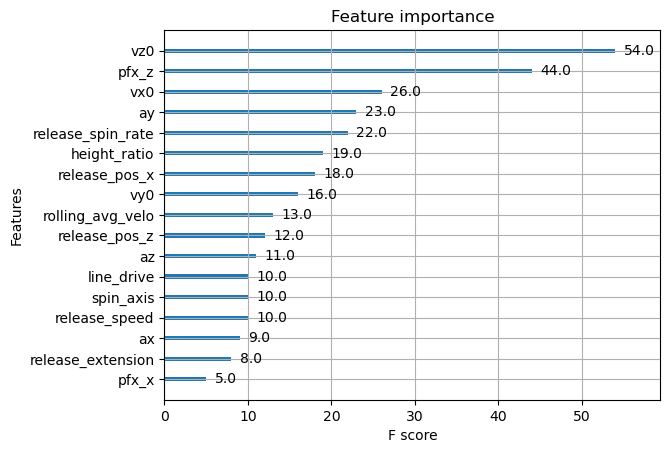

In [14]:
xgb.plot_importance(model)
plt.show()

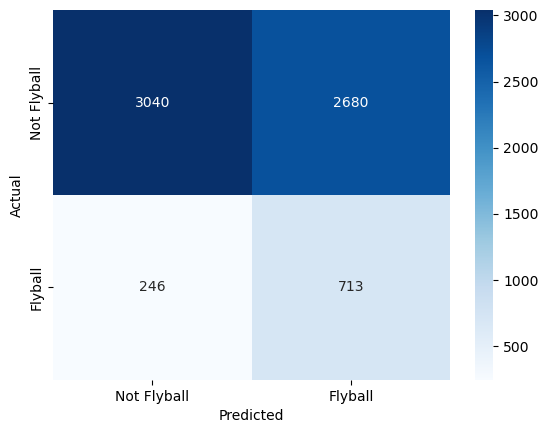

In [15]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [16]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [17]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 17:06:39,712] A new study created in memory with name: no-name-e482d797-43c4-46ab-b4dd-9c3085e1234f


[0]	eval-logloss:0.67313
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.63512
[4]	eval-logloss:0.62649
[5]	eval-logloss:0.62082
[6]	eval-logloss:0.61388
[7]	eval-logloss:0.61119
[8]	eval-logloss:0.60303
[9]	eval-logloss:0.60059
[10]	eval-logloss:0.59700
[11]	eval-logloss:0.59264
[12]	eval-logloss:0.58706
[13]	eval-logloss:0.58596
[14]	eval-logloss:0.58300
[15]	eval-logloss:0.57996
[16]	eval-logloss:0.57657
[17]	eval-logloss:0.57552
[18]	eval-logloss:0.57503
[19]	eval-logloss:0.57555
[20]	eval-logloss:0.57244
[21]	eval-logloss:0.56993
[22]	eval-logloss:0.57014
[23]	eval-logloss:0.56881
[24]	eval-logloss:0.56713
[25]	eval-logloss:0.56554
[26]	eval-logloss:0.56476
[27]	eval-logloss:0.56209
[28]	eval-logloss:0.56146
[29]	eval-logloss:0.56102
[30]	eval-logloss:0.55991
[31]	eval-logloss:0.55956
[32]	eval-logloss:0.55819
[33]	eval-logloss:0.55559
[34]	eval-logloss:0.55507
[35]	eval-logloss:0.55386
[36]	eval-logloss:0.55252
[37]	eval-logloss:0.55094
[38]	eval-logloss:0.55

[I 2023-11-15 17:06:41,187] Trial 0 finished with value: 0.5040816389541498 and parameters: {'max_depth': 8, 'eta': 0.1945294999137423, 'subsample': 0.7033474403123197, 'colsample_bytree': 0.5474414155822942}. Best is trial 0 with value: 0.5040816389541498.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65134
[3]	eval-logloss:0.64109
[4]	eval-logloss:0.63161
[5]	eval-logloss:0.62614
[6]	eval-logloss:0.61960
[7]	eval-logloss:0.61497
[8]	eval-logloss:0.60866
[9]	eval-logloss:0.60482
[10]	eval-logloss:0.60131
[11]	eval-logloss:0.59641
[12]	eval-logloss:0.59347
[13]	eval-logloss:0.59070
[14]	eval-logloss:0.58753
[15]	eval-logloss:0.58482
[16]	eval-logloss:0.58153
[17]	eval-logloss:0.57877
[18]	eval-logloss:0.57616
[19]	eval-logloss:0.57386
[20]	eval-logloss:0.57142
[21]	eval-logloss:0.56896
[22]	eval-logloss:0.56775
[23]	eval-logloss:0.56562
[24]	eval-logloss:0.56390
[25]	eval-logloss:0.56274
[26]	eval-logloss:0.56134
[27]	eval-logloss:0.56033
[28]	eval-logloss:0.55918
[29]	eval-logloss:0.55828
[30]	eval-logloss:0.55581
[31]	eval-logloss:0.55496
[32]	eval-logloss:0.55396
[33]	eval-logloss:0.55315
[34]	eval-logloss:0.55160
[35]	eval-logloss:0.54947
[36]	eval-logloss:0.54859
[37]	eval-logloss:0.54717
[38]	eval-logloss:0.54

[I 2023-11-15 17:06:42,635] Trial 1 finished with value: 0.48538376277598416 and parameters: {'max_depth': 9, 'eta': 0.1282918088961, 'subsample': 0.8488333744321139, 'colsample_bytree': 0.6399020738407666}. Best is trial 1 with value: 0.48538376277598416.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.68175
[2]	eval-logloss:0.67578
[3]	eval-logloss:0.67021
[4]	eval-logloss:0.66564
[5]	eval-logloss:0.66177
[6]	eval-logloss:0.65713
[7]	eval-logloss:0.65333
[8]	eval-logloss:0.64926
[9]	eval-logloss:0.64666
[10]	eval-logloss:0.64339
[11]	eval-logloss:0.64017
[12]	eval-logloss:0.63705
[13]	eval-logloss:0.63432
[14]	eval-logloss:0.63244
[15]	eval-logloss:0.62990
[16]	eval-logloss:0.62723
[17]	eval-logloss:0.62533
[18]	eval-logloss:0.62353
[19]	eval-logloss:0.62208
[20]	eval-logloss:0.62002
[21]	eval-logloss:0.61773
[22]	eval-logloss:0.61612
[23]	eval-logloss:0.61461
[24]	eval-logloss:0.61304
[25]	eval-logloss:0.61167
[26]	eval-logloss:0.61045
[27]	eval-logloss:0.60899
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60680
[30]	eval-logloss:0.60575
[31]	eval-logloss:0.60488
[32]	eval-logloss:0.60354
[33]	eval-logloss:0.60252
[34]	eval-logloss:0.60158
[35]	eval-logloss:0.60045
[36]	eval-logloss:0.59929
[37]	eval-logloss:0.59809
[38]	eval-logloss:0.59

[I 2023-11-15 17:06:43,941] Trial 2 finished with value: 0.5632171265535473 and parameters: {'max_depth': 8, 'eta': 0.043906631089094844, 'subsample': 0.8027718763178608, 'colsample_bytree': 0.8248533366352744}. Best is trial 1 with value: 0.48538376277598416.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.65849
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.65196
[6]	eval-logloss:0.64886
[7]	eval-logloss:0.64641
[8]	eval-logloss:0.64290
[9]	eval-logloss:0.64201
[10]	eval-logloss:0.64054
[11]	eval-logloss:0.63884
[12]	eval-logloss:0.63712
[13]	eval-logloss:0.63655
[14]	eval-logloss:0.63550
[15]	eval-logloss:0.63519
[16]	eval-logloss:0.63400
[17]	eval-logloss:0.63321
[18]	eval-logloss:0.63272
[19]	eval-logloss:0.63315
[20]	eval-logloss:0.63272
[21]	eval-logloss:0.63061
[22]	eval-logloss:0.63053
[23]	eval-logloss:0.63079
[24]	eval-logloss:0.63044
[25]	eval-logloss:0.63099
[26]	eval-logloss:0.63126
[27]	eval-logloss:0.63116
[28]	eval-logloss:0.63089
[29]	eval-logloss:0.63099
[30]	eval-logloss:0.63114
[31]	eval-logloss:0.63043
[32]	eval-logloss:0.62936
[33]	eval-logloss:0.62725
[34]	eval-logloss:0.62735
[35]	eval-logloss:0.62608
[36]	eval-logloss:0.62537
[37]	eval-logloss:0.62470
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:44,626] Trial 3 finished with value: 0.6122848644021976 and parameters: {'max_depth': 3, 'eta': 0.1496156162951326, 'subsample': 0.7028364068150872, 'colsample_bytree': 0.7652118147265909}. Best is trial 1 with value: 0.48538376277598416.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65811
[2]	eval-logloss:0.65220
[3]	eval-logloss:0.64788
[4]	eval-logloss:0.64607
[5]	eval-logloss:0.64281
[6]	eval-logloss:0.64106
[7]	eval-logloss:0.63993
[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63592
[10]	eval-logloss:0.63571
[11]	eval-logloss:0.63443
[12]	eval-logloss:0.63323
[13]	eval-logloss:0.63329
[14]	eval-logloss:0.63297
[15]	eval-logloss:0.63371
[16]	eval-logloss:0.63147
[17]	eval-logloss:0.63022
[18]	eval-logloss:0.63000
[19]	eval-logloss:0.62992
[20]	eval-logloss:0.63010
[21]	eval-logloss:0.62811
[22]	eval-logloss:0.62800
[23]	eval-logloss:0.62764
[24]	eval-logloss:0.62633
[25]	eval-logloss:0.62611
[26]	eval-logloss:0.62587
[27]	eval-logloss:0.62476
[28]	eval-logloss:0.62495
[29]	eval-logloss:0.62500
[30]	eval-logloss:0.62427
[31]	eval-logloss:0.62480
[32]	eval-logloss:0.62506
[33]	eval-logloss:0.62289
[34]	eval-logloss:0.62288
[35]	eval-logloss:0.62059
[36]	eval-logloss:0.61989
[37]	eval-logloss:0.61828
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:45,216] Trial 4 finished with value: 0.6025416804188723 and parameters: {'max_depth': 3, 'eta': 0.2637552905624697, 'subsample': 0.8620981441104079, 'colsample_bytree': 0.8440900721569335}. Best is trial 1 with value: 0.48538376277598416.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65912
[3]	eval-logloss:0.64244
[4]	eval-logloss:0.63461
[5]	eval-logloss:0.62846
[6]	eval-logloss:0.62272
[7]	eval-logloss:0.62047
[8]	eval-logloss:0.61422
[9]	eval-logloss:0.61026
[10]	eval-logloss:0.60792
[11]	eval-logloss:0.60379
[12]	eval-logloss:0.60006
[13]	eval-logloss:0.59866
[14]	eval-logloss:0.59719
[15]	eval-logloss:0.59518
[16]	eval-logloss:0.59233
[17]	eval-logloss:0.59071
[18]	eval-logloss:0.59084
[19]	eval-logloss:0.59036
[20]	eval-logloss:0.58825
[21]	eval-logloss:0.58495
[22]	eval-logloss:0.58513
[23]	eval-logloss:0.58410
[24]	eval-logloss:0.58191
[25]	eval-logloss:0.58108
[26]	eval-logloss:0.58108
[27]	eval-logloss:0.58008
[28]	eval-logloss:0.57882
[29]	eval-logloss:0.57706
[30]	eval-logloss:0.57483
[31]	eval-logloss:0.57408
[32]	eval-logloss:0.57281
[33]	eval-logloss:0.57173
[34]	eval-logloss:0.57130
[35]	eval-logloss:0.56916
[36]	eval-logloss:0.56766
[37]	eval-logloss:0.56678
[38]	eval-logloss:0.56

[I 2023-11-15 17:06:47,106] Trial 5 finished with value: 0.5206586119533834 and parameters: {'max_depth': 7, 'eta': 0.20150057767201957, 'subsample': 0.7088592354194498, 'colsample_bytree': 0.5490245293339977}. Best is trial 1 with value: 0.48538376277598416.


[0]	eval-logloss:0.65855
[1]	eval-logloss:0.63606
[2]	eval-logloss:0.62168
[3]	eval-logloss:0.61200
[4]	eval-logloss:0.60560
[5]	eval-logloss:0.59739
[6]	eval-logloss:0.59246
[7]	eval-logloss:0.58966
[8]	eval-logloss:0.58253
[9]	eval-logloss:0.57826
[10]	eval-logloss:0.57648
[11]	eval-logloss:0.57351
[12]	eval-logloss:0.57127
[13]	eval-logloss:0.56882
[14]	eval-logloss:0.56645
[15]	eval-logloss:0.56561
[16]	eval-logloss:0.56217
[17]	eval-logloss:0.55951
[18]	eval-logloss:0.55665
[19]	eval-logloss:0.55658
[20]	eval-logloss:0.55468
[21]	eval-logloss:0.55136
[22]	eval-logloss:0.55076
[23]	eval-logloss:0.54858
[24]	eval-logloss:0.54727
[25]	eval-logloss:0.54407
[26]	eval-logloss:0.54158
[27]	eval-logloss:0.53809
[28]	eval-logloss:0.53565
[29]	eval-logloss:0.53443
[30]	eval-logloss:0.53223
[31]	eval-logloss:0.53127
[32]	eval-logloss:0.52887
[33]	eval-logloss:0.52534
[34]	eval-logloss:0.52276
[35]	eval-logloss:0.51927
[36]	eval-logloss:0.51992
[37]	eval-logloss:0.51834
[38]	eval-logloss:0.51

[I 2023-11-15 17:06:48,902] Trial 6 finished with value: 0.48459164732317817 and parameters: {'max_depth': 9, 'eta': 0.24087311110715448, 'subsample': 0.843652495556016, 'colsample_bytree': 0.8996745648289985}. Best is trial 6 with value: 0.48459164732317817.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.64815
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.62275
[4]	eval-logloss:0.61427
[5]	eval-logloss:0.60842
[6]	eval-logloss:0.60075
[7]	eval-logloss:0.59797
[8]	eval-logloss:0.58987
[9]	eval-logloss:0.58659
[10]	eval-logloss:0.58417
[11]	eval-logloss:0.57823
[12]	eval-logloss:0.56974
[13]	eval-logloss:0.56576
[14]	eval-logloss:0.56407
[15]	eval-logloss:0.56403
[16]	eval-logloss:0.56303
[17]	eval-logloss:0.56211
[18]	eval-logloss:0.56097
[19]	eval-logloss:0.56142
[20]	eval-logloss:0.55931
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55435
[23]	eval-logloss:0.55226
[24]	eval-logloss:0.54765
[25]	eval-logloss:0.54842
[26]	eval-logloss:0.54506
[27]	eval-logloss:0.54443
[28]	eval-logloss:0.54392
[29]	eval-logloss:0.54223
[30]	eval-logloss:0.54084
[31]	eval-logloss:0.53893
[32]	eval-logloss:0.53823
[33]	eval-logloss:0.53586
[34]	eval-logloss:0.53660
[35]	eval-logloss:0.53526
[36]	eval-logloss:0.53123
[37]	eval-logloss:0.53135
[38]	eval-logloss:0.52

[I 2023-11-15 17:06:50,586] Trial 7 finished with value: 0.49099893031427005 and parameters: {'max_depth': 9, 'eta': 0.2248160237214568, 'subsample': 0.6199221536782523, 'colsample_bytree': 0.5669777743024289}. Best is trial 6 with value: 0.48459164732317817.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.67972
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.66385
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.65372
[6]	eval-logloss:0.64844
[7]	eval-logloss:0.64731
[8]	eval-logloss:0.64234
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63790
[12]	eval-logloss:0.63549
[13]	eval-logloss:0.63396
[14]	eval-logloss:0.63325
[15]	eval-logloss:0.63213
[16]	eval-logloss:0.63025
[17]	eval-logloss:0.62924
[18]	eval-logloss:0.62843
[19]	eval-logloss:0.62801
[20]	eval-logloss:0.62723
[21]	eval-logloss:0.62575
[22]	eval-logloss:0.62545
[23]	eval-logloss:0.62466
[24]	eval-logloss:0.62417
[25]	eval-logloss:0.62371
[26]	eval-logloss:0.62355
[27]	eval-logloss:0.62242
[28]	eval-logloss:0.62259
[29]	eval-logloss:0.62268
[30]	eval-logloss:0.62216
[31]	eval-logloss:0.62205
[32]	eval-logloss:0.62205
[33]	eval-logloss:0.62085
[34]	eval-logloss:0.62088
[35]	eval-logloss:0.61919
[36]	eval-logloss:0.61871
[37]	eval-logloss:0.61747
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:51,400] Trial 8 finished with value: 0.5960338133838188 and parameters: {'max_depth': 4, 'eta': 0.16497373137301746, 'subsample': 0.8555480938776636, 'colsample_bytree': 0.5628537384900897}. Best is trial 6 with value: 0.48459164732317817.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67601
[2]	eval-logloss:0.65880
[3]	eval-logloss:0.65145
[4]	eval-logloss:0.64862
[5]	eval-logloss:0.64620
[6]	eval-logloss:0.64223
[7]	eval-logloss:0.64145
[8]	eval-logloss:0.63877
[9]	eval-logloss:0.63697
[10]	eval-logloss:0.63558
[11]	eval-logloss:0.63328
[12]	eval-logloss:0.62928
[13]	eval-logloss:0.62831
[14]	eval-logloss:0.62815
[15]	eval-logloss:0.63030
[16]	eval-logloss:0.63027
[17]	eval-logloss:0.63011
[18]	eval-logloss:0.63065
[19]	eval-logloss:0.63189
[20]	eval-logloss:0.63017
[21]	eval-logloss:0.62797
[22]	eval-logloss:0.62821
[23]	eval-logloss:0.62857
[24]	eval-logloss:0.62880
[25]	eval-logloss:0.62935
[26]	eval-logloss:0.62972
[27]	eval-logloss:0.62877
[28]	eval-logloss:0.62820
[29]	eval-logloss:0.62621
[30]	eval-logloss:0.62811
[31]	eval-logloss:0.62777
[32]	eval-logloss:0.62588
[33]	eval-logloss:0.62345
[34]	eval-logloss:0.62536
[35]	eval-logloss:0.62317
[36]	eval-logloss:0.62361
[37]	eval-logloss:0.62343
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:52,360] Trial 9 finished with value: 0.6102637665915354 and parameters: {'max_depth': 3, 'eta': 0.26380316161605183, 'subsample': 0.6026225103672439, 'colsample_bytree': 0.6565926738032022}. Best is trial 6 with value: 0.48459164732317817.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.65002
[2]	eval-logloss:0.64224
[3]	eval-logloss:0.63719
[4]	eval-logloss:0.63538
[5]	eval-logloss:0.63158
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62864
[8]	eval-logloss:0.62506
[9]	eval-logloss:0.62406
[10]	eval-logloss:0.62234
[11]	eval-logloss:0.61936
[12]	eval-logloss:0.61749
[13]	eval-logloss:0.61818
[14]	eval-logloss:0.61698
[15]	eval-logloss:0.61664
[16]	eval-logloss:0.61391
[17]	eval-logloss:0.61313
[18]	eval-logloss:0.61186
[19]	eval-logloss:0.61220
[20]	eval-logloss:0.61174
[21]	eval-logloss:0.60937
[22]	eval-logloss:0.60855
[23]	eval-logloss:0.60831
[24]	eval-logloss:0.60717
[25]	eval-logloss:0.60735
[26]	eval-logloss:0.60649
[27]	eval-logloss:0.60520
[28]	eval-logloss:0.60402
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60246
[31]	eval-logloss:0.60206
[32]	eval-logloss:0.60161
[33]	eval-logloss:0.59875
[34]	eval-logloss:0.59777
[35]	eval-logloss:0.59455
[36]	eval-logloss:0.59331
[37]	eval-logloss:0.59128
[38]	eval-logloss:0.59

[I 2023-11-15 17:06:53,222] Trial 10 finished with value: 0.5586972334798768 and parameters: {'max_depth': 5, 'eta': 0.28798971564621917, 'subsample': 0.8961882996636605, 'colsample_bytree': 0.9576721510304078}. Best is trial 6 with value: 0.48459164732317817.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66565
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.63796
[4]	eval-logloss:0.62857
[5]	eval-logloss:0.62169
[6]	eval-logloss:0.61434
[7]	eval-logloss:0.60808
[8]	eval-logloss:0.60204
[9]	eval-logloss:0.59817
[10]	eval-logloss:0.59441
[11]	eval-logloss:0.59054
[12]	eval-logloss:0.58624
[13]	eval-logloss:0.58400
[14]	eval-logloss:0.58036
[15]	eval-logloss:0.57794
[16]	eval-logloss:0.57598
[17]	eval-logloss:0.57352
[18]	eval-logloss:0.57202
[19]	eval-logloss:0.57047
[20]	eval-logloss:0.56896
[21]	eval-logloss:0.56707
[22]	eval-logloss:0.56557
[23]	eval-logloss:0.56336
[24]	eval-logloss:0.56037
[25]	eval-logloss:0.55914
[26]	eval-logloss:0.55812
[27]	eval-logloss:0.55689
[28]	eval-logloss:0.55579
[29]	eval-logloss:0.55342
[30]	eval-logloss:0.55101
[31]	eval-logloss:0.55086
[32]	eval-logloss:0.54980
[33]	eval-logloss:0.54669
[34]	eval-logloss:0.54577
[35]	eval-logloss:0.54399
[36]	eval-logloss:0.54244
[37]	eval-logloss:0.54070
[38]	eval-logloss:0.54

[I 2023-11-15 17:06:54,759] Trial 11 finished with value: 0.4804531713508203 and parameters: {'max_depth': 9, 'eta': 0.13365604128443914, 'subsample': 0.8066696155350292, 'colsample_bytree': 0.6789796336433533}. Best is trial 11 with value: 0.4804531713508203.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66264
[3]	eval-logloss:0.65582
[4]	eval-logloss:0.65128
[5]	eval-logloss:0.64754
[6]	eval-logloss:0.64310
[7]	eval-logloss:0.63978
[8]	eval-logloss:0.63575
[9]	eval-logloss:0.63292
[10]	eval-logloss:0.63114
[11]	eval-logloss:0.62882
[12]	eval-logloss:0.62702
[13]	eval-logloss:0.62577
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.62270
[16]	eval-logloss:0.62115
[17]	eval-logloss:0.61996
[18]	eval-logloss:0.61861
[19]	eval-logloss:0.61799
[20]	eval-logloss:0.61762
[21]	eval-logloss:0.61634
[22]	eval-logloss:0.61598
[23]	eval-logloss:0.61554
[24]	eval-logloss:0.61443
[25]	eval-logloss:0.61416
[26]	eval-logloss:0.61393
[27]	eval-logloss:0.61309
[28]	eval-logloss:0.61300
[29]	eval-logloss:0.61301
[30]	eval-logloss:0.61202
[31]	eval-logloss:0.61144
[32]	eval-logloss:0.61058
[33]	eval-logloss:0.60913
[34]	eval-logloss:0.60821
[35]	eval-logloss:0.60732
[36]	eval-logloss:0.60666
[37]	eval-logloss:0.60582
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:55,793] Trial 12 finished with value: 0.5721972899358452 and parameters: {'max_depth': 6, 'eta': 0.09778231949326341, 'subsample': 0.7960729683134176, 'colsample_bytree': 0.9985534636967051}. Best is trial 11 with value: 0.4804531713508203.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.66649
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.64868
[4]	eval-logloss:0.64246
[5]	eval-logloss:0.63751
[6]	eval-logloss:0.63172
[7]	eval-logloss:0.62766
[8]	eval-logloss:0.62299
[9]	eval-logloss:0.61964
[10]	eval-logloss:0.61688
[11]	eval-logloss:0.61404
[12]	eval-logloss:0.61163
[13]	eval-logloss:0.60984
[14]	eval-logloss:0.60657
[15]	eval-logloss:0.60443
[16]	eval-logloss:0.60331
[17]	eval-logloss:0.60144
[18]	eval-logloss:0.59913
[19]	eval-logloss:0.59770
[20]	eval-logloss:0.59569
[21]	eval-logloss:0.59359
[22]	eval-logloss:0.59309
[23]	eval-logloss:0.59175
[24]	eval-logloss:0.59024
[25]	eval-logloss:0.58935
[26]	eval-logloss:0.58840
[27]	eval-logloss:0.58746
[28]	eval-logloss:0.58720
[29]	eval-logloss:0.58581
[30]	eval-logloss:0.58507
[31]	eval-logloss:0.58520
[32]	eval-logloss:0.58419
[33]	eval-logloss:0.58170
[34]	eval-logloss:0.57994
[35]	eval-logloss:0.57887
[36]	eval-logloss:0.57798
[37]	eval-logloss:0.57679
[38]	eval-logloss:0.57

[I 2023-11-15 17:06:57,376] Trial 13 finished with value: 0.5259572241303238 and parameters: {'max_depth': 8, 'eta': 0.09604888943894788, 'subsample': 0.795043865518786, 'colsample_bytree': 0.885165782009771}. Best is trial 11 with value: 0.4804531713508203.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66439
[2]	eval-logloss:0.64679
[3]	eval-logloss:0.63638
[4]	eval-logloss:0.63025
[5]	eval-logloss:0.62253
[6]	eval-logloss:0.61717
[7]	eval-logloss:0.61308
[8]	eval-logloss:0.60790
[9]	eval-logloss:0.60559
[10]	eval-logloss:0.60452
[11]	eval-logloss:0.60177
[12]	eval-logloss:0.59740
[13]	eval-logloss:0.59631
[14]	eval-logloss:0.59447
[15]	eval-logloss:0.59243
[16]	eval-logloss:0.59118
[17]	eval-logloss:0.59096
[18]	eval-logloss:0.59059
[19]	eval-logloss:0.59006
[20]	eval-logloss:0.58874
[21]	eval-logloss:0.58662
[22]	eval-logloss:0.58616
[23]	eval-logloss:0.58535
[24]	eval-logloss:0.58289
[25]	eval-logloss:0.58244
[26]	eval-logloss:0.58181
[27]	eval-logloss:0.58068
[28]	eval-logloss:0.58044
[29]	eval-logloss:0.57998
[30]	eval-logloss:0.57780
[31]	eval-logloss:0.57738
[32]	eval-logloss:0.57605
[33]	eval-logloss:0.57354
[34]	eval-logloss:0.57234
[35]	eval-logloss:0.56978
[36]	eval-logloss:0.56774
[37]	eval-logloss:0.56776
[38]	eval-logloss:0.56

[I 2023-11-15 17:06:58,537] Trial 14 finished with value: 0.5210347878695115 and parameters: {'max_depth': 7, 'eta': 0.2151652236205302, 'subsample': 0.7676613718143729, 'colsample_bytree': 0.729057813522635}. Best is trial 11 with value: 0.4804531713508203.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68643
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67686
[8]	eval-logloss:0.67479
[9]	eval-logloss:0.67310
[10]	eval-logloss:0.67128
[11]	eval-logloss:0.66946
[12]	eval-logloss:0.66770
[13]	eval-logloss:0.66598
[14]	eval-logloss:0.66470
[15]	eval-logloss:0.66312
[16]	eval-logloss:0.66149
[17]	eval-logloss:0.65998
[18]	eval-logloss:0.65854
[19]	eval-logloss:0.65710
[20]	eval-logloss:0.65565
[21]	eval-logloss:0.65407
[22]	eval-logloss:0.65274
[23]	eval-logloss:0.65126
[24]	eval-logloss:0.65024
[25]	eval-logloss:0.64892
[26]	eval-logloss:0.64781
[27]	eval-logloss:0.64662
[28]	eval-logloss:0.64549
[29]	eval-logloss:0.64431
[30]	eval-logloss:0.64314
[31]	eval-logloss:0.64197
[32]	eval-logloss:0.64085
[33]	eval-logloss:0.64017
[34]	eval-logloss:0.63908
[35]	eval-logloss:0.63801
[36]	eval-logloss:0.63679
[37]	eval-logloss:0.63568
[38]	eval-logloss:0.63

[I 2023-11-15 17:07:00,269] Trial 15 finished with value: 0.5933440736273694 and parameters: {'max_depth': 9, 'eta': 0.012653087870809987, 'subsample': 0.826267165902515, 'colsample_bytree': 0.8957942646718168}. Best is trial 11 with value: 0.4804531713508203.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65994
[2]	eval-logloss:0.64747
[3]	eval-logloss:0.63751
[4]	eval-logloss:0.63158
[5]	eval-logloss:0.62670
[6]	eval-logloss:0.62220
[7]	eval-logloss:0.61909
[8]	eval-logloss:0.61580
[9]	eval-logloss:0.61216
[10]	eval-logloss:0.61007
[11]	eval-logloss:0.60766
[12]	eval-logloss:0.60506
[13]	eval-logloss:0.60475
[14]	eval-logloss:0.60277
[15]	eval-logloss:0.60105
[16]	eval-logloss:0.59980
[17]	eval-logloss:0.59844
[18]	eval-logloss:0.59725
[19]	eval-logloss:0.59466
[20]	eval-logloss:0.59365
[21]	eval-logloss:0.59111
[22]	eval-logloss:0.58980
[23]	eval-logloss:0.58915
[24]	eval-logloss:0.58666
[25]	eval-logloss:0.58601
[26]	eval-logloss:0.58399
[27]	eval-logloss:0.58267
[28]	eval-logloss:0.58234
[29]	eval-logloss:0.58237
[30]	eval-logloss:0.58096
[31]	eval-logloss:0.58030
[32]	eval-logloss:0.58033
[33]	eval-logloss:0.57777
[34]	eval-logloss:0.57719
[35]	eval-logloss:0.57566
[36]	eval-logloss:0.57412
[37]	eval-logloss:0.57332
[38]	eval-logloss:0.57

[I 2023-11-15 17:07:01,443] Trial 16 finished with value: 0.5194734119767578 and parameters: {'max_depth': 7, 'eta': 0.17180362199499127, 'subsample': 0.897797447136714, 'colsample_bytree': 0.7840579906454115}. Best is trial 11 with value: 0.4804531713508203.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.63924
[4]	eval-logloss:0.63574
[5]	eval-logloss:0.63062
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62301
[8]	eval-logloss:0.61772
[9]	eval-logloss:0.61523
[10]	eval-logloss:0.61500
[11]	eval-logloss:0.61409
[12]	eval-logloss:0.61113
[13]	eval-logloss:0.61105
[14]	eval-logloss:0.60907
[15]	eval-logloss:0.60782
[16]	eval-logloss:0.60558
[17]	eval-logloss:0.60373
[18]	eval-logloss:0.60310
[19]	eval-logloss:0.60351
[20]	eval-logloss:0.60330
[21]	eval-logloss:0.60084
[22]	eval-logloss:0.60104
[23]	eval-logloss:0.59971
[24]	eval-logloss:0.59828
[25]	eval-logloss:0.59703
[26]	eval-logloss:0.59677
[27]	eval-logloss:0.59547
[28]	eval-logloss:0.59566
[29]	eval-logloss:0.59546
[30]	eval-logloss:0.59284
[31]	eval-logloss:0.59207
[32]	eval-logloss:0.59100
[33]	eval-logloss:0.58967
[34]	eval-logloss:0.58922
[35]	eval-logloss:0.58728
[36]	eval-logloss:0.58571
[37]	eval-logloss:0.58547
[38]	eval-logloss:0.58

[I 2023-11-15 17:07:02,415] Trial 17 finished with value: 0.5370079798152101 and parameters: {'max_depth': 6, 'eta': 0.2381683629747518, 'subsample': 0.7588808189222572, 'colsample_bytree': 0.7076123579837896}. Best is trial 11 with value: 0.4804531713508203.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.63867
[3]	eval-logloss:0.62429
[4]	eval-logloss:0.61398
[5]	eval-logloss:0.60643
[6]	eval-logloss:0.59949
[7]	eval-logloss:0.59320
[8]	eval-logloss:0.58744
[9]	eval-logloss:0.58411
[10]	eval-logloss:0.58242
[11]	eval-logloss:0.57809
[12]	eval-logloss:0.57550
[13]	eval-logloss:0.57251
[14]	eval-logloss:0.56810
[15]	eval-logloss:0.56619
[16]	eval-logloss:0.56359
[17]	eval-logloss:0.56168
[18]	eval-logloss:0.56005
[19]	eval-logloss:0.55939
[20]	eval-logloss:0.55654
[21]	eval-logloss:0.55328
[22]	eval-logloss:0.55252
[23]	eval-logloss:0.55023
[24]	eval-logloss:0.54836
[25]	eval-logloss:0.54693
[26]	eval-logloss:0.54484
[27]	eval-logloss:0.54224
[28]	eval-logloss:0.54210
[29]	eval-logloss:0.54079
[30]	eval-logloss:0.53824
[31]	eval-logloss:0.53793
[32]	eval-logloss:0.53707
[33]	eval-logloss:0.53384
[34]	eval-logloss:0.53238
[35]	eval-logloss:0.52890
[36]	eval-logloss:0.52771
[37]	eval-logloss:0.52617
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:03,727] Trial 18 finished with value: 0.47150236086204866 and parameters: {'max_depth': 9, 'eta': 0.18616703917696573, 'subsample': 0.8282354734668882, 'colsample_bytree': 0.6867345056142505}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.64488
[3]	eval-logloss:0.63238
[4]	eval-logloss:0.62406
[5]	eval-logloss:0.61799
[6]	eval-logloss:0.61081
[7]	eval-logloss:0.60745
[8]	eval-logloss:0.60309
[9]	eval-logloss:0.59926
[10]	eval-logloss:0.59832
[11]	eval-logloss:0.59421
[12]	eval-logloss:0.58976
[13]	eval-logloss:0.58738
[14]	eval-logloss:0.58498
[15]	eval-logloss:0.58411
[16]	eval-logloss:0.58262
[17]	eval-logloss:0.58075
[18]	eval-logloss:0.57735
[19]	eval-logloss:0.57573
[20]	eval-logloss:0.57414
[21]	eval-logloss:0.57256
[22]	eval-logloss:0.57258
[23]	eval-logloss:0.57102
[24]	eval-logloss:0.56882
[25]	eval-logloss:0.56718
[26]	eval-logloss:0.56572
[27]	eval-logloss:0.56394
[28]	eval-logloss:0.56256
[29]	eval-logloss:0.56129
[30]	eval-logloss:0.55894
[31]	eval-logloss:0.55900
[32]	eval-logloss:0.55794
[33]	eval-logloss:0.55567
[34]	eval-logloss:0.55534
[35]	eval-logloss:0.55467
[36]	eval-logloss:0.55318
[37]	eval-logloss:0.55061
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:05,125] Trial 19 finished with value: 0.49850213880954997 and parameters: {'max_depth': 8, 'eta': 0.1839661625881046, 'subsample': 0.8122586663763133, 'colsample_bytree': 0.6704368951941478}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67864
[2]	eval-logloss:0.66639
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.65118
[5]	eval-logloss:0.64791
[6]	eval-logloss:0.64306
[7]	eval-logloss:0.64167
[8]	eval-logloss:0.63675
[9]	eval-logloss:0.63513
[10]	eval-logloss:0.63443
[11]	eval-logloss:0.63152
[12]	eval-logloss:0.62924
[13]	eval-logloss:0.62841
[14]	eval-logloss:0.62723
[15]	eval-logloss:0.62657
[16]	eval-logloss:0.62483
[17]	eval-logloss:0.62361
[18]	eval-logloss:0.62209
[19]	eval-logloss:0.62107
[20]	eval-logloss:0.62053
[21]	eval-logloss:0.61869
[22]	eval-logloss:0.61846
[23]	eval-logloss:0.61816
[24]	eval-logloss:0.61766
[25]	eval-logloss:0.61775
[26]	eval-logloss:0.61762
[27]	eval-logloss:0.61690
[28]	eval-logloss:0.61663
[29]	eval-logloss:0.61597
[30]	eval-logloss:0.61498
[31]	eval-logloss:0.61466
[32]	eval-logloss:0.61401
[33]	eval-logloss:0.61246
[34]	eval-logloss:0.61170
[35]	eval-logloss:0.61107
[36]	eval-logloss:0.61067
[37]	eval-logloss:0.60986
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:06,029] Trial 20 finished with value: 0.5815727821799569 and parameters: {'max_depth': 5, 'eta': 0.14080275455172855, 'subsample': 0.7710248547401373, 'colsample_bytree': 0.6161915283029927}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.63182
[3]	eval-logloss:0.61887
[4]	eval-logloss:0.61022
[5]	eval-logloss:0.60195
[6]	eval-logloss:0.59418
[7]	eval-logloss:0.58797
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57585
[10]	eval-logloss:0.57249
[11]	eval-logloss:0.56746
[12]	eval-logloss:0.56483
[13]	eval-logloss:0.56223
[14]	eval-logloss:0.55751
[15]	eval-logloss:0.55643
[16]	eval-logloss:0.55476
[17]	eval-logloss:0.55380
[18]	eval-logloss:0.55207
[19]	eval-logloss:0.55069
[20]	eval-logloss:0.54800
[21]	eval-logloss:0.54532
[22]	eval-logloss:0.54507
[23]	eval-logloss:0.54212
[24]	eval-logloss:0.54116
[25]	eval-logloss:0.54092
[26]	eval-logloss:0.53970
[27]	eval-logloss:0.53866
[28]	eval-logloss:0.53797
[29]	eval-logloss:0.53709
[30]	eval-logloss:0.53631
[31]	eval-logloss:0.53613
[32]	eval-logloss:0.53390
[33]	eval-logloss:0.53136
[34]	eval-logloss:0.53057
[35]	eval-logloss:0.52720
[36]	eval-logloss:0.52477
[37]	eval-logloss:0.52412
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:07,569] Trial 21 finished with value: 0.48359894004981346 and parameters: {'max_depth': 9, 'eta': 0.22967166414184634, 'subsample': 0.834619756443384, 'colsample_bytree': 0.6947066231175972}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.63768
[3]	eval-logloss:0.62376
[4]	eval-logloss:0.61486
[5]	eval-logloss:0.60814
[6]	eval-logloss:0.60094
[7]	eval-logloss:0.59553
[8]	eval-logloss:0.58874
[9]	eval-logloss:0.58141
[10]	eval-logloss:0.57611
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56613
[14]	eval-logloss:0.56470
[15]	eval-logloss:0.56395
[16]	eval-logloss:0.56201
[17]	eval-logloss:0.56114
[18]	eval-logloss:0.55854
[19]	eval-logloss:0.55752
[20]	eval-logloss:0.55472
[21]	eval-logloss:0.55184
[22]	eval-logloss:0.55145
[23]	eval-logloss:0.54988
[24]	eval-logloss:0.54864
[25]	eval-logloss:0.54749
[26]	eval-logloss:0.54662
[27]	eval-logloss:0.54493
[28]	eval-logloss:0.54271
[29]	eval-logloss:0.54234
[30]	eval-logloss:0.53994
[31]	eval-logloss:0.53885
[32]	eval-logloss:0.53830
[33]	eval-logloss:0.53514
[34]	eval-logloss:0.53373
[35]	eval-logloss:0.53059
[36]	eval-logloss:0.52947
[37]	eval-logloss:0.52846
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:09,148] Trial 22 finished with value: 0.4770026838414678 and parameters: {'max_depth': 9, 'eta': 0.18952446316312926, 'subsample': 0.8290640142429336, 'colsample_bytree': 0.7031912290896692}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62593
[5]	eval-logloss:0.62112
[6]	eval-logloss:0.61541
[7]	eval-logloss:0.61102
[8]	eval-logloss:0.60491
[9]	eval-logloss:0.60142
[10]	eval-logloss:0.59958
[11]	eval-logloss:0.59572
[12]	eval-logloss:0.59275
[13]	eval-logloss:0.59099
[14]	eval-logloss:0.58946
[15]	eval-logloss:0.58764
[16]	eval-logloss:0.58527
[17]	eval-logloss:0.58260
[18]	eval-logloss:0.58049
[19]	eval-logloss:0.57877
[20]	eval-logloss:0.57700
[21]	eval-logloss:0.57446
[22]	eval-logloss:0.57383
[23]	eval-logloss:0.57281
[24]	eval-logloss:0.57015
[25]	eval-logloss:0.56856
[26]	eval-logloss:0.56771
[27]	eval-logloss:0.56570
[28]	eval-logloss:0.56396
[29]	eval-logloss:0.56423
[30]	eval-logloss:0.56202
[31]	eval-logloss:0.56201
[32]	eval-logloss:0.56134
[33]	eval-logloss:0.55754
[34]	eval-logloss:0.55663
[35]	eval-logloss:0.55488
[36]	eval-logloss:0.55343
[37]	eval-logloss:0.55173
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:10,421] Trial 23 finished with value: 0.49168295838065645 and parameters: {'max_depth': 8, 'eta': 0.18175047713818182, 'subsample': 0.8731113069110693, 'colsample_bytree': 0.736402034179932}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.66744
[2]	eval-logloss:0.65228
[3]	eval-logloss:0.64031
[4]	eval-logloss:0.63122
[5]	eval-logloss:0.62382
[6]	eval-logloss:0.61664
[7]	eval-logloss:0.61145
[8]	eval-logloss:0.60515
[9]	eval-logloss:0.60058
[10]	eval-logloss:0.59735
[11]	eval-logloss:0.59259
[12]	eval-logloss:0.58942
[13]	eval-logloss:0.58632
[14]	eval-logloss:0.58311
[15]	eval-logloss:0.57962
[16]	eval-logloss:0.57655
[17]	eval-logloss:0.57468
[18]	eval-logloss:0.57314
[19]	eval-logloss:0.57222
[20]	eval-logloss:0.56939
[21]	eval-logloss:0.56792
[22]	eval-logloss:0.56642
[23]	eval-logloss:0.56525
[24]	eval-logloss:0.56348
[25]	eval-logloss:0.56218
[26]	eval-logloss:0.56065
[27]	eval-logloss:0.55922
[28]	eval-logloss:0.55735
[29]	eval-logloss:0.55603
[30]	eval-logloss:0.55401
[31]	eval-logloss:0.55359
[32]	eval-logloss:0.55297
[33]	eval-logloss:0.55102
[34]	eval-logloss:0.54984
[35]	eval-logloss:0.54794
[36]	eval-logloss:0.54665
[37]	eval-logloss:0.54594
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:12,143] Trial 24 finished with value: 0.4871516705944401 and parameters: {'max_depth': 9, 'eta': 0.12129054227513078, 'subsample': 0.8224092536726589, 'colsample_bytree': 0.6198544028924239}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64374
[4]	eval-logloss:0.63666
[5]	eval-logloss:0.63062
[6]	eval-logloss:0.62495
[7]	eval-logloss:0.62117
[8]	eval-logloss:0.61666
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.61287
[11]	eval-logloss:0.60954
[12]	eval-logloss:0.60738
[13]	eval-logloss:0.60663
[14]	eval-logloss:0.60414
[15]	eval-logloss:0.60237
[16]	eval-logloss:0.60105
[17]	eval-logloss:0.60016
[18]	eval-logloss:0.59765
[19]	eval-logloss:0.59610
[20]	eval-logloss:0.59508
[21]	eval-logloss:0.59286
[22]	eval-logloss:0.59261
[23]	eval-logloss:0.59159
[24]	eval-logloss:0.58946
[25]	eval-logloss:0.58917
[26]	eval-logloss:0.58884
[27]	eval-logloss:0.58768
[28]	eval-logloss:0.58787
[29]	eval-logloss:0.58745
[30]	eval-logloss:0.58569
[31]	eval-logloss:0.58563
[32]	eval-logloss:0.58451
[33]	eval-logloss:0.58200
[34]	eval-logloss:0.58109
[35]	eval-logloss:0.58039
[36]	eval-logloss:0.57984
[37]	eval-logloss:0.57932
[38]	eval-logloss:0.57

[I 2023-11-15 17:07:13,402] Trial 25 finished with value: 0.5274833043920265 and parameters: {'max_depth': 7, 'eta': 0.1655527154366755, 'subsample': 0.78951085359441, 'colsample_bytree': 0.6877992819392073}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.64263
[3]	eval-logloss:0.63095
[4]	eval-logloss:0.62188
[5]	eval-logloss:0.61669
[6]	eval-logloss:0.61117
[7]	eval-logloss:0.60661
[8]	eval-logloss:0.60150
[9]	eval-logloss:0.60006
[10]	eval-logloss:0.59823
[11]	eval-logloss:0.59482
[12]	eval-logloss:0.59089
[13]	eval-logloss:0.58896
[14]	eval-logloss:0.58629
[15]	eval-logloss:0.58472
[16]	eval-logloss:0.58232
[17]	eval-logloss:0.57931
[18]	eval-logloss:0.57830
[19]	eval-logloss:0.57753
[20]	eval-logloss:0.57465
[21]	eval-logloss:0.57214
[22]	eval-logloss:0.57140
[23]	eval-logloss:0.56924
[24]	eval-logloss:0.56709
[25]	eval-logloss:0.56573
[26]	eval-logloss:0.56382
[27]	eval-logloss:0.56180
[28]	eval-logloss:0.56108
[29]	eval-logloss:0.56144
[30]	eval-logloss:0.55915
[31]	eval-logloss:0.55742
[32]	eval-logloss:0.55663
[33]	eval-logloss:0.55407
[34]	eval-logloss:0.55341
[35]	eval-logloss:0.55035
[36]	eval-logloss:0.54699
[37]	eval-logloss:0.54562
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:14,904] Trial 26 finished with value: 0.49039861661151574 and parameters: {'max_depth': 8, 'eta': 0.19898489757960636, 'subsample': 0.8733470806496618, 'colsample_bytree': 0.7273082998265452}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66217
[2]	eval-logloss:0.65174
[3]	eval-logloss:0.63579
[4]	eval-logloss:0.62422
[5]	eval-logloss:0.61671
[6]	eval-logloss:0.60786
[7]	eval-logloss:0.60424
[8]	eval-logloss:0.59686
[9]	eval-logloss:0.59386
[10]	eval-logloss:0.59083
[11]	eval-logloss:0.58483
[12]	eval-logloss:0.58035
[13]	eval-logloss:0.57716
[14]	eval-logloss:0.57401
[15]	eval-logloss:0.57104
[16]	eval-logloss:0.56715
[17]	eval-logloss:0.56571
[18]	eval-logloss:0.56297
[19]	eval-logloss:0.56231
[20]	eval-logloss:0.55944
[21]	eval-logloss:0.55678
[22]	eval-logloss:0.55586
[23]	eval-logloss:0.55350
[24]	eval-logloss:0.55171
[25]	eval-logloss:0.55030
[26]	eval-logloss:0.54870
[27]	eval-logloss:0.54665
[28]	eval-logloss:0.54544
[29]	eval-logloss:0.54449
[30]	eval-logloss:0.54271
[31]	eval-logloss:0.54212
[32]	eval-logloss:0.54096
[33]	eval-logloss:0.53984
[34]	eval-logloss:0.53888
[35]	eval-logloss:0.53672
[36]	eval-logloss:0.53532
[37]	eval-logloss:0.53408
[38]	eval-logloss:0.53

[I 2023-11-15 17:07:16,610] Trial 27 finished with value: 0.4770059729626931 and parameters: {'max_depth': 9, 'eta': 0.15339380257876278, 'subsample': 0.8211263646153034, 'colsample_bytree': 0.6068737257170786}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.66108
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.63615
[5]	eval-logloss:0.63048
[6]	eval-logloss:0.62377
[7]	eval-logloss:0.62122
[8]	eval-logloss:0.61419
[9]	eval-logloss:0.61148
[10]	eval-logloss:0.60936
[11]	eval-logloss:0.60326
[12]	eval-logloss:0.60006
[13]	eval-logloss:0.59722
[14]	eval-logloss:0.59651
[15]	eval-logloss:0.59429
[16]	eval-logloss:0.59194
[17]	eval-logloss:0.59063
[18]	eval-logloss:0.58831
[19]	eval-logloss:0.58768
[20]	eval-logloss:0.58638
[21]	eval-logloss:0.58401
[22]	eval-logloss:0.58291
[23]	eval-logloss:0.58130
[24]	eval-logloss:0.57875
[25]	eval-logloss:0.57759
[26]	eval-logloss:0.57494
[27]	eval-logloss:0.57361
[28]	eval-logloss:0.57351
[29]	eval-logloss:0.57179
[30]	eval-logloss:0.57011
[31]	eval-logloss:0.56950
[32]	eval-logloss:0.56861
[33]	eval-logloss:0.56698
[34]	eval-logloss:0.56606
[35]	eval-logloss:0.56363
[36]	eval-logloss:0.56326
[37]	eval-logloss:0.56200
[38]	eval-logloss:0.56

[I 2023-11-15 17:07:18,263] Trial 28 finished with value: 0.5020753011699486 and parameters: {'max_depth': 8, 'eta': 0.1539511865178162, 'subsample': 0.8339372527676907, 'colsample_bytree': 0.5935952928294246}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66378
[2]	eval-logloss:0.64452
[3]	eval-logloss:0.63185
[4]	eval-logloss:0.62274
[5]	eval-logloss:0.61767
[6]	eval-logloss:0.61187
[7]	eval-logloss:0.60952
[8]	eval-logloss:0.60435
[9]	eval-logloss:0.60114
[10]	eval-logloss:0.59939
[11]	eval-logloss:0.59555
[12]	eval-logloss:0.59231
[13]	eval-logloss:0.59042
[14]	eval-logloss:0.58926
[15]	eval-logloss:0.58713
[16]	eval-logloss:0.58430
[17]	eval-logloss:0.58203
[18]	eval-logloss:0.57948
[19]	eval-logloss:0.57694
[20]	eval-logloss:0.57336
[21]	eval-logloss:0.57008
[22]	eval-logloss:0.56840
[23]	eval-logloss:0.56709
[24]	eval-logloss:0.56616
[25]	eval-logloss:0.56562
[26]	eval-logloss:0.56312
[27]	eval-logloss:0.56154
[28]	eval-logloss:0.56048
[29]	eval-logloss:0.55872
[30]	eval-logloss:0.55633
[31]	eval-logloss:0.55565
[32]	eval-logloss:0.55369
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.55037
[35]	eval-logloss:0.54923
[36]	eval-logloss:0.54869
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:19,525] Trial 29 finished with value: 0.48885453289206293 and parameters: {'max_depth': 8, 'eta': 0.1970008476017231, 'subsample': 0.8771301487013157, 'colsample_bytree': 0.6453283365255789}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.63018
[4]	eval-logloss:0.61741
[5]	eval-logloss:0.61047
[6]	eval-logloss:0.60203
[7]	eval-logloss:0.59780
[8]	eval-logloss:0.58993
[9]	eval-logloss:0.58611
[10]	eval-logloss:0.58281
[11]	eval-logloss:0.57667
[12]	eval-logloss:0.57367
[13]	eval-logloss:0.57020
[14]	eval-logloss:0.56669
[15]	eval-logloss:0.56504
[16]	eval-logloss:0.56258
[17]	eval-logloss:0.56025
[18]	eval-logloss:0.55866
[19]	eval-logloss:0.55747
[20]	eval-logloss:0.55517
[21]	eval-logloss:0.55178
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54687
[24]	eval-logloss:0.54503
[25]	eval-logloss:0.54376
[26]	eval-logloss:0.54113
[27]	eval-logloss:0.53962
[28]	eval-logloss:0.53956
[29]	eval-logloss:0.53794
[30]	eval-logloss:0.53621
[31]	eval-logloss:0.53584
[32]	eval-logloss:0.53512
[33]	eval-logloss:0.53372
[34]	eval-logloss:0.53343
[35]	eval-logloss:0.53171
[36]	eval-logloss:0.53024
[37]	eval-logloss:0.52770
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:21,477] Trial 30 finished with value: 0.4759705779688417 and parameters: {'max_depth': 9, 'eta': 0.1810333602079682, 'subsample': 0.8221661003733176, 'colsample_bytree': 0.5933956294950409}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.64784
[3]	eval-logloss:0.63024
[4]	eval-logloss:0.61878
[5]	eval-logloss:0.61262
[6]	eval-logloss:0.60463
[7]	eval-logloss:0.60034
[8]	eval-logloss:0.59399
[9]	eval-logloss:0.58889
[10]	eval-logloss:0.58546
[11]	eval-logloss:0.58016
[12]	eval-logloss:0.57698
[13]	eval-logloss:0.57265
[14]	eval-logloss:0.57078
[15]	eval-logloss:0.56908
[16]	eval-logloss:0.56532
[17]	eval-logloss:0.56371
[18]	eval-logloss:0.56148
[19]	eval-logloss:0.56035
[20]	eval-logloss:0.55651
[21]	eval-logloss:0.55318
[22]	eval-logloss:0.55180
[23]	eval-logloss:0.54980
[24]	eval-logloss:0.54862
[25]	eval-logloss:0.54717
[26]	eval-logloss:0.54409
[27]	eval-logloss:0.54160
[28]	eval-logloss:0.53990
[29]	eval-logloss:0.53807
[30]	eval-logloss:0.53532
[31]	eval-logloss:0.53407
[32]	eval-logloss:0.53219
[33]	eval-logloss:0.53061
[34]	eval-logloss:0.52866
[35]	eval-logloss:0.52577
[36]	eval-logloss:0.52581
[37]	eval-logloss:0.52412
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:22,902] Trial 31 finished with value: 0.47369643905529735 and parameters: {'max_depth': 9, 'eta': 0.1908489102321651, 'subsample': 0.8206400973152378, 'colsample_bytree': 0.5186551611286047}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65656
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.62657
[4]	eval-logloss:0.61435
[5]	eval-logloss:0.60915
[6]	eval-logloss:0.60058
[7]	eval-logloss:0.59715
[8]	eval-logloss:0.58890
[9]	eval-logloss:0.58608
[10]	eval-logloss:0.58388
[11]	eval-logloss:0.57659
[12]	eval-logloss:0.57186
[13]	eval-logloss:0.56936
[14]	eval-logloss:0.56895
[15]	eval-logloss:0.56702
[16]	eval-logloss:0.56378
[17]	eval-logloss:0.56155
[18]	eval-logloss:0.55876
[19]	eval-logloss:0.55782
[20]	eval-logloss:0.55496
[21]	eval-logloss:0.55300
[22]	eval-logloss:0.55179
[23]	eval-logloss:0.54978
[24]	eval-logloss:0.54801
[25]	eval-logloss:0.54731
[26]	eval-logloss:0.54580
[27]	eval-logloss:0.54401
[28]	eval-logloss:0.54264
[29]	eval-logloss:0.53974
[30]	eval-logloss:0.53767
[31]	eval-logloss:0.53582
[32]	eval-logloss:0.53522
[33]	eval-logloss:0.53188
[34]	eval-logloss:0.53079
[35]	eval-logloss:0.52792
[36]	eval-logloss:0.52686
[37]	eval-logloss:0.52672
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:23,954] Trial 32 finished with value: 0.4747944238388508 and parameters: {'max_depth': 9, 'eta': 0.21054580795367117, 'subsample': 0.8453662781034349, 'colsample_bytree': 0.5074315391811173}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65541
[2]	eval-logloss:0.64587
[3]	eval-logloss:0.62718
[4]	eval-logloss:0.61489
[5]	eval-logloss:0.60945
[6]	eval-logloss:0.59970
[7]	eval-logloss:0.59440
[8]	eval-logloss:0.58813
[9]	eval-logloss:0.58321
[10]	eval-logloss:0.57943
[11]	eval-logloss:0.57412
[12]	eval-logloss:0.56904
[13]	eval-logloss:0.56593
[14]	eval-logloss:0.56484
[15]	eval-logloss:0.56288
[16]	eval-logloss:0.55959
[17]	eval-logloss:0.55651
[18]	eval-logloss:0.55462
[19]	eval-logloss:0.55369
[20]	eval-logloss:0.55301
[21]	eval-logloss:0.55066
[22]	eval-logloss:0.54953
[23]	eval-logloss:0.54723
[24]	eval-logloss:0.54417
[25]	eval-logloss:0.54185
[26]	eval-logloss:0.54019
[27]	eval-logloss:0.53859
[28]	eval-logloss:0.53845
[29]	eval-logloss:0.53819
[30]	eval-logloss:0.53599
[31]	eval-logloss:0.53488
[32]	eval-logloss:0.53336
[33]	eval-logloss:0.52906
[34]	eval-logloss:0.52738
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52418
[37]	eval-logloss:0.52246
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:25,918] Trial 33 finished with value: 0.47297670881328513 and parameters: {'max_depth': 9, 'eta': 0.21348600767328602, 'subsample': 0.8490588112161364, 'colsample_bytree': 0.5293340313250702}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.63338
[4]	eval-logloss:0.62161
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.61010
[7]	eval-logloss:0.60801
[8]	eval-logloss:0.60081
[9]	eval-logloss:0.59855
[10]	eval-logloss:0.59641
[11]	eval-logloss:0.59309
[12]	eval-logloss:0.58955
[13]	eval-logloss:0.58622
[14]	eval-logloss:0.58467
[15]	eval-logloss:0.58363
[16]	eval-logloss:0.58085
[17]	eval-logloss:0.57806
[18]	eval-logloss:0.57571
[19]	eval-logloss:0.57328
[20]	eval-logloss:0.56925
[21]	eval-logloss:0.56616
[22]	eval-logloss:0.56517
[23]	eval-logloss:0.56350
[24]	eval-logloss:0.56150
[25]	eval-logloss:0.56098
[26]	eval-logloss:0.56035
[27]	eval-logloss:0.55904
[28]	eval-logloss:0.55831
[29]	eval-logloss:0.55825
[30]	eval-logloss:0.55693
[31]	eval-logloss:0.55679
[32]	eval-logloss:0.55625
[33]	eval-logloss:0.55497
[34]	eval-logloss:0.55487
[35]	eval-logloss:0.55191
[36]	eval-logloss:0.55074
[37]	eval-logloss:0.54907
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:27,724] Trial 34 finished with value: 0.4934886584869142 and parameters: {'max_depth': 8, 'eta': 0.21030122253653105, 'subsample': 0.8511113995159607, 'colsample_bytree': 0.501072829119076}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67187
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.64315
[3]	eval-logloss:0.62413
[4]	eval-logloss:0.61169
[5]	eval-logloss:0.60601
[6]	eval-logloss:0.59771
[7]	eval-logloss:0.59448
[8]	eval-logloss:0.58739
[9]	eval-logloss:0.58587
[10]	eval-logloss:0.58279
[11]	eval-logloss:0.57641
[12]	eval-logloss:0.57175
[13]	eval-logloss:0.56903
[14]	eval-logloss:0.56792
[15]	eval-logloss:0.56584
[16]	eval-logloss:0.56337
[17]	eval-logloss:0.55993
[18]	eval-logloss:0.55691
[19]	eval-logloss:0.55603
[20]	eval-logloss:0.55336
[21]	eval-logloss:0.55122
[22]	eval-logloss:0.55070
[23]	eval-logloss:0.54836
[24]	eval-logloss:0.54611
[25]	eval-logloss:0.54406
[26]	eval-logloss:0.54312
[27]	eval-logloss:0.54180
[28]	eval-logloss:0.54029
[29]	eval-logloss:0.53720
[30]	eval-logloss:0.53521
[31]	eval-logloss:0.53496
[32]	eval-logloss:0.53164
[33]	eval-logloss:0.52874
[34]	eval-logloss:0.52706
[35]	eval-logloss:0.52437
[36]	eval-logloss:0.52301
[37]	eval-logloss:0.52070
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:29,432] Trial 35 finished with value: 0.4782201934762457 and parameters: {'max_depth': 9, 'eta': 0.2138780481801656, 'subsample': 0.844450338734114, 'colsample_bytree': 0.5010673292355105}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66187
[2]	eval-logloss:0.65406
[3]	eval-logloss:0.63684
[4]	eval-logloss:0.62519
[5]	eval-logloss:0.61988
[6]	eval-logloss:0.61294
[7]	eval-logloss:0.60737
[8]	eval-logloss:0.60103
[9]	eval-logloss:0.59693
[10]	eval-logloss:0.59593
[11]	eval-logloss:0.59112
[12]	eval-logloss:0.58719
[13]	eval-logloss:0.58411
[14]	eval-logloss:0.58370
[15]	eval-logloss:0.58098
[16]	eval-logloss:0.57813
[17]	eval-logloss:0.57516
[18]	eval-logloss:0.57374
[19]	eval-logloss:0.57274
[20]	eval-logloss:0.56991
[21]	eval-logloss:0.56650
[22]	eval-logloss:0.56656
[23]	eval-logloss:0.56329
[24]	eval-logloss:0.56204
[25]	eval-logloss:0.56064
[26]	eval-logloss:0.56067
[27]	eval-logloss:0.55949
[28]	eval-logloss:0.55844
[29]	eval-logloss:0.55669
[30]	eval-logloss:0.55229
[31]	eval-logloss:0.55212
[32]	eval-logloss:0.55106
[33]	eval-logloss:0.54875
[34]	eval-logloss:0.54732
[35]	eval-logloss:0.54455
[36]	eval-logloss:0.54410
[37]	eval-logloss:0.54153
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:30,944] Trial 36 finished with value: 0.4906796667705509 and parameters: {'max_depth': 8, 'eta': 0.20816339355431943, 'subsample': 0.8628487075351148, 'colsample_bytree': 0.531284367625004}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65746
[3]	eval-logloss:0.63977
[4]	eval-logloss:0.63138
[5]	eval-logloss:0.62665
[6]	eval-logloss:0.61917
[7]	eval-logloss:0.61736
[8]	eval-logloss:0.61081
[9]	eval-logloss:0.60904
[10]	eval-logloss:0.60917
[11]	eval-logloss:0.60576
[12]	eval-logloss:0.60305
[13]	eval-logloss:0.60046
[14]	eval-logloss:0.59889
[15]	eval-logloss:0.59787
[16]	eval-logloss:0.59456
[17]	eval-logloss:0.59288
[18]	eval-logloss:0.59133
[19]	eval-logloss:0.59129
[20]	eval-logloss:0.59034
[21]	eval-logloss:0.58836
[22]	eval-logloss:0.58846
[23]	eval-logloss:0.58746
[24]	eval-logloss:0.58596
[25]	eval-logloss:0.58480
[26]	eval-logloss:0.58280
[27]	eval-logloss:0.58156
[28]	eval-logloss:0.58033
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.57472
[31]	eval-logloss:0.57399
[32]	eval-logloss:0.57283
[33]	eval-logloss:0.57105
[34]	eval-logloss:0.57130
[35]	eval-logloss:0.56987
[36]	eval-logloss:0.56842
[37]	eval-logloss:0.56605
[38]	eval-logloss:0.56

[I 2023-11-15 17:07:32,254] Trial 37 finished with value: 0.5135911685799726 and parameters: {'max_depth': 7, 'eta': 0.24291899812209258, 'subsample': 0.7814762413146209, 'colsample_bytree': 0.528550544761598}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64224
[3]	eval-logloss:0.62362
[4]	eval-logloss:0.61167
[5]	eval-logloss:0.60663
[6]	eval-logloss:0.59859
[7]	eval-logloss:0.59220
[8]	eval-logloss:0.58538
[9]	eval-logloss:0.58137
[10]	eval-logloss:0.57626
[11]	eval-logloss:0.56996
[12]	eval-logloss:0.56702
[13]	eval-logloss:0.56503
[14]	eval-logloss:0.56274
[15]	eval-logloss:0.56100
[16]	eval-logloss:0.55823
[17]	eval-logloss:0.55596
[18]	eval-logloss:0.55288
[19]	eval-logloss:0.55171
[20]	eval-logloss:0.54894
[21]	eval-logloss:0.54699
[22]	eval-logloss:0.54701
[23]	eval-logloss:0.54539
[24]	eval-logloss:0.54423
[25]	eval-logloss:0.54183
[26]	eval-logloss:0.54047
[27]	eval-logloss:0.53799
[28]	eval-logloss:0.53755
[29]	eval-logloss:0.53583
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.53316
[32]	eval-logloss:0.53203
[33]	eval-logloss:0.52972
[34]	eval-logloss:0.52888
[35]	eval-logloss:0.52710
[36]	eval-logloss:0.52581
[37]	eval-logloss:0.52454
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:34,071] Trial 38 finished with value: 0.47591248346884124 and parameters: {'max_depth': 9, 'eta': 0.22481905706263322, 'subsample': 0.810403829628884, 'colsample_bytree': 0.561828591540529}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.65198
[3]	eval-logloss:0.63529
[4]	eval-logloss:0.62308
[5]	eval-logloss:0.61739
[6]	eval-logloss:0.60911
[7]	eval-logloss:0.60420
[8]	eval-logloss:0.59620
[9]	eval-logloss:0.58955
[10]	eval-logloss:0.58753
[11]	eval-logloss:0.58368
[12]	eval-logloss:0.57908
[13]	eval-logloss:0.57571
[14]	eval-logloss:0.57411
[15]	eval-logloss:0.57143
[16]	eval-logloss:0.56776
[17]	eval-logloss:0.56465
[18]	eval-logloss:0.56353
[19]	eval-logloss:0.56114
[20]	eval-logloss:0.55789
[21]	eval-logloss:0.55558
[22]	eval-logloss:0.55453
[23]	eval-logloss:0.55296
[24]	eval-logloss:0.55024
[25]	eval-logloss:0.54800
[26]	eval-logloss:0.54698
[27]	eval-logloss:0.54494
[28]	eval-logloss:0.54363
[29]	eval-logloss:0.54341
[30]	eval-logloss:0.53995
[31]	eval-logloss:0.53912
[32]	eval-logloss:0.53750
[33]	eval-logloss:0.53588
[34]	eval-logloss:0.53457
[35]	eval-logloss:0.53145
[36]	eval-logloss:0.53008
[37]	eval-logloss:0.52748
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:35,815] Trial 39 finished with value: 0.4749821463717344 and parameters: {'max_depth': 9, 'eta': 0.1716343641120023, 'subsample': 0.8553559644601452, 'colsample_bytree': 0.5274595538401441}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65473
[3]	eval-logloss:0.63792
[4]	eval-logloss:0.62759
[5]	eval-logloss:0.62191
[6]	eval-logloss:0.61515
[7]	eval-logloss:0.61061
[8]	eval-logloss:0.60324
[9]	eval-logloss:0.59805
[10]	eval-logloss:0.59642
[11]	eval-logloss:0.59292
[12]	eval-logloss:0.58864
[13]	eval-logloss:0.58568
[14]	eval-logloss:0.58449
[15]	eval-logloss:0.58316
[16]	eval-logloss:0.58035
[17]	eval-logloss:0.57875
[18]	eval-logloss:0.57649
[19]	eval-logloss:0.57556
[20]	eval-logloss:0.57260
[21]	eval-logloss:0.57063
[22]	eval-logloss:0.57015
[23]	eval-logloss:0.56775
[24]	eval-logloss:0.56538
[25]	eval-logloss:0.56424
[26]	eval-logloss:0.56223
[27]	eval-logloss:0.56121
[28]	eval-logloss:0.56153
[29]	eval-logloss:0.56074
[30]	eval-logloss:0.55870
[31]	eval-logloss:0.55713
[32]	eval-logloss:0.55585
[33]	eval-logloss:0.55364
[34]	eval-logloss:0.55298
[35]	eval-logloss:0.55125
[36]	eval-logloss:0.55062
[37]	eval-logloss:0.54888
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:37,297] Trial 40 finished with value: 0.48874994453796905 and parameters: {'max_depth': 8, 'eta': 0.19486413638402025, 'subsample': 0.8399367251191862, 'colsample_bytree': 0.5810997843457938}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.64977
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.61979
[5]	eval-logloss:0.61397
[6]	eval-logloss:0.60705
[7]	eval-logloss:0.60281
[8]	eval-logloss:0.59497
[9]	eval-logloss:0.59034
[10]	eval-logloss:0.58737
[11]	eval-logloss:0.58098
[12]	eval-logloss:0.57832
[13]	eval-logloss:0.57513
[14]	eval-logloss:0.57390
[15]	eval-logloss:0.57169
[16]	eval-logloss:0.56916
[17]	eval-logloss:0.56600
[18]	eval-logloss:0.56357
[19]	eval-logloss:0.56144
[20]	eval-logloss:0.55913
[21]	eval-logloss:0.55646
[22]	eval-logloss:0.55489
[23]	eval-logloss:0.55222
[24]	eval-logloss:0.54920
[25]	eval-logloss:0.54707
[26]	eval-logloss:0.54401
[27]	eval-logloss:0.54231
[28]	eval-logloss:0.54223
[29]	eval-logloss:0.54073
[30]	eval-logloss:0.53855
[31]	eval-logloss:0.53824
[32]	eval-logloss:0.53700
[33]	eval-logloss:0.53386
[34]	eval-logloss:0.53273
[35]	eval-logloss:0.53028
[36]	eval-logloss:0.52960
[37]	eval-logloss:0.52858
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:39,119] Trial 41 finished with value: 0.47429999603025 and parameters: {'max_depth': 9, 'eta': 0.17668585432089717, 'subsample': 0.8551484711853503, 'colsample_bytree': 0.5371414313847704}. Best is trial 18 with value: 0.47150236086204866.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.63020
[4]	eval-logloss:0.61725
[5]	eval-logloss:0.61138
[6]	eval-logloss:0.60323
[7]	eval-logloss:0.59672
[8]	eval-logloss:0.58880
[9]	eval-logloss:0.58438
[10]	eval-logloss:0.58081
[11]	eval-logloss:0.57549
[12]	eval-logloss:0.57101
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56749
[15]	eval-logloss:0.56576
[16]	eval-logloss:0.56329
[17]	eval-logloss:0.56094
[18]	eval-logloss:0.55856
[19]	eval-logloss:0.55609
[20]	eval-logloss:0.55275
[21]	eval-logloss:0.55013
[22]	eval-logloss:0.54844
[23]	eval-logloss:0.54530
[24]	eval-logloss:0.54334
[25]	eval-logloss:0.54094
[26]	eval-logloss:0.53987
[27]	eval-logloss:0.53835
[28]	eval-logloss:0.53632
[29]	eval-logloss:0.53577
[30]	eval-logloss:0.53258
[31]	eval-logloss:0.53038
[32]	eval-logloss:0.52866
[33]	eval-logloss:0.52708
[34]	eval-logloss:0.52674
[35]	eval-logloss:0.52377
[36]	eval-logloss:0.52209
[37]	eval-logloss:0.51967
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:41,015] Trial 42 finished with value: 0.47009854761484626 and parameters: {'max_depth': 9, 'eta': 0.19602410557117816, 'subsample': 0.883773794290072, 'colsample_bytree': 0.5476281324330143}. Best is trial 42 with value: 0.47009854761484626.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65797
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.62834
[4]	eval-logloss:0.61653
[5]	eval-logloss:0.61061
[6]	eval-logloss:0.60189
[7]	eval-logloss:0.59559
[8]	eval-logloss:0.58827
[9]	eval-logloss:0.58383
[10]	eval-logloss:0.58175
[11]	eval-logloss:0.57558
[12]	eval-logloss:0.57112
[13]	eval-logloss:0.56839
[14]	eval-logloss:0.56640
[15]	eval-logloss:0.56423
[16]	eval-logloss:0.56126
[17]	eval-logloss:0.55892
[18]	eval-logloss:0.55796
[19]	eval-logloss:0.55679
[20]	eval-logloss:0.55222
[21]	eval-logloss:0.54947
[22]	eval-logloss:0.54874
[23]	eval-logloss:0.54710
[24]	eval-logloss:0.54502
[25]	eval-logloss:0.54347
[26]	eval-logloss:0.54094
[27]	eval-logloss:0.53952
[28]	eval-logloss:0.53808
[29]	eval-logloss:0.53790
[30]	eval-logloss:0.53348
[31]	eval-logloss:0.53309
[32]	eval-logloss:0.53237
[33]	eval-logloss:0.52959
[34]	eval-logloss:0.52923
[35]	eval-logloss:0.52717
[36]	eval-logloss:0.52495
[37]	eval-logloss:0.52373
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:42,508] Trial 43 finished with value: 0.47464708450451565 and parameters: {'max_depth': 9, 'eta': 0.1913076878937999, 'subsample': 0.8783070805480766, 'colsample_bytree': 0.5490187714819096}. Best is trial 42 with value: 0.47009854761484626.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65633
[3]	eval-logloss:0.64051
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.62442
[6]	eval-logloss:0.61773
[7]	eval-logloss:0.61358
[8]	eval-logloss:0.60648
[9]	eval-logloss:0.60367
[10]	eval-logloss:0.60155
[11]	eval-logloss:0.59732
[12]	eval-logloss:0.59365
[13]	eval-logloss:0.59113
[14]	eval-logloss:0.58967
[15]	eval-logloss:0.58805
[16]	eval-logloss:0.58497
[17]	eval-logloss:0.58278
[18]	eval-logloss:0.58133
[19]	eval-logloss:0.58002
[20]	eval-logloss:0.57784
[21]	eval-logloss:0.57624
[22]	eval-logloss:0.57547
[23]	eval-logloss:0.57428
[24]	eval-logloss:0.57244
[25]	eval-logloss:0.57101
[26]	eval-logloss:0.57073
[27]	eval-logloss:0.56844
[28]	eval-logloss:0.56699
[29]	eval-logloss:0.56640
[30]	eval-logloss:0.56447
[31]	eval-logloss:0.56407
[32]	eval-logloss:0.56364
[33]	eval-logloss:0.56247
[34]	eval-logloss:0.56126
[35]	eval-logloss:0.55911
[36]	eval-logloss:0.55746
[37]	eval-logloss:0.55520
[38]	eval-logloss:0.55

[I 2023-11-15 17:07:43,975] Trial 44 finished with value: 0.4944706802618458 and parameters: {'max_depth': 8, 'eta': 0.16812554500482546, 'subsample': 0.8653502347396471, 'colsample_bytree': 0.5727088793576831}. Best is trial 42 with value: 0.47009854761484626.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65895
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.62909
[4]	eval-logloss:0.61787
[5]	eval-logloss:0.61204
[6]	eval-logloss:0.60413
[7]	eval-logloss:0.59949
[8]	eval-logloss:0.59215
[9]	eval-logloss:0.58725
[10]	eval-logloss:0.58337
[11]	eval-logloss:0.57792
[12]	eval-logloss:0.57299
[13]	eval-logloss:0.57050
[14]	eval-logloss:0.56967
[15]	eval-logloss:0.56710
[16]	eval-logloss:0.56468
[17]	eval-logloss:0.56219
[18]	eval-logloss:0.55891
[19]	eval-logloss:0.55727
[20]	eval-logloss:0.55184
[21]	eval-logloss:0.54949
[22]	eval-logloss:0.54865
[23]	eval-logloss:0.54597
[24]	eval-logloss:0.54362
[25]	eval-logloss:0.53997
[26]	eval-logloss:0.53820
[27]	eval-logloss:0.53522
[28]	eval-logloss:0.53306
[29]	eval-logloss:0.53125
[30]	eval-logloss:0.52955
[31]	eval-logloss:0.52909
[32]	eval-logloss:0.52839
[33]	eval-logloss:0.52538
[34]	eval-logloss:0.52476
[35]	eval-logloss:0.52300
[36]	eval-logloss:0.52148
[37]	eval-logloss:0.52055
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:45,942] Trial 45 finished with value: 0.4679493837221542 and parameters: {'max_depth': 9, 'eta': 0.18162740858451848, 'subsample': 0.8807271290225823, 'colsample_bytree': 0.5455153592036714}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65669
[2]	eval-logloss:0.63561
[3]	eval-logloss:0.62130
[4]	eval-logloss:0.61145
[5]	eval-logloss:0.60478
[6]	eval-logloss:0.59825
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58726
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.57923
[11]	eval-logloss:0.57409
[12]	eval-logloss:0.57052
[13]	eval-logloss:0.56802
[14]	eval-logloss:0.56672
[15]	eval-logloss:0.56456
[16]	eval-logloss:0.56214
[17]	eval-logloss:0.55917
[18]	eval-logloss:0.55734
[19]	eval-logloss:0.55569
[20]	eval-logloss:0.55404
[21]	eval-logloss:0.55085
[22]	eval-logloss:0.54852
[23]	eval-logloss:0.54725
[24]	eval-logloss:0.54623
[25]	eval-logloss:0.54527
[26]	eval-logloss:0.54122
[27]	eval-logloss:0.53955
[28]	eval-logloss:0.53827
[29]	eval-logloss:0.53638
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53383
[32]	eval-logloss:0.53361
[33]	eval-logloss:0.53304
[34]	eval-logloss:0.53171
[35]	eval-logloss:0.52899
[36]	eval-logloss:0.52811
[37]	eval-logloss:0.52599
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:47,682] Trial 46 finished with value: 0.4730588491619059 and parameters: {'max_depth': 9, 'eta': 0.20017950082745262, 'subsample': 0.8861700265428287, 'colsample_bytree': 0.6348550148237625}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67259
[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63996
[5]	eval-logloss:0.63746
[6]	eval-logloss:0.63401
[7]	eval-logloss:0.63261
[8]	eval-logloss:0.62885
[9]	eval-logloss:0.62736
[10]	eval-logloss:0.62670
[11]	eval-logloss:0.62392
[12]	eval-logloss:0.62219
[13]	eval-logloss:0.62161
[14]	eval-logloss:0.62064
[15]	eval-logloss:0.61951
[16]	eval-logloss:0.61730
[17]	eval-logloss:0.61591
[18]	eval-logloss:0.61470
[19]	eval-logloss:0.61455
[20]	eval-logloss:0.61435
[21]	eval-logloss:0.61229
[22]	eval-logloss:0.61174
[23]	eval-logloss:0.60952
[24]	eval-logloss:0.60888
[25]	eval-logloss:0.60862
[26]	eval-logloss:0.60780
[27]	eval-logloss:0.60722
[28]	eval-logloss:0.60744
[29]	eval-logloss:0.60692
[30]	eval-logloss:0.60542
[31]	eval-logloss:0.60573
[32]	eval-logloss:0.60568
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60076
[37]	eval-logloss:0.59934
[38]	eval-logloss:0.59

[I 2023-11-15 17:07:48,683] Trial 47 finished with value: 0.5621528518196448 and parameters: {'max_depth': 5, 'eta': 0.24993569085778441, 'subsample': 0.8883444619601221, 'colsample_bytree': 0.6271298565027391}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.67719
[2]	eval-logloss:0.66069
[3]	eval-logloss:0.65110
[4]	eval-logloss:0.64640
[5]	eval-logloss:0.64398
[6]	eval-logloss:0.64051
[7]	eval-logloss:0.63868
[8]	eval-logloss:0.63482
[9]	eval-logloss:0.63359
[10]	eval-logloss:0.63296
[11]	eval-logloss:0.63082
[12]	eval-logloss:0.62849
[13]	eval-logloss:0.62804
[14]	eval-logloss:0.62729
[15]	eval-logloss:0.62648
[16]	eval-logloss:0.62522
[17]	eval-logloss:0.62470
[18]	eval-logloss:0.62379
[19]	eval-logloss:0.62360
[20]	eval-logloss:0.62350
[21]	eval-logloss:0.62188
[22]	eval-logloss:0.62160
[23]	eval-logloss:0.62060
[24]	eval-logloss:0.62002
[25]	eval-logloss:0.62020
[26]	eval-logloss:0.61970
[27]	eval-logloss:0.61917
[28]	eval-logloss:0.61957
[29]	eval-logloss:0.61933
[30]	eval-logloss:0.61812
[31]	eval-logloss:0.61835
[32]	eval-logloss:0.61825
[33]	eval-logloss:0.61683
[34]	eval-logloss:0.61661
[35]	eval-logloss:0.61468
[36]	eval-logloss:0.61419
[37]	eval-logloss:0.61339
[38]	eval-logloss:0.61

[I 2023-11-15 17:07:49,665] Trial 48 finished with value: 0.589243471228115 and parameters: {'max_depth': 4, 'eta': 0.22456790569033855, 'subsample': 0.8889226314795873, 'colsample_bytree': 0.6356547095317043}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66751
[2]	eval-logloss:0.64959
[3]	eval-logloss:0.63749
[4]	eval-logloss:0.62937
[5]	eval-logloss:0.62489
[6]	eval-logloss:0.61979
[7]	eval-logloss:0.61615
[8]	eval-logloss:0.61264
[9]	eval-logloss:0.60954
[10]	eval-logloss:0.60750
[11]	eval-logloss:0.60483
[12]	eval-logloss:0.60284
[13]	eval-logloss:0.60118
[14]	eval-logloss:0.59796
[15]	eval-logloss:0.59725
[16]	eval-logloss:0.59516
[17]	eval-logloss:0.59422
[18]	eval-logloss:0.59323
[19]	eval-logloss:0.59265
[20]	eval-logloss:0.59095
[21]	eval-logloss:0.58856
[22]	eval-logloss:0.58740
[23]	eval-logloss:0.58473
[24]	eval-logloss:0.58343
[25]	eval-logloss:0.58269
[26]	eval-logloss:0.58009
[27]	eval-logloss:0.57942
[28]	eval-logloss:0.57892
[29]	eval-logloss:0.57814
[30]	eval-logloss:0.57624
[31]	eval-logloss:0.57580
[32]	eval-logloss:0.57550
[33]	eval-logloss:0.57267
[34]	eval-logloss:0.57170
[35]	eval-logloss:0.57050
[36]	eval-logloss:0.57028
[37]	eval-logloss:0.56923
[38]	eval-logloss:0.56

[I 2023-11-15 17:07:51,194] Trial 49 finished with value: 0.5128043030802761 and parameters: {'max_depth': 7, 'eta': 0.20261323549211802, 'subsample': 0.8864554916559013, 'colsample_bytree': 0.6547215443948373}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.66049
[2]	eval-logloss:0.65009
[3]	eval-logloss:0.63314
[4]	eval-logloss:0.62227
[5]	eval-logloss:0.61717
[6]	eval-logloss:0.60961
[7]	eval-logloss:0.60600
[8]	eval-logloss:0.60030
[9]	eval-logloss:0.59641
[10]	eval-logloss:0.59302
[11]	eval-logloss:0.58731
[12]	eval-logloss:0.58404
[13]	eval-logloss:0.58177
[14]	eval-logloss:0.57944
[15]	eval-logloss:0.57718
[16]	eval-logloss:0.57565
[17]	eval-logloss:0.57430
[18]	eval-logloss:0.57303
[19]	eval-logloss:0.57041
[20]	eval-logloss:0.56757
[21]	eval-logloss:0.56544
[22]	eval-logloss:0.56473
[23]	eval-logloss:0.56249
[24]	eval-logloss:0.55835
[25]	eval-logloss:0.55581
[26]	eval-logloss:0.55400
[27]	eval-logloss:0.55321
[28]	eval-logloss:0.55260
[29]	eval-logloss:0.55107
[30]	eval-logloss:0.55005
[31]	eval-logloss:0.55027
[32]	eval-logloss:0.54951
[33]	eval-logloss:0.54828
[34]	eval-logloss:0.54832
[35]	eval-logloss:0.54585
[36]	eval-logloss:0.54377
[37]	eval-logloss:0.54214
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:52,834] Trial 50 finished with value: 0.48660030390461123 and parameters: {'max_depth': 8, 'eta': 0.21703255296095686, 'subsample': 0.8966692058080465, 'colsample_bytree': 0.5522999645516548}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67298
[1]	eval-logloss:0.65733
[2]	eval-logloss:0.64637
[3]	eval-logloss:0.62807
[4]	eval-logloss:0.61556
[5]	eval-logloss:0.60956
[6]	eval-logloss:0.60138
[7]	eval-logloss:0.59673
[8]	eval-logloss:0.58991
[9]	eval-logloss:0.58512
[10]	eval-logloss:0.58139
[11]	eval-logloss:0.57763
[12]	eval-logloss:0.57442
[13]	eval-logloss:0.57140
[14]	eval-logloss:0.56892
[15]	eval-logloss:0.56626
[16]	eval-logloss:0.56333
[17]	eval-logloss:0.55930
[18]	eval-logloss:0.55584
[19]	eval-logloss:0.55412
[20]	eval-logloss:0.55190
[21]	eval-logloss:0.54636
[22]	eval-logloss:0.54484
[23]	eval-logloss:0.54339
[24]	eval-logloss:0.53947
[25]	eval-logloss:0.53850
[26]	eval-logloss:0.53415
[27]	eval-logloss:0.53221
[28]	eval-logloss:0.53056
[29]	eval-logloss:0.52795
[30]	eval-logloss:0.52541
[31]	eval-logloss:0.52544
[32]	eval-logloss:0.52428
[33]	eval-logloss:0.52333
[34]	eval-logloss:0.52333
[35]	eval-logloss:0.52003
[36]	eval-logloss:0.51895
[37]	eval-logloss:0.51753
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:54,824] Trial 51 finished with value: 0.4703912453229179 and parameters: {'max_depth': 9, 'eta': 0.18787527711142507, 'subsample': 0.8663989463738804, 'colsample_bytree': 0.5770040051586584}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.66118
[2]	eval-logloss:0.65105
[3]	eval-logloss:0.63494
[4]	eval-logloss:0.62238
[5]	eval-logloss:0.61654
[6]	eval-logloss:0.60923
[7]	eval-logloss:0.60439
[8]	eval-logloss:0.59802
[9]	eval-logloss:0.59328
[10]	eval-logloss:0.59032
[11]	eval-logloss:0.58553
[12]	eval-logloss:0.58046
[13]	eval-logloss:0.57617
[14]	eval-logloss:0.57471
[15]	eval-logloss:0.57129
[16]	eval-logloss:0.56866
[17]	eval-logloss:0.56560
[18]	eval-logloss:0.56363
[19]	eval-logloss:0.56247
[20]	eval-logloss:0.56046
[21]	eval-logloss:0.55700
[22]	eval-logloss:0.55628
[23]	eval-logloss:0.55359
[24]	eval-logloss:0.55053
[25]	eval-logloss:0.54835
[26]	eval-logloss:0.54689
[27]	eval-logloss:0.54501
[28]	eval-logloss:0.54423
[29]	eval-logloss:0.54236
[30]	eval-logloss:0.53976
[31]	eval-logloss:0.53961
[32]	eval-logloss:0.53824
[33]	eval-logloss:0.53680
[34]	eval-logloss:0.53586
[35]	eval-logloss:0.53328
[36]	eval-logloss:0.53229
[37]	eval-logloss:0.53104
[38]	eval-logloss:0.53

[I 2023-11-15 17:07:56,707] Trial 52 finished with value: 0.47099367580326595 and parameters: {'max_depth': 9, 'eta': 0.15927805611820423, 'subsample': 0.8653406078144537, 'colsample_bytree': 0.58184395661802}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.65029
[3]	eval-logloss:0.63376
[4]	eval-logloss:0.62184
[5]	eval-logloss:0.61485
[6]	eval-logloss:0.60852
[7]	eval-logloss:0.60436
[8]	eval-logloss:0.59696
[9]	eval-logloss:0.59287
[10]	eval-logloss:0.58915
[11]	eval-logloss:0.58343
[12]	eval-logloss:0.57741
[13]	eval-logloss:0.57445
[14]	eval-logloss:0.57405
[15]	eval-logloss:0.57053
[16]	eval-logloss:0.56737
[17]	eval-logloss:0.56463
[18]	eval-logloss:0.56276
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.55963
[21]	eval-logloss:0.55728
[22]	eval-logloss:0.55608
[23]	eval-logloss:0.55452
[24]	eval-logloss:0.55195
[25]	eval-logloss:0.54991
[26]	eval-logloss:0.54786
[27]	eval-logloss:0.54685
[28]	eval-logloss:0.54596
[29]	eval-logloss:0.54450
[30]	eval-logloss:0.54217
[31]	eval-logloss:0.54152
[32]	eval-logloss:0.53939
[33]	eval-logloss:0.53869
[34]	eval-logloss:0.53858
[35]	eval-logloss:0.53657
[36]	eval-logloss:0.53388
[37]	eval-logloss:0.53201
[38]	eval-logloss:0.53

[I 2023-11-15 17:07:58,552] Trial 53 finished with value: 0.47423544063081824 and parameters: {'max_depth': 9, 'eta': 0.16231100493714526, 'subsample': 0.8631225443615823, 'colsample_bytree': 0.5765817094078394}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65913
[2]	eval-logloss:0.64771
[3]	eval-logloss:0.63006
[4]	eval-logloss:0.61790
[5]	eval-logloss:0.61158
[6]	eval-logloss:0.60303
[7]	eval-logloss:0.59941
[8]	eval-logloss:0.59348
[9]	eval-logloss:0.58799
[10]	eval-logloss:0.58446
[11]	eval-logloss:0.57961
[12]	eval-logloss:0.57619
[13]	eval-logloss:0.57299
[14]	eval-logloss:0.57234
[15]	eval-logloss:0.56999
[16]	eval-logloss:0.56754
[17]	eval-logloss:0.56573
[18]	eval-logloss:0.56425
[19]	eval-logloss:0.56210
[20]	eval-logloss:0.55967
[21]	eval-logloss:0.55697
[22]	eval-logloss:0.55598
[23]	eval-logloss:0.55271
[24]	eval-logloss:0.54882
[25]	eval-logloss:0.54657
[26]	eval-logloss:0.54474
[27]	eval-logloss:0.54243
[28]	eval-logloss:0.54127
[29]	eval-logloss:0.53726
[30]	eval-logloss:0.53476
[31]	eval-logloss:0.53362
[32]	eval-logloss:0.53373
[33]	eval-logloss:0.53232
[34]	eval-logloss:0.53162
[35]	eval-logloss:0.52844
[36]	eval-logloss:0.52640
[37]	eval-logloss:0.52568
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:00,197] Trial 54 finished with value: 0.47464191500716313 and parameters: {'max_depth': 9, 'eta': 0.17977082324358043, 'subsample': 0.8997891853702931, 'colsample_bytree': 0.5410641105309383}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.68027
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.65988
[3]	eval-logloss:0.64525
[4]	eval-logloss:0.63477
[5]	eval-logloss:0.62940
[6]	eval-logloss:0.62278
[7]	eval-logloss:0.61910
[8]	eval-logloss:0.61286
[9]	eval-logloss:0.60973
[10]	eval-logloss:0.60688
[11]	eval-logloss:0.60117
[12]	eval-logloss:0.59655
[13]	eval-logloss:0.59364
[14]	eval-logloss:0.59147
[15]	eval-logloss:0.58908
[16]	eval-logloss:0.58615
[17]	eval-logloss:0.58327
[18]	eval-logloss:0.58136
[19]	eval-logloss:0.58056
[20]	eval-logloss:0.57892
[21]	eval-logloss:0.57629
[22]	eval-logloss:0.57490
[23]	eval-logloss:0.57386
[24]	eval-logloss:0.57184
[25]	eval-logloss:0.57070
[26]	eval-logloss:0.56874
[27]	eval-logloss:0.56744
[28]	eval-logloss:0.56608
[29]	eval-logloss:0.56504
[30]	eval-logloss:0.56262
[31]	eval-logloss:0.56213
[32]	eval-logloss:0.56077
[33]	eval-logloss:0.55953
[34]	eval-logloss:0.55829
[35]	eval-logloss:0.55666
[36]	eval-logloss:0.55568
[37]	eval-logloss:0.55443
[38]	eval-logloss:0.55

[I 2023-11-15 17:08:01,587] Trial 55 finished with value: 0.5011019155452177 and parameters: {'max_depth': 8, 'eta': 0.14702439048429158, 'subsample': 0.8677437838874521, 'colsample_bytree': 0.6025212169657274}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.65159
[3]	eval-logloss:0.63641
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.61993
[6]	eval-logloss:0.61178
[7]	eval-logloss:0.60625
[8]	eval-logloss:0.59866
[9]	eval-logloss:0.59355
[10]	eval-logloss:0.59192
[11]	eval-logloss:0.58664
[12]	eval-logloss:0.58101
[13]	eval-logloss:0.57796
[14]	eval-logloss:0.57762
[15]	eval-logloss:0.57486
[16]	eval-logloss:0.57165
[17]	eval-logloss:0.56935
[18]	eval-logloss:0.56755
[19]	eval-logloss:0.56654
[20]	eval-logloss:0.56382
[21]	eval-logloss:0.56147
[22]	eval-logloss:0.55993
[23]	eval-logloss:0.55721
[24]	eval-logloss:0.55487
[25]	eval-logloss:0.55390
[26]	eval-logloss:0.54971
[27]	eval-logloss:0.54831
[28]	eval-logloss:0.54596
[29]	eval-logloss:0.54545
[30]	eval-logloss:0.54308
[31]	eval-logloss:0.54244
[32]	eval-logloss:0.54168
[33]	eval-logloss:0.54022
[34]	eval-logloss:0.53761
[35]	eval-logloss:0.53458
[36]	eval-logloss:0.53403
[37]	eval-logloss:0.53261
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:03,249] Trial 56 finished with value: 0.4790097092437337 and parameters: {'max_depth': 9, 'eta': 0.16332984892500316, 'subsample': 0.8501970849229347, 'colsample_bytree': 0.554278482752844}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.64785
[3]	eval-logloss:0.63149
[4]	eval-logloss:0.61964
[5]	eval-logloss:0.61329
[6]	eval-logloss:0.60584
[7]	eval-logloss:0.60123
[8]	eval-logloss:0.59462
[9]	eval-logloss:0.58978
[10]	eval-logloss:0.58660
[11]	eval-logloss:0.58179
[12]	eval-logloss:0.57776
[13]	eval-logloss:0.57426
[14]	eval-logloss:0.57250
[15]	eval-logloss:0.56997
[16]	eval-logloss:0.56704
[17]	eval-logloss:0.56400
[18]	eval-logloss:0.56291
[19]	eval-logloss:0.56161
[20]	eval-logloss:0.55992
[21]	eval-logloss:0.55780
[22]	eval-logloss:0.55621
[23]	eval-logloss:0.55276
[24]	eval-logloss:0.55008
[25]	eval-logloss:0.54869
[26]	eval-logloss:0.54665
[27]	eval-logloss:0.54433
[28]	eval-logloss:0.54380
[29]	eval-logloss:0.54272
[30]	eval-logloss:0.54025
[31]	eval-logloss:0.53918
[32]	eval-logloss:0.53767
[33]	eval-logloss:0.53682
[34]	eval-logloss:0.53590
[35]	eval-logloss:0.53380
[36]	eval-logloss:0.53191
[37]	eval-logloss:0.53062
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:04,988] Trial 57 finished with value: 0.472845465443214 and parameters: {'max_depth': 9, 'eta': 0.18385328884573446, 'subsample': 0.8813724865700854, 'colsample_bytree': 0.5779480820670416}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65733
[3]	eval-logloss:0.64149
[4]	eval-logloss:0.63026
[5]	eval-logloss:0.62609
[6]	eval-logloss:0.61772
[7]	eval-logloss:0.61335
[8]	eval-logloss:0.60746
[9]	eval-logloss:0.60412
[10]	eval-logloss:0.60234
[11]	eval-logloss:0.59831
[12]	eval-logloss:0.59432
[13]	eval-logloss:0.59157
[14]	eval-logloss:0.58938
[15]	eval-logloss:0.58561
[16]	eval-logloss:0.58283
[17]	eval-logloss:0.58005
[18]	eval-logloss:0.57755
[19]	eval-logloss:0.57558
[20]	eval-logloss:0.57328
[21]	eval-logloss:0.57082
[22]	eval-logloss:0.56949
[23]	eval-logloss:0.56840
[24]	eval-logloss:0.56757
[25]	eval-logloss:0.56666
[26]	eval-logloss:0.56439
[27]	eval-logloss:0.56244
[28]	eval-logloss:0.56128
[29]	eval-logloss:0.56039
[30]	eval-logloss:0.55753
[31]	eval-logloss:0.55744
[32]	eval-logloss:0.55563
[33]	eval-logloss:0.55454
[34]	eval-logloss:0.55376
[35]	eval-logloss:0.55264
[36]	eval-logloss:0.55165
[37]	eval-logloss:0.54882
[38]	eval-logloss:0.54

[I 2023-11-15 17:08:06,375] Trial 58 finished with value: 0.49231702852630227 and parameters: {'max_depth': 8, 'eta': 0.18525367271905055, 'subsample': 0.8755339275263432, 'colsample_bytree': 0.5859167421634699}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66469
[2]	eval-logloss:0.64903
[3]	eval-logloss:0.63669
[4]	eval-logloss:0.62676
[5]	eval-logloss:0.61985
[6]	eval-logloss:0.61432
[7]	eval-logloss:0.60853
[8]	eval-logloss:0.60107
[9]	eval-logloss:0.59607
[10]	eval-logloss:0.59347
[11]	eval-logloss:0.58802
[12]	eval-logloss:0.58355
[13]	eval-logloss:0.58130
[14]	eval-logloss:0.57855
[15]	eval-logloss:0.57567
[16]	eval-logloss:0.57220
[17]	eval-logloss:0.57047
[18]	eval-logloss:0.56890
[19]	eval-logloss:0.56778
[20]	eval-logloss:0.56515
[21]	eval-logloss:0.56277
[22]	eval-logloss:0.56193
[23]	eval-logloss:0.56093
[24]	eval-logloss:0.55847
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55477
[27]	eval-logloss:0.55306
[28]	eval-logloss:0.55090
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54748
[31]	eval-logloss:0.54625
[32]	eval-logloss:0.54507
[33]	eval-logloss:0.54304
[34]	eval-logloss:0.54274
[35]	eval-logloss:0.54004
[36]	eval-logloss:0.53920
[37]	eval-logloss:0.53820
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:08,054] Trial 59 finished with value: 0.47953404176468567 and parameters: {'max_depth': 9, 'eta': 0.13989480745666527, 'subsample': 0.8629309963290819, 'colsample_bytree': 0.6151814453957946}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.67976
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.66296
[4]	eval-logloss:0.65499
[5]	eval-logloss:0.65279
[6]	eval-logloss:0.64752
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.64186
[10]	eval-logloss:0.64126
[11]	eval-logloss:0.63801
[12]	eval-logloss:0.63549
[13]	eval-logloss:0.63414
[14]	eval-logloss:0.63321
[15]	eval-logloss:0.63161
[16]	eval-logloss:0.62970
[17]	eval-logloss:0.62887
[18]	eval-logloss:0.62797
[19]	eval-logloss:0.62747
[20]	eval-logloss:0.62725
[21]	eval-logloss:0.62584
[22]	eval-logloss:0.62528
[23]	eval-logloss:0.62456
[24]	eval-logloss:0.62383
[25]	eval-logloss:0.62375
[26]	eval-logloss:0.62314
[27]	eval-logloss:0.62194
[28]	eval-logloss:0.62223
[29]	eval-logloss:0.62213
[30]	eval-logloss:0.62108
[31]	eval-logloss:0.62088
[32]	eval-logloss:0.62093
[33]	eval-logloss:0.61947
[34]	eval-logloss:0.61944
[35]	eval-logloss:0.61823
[36]	eval-logloss:0.61790
[37]	eval-logloss:0.61693
[38]	eval-logloss:0.61

[I 2023-11-15 17:08:08,967] Trial 60 finished with value: 0.5929954825437045 and parameters: {'max_depth': 4, 'eta': 0.17516400999981604, 'subsample': 0.8790601802514376, 'colsample_bytree': 0.5749318090915077}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65817
[2]	eval-logloss:0.64724
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.61612
[5]	eval-logloss:0.61045
[6]	eval-logloss:0.60260
[7]	eval-logloss:0.59714
[8]	eval-logloss:0.59045
[9]	eval-logloss:0.58451
[10]	eval-logloss:0.58356
[11]	eval-logloss:0.57857
[12]	eval-logloss:0.57453
[13]	eval-logloss:0.57109
[14]	eval-logloss:0.56897
[15]	eval-logloss:0.56688
[16]	eval-logloss:0.56509
[17]	eval-logloss:0.56336
[18]	eval-logloss:0.56166
[19]	eval-logloss:0.56010
[20]	eval-logloss:0.55515
[21]	eval-logloss:0.55260
[22]	eval-logloss:0.55233
[23]	eval-logloss:0.54832
[24]	eval-logloss:0.54578
[25]	eval-logloss:0.54475
[26]	eval-logloss:0.54276
[27]	eval-logloss:0.54068
[28]	eval-logloss:0.53883
[29]	eval-logloss:0.53788
[30]	eval-logloss:0.53589
[31]	eval-logloss:0.53608
[32]	eval-logloss:0.53503
[33]	eval-logloss:0.53223
[34]	eval-logloss:0.53031
[35]	eval-logloss:0.52858
[36]	eval-logloss:0.52625
[37]	eval-logloss:0.52500
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:10,513] Trial 61 finished with value: 0.46815222386931826 and parameters: {'max_depth': 9, 'eta': 0.18955139313041852, 'subsample': 0.8385574296716344, 'colsample_bytree': 0.5565691784489938}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66240
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.62484
[5]	eval-logloss:0.61763
[6]	eval-logloss:0.61020
[7]	eval-logloss:0.60602
[8]	eval-logloss:0.59910
[9]	eval-logloss:0.59375
[10]	eval-logloss:0.59066
[11]	eval-logloss:0.58462
[12]	eval-logloss:0.58105
[13]	eval-logloss:0.57756
[14]	eval-logloss:0.57444
[15]	eval-logloss:0.57193
[16]	eval-logloss:0.56840
[17]	eval-logloss:0.56675
[18]	eval-logloss:0.56394
[19]	eval-logloss:0.56313
[20]	eval-logloss:0.56089
[21]	eval-logloss:0.55877
[22]	eval-logloss:0.55796
[23]	eval-logloss:0.55572
[24]	eval-logloss:0.55362
[25]	eval-logloss:0.55277
[26]	eval-logloss:0.54902
[27]	eval-logloss:0.54640
[28]	eval-logloss:0.54586
[29]	eval-logloss:0.54537
[30]	eval-logloss:0.54272
[31]	eval-logloss:0.54242
[32]	eval-logloss:0.54167
[33]	eval-logloss:0.53983
[34]	eval-logloss:0.53960
[35]	eval-logloss:0.53838
[36]	eval-logloss:0.53789
[37]	eval-logloss:0.53688
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:12,128] Trial 62 finished with value: 0.4765176236088569 and parameters: {'max_depth': 9, 'eta': 0.1584519798580224, 'subsample': 0.8401166407839349, 'colsample_bytree': 0.5958636357463448}. Best is trial 45 with value: 0.4679493837221542.


[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.62766
[4]	eval-logloss:0.61502
[5]	eval-logloss:0.60943
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59476
[8]	eval-logloss:0.58708
[9]	eval-logloss:0.58262
[10]	eval-logloss:0.57980
[11]	eval-logloss:0.57475
[12]	eval-logloss:0.57032
[13]	eval-logloss:0.56721
[14]	eval-logloss:0.56605
[15]	eval-logloss:0.56292
[16]	eval-logloss:0.55983
[17]	eval-logloss:0.55739
[18]	eval-logloss:0.55494
[19]	eval-logloss:0.55427
[20]	eval-logloss:0.54965
[21]	eval-logloss:0.54801
[22]	eval-logloss:0.54653
[23]	eval-logloss:0.54383
[24]	eval-logloss:0.54103
[25]	eval-logloss:0.53818
[26]	eval-logloss:0.53417
[27]	eval-logloss:0.53269
[28]	eval-logloss:0.53088
[29]	eval-logloss:0.52981
[30]	eval-logloss:0.52798
[31]	eval-logloss:0.52703
[32]	eval-logloss:0.52657
[33]	eval-logloss:0.52389
[34]	eval-logloss:0.52310
[35]	eval-logloss:0.52081
[36]	eval-logloss:0.52006
[37]	eval-logloss:0.51839
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:13,562] Trial 63 finished with value: 0.46627732058873633 and parameters: {'max_depth': 9, 'eta': 0.1880316970615142, 'subsample': 0.8693435405875531, 'colsample_bytree': 0.555630242392192}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.64135
[4]	eval-logloss:0.63026
[5]	eval-logloss:0.62563
[6]	eval-logloss:0.61890
[7]	eval-logloss:0.61501
[8]	eval-logloss:0.60845
[9]	eval-logloss:0.60520
[10]	eval-logloss:0.60339
[11]	eval-logloss:0.59889
[12]	eval-logloss:0.59503
[13]	eval-logloss:0.59206
[14]	eval-logloss:0.59023
[15]	eval-logloss:0.58763
[16]	eval-logloss:0.58508
[17]	eval-logloss:0.58334
[18]	eval-logloss:0.58190
[19]	eval-logloss:0.58109
[20]	eval-logloss:0.57958
[21]	eval-logloss:0.57735
[22]	eval-logloss:0.57600
[23]	eval-logloss:0.57443
[24]	eval-logloss:0.57122
[25]	eval-logloss:0.57024
[26]	eval-logloss:0.56825
[27]	eval-logloss:0.56606
[28]	eval-logloss:0.56484
[29]	eval-logloss:0.56402
[30]	eval-logloss:0.56212
[31]	eval-logloss:0.56109
[32]	eval-logloss:0.55943
[33]	eval-logloss:0.55845
[34]	eval-logloss:0.55723
[35]	eval-logloss:0.55438
[36]	eval-logloss:0.55324
[37]	eval-logloss:0.55201
[38]	eval-logloss:0.55

[I 2023-11-15 17:08:14,908] Trial 64 finished with value: 0.4938761807221415 and parameters: {'max_depth': 8, 'eta': 0.17076117240073685, 'subsample': 0.8692203233424178, 'colsample_bytree': 0.5534115102121834}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.63715
[3]	eval-logloss:0.62376
[4]	eval-logloss:0.61362
[5]	eval-logloss:0.60715
[6]	eval-logloss:0.59920
[7]	eval-logloss:0.59420
[8]	eval-logloss:0.58644
[9]	eval-logloss:0.58261
[10]	eval-logloss:0.57819
[11]	eval-logloss:0.57328
[12]	eval-logloss:0.57036
[13]	eval-logloss:0.56831
[14]	eval-logloss:0.56625
[15]	eval-logloss:0.56458
[16]	eval-logloss:0.56247
[17]	eval-logloss:0.56112
[18]	eval-logloss:0.55734
[19]	eval-logloss:0.55491
[20]	eval-logloss:0.55256
[21]	eval-logloss:0.55086
[22]	eval-logloss:0.55017
[23]	eval-logloss:0.54880
[24]	eval-logloss:0.54668
[25]	eval-logloss:0.54537
[26]	eval-logloss:0.54295
[27]	eval-logloss:0.54187
[28]	eval-logloss:0.54002
[29]	eval-logloss:0.53954
[30]	eval-logloss:0.53674
[31]	eval-logloss:0.53722
[32]	eval-logloss:0.53492
[33]	eval-logloss:0.53158
[34]	eval-logloss:0.53080
[35]	eval-logloss:0.52946
[36]	eval-logloss:0.52838
[37]	eval-logloss:0.52747
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:16,533] Trial 65 finished with value: 0.4718727052608714 and parameters: {'max_depth': 9, 'eta': 0.19161321780226498, 'subsample': 0.8328206224646763, 'colsample_bytree': 0.6098493818512413}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.65914
[2]	eval-logloss:0.64906
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.61786
[5]	eval-logloss:0.61215
[6]	eval-logloss:0.60367
[7]	eval-logloss:0.59957
[8]	eval-logloss:0.59251
[9]	eval-logloss:0.58832
[10]	eval-logloss:0.58397
[11]	eval-logloss:0.57833
[12]	eval-logloss:0.57165
[13]	eval-logloss:0.56907
[14]	eval-logloss:0.56829
[15]	eval-logloss:0.56490
[16]	eval-logloss:0.56185
[17]	eval-logloss:0.55941
[18]	eval-logloss:0.55562
[19]	eval-logloss:0.55492
[20]	eval-logloss:0.54970
[21]	eval-logloss:0.54703
[22]	eval-logloss:0.54597
[23]	eval-logloss:0.54147
[24]	eval-logloss:0.53673
[25]	eval-logloss:0.53415
[26]	eval-logloss:0.53305
[27]	eval-logloss:0.53059
[28]	eval-logloss:0.52868
[29]	eval-logloss:0.52763
[30]	eval-logloss:0.52604
[31]	eval-logloss:0.52378
[32]	eval-logloss:0.52266
[33]	eval-logloss:0.52037
[34]	eval-logloss:0.51979
[35]	eval-logloss:0.51795
[36]	eval-logloss:0.51734
[37]	eval-logloss:0.51679
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:18,192] Trial 66 finished with value: 0.4665320668952565 and parameters: {'max_depth': 9, 'eta': 0.20364945550221888, 'subsample': 0.8574974399964645, 'colsample_bytree': 0.5169477670327189}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67127
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.64997
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63683
[6]	eval-logloss:0.63090
[7]	eval-logloss:0.62844
[8]	eval-logloss:0.62333
[9]	eval-logloss:0.62049
[10]	eval-logloss:0.61913
[11]	eval-logloss:0.61557
[12]	eval-logloss:0.61212
[13]	eval-logloss:0.61036
[14]	eval-logloss:0.60999
[15]	eval-logloss:0.60893
[16]	eval-logloss:0.60697
[17]	eval-logloss:0.60506
[18]	eval-logloss:0.60438
[19]	eval-logloss:0.60353
[20]	eval-logloss:0.60162
[21]	eval-logloss:0.59985
[22]	eval-logloss:0.59938
[23]	eval-logloss:0.59767
[24]	eval-logloss:0.59538
[25]	eval-logloss:0.59429
[26]	eval-logloss:0.59299
[27]	eval-logloss:0.59176
[28]	eval-logloss:0.59111
[29]	eval-logloss:0.59050
[30]	eval-logloss:0.59009
[31]	eval-logloss:0.58981
[32]	eval-logloss:0.58904
[33]	eval-logloss:0.58688
[34]	eval-logloss:0.58659
[35]	eval-logloss:0.58484
[36]	eval-logloss:0.58402
[37]	eval-logloss:0.58327
[38]	eval-logloss:0.58

[I 2023-11-15 17:08:19,291] Trial 67 finished with value: 0.5378357203240319 and parameters: {'max_depth': 6, 'eta': 0.20321730266503707, 'subsample': 0.8557362844736649, 'colsample_bytree': 0.5440020116597684}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67525
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.65023
[3]	eval-logloss:0.63399
[4]	eval-logloss:0.62298
[5]	eval-logloss:0.61760
[6]	eval-logloss:0.60998
[7]	eval-logloss:0.60366
[8]	eval-logloss:0.59697
[9]	eval-logloss:0.59331
[10]	eval-logloss:0.58964
[11]	eval-logloss:0.58561
[12]	eval-logloss:0.57958
[13]	eval-logloss:0.57603
[14]	eval-logloss:0.57374
[15]	eval-logloss:0.57142
[16]	eval-logloss:0.56854
[17]	eval-logloss:0.56601
[18]	eval-logloss:0.56430
[19]	eval-logloss:0.56277
[20]	eval-logloss:0.55974
[21]	eval-logloss:0.55708
[22]	eval-logloss:0.55612
[23]	eval-logloss:0.55340
[24]	eval-logloss:0.55043
[25]	eval-logloss:0.54903
[26]	eval-logloss:0.54578
[27]	eval-logloss:0.54452
[28]	eval-logloss:0.54265
[29]	eval-logloss:0.54113
[30]	eval-logloss:0.53921
[31]	eval-logloss:0.53816
[32]	eval-logloss:0.53708
[33]	eval-logloss:0.53574
[34]	eval-logloss:0.53534
[35]	eval-logloss:0.53356
[36]	eval-logloss:0.53280
[37]	eval-logloss:0.53152
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:21,041] Trial 68 finished with value: 0.47402528451104897 and parameters: {'max_depth': 9, 'eta': 0.15858947735999707, 'subsample': 0.891510566333533, 'colsample_bytree': 0.5106671764529532}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66319
[2]	eval-logloss:0.65396
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.62525
[5]	eval-logloss:0.62052
[6]	eval-logloss:0.61321
[7]	eval-logloss:0.61039
[8]	eval-logloss:0.60379
[9]	eval-logloss:0.60177
[10]	eval-logloss:0.60049
[11]	eval-logloss:0.59601
[12]	eval-logloss:0.59222
[13]	eval-logloss:0.58982
[14]	eval-logloss:0.58791
[15]	eval-logloss:0.58489
[16]	eval-logloss:0.58216
[17]	eval-logloss:0.57992
[18]	eval-logloss:0.57835
[19]	eval-logloss:0.57574
[20]	eval-logloss:0.57376
[21]	eval-logloss:0.57132
[22]	eval-logloss:0.57059
[23]	eval-logloss:0.56854
[24]	eval-logloss:0.56724
[25]	eval-logloss:0.56645
[26]	eval-logloss:0.56534
[27]	eval-logloss:0.56384
[28]	eval-logloss:0.56289
[29]	eval-logloss:0.56149
[30]	eval-logloss:0.55841
[31]	eval-logloss:0.55833
[32]	eval-logloss:0.55701
[33]	eval-logloss:0.55520
[34]	eval-logloss:0.55376
[35]	eval-logloss:0.55157
[36]	eval-logloss:0.55084
[37]	eval-logloss:0.54905
[38]	eval-logloss:0.54

[I 2023-11-15 17:08:22,309] Trial 69 finished with value: 0.4895620710641171 and parameters: {'max_depth': 8, 'eta': 0.19872164917775198, 'subsample': 0.8742505437754756, 'colsample_bytree': 0.5682349520333696}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64946
[3]	eval-logloss:0.63245
[4]	eval-logloss:0.61900
[5]	eval-logloss:0.61171
[6]	eval-logloss:0.60473
[7]	eval-logloss:0.60034
[8]	eval-logloss:0.59258
[9]	eval-logloss:0.58725
[10]	eval-logloss:0.58520
[11]	eval-logloss:0.57903
[12]	eval-logloss:0.57549
[13]	eval-logloss:0.57218
[14]	eval-logloss:0.57025
[15]	eval-logloss:0.56741
[16]	eval-logloss:0.56417
[17]	eval-logloss:0.56163
[18]	eval-logloss:0.55901
[19]	eval-logloss:0.55775
[20]	eval-logloss:0.55353
[21]	eval-logloss:0.55214
[22]	eval-logloss:0.55143
[23]	eval-logloss:0.54964
[24]	eval-logloss:0.54759
[25]	eval-logloss:0.54586
[26]	eval-logloss:0.54498
[27]	eval-logloss:0.54340
[28]	eval-logloss:0.54134
[29]	eval-logloss:0.53873
[30]	eval-logloss:0.53675
[31]	eval-logloss:0.53629
[32]	eval-logloss:0.53481
[33]	eval-logloss:0.53357
[34]	eval-logloss:0.53194
[35]	eval-logloss:0.53012
[36]	eval-logloss:0.52969
[37]	eval-logloss:0.52904
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:23,822] Trial 70 finished with value: 0.47212254006252563 and parameters: {'max_depth': 9, 'eta': 0.1750478768427764, 'subsample': 0.8585362927551511, 'colsample_bytree': 0.5223048053372104}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65794
[2]	eval-logloss:0.64725
[3]	eval-logloss:0.62991
[4]	eval-logloss:0.61823
[5]	eval-logloss:0.61311
[6]	eval-logloss:0.60578
[7]	eval-logloss:0.60126
[8]	eval-logloss:0.59426
[9]	eval-logloss:0.58992
[10]	eval-logloss:0.58748
[11]	eval-logloss:0.58217
[12]	eval-logloss:0.57882
[13]	eval-logloss:0.57510
[14]	eval-logloss:0.57307
[15]	eval-logloss:0.57144
[16]	eval-logloss:0.56873
[17]	eval-logloss:0.56552
[18]	eval-logloss:0.56287
[19]	eval-logloss:0.56170
[20]	eval-logloss:0.55752
[21]	eval-logloss:0.55410
[22]	eval-logloss:0.55326
[23]	eval-logloss:0.55227
[24]	eval-logloss:0.54933
[25]	eval-logloss:0.54652
[26]	eval-logloss:0.54358
[27]	eval-logloss:0.54252
[28]	eval-logloss:0.54084
[29]	eval-logloss:0.53844
[30]	eval-logloss:0.53698
[31]	eval-logloss:0.53610
[32]	eval-logloss:0.53452
[33]	eval-logloss:0.53279
[34]	eval-logloss:0.53206
[35]	eval-logloss:0.52982
[36]	eval-logloss:0.52854
[37]	eval-logloss:0.52780
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:25,430] Trial 71 finished with value: 0.47705159197727437 and parameters: {'max_depth': 9, 'eta': 0.1871537523136658, 'subsample': 0.840073398275343, 'colsample_bytree': 0.5166661193880941}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65530
[2]	eval-logloss:0.64483
[3]	eval-logloss:0.62674
[4]	eval-logloss:0.61381
[5]	eval-logloss:0.60845
[6]	eval-logloss:0.60146
[7]	eval-logloss:0.59525
[8]	eval-logloss:0.58660
[9]	eval-logloss:0.58361
[10]	eval-logloss:0.58056
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.56975
[13]	eval-logloss:0.56682
[14]	eval-logloss:0.56584
[15]	eval-logloss:0.56318
[16]	eval-logloss:0.55960
[17]	eval-logloss:0.55661
[18]	eval-logloss:0.55575
[19]	eval-logloss:0.55458
[20]	eval-logloss:0.55010
[21]	eval-logloss:0.54721
[22]	eval-logloss:0.54647
[23]	eval-logloss:0.54522
[24]	eval-logloss:0.54080
[25]	eval-logloss:0.53926
[26]	eval-logloss:0.53808
[27]	eval-logloss:0.53589
[28]	eval-logloss:0.53367
[29]	eval-logloss:0.53250
[30]	eval-logloss:0.52965
[31]	eval-logloss:0.52895
[32]	eval-logloss:0.52755
[33]	eval-logloss:0.52513
[34]	eval-logloss:0.52403
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.52068
[37]	eval-logloss:0.51844
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:26,975] Trial 72 finished with value: 0.46693081362511896 and parameters: {'max_depth': 9, 'eta': 0.19142814680492326, 'subsample': 0.8672326658446834, 'colsample_bytree': 0.5619051652400816}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65430
[2]	eval-logloss:0.64273
[3]	eval-logloss:0.62439
[4]	eval-logloss:0.61245
[5]	eval-logloss:0.60656
[6]	eval-logloss:0.59783
[7]	eval-logloss:0.59457
[8]	eval-logloss:0.58775
[9]	eval-logloss:0.58186
[10]	eval-logloss:0.57821
[11]	eval-logloss:0.57121
[12]	eval-logloss:0.56599
[13]	eval-logloss:0.56264
[14]	eval-logloss:0.56203
[15]	eval-logloss:0.56037
[16]	eval-logloss:0.55799
[17]	eval-logloss:0.55535
[18]	eval-logloss:0.55393
[19]	eval-logloss:0.55227
[20]	eval-logloss:0.55056
[21]	eval-logloss:0.54789
[22]	eval-logloss:0.54666
[23]	eval-logloss:0.54402
[24]	eval-logloss:0.54350
[25]	eval-logloss:0.54191
[26]	eval-logloss:0.53992
[27]	eval-logloss:0.53744
[28]	eval-logloss:0.53545
[29]	eval-logloss:0.53175
[30]	eval-logloss:0.53074
[31]	eval-logloss:0.53008
[32]	eval-logloss:0.52923
[33]	eval-logloss:0.52819
[34]	eval-logloss:0.52733
[35]	eval-logloss:0.52384
[36]	eval-logloss:0.52182
[37]	eval-logloss:0.52062
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:28,562] Trial 73 finished with value: 0.46954712800224646 and parameters: {'max_depth': 9, 'eta': 0.20287388885088375, 'subsample': 0.8712994014196347, 'colsample_bytree': 0.55094044950572}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.62537
[4]	eval-logloss:0.61338
[5]	eval-logloss:0.60874
[6]	eval-logloss:0.60133
[7]	eval-logloss:0.59770
[8]	eval-logloss:0.59058
[9]	eval-logloss:0.58617
[10]	eval-logloss:0.58240
[11]	eval-logloss:0.57590
[12]	eval-logloss:0.56925
[13]	eval-logloss:0.56545
[14]	eval-logloss:0.56370
[15]	eval-logloss:0.55844
[16]	eval-logloss:0.55513
[17]	eval-logloss:0.55320
[18]	eval-logloss:0.55061
[19]	eval-logloss:0.54851
[20]	eval-logloss:0.54652
[21]	eval-logloss:0.54438
[22]	eval-logloss:0.54388
[23]	eval-logloss:0.54231
[24]	eval-logloss:0.53994
[25]	eval-logloss:0.53815
[26]	eval-logloss:0.53529
[27]	eval-logloss:0.53401
[28]	eval-logloss:0.53240
[29]	eval-logloss:0.53048
[30]	eval-logloss:0.52885
[31]	eval-logloss:0.52817
[32]	eval-logloss:0.52680
[33]	eval-logloss:0.52464
[34]	eval-logloss:0.52360
[35]	eval-logloss:0.52035
[36]	eval-logloss:0.51997
[37]	eval-logloss:0.51913
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:30,307] Trial 74 finished with value: 0.46948199598179435 and parameters: {'max_depth': 9, 'eta': 0.20753950360355555, 'subsample': 0.8997857028410116, 'colsample_bytree': 0.5621159810796825}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65629
[2]	eval-logloss:0.64494
[3]	eval-logloss:0.62546
[4]	eval-logloss:0.61314
[5]	eval-logloss:0.60704
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59347
[8]	eval-logloss:0.58777
[9]	eval-logloss:0.58431
[10]	eval-logloss:0.58085
[11]	eval-logloss:0.57514
[12]	eval-logloss:0.57094
[13]	eval-logloss:0.56755
[14]	eval-logloss:0.56555
[15]	eval-logloss:0.56300
[16]	eval-logloss:0.55848
[17]	eval-logloss:0.55612
[18]	eval-logloss:0.55299
[19]	eval-logloss:0.55140
[20]	eval-logloss:0.54883
[21]	eval-logloss:0.54589
[22]	eval-logloss:0.54508
[23]	eval-logloss:0.54083
[24]	eval-logloss:0.53677
[25]	eval-logloss:0.53472
[26]	eval-logloss:0.53117
[27]	eval-logloss:0.53054
[28]	eval-logloss:0.52933
[29]	eval-logloss:0.52762
[30]	eval-logloss:0.52588
[31]	eval-logloss:0.52329
[32]	eval-logloss:0.52169
[33]	eval-logloss:0.52009
[34]	eval-logloss:0.51944
[35]	eval-logloss:0.51767
[36]	eval-logloss:0.51725
[37]	eval-logloss:0.51641
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:32,049] Trial 75 finished with value: 0.47163847792839625 and parameters: {'max_depth': 9, 'eta': 0.22104204168259017, 'subsample': 0.8827265743131555, 'colsample_bytree': 0.561473655845763}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64428
[3]	eval-logloss:0.62541
[4]	eval-logloss:0.61341
[5]	eval-logloss:0.60876
[6]	eval-logloss:0.60147
[7]	eval-logloss:0.59802
[8]	eval-logloss:0.59174
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58403
[11]	eval-logloss:0.57755
[12]	eval-logloss:0.57417
[13]	eval-logloss:0.57142
[14]	eval-logloss:0.56930
[15]	eval-logloss:0.56565
[16]	eval-logloss:0.56280
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.55646
[20]	eval-logloss:0.55162
[21]	eval-logloss:0.54913
[22]	eval-logloss:0.54817
[23]	eval-logloss:0.54545
[24]	eval-logloss:0.54250
[25]	eval-logloss:0.54041
[26]	eval-logloss:0.53722
[27]	eval-logloss:0.53603
[28]	eval-logloss:0.53499
[29]	eval-logloss:0.53235
[30]	eval-logloss:0.53031
[31]	eval-logloss:0.53036
[32]	eval-logloss:0.52982
[33]	eval-logloss:0.52700
[34]	eval-logloss:0.52449
[35]	eval-logloss:0.52151
[36]	eval-logloss:0.52005
[37]	eval-logloss:0.51952
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:33,686] Trial 76 finished with value: 0.4701527207253365 and parameters: {'max_depth': 9, 'eta': 0.2073993411310579, 'subsample': 0.8998498469088974, 'colsample_bytree': 0.5326293202785163}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66346
[2]	eval-logloss:0.65506
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61351
[7]	eval-logloss:0.61000
[8]	eval-logloss:0.60445
[9]	eval-logloss:0.60134
[10]	eval-logloss:0.59954
[11]	eval-logloss:0.59551
[12]	eval-logloss:0.59144
[13]	eval-logloss:0.58872
[14]	eval-logloss:0.58620
[15]	eval-logloss:0.58373
[16]	eval-logloss:0.58158
[17]	eval-logloss:0.57918
[18]	eval-logloss:0.57747
[19]	eval-logloss:0.57524
[20]	eval-logloss:0.57248
[21]	eval-logloss:0.56967
[22]	eval-logloss:0.56842
[23]	eval-logloss:0.56668
[24]	eval-logloss:0.56486
[25]	eval-logloss:0.56304
[26]	eval-logloss:0.55988
[27]	eval-logloss:0.55851
[28]	eval-logloss:0.55754
[29]	eval-logloss:0.55581
[30]	eval-logloss:0.55288
[31]	eval-logloss:0.55245
[32]	eval-logloss:0.55117
[33]	eval-logloss:0.54915
[34]	eval-logloss:0.54905
[35]	eval-logloss:0.54615
[36]	eval-logloss:0.54470
[37]	eval-logloss:0.54362
[38]	eval-logloss:0.54

[I 2023-11-15 17:08:34,947] Trial 77 finished with value: 0.4878788986932967 and parameters: {'max_depth': 8, 'eta': 0.20798295469317263, 'subsample': 0.8934168284848392, 'colsample_bytree': 0.542009884105593}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.65061
[3]	eval-logloss:0.63243
[4]	eval-logloss:0.62107
[5]	eval-logloss:0.61611
[6]	eval-logloss:0.60984
[7]	eval-logloss:0.60639
[8]	eval-logloss:0.60008
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.59337
[11]	eval-logloss:0.58929
[12]	eval-logloss:0.58465
[13]	eval-logloss:0.58238
[14]	eval-logloss:0.57943
[15]	eval-logloss:0.57779
[16]	eval-logloss:0.57420
[17]	eval-logloss:0.57269
[18]	eval-logloss:0.57018
[19]	eval-logloss:0.56999
[20]	eval-logloss:0.56736
[21]	eval-logloss:0.56618
[22]	eval-logloss:0.56540
[23]	eval-logloss:0.56340
[24]	eval-logloss:0.56081
[25]	eval-logloss:0.55907
[26]	eval-logloss:0.55627
[27]	eval-logloss:0.55463
[28]	eval-logloss:0.55335
[29]	eval-logloss:0.55124
[30]	eval-logloss:0.54834
[31]	eval-logloss:0.54770
[32]	eval-logloss:0.54658
[33]	eval-logloss:0.54487
[34]	eval-logloss:0.54319
[35]	eval-logloss:0.53967
[36]	eval-logloss:0.53758
[37]	eval-logloss:0.53432
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:36,384] Trial 78 finished with value: 0.4815573692351708 and parameters: {'max_depth': 8, 'eta': 0.2349403179387614, 'subsample': 0.8732601602124022, 'colsample_bytree': 0.518315605668066}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65774
[2]	eval-logloss:0.64727
[3]	eval-logloss:0.62817
[4]	eval-logloss:0.61399
[5]	eval-logloss:0.60902
[6]	eval-logloss:0.60219
[7]	eval-logloss:0.59595
[8]	eval-logloss:0.59027
[9]	eval-logloss:0.58602
[10]	eval-logloss:0.58288
[11]	eval-logloss:0.57727
[12]	eval-logloss:0.57417
[13]	eval-logloss:0.57136
[14]	eval-logloss:0.56974
[15]	eval-logloss:0.56566
[16]	eval-logloss:0.56257
[17]	eval-logloss:0.56006
[18]	eval-logloss:0.55716
[19]	eval-logloss:0.55610
[20]	eval-logloss:0.55145
[21]	eval-logloss:0.54852
[22]	eval-logloss:0.54741
[23]	eval-logloss:0.54512
[24]	eval-logloss:0.54262
[25]	eval-logloss:0.54125
[26]	eval-logloss:0.53814
[27]	eval-logloss:0.53651
[28]	eval-logloss:0.53486
[29]	eval-logloss:0.53249
[30]	eval-logloss:0.53089
[31]	eval-logloss:0.52993
[32]	eval-logloss:0.52899
[33]	eval-logloss:0.52751
[34]	eval-logloss:0.52705
[35]	eval-logloss:0.52447
[36]	eval-logloss:0.52348
[37]	eval-logloss:0.52236
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:37,866] Trial 79 finished with value: 0.4673213689741017 and parameters: {'max_depth': 9, 'eta': 0.21771871408985968, 'subsample': 0.8839678711690356, 'colsample_bytree': 0.5622523473512363}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65401
[2]	eval-logloss:0.64200
[3]	eval-logloss:0.62296
[4]	eval-logloss:0.61034
[5]	eval-logloss:0.60394
[6]	eval-logloss:0.59550
[7]	eval-logloss:0.59196
[8]	eval-logloss:0.58399
[9]	eval-logloss:0.57902
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.56990
[12]	eval-logloss:0.56414
[13]	eval-logloss:0.56066
[14]	eval-logloss:0.55736
[15]	eval-logloss:0.55437
[16]	eval-logloss:0.55163
[17]	eval-logloss:0.54977
[18]	eval-logloss:0.54654
[19]	eval-logloss:0.54552
[20]	eval-logloss:0.54166
[21]	eval-logloss:0.53848
[22]	eval-logloss:0.53652
[23]	eval-logloss:0.53552
[24]	eval-logloss:0.53302
[25]	eval-logloss:0.53248
[26]	eval-logloss:0.52871
[27]	eval-logloss:0.52760
[28]	eval-logloss:0.52566
[29]	eval-logloss:0.52382
[30]	eval-logloss:0.52252
[31]	eval-logloss:0.52154
[32]	eval-logloss:0.52069
[33]	eval-logloss:0.52020
[34]	eval-logloss:0.51935
[35]	eval-logloss:0.51781
[36]	eval-logloss:0.51633
[37]	eval-logloss:0.51496
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:39,654] Trial 80 finished with value: 0.4717730169488655 and parameters: {'max_depth': 9, 'eta': 0.21857746266048259, 'subsample': 0.8907051073930402, 'colsample_bytree': 0.5956573455708067}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.64923
[3]	eval-logloss:0.63076
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60363
[7]	eval-logloss:0.59833
[8]	eval-logloss:0.59114
[9]	eval-logloss:0.58847
[10]	eval-logloss:0.58573
[11]	eval-logloss:0.58057
[12]	eval-logloss:0.57693
[13]	eval-logloss:0.57437
[14]	eval-logloss:0.57144
[15]	eval-logloss:0.56915
[16]	eval-logloss:0.56597
[17]	eval-logloss:0.56424
[18]	eval-logloss:0.56235
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.55726
[21]	eval-logloss:0.55453
[22]	eval-logloss:0.55318
[23]	eval-logloss:0.54829
[24]	eval-logloss:0.54737
[25]	eval-logloss:0.54309
[26]	eval-logloss:0.54069
[27]	eval-logloss:0.53817
[28]	eval-logloss:0.53591
[29]	eval-logloss:0.53376
[30]	eval-logloss:0.53152
[31]	eval-logloss:0.53027
[32]	eval-logloss:0.52969
[33]	eval-logloss:0.52805
[34]	eval-logloss:0.52638
[35]	eval-logloss:0.52409
[36]	eval-logloss:0.52351
[37]	eval-logloss:0.52108
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:41,241] Trial 81 finished with value: 0.4739536382514841 and parameters: {'max_depth': 9, 'eta': 0.1960343915677013, 'subsample': 0.8825253564327511, 'colsample_bytree': 0.5608793083654664}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63931
[3]	eval-logloss:0.62044
[4]	eval-logloss:0.60926
[5]	eval-logloss:0.60386
[6]	eval-logloss:0.59684
[7]	eval-logloss:0.59253
[8]	eval-logloss:0.58737
[9]	eval-logloss:0.58390
[10]	eval-logloss:0.57952
[11]	eval-logloss:0.57456
[12]	eval-logloss:0.57050
[13]	eval-logloss:0.56723
[14]	eval-logloss:0.56223
[15]	eval-logloss:0.55868
[16]	eval-logloss:0.55582
[17]	eval-logloss:0.55316
[18]	eval-logloss:0.55174
[19]	eval-logloss:0.54997
[20]	eval-logloss:0.54741
[21]	eval-logloss:0.54521
[22]	eval-logloss:0.54420
[23]	eval-logloss:0.54401
[24]	eval-logloss:0.54012
[25]	eval-logloss:0.53734
[26]	eval-logloss:0.53389
[27]	eval-logloss:0.53175
[28]	eval-logloss:0.52918
[29]	eval-logloss:0.52704
[30]	eval-logloss:0.52527
[31]	eval-logloss:0.52463
[32]	eval-logloss:0.52345
[33]	eval-logloss:0.52076
[34]	eval-logloss:0.51929
[35]	eval-logloss:0.51576
[36]	eval-logloss:0.51510
[37]	eval-logloss:0.51363
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:42,888] Trial 82 finished with value: 0.4724759962528672 and parameters: {'max_depth': 9, 'eta': 0.2288404212496763, 'subsample': 0.871088451902831, 'colsample_bytree': 0.541448138685444}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.62902
[4]	eval-logloss:0.61754
[5]	eval-logloss:0.61276
[6]	eval-logloss:0.60428
[7]	eval-logloss:0.59776
[8]	eval-logloss:0.59103
[9]	eval-logloss:0.58780
[10]	eval-logloss:0.58570
[11]	eval-logloss:0.57969
[12]	eval-logloss:0.57522
[13]	eval-logloss:0.57291
[14]	eval-logloss:0.56999
[15]	eval-logloss:0.56748
[16]	eval-logloss:0.56420
[17]	eval-logloss:0.56152
[18]	eval-logloss:0.55831
[19]	eval-logloss:0.55548
[20]	eval-logloss:0.55364
[21]	eval-logloss:0.55091
[22]	eval-logloss:0.55028
[23]	eval-logloss:0.54842
[24]	eval-logloss:0.54393
[25]	eval-logloss:0.54152
[26]	eval-logloss:0.53864
[27]	eval-logloss:0.53664
[28]	eval-logloss:0.53563
[29]	eval-logloss:0.53319
[30]	eval-logloss:0.53111
[31]	eval-logloss:0.53047
[32]	eval-logloss:0.52941
[33]	eval-logloss:0.52854
[34]	eval-logloss:0.52735
[35]	eval-logloss:0.52531
[36]	eval-logloss:0.52293
[37]	eval-logloss:0.52149
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:44,451] Trial 83 finished with value: 0.4766739170241 and parameters: {'max_depth': 9, 'eta': 0.20471608755028858, 'subsample': 0.8826364934656069, 'colsample_bytree': 0.5019493023868536}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.64698
[3]	eval-logloss:0.62740
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60921
[6]	eval-logloss:0.60194
[7]	eval-logloss:0.59811
[8]	eval-logloss:0.59147
[9]	eval-logloss:0.58790
[10]	eval-logloss:0.58589
[11]	eval-logloss:0.58052
[12]	eval-logloss:0.57462
[13]	eval-logloss:0.57313
[14]	eval-logloss:0.57192
[15]	eval-logloss:0.56953
[16]	eval-logloss:0.56699
[17]	eval-logloss:0.56337
[18]	eval-logloss:0.56071
[19]	eval-logloss:0.55922
[20]	eval-logloss:0.55434
[21]	eval-logloss:0.55176
[22]	eval-logloss:0.55053
[23]	eval-logloss:0.54942
[24]	eval-logloss:0.54686
[25]	eval-logloss:0.54461
[26]	eval-logloss:0.54152
[27]	eval-logloss:0.53985
[28]	eval-logloss:0.53842
[29]	eval-logloss:0.53598
[30]	eval-logloss:0.53403
[31]	eval-logloss:0.53349
[32]	eval-logloss:0.53192
[33]	eval-logloss:0.52755
[34]	eval-logloss:0.52767
[35]	eval-logloss:0.52310
[36]	eval-logloss:0.52241
[37]	eval-logloss:0.52064
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:46,144] Trial 84 finished with value: 0.4735877277642154 and parameters: {'max_depth': 9, 'eta': 0.21301977785192444, 'subsample': 0.8556263181617904, 'colsample_bytree': 0.5512817764985122}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.64461
[3]	eval-logloss:0.62680
[4]	eval-logloss:0.61420
[5]	eval-logloss:0.60732
[6]	eval-logloss:0.59919
[7]	eval-logloss:0.59425
[8]	eval-logloss:0.58710
[9]	eval-logloss:0.58313
[10]	eval-logloss:0.58051
[11]	eval-logloss:0.57647
[12]	eval-logloss:0.57101
[13]	eval-logloss:0.56708
[14]	eval-logloss:0.56477
[15]	eval-logloss:0.56199
[16]	eval-logloss:0.55922
[17]	eval-logloss:0.55666
[18]	eval-logloss:0.55472
[19]	eval-logloss:0.55317
[20]	eval-logloss:0.55179
[21]	eval-logloss:0.54912
[22]	eval-logloss:0.54811
[23]	eval-logloss:0.54529
[24]	eval-logloss:0.54362
[25]	eval-logloss:0.54287
[26]	eval-logloss:0.53967
[27]	eval-logloss:0.53749
[28]	eval-logloss:0.53703
[29]	eval-logloss:0.53659
[30]	eval-logloss:0.53518
[31]	eval-logloss:0.53525
[32]	eval-logloss:0.53411
[33]	eval-logloss:0.53331
[34]	eval-logloss:0.53173
[35]	eval-logloss:0.53041
[36]	eval-logloss:0.52934
[37]	eval-logloss:0.52789
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:47,761] Trial 85 finished with value: 0.47121777308444046 and parameters: {'max_depth': 9, 'eta': 0.19561496418721888, 'subsample': 0.8912035367472185, 'colsample_bytree': 0.5659346428016452}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.65139
[3]	eval-logloss:0.63482
[4]	eval-logloss:0.62331
[5]	eval-logloss:0.61764
[6]	eval-logloss:0.61090
[7]	eval-logloss:0.60655
[8]	eval-logloss:0.59836
[9]	eval-logloss:0.59271
[10]	eval-logloss:0.58940
[11]	eval-logloss:0.58313
[12]	eval-logloss:0.57854
[13]	eval-logloss:0.57541
[14]	eval-logloss:0.57403
[15]	eval-logloss:0.57221
[16]	eval-logloss:0.56935
[17]	eval-logloss:0.56669
[18]	eval-logloss:0.56414
[19]	eval-logloss:0.56227
[20]	eval-logloss:0.55868
[21]	eval-logloss:0.55656
[22]	eval-logloss:0.55565
[23]	eval-logloss:0.55338
[24]	eval-logloss:0.55022
[25]	eval-logloss:0.54843
[26]	eval-logloss:0.54626
[27]	eval-logloss:0.54381
[28]	eval-logloss:0.54204
[29]	eval-logloss:0.53880
[30]	eval-logloss:0.53721
[31]	eval-logloss:0.53725
[32]	eval-logloss:0.53587
[33]	eval-logloss:0.53379
[34]	eval-logloss:0.53300
[35]	eval-logloss:0.53045
[36]	eval-logloss:0.52991
[37]	eval-logloss:0.52662
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:49,459] Trial 86 finished with value: 0.4711493524330137 and parameters: {'max_depth': 9, 'eta': 0.17991468651320358, 'subsample': 0.8466873954285733, 'colsample_bytree': 0.5194638076815445}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.66174
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.63568
[4]	eval-logloss:0.62413
[5]	eval-logloss:0.61999
[6]	eval-logloss:0.61330
[7]	eval-logloss:0.61084
[8]	eval-logloss:0.60471
[9]	eval-logloss:0.60278
[10]	eval-logloss:0.60107
[11]	eval-logloss:0.59449
[12]	eval-logloss:0.59072
[13]	eval-logloss:0.58817
[14]	eval-logloss:0.58451
[15]	eval-logloss:0.58327
[16]	eval-logloss:0.58019
[17]	eval-logloss:0.57810
[18]	eval-logloss:0.57523
[19]	eval-logloss:0.57286
[20]	eval-logloss:0.56891
[21]	eval-logloss:0.56725
[22]	eval-logloss:0.56675
[23]	eval-logloss:0.56563
[24]	eval-logloss:0.56352
[25]	eval-logloss:0.56122
[26]	eval-logloss:0.55876
[27]	eval-logloss:0.55677
[28]	eval-logloss:0.55469
[29]	eval-logloss:0.55492
[30]	eval-logloss:0.55227
[31]	eval-logloss:0.55244
[32]	eval-logloss:0.55216
[33]	eval-logloss:0.55090
[34]	eval-logloss:0.54983
[35]	eval-logloss:0.54700
[36]	eval-logloss:0.54536
[37]	eval-logloss:0.54451
[38]	eval-logloss:0.54

[I 2023-11-15 17:08:50,941] Trial 87 finished with value: 0.4881862203097542 and parameters: {'max_depth': 8, 'eta': 0.21877297529672168, 'subsample': 0.8766712991391519, 'colsample_bytree': 0.5311377425528205}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.64796
[3]	eval-logloss:0.62910
[4]	eval-logloss:0.61599
[5]	eval-logloss:0.60882
[6]	eval-logloss:0.60098
[7]	eval-logloss:0.59787
[8]	eval-logloss:0.59079
[9]	eval-logloss:0.58510
[10]	eval-logloss:0.58198
[11]	eval-logloss:0.57712
[12]	eval-logloss:0.57234
[13]	eval-logloss:0.56856
[14]	eval-logloss:0.56785
[15]	eval-logloss:0.56398
[16]	eval-logloss:0.56134
[17]	eval-logloss:0.55875
[18]	eval-logloss:0.55626
[19]	eval-logloss:0.55429
[20]	eval-logloss:0.55209
[21]	eval-logloss:0.54931
[22]	eval-logloss:0.54870
[23]	eval-logloss:0.54700
[24]	eval-logloss:0.54578
[25]	eval-logloss:0.54435
[26]	eval-logloss:0.54313
[27]	eval-logloss:0.54093
[28]	eval-logloss:0.53980
[29]	eval-logloss:0.53760
[30]	eval-logloss:0.53370
[31]	eval-logloss:0.53305
[32]	eval-logloss:0.53192
[33]	eval-logloss:0.52967
[34]	eval-logloss:0.52874
[35]	eval-logloss:0.52857
[36]	eval-logloss:0.52729
[37]	eval-logloss:0.52677
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:52,486] Trial 88 finished with value: 0.47577107332535773 and parameters: {'max_depth': 9, 'eta': 0.19385976936361243, 'subsample': 0.8609449175742399, 'colsample_bytree': 0.5915384942835092}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67354
[1]	eval-logloss:0.65880
[2]	eval-logloss:0.64747
[3]	eval-logloss:0.62979
[4]	eval-logloss:0.61700
[5]	eval-logloss:0.60960
[6]	eval-logloss:0.60149
[7]	eval-logloss:0.59533
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58388
[10]	eval-logloss:0.58177
[11]	eval-logloss:0.57694
[12]	eval-logloss:0.57101
[13]	eval-logloss:0.56690
[14]	eval-logloss:0.56570
[15]	eval-logloss:0.56405
[16]	eval-logloss:0.56176
[17]	eval-logloss:0.56032
[18]	eval-logloss:0.55814
[19]	eval-logloss:0.55616
[20]	eval-logloss:0.55548
[21]	eval-logloss:0.55264
[22]	eval-logloss:0.55070
[23]	eval-logloss:0.54842
[24]	eval-logloss:0.54722
[25]	eval-logloss:0.54355
[26]	eval-logloss:0.53973
[27]	eval-logloss:0.53826
[28]	eval-logloss:0.53825
[29]	eval-logloss:0.53645
[30]	eval-logloss:0.53483
[31]	eval-logloss:0.53264
[32]	eval-logloss:0.53136
[33]	eval-logloss:0.53004
[34]	eval-logloss:0.52925
[35]	eval-logloss:0.52610
[36]	eval-logloss:0.52474
[37]	eval-logloss:0.52357
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:54,245] Trial 89 finished with value: 0.46770158685234514 and parameters: {'max_depth': 9, 'eta': 0.20273766073757019, 'subsample': 0.8937212320764991, 'colsample_bytree': 0.5647210507727114}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.65400
[3]	eval-logloss:0.63580
[4]	eval-logloss:0.62465
[5]	eval-logloss:0.61968
[6]	eval-logloss:0.61245
[7]	eval-logloss:0.60840
[8]	eval-logloss:0.60294
[9]	eval-logloss:0.59908
[10]	eval-logloss:0.59646
[11]	eval-logloss:0.59340
[12]	eval-logloss:0.58800
[13]	eval-logloss:0.58423
[14]	eval-logloss:0.58273
[15]	eval-logloss:0.57989
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57559
[18]	eval-logloss:0.57445
[19]	eval-logloss:0.57228
[20]	eval-logloss:0.56782
[21]	eval-logloss:0.56595
[22]	eval-logloss:0.56507
[23]	eval-logloss:0.56354
[24]	eval-logloss:0.56186
[25]	eval-logloss:0.55991
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55536
[28]	eval-logloss:0.55449
[29]	eval-logloss:0.55216
[30]	eval-logloss:0.55059
[31]	eval-logloss:0.55036
[32]	eval-logloss:0.54975
[33]	eval-logloss:0.54816
[34]	eval-logloss:0.54728
[35]	eval-logloss:0.54569
[36]	eval-logloss:0.54450
[37]	eval-logloss:0.54240
[38]	eval-logloss:0.54

[I 2023-11-15 17:08:55,753] Trial 90 finished with value: 0.48690028828626125 and parameters: {'max_depth': 8, 'eta': 0.2039443165105594, 'subsample': 0.8941377400078941, 'colsample_bytree': 0.5650374973620338}. Best is trial 63 with value: 0.46627732058873633.


[0]	eval-logloss:0.67287
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64440
[3]	eval-logloss:0.62546
[4]	eval-logloss:0.61355
[5]	eval-logloss:0.60758
[6]	eval-logloss:0.60079
[7]	eval-logloss:0.59579
[8]	eval-logloss:0.58866
[9]	eval-logloss:0.58341
[10]	eval-logloss:0.57916
[11]	eval-logloss:0.57428
[12]	eval-logloss:0.57000
[13]	eval-logloss:0.56473
[14]	eval-logloss:0.56238
[15]	eval-logloss:0.55978
[16]	eval-logloss:0.55708
[17]	eval-logloss:0.55429
[18]	eval-logloss:0.55077
[19]	eval-logloss:0.54845
[20]	eval-logloss:0.54402
[21]	eval-logloss:0.54194
[22]	eval-logloss:0.54136
[23]	eval-logloss:0.53862
[24]	eval-logloss:0.53606
[25]	eval-logloss:0.53439
[26]	eval-logloss:0.53153
[27]	eval-logloss:0.52833
[28]	eval-logloss:0.52545
[29]	eval-logloss:0.52450
[30]	eval-logloss:0.52211
[31]	eval-logloss:0.52086
[32]	eval-logloss:0.51946
[33]	eval-logloss:0.51781
[34]	eval-logloss:0.51683
[35]	eval-logloss:0.51406
[36]	eval-logloss:0.51254
[37]	eval-logloss:0.51215
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:57,381] Trial 91 finished with value: 0.46283595496300356 and parameters: {'max_depth': 9, 'eta': 0.2116152734832315, 'subsample': 0.8851993844606009, 'colsample_bytree': 0.5481272035145069}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66998
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.64357
[3]	eval-logloss:0.62479
[4]	eval-logloss:0.61253
[5]	eval-logloss:0.60717
[6]	eval-logloss:0.59771
[7]	eval-logloss:0.59349
[8]	eval-logloss:0.58579
[9]	eval-logloss:0.57956
[10]	eval-logloss:0.57652
[11]	eval-logloss:0.57243
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56608
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56113
[16]	eval-logloss:0.55893
[17]	eval-logloss:0.55594
[18]	eval-logloss:0.55432
[19]	eval-logloss:0.55255
[20]	eval-logloss:0.55030
[21]	eval-logloss:0.54850
[22]	eval-logloss:0.54750
[23]	eval-logloss:0.54485
[24]	eval-logloss:0.54183
[25]	eval-logloss:0.53812
[26]	eval-logloss:0.53542
[27]	eval-logloss:0.53462
[28]	eval-logloss:0.53228
[29]	eval-logloss:0.53054
[30]	eval-logloss:0.52865
[31]	eval-logloss:0.52793
[32]	eval-logloss:0.52522
[33]	eval-logloss:0.52372
[34]	eval-logloss:0.52267
[35]	eval-logloss:0.52079
[36]	eval-logloss:0.51980
[37]	eval-logloss:0.51864
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:58,870] Trial 92 finished with value: 0.46794549652504 and parameters: {'max_depth': 9, 'eta': 0.21112585537763623, 'subsample': 0.8994549197996888, 'colsample_bytree': 0.5393813214194616}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.68069
[2]	eval-logloss:0.67796
[3]	eval-logloss:0.66303
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65392
[6]	eval-logloss:0.64916
[7]	eval-logloss:0.64848
[8]	eval-logloss:0.64399
[9]	eval-logloss:0.64327
[10]	eval-logloss:0.64290
[11]	eval-logloss:0.64074
[12]	eval-logloss:0.63807
[13]	eval-logloss:0.63741
[14]	eval-logloss:0.63666
[15]	eval-logloss:0.63589
[16]	eval-logloss:0.63446
[17]	eval-logloss:0.63352
[18]	eval-logloss:0.63275
[19]	eval-logloss:0.63229
[20]	eval-logloss:0.63190
[21]	eval-logloss:0.63011
[22]	eval-logloss:0.62998
[23]	eval-logloss:0.62928
[24]	eval-logloss:0.62873
[25]	eval-logloss:0.62854
[26]	eval-logloss:0.62820
[27]	eval-logloss:0.62753
[28]	eval-logloss:0.62814
[29]	eval-logloss:0.62787
[30]	eval-logloss:0.62696
[31]	eval-logloss:0.62698
[32]	eval-logloss:0.62727
[33]	eval-logloss:0.62557
[34]	eval-logloss:0.62583
[35]	eval-logloss:0.62432
[36]	eval-logloss:0.62436
[37]	eval-logloss:0.62320
[38]	eval-logloss:0.62

[I 2023-11-15 17:08:59,592] Trial 93 finished with value: 0.609160767034597 and parameters: {'max_depth': 3, 'eta': 0.21248160167555818, 'subsample': 0.897993623779487, 'colsample_bytree': 0.5122277539387359}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.62059
[4]	eval-logloss:0.60796
[5]	eval-logloss:0.60308
[6]	eval-logloss:0.59503
[7]	eval-logloss:0.59065
[8]	eval-logloss:0.58433
[9]	eval-logloss:0.58045
[10]	eval-logloss:0.57660
[11]	eval-logloss:0.57125
[12]	eval-logloss:0.56715
[13]	eval-logloss:0.56425
[14]	eval-logloss:0.56307
[15]	eval-logloss:0.56062
[16]	eval-logloss:0.55690
[17]	eval-logloss:0.55440
[18]	eval-logloss:0.55361
[19]	eval-logloss:0.55222
[20]	eval-logloss:0.54784
[21]	eval-logloss:0.54636
[22]	eval-logloss:0.54575
[23]	eval-logloss:0.54362
[24]	eval-logloss:0.54233
[25]	eval-logloss:0.54067
[26]	eval-logloss:0.53943
[27]	eval-logloss:0.53728
[28]	eval-logloss:0.53550
[29]	eval-logloss:0.53310
[30]	eval-logloss:0.52992
[31]	eval-logloss:0.52909
[32]	eval-logloss:0.52817
[33]	eval-logloss:0.52717
[34]	eval-logloss:0.52741
[35]	eval-logloss:0.52457
[36]	eval-logloss:0.52403
[37]	eval-logloss:0.52186
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:01,209] Trial 94 finished with value: 0.47740580957837864 and parameters: {'max_depth': 9, 'eta': 0.22497450453711287, 'subsample': 0.8848923682719443, 'colsample_bytree': 0.5307450888328514}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67248
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61124
[5]	eval-logloss:0.60582
[6]	eval-logloss:0.59916
[7]	eval-logloss:0.59412
[8]	eval-logloss:0.58745
[9]	eval-logloss:0.58391
[10]	eval-logloss:0.58173
[11]	eval-logloss:0.57848
[12]	eval-logloss:0.57453
[13]	eval-logloss:0.57043
[14]	eval-logloss:0.56834
[15]	eval-logloss:0.56593
[16]	eval-logloss:0.56282
[17]	eval-logloss:0.56109
[18]	eval-logloss:0.55889
[19]	eval-logloss:0.55791
[20]	eval-logloss:0.55540
[21]	eval-logloss:0.55390
[22]	eval-logloss:0.55329
[23]	eval-logloss:0.55162
[24]	eval-logloss:0.54824
[25]	eval-logloss:0.54601
[26]	eval-logloss:0.54394
[27]	eval-logloss:0.54269
[28]	eval-logloss:0.54161
[29]	eval-logloss:0.53910
[30]	eval-logloss:0.53680
[31]	eval-logloss:0.53550
[32]	eval-logloss:0.53366
[33]	eval-logloss:0.53027
[34]	eval-logloss:0.52981
[35]	eval-logloss:0.52522
[36]	eval-logloss:0.52353
[37]	eval-logloss:0.52203
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:02,776] Trial 95 finished with value: 0.4755216065076342 and parameters: {'max_depth': 9, 'eta': 0.23191323480781678, 'subsample': 0.8885992762997047, 'colsample_bytree': 0.5377979902925558}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.64377
[3]	eval-logloss:0.62362
[4]	eval-logloss:0.61117
[5]	eval-logloss:0.60459
[6]	eval-logloss:0.59733
[7]	eval-logloss:0.59259
[8]	eval-logloss:0.58480
[9]	eval-logloss:0.57952
[10]	eval-logloss:0.57714
[11]	eval-logloss:0.57177
[12]	eval-logloss:0.56909
[13]	eval-logloss:0.56683
[14]	eval-logloss:0.56221
[15]	eval-logloss:0.55945
[16]	eval-logloss:0.55619
[17]	eval-logloss:0.55396
[18]	eval-logloss:0.55158
[19]	eval-logloss:0.55114
[20]	eval-logloss:0.54816
[21]	eval-logloss:0.54509
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54225
[24]	eval-logloss:0.53792
[25]	eval-logloss:0.53508
[26]	eval-logloss:0.53129
[27]	eval-logloss:0.52993
[28]	eval-logloss:0.52781
[29]	eval-logloss:0.52655
[30]	eval-logloss:0.52400
[31]	eval-logloss:0.52260
[32]	eval-logloss:0.52162
[33]	eval-logloss:0.51939
[34]	eval-logloss:0.51829
[35]	eval-logloss:0.51824
[36]	eval-logloss:0.51776
[37]	eval-logloss:0.51509
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:04,414] Trial 96 finished with value: 0.4708304509777241 and parameters: {'max_depth': 9, 'eta': 0.21542120714400964, 'subsample': 0.8785177696481755, 'colsample_bytree': 0.6044174349385885}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64707
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.61716
[5]	eval-logloss:0.61186
[6]	eval-logloss:0.60448
[7]	eval-logloss:0.59699
[8]	eval-logloss:0.59068
[9]	eval-logloss:0.58611
[10]	eval-logloss:0.58287
[11]	eval-logloss:0.57776
[12]	eval-logloss:0.57279
[13]	eval-logloss:0.57029
[14]	eval-logloss:0.56917
[15]	eval-logloss:0.56745
[16]	eval-logloss:0.56320
[17]	eval-logloss:0.56079
[18]	eval-logloss:0.55898
[19]	eval-logloss:0.55667
[20]	eval-logloss:0.55294
[21]	eval-logloss:0.55028
[22]	eval-logloss:0.54866
[23]	eval-logloss:0.54511
[24]	eval-logloss:0.54236
[25]	eval-logloss:0.54016
[26]	eval-logloss:0.53764
[27]	eval-logloss:0.53598
[28]	eval-logloss:0.53428
[29]	eval-logloss:0.53301
[30]	eval-logloss:0.53139
[31]	eval-logloss:0.53091
[32]	eval-logloss:0.53046
[33]	eval-logloss:0.52901
[34]	eval-logloss:0.52908
[35]	eval-logloss:0.52623
[36]	eval-logloss:0.52593
[37]	eval-logloss:0.52532
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:06,180] Trial 97 finished with value: 0.47411996695280995 and parameters: {'max_depth': 9, 'eta': 0.1886410565283979, 'subsample': 0.8958294578777304, 'colsample_bytree': 0.5600374004023714}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.62826
[4]	eval-logloss:0.61626
[5]	eval-logloss:0.60953
[6]	eval-logloss:0.60204
[7]	eval-logloss:0.59815
[8]	eval-logloss:0.59100
[9]	eval-logloss:0.58479
[10]	eval-logloss:0.58251
[11]	eval-logloss:0.57741
[12]	eval-logloss:0.57357
[13]	eval-logloss:0.57025
[14]	eval-logloss:0.56762
[15]	eval-logloss:0.56421
[16]	eval-logloss:0.56106
[17]	eval-logloss:0.55815
[18]	eval-logloss:0.55543
[19]	eval-logloss:0.55445
[20]	eval-logloss:0.55113
[21]	eval-logloss:0.54866
[22]	eval-logloss:0.54814
[23]	eval-logloss:0.54620
[24]	eval-logloss:0.54444
[25]	eval-logloss:0.54236
[26]	eval-logloss:0.53850
[27]	eval-logloss:0.53708
[28]	eval-logloss:0.53482
[29]	eval-logloss:0.53211
[30]	eval-logloss:0.53044
[31]	eval-logloss:0.52955
[32]	eval-logloss:0.52817
[33]	eval-logloss:0.52583
[34]	eval-logloss:0.52519
[35]	eval-logloss:0.52443
[36]	eval-logloss:0.52360
[37]	eval-logloss:0.52127
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:08,029] Trial 98 finished with value: 0.47324916545809587 and parameters: {'max_depth': 9, 'eta': 0.18225675972706648, 'subsample': 0.8690743154567362, 'colsample_bytree': 0.5861771563976335}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67496
[2]	eval-logloss:0.67072
[3]	eval-logloss:0.65492
[4]	eval-logloss:0.64634
[5]	eval-logloss:0.64400
[6]	eval-logloss:0.63831
[7]	eval-logloss:0.63741
[8]	eval-logloss:0.63285
[9]	eval-logloss:0.63097
[10]	eval-logloss:0.62971
[11]	eval-logloss:0.62602
[12]	eval-logloss:0.62286
[13]	eval-logloss:0.62175
[14]	eval-logloss:0.62062
[15]	eval-logloss:0.61912
[16]	eval-logloss:0.61753
[17]	eval-logloss:0.61631
[18]	eval-logloss:0.61487
[19]	eval-logloss:0.61368
[20]	eval-logloss:0.61227
[21]	eval-logloss:0.61022
[22]	eval-logloss:0.60966
[23]	eval-logloss:0.60888
[24]	eval-logloss:0.60734
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60562
[27]	eval-logloss:0.60470
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60403
[30]	eval-logloss:0.60305
[31]	eval-logloss:0.60287
[32]	eval-logloss:0.60324
[33]	eval-logloss:0.60151
[34]	eval-logloss:0.60175
[35]	eval-logloss:0.60007
[36]	eval-logloss:0.59975
[37]	eval-logloss:0.59841
[38]	eval-logloss:0.59

[I 2023-11-15 17:09:09,088] Trial 99 finished with value: 0.5684593185075087 and parameters: {'max_depth': 5, 'eta': 0.20857258425285194, 'subsample': 0.8995711749042871, 'colsample_bytree': 0.5083401457885278}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.62582
[4]	eval-logloss:0.61337
[5]	eval-logloss:0.60963
[6]	eval-logloss:0.60174
[7]	eval-logloss:0.59627
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58677
[10]	eval-logloss:0.58394
[11]	eval-logloss:0.57911
[12]	eval-logloss:0.57460
[13]	eval-logloss:0.57132
[14]	eval-logloss:0.56971
[15]	eval-logloss:0.56718
[16]	eval-logloss:0.56505
[17]	eval-logloss:0.56381
[18]	eval-logloss:0.55988
[19]	eval-logloss:0.55911
[20]	eval-logloss:0.55747
[21]	eval-logloss:0.55360
[22]	eval-logloss:0.55202
[23]	eval-logloss:0.55087
[24]	eval-logloss:0.54920
[25]	eval-logloss:0.54745
[26]	eval-logloss:0.54450
[27]	eval-logloss:0.54297
[28]	eval-logloss:0.54261
[29]	eval-logloss:0.54077
[30]	eval-logloss:0.53839
[31]	eval-logloss:0.53774
[32]	eval-logloss:0.53738
[33]	eval-logloss:0.53451
[34]	eval-logloss:0.53323
[35]	eval-logloss:0.53108
[36]	eval-logloss:0.53029
[37]	eval-logloss:0.52850
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:11,121] Trial 100 finished with value: 0.47757495281703694 and parameters: {'max_depth': 9, 'eta': 0.1996957688879567, 'subsample': 0.8861197544845003, 'colsample_bytree': 0.5713822102326446}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.64405
[3]	eval-logloss:0.62569
[4]	eval-logloss:0.61441
[5]	eval-logloss:0.60733
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59509
[8]	eval-logloss:0.58708
[9]	eval-logloss:0.58078
[10]	eval-logloss:0.57775
[11]	eval-logloss:0.57166
[12]	eval-logloss:0.56585
[13]	eval-logloss:0.56286
[14]	eval-logloss:0.56129
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55520
[17]	eval-logloss:0.55217
[18]	eval-logloss:0.55043
[19]	eval-logloss:0.54910
[20]	eval-logloss:0.54438
[21]	eval-logloss:0.54209
[22]	eval-logloss:0.54152
[23]	eval-logloss:0.54003
[24]	eval-logloss:0.53836
[25]	eval-logloss:0.53639
[26]	eval-logloss:0.53379
[27]	eval-logloss:0.53296
[28]	eval-logloss:0.53134
[29]	eval-logloss:0.52989
[30]	eval-logloss:0.52791
[31]	eval-logloss:0.52745
[32]	eval-logloss:0.52628
[33]	eval-logloss:0.52515
[34]	eval-logloss:0.52402
[35]	eval-logloss:0.52197
[36]	eval-logloss:0.52172
[37]	eval-logloss:0.52157
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:13,113] Trial 101 finished with value: 0.4658455367967318 and parameters: {'max_depth': 9, 'eta': 0.20251990833260788, 'subsample': 0.8712269223081066, 'colsample_bytree': 0.5509767753825758}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.64685
[3]	eval-logloss:0.62821
[4]	eval-logloss:0.61530
[5]	eval-logloss:0.60995
[6]	eval-logloss:0.60205
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.58916
[9]	eval-logloss:0.58554
[10]	eval-logloss:0.58348
[11]	eval-logloss:0.57775
[12]	eval-logloss:0.57359
[13]	eval-logloss:0.57132
[14]	eval-logloss:0.56737
[15]	eval-logloss:0.56555
[16]	eval-logloss:0.56130
[17]	eval-logloss:0.55891
[18]	eval-logloss:0.55625
[19]	eval-logloss:0.55528
[20]	eval-logloss:0.55203
[21]	eval-logloss:0.54946
[22]	eval-logloss:0.54805
[23]	eval-logloss:0.54753
[24]	eval-logloss:0.54491
[25]	eval-logloss:0.54100
[26]	eval-logloss:0.53691
[27]	eval-logloss:0.53522
[28]	eval-logloss:0.53388
[29]	eval-logloss:0.53187
[30]	eval-logloss:0.53028
[31]	eval-logloss:0.52817
[32]	eval-logloss:0.52651
[33]	eval-logloss:0.52548
[34]	eval-logloss:0.52459
[35]	eval-logloss:0.52176
[36]	eval-logloss:0.52037
[37]	eval-logloss:0.51940
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:14,798] Trial 102 finished with value: 0.4738745968648644 and parameters: {'max_depth': 9, 'eta': 0.21838051993602595, 'subsample': 0.8774957869675312, 'colsample_bytree': 0.5451073105171922}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64861
[3]	eval-logloss:0.62983
[4]	eval-logloss:0.61789
[5]	eval-logloss:0.61238
[6]	eval-logloss:0.60553
[7]	eval-logloss:0.60064
[8]	eval-logloss:0.59318
[9]	eval-logloss:0.58853
[10]	eval-logloss:0.58578
[11]	eval-logloss:0.57916
[12]	eval-logloss:0.57532
[13]	eval-logloss:0.57197
[14]	eval-logloss:0.57053
[15]	eval-logloss:0.56827
[16]	eval-logloss:0.56521
[17]	eval-logloss:0.56243
[18]	eval-logloss:0.55935
[19]	eval-logloss:0.55842
[20]	eval-logloss:0.55461
[21]	eval-logloss:0.55234
[22]	eval-logloss:0.55143
[23]	eval-logloss:0.55017
[24]	eval-logloss:0.54701
[25]	eval-logloss:0.54398
[26]	eval-logloss:0.54362
[27]	eval-logloss:0.54146
[28]	eval-logloss:0.54128
[29]	eval-logloss:0.53900
[30]	eval-logloss:0.53665
[31]	eval-logloss:0.53509
[32]	eval-logloss:0.53288
[33]	eval-logloss:0.53065
[34]	eval-logloss:0.52799
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52439
[37]	eval-logloss:0.52314
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:16,518] Trial 103 finished with value: 0.4711419807786998 and parameters: {'max_depth': 9, 'eta': 0.1903603760725085, 'subsample': 0.8620814884444337, 'colsample_bytree': 0.5240440163272413}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65701
[2]	eval-logloss:0.64552
[3]	eval-logloss:0.62759
[4]	eval-logloss:0.61559
[5]	eval-logloss:0.60880
[6]	eval-logloss:0.60128
[7]	eval-logloss:0.59555
[8]	eval-logloss:0.58878
[9]	eval-logloss:0.58394
[10]	eval-logloss:0.58073
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.57055
[13]	eval-logloss:0.56756
[14]	eval-logloss:0.56485
[15]	eval-logloss:0.56090
[16]	eval-logloss:0.55766
[17]	eval-logloss:0.55497
[18]	eval-logloss:0.55351
[19]	eval-logloss:0.55078
[20]	eval-logloss:0.54913
[21]	eval-logloss:0.54521
[22]	eval-logloss:0.54420
[23]	eval-logloss:0.54264
[24]	eval-logloss:0.54036
[25]	eval-logloss:0.53826
[26]	eval-logloss:0.53446
[27]	eval-logloss:0.53334
[28]	eval-logloss:0.53261
[29]	eval-logloss:0.53010
[30]	eval-logloss:0.52717
[31]	eval-logloss:0.52656
[32]	eval-logloss:0.52569
[33]	eval-logloss:0.52451
[34]	eval-logloss:0.52387
[35]	eval-logloss:0.51974
[36]	eval-logloss:0.51927
[37]	eval-logloss:0.51852
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:18,388] Trial 104 finished with value: 0.4699515246687933 and parameters: {'max_depth': 9, 'eta': 0.2098181263712171, 'subsample': 0.8925792294814555, 'colsample_bytree': 0.5572980103558455}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67122
[1]	eval-logloss:0.65372
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.62438
[4]	eval-logloss:0.61214
[5]	eval-logloss:0.60706
[6]	eval-logloss:0.59875
[7]	eval-logloss:0.59384
[8]	eval-logloss:0.58527
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57594
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56569
[13]	eval-logloss:0.56184
[14]	eval-logloss:0.56109
[15]	eval-logloss:0.55838
[16]	eval-logloss:0.55631
[17]	eval-logloss:0.55320
[18]	eval-logloss:0.55129
[19]	eval-logloss:0.54917
[20]	eval-logloss:0.54447
[21]	eval-logloss:0.54211
[22]	eval-logloss:0.54122
[23]	eval-logloss:0.53894
[24]	eval-logloss:0.53789
[25]	eval-logloss:0.53505
[26]	eval-logloss:0.53412
[27]	eval-logloss:0.53180
[28]	eval-logloss:0.53110
[29]	eval-logloss:0.52848
[30]	eval-logloss:0.52481
[31]	eval-logloss:0.52498
[32]	eval-logloss:0.52398
[33]	eval-logloss:0.52196
[34]	eval-logloss:0.52198
[35]	eval-logloss:0.51956
[36]	eval-logloss:0.51907
[37]	eval-logloss:0.51826
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:20,305] Trial 105 finished with value: 0.47423517131780074 and parameters: {'max_depth': 9, 'eta': 0.22518311235334032, 'subsample': 0.8504912509042039, 'colsample_bytree': 0.536275507318837}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.62506
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60658
[6]	eval-logloss:0.60052
[7]	eval-logloss:0.59680
[8]	eval-logloss:0.59039
[9]	eval-logloss:0.58599
[10]	eval-logloss:0.58283
[11]	eval-logloss:0.57697
[12]	eval-logloss:0.57289
[13]	eval-logloss:0.56982
[14]	eval-logloss:0.56820
[15]	eval-logloss:0.56499
[16]	eval-logloss:0.56078
[17]	eval-logloss:0.55805
[18]	eval-logloss:0.55534
[19]	eval-logloss:0.55450
[20]	eval-logloss:0.55223
[21]	eval-logloss:0.54953
[22]	eval-logloss:0.54832
[23]	eval-logloss:0.54748
[24]	eval-logloss:0.54520
[25]	eval-logloss:0.54409
[26]	eval-logloss:0.54319
[27]	eval-logloss:0.54072
[28]	eval-logloss:0.53844
[29]	eval-logloss:0.53576
[30]	eval-logloss:0.53298
[31]	eval-logloss:0.53221
[32]	eval-logloss:0.53179
[33]	eval-logloss:0.53026
[34]	eval-logloss:0.52896
[35]	eval-logloss:0.52689
[36]	eval-logloss:0.52566
[37]	eval-logloss:0.52379
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:22,431] Trial 106 finished with value: 0.4720435664807694 and parameters: {'max_depth': 9, 'eta': 0.2000328108738636, 'subsample': 0.8688215451497835, 'colsample_bytree': 0.5829220388422798}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67617
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.63530
[4]	eval-logloss:0.62335
[5]	eval-logloss:0.61796
[6]	eval-logloss:0.61037
[7]	eval-logloss:0.60587
[8]	eval-logloss:0.59890
[9]	eval-logloss:0.59360
[10]	eval-logloss:0.59028
[11]	eval-logloss:0.58444
[12]	eval-logloss:0.58008
[13]	eval-logloss:0.57805
[14]	eval-logloss:0.57632
[15]	eval-logloss:0.57385
[16]	eval-logloss:0.57127
[17]	eval-logloss:0.56878
[18]	eval-logloss:0.56699
[19]	eval-logloss:0.56546
[20]	eval-logloss:0.56318
[21]	eval-logloss:0.56054
[22]	eval-logloss:0.55918
[23]	eval-logloss:0.55688
[24]	eval-logloss:0.55433
[25]	eval-logloss:0.55190
[26]	eval-logloss:0.55016
[27]	eval-logloss:0.54795
[28]	eval-logloss:0.54595
[29]	eval-logloss:0.54546
[30]	eval-logloss:0.54343
[31]	eval-logloss:0.54167
[32]	eval-logloss:0.53950
[33]	eval-logloss:0.53641
[34]	eval-logloss:0.53525
[35]	eval-logloss:0.53193
[36]	eval-logloss:0.53058
[37]	eval-logloss:0.52907
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:25,246] Trial 107 finished with value: 0.47369776411697 and parameters: {'max_depth': 9, 'eta': 0.16711745458825464, 'subsample': 0.8590158714324847, 'colsample_bytree': 0.5255453071568403}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67489
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64725
[3]	eval-logloss:0.63009
[4]	eval-logloss:0.61744
[5]	eval-logloss:0.61199
[6]	eval-logloss:0.60308
[7]	eval-logloss:0.59894
[8]	eval-logloss:0.59099
[9]	eval-logloss:0.58725
[10]	eval-logloss:0.58416
[11]	eval-logloss:0.57929
[12]	eval-logloss:0.57567
[13]	eval-logloss:0.57312
[14]	eval-logloss:0.57193
[15]	eval-logloss:0.57011
[16]	eval-logloss:0.56710
[17]	eval-logloss:0.56486
[18]	eval-logloss:0.56196
[19]	eval-logloss:0.56031
[20]	eval-logloss:0.55858
[21]	eval-logloss:0.55594
[22]	eval-logloss:0.55472
[23]	eval-logloss:0.55199
[24]	eval-logloss:0.55101
[25]	eval-logloss:0.54933
[26]	eval-logloss:0.54541
[27]	eval-logloss:0.54314
[28]	eval-logloss:0.54138
[29]	eval-logloss:0.54124
[30]	eval-logloss:0.53892
[31]	eval-logloss:0.53790
[32]	eval-logloss:0.53601
[33]	eval-logloss:0.53481
[34]	eval-logloss:0.53385
[35]	eval-logloss:0.53267
[36]	eval-logloss:0.53190
[37]	eval-logloss:0.53094
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:27,033] Trial 108 finished with value: 0.4694935068273337 and parameters: {'max_depth': 9, 'eta': 0.17968675132767953, 'subsample': 0.8854343406769477, 'colsample_bytree': 0.5711623175504774}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66512
[2]	eval-logloss:0.65713
[3]	eval-logloss:0.64127
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62592
[6]	eval-logloss:0.61909
[7]	eval-logloss:0.61543
[8]	eval-logloss:0.60905
[9]	eval-logloss:0.60566
[10]	eval-logloss:0.60413
[11]	eval-logloss:0.59994
[12]	eval-logloss:0.59630
[13]	eval-logloss:0.59405
[14]	eval-logloss:0.59165
[15]	eval-logloss:0.58987
[16]	eval-logloss:0.58718
[17]	eval-logloss:0.58523
[18]	eval-logloss:0.58367
[19]	eval-logloss:0.58232
[20]	eval-logloss:0.58003
[21]	eval-logloss:0.57794
[22]	eval-logloss:0.57715
[23]	eval-logloss:0.57556
[24]	eval-logloss:0.57320
[25]	eval-logloss:0.57148
[26]	eval-logloss:0.56884
[27]	eval-logloss:0.56754
[28]	eval-logloss:0.56673
[29]	eval-logloss:0.56630
[30]	eval-logloss:0.56407
[31]	eval-logloss:0.56301
[32]	eval-logloss:0.56264
[33]	eval-logloss:0.56137
[34]	eval-logloss:0.56142
[35]	eval-logloss:0.55865
[36]	eval-logloss:0.55748
[37]	eval-logloss:0.55401
[38]	eval-logloss:0.55

[I 2023-11-15 17:09:29,391] Trial 109 finished with value: 0.49147518791757305 and parameters: {'max_depth': 8, 'eta': 0.17414954972730007, 'subsample': 0.8798378882123549, 'colsample_bytree': 0.5525793010949714}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65693
[2]	eval-logloss:0.63684
[3]	eval-logloss:0.62250
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.60545
[6]	eval-logloss:0.60051
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.58913
[9]	eval-logloss:0.58600
[10]	eval-logloss:0.58316
[11]	eval-logloss:0.57859
[12]	eval-logloss:0.57491
[13]	eval-logloss:0.57202
[14]	eval-logloss:0.56876
[15]	eval-logloss:0.56753
[16]	eval-logloss:0.56421
[17]	eval-logloss:0.56065
[18]	eval-logloss:0.55807
[19]	eval-logloss:0.55559
[20]	eval-logloss:0.55365
[21]	eval-logloss:0.55032
[22]	eval-logloss:0.54880
[23]	eval-logloss:0.54806
[24]	eval-logloss:0.54579
[25]	eval-logloss:0.54339
[26]	eval-logloss:0.54056
[27]	eval-logloss:0.53873
[28]	eval-logloss:0.53700
[29]	eval-logloss:0.53538
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53451
[32]	eval-logloss:0.53317
[33]	eval-logloss:0.53184
[34]	eval-logloss:0.53093
[35]	eval-logloss:0.52930
[36]	eval-logloss:0.52846
[37]	eval-logloss:0.52761
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:33,420] Trial 110 finished with value: 0.4704068419798514 and parameters: {'max_depth': 9, 'eta': 0.1880734230368071, 'subsample': 0.8722013601771766, 'colsample_bytree': 0.6222620598123391}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65727
[2]	eval-logloss:0.64610
[3]	eval-logloss:0.62784
[4]	eval-logloss:0.61554
[5]	eval-logloss:0.60983
[6]	eval-logloss:0.60248
[7]	eval-logloss:0.59741
[8]	eval-logloss:0.58884
[9]	eval-logloss:0.58508
[10]	eval-logloss:0.58209
[11]	eval-logloss:0.57690
[12]	eval-logloss:0.57196
[13]	eval-logloss:0.57027
[14]	eval-logloss:0.56840
[15]	eval-logloss:0.56579
[16]	eval-logloss:0.56307
[17]	eval-logloss:0.56087
[18]	eval-logloss:0.55730
[19]	eval-logloss:0.55599
[20]	eval-logloss:0.55448
[21]	eval-logloss:0.55254
[22]	eval-logloss:0.55170
[23]	eval-logloss:0.54916
[24]	eval-logloss:0.54709
[25]	eval-logloss:0.54529
[26]	eval-logloss:0.54236
[27]	eval-logloss:0.54079
[28]	eval-logloss:0.53871
[29]	eval-logloss:0.53752
[30]	eval-logloss:0.53476
[31]	eval-logloss:0.53322
[32]	eval-logloss:0.53225
[33]	eval-logloss:0.52990
[34]	eval-logloss:0.52940
[35]	eval-logloss:0.52761
[36]	eval-logloss:0.52608
[37]	eval-logloss:0.52520
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:37,419] Trial 111 finished with value: 0.47172628417185375 and parameters: {'max_depth': 9, 'eta': 0.17910571233302183, 'subsample': 0.887748058653361, 'colsample_bytree': 0.5704577698996829}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.62884
[4]	eval-logloss:0.61692
[5]	eval-logloss:0.61059
[6]	eval-logloss:0.60323
[7]	eval-logloss:0.59857
[8]	eval-logloss:0.59084
[9]	eval-logloss:0.58633
[10]	eval-logloss:0.58461
[11]	eval-logloss:0.57906
[12]	eval-logloss:0.57563
[13]	eval-logloss:0.57254
[14]	eval-logloss:0.57090
[15]	eval-logloss:0.56880
[16]	eval-logloss:0.56600
[17]	eval-logloss:0.56376
[18]	eval-logloss:0.55994
[19]	eval-logloss:0.55898
[20]	eval-logloss:0.55620
[21]	eval-logloss:0.55383
[22]	eval-logloss:0.55341
[23]	eval-logloss:0.55018
[24]	eval-logloss:0.54770
[25]	eval-logloss:0.54615
[26]	eval-logloss:0.54394
[27]	eval-logloss:0.54283
[28]	eval-logloss:0.54220
[29]	eval-logloss:0.54084
[30]	eval-logloss:0.53873
[31]	eval-logloss:0.53654
[32]	eval-logloss:0.53566
[33]	eval-logloss:0.53461
[34]	eval-logloss:0.53343
[35]	eval-logloss:0.53145
[36]	eval-logloss:0.53035
[37]	eval-logloss:0.52873
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:40,077] Trial 112 finished with value: 0.47411615647308664 and parameters: {'max_depth': 9, 'eta': 0.1971488856577372, 'subsample': 0.8826001730598704, 'colsample_bytree': 0.570664913969281}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.64901
[3]	eval-logloss:0.63084
[4]	eval-logloss:0.61844
[5]	eval-logloss:0.61193
[6]	eval-logloss:0.60428
[7]	eval-logloss:0.60021
[8]	eval-logloss:0.59363
[9]	eval-logloss:0.58631
[10]	eval-logloss:0.58317
[11]	eval-logloss:0.57912
[12]	eval-logloss:0.57448
[13]	eval-logloss:0.57115
[14]	eval-logloss:0.56839
[15]	eval-logloss:0.56652
[16]	eval-logloss:0.56362
[17]	eval-logloss:0.56201
[18]	eval-logloss:0.55884
[19]	eval-logloss:0.55726
[20]	eval-logloss:0.55563
[21]	eval-logloss:0.55368
[22]	eval-logloss:0.55261
[23]	eval-logloss:0.54975
[24]	eval-logloss:0.54722
[25]	eval-logloss:0.54433
[26]	eval-logloss:0.54147
[27]	eval-logloss:0.53913
[28]	eval-logloss:0.53910
[29]	eval-logloss:0.53507
[30]	eval-logloss:0.53260
[31]	eval-logloss:0.53103
[32]	eval-logloss:0.53004
[33]	eval-logloss:0.52930
[34]	eval-logloss:0.52782
[35]	eval-logloss:0.52552
[36]	eval-logloss:0.52433
[37]	eval-logloss:0.52364
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:44,166] Trial 113 finished with value: 0.47203083852281774 and parameters: {'max_depth': 9, 'eta': 0.19251083002626668, 'subsample': 0.8999873817965582, 'colsample_bytree': 0.5434927933512009}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.62726
[4]	eval-logloss:0.61458
[5]	eval-logloss:0.60817
[6]	eval-logloss:0.60005
[7]	eval-logloss:0.59515
[8]	eval-logloss:0.58809
[9]	eval-logloss:0.58333
[10]	eval-logloss:0.57991
[11]	eval-logloss:0.57464
[12]	eval-logloss:0.57100
[13]	eval-logloss:0.56711
[14]	eval-logloss:0.56411
[15]	eval-logloss:0.56220
[16]	eval-logloss:0.55887
[17]	eval-logloss:0.55656
[18]	eval-logloss:0.55507
[19]	eval-logloss:0.55312
[20]	eval-logloss:0.55018
[21]	eval-logloss:0.54740
[22]	eval-logloss:0.54559
[23]	eval-logloss:0.54280
[24]	eval-logloss:0.54012
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53315
[27]	eval-logloss:0.53165
[28]	eval-logloss:0.53040
[29]	eval-logloss:0.52972
[30]	eval-logloss:0.52769
[31]	eval-logloss:0.52731
[32]	eval-logloss:0.52481
[33]	eval-logloss:0.52408
[34]	eval-logloss:0.52241
[35]	eval-logloss:0.51947
[36]	eval-logloss:0.51772
[37]	eval-logloss:0.51656
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:47,036] Trial 114 finished with value: 0.468855838443467 and parameters: {'max_depth': 9, 'eta': 0.20537980584035403, 'subsample': 0.8915999692751563, 'colsample_bytree': 0.5607284870696367}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.62644
[4]	eval-logloss:0.61364
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59702
[7]	eval-logloss:0.59147
[8]	eval-logloss:0.58512
[9]	eval-logloss:0.58096
[10]	eval-logloss:0.57884
[11]	eval-logloss:0.57403
[12]	eval-logloss:0.56808
[13]	eval-logloss:0.56278
[14]	eval-logloss:0.56114
[15]	eval-logloss:0.55812
[16]	eval-logloss:0.55510
[17]	eval-logloss:0.55219
[18]	eval-logloss:0.54947
[19]	eval-logloss:0.54860
[20]	eval-logloss:0.54593
[21]	eval-logloss:0.54354
[22]	eval-logloss:0.54212
[23]	eval-logloss:0.53845
[24]	eval-logloss:0.53628
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53248
[27]	eval-logloss:0.53181
[28]	eval-logloss:0.53034
[29]	eval-logloss:0.52821
[30]	eval-logloss:0.52695
[31]	eval-logloss:0.52664
[32]	eval-logloss:0.52592
[33]	eval-logloss:0.52258
[34]	eval-logloss:0.52150
[35]	eval-logloss:0.51975
[36]	eval-logloss:0.51903
[37]	eval-logloss:0.51757
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:50,796] Trial 115 finished with value: 0.468588602619777 and parameters: {'max_depth': 9, 'eta': 0.20442196611980984, 'subsample': 0.8910334052747189, 'colsample_bytree': 0.5894481765938856}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.64458
[3]	eval-logloss:0.62616
[4]	eval-logloss:0.61283
[5]	eval-logloss:0.60638
[6]	eval-logloss:0.59921
[7]	eval-logloss:0.59377
[8]	eval-logloss:0.58593
[9]	eval-logloss:0.58255
[10]	eval-logloss:0.57845
[11]	eval-logloss:0.57297
[12]	eval-logloss:0.56925
[13]	eval-logloss:0.56611
[14]	eval-logloss:0.56283
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55756
[17]	eval-logloss:0.55467
[18]	eval-logloss:0.55198
[19]	eval-logloss:0.55013
[20]	eval-logloss:0.54765
[21]	eval-logloss:0.54411
[22]	eval-logloss:0.54347
[23]	eval-logloss:0.54206
[24]	eval-logloss:0.54048
[25]	eval-logloss:0.54002
[26]	eval-logloss:0.53692
[27]	eval-logloss:0.53593
[28]	eval-logloss:0.53419
[29]	eval-logloss:0.53149
[30]	eval-logloss:0.52875
[31]	eval-logloss:0.52809
[32]	eval-logloss:0.52752
[33]	eval-logloss:0.52614
[34]	eval-logloss:0.52524
[35]	eval-logloss:0.52229
[36]	eval-logloss:0.52185
[37]	eval-logloss:0.52013
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:55,320] Trial 116 finished with value: 0.472095560959375 and parameters: {'max_depth': 9, 'eta': 0.20377108624674273, 'subsample': 0.8744852154063668, 'colsample_bytree': 0.6004418806398953}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64446
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61271
[5]	eval-logloss:0.60686
[6]	eval-logloss:0.59892
[7]	eval-logloss:0.59704
[8]	eval-logloss:0.58941
[9]	eval-logloss:0.58271
[10]	eval-logloss:0.58104
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.57175
[13]	eval-logloss:0.56785
[14]	eval-logloss:0.56739
[15]	eval-logloss:0.56614
[16]	eval-logloss:0.56251
[17]	eval-logloss:0.55970
[18]	eval-logloss:0.55882
[19]	eval-logloss:0.55704
[20]	eval-logloss:0.55348
[21]	eval-logloss:0.55147
[22]	eval-logloss:0.55114
[23]	eval-logloss:0.54955
[24]	eval-logloss:0.54686
[25]	eval-logloss:0.54549
[26]	eval-logloss:0.54461
[27]	eval-logloss:0.54207
[28]	eval-logloss:0.54112
[29]	eval-logloss:0.53939
[30]	eval-logloss:0.53726
[31]	eval-logloss:0.53673
[32]	eval-logloss:0.53473
[33]	eval-logloss:0.53076
[34]	eval-logloss:0.52953
[35]	eval-logloss:0.52709
[36]	eval-logloss:0.52569
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:57,384] Trial 117 finished with value: 0.47655842253915187 and parameters: {'max_depth': 9, 'eta': 0.21405118343506443, 'subsample': 0.8654413087950045, 'colsample_bytree': 0.5381184322165735}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65350
[2]	eval-logloss:0.64482
[3]	eval-logloss:0.62578
[4]	eval-logloss:0.61316
[5]	eval-logloss:0.60812
[6]	eval-logloss:0.60130
[7]	eval-logloss:0.59630
[8]	eval-logloss:0.59021
[9]	eval-logloss:0.58550
[10]	eval-logloss:0.58463
[11]	eval-logloss:0.58043
[12]	eval-logloss:0.57488
[13]	eval-logloss:0.57164
[14]	eval-logloss:0.57076
[15]	eval-logloss:0.56673
[16]	eval-logloss:0.56376
[17]	eval-logloss:0.56211
[18]	eval-logloss:0.55967
[19]	eval-logloss:0.55868
[20]	eval-logloss:0.55727
[21]	eval-logloss:0.55349
[22]	eval-logloss:0.55301
[23]	eval-logloss:0.54922
[24]	eval-logloss:0.54647
[25]	eval-logloss:0.54610
[26]	eval-logloss:0.54552
[27]	eval-logloss:0.54231
[28]	eval-logloss:0.54173
[29]	eval-logloss:0.53945
[30]	eval-logloss:0.53626
[31]	eval-logloss:0.53535
[32]	eval-logloss:0.53447
[33]	eval-logloss:0.53240
[34]	eval-logloss:0.53098
[35]	eval-logloss:0.52873
[36]	eval-logloss:0.52822
[37]	eval-logloss:0.52683
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:59,728] Trial 118 finished with value: 0.4838504880402496 and parameters: {'max_depth': 9, 'eta': 0.2218819947022393, 'subsample': 0.8515317422345013, 'colsample_bytree': 0.5924016445369047}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64750
[3]	eval-logloss:0.63004
[4]	eval-logloss:0.61749
[5]	eval-logloss:0.61136
[6]	eval-logloss:0.60452
[7]	eval-logloss:0.59998
[8]	eval-logloss:0.59327
[9]	eval-logloss:0.58833
[10]	eval-logloss:0.58615
[11]	eval-logloss:0.58198
[12]	eval-logloss:0.57737
[13]	eval-logloss:0.57413
[14]	eval-logloss:0.57259
[15]	eval-logloss:0.57034
[16]	eval-logloss:0.56636
[17]	eval-logloss:0.56299
[18]	eval-logloss:0.56124
[19]	eval-logloss:0.55917
[20]	eval-logloss:0.55624
[21]	eval-logloss:0.55386
[22]	eval-logloss:0.55221
[23]	eval-logloss:0.54883
[24]	eval-logloss:0.54728
[25]	eval-logloss:0.54571
[26]	eval-logloss:0.54175
[27]	eval-logloss:0.54040
[28]	eval-logloss:0.53975
[29]	eval-logloss:0.53699
[30]	eval-logloss:0.53423
[31]	eval-logloss:0.53259
[32]	eval-logloss:0.53232
[33]	eval-logloss:0.53170
[34]	eval-logloss:0.52985
[35]	eval-logloss:0.52774
[36]	eval-logloss:0.52636
[37]	eval-logloss:0.52483
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:01,911] Trial 119 finished with value: 0.4677584225646587 and parameters: {'max_depth': 9, 'eta': 0.18577925018549046, 'subsample': 0.8926473563510435, 'colsample_bytree': 0.5857693834601637}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67302
[2]	eval-logloss:0.66777
[3]	eval-logloss:0.65337
[4]	eval-logloss:0.64408
[5]	eval-logloss:0.64085
[6]	eval-logloss:0.63447
[7]	eval-logloss:0.63246
[8]	eval-logloss:0.62669
[9]	eval-logloss:0.62554
[10]	eval-logloss:0.62435
[11]	eval-logloss:0.62093
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61636
[14]	eval-logloss:0.61459
[15]	eval-logloss:0.61325
[16]	eval-logloss:0.61099
[17]	eval-logloss:0.61024
[18]	eval-logloss:0.60954
[19]	eval-logloss:0.60889
[20]	eval-logloss:0.60781
[21]	eval-logloss:0.60626
[22]	eval-logloss:0.60573
[23]	eval-logloss:0.60526
[24]	eval-logloss:0.60480
[25]	eval-logloss:0.60456
[26]	eval-logloss:0.60355
[27]	eval-logloss:0.60231
[28]	eval-logloss:0.60237
[29]	eval-logloss:0.60159
[30]	eval-logloss:0.60056
[31]	eval-logloss:0.60004
[32]	eval-logloss:0.59953
[33]	eval-logloss:0.59836
[34]	eval-logloss:0.59800
[35]	eval-logloss:0.59684
[36]	eval-logloss:0.59601
[37]	eval-logloss:0.59513
[38]	eval-logloss:0.59

[I 2023-11-15 17:10:03,370] Trial 120 finished with value: 0.550101226274029 and parameters: {'max_depth': 6, 'eta': 0.18281437275966372, 'subsample': 0.8782969184301646, 'colsample_bytree': 0.5834240043739557}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67393
[1]	eval-logloss:0.65997
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.61903
[5]	eval-logloss:0.61304
[6]	eval-logloss:0.60543
[7]	eval-logloss:0.60034
[8]	eval-logloss:0.59417
[9]	eval-logloss:0.59003
[10]	eval-logloss:0.58621
[11]	eval-logloss:0.58101
[12]	eval-logloss:0.57794
[13]	eval-logloss:0.57480
[14]	eval-logloss:0.57262
[15]	eval-logloss:0.57039
[16]	eval-logloss:0.56748
[17]	eval-logloss:0.56490
[18]	eval-logloss:0.56238
[19]	eval-logloss:0.56037
[20]	eval-logloss:0.55506
[21]	eval-logloss:0.55274
[22]	eval-logloss:0.55207
[23]	eval-logloss:0.55116
[24]	eval-logloss:0.54827
[25]	eval-logloss:0.54634
[26]	eval-logloss:0.54290
[27]	eval-logloss:0.54197
[28]	eval-logloss:0.54155
[29]	eval-logloss:0.53942
[30]	eval-logloss:0.53662
[31]	eval-logloss:0.53602
[32]	eval-logloss:0.53589
[33]	eval-logloss:0.53480
[34]	eval-logloss:0.53430
[35]	eval-logloss:0.53233
[36]	eval-logloss:0.53055
[37]	eval-logloss:0.52846
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:06,538] Trial 121 finished with value: 0.47677533124537813 and parameters: {'max_depth': 9, 'eta': 0.1991983650698446, 'subsample': 0.8934550285127827, 'colsample_bytree': 0.5555930547061806}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.65973
[2]	eval-logloss:0.64670
[3]	eval-logloss:0.63003
[4]	eval-logloss:0.61724
[5]	eval-logloss:0.61079
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.59814
[8]	eval-logloss:0.59067
[9]	eval-logloss:0.58684
[10]	eval-logloss:0.58418
[11]	eval-logloss:0.57818
[12]	eval-logloss:0.57281
[13]	eval-logloss:0.56933
[14]	eval-logloss:0.56807
[15]	eval-logloss:0.56475
[16]	eval-logloss:0.56153
[17]	eval-logloss:0.55989
[18]	eval-logloss:0.55801
[19]	eval-logloss:0.55641
[20]	eval-logloss:0.55472
[21]	eval-logloss:0.55188
[22]	eval-logloss:0.55116
[23]	eval-logloss:0.55012
[24]	eval-logloss:0.54642
[25]	eval-logloss:0.54139
[26]	eval-logloss:0.53827
[27]	eval-logloss:0.53635
[28]	eval-logloss:0.53560
[29]	eval-logloss:0.53308
[30]	eval-logloss:0.52992
[31]	eval-logloss:0.52981
[32]	eval-logloss:0.52891
[33]	eval-logloss:0.52825
[34]	eval-logloss:0.52734
[35]	eval-logloss:0.52456
[36]	eval-logloss:0.52316
[37]	eval-logloss:0.52056
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:09,408] Trial 122 finished with value: 0.46871303173995277 and parameters: {'max_depth': 9, 'eta': 0.18691148446736486, 'subsample': 0.890540243487488, 'colsample_bytree': 0.5484072461261087}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.65991
[2]	eval-logloss:0.65026
[3]	eval-logloss:0.63305
[4]	eval-logloss:0.62168
[5]	eval-logloss:0.61541
[6]	eval-logloss:0.60786
[7]	eval-logloss:0.60375
[8]	eval-logloss:0.59740
[9]	eval-logloss:0.59270
[10]	eval-logloss:0.58923
[11]	eval-logloss:0.58388
[12]	eval-logloss:0.57822
[13]	eval-logloss:0.57530
[14]	eval-logloss:0.57340
[15]	eval-logloss:0.57036
[16]	eval-logloss:0.56623
[17]	eval-logloss:0.56334
[18]	eval-logloss:0.56004
[19]	eval-logloss:0.55863
[20]	eval-logloss:0.55772
[21]	eval-logloss:0.55485
[22]	eval-logloss:0.55347
[23]	eval-logloss:0.55175
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54565
[26]	eval-logloss:0.54349
[27]	eval-logloss:0.54194
[28]	eval-logloss:0.54055
[29]	eval-logloss:0.53773
[30]	eval-logloss:0.53569
[31]	eval-logloss:0.53464
[32]	eval-logloss:0.53322
[33]	eval-logloss:0.53142
[34]	eval-logloss:0.53022
[35]	eval-logloss:0.52816
[36]	eval-logloss:0.52688
[37]	eval-logloss:0.52510
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:12,254] Trial 123 finished with value: 0.4714874677098044 and parameters: {'max_depth': 9, 'eta': 0.18535114877567413, 'subsample': 0.886740312721259, 'colsample_bytree': 0.5184992909548725}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67507
[1]	eval-logloss:0.65995
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.61957
[5]	eval-logloss:0.61015
[6]	eval-logloss:0.60350
[7]	eval-logloss:0.59982
[8]	eval-logloss:0.59376
[9]	eval-logloss:0.58923
[10]	eval-logloss:0.58572
[11]	eval-logloss:0.58105
[12]	eval-logloss:0.57634
[13]	eval-logloss:0.57380
[14]	eval-logloss:0.57042
[15]	eval-logloss:0.56805
[16]	eval-logloss:0.56463
[17]	eval-logloss:0.56272
[18]	eval-logloss:0.56018
[19]	eval-logloss:0.55880
[20]	eval-logloss:0.55589
[21]	eval-logloss:0.55166
[22]	eval-logloss:0.55052
[23]	eval-logloss:0.54831
[24]	eval-logloss:0.54663
[25]	eval-logloss:0.54622
[26]	eval-logloss:0.54417
[27]	eval-logloss:0.54299
[28]	eval-logloss:0.54294
[29]	eval-logloss:0.54162
[30]	eval-logloss:0.54020
[31]	eval-logloss:0.54020
[32]	eval-logloss:0.53938
[33]	eval-logloss:0.53668
[34]	eval-logloss:0.53484
[35]	eval-logloss:0.53319
[36]	eval-logloss:0.53237
[37]	eval-logloss:0.53100
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:14,854] Trial 124 finished with value: 0.47732005941891786 and parameters: {'max_depth': 9, 'eta': 0.16933857724272472, 'subsample': 0.865427477967246, 'colsample_bytree': 0.6106860188204558}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.61414
[5]	eval-logloss:0.60807
[6]	eval-logloss:0.60018
[7]	eval-logloss:0.59501
[8]	eval-logloss:0.58750
[9]	eval-logloss:0.58473
[10]	eval-logloss:0.58134
[11]	eval-logloss:0.57519
[12]	eval-logloss:0.57119
[13]	eval-logloss:0.56853
[14]	eval-logloss:0.56748
[15]	eval-logloss:0.56437
[16]	eval-logloss:0.56101
[17]	eval-logloss:0.55857
[18]	eval-logloss:0.55688
[19]	eval-logloss:0.55526
[20]	eval-logloss:0.55038
[21]	eval-logloss:0.54762
[22]	eval-logloss:0.54699
[23]	eval-logloss:0.54607
[24]	eval-logloss:0.54492
[25]	eval-logloss:0.54206
[26]	eval-logloss:0.54008
[27]	eval-logloss:0.53788
[28]	eval-logloss:0.53604
[29]	eval-logloss:0.53475
[30]	eval-logloss:0.53231
[31]	eval-logloss:0.53222
[32]	eval-logloss:0.53040
[33]	eval-logloss:0.53009
[34]	eval-logloss:0.52914
[35]	eval-logloss:0.52685
[36]	eval-logloss:0.52390
[37]	eval-logloss:0.52284
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:17,489] Trial 125 finished with value: 0.47265827652104936 and parameters: {'max_depth': 9, 'eta': 0.19176635665838188, 'subsample': 0.8728879820754121, 'colsample_bytree': 0.5477801623292704}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.62683
[4]	eval-logloss:0.61524
[5]	eval-logloss:0.61030
[6]	eval-logloss:0.60244
[7]	eval-logloss:0.59790
[8]	eval-logloss:0.59143
[9]	eval-logloss:0.58625
[10]	eval-logloss:0.58542
[11]	eval-logloss:0.58132
[12]	eval-logloss:0.57651
[13]	eval-logloss:0.57423
[14]	eval-logloss:0.57256
[15]	eval-logloss:0.56940
[16]	eval-logloss:0.56621
[17]	eval-logloss:0.56419
[18]	eval-logloss:0.56352
[19]	eval-logloss:0.56223
[20]	eval-logloss:0.55743
[21]	eval-logloss:0.55512
[22]	eval-logloss:0.55439
[23]	eval-logloss:0.55199
[24]	eval-logloss:0.54830
[25]	eval-logloss:0.54576
[26]	eval-logloss:0.54395
[27]	eval-logloss:0.54169
[28]	eval-logloss:0.53994
[29]	eval-logloss:0.53944
[30]	eval-logloss:0.53779
[31]	eval-logloss:0.53717
[32]	eval-logloss:0.53607
[33]	eval-logloss:0.53521
[34]	eval-logloss:0.53420
[35]	eval-logloss:0.53063
[36]	eval-logloss:0.52872
[37]	eval-logloss:0.52714
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:19,926] Trial 126 finished with value: 0.4780500625635245 and parameters: {'max_depth': 9, 'eta': 0.19501284814870282, 'subsample': 0.8809406467155048, 'colsample_bytree': 0.534389433666356}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.64063
[4]	eval-logloss:0.62884
[5]	eval-logloss:0.62379
[6]	eval-logloss:0.61682
[7]	eval-logloss:0.61227
[8]	eval-logloss:0.60544
[9]	eval-logloss:0.60148
[10]	eval-logloss:0.60000
[11]	eval-logloss:0.59445
[12]	eval-logloss:0.59033
[13]	eval-logloss:0.58763
[14]	eval-logloss:0.58638
[15]	eval-logloss:0.58411
[16]	eval-logloss:0.58148
[17]	eval-logloss:0.57844
[18]	eval-logloss:0.57643
[19]	eval-logloss:0.57532
[20]	eval-logloss:0.57384
[21]	eval-logloss:0.57162
[22]	eval-logloss:0.57066
[23]	eval-logloss:0.56870
[24]	eval-logloss:0.56601
[25]	eval-logloss:0.56526
[26]	eval-logloss:0.56331
[27]	eval-logloss:0.56156
[28]	eval-logloss:0.56134
[29]	eval-logloss:0.56074
[30]	eval-logloss:0.55891
[31]	eval-logloss:0.55884
[32]	eval-logloss:0.55804
[33]	eval-logloss:0.55543
[34]	eval-logloss:0.55512
[35]	eval-logloss:0.55416
[36]	eval-logloss:0.55318
[37]	eval-logloss:0.55190
[38]	eval-logloss:0.55

[I 2023-11-15 17:10:22,591] Trial 127 finished with value: 0.49184595882395454 and parameters: {'max_depth': 8, 'eta': 0.1750452113273126, 'subsample': 0.8583460849379235, 'colsample_bytree': 0.5772051772821085}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.64264
[3]	eval-logloss:0.62335
[4]	eval-logloss:0.61102
[5]	eval-logloss:0.60685
[6]	eval-logloss:0.59845
[7]	eval-logloss:0.59269
[8]	eval-logloss:0.58387
[9]	eval-logloss:0.58079
[10]	eval-logloss:0.57650
[11]	eval-logloss:0.57065
[12]	eval-logloss:0.56576
[13]	eval-logloss:0.56317
[14]	eval-logloss:0.56145
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55583
[17]	eval-logloss:0.55368
[18]	eval-logloss:0.55146
[19]	eval-logloss:0.54940
[20]	eval-logloss:0.54750
[21]	eval-logloss:0.54408
[22]	eval-logloss:0.54315
[23]	eval-logloss:0.54172
[24]	eval-logloss:0.53804
[25]	eval-logloss:0.53751
[26]	eval-logloss:0.53423
[27]	eval-logloss:0.53129
[28]	eval-logloss:0.52951
[29]	eval-logloss:0.52623
[30]	eval-logloss:0.52307
[31]	eval-logloss:0.52246
[32]	eval-logloss:0.52115
[33]	eval-logloss:0.51918
[34]	eval-logloss:0.51864
[35]	eval-logloss:0.51702
[36]	eval-logloss:0.51595
[37]	eval-logloss:0.51447
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:24,932] Trial 128 finished with value: 0.4725269831326136 and parameters: {'max_depth': 9, 'eta': 0.21136079227329405, 'subsample': 0.8435382323789946, 'colsample_bytree': 0.5108940329809022}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.64972
[3]	eval-logloss:0.63184
[4]	eval-logloss:0.62051
[5]	eval-logloss:0.61534
[6]	eval-logloss:0.60709
[7]	eval-logloss:0.60158
[8]	eval-logloss:0.59515
[9]	eval-logloss:0.59090
[10]	eval-logloss:0.58878
[11]	eval-logloss:0.58393
[12]	eval-logloss:0.57985
[13]	eval-logloss:0.57704
[14]	eval-logloss:0.57363
[15]	eval-logloss:0.57137
[16]	eval-logloss:0.56838
[17]	eval-logloss:0.56596
[18]	eval-logloss:0.56432
[19]	eval-logloss:0.56165
[20]	eval-logloss:0.55822
[21]	eval-logloss:0.55625
[22]	eval-logloss:0.55572
[23]	eval-logloss:0.55261
[24]	eval-logloss:0.54896
[25]	eval-logloss:0.54567
[26]	eval-logloss:0.54298
[27]	eval-logloss:0.54033
[28]	eval-logloss:0.53887
[29]	eval-logloss:0.53815
[30]	eval-logloss:0.53509
[31]	eval-logloss:0.53461
[32]	eval-logloss:0.53430
[33]	eval-logloss:0.53239
[34]	eval-logloss:0.53140
[35]	eval-logloss:0.52714
[36]	eval-logloss:0.52574
[37]	eval-logloss:0.52396
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:26,640] Trial 129 finished with value: 0.47015166384242657 and parameters: {'max_depth': 9, 'eta': 0.18491300377687558, 'subsample': 0.8920340889350069, 'colsample_bytree': 0.5251185417653027}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65387
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.62523
[4]	eval-logloss:0.61377
[5]	eval-logloss:0.60812
[6]	eval-logloss:0.60049
[7]	eval-logloss:0.59547
[8]	eval-logloss:0.58815
[9]	eval-logloss:0.58482
[10]	eval-logloss:0.58295
[11]	eval-logloss:0.57663
[12]	eval-logloss:0.57232
[13]	eval-logloss:0.56976
[14]	eval-logloss:0.56858
[15]	eval-logloss:0.56397
[16]	eval-logloss:0.56158
[17]	eval-logloss:0.55797
[18]	eval-logloss:0.55569
[19]	eval-logloss:0.55377
[20]	eval-logloss:0.55193
[21]	eval-logloss:0.55003
[22]	eval-logloss:0.54930
[23]	eval-logloss:0.54658
[24]	eval-logloss:0.54473
[25]	eval-logloss:0.54127
[26]	eval-logloss:0.53941
[27]	eval-logloss:0.53771
[28]	eval-logloss:0.53609
[29]	eval-logloss:0.53309
[30]	eval-logloss:0.53121
[31]	eval-logloss:0.53144
[32]	eval-logloss:0.53083
[33]	eval-logloss:0.52991
[34]	eval-logloss:0.52872
[35]	eval-logloss:0.52673
[36]	eval-logloss:0.52568
[37]	eval-logloss:0.52447
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:28,507] Trial 130 finished with value: 0.47534045247896306 and parameters: {'max_depth': 9, 'eta': 0.19977357479391725, 'subsample': 0.8698290902886612, 'colsample_bytree': 0.588178937752182}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.62820
[4]	eval-logloss:0.61549
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.60131
[7]	eval-logloss:0.59540
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58261
[10]	eval-logloss:0.58070
[11]	eval-logloss:0.57459
[12]	eval-logloss:0.57066
[13]	eval-logloss:0.56760
[14]	eval-logloss:0.56559
[15]	eval-logloss:0.56379
[16]	eval-logloss:0.56107
[17]	eval-logloss:0.55824
[18]	eval-logloss:0.55520
[19]	eval-logloss:0.55271
[20]	eval-logloss:0.54980
[21]	eval-logloss:0.54705
[22]	eval-logloss:0.54597
[23]	eval-logloss:0.54391
[24]	eval-logloss:0.54227
[25]	eval-logloss:0.53836
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53365
[28]	eval-logloss:0.53319
[29]	eval-logloss:0.53178
[30]	eval-logloss:0.52868
[31]	eval-logloss:0.52818
[32]	eval-logloss:0.52690
[33]	eval-logloss:0.52521
[34]	eval-logloss:0.52420
[35]	eval-logloss:0.52224
[36]	eval-logloss:0.52069
[37]	eval-logloss:0.52005
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:30,567] Trial 131 finished with value: 0.4730403204390446 and parameters: {'max_depth': 9, 'eta': 0.20601800744832943, 'subsample': 0.8925022494472798, 'colsample_bytree': 0.5621130443292158}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.64266
[3]	eval-logloss:0.62417
[4]	eval-logloss:0.61109
[5]	eval-logloss:0.60602
[6]	eval-logloss:0.59940
[7]	eval-logloss:0.59391
[8]	eval-logloss:0.58662
[9]	eval-logloss:0.58161
[10]	eval-logloss:0.57841
[11]	eval-logloss:0.57212
[12]	eval-logloss:0.56621
[13]	eval-logloss:0.56288
[14]	eval-logloss:0.56155
[15]	eval-logloss:0.55892
[16]	eval-logloss:0.55595
[17]	eval-logloss:0.55418
[18]	eval-logloss:0.55100
[19]	eval-logloss:0.54947
[20]	eval-logloss:0.54599
[21]	eval-logloss:0.54362
[22]	eval-logloss:0.54243
[23]	eval-logloss:0.54037
[24]	eval-logloss:0.53828
[25]	eval-logloss:0.53530
[26]	eval-logloss:0.53387
[27]	eval-logloss:0.53251
[28]	eval-logloss:0.53021
[29]	eval-logloss:0.52934
[30]	eval-logloss:0.52577
[31]	eval-logloss:0.52532
[32]	eval-logloss:0.52484
[33]	eval-logloss:0.52384
[34]	eval-logloss:0.52366
[35]	eval-logloss:0.52264
[36]	eval-logloss:0.52017
[37]	eval-logloss:0.51980
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:33,170] Trial 132 finished with value: 0.46964371471220295 and parameters: {'max_depth': 9, 'eta': 0.21619395333981187, 'subsample': 0.8884683759388632, 'colsample_bytree': 0.5493203715105185}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.62878
[4]	eval-logloss:0.61744
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.60462
[7]	eval-logloss:0.59831
[8]	eval-logloss:0.59070
[9]	eval-logloss:0.58736
[10]	eval-logloss:0.58460
[11]	eval-logloss:0.57978
[12]	eval-logloss:0.57387
[13]	eval-logloss:0.57117
[14]	eval-logloss:0.56731
[15]	eval-logloss:0.56375
[16]	eval-logloss:0.56064
[17]	eval-logloss:0.55816
[18]	eval-logloss:0.55572
[19]	eval-logloss:0.55410
[20]	eval-logloss:0.55276
[21]	eval-logloss:0.55078
[22]	eval-logloss:0.54988
[23]	eval-logloss:0.54854
[24]	eval-logloss:0.54470
[25]	eval-logloss:0.54265
[26]	eval-logloss:0.54081
[27]	eval-logloss:0.54015
[28]	eval-logloss:0.53809
[29]	eval-logloss:0.53670
[30]	eval-logloss:0.53448
[31]	eval-logloss:0.53362
[32]	eval-logloss:0.53229
[33]	eval-logloss:0.53127
[34]	eval-logloss:0.53025
[35]	eval-logloss:0.52678
[36]	eval-logloss:0.52491
[37]	eval-logloss:0.52428
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:35,282] Trial 133 finished with value: 0.47346229562251657 and parameters: {'max_depth': 9, 'eta': 0.18854658127815868, 'subsample': 0.8783671169474996, 'colsample_bytree': 0.5002311959558441}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64725
[3]	eval-logloss:0.62919
[4]	eval-logloss:0.61704
[5]	eval-logloss:0.61053
[6]	eval-logloss:0.60264
[7]	eval-logloss:0.59690
[8]	eval-logloss:0.59071
[9]	eval-logloss:0.58568
[10]	eval-logloss:0.58352
[11]	eval-logloss:0.57838
[12]	eval-logloss:0.57294
[13]	eval-logloss:0.57089
[14]	eval-logloss:0.56985
[15]	eval-logloss:0.56782
[16]	eval-logloss:0.56465
[17]	eval-logloss:0.56271
[18]	eval-logloss:0.55971
[19]	eval-logloss:0.55794
[20]	eval-logloss:0.55392
[21]	eval-logloss:0.55132
[22]	eval-logloss:0.55058
[23]	eval-logloss:0.54873
[24]	eval-logloss:0.54402
[25]	eval-logloss:0.54090
[26]	eval-logloss:0.53979
[27]	eval-logloss:0.53816
[28]	eval-logloss:0.53810
[29]	eval-logloss:0.53470
[30]	eval-logloss:0.53314
[31]	eval-logloss:0.53244
[32]	eval-logloss:0.53227
[33]	eval-logloss:0.53066
[34]	eval-logloss:0.53077
[35]	eval-logloss:0.52903
[36]	eval-logloss:0.52872
[37]	eval-logloss:0.52788
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:37,677] Trial 134 finished with value: 0.4730768283278432 and parameters: {'max_depth': 9, 'eta': 0.20458903091282596, 'subsample': 0.8827188079822856, 'colsample_bytree': 0.5581173452567556}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63073
[4]	eval-logloss:0.61776
[5]	eval-logloss:0.61230
[6]	eval-logloss:0.60394
[7]	eval-logloss:0.59772
[8]	eval-logloss:0.59094
[9]	eval-logloss:0.58497
[10]	eval-logloss:0.58159
[11]	eval-logloss:0.57636
[12]	eval-logloss:0.57283
[13]	eval-logloss:0.56946
[14]	eval-logloss:0.56688
[15]	eval-logloss:0.56398
[16]	eval-logloss:0.56067
[17]	eval-logloss:0.55751
[18]	eval-logloss:0.55606
[19]	eval-logloss:0.55414
[20]	eval-logloss:0.55126
[21]	eval-logloss:0.54803
[22]	eval-logloss:0.54727
[23]	eval-logloss:0.54432
[24]	eval-logloss:0.54077
[25]	eval-logloss:0.53750
[26]	eval-logloss:0.53390
[27]	eval-logloss:0.53261
[28]	eval-logloss:0.53229
[29]	eval-logloss:0.52983
[30]	eval-logloss:0.52802
[31]	eval-logloss:0.52768
[32]	eval-logloss:0.52655
[33]	eval-logloss:0.52473
[34]	eval-logloss:0.52426
[35]	eval-logloss:0.52195
[36]	eval-logloss:0.52157
[37]	eval-logloss:0.51925
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:39,569] Trial 135 finished with value: 0.4690653714126606 and parameters: {'max_depth': 9, 'eta': 0.19370568565631302, 'subsample': 0.892981373408028, 'colsample_bytree': 0.5419498772380997}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.62485
[4]	eval-logloss:0.61253
[5]	eval-logloss:0.60565
[6]	eval-logloss:0.59851
[7]	eval-logloss:0.59329
[8]	eval-logloss:0.58692
[9]	eval-logloss:0.58377
[10]	eval-logloss:0.58195
[11]	eval-logloss:0.57528
[12]	eval-logloss:0.57137
[13]	eval-logloss:0.56833
[14]	eval-logloss:0.56461
[15]	eval-logloss:0.56257
[16]	eval-logloss:0.55964
[17]	eval-logloss:0.55694
[18]	eval-logloss:0.55488
[19]	eval-logloss:0.55435
[20]	eval-logloss:0.55326
[21]	eval-logloss:0.54972
[22]	eval-logloss:0.54831
[23]	eval-logloss:0.54561
[24]	eval-logloss:0.54338
[25]	eval-logloss:0.54208
[26]	eval-logloss:0.53866
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53448
[29]	eval-logloss:0.53408
[30]	eval-logloss:0.53236
[31]	eval-logloss:0.53169
[32]	eval-logloss:0.53031
[33]	eval-logloss:0.52862
[34]	eval-logloss:0.52757
[35]	eval-logloss:0.52570
[36]	eval-logloss:0.52387
[37]	eval-logloss:0.52197
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:41,788] Trial 136 finished with value: 0.47485276529305603 and parameters: {'max_depth': 9, 'eta': 0.20975706473049124, 'subsample': 0.8758860088310045, 'colsample_bytree': 0.567697342572511}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.63985
[3]	eval-logloss:0.62229
[4]	eval-logloss:0.60998
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.59512
[7]	eval-logloss:0.59097
[8]	eval-logloss:0.58305
[9]	eval-logloss:0.57946
[10]	eval-logloss:0.57688
[11]	eval-logloss:0.57053
[12]	eval-logloss:0.56636
[13]	eval-logloss:0.56429
[14]	eval-logloss:0.56089
[15]	eval-logloss:0.55822
[16]	eval-logloss:0.55481
[17]	eval-logloss:0.55432
[18]	eval-logloss:0.55133
[19]	eval-logloss:0.54937
[20]	eval-logloss:0.54781
[21]	eval-logloss:0.54517
[22]	eval-logloss:0.54361
[23]	eval-logloss:0.54077
[24]	eval-logloss:0.53923
[25]	eval-logloss:0.53734
[26]	eval-logloss:0.53443
[27]	eval-logloss:0.53305
[28]	eval-logloss:0.53295
[29]	eval-logloss:0.53190
[30]	eval-logloss:0.52961
[31]	eval-logloss:0.52900
[32]	eval-logloss:0.52761
[33]	eval-logloss:0.52608
[34]	eval-logloss:0.52537
[35]	eval-logloss:0.52315
[36]	eval-logloss:0.52211
[37]	eval-logloss:0.51887
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:43,689] Trial 137 finished with value: 0.47425511871681847 and parameters: {'max_depth': 9, 'eta': 0.230064263300052, 'subsample': 0.8874388680957325, 'colsample_bytree': 0.5809967490028721}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.62356
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.60590
[6]	eval-logloss:0.59662
[7]	eval-logloss:0.59023
[8]	eval-logloss:0.58411
[9]	eval-logloss:0.58009
[10]	eval-logloss:0.57452
[11]	eval-logloss:0.56884
[12]	eval-logloss:0.56443
[13]	eval-logloss:0.56236
[14]	eval-logloss:0.55981
[15]	eval-logloss:0.55695
[16]	eval-logloss:0.55464
[17]	eval-logloss:0.55268
[18]	eval-logloss:0.54967
[19]	eval-logloss:0.54713
[20]	eval-logloss:0.54530
[21]	eval-logloss:0.54250
[22]	eval-logloss:0.54186
[23]	eval-logloss:0.53919
[24]	eval-logloss:0.53672
[25]	eval-logloss:0.53419
[26]	eval-logloss:0.53188
[27]	eval-logloss:0.52870
[28]	eval-logloss:0.52772
[29]	eval-logloss:0.52541
[30]	eval-logloss:0.52207
[31]	eval-logloss:0.52145
[32]	eval-logloss:0.52103
[33]	eval-logloss:0.51998
[34]	eval-logloss:0.51883
[35]	eval-logloss:0.51651
[36]	eval-logloss:0.51571
[37]	eval-logloss:0.51449
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:45,406] Trial 138 finished with value: 0.465587540167766 and parameters: {'max_depth': 9, 'eta': 0.21854368796998203, 'subsample': 0.8962694521601424, 'colsample_bytree': 0.5369150851759771}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.62330
[4]	eval-logloss:0.61139
[5]	eval-logloss:0.60600
[6]	eval-logloss:0.59794
[7]	eval-logloss:0.59251
[8]	eval-logloss:0.58579
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.58012
[11]	eval-logloss:0.57528
[12]	eval-logloss:0.57227
[13]	eval-logloss:0.56937
[14]	eval-logloss:0.56780
[15]	eval-logloss:0.56463
[16]	eval-logloss:0.56085
[17]	eval-logloss:0.55807
[18]	eval-logloss:0.55482
[19]	eval-logloss:0.55249
[20]	eval-logloss:0.54918
[21]	eval-logloss:0.54703
[22]	eval-logloss:0.54565
[23]	eval-logloss:0.54225
[24]	eval-logloss:0.53998
[25]	eval-logloss:0.53701
[26]	eval-logloss:0.53456
[27]	eval-logloss:0.53343
[28]	eval-logloss:0.53207
[29]	eval-logloss:0.52872
[30]	eval-logloss:0.52671
[31]	eval-logloss:0.52585
[32]	eval-logloss:0.52546
[33]	eval-logloss:0.52285
[34]	eval-logloss:0.52259
[35]	eval-logloss:0.51970
[36]	eval-logloss:0.51868
[37]	eval-logloss:0.51881
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:47,664] Trial 139 finished with value: 0.47085537649068 and parameters: {'max_depth': 9, 'eta': 0.22041761149321118, 'subsample': 0.8992679472017551, 'colsample_bytree': 0.5310936757138334}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64985
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62200
[5]	eval-logloss:0.61764
[6]	eval-logloss:0.61028
[7]	eval-logloss:0.60561
[8]	eval-logloss:0.59912
[9]	eval-logloss:0.59486
[10]	eval-logloss:0.59414
[11]	eval-logloss:0.58850
[12]	eval-logloss:0.58359
[13]	eval-logloss:0.58106
[14]	eval-logloss:0.57998
[15]	eval-logloss:0.57804
[16]	eval-logloss:0.57557
[17]	eval-logloss:0.57387
[18]	eval-logloss:0.57270
[19]	eval-logloss:0.57171
[20]	eval-logloss:0.57064
[21]	eval-logloss:0.56819
[22]	eval-logloss:0.56742
[23]	eval-logloss:0.56532
[24]	eval-logloss:0.56384
[25]	eval-logloss:0.56245
[26]	eval-logloss:0.56171
[27]	eval-logloss:0.55952
[28]	eval-logloss:0.55837
[29]	eval-logloss:0.55653
[30]	eval-logloss:0.55392
[31]	eval-logloss:0.55313
[32]	eval-logloss:0.55239
[33]	eval-logloss:0.55049
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54623
[36]	eval-logloss:0.54428
[37]	eval-logloss:0.54333
[38]	eval-logloss:0.54

[I 2023-11-15 17:10:49,794] Trial 140 finished with value: 0.4919291759916296 and parameters: {'max_depth': 8, 'eta': 0.23840986684426557, 'subsample': 0.8623099656621128, 'colsample_bytree': 0.5199252582921513}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64665
[3]	eval-logloss:0.62840
[4]	eval-logloss:0.61509
[5]	eval-logloss:0.60939
[6]	eval-logloss:0.60181
[7]	eval-logloss:0.59706
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58476
[10]	eval-logloss:0.58282
[11]	eval-logloss:0.57847
[12]	eval-logloss:0.57456
[13]	eval-logloss:0.57085
[14]	eval-logloss:0.56793
[15]	eval-logloss:0.56547
[16]	eval-logloss:0.56263
[17]	eval-logloss:0.55959
[18]	eval-logloss:0.55615
[19]	eval-logloss:0.55394
[20]	eval-logloss:0.55043
[21]	eval-logloss:0.54793
[22]	eval-logloss:0.54720
[23]	eval-logloss:0.54486
[24]	eval-logloss:0.54103
[25]	eval-logloss:0.53906
[26]	eval-logloss:0.53696
[27]	eval-logloss:0.53579
[28]	eval-logloss:0.53417
[29]	eval-logloss:0.53304
[30]	eval-logloss:0.53066
[31]	eval-logloss:0.53031
[32]	eval-logloss:0.52954
[33]	eval-logloss:0.52883
[34]	eval-logloss:0.52783
[35]	eval-logloss:0.52497
[36]	eval-logloss:0.52488
[37]	eval-logloss:0.52337
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:52,622] Trial 141 finished with value: 0.4648215875196946 and parameters: {'max_depth': 9, 'eta': 0.20059328878283977, 'subsample': 0.8931507603015549, 'colsample_bytree': 0.5529889461176111}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64856
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.61708
[5]	eval-logloss:0.60978
[6]	eval-logloss:0.60202
[7]	eval-logloss:0.59645
[8]	eval-logloss:0.58985
[9]	eval-logloss:0.58441
[10]	eval-logloss:0.58109
[11]	eval-logloss:0.57623
[12]	eval-logloss:0.57266
[13]	eval-logloss:0.57014
[14]	eval-logloss:0.56808
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.56269
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55837
[19]	eval-logloss:0.55664
[20]	eval-logloss:0.55474
[21]	eval-logloss:0.55246
[22]	eval-logloss:0.55113
[23]	eval-logloss:0.54936
[24]	eval-logloss:0.54541
[25]	eval-logloss:0.54215
[26]	eval-logloss:0.54123
[27]	eval-logloss:0.53862
[28]	eval-logloss:0.53638
[29]	eval-logloss:0.53381
[30]	eval-logloss:0.53122
[31]	eval-logloss:0.53031
[32]	eval-logloss:0.52853
[33]	eval-logloss:0.52621
[34]	eval-logloss:0.52587
[35]	eval-logloss:0.52450
[36]	eval-logloss:0.52334
[37]	eval-logloss:0.52318
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:54,632] Trial 142 finished with value: 0.4711899754086025 and parameters: {'max_depth': 9, 'eta': 0.1983045848388837, 'subsample': 0.883497906430325, 'colsample_bytree': 0.5464018482992284}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65592
[2]	eval-logloss:0.64567
[3]	eval-logloss:0.62756
[4]	eval-logloss:0.61576
[5]	eval-logloss:0.60966
[6]	eval-logloss:0.60094
[7]	eval-logloss:0.59562
[8]	eval-logloss:0.58882
[9]	eval-logloss:0.58457
[10]	eval-logloss:0.58160
[11]	eval-logloss:0.57768
[12]	eval-logloss:0.57361
[13]	eval-logloss:0.56979
[14]	eval-logloss:0.56640
[15]	eval-logloss:0.56298
[16]	eval-logloss:0.55903
[17]	eval-logloss:0.55638
[18]	eval-logloss:0.55384
[19]	eval-logloss:0.55204
[20]	eval-logloss:0.54814
[21]	eval-logloss:0.54551
[22]	eval-logloss:0.54442
[23]	eval-logloss:0.54221
[24]	eval-logloss:0.54053
[25]	eval-logloss:0.53828
[26]	eval-logloss:0.53645
[27]	eval-logloss:0.53366
[28]	eval-logloss:0.53284
[29]	eval-logloss:0.53010
[30]	eval-logloss:0.52638
[31]	eval-logloss:0.52633
[32]	eval-logloss:0.52537
[33]	eval-logloss:0.52231
[34]	eval-logloss:0.52235
[35]	eval-logloss:0.51992
[36]	eval-logloss:0.51923
[37]	eval-logloss:0.51697
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:56,514] Trial 143 finished with value: 0.4697036717487253 and parameters: {'max_depth': 9, 'eta': 0.21338020989374681, 'subsample': 0.8957956136628807, 'colsample_bytree': 0.5369145932288292}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.63959
[3]	eval-logloss:0.62136
[4]	eval-logloss:0.60941
[5]	eval-logloss:0.60342
[6]	eval-logloss:0.59646
[7]	eval-logloss:0.59160
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.57908
[10]	eval-logloss:0.57724
[11]	eval-logloss:0.57143
[12]	eval-logloss:0.56901
[13]	eval-logloss:0.56555
[14]	eval-logloss:0.56432
[15]	eval-logloss:0.56099
[16]	eval-logloss:0.55920
[17]	eval-logloss:0.55679
[18]	eval-logloss:0.55464
[19]	eval-logloss:0.55427
[20]	eval-logloss:0.54925
[21]	eval-logloss:0.54694
[22]	eval-logloss:0.54530
[23]	eval-logloss:0.54398
[24]	eval-logloss:0.54169
[25]	eval-logloss:0.53813
[26]	eval-logloss:0.53673
[27]	eval-logloss:0.53513
[28]	eval-logloss:0.53434
[29]	eval-logloss:0.53295
[30]	eval-logloss:0.53095
[31]	eval-logloss:0.53077
[32]	eval-logloss:0.52963
[33]	eval-logloss:0.52888
[34]	eval-logloss:0.52817
[35]	eval-logloss:0.52705
[36]	eval-logloss:0.52506
[37]	eval-logloss:0.52454
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:59,217] Trial 144 finished with value: 0.4824000863045175 and parameters: {'max_depth': 9, 'eta': 0.22565170182272468, 'subsample': 0.8700670770559343, 'colsample_bytree': 0.552280029681801}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65482
[2]	eval-logloss:0.64322
[3]	eval-logloss:0.62537
[4]	eval-logloss:0.61311
[5]	eval-logloss:0.60545
[6]	eval-logloss:0.59890
[7]	eval-logloss:0.59368
[8]	eval-logloss:0.58714
[9]	eval-logloss:0.58243
[10]	eval-logloss:0.58134
[11]	eval-logloss:0.57574
[12]	eval-logloss:0.57269
[13]	eval-logloss:0.57007
[14]	eval-logloss:0.56873
[15]	eval-logloss:0.56585
[16]	eval-logloss:0.56136
[17]	eval-logloss:0.55851
[18]	eval-logloss:0.55650
[19]	eval-logloss:0.55355
[20]	eval-logloss:0.55042
[21]	eval-logloss:0.54769
[22]	eval-logloss:0.54729
[23]	eval-logloss:0.54593
[24]	eval-logloss:0.54354
[25]	eval-logloss:0.54190
[26]	eval-logloss:0.54092
[27]	eval-logloss:0.53866
[28]	eval-logloss:0.53819
[29]	eval-logloss:0.53611
[30]	eval-logloss:0.53429
[31]	eval-logloss:0.53250
[32]	eval-logloss:0.53175
[33]	eval-logloss:0.52837
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52654
[36]	eval-logloss:0.52553
[37]	eval-logloss:0.52416
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:01,023] Trial 145 finished with value: 0.4745978703303424 and parameters: {'max_depth': 9, 'eta': 0.20263503136343033, 'subsample': 0.8763248581803159, 'colsample_bytree': 0.5753615378927621}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.65838
[2]	eval-logloss:0.64726
[3]	eval-logloss:0.62993
[4]	eval-logloss:0.61807
[5]	eval-logloss:0.61112
[6]	eval-logloss:0.60410
[7]	eval-logloss:0.60041
[8]	eval-logloss:0.59214
[9]	eval-logloss:0.58748
[10]	eval-logloss:0.58568
[11]	eval-logloss:0.58013
[12]	eval-logloss:0.57536
[13]	eval-logloss:0.57254
[14]	eval-logloss:0.57079
[15]	eval-logloss:0.56863
[16]	eval-logloss:0.56600
[17]	eval-logloss:0.56412
[18]	eval-logloss:0.56237
[19]	eval-logloss:0.56070
[20]	eval-logloss:0.55802
[21]	eval-logloss:0.55597
[22]	eval-logloss:0.55404
[23]	eval-logloss:0.55239
[24]	eval-logloss:0.54922
[25]	eval-logloss:0.54631
[26]	eval-logloss:0.54406
[27]	eval-logloss:0.54264
[28]	eval-logloss:0.54169
[29]	eval-logloss:0.54146
[30]	eval-logloss:0.53862
[31]	eval-logloss:0.53722
[32]	eval-logloss:0.53552
[33]	eval-logloss:0.53309
[34]	eval-logloss:0.53168
[35]	eval-logloss:0.52963
[36]	eval-logloss:0.52791
[37]	eval-logloss:0.52720
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:03,474] Trial 146 finished with value: 0.4751664682651545 and parameters: {'max_depth': 9, 'eta': 0.1907716207355154, 'subsample': 0.8889466597518713, 'colsample_bytree': 0.5138220046109041}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.64492
[3]	eval-logloss:0.62631
[4]	eval-logloss:0.61431
[5]	eval-logloss:0.60806
[6]	eval-logloss:0.59899
[7]	eval-logloss:0.59337
[8]	eval-logloss:0.58532
[9]	eval-logloss:0.58102
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57465
[12]	eval-logloss:0.56992
[13]	eval-logloss:0.56631
[14]	eval-logloss:0.56263
[15]	eval-logloss:0.56051
[16]	eval-logloss:0.55736
[17]	eval-logloss:0.55443
[18]	eval-logloss:0.55328
[19]	eval-logloss:0.55225
[20]	eval-logloss:0.54935
[21]	eval-logloss:0.54659
[22]	eval-logloss:0.54613
[23]	eval-logloss:0.54294
[24]	eval-logloss:0.54127
[25]	eval-logloss:0.53931
[26]	eval-logloss:0.53755
[27]	eval-logloss:0.53598
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53437
[30]	eval-logloss:0.53114
[31]	eval-logloss:0.53014
[32]	eval-logloss:0.53013
[33]	eval-logloss:0.52924
[34]	eval-logloss:0.52864
[35]	eval-logloss:0.52655
[36]	eval-logloss:0.52521
[37]	eval-logloss:0.52359
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:05,745] Trial 147 finished with value: 0.47059808987646856 and parameters: {'max_depth': 9, 'eta': 0.21969398684565206, 'subsample': 0.882665795081921, 'colsample_bytree': 0.5314227922415523}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.65872
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.62995
[4]	eval-logloss:0.61729
[5]	eval-logloss:0.60958
[6]	eval-logloss:0.60155
[7]	eval-logloss:0.59786
[8]	eval-logloss:0.59119
[9]	eval-logloss:0.58760
[10]	eval-logloss:0.58459
[11]	eval-logloss:0.57956
[12]	eval-logloss:0.57513
[13]	eval-logloss:0.57223
[14]	eval-logloss:0.57063
[15]	eval-logloss:0.56756
[16]	eval-logloss:0.56462
[17]	eval-logloss:0.56238
[18]	eval-logloss:0.55985
[19]	eval-logloss:0.55871
[20]	eval-logloss:0.55713
[21]	eval-logloss:0.55438
[22]	eval-logloss:0.55399
[23]	eval-logloss:0.55011
[24]	eval-logloss:0.54711
[25]	eval-logloss:0.54569
[26]	eval-logloss:0.54255
[27]	eval-logloss:0.54108
[28]	eval-logloss:0.53943
[29]	eval-logloss:0.53751
[30]	eval-logloss:0.53584
[31]	eval-logloss:0.53522
[32]	eval-logloss:0.53423
[33]	eval-logloss:0.53293
[34]	eval-logloss:0.53274
[35]	eval-logloss:0.53176
[36]	eval-logloss:0.53092
[37]	eval-logloss:0.52950
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:07,585] Trial 148 finished with value: 0.47506224511322437 and parameters: {'max_depth': 9, 'eta': 0.1819283540710411, 'subsample': 0.8951447655815105, 'colsample_bytree': 0.5974232767634102}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.65973
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62064
[5]	eval-logloss:0.61439
[6]	eval-logloss:0.60660
[7]	eval-logloss:0.60315
[8]	eval-logloss:0.59530
[9]	eval-logloss:0.59090
[10]	eval-logloss:0.58819
[11]	eval-logloss:0.58355
[12]	eval-logloss:0.57840
[13]	eval-logloss:0.57591
[14]	eval-logloss:0.57452
[15]	eval-logloss:0.57126
[16]	eval-logloss:0.56929
[17]	eval-logloss:0.56650
[18]	eval-logloss:0.56370
[19]	eval-logloss:0.56235
[20]	eval-logloss:0.55925
[21]	eval-logloss:0.55626
[22]	eval-logloss:0.55527
[23]	eval-logloss:0.55300
[24]	eval-logloss:0.55117
[25]	eval-logloss:0.54875
[26]	eval-logloss:0.54732
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54438
[29]	eval-logloss:0.54437
[30]	eval-logloss:0.54104
[31]	eval-logloss:0.54047
[32]	eval-logloss:0.54033
[33]	eval-logloss:0.53679
[34]	eval-logloss:0.53707
[35]	eval-logloss:0.53344
[36]	eval-logloss:0.53259
[37]	eval-logloss:0.52930
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:10,615] Trial 149 finished with value: 0.4772064567367497 and parameters: {'max_depth': 9, 'eta': 0.17639108594247735, 'subsample': 0.854880726746412, 'colsample_bytree': 0.5657188062197334}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.64233
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61401
[5]	eval-logloss:0.60894
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59886
[8]	eval-logloss:0.59165
[9]	eval-logloss:0.58662
[10]	eval-logloss:0.58409
[11]	eval-logloss:0.57913
[12]	eval-logloss:0.57355
[13]	eval-logloss:0.56957
[14]	eval-logloss:0.56566
[15]	eval-logloss:0.56338
[16]	eval-logloss:0.56028
[17]	eval-logloss:0.55877
[18]	eval-logloss:0.55612
[19]	eval-logloss:0.55517
[20]	eval-logloss:0.55165
[21]	eval-logloss:0.54912
[22]	eval-logloss:0.54824
[23]	eval-logloss:0.54624
[24]	eval-logloss:0.54603
[25]	eval-logloss:0.54546
[26]	eval-logloss:0.54350
[27]	eval-logloss:0.54194
[28]	eval-logloss:0.53988
[29]	eval-logloss:0.53821
[30]	eval-logloss:0.53453
[31]	eval-logloss:0.53465
[32]	eval-logloss:0.53332
[33]	eval-logloss:0.53131
[34]	eval-logloss:0.53160
[35]	eval-logloss:0.52946
[36]	eval-logloss:0.52858
[37]	eval-logloss:0.52793
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:12,428] Trial 150 finished with value: 0.476462083882538 and parameters: {'max_depth': 9, 'eta': 0.20849351609284353, 'subsample': 0.8003915907098578, 'colsample_bytree': 0.5434537616469992}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65621
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.62878
[4]	eval-logloss:0.61623
[5]	eval-logloss:0.60995
[6]	eval-logloss:0.60193
[7]	eval-logloss:0.59822
[8]	eval-logloss:0.59159
[9]	eval-logloss:0.58807
[10]	eval-logloss:0.58474
[11]	eval-logloss:0.58067
[12]	eval-logloss:0.57712
[13]	eval-logloss:0.57357
[14]	eval-logloss:0.56843
[15]	eval-logloss:0.56550
[16]	eval-logloss:0.56180
[17]	eval-logloss:0.55961
[18]	eval-logloss:0.55776
[19]	eval-logloss:0.55642
[20]	eval-logloss:0.55408
[21]	eval-logloss:0.55219
[22]	eval-logloss:0.55082
[23]	eval-logloss:0.54839
[24]	eval-logloss:0.54364
[25]	eval-logloss:0.54102
[26]	eval-logloss:0.53927
[27]	eval-logloss:0.53719
[28]	eval-logloss:0.53412
[29]	eval-logloss:0.53281
[30]	eval-logloss:0.53109
[31]	eval-logloss:0.52992
[32]	eval-logloss:0.52916
[33]	eval-logloss:0.52728
[34]	eval-logloss:0.52693
[35]	eval-logloss:0.52444
[36]	eval-logloss:0.52368
[37]	eval-logloss:0.52124
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:14,282] Trial 151 finished with value: 0.47212271454128096 and parameters: {'max_depth': 9, 'eta': 0.2029432135857532, 'subsample': 0.8913067532350805, 'colsample_bytree': 0.5578868106424334}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.65649
[2]	eval-logloss:0.64508
[3]	eval-logloss:0.62713
[4]	eval-logloss:0.61423
[5]	eval-logloss:0.60907
[6]	eval-logloss:0.60160
[7]	eval-logloss:0.59594
[8]	eval-logloss:0.58976
[9]	eval-logloss:0.58499
[10]	eval-logloss:0.58264
[11]	eval-logloss:0.57783
[12]	eval-logloss:0.57251
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.56605
[15]	eval-logloss:0.56404
[16]	eval-logloss:0.56041
[17]	eval-logloss:0.55833
[18]	eval-logloss:0.55624
[19]	eval-logloss:0.55380
[20]	eval-logloss:0.55067
[21]	eval-logloss:0.54814
[22]	eval-logloss:0.54631
[23]	eval-logloss:0.54419
[24]	eval-logloss:0.54270
[25]	eval-logloss:0.53897
[26]	eval-logloss:0.53521
[27]	eval-logloss:0.53351
[28]	eval-logloss:0.53359
[29]	eval-logloss:0.53278
[30]	eval-logloss:0.53067
[31]	eval-logloss:0.53047
[32]	eval-logloss:0.52804
[33]	eval-logloss:0.52732
[34]	eval-logloss:0.52621
[35]	eval-logloss:0.52363
[36]	eval-logloss:0.52101
[37]	eval-logloss:0.51963
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:16,405] Trial 152 finished with value: 0.4664985188152032 and parameters: {'max_depth': 9, 'eta': 0.21234608936432542, 'subsample': 0.8886179583252106, 'colsample_bytree': 0.5584722477154062}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67337
[1]	eval-logloss:0.65625
[2]	eval-logloss:0.64691
[3]	eval-logloss:0.62888
[4]	eval-logloss:0.61610
[5]	eval-logloss:0.61125
[6]	eval-logloss:0.60324
[7]	eval-logloss:0.59725
[8]	eval-logloss:0.59026
[9]	eval-logloss:0.58594
[10]	eval-logloss:0.58319
[11]	eval-logloss:0.57681
[12]	eval-logloss:0.57133
[13]	eval-logloss:0.56886
[14]	eval-logloss:0.56584
[15]	eval-logloss:0.56196
[16]	eval-logloss:0.55951
[17]	eval-logloss:0.55680
[18]	eval-logloss:0.55557
[19]	eval-logloss:0.55413
[20]	eval-logloss:0.55080
[21]	eval-logloss:0.54817
[22]	eval-logloss:0.54696
[23]	eval-logloss:0.54574
[24]	eval-logloss:0.54097
[25]	eval-logloss:0.53782
[26]	eval-logloss:0.53345
[27]	eval-logloss:0.53137
[28]	eval-logloss:0.52991
[29]	eval-logloss:0.52884
[30]	eval-logloss:0.52684
[31]	eval-logloss:0.52550
[32]	eval-logloss:0.52457
[33]	eval-logloss:0.52313
[34]	eval-logloss:0.52276
[35]	eval-logloss:0.52136
[36]	eval-logloss:0.51963
[37]	eval-logloss:0.51779
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:18,600] Trial 153 finished with value: 0.4665091001312916 and parameters: {'max_depth': 9, 'eta': 0.21644019739245562, 'subsample': 0.8866064388820672, 'colsample_bytree': 0.5516411017029103}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64277
[3]	eval-logloss:0.62391
[4]	eval-logloss:0.61214
[5]	eval-logloss:0.60697
[6]	eval-logloss:0.59927
[7]	eval-logloss:0.59418
[8]	eval-logloss:0.58732
[9]	eval-logloss:0.58458
[10]	eval-logloss:0.58232
[11]	eval-logloss:0.57789
[12]	eval-logloss:0.57319
[13]	eval-logloss:0.57051
[14]	eval-logloss:0.56836
[15]	eval-logloss:0.56425
[16]	eval-logloss:0.56182
[17]	eval-logloss:0.56033
[18]	eval-logloss:0.55748
[19]	eval-logloss:0.55524
[20]	eval-logloss:0.55169
[21]	eval-logloss:0.54938
[22]	eval-logloss:0.54887
[23]	eval-logloss:0.54656
[24]	eval-logloss:0.54476
[25]	eval-logloss:0.54371
[26]	eval-logloss:0.54107
[27]	eval-logloss:0.53833
[28]	eval-logloss:0.53848
[29]	eval-logloss:0.53648
[30]	eval-logloss:0.53427
[31]	eval-logloss:0.53399
[32]	eval-logloss:0.53331
[33]	eval-logloss:0.53088
[34]	eval-logloss:0.52953
[35]	eval-logloss:0.52797
[36]	eval-logloss:0.52519
[37]	eval-logloss:0.52240
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:20,126] Trial 154 finished with value: 0.4714544155779455 and parameters: {'max_depth': 9, 'eta': 0.21566835864235873, 'subsample': 0.8809626244137528, 'colsample_bytree': 0.5754262758970802}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66827
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63874
[3]	eval-logloss:0.61879
[4]	eval-logloss:0.60554
[5]	eval-logloss:0.59957
[6]	eval-logloss:0.59237
[7]	eval-logloss:0.58960
[8]	eval-logloss:0.58263
[9]	eval-logloss:0.57820
[10]	eval-logloss:0.57424
[11]	eval-logloss:0.56790
[12]	eval-logloss:0.56357
[13]	eval-logloss:0.56122
[14]	eval-logloss:0.55947
[15]	eval-logloss:0.55710
[16]	eval-logloss:0.55384
[17]	eval-logloss:0.55149
[18]	eval-logloss:0.54750
[19]	eval-logloss:0.54568
[20]	eval-logloss:0.54252
[21]	eval-logloss:0.53953
[22]	eval-logloss:0.53953
[23]	eval-logloss:0.53655
[24]	eval-logloss:0.53406
[25]	eval-logloss:0.53330
[26]	eval-logloss:0.53031
[27]	eval-logloss:0.52866
[28]	eval-logloss:0.52884
[29]	eval-logloss:0.52570
[30]	eval-logloss:0.52224
[31]	eval-logloss:0.52185
[32]	eval-logloss:0.52098
[33]	eval-logloss:0.52057
[34]	eval-logloss:0.51979
[35]	eval-logloss:0.51918
[36]	eval-logloss:0.51909
[37]	eval-logloss:0.51792
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:21,899] Trial 155 finished with value: 0.466027571772761 and parameters: {'max_depth': 9, 'eta': 0.2313465297900986, 'subsample': 0.8993910693745321, 'colsample_bytree': 0.5851862888043345}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64467
[3]	eval-logloss:0.62633
[4]	eval-logloss:0.61353
[5]	eval-logloss:0.60815
[6]	eval-logloss:0.59947
[7]	eval-logloss:0.59439
[8]	eval-logloss:0.58753
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57935
[11]	eval-logloss:0.57400
[12]	eval-logloss:0.57093
[13]	eval-logloss:0.56776
[14]	eval-logloss:0.56491
[15]	eval-logloss:0.56234
[16]	eval-logloss:0.55932
[17]	eval-logloss:0.55810
[18]	eval-logloss:0.55661
[19]	eval-logloss:0.55390
[20]	eval-logloss:0.55074
[21]	eval-logloss:0.54860
[22]	eval-logloss:0.54810
[23]	eval-logloss:0.54566
[24]	eval-logloss:0.54497
[25]	eval-logloss:0.54322
[26]	eval-logloss:0.54131
[27]	eval-logloss:0.53929
[28]	eval-logloss:0.53787
[29]	eval-logloss:0.53593
[30]	eval-logloss:0.53226
[31]	eval-logloss:0.53118
[32]	eval-logloss:0.53032
[33]	eval-logloss:0.52917
[34]	eval-logloss:0.52798
[35]	eval-logloss:0.52475
[36]	eval-logloss:0.52273
[37]	eval-logloss:0.52198
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:24,333] Trial 156 finished with value: 0.4772900329565544 and parameters: {'max_depth': 9, 'eta': 0.22953537159443624, 'subsample': 0.8975500503804094, 'colsample_bytree': 0.5265005202183303}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.62043
[4]	eval-logloss:0.60801
[5]	eval-logloss:0.60195
[6]	eval-logloss:0.59388
[7]	eval-logloss:0.58906
[8]	eval-logloss:0.58180
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57443
[11]	eval-logloss:0.56721
[12]	eval-logloss:0.56268
[13]	eval-logloss:0.55866
[14]	eval-logloss:0.55497
[15]	eval-logloss:0.55185
[16]	eval-logloss:0.54927
[17]	eval-logloss:0.54699
[18]	eval-logloss:0.54393
[19]	eval-logloss:0.54029
[20]	eval-logloss:0.53796
[21]	eval-logloss:0.53570
[22]	eval-logloss:0.53573
[23]	eval-logloss:0.53379
[24]	eval-logloss:0.53119
[25]	eval-logloss:0.52976
[26]	eval-logloss:0.52522
[27]	eval-logloss:0.52352
[28]	eval-logloss:0.52343
[29]	eval-logloss:0.52111
[30]	eval-logloss:0.51832
[31]	eval-logloss:0.51717
[32]	eval-logloss:0.51616
[33]	eval-logloss:0.51449
[34]	eval-logloss:0.51440
[35]	eval-logloss:0.51128
[36]	eval-logloss:0.51100
[37]	eval-logloss:0.51022
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:26,659] Trial 157 finished with value: 0.4643333446808541 and parameters: {'max_depth': 9, 'eta': 0.23436144015536467, 'subsample': 0.8996637524737625, 'colsample_bytree': 0.5623402922037881}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.64864
[2]	eval-logloss:0.63726
[3]	eval-logloss:0.61763
[4]	eval-logloss:0.60547
[5]	eval-logloss:0.59972
[6]	eval-logloss:0.59190
[7]	eval-logloss:0.58968
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.57945
[10]	eval-logloss:0.57510
[11]	eval-logloss:0.57067
[12]	eval-logloss:0.56751
[13]	eval-logloss:0.56474
[14]	eval-logloss:0.55995
[15]	eval-logloss:0.55676
[16]	eval-logloss:0.55420
[17]	eval-logloss:0.55185
[18]	eval-logloss:0.54847
[19]	eval-logloss:0.54575
[20]	eval-logloss:0.54351
[21]	eval-logloss:0.54097
[22]	eval-logloss:0.54060
[23]	eval-logloss:0.53758
[24]	eval-logloss:0.53475
[25]	eval-logloss:0.53398
[26]	eval-logloss:0.53030
[27]	eval-logloss:0.52925
[28]	eval-logloss:0.52829
[29]	eval-logloss:0.52596
[30]	eval-logloss:0.52474
[31]	eval-logloss:0.52348
[32]	eval-logloss:0.52367
[33]	eval-logloss:0.52165
[34]	eval-logloss:0.52038
[35]	eval-logloss:0.51914
[36]	eval-logloss:0.51653
[37]	eval-logloss:0.51432
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:32,324] Trial 158 finished with value: 0.4728737047113064 and parameters: {'max_depth': 9, 'eta': 0.23962000427505825, 'subsample': 0.8990730290703659, 'colsample_bytree': 0.5688496110033906}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.64041
[3]	eval-logloss:0.62203
[4]	eval-logloss:0.60865
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59696
[7]	eval-logloss:0.59250
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.58198
[10]	eval-logloss:0.57994
[11]	eval-logloss:0.57298
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56364
[14]	eval-logloss:0.56268
[15]	eval-logloss:0.56023
[16]	eval-logloss:0.55590
[17]	eval-logloss:0.55328
[18]	eval-logloss:0.55124
[19]	eval-logloss:0.54894
[20]	eval-logloss:0.54751
[21]	eval-logloss:0.54449
[22]	eval-logloss:0.54301
[23]	eval-logloss:0.54202
[24]	eval-logloss:0.53729
[25]	eval-logloss:0.53487
[26]	eval-logloss:0.53264
[27]	eval-logloss:0.53173
[28]	eval-logloss:0.53167
[29]	eval-logloss:0.52854
[30]	eval-logloss:0.52726
[31]	eval-logloss:0.52532
[32]	eval-logloss:0.52398
[33]	eval-logloss:0.52206
[34]	eval-logloss:0.52147
[35]	eval-logloss:0.51953
[36]	eval-logloss:0.51872
[37]	eval-logloss:0.51790
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:36,171] Trial 159 finished with value: 0.472349906256224 and parameters: {'max_depth': 9, 'eta': 0.2261135556251743, 'subsample': 0.8850150779654512, 'colsample_bytree': 0.6052895285798534}. Best is trial 91 with value: 0.46283595496300356.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.62881
[3]	eval-logloss:0.61661
[4]	eval-logloss:0.60572
[5]	eval-logloss:0.59835
[6]	eval-logloss:0.59222
[7]	eval-logloss:0.58816
[8]	eval-logloss:0.58152
[9]	eval-logloss:0.57750
[10]	eval-logloss:0.57286
[11]	eval-logloss:0.56701
[12]	eval-logloss:0.56176
[13]	eval-logloss:0.55937
[14]	eval-logloss:0.55789
[15]	eval-logloss:0.55288
[16]	eval-logloss:0.55001
[17]	eval-logloss:0.54762
[18]	eval-logloss:0.54439
[19]	eval-logloss:0.54313
[20]	eval-logloss:0.53973
[21]	eval-logloss:0.53712
[22]	eval-logloss:0.53658
[23]	eval-logloss:0.53270
[24]	eval-logloss:0.52927
[25]	eval-logloss:0.52842
[26]	eval-logloss:0.52483
[27]	eval-logloss:0.52191
[28]	eval-logloss:0.52102
[29]	eval-logloss:0.51852
[30]	eval-logloss:0.51678
[31]	eval-logloss:0.51694
[32]	eval-logloss:0.51647
[33]	eval-logloss:0.51282
[34]	eval-logloss:0.51192
[35]	eval-logloss:0.51052
[36]	eval-logloss:0.51043
[37]	eval-logloss:0.50922
[38]	eval-logloss:0.50

[I 2023-11-15 17:11:39,891] Trial 160 finished with value: 0.4612563702047715 and parameters: {'max_depth': 9, 'eta': 0.23361001303361745, 'subsample': 0.8752783098681699, 'colsample_bytree': 0.6302122072984215}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.62931
[3]	eval-logloss:0.61653
[4]	eval-logloss:0.60683
[5]	eval-logloss:0.60186
[6]	eval-logloss:0.59438
[7]	eval-logloss:0.58950
[8]	eval-logloss:0.58271
[9]	eval-logloss:0.57845
[10]	eval-logloss:0.57654
[11]	eval-logloss:0.57243
[12]	eval-logloss:0.56778
[13]	eval-logloss:0.56410
[14]	eval-logloss:0.56296
[15]	eval-logloss:0.55953
[16]	eval-logloss:0.55586
[17]	eval-logloss:0.55388
[18]	eval-logloss:0.55141
[19]	eval-logloss:0.54895
[20]	eval-logloss:0.54761
[21]	eval-logloss:0.54357
[22]	eval-logloss:0.54257
[23]	eval-logloss:0.53788
[24]	eval-logloss:0.53583
[25]	eval-logloss:0.53479
[26]	eval-logloss:0.53375
[27]	eval-logloss:0.53243
[28]	eval-logloss:0.53119
[29]	eval-logloss:0.52942
[30]	eval-logloss:0.52674
[31]	eval-logloss:0.52646
[32]	eval-logloss:0.52544
[33]	eval-logloss:0.52437
[34]	eval-logloss:0.52233
[35]	eval-logloss:0.52112
[36]	eval-logloss:0.51950
[37]	eval-logloss:0.51806
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:43,225] Trial 161 finished with value: 0.47793334342848887 and parameters: {'max_depth': 9, 'eta': 0.23542578863122954, 'subsample': 0.8760908499578841, 'colsample_bytree': 0.6676226421547347}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.62784
[3]	eval-logloss:0.61475
[4]	eval-logloss:0.60571
[5]	eval-logloss:0.59926
[6]	eval-logloss:0.59250
[7]	eval-logloss:0.58756
[8]	eval-logloss:0.58147
[9]	eval-logloss:0.57769
[10]	eval-logloss:0.57346
[11]	eval-logloss:0.56718
[12]	eval-logloss:0.56262
[13]	eval-logloss:0.56105
[14]	eval-logloss:0.55800
[15]	eval-logloss:0.55671
[16]	eval-logloss:0.55356
[17]	eval-logloss:0.55185
[18]	eval-logloss:0.54994
[19]	eval-logloss:0.54712
[20]	eval-logloss:0.54391
[21]	eval-logloss:0.54222
[22]	eval-logloss:0.54174
[23]	eval-logloss:0.53909
[24]	eval-logloss:0.53526
[25]	eval-logloss:0.53363
[26]	eval-logloss:0.53087
[27]	eval-logloss:0.53002
[28]	eval-logloss:0.52715
[29]	eval-logloss:0.52423
[30]	eval-logloss:0.52248
[31]	eval-logloss:0.52149
[32]	eval-logloss:0.51976
[33]	eval-logloss:0.51954
[34]	eval-logloss:0.51908
[35]	eval-logloss:0.51594
[36]	eval-logloss:0.51556
[37]	eval-logloss:0.51426
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:47,169] Trial 162 finished with value: 0.48549101831697417 and parameters: {'max_depth': 9, 'eta': 0.24673459042753376, 'subsample': 0.8999031175652643, 'colsample_bytree': 0.6184488957982252}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.64164
[3]	eval-logloss:0.62256
[4]	eval-logloss:0.61061
[5]	eval-logloss:0.60490
[6]	eval-logloss:0.59696
[7]	eval-logloss:0.59300
[8]	eval-logloss:0.58685
[9]	eval-logloss:0.58287
[10]	eval-logloss:0.57885
[11]	eval-logloss:0.57369
[12]	eval-logloss:0.56992
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.56383
[15]	eval-logloss:0.56140
[16]	eval-logloss:0.55778
[17]	eval-logloss:0.55552
[18]	eval-logloss:0.55293
[19]	eval-logloss:0.55063
[20]	eval-logloss:0.54848
[21]	eval-logloss:0.54601
[22]	eval-logloss:0.54568
[23]	eval-logloss:0.54270
[24]	eval-logloss:0.54050
[25]	eval-logloss:0.53898
[26]	eval-logloss:0.53797
[27]	eval-logloss:0.53654
[28]	eval-logloss:0.53631
[29]	eval-logloss:0.53401
[30]	eval-logloss:0.53133
[31]	eval-logloss:0.52981
[32]	eval-logloss:0.52883
[33]	eval-logloss:0.52730
[34]	eval-logloss:0.52705
[35]	eval-logloss:0.52418
[36]	eval-logloss:0.52406
[37]	eval-logloss:0.52256
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:52,256] Trial 163 finished with value: 0.47680002157314916 and parameters: {'max_depth': 9, 'eta': 0.23442676682005892, 'subsample': 0.8850546100302739, 'colsample_bytree': 0.5553797107940328}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65231
[2]	eval-logloss:0.64149
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.61167
[5]	eval-logloss:0.60409
[6]	eval-logloss:0.59572
[7]	eval-logloss:0.59015
[8]	eval-logloss:0.58349
[9]	eval-logloss:0.57880
[10]	eval-logloss:0.57665
[11]	eval-logloss:0.57080
[12]	eval-logloss:0.56547
[13]	eval-logloss:0.56370
[14]	eval-logloss:0.56116
[15]	eval-logloss:0.55830
[16]	eval-logloss:0.55625
[17]	eval-logloss:0.55476
[18]	eval-logloss:0.55122
[19]	eval-logloss:0.55043
[20]	eval-logloss:0.54963
[21]	eval-logloss:0.54807
[22]	eval-logloss:0.54729
[23]	eval-logloss:0.54472
[24]	eval-logloss:0.54333
[25]	eval-logloss:0.54228
[26]	eval-logloss:0.54146
[27]	eval-logloss:0.54085
[28]	eval-logloss:0.53878
[29]	eval-logloss:0.53567
[30]	eval-logloss:0.53277
[31]	eval-logloss:0.53203
[32]	eval-logloss:0.53014
[33]	eval-logloss:0.52705
[34]	eval-logloss:0.52656
[35]	eval-logloss:0.52524
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52193
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:57,452] Trial 164 finished with value: 0.47309655423482133 and parameters: {'max_depth': 9, 'eta': 0.22276508571517856, 'subsample': 0.8142132019063298, 'colsample_bytree': 0.5844978581221484}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64861
[2]	eval-logloss:0.63670
[3]	eval-logloss:0.61905
[4]	eval-logloss:0.60968
[5]	eval-logloss:0.60025
[6]	eval-logloss:0.59037
[7]	eval-logloss:0.58615
[8]	eval-logloss:0.57615
[9]	eval-logloss:0.57429
[10]	eval-logloss:0.57132
[11]	eval-logloss:0.56792
[12]	eval-logloss:0.56330
[13]	eval-logloss:0.55892
[14]	eval-logloss:0.55773
[15]	eval-logloss:0.55542
[16]	eval-logloss:0.55107
[17]	eval-logloss:0.55100
[18]	eval-logloss:0.55134
[19]	eval-logloss:0.55052
[20]	eval-logloss:0.54833
[21]	eval-logloss:0.54586
[22]	eval-logloss:0.54377
[23]	eval-logloss:0.54185
[24]	eval-logloss:0.54117
[25]	eval-logloss:0.54055
[26]	eval-logloss:0.53613
[27]	eval-logloss:0.53542
[28]	eval-logloss:0.53395
[29]	eval-logloss:0.53200
[30]	eval-logloss:0.52844
[31]	eval-logloss:0.52620
[32]	eval-logloss:0.52513
[33]	eval-logloss:0.52306
[34]	eval-logloss:0.52377
[35]	eval-logloss:0.52147
[36]	eval-logloss:0.51971
[37]	eval-logloss:0.51846
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:00,373] Trial 165 finished with value: 0.4798233303339212 and parameters: {'max_depth': 9, 'eta': 0.23362129642539736, 'subsample': 0.742319374556859, 'colsample_bytree': 0.538595019124596}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.65275
[2]	eval-logloss:0.64292
[3]	eval-logloss:0.62333
[4]	eval-logloss:0.60981
[5]	eval-logloss:0.60379
[6]	eval-logloss:0.59679
[7]	eval-logloss:0.59192
[8]	eval-logloss:0.58396
[9]	eval-logloss:0.58045
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.57233
[12]	eval-logloss:0.56690
[13]	eval-logloss:0.56371
[14]	eval-logloss:0.56245
[15]	eval-logloss:0.56012
[16]	eval-logloss:0.55666
[17]	eval-logloss:0.55354
[18]	eval-logloss:0.55011
[19]	eval-logloss:0.54947
[20]	eval-logloss:0.54592
[21]	eval-logloss:0.54149
[22]	eval-logloss:0.54127
[23]	eval-logloss:0.53939
[24]	eval-logloss:0.53457
[25]	eval-logloss:0.53225
[26]	eval-logloss:0.53025
[27]	eval-logloss:0.52827
[28]	eval-logloss:0.52643
[29]	eval-logloss:0.52383
[30]	eval-logloss:0.52204
[31]	eval-logloss:0.52187
[32]	eval-logloss:0.52169
[33]	eval-logloss:0.51969
[34]	eval-logloss:0.51817
[35]	eval-logloss:0.51534
[36]	eval-logloss:0.51328
[37]	eval-logloss:0.51225
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:02,544] Trial 166 finished with value: 0.4695439508926233 and parameters: {'max_depth': 9, 'eta': 0.21882609103181125, 'subsample': 0.8688709690592085, 'colsample_bytree': 0.5668519095154464}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.64956
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.61943
[4]	eval-logloss:0.60666
[5]	eval-logloss:0.60022
[6]	eval-logloss:0.59342
[7]	eval-logloss:0.58890
[8]	eval-logloss:0.58242
[9]	eval-logloss:0.57783
[10]	eval-logloss:0.57424
[11]	eval-logloss:0.57060
[12]	eval-logloss:0.56546
[13]	eval-logloss:0.56307
[14]	eval-logloss:0.56209
[15]	eval-logloss:0.55791
[16]	eval-logloss:0.55442
[17]	eval-logloss:0.55223
[18]	eval-logloss:0.55076
[19]	eval-logloss:0.55020
[20]	eval-logloss:0.54904
[21]	eval-logloss:0.54542
[22]	eval-logloss:0.54439
[23]	eval-logloss:0.54210
[24]	eval-logloss:0.53863
[25]	eval-logloss:0.53712
[26]	eval-logloss:0.53455
[27]	eval-logloss:0.53360
[28]	eval-logloss:0.53332
[29]	eval-logloss:0.53103
[30]	eval-logloss:0.52960
[31]	eval-logloss:0.52895
[32]	eval-logloss:0.52738
[33]	eval-logloss:0.52510
[34]	eval-logloss:0.52352
[35]	eval-logloss:0.52174
[36]	eval-logloss:0.51952
[37]	eval-logloss:0.51817
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:04,352] Trial 167 finished with value: 0.47948056882462525 and parameters: {'max_depth': 9, 'eta': 0.24299928332607262, 'subsample': 0.8738682059106868, 'colsample_bytree': 0.5784938890360488}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65302
[2]	eval-logloss:0.64184
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.60824
[5]	eval-logloss:0.60288
[6]	eval-logloss:0.59676
[7]	eval-logloss:0.59177
[8]	eval-logloss:0.58312
[9]	eval-logloss:0.57938
[10]	eval-logloss:0.57710
[11]	eval-logloss:0.57258
[12]	eval-logloss:0.56757
[13]	eval-logloss:0.56426
[14]	eval-logloss:0.56098
[15]	eval-logloss:0.55720
[16]	eval-logloss:0.55532
[17]	eval-logloss:0.55329
[18]	eval-logloss:0.54980
[19]	eval-logloss:0.54835
[20]	eval-logloss:0.54430
[21]	eval-logloss:0.54239
[22]	eval-logloss:0.54197
[23]	eval-logloss:0.54033
[24]	eval-logloss:0.53791
[25]	eval-logloss:0.53636
[26]	eval-logloss:0.53448
[27]	eval-logloss:0.53349
[28]	eval-logloss:0.53233
[29]	eval-logloss:0.53076
[30]	eval-logloss:0.52898
[31]	eval-logloss:0.52699
[32]	eval-logloss:0.52582
[33]	eval-logloss:0.52287
[34]	eval-logloss:0.52305
[35]	eval-logloss:0.52026
[36]	eval-logloss:0.51913
[37]	eval-logloss:0.51798
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:06,001] Trial 168 finished with value: 0.47068329193825664 and parameters: {'max_depth': 9, 'eta': 0.2271058576238458, 'subsample': 0.8880235931535528, 'colsample_bytree': 0.553438499996839}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.64929
[2]	eval-logloss:0.62573
[3]	eval-logloss:0.61206
[4]	eval-logloss:0.60065
[5]	eval-logloss:0.59231
[6]	eval-logloss:0.58562
[7]	eval-logloss:0.58202
[8]	eval-logloss:0.57702
[9]	eval-logloss:0.57090
[10]	eval-logloss:0.56660
[11]	eval-logloss:0.56101
[12]	eval-logloss:0.55789
[13]	eval-logloss:0.55576
[14]	eval-logloss:0.55233
[15]	eval-logloss:0.54870
[16]	eval-logloss:0.54407
[17]	eval-logloss:0.54197
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53713
[20]	eval-logloss:0.53532
[21]	eval-logloss:0.53142
[22]	eval-logloss:0.53035
[23]	eval-logloss:0.52843
[24]	eval-logloss:0.52717
[25]	eval-logloss:0.52654
[26]	eval-logloss:0.52374
[27]	eval-logloss:0.52355
[28]	eval-logloss:0.52210
[29]	eval-logloss:0.51748
[30]	eval-logloss:0.51669
[31]	eval-logloss:0.51615
[32]	eval-logloss:0.51640
[33]	eval-logloss:0.51442
[34]	eval-logloss:0.51441
[35]	eval-logloss:0.51111
[36]	eval-logloss:0.50934
[37]	eval-logloss:0.50796
[38]	eval-logloss:0.50

[I 2023-11-15 17:12:07,858] Trial 169 finished with value: 0.4737312429143943 and parameters: {'max_depth': 9, 'eta': 0.25681450595648947, 'subsample': 0.8937917380905337, 'colsample_bytree': 0.6384133260315277}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65432
[2]	eval-logloss:0.64322
[3]	eval-logloss:0.62301
[4]	eval-logloss:0.61035
[5]	eval-logloss:0.60571
[6]	eval-logloss:0.59777
[7]	eval-logloss:0.59235
[8]	eval-logloss:0.58532
[9]	eval-logloss:0.58059
[10]	eval-logloss:0.57896
[11]	eval-logloss:0.57430
[12]	eval-logloss:0.57108
[13]	eval-logloss:0.56854
[14]	eval-logloss:0.56446
[15]	eval-logloss:0.56207
[16]	eval-logloss:0.55893
[17]	eval-logloss:0.55623
[18]	eval-logloss:0.55384
[19]	eval-logloss:0.55165
[20]	eval-logloss:0.54904
[21]	eval-logloss:0.54545
[22]	eval-logloss:0.54530
[23]	eval-logloss:0.54390
[24]	eval-logloss:0.54197
[25]	eval-logloss:0.54013
[26]	eval-logloss:0.53684
[27]	eval-logloss:0.53448
[28]	eval-logloss:0.53303
[29]	eval-logloss:0.53156
[30]	eval-logloss:0.52863
[31]	eval-logloss:0.52803
[32]	eval-logloss:0.52681
[33]	eval-logloss:0.52533
[34]	eval-logloss:0.52500
[35]	eval-logloss:0.52252
[36]	eval-logloss:0.52187
[37]	eval-logloss:0.52032
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:10,039] Trial 170 finished with value: 0.4746317279589684 and parameters: {'max_depth': 9, 'eta': 0.22150772428940677, 'subsample': 0.8802786567472368, 'colsample_bytree': 0.5417668676377102}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65303
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.62407
[4]	eval-logloss:0.61082
[5]	eval-logloss:0.60506
[6]	eval-logloss:0.59709
[7]	eval-logloss:0.59059
[8]	eval-logloss:0.58270
[9]	eval-logloss:0.57960
[10]	eval-logloss:0.57666
[11]	eval-logloss:0.57151
[12]	eval-logloss:0.56859
[13]	eval-logloss:0.56495
[14]	eval-logloss:0.56306
[15]	eval-logloss:0.56113
[16]	eval-logloss:0.55741
[17]	eval-logloss:0.55393
[18]	eval-logloss:0.55131
[19]	eval-logloss:0.54980
[20]	eval-logloss:0.54722
[21]	eval-logloss:0.54440
[22]	eval-logloss:0.54373
[23]	eval-logloss:0.54197
[24]	eval-logloss:0.53957
[25]	eval-logloss:0.53710
[26]	eval-logloss:0.53402
[27]	eval-logloss:0.53309
[28]	eval-logloss:0.53090
[29]	eval-logloss:0.52763
[30]	eval-logloss:0.52453
[31]	eval-logloss:0.52402
[32]	eval-logloss:0.52262
[33]	eval-logloss:0.52231
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.51889
[36]	eval-logloss:0.51732
[37]	eval-logloss:0.51596
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:11,946] Trial 171 finished with value: 0.4715638759376238 and parameters: {'max_depth': 9, 'eta': 0.213174207321107, 'subsample': 0.8681522788392504, 'colsample_bytree': 0.5622406577057024}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.63648
[3]	eval-logloss:0.62379
[4]	eval-logloss:0.61332
[5]	eval-logloss:0.60445
[6]	eval-logloss:0.59596
[7]	eval-logloss:0.59032
[8]	eval-logloss:0.58400
[9]	eval-logloss:0.57801
[10]	eval-logloss:0.57588
[11]	eval-logloss:0.57174
[12]	eval-logloss:0.56767
[13]	eval-logloss:0.56585
[14]	eval-logloss:0.56379
[15]	eval-logloss:0.56121
[16]	eval-logloss:0.55809
[17]	eval-logloss:0.55630
[18]	eval-logloss:0.55426
[19]	eval-logloss:0.55245
[20]	eval-logloss:0.55136
[21]	eval-logloss:0.54740
[22]	eval-logloss:0.54625
[23]	eval-logloss:0.54437
[24]	eval-logloss:0.54152
[25]	eval-logloss:0.53964
[26]	eval-logloss:0.53780
[27]	eval-logloss:0.53547
[28]	eval-logloss:0.53524
[29]	eval-logloss:0.53375
[30]	eval-logloss:0.53267
[31]	eval-logloss:0.53267
[32]	eval-logloss:0.53164
[33]	eval-logloss:0.52846
[34]	eval-logloss:0.52700
[35]	eval-logloss:0.52403
[36]	eval-logloss:0.52396
[37]	eval-logloss:0.52308
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:14,141] Trial 172 finished with value: 0.4759270400361382 and parameters: {'max_depth': 9, 'eta': 0.20894054435768683, 'subsample': 0.8598922251517912, 'colsample_bytree': 0.6279465500741098}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.64196
[3]	eval-logloss:0.62253
[4]	eval-logloss:0.60951
[5]	eval-logloss:0.60428
[6]	eval-logloss:0.59605
[7]	eval-logloss:0.59131
[8]	eval-logloss:0.58436
[9]	eval-logloss:0.58018
[10]	eval-logloss:0.57733
[11]	eval-logloss:0.57108
[12]	eval-logloss:0.56687
[13]	eval-logloss:0.56314
[14]	eval-logloss:0.55852
[15]	eval-logloss:0.55672
[16]	eval-logloss:0.55414
[17]	eval-logloss:0.55263
[18]	eval-logloss:0.55165
[19]	eval-logloss:0.55002
[20]	eval-logloss:0.54686
[21]	eval-logloss:0.54486
[22]	eval-logloss:0.54402
[23]	eval-logloss:0.53947
[24]	eval-logloss:0.53890
[25]	eval-logloss:0.53494
[26]	eval-logloss:0.53259
[27]	eval-logloss:0.53027
[28]	eval-logloss:0.52987
[29]	eval-logloss:0.52892
[30]	eval-logloss:0.52751
[31]	eval-logloss:0.52702
[32]	eval-logloss:0.52602
[33]	eval-logloss:0.52499
[34]	eval-logloss:0.52391
[35]	eval-logloss:0.52082
[36]	eval-logloss:0.52006
[37]	eval-logloss:0.51913
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:15,977] Trial 173 finished with value: 0.4694886506666691 and parameters: {'max_depth': 9, 'eta': 0.23031114687793686, 'subsample': 0.8873010862395356, 'colsample_bytree': 0.5504087235016524}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.62885
[4]	eval-logloss:0.61622
[5]	eval-logloss:0.61063
[6]	eval-logloss:0.60185
[7]	eval-logloss:0.59729
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58496
[10]	eval-logloss:0.58239
[11]	eval-logloss:0.57852
[12]	eval-logloss:0.57321
[13]	eval-logloss:0.56800
[14]	eval-logloss:0.56714
[15]	eval-logloss:0.56529
[16]	eval-logloss:0.56252
[17]	eval-logloss:0.56004
[18]	eval-logloss:0.55895
[19]	eval-logloss:0.55791
[20]	eval-logloss:0.55565
[21]	eval-logloss:0.55386
[22]	eval-logloss:0.55294
[23]	eval-logloss:0.55240
[24]	eval-logloss:0.55092
[25]	eval-logloss:0.54921
[26]	eval-logloss:0.54630
[27]	eval-logloss:0.54561
[28]	eval-logloss:0.54512
[29]	eval-logloss:0.54272
[30]	eval-logloss:0.54061
[31]	eval-logloss:0.53969
[32]	eval-logloss:0.53860
[33]	eval-logloss:0.53720
[34]	eval-logloss:0.53556
[35]	eval-logloss:0.53333
[36]	eval-logloss:0.53157
[37]	eval-logloss:0.53046
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:17,803] Trial 174 finished with value: 0.480263259562255 and parameters: {'max_depth': 9, 'eta': 0.19490407685556557, 'subsample': 0.8355288469383761, 'colsample_bytree': 0.5334979757178201}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65433
[2]	eval-logloss:0.64141
[3]	eval-logloss:0.62257
[4]	eval-logloss:0.61020
[5]	eval-logloss:0.60482
[6]	eval-logloss:0.59788
[7]	eval-logloss:0.59214
[8]	eval-logloss:0.58478
[9]	eval-logloss:0.58097
[10]	eval-logloss:0.57770
[11]	eval-logloss:0.57334
[12]	eval-logloss:0.56950
[13]	eval-logloss:0.56757
[14]	eval-logloss:0.56389
[15]	eval-logloss:0.56003
[16]	eval-logloss:0.55675
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55313
[19]	eval-logloss:0.55199
[20]	eval-logloss:0.54855
[21]	eval-logloss:0.54636
[22]	eval-logloss:0.54566
[23]	eval-logloss:0.54323
[24]	eval-logloss:0.54085
[25]	eval-logloss:0.53875
[26]	eval-logloss:0.53741
[27]	eval-logloss:0.53650
[28]	eval-logloss:0.53676
[29]	eval-logloss:0.53466
[30]	eval-logloss:0.53161
[31]	eval-logloss:0.53131
[32]	eval-logloss:0.53030
[33]	eval-logloss:0.52964
[34]	eval-logloss:0.52812
[35]	eval-logloss:0.52625
[36]	eval-logloss:0.52386
[37]	eval-logloss:0.52272
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:19,587] Trial 175 finished with value: 0.47558686814805157 and parameters: {'max_depth': 9, 'eta': 0.21418388927908005, 'subsample': 0.8785993197679104, 'colsample_bytree': 0.5612595635724269}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67645
[2]	eval-logloss:0.67243
[3]	eval-logloss:0.65734
[4]	eval-logloss:0.64862
[5]	eval-logloss:0.64682
[6]	eval-logloss:0.64055
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63432
[9]	eval-logloss:0.63286
[10]	eval-logloss:0.63181
[11]	eval-logloss:0.62825
[12]	eval-logloss:0.62567
[13]	eval-logloss:0.62433
[14]	eval-logloss:0.62373
[15]	eval-logloss:0.62283
[16]	eval-logloss:0.62123
[17]	eval-logloss:0.62092
[18]	eval-logloss:0.62031
[19]	eval-logloss:0.61902
[20]	eval-logloss:0.61898
[21]	eval-logloss:0.61693
[22]	eval-logloss:0.61655
[23]	eval-logloss:0.61521
[24]	eval-logloss:0.61456
[25]	eval-logloss:0.61424
[26]	eval-logloss:0.61348
[27]	eval-logloss:0.61189
[28]	eval-logloss:0.61172
[29]	eval-logloss:0.61155
[30]	eval-logloss:0.60983
[31]	eval-logloss:0.60942
[32]	eval-logloss:0.60979
[33]	eval-logloss:0.60869
[34]	eval-logloss:0.60860
[35]	eval-logloss:0.60718
[36]	eval-logloss:0.60635
[37]	eval-logloss:0.60516
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:20,555] Trial 176 finished with value: 0.5726598308112655 and parameters: {'max_depth': 5, 'eta': 0.19785734109312617, 'subsample': 0.8946967263064857, 'colsample_bytree': 0.5917638504948907}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.64324
[3]	eval-logloss:0.62438
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.60387
[6]	eval-logloss:0.59614
[7]	eval-logloss:0.59140
[8]	eval-logloss:0.58347
[9]	eval-logloss:0.58037
[10]	eval-logloss:0.57734
[11]	eval-logloss:0.57190
[12]	eval-logloss:0.56803
[13]	eval-logloss:0.56460
[14]	eval-logloss:0.56262
[15]	eval-logloss:0.55923
[16]	eval-logloss:0.55663
[17]	eval-logloss:0.55314
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.54971
[20]	eval-logloss:0.54759
[21]	eval-logloss:0.54397
[22]	eval-logloss:0.54336
[23]	eval-logloss:0.54218
[24]	eval-logloss:0.54064
[25]	eval-logloss:0.53853
[26]	eval-logloss:0.53656
[27]	eval-logloss:0.53476
[28]	eval-logloss:0.53374
[29]	eval-logloss:0.53247
[30]	eval-logloss:0.53039
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52656
[33]	eval-logloss:0.52595
[34]	eval-logloss:0.52411
[35]	eval-logloss:0.52250
[36]	eval-logloss:0.52080
[37]	eval-logloss:0.51997
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:22,313] Trial 177 finished with value: 0.4685181110343802 and parameters: {'max_depth': 9, 'eta': 0.21746213789799926, 'subsample': 0.8735166458822202, 'colsample_bytree': 0.5759993970914697}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64556
[3]	eval-logloss:0.62581
[4]	eval-logloss:0.61191
[5]	eval-logloss:0.60749
[6]	eval-logloss:0.59963
[7]	eval-logloss:0.59430
[8]	eval-logloss:0.58751
[9]	eval-logloss:0.58246
[10]	eval-logloss:0.58071
[11]	eval-logloss:0.57491
[12]	eval-logloss:0.56939
[13]	eval-logloss:0.56781
[14]	eval-logloss:0.56619
[15]	eval-logloss:0.56483
[16]	eval-logloss:0.56155
[17]	eval-logloss:0.55902
[18]	eval-logloss:0.55694
[19]	eval-logloss:0.55302
[20]	eval-logloss:0.55155
[21]	eval-logloss:0.54889
[22]	eval-logloss:0.54824
[23]	eval-logloss:0.54586
[24]	eval-logloss:0.54343
[25]	eval-logloss:0.54244
[26]	eval-logloss:0.54117
[27]	eval-logloss:0.53889
[28]	eval-logloss:0.53848
[29]	eval-logloss:0.53588
[30]	eval-logloss:0.53442
[31]	eval-logloss:0.53403
[32]	eval-logloss:0.53381
[33]	eval-logloss:0.53193
[34]	eval-logloss:0.53031
[35]	eval-logloss:0.52793
[36]	eval-logloss:0.52728
[37]	eval-logloss:0.52510
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:24,302] Trial 178 finished with value: 0.47770395129136717 and parameters: {'max_depth': 9, 'eta': 0.2104726636756293, 'subsample': 0.8625000254233821, 'colsample_bytree': 0.5241743781407284}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.65352
[2]	eval-logloss:0.64323
[3]	eval-logloss:0.62402
[4]	eval-logloss:0.61015
[5]	eval-logloss:0.60413
[6]	eval-logloss:0.59462
[7]	eval-logloss:0.58940
[8]	eval-logloss:0.58206
[9]	eval-logloss:0.57804
[10]	eval-logloss:0.57629
[11]	eval-logloss:0.56887
[12]	eval-logloss:0.56574
[13]	eval-logloss:0.56371
[14]	eval-logloss:0.56058
[15]	eval-logloss:0.55826
[16]	eval-logloss:0.55531
[17]	eval-logloss:0.55229
[18]	eval-logloss:0.54959
[19]	eval-logloss:0.54853
[20]	eval-logloss:0.54425
[21]	eval-logloss:0.54306
[22]	eval-logloss:0.54297
[23]	eval-logloss:0.54019
[24]	eval-logloss:0.53734
[25]	eval-logloss:0.53523
[26]	eval-logloss:0.53241
[27]	eval-logloss:0.53145
[28]	eval-logloss:0.52939
[29]	eval-logloss:0.52790
[30]	eval-logloss:0.52569
[31]	eval-logloss:0.52560
[32]	eval-logloss:0.52560
[33]	eval-logloss:0.52422
[34]	eval-logloss:0.52316
[35]	eval-logloss:0.52063
[36]	eval-logloss:0.51830
[37]	eval-logloss:0.51768
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:25,978] Trial 179 finished with value: 0.4712573955514253 and parameters: {'max_depth': 9, 'eta': 0.23893662697807183, 'subsample': 0.8846467119985677, 'colsample_bytree': 0.5524108368759735}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64272
[3]	eval-logloss:0.62405
[4]	eval-logloss:0.61070
[5]	eval-logloss:0.60558
[6]	eval-logloss:0.59773
[7]	eval-logloss:0.59374
[8]	eval-logloss:0.58552
[9]	eval-logloss:0.58267
[10]	eval-logloss:0.57978
[11]	eval-logloss:0.57358
[12]	eval-logloss:0.56855
[13]	eval-logloss:0.56515
[14]	eval-logloss:0.56126
[15]	eval-logloss:0.55957
[16]	eval-logloss:0.55670
[17]	eval-logloss:0.55250
[18]	eval-logloss:0.55066
[19]	eval-logloss:0.54864
[20]	eval-logloss:0.54753
[21]	eval-logloss:0.54464
[22]	eval-logloss:0.54413
[23]	eval-logloss:0.54325
[24]	eval-logloss:0.54144
[25]	eval-logloss:0.53826
[26]	eval-logloss:0.53600
[27]	eval-logloss:0.53328
[28]	eval-logloss:0.53127
[29]	eval-logloss:0.53079
[30]	eval-logloss:0.52795
[31]	eval-logloss:0.52723
[32]	eval-logloss:0.52516
[33]	eval-logloss:0.52266
[34]	eval-logloss:0.52048
[35]	eval-logloss:0.51827
[36]	eval-logloss:0.51720
[37]	eval-logloss:0.51568
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:27,670] Trial 180 finished with value: 0.4715421175650394 and parameters: {'max_depth': 9, 'eta': 0.22436978821003467, 'subsample': 0.8525943148096055, 'colsample_bytree': 0.5437849044139951}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66920
[1]	eval-logloss:0.65276
[2]	eval-logloss:0.64273
[3]	eval-logloss:0.62321
[4]	eval-logloss:0.60985
[5]	eval-logloss:0.60404
[6]	eval-logloss:0.59673
[7]	eval-logloss:0.59233
[8]	eval-logloss:0.58342
[9]	eval-logloss:0.58048
[10]	eval-logloss:0.57803
[11]	eval-logloss:0.57219
[12]	eval-logloss:0.56699
[13]	eval-logloss:0.56478
[14]	eval-logloss:0.56152
[15]	eval-logloss:0.55946
[16]	eval-logloss:0.55572
[17]	eval-logloss:0.55322
[18]	eval-logloss:0.55001
[19]	eval-logloss:0.54915
[20]	eval-logloss:0.54647
[21]	eval-logloss:0.54281
[22]	eval-logloss:0.54165
[23]	eval-logloss:0.53889
[24]	eval-logloss:0.53734
[25]	eval-logloss:0.53608
[26]	eval-logloss:0.53525
[27]	eval-logloss:0.53321
[28]	eval-logloss:0.53134
[29]	eval-logloss:0.52950
[30]	eval-logloss:0.52760
[31]	eval-logloss:0.52769
[32]	eval-logloss:0.52607
[33]	eval-logloss:0.52395
[34]	eval-logloss:0.52279
[35]	eval-logloss:0.52046
[36]	eval-logloss:0.52041
[37]	eval-logloss:0.51942
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:29,327] Trial 181 finished with value: 0.4730440920115282 and parameters: {'max_depth': 9, 'eta': 0.2182817014959527, 'subsample': 0.8723136223375224, 'colsample_bytree': 0.6020004825245774}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65641
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.62767
[4]	eval-logloss:0.61586
[5]	eval-logloss:0.60873
[6]	eval-logloss:0.60044
[7]	eval-logloss:0.59685
[8]	eval-logloss:0.59014
[9]	eval-logloss:0.58552
[10]	eval-logloss:0.58293
[11]	eval-logloss:0.57757
[12]	eval-logloss:0.57320
[13]	eval-logloss:0.57007
[14]	eval-logloss:0.56742
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.56311
[17]	eval-logloss:0.56103
[18]	eval-logloss:0.55938
[19]	eval-logloss:0.55835
[20]	eval-logloss:0.55634
[21]	eval-logloss:0.55350
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.55046
[24]	eval-logloss:0.54865
[25]	eval-logloss:0.54718
[26]	eval-logloss:0.54472
[27]	eval-logloss:0.54285
[28]	eval-logloss:0.54082
[29]	eval-logloss:0.53910
[30]	eval-logloss:0.53689
[31]	eval-logloss:0.53596
[32]	eval-logloss:0.53442
[33]	eval-logloss:0.52941
[34]	eval-logloss:0.52776
[35]	eval-logloss:0.52559
[36]	eval-logloss:0.52247
[37]	eval-logloss:0.52083
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:30,934] Trial 182 finished with value: 0.4712344889261126 and parameters: {'max_depth': 9, 'eta': 0.2012184352567925, 'subsample': 0.8782586067233398, 'colsample_bytree': 0.5743460382969099}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.64469
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62627
[5]	eval-logloss:0.62308
[6]	eval-logloss:0.61835
[7]	eval-logloss:0.61464
[8]	eval-logloss:0.60815
[9]	eval-logloss:0.60463
[10]	eval-logloss:0.60335
[11]	eval-logloss:0.60100
[12]	eval-logloss:0.59707
[13]	eval-logloss:0.59515
[14]	eval-logloss:0.59388
[15]	eval-logloss:0.59292
[16]	eval-logloss:0.59009
[17]	eval-logloss:0.58831
[18]	eval-logloss:0.58729
[19]	eval-logloss:0.58646
[20]	eval-logloss:0.58647
[21]	eval-logloss:0.58460
[22]	eval-logloss:0.58448
[23]	eval-logloss:0.58407
[24]	eval-logloss:0.58304
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.57981
[27]	eval-logloss:0.57721
[28]	eval-logloss:0.57679
[29]	eval-logloss:0.57709
[30]	eval-logloss:0.57467
[31]	eval-logloss:0.57449
[32]	eval-logloss:0.57272
[33]	eval-logloss:0.56914
[34]	eval-logloss:0.56810
[35]	eval-logloss:0.56691
[36]	eval-logloss:0.56578
[37]	eval-logloss:0.56514
[38]	eval-logloss:0.56

[I 2023-11-15 17:12:32,191] Trial 183 finished with value: 0.5083037698090325 and parameters: {'max_depth': 7, 'eta': 0.23136326595608456, 'subsample': 0.8671235851106052, 'colsample_bytree': 0.7145271970054101}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65677
[2]	eval-logloss:0.64551
[3]	eval-logloss:0.62721
[4]	eval-logloss:0.61400
[5]	eval-logloss:0.60820
[6]	eval-logloss:0.60024
[7]	eval-logloss:0.59592
[8]	eval-logloss:0.58905
[9]	eval-logloss:0.58363
[10]	eval-logloss:0.58057
[11]	eval-logloss:0.57553
[12]	eval-logloss:0.57051
[13]	eval-logloss:0.56740
[14]	eval-logloss:0.56492
[15]	eval-logloss:0.55984
[16]	eval-logloss:0.55554
[17]	eval-logloss:0.55261
[18]	eval-logloss:0.55105
[19]	eval-logloss:0.54970
[20]	eval-logloss:0.54885
[21]	eval-logloss:0.54576
[22]	eval-logloss:0.54460
[23]	eval-logloss:0.54233
[24]	eval-logloss:0.53845
[25]	eval-logloss:0.53573
[26]	eval-logloss:0.53121
[27]	eval-logloss:0.53003
[28]	eval-logloss:0.52972
[29]	eval-logloss:0.52681
[30]	eval-logloss:0.52341
[31]	eval-logloss:0.52334
[32]	eval-logloss:0.52268
[33]	eval-logloss:0.52090
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.51896
[36]	eval-logloss:0.51830
[37]	eval-logloss:0.51750
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:33,849] Trial 184 finished with value: 0.46797541192923925 and parameters: {'max_depth': 9, 'eta': 0.2093192988113143, 'subsample': 0.8935867619082327, 'colsample_bytree': 0.5681605027724823}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65649
[2]	eval-logloss:0.64565
[3]	eval-logloss:0.62769
[4]	eval-logloss:0.61583
[5]	eval-logloss:0.61097
[6]	eval-logloss:0.60280
[7]	eval-logloss:0.59793
[8]	eval-logloss:0.59140
[9]	eval-logloss:0.58638
[10]	eval-logloss:0.58329
[11]	eval-logloss:0.57725
[12]	eval-logloss:0.57228
[13]	eval-logloss:0.56957
[14]	eval-logloss:0.56684
[15]	eval-logloss:0.56424
[16]	eval-logloss:0.56160
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55523
[19]	eval-logloss:0.55292
[20]	eval-logloss:0.54925
[21]	eval-logloss:0.54662
[22]	eval-logloss:0.54588
[23]	eval-logloss:0.54362
[24]	eval-logloss:0.54184
[25]	eval-logloss:0.54050
[26]	eval-logloss:0.53879
[27]	eval-logloss:0.53684
[28]	eval-logloss:0.53562
[29]	eval-logloss:0.53243
[30]	eval-logloss:0.53054
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52881
[33]	eval-logloss:0.52778
[34]	eval-logloss:0.52735
[35]	eval-logloss:0.52507
[36]	eval-logloss:0.52517
[37]	eval-logloss:0.52431
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:35,343] Trial 185 finished with value: 0.47045726661652143 and parameters: {'max_depth': 9, 'eta': 0.20740534304545613, 'subsample': 0.8998868006210886, 'colsample_bytree': 0.5646510693918422}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67379
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64745
[3]	eval-logloss:0.63043
[4]	eval-logloss:0.61843
[5]	eval-logloss:0.61262
[6]	eval-logloss:0.60472
[7]	eval-logloss:0.59909
[8]	eval-logloss:0.59214
[9]	eval-logloss:0.58721
[10]	eval-logloss:0.58454
[11]	eval-logloss:0.57927
[12]	eval-logloss:0.57529
[13]	eval-logloss:0.57074
[14]	eval-logloss:0.56826
[15]	eval-logloss:0.56627
[16]	eval-logloss:0.56336
[17]	eval-logloss:0.56191
[18]	eval-logloss:0.56048
[19]	eval-logloss:0.55763
[20]	eval-logloss:0.55442
[21]	eval-logloss:0.55174
[22]	eval-logloss:0.55047
[23]	eval-logloss:0.54827
[24]	eval-logloss:0.54506
[25]	eval-logloss:0.54276
[26]	eval-logloss:0.53927
[27]	eval-logloss:0.53807
[28]	eval-logloss:0.53762
[29]	eval-logloss:0.53490
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.53173
[32]	eval-logloss:0.52964
[33]	eval-logloss:0.52599
[34]	eval-logloss:0.52514
[35]	eval-logloss:0.52221
[36]	eval-logloss:0.52033
[37]	eval-logloss:0.51971
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:36,955] Trial 186 finished with value: 0.46320555793770196 and parameters: {'max_depth': 9, 'eta': 0.1960472111620636, 'subsample': 0.8926845719056986, 'colsample_bytree': 0.5572254147904763}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.62944
[4]	eval-logloss:0.61643
[5]	eval-logloss:0.61118
[6]	eval-logloss:0.60279
[7]	eval-logloss:0.59768
[8]	eval-logloss:0.58941
[9]	eval-logloss:0.58518
[10]	eval-logloss:0.58063
[11]	eval-logloss:0.57432
[12]	eval-logloss:0.57150
[13]	eval-logloss:0.56870
[14]	eval-logloss:0.56634
[15]	eval-logloss:0.56389
[16]	eval-logloss:0.56153
[17]	eval-logloss:0.55973
[18]	eval-logloss:0.55658
[19]	eval-logloss:0.55410
[20]	eval-logloss:0.55082
[21]	eval-logloss:0.54779
[22]	eval-logloss:0.54676
[23]	eval-logloss:0.54412
[24]	eval-logloss:0.54030
[25]	eval-logloss:0.53849
[26]	eval-logloss:0.53519
[27]	eval-logloss:0.53330
[28]	eval-logloss:0.53250
[29]	eval-logloss:0.52785
[30]	eval-logloss:0.52611
[31]	eval-logloss:0.52595
[32]	eval-logloss:0.52553
[33]	eval-logloss:0.52353
[34]	eval-logloss:0.52311
[35]	eval-logloss:0.51899
[36]	eval-logloss:0.51858
[37]	eval-logloss:0.51718
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:38,549] Trial 187 finished with value: 0.46755676079719205 and parameters: {'max_depth': 9, 'eta': 0.19626500325125137, 'subsample': 0.8925353544533459, 'colsample_bytree': 0.537921064932863}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66354
[1]	eval-logloss:0.64674
[2]	eval-logloss:0.63185
[3]	eval-logloss:0.61979
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.60427
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58346
[10]	eval-logloss:0.58038
[11]	eval-logloss:0.57791
[12]	eval-logloss:0.57506
[13]	eval-logloss:0.57205
[14]	eval-logloss:0.56822
[15]	eval-logloss:0.56533
[16]	eval-logloss:0.56175
[17]	eval-logloss:0.55860
[18]	eval-logloss:0.55678
[19]	eval-logloss:0.55516
[20]	eval-logloss:0.55377
[21]	eval-logloss:0.55053
[22]	eval-logloss:0.54765
[23]	eval-logloss:0.54627
[24]	eval-logloss:0.54401
[25]	eval-logloss:0.54289
[26]	eval-logloss:0.54245
[27]	eval-logloss:0.54020
[28]	eval-logloss:0.53957
[29]	eval-logloss:0.53879
[30]	eval-logloss:0.53681
[31]	eval-logloss:0.53665
[32]	eval-logloss:0.53500
[33]	eval-logloss:0.53255
[34]	eval-logloss:0.53199
[35]	eval-logloss:0.52957
[36]	eval-logloss:0.52769
[37]	eval-logloss:0.52666
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:40,229] Trial 188 finished with value: 0.47681227475473237 and parameters: {'max_depth': 9, 'eta': 0.19561449185415283, 'subsample': 0.8918598839584442, 'colsample_bytree': 0.7577048230245185}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64799
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.61762
[5]	eval-logloss:0.61242
[6]	eval-logloss:0.60430
[7]	eval-logloss:0.59910
[8]	eval-logloss:0.59180
[9]	eval-logloss:0.58816
[10]	eval-logloss:0.58550
[11]	eval-logloss:0.58086
[12]	eval-logloss:0.57541
[13]	eval-logloss:0.57322
[14]	eval-logloss:0.57132
[15]	eval-logloss:0.56859
[16]	eval-logloss:0.56565
[17]	eval-logloss:0.56366
[18]	eval-logloss:0.56154
[19]	eval-logloss:0.55942
[20]	eval-logloss:0.55600
[21]	eval-logloss:0.55285
[22]	eval-logloss:0.55224
[23]	eval-logloss:0.55004
[24]	eval-logloss:0.54649
[25]	eval-logloss:0.54502
[26]	eval-logloss:0.54279
[27]	eval-logloss:0.54008
[28]	eval-logloss:0.53889
[29]	eval-logloss:0.53764
[30]	eval-logloss:0.53536
[31]	eval-logloss:0.53464
[32]	eval-logloss:0.53294
[33]	eval-logloss:0.53146
[34]	eval-logloss:0.53060
[35]	eval-logloss:0.52869
[36]	eval-logloss:0.52646
[37]	eval-logloss:0.52546
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:41,824] Trial 189 finished with value: 0.4783237277930553 and parameters: {'max_depth': 9, 'eta': 0.20045721146263146, 'subsample': 0.8869900924803487, 'colsample_bytree': 0.5362149316204512}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67865
[2]	eval-logloss:0.67517
[3]	eval-logloss:0.66074
[4]	eval-logloss:0.65297
[5]	eval-logloss:0.65076
[6]	eval-logloss:0.64561
[7]	eval-logloss:0.64441
[8]	eval-logloss:0.63988
[9]	eval-logloss:0.63926
[10]	eval-logloss:0.63888
[11]	eval-logloss:0.63612
[12]	eval-logloss:0.63364
[13]	eval-logloss:0.63260
[14]	eval-logloss:0.63190
[15]	eval-logloss:0.63099
[16]	eval-logloss:0.62920
[17]	eval-logloss:0.62866
[18]	eval-logloss:0.62787
[19]	eval-logloss:0.62760
[20]	eval-logloss:0.62725
[21]	eval-logloss:0.62557
[22]	eval-logloss:0.62530
[23]	eval-logloss:0.62443
[24]	eval-logloss:0.62385
[25]	eval-logloss:0.62294
[26]	eval-logloss:0.62256
[27]	eval-logloss:0.62146
[28]	eval-logloss:0.62184
[29]	eval-logloss:0.62197
[30]	eval-logloss:0.62069
[31]	eval-logloss:0.62101
[32]	eval-logloss:0.62111
[33]	eval-logloss:0.61966
[34]	eval-logloss:0.61967
[35]	eval-logloss:0.61836
[36]	eval-logloss:0.61811
[37]	eval-logloss:0.61703
[38]	eval-logloss:0.61

[I 2023-11-15 17:12:42,871] Trial 190 finished with value: 0.5926534165060119 and parameters: {'max_depth': 4, 'eta': 0.19354876703334092, 'subsample': 0.8828908670305714, 'colsample_bytree': 0.5120045148549911}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.62723
[4]	eval-logloss:0.61369
[5]	eval-logloss:0.60780
[6]	eval-logloss:0.59759
[7]	eval-logloss:0.59221
[8]	eval-logloss:0.58450
[9]	eval-logloss:0.57932
[10]	eval-logloss:0.57643
[11]	eval-logloss:0.57038
[12]	eval-logloss:0.56577
[13]	eval-logloss:0.56332
[14]	eval-logloss:0.56128
[15]	eval-logloss:0.55868
[16]	eval-logloss:0.55485
[17]	eval-logloss:0.55208
[18]	eval-logloss:0.55038
[19]	eval-logloss:0.54822
[20]	eval-logloss:0.54371
[21]	eval-logloss:0.54017
[22]	eval-logloss:0.53893
[23]	eval-logloss:0.53750
[24]	eval-logloss:0.53459
[25]	eval-logloss:0.53381
[26]	eval-logloss:0.53120
[27]	eval-logloss:0.53018
[28]	eval-logloss:0.52833
[29]	eval-logloss:0.52571
[30]	eval-logloss:0.52411
[31]	eval-logloss:0.52330
[32]	eval-logloss:0.52175
[33]	eval-logloss:0.52151
[34]	eval-logloss:0.52028
[35]	eval-logloss:0.51696
[36]	eval-logloss:0.51656
[37]	eval-logloss:0.51520
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:44,511] Trial 191 finished with value: 0.4719574963801957 and parameters: {'max_depth': 9, 'eta': 0.20695122403426275, 'subsample': 0.8946068157425889, 'colsample_bytree': 0.5496161497251819}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.64362
[3]	eval-logloss:0.62594
[4]	eval-logloss:0.61302
[5]	eval-logloss:0.60724
[6]	eval-logloss:0.59902
[7]	eval-logloss:0.59406
[8]	eval-logloss:0.58846
[9]	eval-logloss:0.58391
[10]	eval-logloss:0.58089
[11]	eval-logloss:0.57480
[12]	eval-logloss:0.56885
[13]	eval-logloss:0.56583
[14]	eval-logloss:0.56332
[15]	eval-logloss:0.56069
[16]	eval-logloss:0.55792
[17]	eval-logloss:0.55520
[18]	eval-logloss:0.55382
[19]	eval-logloss:0.55239
[20]	eval-logloss:0.54988
[21]	eval-logloss:0.54854
[22]	eval-logloss:0.54761
[23]	eval-logloss:0.54322
[24]	eval-logloss:0.54197
[25]	eval-logloss:0.53900
[26]	eval-logloss:0.53677
[27]	eval-logloss:0.53600
[28]	eval-logloss:0.53524
[29]	eval-logloss:0.53334
[30]	eval-logloss:0.53098
[31]	eval-logloss:0.53059
[32]	eval-logloss:0.52964
[33]	eval-logloss:0.52770
[34]	eval-logloss:0.52783
[35]	eval-logloss:0.52620
[36]	eval-logloss:0.52465
[37]	eval-logloss:0.52310
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:46,116] Trial 192 finished with value: 0.4708709788474659 and parameters: {'max_depth': 9, 'eta': 0.21346013451462256, 'subsample': 0.8944904317860854, 'colsample_bytree': 0.5672095478636844}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64456
[3]	eval-logloss:0.62738
[4]	eval-logloss:0.61511
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.60046
[7]	eval-logloss:0.59653
[8]	eval-logloss:0.58955
[9]	eval-logloss:0.58283
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57346
[12]	eval-logloss:0.56965
[13]	eval-logloss:0.56685
[14]	eval-logloss:0.56405
[15]	eval-logloss:0.56166
[16]	eval-logloss:0.55900
[17]	eval-logloss:0.55661
[18]	eval-logloss:0.55438
[19]	eval-logloss:0.55300
[20]	eval-logloss:0.55066
[21]	eval-logloss:0.54682
[22]	eval-logloss:0.54591
[23]	eval-logloss:0.54459
[24]	eval-logloss:0.54369
[25]	eval-logloss:0.54237
[26]	eval-logloss:0.54005
[27]	eval-logloss:0.53863
[28]	eval-logloss:0.53663
[29]	eval-logloss:0.53372
[30]	eval-logloss:0.53162
[31]	eval-logloss:0.53054
[32]	eval-logloss:0.53008
[33]	eval-logloss:0.52788
[34]	eval-logloss:0.52732
[35]	eval-logloss:0.52592
[36]	eval-logloss:0.52451
[37]	eval-logloss:0.52276
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:47,736] Trial 193 finished with value: 0.46994278166093406 and parameters: {'max_depth': 9, 'eta': 0.18686762901619247, 'subsample': 0.8892966729094014, 'colsample_bytree': 0.5825425083287199}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.62598
[4]	eval-logloss:0.61354
[5]	eval-logloss:0.60812
[6]	eval-logloss:0.59996
[7]	eval-logloss:0.59672
[8]	eval-logloss:0.58964
[9]	eval-logloss:0.58538
[10]	eval-logloss:0.58259
[11]	eval-logloss:0.57641
[12]	eval-logloss:0.57164
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56624
[15]	eval-logloss:0.56241
[16]	eval-logloss:0.55966
[17]	eval-logloss:0.55747
[18]	eval-logloss:0.55426
[19]	eval-logloss:0.55315
[20]	eval-logloss:0.55018
[21]	eval-logloss:0.54811
[22]	eval-logloss:0.54692
[23]	eval-logloss:0.54537
[24]	eval-logloss:0.54202
[25]	eval-logloss:0.53976
[26]	eval-logloss:0.53661
[27]	eval-logloss:0.53627
[28]	eval-logloss:0.53470
[29]	eval-logloss:0.53151
[30]	eval-logloss:0.52947
[31]	eval-logloss:0.52873
[32]	eval-logloss:0.52711
[33]	eval-logloss:0.52646
[34]	eval-logloss:0.52485
[35]	eval-logloss:0.52246
[36]	eval-logloss:0.51960
[37]	eval-logloss:0.51714
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:49,404] Trial 194 finished with value: 0.46805374847062875 and parameters: {'max_depth': 9, 'eta': 0.20265515468854098, 'subsample': 0.8987244804454689, 'colsample_bytree': 0.5563431468980087}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.64327
[3]	eval-logloss:0.62499
[4]	eval-logloss:0.61203
[5]	eval-logloss:0.60599
[6]	eval-logloss:0.59823
[7]	eval-logloss:0.59307
[8]	eval-logloss:0.58577
[9]	eval-logloss:0.58101
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.56977
[13]	eval-logloss:0.56570
[14]	eval-logloss:0.56366
[15]	eval-logloss:0.56046
[16]	eval-logloss:0.55708
[17]	eval-logloss:0.55517
[18]	eval-logloss:0.55281
[19]	eval-logloss:0.55185
[20]	eval-logloss:0.54952
[21]	eval-logloss:0.54722
[22]	eval-logloss:0.54673
[23]	eval-logloss:0.54587
[24]	eval-logloss:0.54283
[25]	eval-logloss:0.53973
[26]	eval-logloss:0.53698
[27]	eval-logloss:0.53607
[28]	eval-logloss:0.53591
[29]	eval-logloss:0.53255
[30]	eval-logloss:0.52994
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52762
[33]	eval-logloss:0.52699
[34]	eval-logloss:0.52606
[35]	eval-logloss:0.52525
[36]	eval-logloss:0.52317
[37]	eval-logloss:0.52159
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:51,069] Trial 195 finished with value: 0.4672062748503156 and parameters: {'max_depth': 9, 'eta': 0.2225082751365245, 'subsample': 0.8888268689432784, 'colsample_bytree': 0.5280375681543344}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.64559
[3]	eval-logloss:0.62572
[4]	eval-logloss:0.61121
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.59794
[7]	eval-logloss:0.59193
[8]	eval-logloss:0.58466
[9]	eval-logloss:0.58121
[10]	eval-logloss:0.57878
[11]	eval-logloss:0.57279
[12]	eval-logloss:0.56877
[13]	eval-logloss:0.56550
[14]	eval-logloss:0.56337
[15]	eval-logloss:0.56049
[16]	eval-logloss:0.55689
[17]	eval-logloss:0.55424
[18]	eval-logloss:0.55253
[19]	eval-logloss:0.55073
[20]	eval-logloss:0.54707
[21]	eval-logloss:0.54380
[22]	eval-logloss:0.54284
[23]	eval-logloss:0.54108
[24]	eval-logloss:0.53895
[25]	eval-logloss:0.53779
[26]	eval-logloss:0.53433
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.53119
[29]	eval-logloss:0.53007
[30]	eval-logloss:0.52827
[31]	eval-logloss:0.52766
[32]	eval-logloss:0.52564
[33]	eval-logloss:0.52392
[34]	eval-logloss:0.52286
[35]	eval-logloss:0.51989
[36]	eval-logloss:0.51892
[37]	eval-logloss:0.51751
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:52,430] Trial 196 finished with value: 0.47067627920673755 and parameters: {'max_depth': 9, 'eta': 0.22330096163276325, 'subsample': 0.8829534853097966, 'colsample_bytree': 0.5263249129064741}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65426
[2]	eval-logloss:0.64463
[3]	eval-logloss:0.62534
[4]	eval-logloss:0.61213
[5]	eval-logloss:0.60681
[6]	eval-logloss:0.59857
[7]	eval-logloss:0.59482
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58217
[10]	eval-logloss:0.57975
[11]	eval-logloss:0.57493
[12]	eval-logloss:0.57126
[13]	eval-logloss:0.56775
[14]	eval-logloss:0.56613
[15]	eval-logloss:0.56301
[16]	eval-logloss:0.56036
[17]	eval-logloss:0.55900
[18]	eval-logloss:0.55741
[19]	eval-logloss:0.55631
[20]	eval-logloss:0.55408
[21]	eval-logloss:0.55185
[22]	eval-logloss:0.55134
[23]	eval-logloss:0.54967
[24]	eval-logloss:0.54746
[25]	eval-logloss:0.54617
[26]	eval-logloss:0.54277
[27]	eval-logloss:0.54007
[28]	eval-logloss:0.53843
[29]	eval-logloss:0.53493
[30]	eval-logloss:0.53279
[31]	eval-logloss:0.53203
[32]	eval-logloss:0.53085
[33]	eval-logloss:0.52991
[34]	eval-logloss:0.52948
[35]	eval-logloss:0.52677
[36]	eval-logloss:0.52550
[37]	eval-logloss:0.52296
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:54,104] Trial 197 finished with value: 0.4746018044006626 and parameters: {'max_depth': 9, 'eta': 0.21698011960229482, 'subsample': 0.88780455203062, 'colsample_bytree': 0.5402679722756009}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.64734
[3]	eval-logloss:0.62895
[4]	eval-logloss:0.61639
[5]	eval-logloss:0.61064
[6]	eval-logloss:0.60231
[7]	eval-logloss:0.59698
[8]	eval-logloss:0.58918
[9]	eval-logloss:0.58559
[10]	eval-logloss:0.58414
[11]	eval-logloss:0.57708
[12]	eval-logloss:0.57246
[13]	eval-logloss:0.56907
[14]	eval-logloss:0.56739
[15]	eval-logloss:0.56488
[16]	eval-logloss:0.56244
[17]	eval-logloss:0.56000
[18]	eval-logloss:0.55850
[19]	eval-logloss:0.55648
[20]	eval-logloss:0.55286
[21]	eval-logloss:0.55095
[22]	eval-logloss:0.54955
[23]	eval-logloss:0.54696
[24]	eval-logloss:0.54428
[25]	eval-logloss:0.54311
[26]	eval-logloss:0.54084
[27]	eval-logloss:0.53883
[28]	eval-logloss:0.53666
[29]	eval-logloss:0.53479
[30]	eval-logloss:0.53154
[31]	eval-logloss:0.53114
[32]	eval-logloss:0.52933
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52615
[35]	eval-logloss:0.52384
[36]	eval-logloss:0.52339
[37]	eval-logloss:0.52209
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:55,621] Trial 198 finished with value: 0.4719864937044254 and parameters: {'max_depth': 9, 'eta': 0.19169177606507837, 'subsample': 0.8791696381734508, 'colsample_bytree': 0.5211262812148013}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.64235
[3]	eval-logloss:0.62190
[4]	eval-logloss:0.60943
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59581
[7]	eval-logloss:0.59131
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.57835
[10]	eval-logloss:0.57440
[11]	eval-logloss:0.56810
[12]	eval-logloss:0.56490
[13]	eval-logloss:0.56277
[14]	eval-logloss:0.55806
[15]	eval-logloss:0.55482
[16]	eval-logloss:0.55227
[17]	eval-logloss:0.54957
[18]	eval-logloss:0.54717
[19]	eval-logloss:0.54587
[20]	eval-logloss:0.54258
[21]	eval-logloss:0.53929
[22]	eval-logloss:0.53845
[23]	eval-logloss:0.53474
[24]	eval-logloss:0.53302
[25]	eval-logloss:0.53153
[26]	eval-logloss:0.52992
[27]	eval-logloss:0.52920
[28]	eval-logloss:0.52888
[29]	eval-logloss:0.52783
[30]	eval-logloss:0.52480
[31]	eval-logloss:0.52361
[32]	eval-logloss:0.52243
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51770
[35]	eval-logloss:0.51748
[36]	eval-logloss:0.51701
[37]	eval-logloss:0.51552
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:57,231] Trial 199 finished with value: 0.4702509784668132 and parameters: {'max_depth': 9, 'eta': 0.22700432470601883, 'subsample': 0.8995581834094034, 'colsample_bytree': 0.5345296328167627}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.64136
[3]	eval-logloss:0.62197
[4]	eval-logloss:0.60829
[5]	eval-logloss:0.60268
[6]	eval-logloss:0.59370
[7]	eval-logloss:0.58637
[8]	eval-logloss:0.57875
[9]	eval-logloss:0.57540
[10]	eval-logloss:0.57172
[11]	eval-logloss:0.56629
[12]	eval-logloss:0.56209
[13]	eval-logloss:0.55862
[14]	eval-logloss:0.55700
[15]	eval-logloss:0.55500
[16]	eval-logloss:0.55159
[17]	eval-logloss:0.54943
[18]	eval-logloss:0.54638
[19]	eval-logloss:0.54485
[20]	eval-logloss:0.54026
[21]	eval-logloss:0.53821
[22]	eval-logloss:0.53606
[23]	eval-logloss:0.53402
[24]	eval-logloss:0.53034
[25]	eval-logloss:0.52874
[26]	eval-logloss:0.52609
[27]	eval-logloss:0.52356
[28]	eval-logloss:0.52236
[29]	eval-logloss:0.52140
[30]	eval-logloss:0.51896
[31]	eval-logloss:0.51785
[32]	eval-logloss:0.51765
[33]	eval-logloss:0.51629
[34]	eval-logloss:0.51548
[35]	eval-logloss:0.51300
[36]	eval-logloss:0.51100
[37]	eval-logloss:0.51015
[38]	eval-logloss:0.50

[I 2023-11-15 17:12:59,159] Trial 200 finished with value: 0.47053263616936203 and parameters: {'max_depth': 9, 'eta': 0.2420052903861813, 'subsample': 0.8896130843147539, 'colsample_bytree': 0.5458642806118476}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65804
[2]	eval-logloss:0.64563
[3]	eval-logloss:0.62786
[4]	eval-logloss:0.61575
[5]	eval-logloss:0.60967
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59635
[8]	eval-logloss:0.58990
[9]	eval-logloss:0.58517
[10]	eval-logloss:0.58212
[11]	eval-logloss:0.57567
[12]	eval-logloss:0.57032
[13]	eval-logloss:0.56743
[14]	eval-logloss:0.56532
[15]	eval-logloss:0.56240
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55641
[18]	eval-logloss:0.55420
[19]	eval-logloss:0.55266
[20]	eval-logloss:0.55044
[21]	eval-logloss:0.54747
[22]	eval-logloss:0.54622
[23]	eval-logloss:0.54394
[24]	eval-logloss:0.54035
[25]	eval-logloss:0.53729
[26]	eval-logloss:0.53552
[27]	eval-logloss:0.53449
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53096
[30]	eval-logloss:0.52742
[31]	eval-logloss:0.52708
[32]	eval-logloss:0.52518
[33]	eval-logloss:0.52139
[34]	eval-logloss:0.52141
[35]	eval-logloss:0.51883
[36]	eval-logloss:0.51781
[37]	eval-logloss:0.51677
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:01,269] Trial 201 finished with value: 0.46401780486912464 and parameters: {'max_depth': 9, 'eta': 0.20696265867006122, 'subsample': 0.8931303926600156, 'colsample_bytree': 0.55619198244336}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65593
[2]	eval-logloss:0.64608
[3]	eval-logloss:0.62745
[4]	eval-logloss:0.61456
[5]	eval-logloss:0.60733
[6]	eval-logloss:0.60001
[7]	eval-logloss:0.59608
[8]	eval-logloss:0.58870
[9]	eval-logloss:0.58251
[10]	eval-logloss:0.58088
[11]	eval-logloss:0.57532
[12]	eval-logloss:0.57204
[13]	eval-logloss:0.56937
[14]	eval-logloss:0.56817
[15]	eval-logloss:0.56651
[16]	eval-logloss:0.56331
[17]	eval-logloss:0.56116
[18]	eval-logloss:0.55915
[19]	eval-logloss:0.55727
[20]	eval-logloss:0.55504
[21]	eval-logloss:0.55286
[22]	eval-logloss:0.55114
[23]	eval-logloss:0.54837
[24]	eval-logloss:0.54500
[25]	eval-logloss:0.54274
[26]	eval-logloss:0.53804
[27]	eval-logloss:0.53626
[28]	eval-logloss:0.53465
[29]	eval-logloss:0.53286
[30]	eval-logloss:0.53191
[31]	eval-logloss:0.53104
[32]	eval-logloss:0.53008
[33]	eval-logloss:0.52943
[34]	eval-logloss:0.52911
[35]	eval-logloss:0.52725
[36]	eval-logloss:0.52577
[37]	eval-logloss:0.52520
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:02,966] Trial 202 finished with value: 0.4754125912487573 and parameters: {'max_depth': 9, 'eta': 0.20038869358367004, 'subsample': 0.8917741513485632, 'colsample_bytree': 0.5574872487183339}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.63335
[3]	eval-logloss:0.62025
[4]	eval-logloss:0.61113
[5]	eval-logloss:0.60365
[6]	eval-logloss:0.59588
[7]	eval-logloss:0.59010
[8]	eval-logloss:0.58392
[9]	eval-logloss:0.58029
[10]	eval-logloss:0.57717
[11]	eval-logloss:0.57280
[12]	eval-logloss:0.57024
[13]	eval-logloss:0.56867
[14]	eval-logloss:0.56809
[15]	eval-logloss:0.56715
[16]	eval-logloss:0.56441
[17]	eval-logloss:0.56232
[18]	eval-logloss:0.55953
[19]	eval-logloss:0.55767
[20]	eval-logloss:0.55630
[21]	eval-logloss:0.55341
[22]	eval-logloss:0.55330
[23]	eval-logloss:0.55047
[24]	eval-logloss:0.54871
[25]	eval-logloss:0.54762
[26]	eval-logloss:0.54552
[27]	eval-logloss:0.54307
[28]	eval-logloss:0.54318
[29]	eval-logloss:0.54083
[30]	eval-logloss:0.53764
[31]	eval-logloss:0.53664
[32]	eval-logloss:0.53600
[33]	eval-logloss:0.53257
[34]	eval-logloss:0.53052
[35]	eval-logloss:0.52905
[36]	eval-logloss:0.52748
[37]	eval-logloss:0.52584
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:05,299] Trial 203 finished with value: 0.4820740458427532 and parameters: {'max_depth': 9, 'eta': 0.2101333065597532, 'subsample': 0.8263226034892773, 'colsample_bytree': 0.6897679374086007}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65702
[2]	eval-logloss:0.64527
[3]	eval-logloss:0.62645
[4]	eval-logloss:0.61446
[5]	eval-logloss:0.60836
[6]	eval-logloss:0.60090
[7]	eval-logloss:0.59667
[8]	eval-logloss:0.59002
[9]	eval-logloss:0.58655
[10]	eval-logloss:0.58350
[11]	eval-logloss:0.57794
[12]	eval-logloss:0.57403
[13]	eval-logloss:0.57150
[14]	eval-logloss:0.56824
[15]	eval-logloss:0.56645
[16]	eval-logloss:0.56384
[17]	eval-logloss:0.56174
[18]	eval-logloss:0.55832
[19]	eval-logloss:0.55655
[20]	eval-logloss:0.55386
[21]	eval-logloss:0.55069
[22]	eval-logloss:0.54984
[23]	eval-logloss:0.54513
[24]	eval-logloss:0.54244
[25]	eval-logloss:0.53816
[26]	eval-logloss:0.53566
[27]	eval-logloss:0.53446
[28]	eval-logloss:0.53341
[29]	eval-logloss:0.52964
[30]	eval-logloss:0.52689
[31]	eval-logloss:0.52676
[32]	eval-logloss:0.52651
[33]	eval-logloss:0.52519
[34]	eval-logloss:0.52481
[35]	eval-logloss:0.52234
[36]	eval-logloss:0.52194
[37]	eval-logloss:0.52036
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:07,441] Trial 204 finished with value: 0.46963181602352033 and parameters: {'max_depth': 9, 'eta': 0.20509807961372034, 'subsample': 0.8853339911179122, 'colsample_bytree': 0.5459398435714982}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67092
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64447
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61199
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59783
[7]	eval-logloss:0.59343
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.58083
[10]	eval-logloss:0.57863
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.56906
[13]	eval-logloss:0.56724
[14]	eval-logloss:0.56529
[15]	eval-logloss:0.56193
[16]	eval-logloss:0.55874
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55543
[19]	eval-logloss:0.55358
[20]	eval-logloss:0.54943
[21]	eval-logloss:0.54779
[22]	eval-logloss:0.54619
[23]	eval-logloss:0.54462
[24]	eval-logloss:0.54332
[25]	eval-logloss:0.54132
[26]	eval-logloss:0.53775
[27]	eval-logloss:0.53625
[28]	eval-logloss:0.53451
[29]	eval-logloss:0.53333
[30]	eval-logloss:0.52900
[31]	eval-logloss:0.52885
[32]	eval-logloss:0.52758
[33]	eval-logloss:0.52662
[34]	eval-logloss:0.52533
[35]	eval-logloss:0.52344
[36]	eval-logloss:0.52074
[37]	eval-logloss:0.52034
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:09,371] Trial 205 finished with value: 0.4743001571770676 and parameters: {'max_depth': 9, 'eta': 0.2218774021457094, 'subsample': 0.8777493046991433, 'colsample_bytree': 0.5315081159077141}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66448
[1]	eval-logloss:0.64862
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.62155
[4]	eval-logloss:0.61235
[5]	eval-logloss:0.60530
[6]	eval-logloss:0.59956
[7]	eval-logloss:0.59430
[8]	eval-logloss:0.59013
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.58219
[11]	eval-logloss:0.57797
[12]	eval-logloss:0.57284
[13]	eval-logloss:0.57014
[14]	eval-logloss:0.56747
[15]	eval-logloss:0.56537
[16]	eval-logloss:0.56287
[17]	eval-logloss:0.56089
[18]	eval-logloss:0.55886
[19]	eval-logloss:0.55692
[20]	eval-logloss:0.55526
[21]	eval-logloss:0.55366
[22]	eval-logloss:0.55211
[23]	eval-logloss:0.55114
[24]	eval-logloss:0.54742
[25]	eval-logloss:0.54631
[26]	eval-logloss:0.54302
[27]	eval-logloss:0.54182
[28]	eval-logloss:0.54068
[29]	eval-logloss:0.53801
[30]	eval-logloss:0.53622
[31]	eval-logloss:0.53540
[32]	eval-logloss:0.53432
[33]	eval-logloss:0.53257
[34]	eval-logloss:0.53210
[35]	eval-logloss:0.53028
[36]	eval-logloss:0.52866
[37]	eval-logloss:0.52653
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:11,240] Trial 206 finished with value: 0.4678039025591139 and parameters: {'max_depth': 9, 'eta': 0.18267233048504586, 'subsample': 0.8999180060670688, 'colsample_bytree': 0.7848145999234919}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.64732
[3]	eval-logloss:0.62849
[4]	eval-logloss:0.61662
[5]	eval-logloss:0.61026
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.58934
[9]	eval-logloss:0.58438
[10]	eval-logloss:0.58155
[11]	eval-logloss:0.57623
[12]	eval-logloss:0.57233
[13]	eval-logloss:0.56864
[14]	eval-logloss:0.56715
[15]	eval-logloss:0.56403
[16]	eval-logloss:0.56169
[17]	eval-logloss:0.55866
[18]	eval-logloss:0.55533
[19]	eval-logloss:0.55195
[20]	eval-logloss:0.54953
[21]	eval-logloss:0.54715
[22]	eval-logloss:0.54575
[23]	eval-logloss:0.54346
[24]	eval-logloss:0.53808
[25]	eval-logloss:0.53654
[26]	eval-logloss:0.53318
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.53066
[29]	eval-logloss:0.52865
[30]	eval-logloss:0.52493
[31]	eval-logloss:0.52339
[32]	eval-logloss:0.52270
[33]	eval-logloss:0.52107
[34]	eval-logloss:0.51978
[35]	eval-logloss:0.51785
[36]	eval-logloss:0.51784
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:12,562] Trial 207 finished with value: 0.4711377049707798 and parameters: {'max_depth': 9, 'eta': 0.19638089166039321, 'subsample': 0.8998387879556332, 'colsample_bytree': 0.5069132883163833}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.62872
[3]	eval-logloss:0.61458
[4]	eval-logloss:0.60573
[5]	eval-logloss:0.59934
[6]	eval-logloss:0.59404
[7]	eval-logloss:0.58896
[8]	eval-logloss:0.58142
[9]	eval-logloss:0.57739
[10]	eval-logloss:0.57289
[11]	eval-logloss:0.56669
[12]	eval-logloss:0.56391
[13]	eval-logloss:0.56214
[14]	eval-logloss:0.56015
[15]	eval-logloss:0.55694
[16]	eval-logloss:0.55313
[17]	eval-logloss:0.55252
[18]	eval-logloss:0.55110
[19]	eval-logloss:0.54961
[20]	eval-logloss:0.54658
[21]	eval-logloss:0.54369
[22]	eval-logloss:0.54235
[23]	eval-logloss:0.54020
[24]	eval-logloss:0.53646
[25]	eval-logloss:0.53580
[26]	eval-logloss:0.53397
[27]	eval-logloss:0.53158
[28]	eval-logloss:0.53192
[29]	eval-logloss:0.53157
[30]	eval-logloss:0.52797
[31]	eval-logloss:0.52639
[32]	eval-logloss:0.52388
[33]	eval-logloss:0.52232
[34]	eval-logloss:0.52182
[35]	eval-logloss:0.51913
[36]	eval-logloss:0.51705
[37]	eval-logloss:0.51575
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:13,972] Trial 208 finished with value: 0.4793181035280025 and parameters: {'max_depth': 9, 'eta': 0.23419995884710024, 'subsample': 0.8937968651432616, 'colsample_bytree': 0.7318796784283197}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66181
[1]	eval-logloss:0.64379
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61805
[4]	eval-logloss:0.60906
[5]	eval-logloss:0.60204
[6]	eval-logloss:0.59585
[7]	eval-logloss:0.59169
[8]	eval-logloss:0.58542
[9]	eval-logloss:0.58024
[10]	eval-logloss:0.57700
[11]	eval-logloss:0.57246
[12]	eval-logloss:0.56980
[13]	eval-logloss:0.56771
[14]	eval-logloss:0.56506
[15]	eval-logloss:0.56260
[16]	eval-logloss:0.56052
[17]	eval-logloss:0.55816
[18]	eval-logloss:0.55549
[19]	eval-logloss:0.55332
[20]	eval-logloss:0.55234
[21]	eval-logloss:0.54843
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54487
[24]	eval-logloss:0.54234
[25]	eval-logloss:0.54169
[26]	eval-logloss:0.54051
[27]	eval-logloss:0.53827
[28]	eval-logloss:0.53729
[29]	eval-logloss:0.53629
[30]	eval-logloss:0.53442
[31]	eval-logloss:0.53419
[32]	eval-logloss:0.53387
[33]	eval-logloss:0.53167
[34]	eval-logloss:0.53015
[35]	eval-logloss:0.52533
[36]	eval-logloss:0.52272
[37]	eval-logloss:0.52147
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:15,369] Trial 209 finished with value: 0.4755693393733423 and parameters: {'max_depth': 9, 'eta': 0.21436778832380404, 'subsample': 0.8885053040702424, 'colsample_bytree': 0.7810613269255304}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66413
[1]	eval-logloss:0.64524
[2]	eval-logloss:0.63142
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.61227
[5]	eval-logloss:0.60274
[6]	eval-logloss:0.59718
[7]	eval-logloss:0.59441
[8]	eval-logloss:0.58886
[9]	eval-logloss:0.58457
[10]	eval-logloss:0.58058
[11]	eval-logloss:0.57797
[12]	eval-logloss:0.57573
[13]	eval-logloss:0.57392
[14]	eval-logloss:0.57241
[15]	eval-logloss:0.56977
[16]	eval-logloss:0.56719
[17]	eval-logloss:0.56535
[18]	eval-logloss:0.56436
[19]	eval-logloss:0.56096
[20]	eval-logloss:0.55873
[21]	eval-logloss:0.55592
[22]	eval-logloss:0.55477
[23]	eval-logloss:0.55394
[24]	eval-logloss:0.55058
[25]	eval-logloss:0.54791
[26]	eval-logloss:0.54570
[27]	eval-logloss:0.54446
[28]	eval-logloss:0.54183
[29]	eval-logloss:0.54041
[30]	eval-logloss:0.53762
[31]	eval-logloss:0.53696
[32]	eval-logloss:0.53635
[33]	eval-logloss:0.53535
[34]	eval-logloss:0.53466
[35]	eval-logloss:0.53309
[36]	eval-logloss:0.53227
[37]	eval-logloss:0.53131
[38]	eval-logloss:0.53

[I 2023-11-15 17:13:16,702] Trial 210 finished with value: 0.4655636527057681 and parameters: {'max_depth': 9, 'eta': 0.1854833426343719, 'subsample': 0.8951180270084067, 'colsample_bytree': 0.8440021186655627}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66491
[1]	eval-logloss:0.64598
[2]	eval-logloss:0.63150
[3]	eval-logloss:0.62044
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.60661
[6]	eval-logloss:0.60069
[7]	eval-logloss:0.59593
[8]	eval-logloss:0.58985
[9]	eval-logloss:0.58547
[10]	eval-logloss:0.58115
[11]	eval-logloss:0.57869
[12]	eval-logloss:0.57441
[13]	eval-logloss:0.57132
[14]	eval-logloss:0.57058
[15]	eval-logloss:0.56924
[16]	eval-logloss:0.56732
[17]	eval-logloss:0.56451
[18]	eval-logloss:0.56177
[19]	eval-logloss:0.56039
[20]	eval-logloss:0.55833
[21]	eval-logloss:0.55608
[22]	eval-logloss:0.55507
[23]	eval-logloss:0.55439
[24]	eval-logloss:0.55104
[25]	eval-logloss:0.54851
[26]	eval-logloss:0.54622
[27]	eval-logloss:0.54375
[28]	eval-logloss:0.54307
[29]	eval-logloss:0.54241
[30]	eval-logloss:0.54070
[31]	eval-logloss:0.54058
[32]	eval-logloss:0.53984
[33]	eval-logloss:0.53631
[34]	eval-logloss:0.53400
[35]	eval-logloss:0.53132
[36]	eval-logloss:0.52937
[37]	eval-logloss:0.52710
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:18,185] Trial 211 finished with value: 0.475216485601409 and parameters: {'max_depth': 9, 'eta': 0.1840179543695896, 'subsample': 0.8944133552810276, 'colsample_bytree': 0.8625883825996911}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66343
[1]	eval-logloss:0.64469
[2]	eval-logloss:0.63002
[3]	eval-logloss:0.61926
[4]	eval-logloss:0.61195
[5]	eval-logloss:0.60486
[6]	eval-logloss:0.59891
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.58950
[9]	eval-logloss:0.58258
[10]	eval-logloss:0.57975
[11]	eval-logloss:0.57557
[12]	eval-logloss:0.57263
[13]	eval-logloss:0.57017
[14]	eval-logloss:0.56678
[15]	eval-logloss:0.56539
[16]	eval-logloss:0.56430
[17]	eval-logloss:0.56295
[18]	eval-logloss:0.56147
[19]	eval-logloss:0.55804
[20]	eval-logloss:0.55642
[21]	eval-logloss:0.55470
[22]	eval-logloss:0.55321
[23]	eval-logloss:0.55230
[24]	eval-logloss:0.54967
[25]	eval-logloss:0.54876
[26]	eval-logloss:0.54655
[27]	eval-logloss:0.54458
[28]	eval-logloss:0.54398
[29]	eval-logloss:0.54187
[30]	eval-logloss:0.53998
[31]	eval-logloss:0.53883
[32]	eval-logloss:0.53767
[33]	eval-logloss:0.53666
[34]	eval-logloss:0.53330
[35]	eval-logloss:0.53067
[36]	eval-logloss:0.52815
[37]	eval-logloss:0.52694
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:19,565] Trial 212 finished with value: 0.4726211549650495 and parameters: {'max_depth': 9, 'eta': 0.19084575828408, 'subsample': 0.8996914586211089, 'colsample_bytree': 0.8686279907617489}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.63755
[3]	eval-logloss:0.62620
[4]	eval-logloss:0.61847
[5]	eval-logloss:0.60905
[6]	eval-logloss:0.60208
[7]	eval-logloss:0.59800
[8]	eval-logloss:0.59037
[9]	eval-logloss:0.58614
[10]	eval-logloss:0.58459
[11]	eval-logloss:0.58143
[12]	eval-logloss:0.57781
[13]	eval-logloss:0.57274
[14]	eval-logloss:0.56962
[15]	eval-logloss:0.56724
[16]	eval-logloss:0.56373
[17]	eval-logloss:0.56101
[18]	eval-logloss:0.55875
[19]	eval-logloss:0.55641
[20]	eval-logloss:0.55597
[21]	eval-logloss:0.55293
[22]	eval-logloss:0.55328
[23]	eval-logloss:0.55260
[24]	eval-logloss:0.55178
[25]	eval-logloss:0.55084
[26]	eval-logloss:0.54983
[27]	eval-logloss:0.54833
[28]	eval-logloss:0.54741
[29]	eval-logloss:0.54656
[30]	eval-logloss:0.54393
[31]	eval-logloss:0.54387
[32]	eval-logloss:0.54347
[33]	eval-logloss:0.53936
[34]	eval-logloss:0.53788
[35]	eval-logloss:0.53695
[36]	eval-logloss:0.53499
[37]	eval-logloss:0.53300
[38]	eval-logloss:0.53

[I 2023-11-15 17:13:20,785] Trial 213 finished with value: 0.4755574258935132 and parameters: {'max_depth': 9, 'eta': 0.17070762753858987, 'subsample': 0.7897431096826578, 'colsample_bytree': 0.8126236326909297}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64978
[2]	eval-logloss:0.63344
[3]	eval-logloss:0.62231
[4]	eval-logloss:0.61414
[5]	eval-logloss:0.60741
[6]	eval-logloss:0.60160
[7]	eval-logloss:0.59706
[8]	eval-logloss:0.59272
[9]	eval-logloss:0.58658
[10]	eval-logloss:0.58415
[11]	eval-logloss:0.58049
[12]	eval-logloss:0.57732
[13]	eval-logloss:0.57566
[14]	eval-logloss:0.57328
[15]	eval-logloss:0.57165
[16]	eval-logloss:0.56798
[17]	eval-logloss:0.56594
[18]	eval-logloss:0.56330
[19]	eval-logloss:0.56263
[20]	eval-logloss:0.56034
[21]	eval-logloss:0.55701
[22]	eval-logloss:0.55530
[23]	eval-logloss:0.55372
[24]	eval-logloss:0.55006
[25]	eval-logloss:0.54836
[26]	eval-logloss:0.54598
[27]	eval-logloss:0.54368
[28]	eval-logloss:0.54259
[29]	eval-logloss:0.54097
[30]	eval-logloss:0.53922
[31]	eval-logloss:0.53816
[32]	eval-logloss:0.53722
[33]	eval-logloss:0.53611
[34]	eval-logloss:0.53439
[35]	eval-logloss:0.53279
[36]	eval-logloss:0.53155
[37]	eval-logloss:0.53111
[38]	eval-logloss:0.53

[I 2023-11-15 17:13:22,126] Trial 214 finished with value: 0.46998192984984316 and parameters: {'max_depth': 9, 'eta': 0.18067457343823767, 'subsample': 0.8871870617667768, 'colsample_bytree': 0.8219147560971463}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.63370
[3]	eval-logloss:0.61873
[4]	eval-logloss:0.60906
[5]	eval-logloss:0.60193
[6]	eval-logloss:0.59472
[7]	eval-logloss:0.59000
[8]	eval-logloss:0.58398
[9]	eval-logloss:0.58025
[10]	eval-logloss:0.57619
[11]	eval-logloss:0.57150
[12]	eval-logloss:0.56836
[13]	eval-logloss:0.56564
[14]	eval-logloss:0.56252
[15]	eval-logloss:0.56041
[16]	eval-logloss:0.55655
[17]	eval-logloss:0.55523
[18]	eval-logloss:0.55242
[19]	eval-logloss:0.55002
[20]	eval-logloss:0.54819
[21]	eval-logloss:0.54540
[22]	eval-logloss:0.54291
[23]	eval-logloss:0.54219
[24]	eval-logloss:0.53965
[25]	eval-logloss:0.53615
[26]	eval-logloss:0.53358
[27]	eval-logloss:0.53277
[28]	eval-logloss:0.53083
[29]	eval-logloss:0.52790
[30]	eval-logloss:0.52665
[31]	eval-logloss:0.52650
[32]	eval-logloss:0.52552
[33]	eval-logloss:0.52429
[34]	eval-logloss:0.52296
[35]	eval-logloss:0.52006
[36]	eval-logloss:0.51864
[37]	eval-logloss:0.51700
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:23,352] Trial 215 finished with value: 0.4653376073996456 and parameters: {'max_depth': 9, 'eta': 0.19807278190624114, 'subsample': 0.8911720231066408, 'colsample_bytree': 0.6485328618164565}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65663
[2]	eval-logloss:0.63578
[3]	eval-logloss:0.62357
[4]	eval-logloss:0.61367
[5]	eval-logloss:0.60767
[6]	eval-logloss:0.60150
[7]	eval-logloss:0.59608
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58439
[10]	eval-logloss:0.58131
[11]	eval-logloss:0.57821
[12]	eval-logloss:0.57523
[13]	eval-logloss:0.57353
[14]	eval-logloss:0.56897
[15]	eval-logloss:0.56716
[16]	eval-logloss:0.56457
[17]	eval-logloss:0.56148
[18]	eval-logloss:0.55878
[19]	eval-logloss:0.55714
[20]	eval-logloss:0.55520
[21]	eval-logloss:0.55156
[22]	eval-logloss:0.55067
[23]	eval-logloss:0.54917
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54418
[26]	eval-logloss:0.54195
[27]	eval-logloss:0.54099
[28]	eval-logloss:0.53923
[29]	eval-logloss:0.53691
[30]	eval-logloss:0.53585
[31]	eval-logloss:0.53441
[32]	eval-logloss:0.53377
[33]	eval-logloss:0.53298
[34]	eval-logloss:0.53179
[35]	eval-logloss:0.52883
[36]	eval-logloss:0.52705
[37]	eval-logloss:0.52491
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:24,723] Trial 216 finished with value: 0.47156692596981414 and parameters: {'max_depth': 9, 'eta': 0.19676653002627498, 'subsample': 0.8820607338323849, 'colsample_bytree': 0.6504677747100069}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66335
[1]	eval-logloss:0.64723
[2]	eval-logloss:0.63194
[3]	eval-logloss:0.62068
[4]	eval-logloss:0.61174
[5]	eval-logloss:0.60525
[6]	eval-logloss:0.59922
[7]	eval-logloss:0.59557
[8]	eval-logloss:0.59040
[9]	eval-logloss:0.58459
[10]	eval-logloss:0.58179
[11]	eval-logloss:0.57813
[12]	eval-logloss:0.57507
[13]	eval-logloss:0.57336
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56567
[16]	eval-logloss:0.56344
[17]	eval-logloss:0.56176
[18]	eval-logloss:0.56033
[19]	eval-logloss:0.55803
[20]	eval-logloss:0.55543
[21]	eval-logloss:0.55322
[22]	eval-logloss:0.55192
[23]	eval-logloss:0.55065
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54628
[26]	eval-logloss:0.54450
[27]	eval-logloss:0.54240
[28]	eval-logloss:0.54100
[29]	eval-logloss:0.53941
[30]	eval-logloss:0.53791
[31]	eval-logloss:0.53645
[32]	eval-logloss:0.53571
[33]	eval-logloss:0.53323
[34]	eval-logloss:0.53266
[35]	eval-logloss:0.53070
[36]	eval-logloss:0.52798
[37]	eval-logloss:0.52699
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:25,978] Trial 217 finished with value: 0.47673595938374685 and parameters: {'max_depth': 9, 'eta': 0.18775124146935004, 'subsample': 0.8925625543321253, 'colsample_bytree': 0.7461099495236877}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.63532
[3]	eval-logloss:0.62252
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.60324
[6]	eval-logloss:0.59629
[7]	eval-logloss:0.59118
[8]	eval-logloss:0.58621
[9]	eval-logloss:0.58181
[10]	eval-logloss:0.57754
[11]	eval-logloss:0.57308
[12]	eval-logloss:0.56956
[13]	eval-logloss:0.56714
[14]	eval-logloss:0.56233
[15]	eval-logloss:0.55840
[16]	eval-logloss:0.55502
[17]	eval-logloss:0.55257
[18]	eval-logloss:0.55122
[19]	eval-logloss:0.54860
[20]	eval-logloss:0.54597
[21]	eval-logloss:0.54365
[22]	eval-logloss:0.54144
[23]	eval-logloss:0.54009
[24]	eval-logloss:0.53829
[25]	eval-logloss:0.53722
[26]	eval-logloss:0.53656
[27]	eval-logloss:0.53555
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53227
[30]	eval-logloss:0.53073
[31]	eval-logloss:0.52900
[32]	eval-logloss:0.52831
[33]	eval-logloss:0.52687
[34]	eval-logloss:0.52516
[35]	eval-logloss:0.52234
[36]	eval-logloss:0.52034
[37]	eval-logloss:0.51831
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:27,320] Trial 218 finished with value: 0.46291302228454856 and parameters: {'max_depth': 9, 'eta': 0.19900384515673336, 'subsample': 0.8841077228279081, 'colsample_bytree': 0.6398631559699917}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.63486
[3]	eval-logloss:0.62132
[4]	eval-logloss:0.61218
[5]	eval-logloss:0.60534
[6]	eval-logloss:0.59953
[7]	eval-logloss:0.59513
[8]	eval-logloss:0.58648
[9]	eval-logloss:0.58007
[10]	eval-logloss:0.57732
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.56965
[13]	eval-logloss:0.56684
[14]	eval-logloss:0.56260
[15]	eval-logloss:0.55967
[16]	eval-logloss:0.55711
[17]	eval-logloss:0.55274
[18]	eval-logloss:0.55039
[19]	eval-logloss:0.54818
[20]	eval-logloss:0.54459
[21]	eval-logloss:0.54149
[22]	eval-logloss:0.54122
[23]	eval-logloss:0.53799
[24]	eval-logloss:0.53716
[25]	eval-logloss:0.53681
[26]	eval-logloss:0.53411
[27]	eval-logloss:0.53233
[28]	eval-logloss:0.53204
[29]	eval-logloss:0.53159
[30]	eval-logloss:0.52939
[31]	eval-logloss:0.52863
[32]	eval-logloss:0.52853
[33]	eval-logloss:0.52721
[34]	eval-logloss:0.52611
[35]	eval-logloss:0.52421
[36]	eval-logloss:0.52298
[37]	eval-logloss:0.52201
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:28,539] Trial 219 finished with value: 0.4681367740066961 and parameters: {'max_depth': 9, 'eta': 0.2037741895507065, 'subsample': 0.8829087057108909, 'colsample_bytree': 0.6284981202282518}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65442
[2]	eval-logloss:0.63501
[3]	eval-logloss:0.62084
[4]	eval-logloss:0.61080
[5]	eval-logloss:0.60410
[6]	eval-logloss:0.59785
[7]	eval-logloss:0.59326
[8]	eval-logloss:0.58712
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57953
[11]	eval-logloss:0.57483
[12]	eval-logloss:0.56974
[13]	eval-logloss:0.56643
[14]	eval-logloss:0.56363
[15]	eval-logloss:0.56141
[16]	eval-logloss:0.55813
[17]	eval-logloss:0.55525
[18]	eval-logloss:0.55368
[19]	eval-logloss:0.55076
[20]	eval-logloss:0.54967
[21]	eval-logloss:0.54660
[22]	eval-logloss:0.54451
[23]	eval-logloss:0.54274
[24]	eval-logloss:0.54156
[25]	eval-logloss:0.54057
[26]	eval-logloss:0.53796
[27]	eval-logloss:0.53648
[28]	eval-logloss:0.53418
[29]	eval-logloss:0.53317
[30]	eval-logloss:0.53021
[31]	eval-logloss:0.52777
[32]	eval-logloss:0.52776
[33]	eval-logloss:0.52695
[34]	eval-logloss:0.52622
[35]	eval-logloss:0.52454
[36]	eval-logloss:0.52402
[37]	eval-logloss:0.52391
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:29,905] Trial 220 finished with value: 0.4738620051973458 and parameters: {'max_depth': 9, 'eta': 0.2009077963534668, 'subsample': 0.8761144764424467, 'colsample_bytree': 0.617943189286112}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.63440
[3]	eval-logloss:0.61999
[4]	eval-logloss:0.60901
[5]	eval-logloss:0.60303
[6]	eval-logloss:0.59591
[7]	eval-logloss:0.59098
[8]	eval-logloss:0.58489
[9]	eval-logloss:0.57951
[10]	eval-logloss:0.57587
[11]	eval-logloss:0.57210
[12]	eval-logloss:0.56709
[13]	eval-logloss:0.56505
[14]	eval-logloss:0.56221
[15]	eval-logloss:0.56027
[16]	eval-logloss:0.55740
[17]	eval-logloss:0.55425
[18]	eval-logloss:0.55235
[19]	eval-logloss:0.55022
[20]	eval-logloss:0.54790
[21]	eval-logloss:0.54538
[22]	eval-logloss:0.54469
[23]	eval-logloss:0.54366
[24]	eval-logloss:0.54261
[25]	eval-logloss:0.53965
[26]	eval-logloss:0.53627
[27]	eval-logloss:0.53389
[28]	eval-logloss:0.53348
[29]	eval-logloss:0.53326
[30]	eval-logloss:0.52919
[31]	eval-logloss:0.52773
[32]	eval-logloss:0.52661
[33]	eval-logloss:0.52416
[34]	eval-logloss:0.52236
[35]	eval-logloss:0.52138
[36]	eval-logloss:0.52114
[37]	eval-logloss:0.52077
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:31,111] Trial 221 finished with value: 0.4670211699322542 and parameters: {'max_depth': 9, 'eta': 0.19461664510627932, 'subsample': 0.8901840704818217, 'colsample_bytree': 0.6121063789307395}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.63663
[3]	eval-logloss:0.62358
[4]	eval-logloss:0.61386
[5]	eval-logloss:0.60708
[6]	eval-logloss:0.59910
[7]	eval-logloss:0.59267
[8]	eval-logloss:0.58686
[9]	eval-logloss:0.58223
[10]	eval-logloss:0.57976
[11]	eval-logloss:0.57610
[12]	eval-logloss:0.57367
[13]	eval-logloss:0.57144
[14]	eval-logloss:0.56780
[15]	eval-logloss:0.56659
[16]	eval-logloss:0.56498
[17]	eval-logloss:0.56324
[18]	eval-logloss:0.55729
[19]	eval-logloss:0.55469
[20]	eval-logloss:0.55107
[21]	eval-logloss:0.54889
[22]	eval-logloss:0.54653
[23]	eval-logloss:0.54553
[24]	eval-logloss:0.54271
[25]	eval-logloss:0.54184
[26]	eval-logloss:0.53929
[27]	eval-logloss:0.53740
[28]	eval-logloss:0.53699
[29]	eval-logloss:0.53576
[30]	eval-logloss:0.53445
[31]	eval-logloss:0.53423
[32]	eval-logloss:0.53276
[33]	eval-logloss:0.52813
[34]	eval-logloss:0.52697
[35]	eval-logloss:0.52533
[36]	eval-logloss:0.52340
[37]	eval-logloss:0.52296
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:32,431] Trial 222 finished with value: 0.46685450307227855 and parameters: {'max_depth': 9, 'eta': 0.19162191756026106, 'subsample': 0.8889401756511506, 'colsample_bytree': 0.6678368409280593}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.63547
[3]	eval-logloss:0.62131
[4]	eval-logloss:0.61202
[5]	eval-logloss:0.60499
[6]	eval-logloss:0.59775
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58686
[9]	eval-logloss:0.58277
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57454
[12]	eval-logloss:0.57080
[13]	eval-logloss:0.56763
[14]	eval-logloss:0.56437
[15]	eval-logloss:0.56233
[16]	eval-logloss:0.55867
[17]	eval-logloss:0.55686
[18]	eval-logloss:0.55479
[19]	eval-logloss:0.55225
[20]	eval-logloss:0.55029
[21]	eval-logloss:0.54777
[22]	eval-logloss:0.54607
[23]	eval-logloss:0.54506
[24]	eval-logloss:0.54369
[25]	eval-logloss:0.54284
[26]	eval-logloss:0.54037
[27]	eval-logloss:0.53866
[28]	eval-logloss:0.53710
[29]	eval-logloss:0.53509
[30]	eval-logloss:0.53279
[31]	eval-logloss:0.53239
[32]	eval-logloss:0.52981
[33]	eval-logloss:0.52736
[34]	eval-logloss:0.52574
[35]	eval-logloss:0.52304
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52086
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:33,622] Trial 223 finished with value: 0.46800600918237045 and parameters: {'max_depth': 9, 'eta': 0.1958184241177, 'subsample': 0.8869366951172526, 'colsample_bytree': 0.6432386244349817}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65742
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.62411
[4]	eval-logloss:0.61376
[5]	eval-logloss:0.60621
[6]	eval-logloss:0.59977
[7]	eval-logloss:0.59545
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58374
[10]	eval-logloss:0.58107
[11]	eval-logloss:0.57617
[12]	eval-logloss:0.57296
[13]	eval-logloss:0.57205
[14]	eval-logloss:0.56800
[15]	eval-logloss:0.56581
[16]	eval-logloss:0.56306
[17]	eval-logloss:0.56130
[18]	eval-logloss:0.55914
[19]	eval-logloss:0.55681
[20]	eval-logloss:0.55425
[21]	eval-logloss:0.55140
[22]	eval-logloss:0.55042
[23]	eval-logloss:0.54772
[24]	eval-logloss:0.54613
[25]	eval-logloss:0.54402
[26]	eval-logloss:0.54331
[27]	eval-logloss:0.54228
[28]	eval-logloss:0.54172
[29]	eval-logloss:0.53947
[30]	eval-logloss:0.53680
[31]	eval-logloss:0.53552
[32]	eval-logloss:0.53524
[33]	eval-logloss:0.53400
[34]	eval-logloss:0.53283
[35]	eval-logloss:0.53059
[36]	eval-logloss:0.53003
[37]	eval-logloss:0.52862
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:34,861] Trial 224 finished with value: 0.4686851961248938 and parameters: {'max_depth': 9, 'eta': 0.19166529942723326, 'subsample': 0.8817448918758257, 'colsample_bytree': 0.6593616407061954}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.63616
[3]	eval-logloss:0.62277
[4]	eval-logloss:0.61322
[5]	eval-logloss:0.60545
[6]	eval-logloss:0.59823
[7]	eval-logloss:0.59223
[8]	eval-logloss:0.58708
[9]	eval-logloss:0.58272
[10]	eval-logloss:0.58081
[11]	eval-logloss:0.57738
[12]	eval-logloss:0.57310
[13]	eval-logloss:0.57156
[14]	eval-logloss:0.56922
[15]	eval-logloss:0.56612
[16]	eval-logloss:0.56136
[17]	eval-logloss:0.56038
[18]	eval-logloss:0.55820
[19]	eval-logloss:0.55717
[20]	eval-logloss:0.55528
[21]	eval-logloss:0.55230
[22]	eval-logloss:0.55080
[23]	eval-logloss:0.55046
[24]	eval-logloss:0.54901
[25]	eval-logloss:0.54773
[26]	eval-logloss:0.54510
[27]	eval-logloss:0.54261
[28]	eval-logloss:0.54126
[29]	eval-logloss:0.53959
[30]	eval-logloss:0.53554
[31]	eval-logloss:0.53555
[32]	eval-logloss:0.53291
[33]	eval-logloss:0.53080
[34]	eval-logloss:0.52840
[35]	eval-logloss:0.52804
[36]	eval-logloss:0.52771
[37]	eval-logloss:0.52716
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:36,129] Trial 225 finished with value: 0.47531844572165705 and parameters: {'max_depth': 9, 'eta': 0.20625640258446723, 'subsample': 0.7756268226331426, 'colsample_bytree': 0.6424435839624422}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65569
[2]	eval-logloss:0.63620
[3]	eval-logloss:0.62230
[4]	eval-logloss:0.61408
[5]	eval-logloss:0.60686
[6]	eval-logloss:0.60021
[7]	eval-logloss:0.59499
[8]	eval-logloss:0.59013
[9]	eval-logloss:0.58563
[10]	eval-logloss:0.58218
[11]	eval-logloss:0.57611
[12]	eval-logloss:0.57272
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.56812
[15]	eval-logloss:0.56645
[16]	eval-logloss:0.56395
[17]	eval-logloss:0.56167
[18]	eval-logloss:0.55842
[19]	eval-logloss:0.55710
[20]	eval-logloss:0.55345
[21]	eval-logloss:0.55036
[22]	eval-logloss:0.54969
[23]	eval-logloss:0.54713
[24]	eval-logloss:0.54536
[25]	eval-logloss:0.54414
[26]	eval-logloss:0.54098
[27]	eval-logloss:0.53915
[28]	eval-logloss:0.53770
[29]	eval-logloss:0.53694
[30]	eval-logloss:0.53500
[31]	eval-logloss:0.53322
[32]	eval-logloss:0.53171
[33]	eval-logloss:0.53050
[34]	eval-logloss:0.52980
[35]	eval-logloss:0.52856
[36]	eval-logloss:0.52720
[37]	eval-logloss:0.52629
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:37,226] Trial 226 finished with value: 0.47454692626879796 and parameters: {'max_depth': 9, 'eta': 0.19769186202126293, 'subsample': 0.8079466001298313, 'colsample_bytree': 0.6306796840445938}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66630
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.63858
[4]	eval-logloss:0.62851
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.61696
[7]	eval-logloss:0.61067
[8]	eval-logloss:0.60460
[9]	eval-logloss:0.59953
[10]	eval-logloss:0.59598
[11]	eval-logloss:0.59193
[12]	eval-logloss:0.58815
[13]	eval-logloss:0.58485
[14]	eval-logloss:0.58192
[15]	eval-logloss:0.57936
[16]	eval-logloss:0.57605
[17]	eval-logloss:0.57443
[18]	eval-logloss:0.57243
[19]	eval-logloss:0.57061
[20]	eval-logloss:0.56791
[21]	eval-logloss:0.56619
[22]	eval-logloss:0.56507
[23]	eval-logloss:0.56294
[24]	eval-logloss:0.56084
[25]	eval-logloss:0.55883
[26]	eval-logloss:0.55637
[27]	eval-logloss:0.55526
[28]	eval-logloss:0.55430
[29]	eval-logloss:0.55255
[30]	eval-logloss:0.55048
[31]	eval-logloss:0.54960
[32]	eval-logloss:0.54907
[33]	eval-logloss:0.54782
[34]	eval-logloss:0.54698
[35]	eval-logloss:0.54431
[36]	eval-logloss:0.54236
[37]	eval-logloss:0.53926
[38]	eval-logloss:0.53

[I 2023-11-15 17:13:38,476] Trial 227 finished with value: 0.48294298990466433 and parameters: {'max_depth': 9, 'eta': 0.12911187894768075, 'subsample': 0.889001442829988, 'colsample_bytree': 0.6217192831404555}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.63256
[3]	eval-logloss:0.61952
[4]	eval-logloss:0.60920
[5]	eval-logloss:0.60283
[6]	eval-logloss:0.59629
[7]	eval-logloss:0.59010
[8]	eval-logloss:0.58448
[9]	eval-logloss:0.58125
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57168
[12]	eval-logloss:0.56856
[13]	eval-logloss:0.56486
[14]	eval-logloss:0.56383
[15]	eval-logloss:0.56079
[16]	eval-logloss:0.55737
[17]	eval-logloss:0.55408
[18]	eval-logloss:0.55063
[19]	eval-logloss:0.54726
[20]	eval-logloss:0.54509
[21]	eval-logloss:0.54195
[22]	eval-logloss:0.54079
[23]	eval-logloss:0.53840
[24]	eval-logloss:0.53581
[25]	eval-logloss:0.53306
[26]	eval-logloss:0.53161
[27]	eval-logloss:0.52967
[28]	eval-logloss:0.52860
[29]	eval-logloss:0.52667
[30]	eval-logloss:0.52400
[31]	eval-logloss:0.52367
[32]	eval-logloss:0.52221
[33]	eval-logloss:0.51931
[34]	eval-logloss:0.51792
[35]	eval-logloss:0.51760
[36]	eval-logloss:0.51686
[37]	eval-logloss:0.51608
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:39,664] Trial 228 finished with value: 0.46629901275859237 and parameters: {'max_depth': 9, 'eta': 0.2117810903337032, 'subsample': 0.8735808532809165, 'colsample_bytree': 0.6299359347922923}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.61907
[4]	eval-logloss:0.60920
[5]	eval-logloss:0.60324
[6]	eval-logloss:0.59663
[7]	eval-logloss:0.59217
[8]	eval-logloss:0.58538
[9]	eval-logloss:0.58034
[10]	eval-logloss:0.57628
[11]	eval-logloss:0.57146
[12]	eval-logloss:0.56629
[13]	eval-logloss:0.56424
[14]	eval-logloss:0.56088
[15]	eval-logloss:0.55779
[16]	eval-logloss:0.55527
[17]	eval-logloss:0.55308
[18]	eval-logloss:0.55158
[19]	eval-logloss:0.55082
[20]	eval-logloss:0.54973
[21]	eval-logloss:0.54634
[22]	eval-logloss:0.54533
[23]	eval-logloss:0.54332
[24]	eval-logloss:0.54168
[25]	eval-logloss:0.54003
[26]	eval-logloss:0.53767
[27]	eval-logloss:0.53616
[28]	eval-logloss:0.53315
[29]	eval-logloss:0.53164
[30]	eval-logloss:0.52967
[31]	eval-logloss:0.52989
[32]	eval-logloss:0.52810
[33]	eval-logloss:0.52554
[34]	eval-logloss:0.52323
[35]	eval-logloss:0.52191
[36]	eval-logloss:0.51965
[37]	eval-logloss:0.51741
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:40,859] Trial 229 finished with value: 0.4683179139412176 and parameters: {'max_depth': 9, 'eta': 0.21277283743972944, 'subsample': 0.8672738586155166, 'colsample_bytree': 0.6504739466420054}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66921
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63210
[3]	eval-logloss:0.62060
[4]	eval-logloss:0.61012
[5]	eval-logloss:0.60179
[6]	eval-logloss:0.59440
[7]	eval-logloss:0.58831
[8]	eval-logloss:0.58259
[9]	eval-logloss:0.57834
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.57022
[12]	eval-logloss:0.56523
[13]	eval-logloss:0.56249
[14]	eval-logloss:0.55850
[15]	eval-logloss:0.55735
[16]	eval-logloss:0.55514
[17]	eval-logloss:0.55194
[18]	eval-logloss:0.54790
[19]	eval-logloss:0.54583
[20]	eval-logloss:0.54280
[21]	eval-logloss:0.54070
[22]	eval-logloss:0.53931
[23]	eval-logloss:0.53772
[24]	eval-logloss:0.53748
[25]	eval-logloss:0.53563
[26]	eval-logloss:0.53397
[27]	eval-logloss:0.53275
[28]	eval-logloss:0.53198
[29]	eval-logloss:0.53030
[30]	eval-logloss:0.52992
[31]	eval-logloss:0.52951
[32]	eval-logloss:0.52898
[33]	eval-logloss:0.52564
[34]	eval-logloss:0.52499
[35]	eval-logloss:0.52223
[36]	eval-logloss:0.52160
[37]	eval-logloss:0.51983
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:42,040] Trial 230 finished with value: 0.4739017866168012 and parameters: {'max_depth': 9, 'eta': 0.2208902144911411, 'subsample': 0.8731368086603232, 'colsample_bytree': 0.6599208203905751}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67010
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.61074
[5]	eval-logloss:0.60493
[6]	eval-logloss:0.59708
[7]	eval-logloss:0.59152
[8]	eval-logloss:0.58652
[9]	eval-logloss:0.58240
[10]	eval-logloss:0.58036
[11]	eval-logloss:0.57278
[12]	eval-logloss:0.56959
[13]	eval-logloss:0.56781
[14]	eval-logloss:0.56291
[15]	eval-logloss:0.56134
[16]	eval-logloss:0.55857
[17]	eval-logloss:0.55571
[18]	eval-logloss:0.55313
[19]	eval-logloss:0.55133
[20]	eval-logloss:0.54955
[21]	eval-logloss:0.54690
[22]	eval-logloss:0.54635
[23]	eval-logloss:0.54394
[24]	eval-logloss:0.54291
[25]	eval-logloss:0.54079
[26]	eval-logloss:0.53867
[27]	eval-logloss:0.53727
[28]	eval-logloss:0.53737
[29]	eval-logloss:0.53636
[30]	eval-logloss:0.53345
[31]	eval-logloss:0.53321
[32]	eval-logloss:0.53122
[33]	eval-logloss:0.53016
[34]	eval-logloss:0.52873
[35]	eval-logloss:0.52707
[36]	eval-logloss:0.52536
[37]	eval-logloss:0.52406
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:43,315] Trial 231 finished with value: 0.4728166799936359 and parameters: {'max_depth': 9, 'eta': 0.20566323133162107, 'subsample': 0.8782133691890232, 'colsample_bytree': 0.6113739869117835}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.63388
[3]	eval-logloss:0.62001
[4]	eval-logloss:0.61026
[5]	eval-logloss:0.60376
[6]	eval-logloss:0.59781
[7]	eval-logloss:0.59297
[8]	eval-logloss:0.58778
[9]	eval-logloss:0.58321
[10]	eval-logloss:0.58172
[11]	eval-logloss:0.57713
[12]	eval-logloss:0.57366
[13]	eval-logloss:0.57190
[14]	eval-logloss:0.56942
[15]	eval-logloss:0.56701
[16]	eval-logloss:0.56354
[17]	eval-logloss:0.56057
[18]	eval-logloss:0.55755
[19]	eval-logloss:0.55494
[20]	eval-logloss:0.55410
[21]	eval-logloss:0.54955
[22]	eval-logloss:0.54860
[23]	eval-logloss:0.54612
[24]	eval-logloss:0.54444
[25]	eval-logloss:0.54318
[26]	eval-logloss:0.54097
[27]	eval-logloss:0.53924
[28]	eval-logloss:0.53821
[29]	eval-logloss:0.53663
[30]	eval-logloss:0.53544
[31]	eval-logloss:0.53460
[32]	eval-logloss:0.53357
[33]	eval-logloss:0.53102
[34]	eval-logloss:0.52985
[35]	eval-logloss:0.52677
[36]	eval-logloss:0.52691
[37]	eval-logloss:0.52562
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:44,628] Trial 232 finished with value: 0.477028091952257 and parameters: {'max_depth': 9, 'eta': 0.20322059248650903, 'subsample': 0.8920859558413459, 'colsample_bytree': 0.6502806167784427}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66572
[1]	eval-logloss:0.64945
[2]	eval-logloss:0.62915
[3]	eval-logloss:0.61752
[4]	eval-logloss:0.60972
[5]	eval-logloss:0.60052
[6]	eval-logloss:0.59386
[7]	eval-logloss:0.59158
[8]	eval-logloss:0.58655
[9]	eval-logloss:0.58303
[10]	eval-logloss:0.57937
[11]	eval-logloss:0.57399
[12]	eval-logloss:0.56894
[13]	eval-logloss:0.56928
[14]	eval-logloss:0.56534
[15]	eval-logloss:0.56144
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55851
[18]	eval-logloss:0.55843
[19]	eval-logloss:0.55959
[20]	eval-logloss:0.55515
[21]	eval-logloss:0.55296
[22]	eval-logloss:0.55297
[23]	eval-logloss:0.55040
[24]	eval-logloss:0.54705
[25]	eval-logloss:0.54640
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.54464
[28]	eval-logloss:0.54330
[29]	eval-logloss:0.54053
[30]	eval-logloss:0.54071
[31]	eval-logloss:0.53993
[32]	eval-logloss:0.53750
[33]	eval-logloss:0.53301
[34]	eval-logloss:0.53137
[35]	eval-logloss:0.52881
[36]	eval-logloss:0.52727
[37]	eval-logloss:0.52647
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:45,951] Trial 233 finished with value: 0.4870045183327304 and parameters: {'max_depth': 9, 'eta': 0.21090003941707516, 'subsample': 0.6649782111169917, 'colsample_bytree': 0.6339071056400694}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.64994
[2]	eval-logloss:0.62545
[3]	eval-logloss:0.61154
[4]	eval-logloss:0.60148
[5]	eval-logloss:0.59605
[6]	eval-logloss:0.59134
[7]	eval-logloss:0.58631
[8]	eval-logloss:0.58101
[9]	eval-logloss:0.57343
[10]	eval-logloss:0.57079
[11]	eval-logloss:0.56762
[12]	eval-logloss:0.56555
[13]	eval-logloss:0.56296
[14]	eval-logloss:0.56024
[15]	eval-logloss:0.55843
[16]	eval-logloss:0.55482
[17]	eval-logloss:0.55305
[18]	eval-logloss:0.55163
[19]	eval-logloss:0.54846
[20]	eval-logloss:0.54769
[21]	eval-logloss:0.54417
[22]	eval-logloss:0.54292
[23]	eval-logloss:0.54096
[24]	eval-logloss:0.54040
[25]	eval-logloss:0.53674
[26]	eval-logloss:0.53518
[27]	eval-logloss:0.53278
[28]	eval-logloss:0.53130
[29]	eval-logloss:0.53122
[30]	eval-logloss:0.52768
[31]	eval-logloss:0.52676
[32]	eval-logloss:0.52436
[33]	eval-logloss:0.52381
[34]	eval-logloss:0.52209
[35]	eval-logloss:0.51971
[36]	eval-logloss:0.51671
[37]	eval-logloss:0.51491
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:47,150] Trial 234 finished with value: 0.4906858042547581 and parameters: {'max_depth': 9, 'eta': 0.27482853872339064, 'subsample': 0.884769036801985, 'colsample_bytree': 0.6714434402716439}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66120
[2]	eval-logloss:0.64471
[3]	eval-logloss:0.63272
[4]	eval-logloss:0.62190
[5]	eval-logloss:0.61628
[6]	eval-logloss:0.61083
[7]	eval-logloss:0.60563
[8]	eval-logloss:0.59922
[9]	eval-logloss:0.59462
[10]	eval-logloss:0.59109
[11]	eval-logloss:0.58748
[12]	eval-logloss:0.58371
[13]	eval-logloss:0.58116
[14]	eval-logloss:0.57799
[15]	eval-logloss:0.57572
[16]	eval-logloss:0.57268
[17]	eval-logloss:0.57006
[18]	eval-logloss:0.56869
[19]	eval-logloss:0.56743
[20]	eval-logloss:0.56360
[21]	eval-logloss:0.56010
[22]	eval-logloss:0.55928
[23]	eval-logloss:0.55774
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55302
[26]	eval-logloss:0.55183
[27]	eval-logloss:0.55128
[28]	eval-logloss:0.54910
[29]	eval-logloss:0.54745
[30]	eval-logloss:0.54418
[31]	eval-logloss:0.54379
[32]	eval-logloss:0.54290
[33]	eval-logloss:0.54150
[34]	eval-logloss:0.53952
[35]	eval-logloss:0.53772
[36]	eval-logloss:0.53682
[37]	eval-logloss:0.53582
[38]	eval-logloss:0.53

[I 2023-11-15 17:13:48,328] Trial 235 finished with value: 0.4749743451488719 and parameters: {'max_depth': 9, 'eta': 0.15125543508508094, 'subsample': 0.8729269340465253, 'colsample_bytree': 0.6371244686757829}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68517
[2]	eval-logloss:0.67812
[3]	eval-logloss:0.67205
[4]	eval-logloss:0.66692
[5]	eval-logloss:0.66436
[6]	eval-logloss:0.66040
[7]	eval-logloss:0.65806
[8]	eval-logloss:0.65398
[9]	eval-logloss:0.65239
[10]	eval-logloss:0.65093
[11]	eval-logloss:0.64789
[12]	eval-logloss:0.64513
[13]	eval-logloss:0.64273
[14]	eval-logloss:0.64182
[15]	eval-logloss:0.63978
[16]	eval-logloss:0.63746
[17]	eval-logloss:0.63585
[18]	eval-logloss:0.63431
[19]	eval-logloss:0.63292
[20]	eval-logloss:0.63179
[21]	eval-logloss:0.63002
[22]	eval-logloss:0.62893
[23]	eval-logloss:0.62793
[24]	eval-logloss:0.62724
[25]	eval-logloss:0.62616
[26]	eval-logloss:0.62553
[27]	eval-logloss:0.62427
[28]	eval-logloss:0.62366
[29]	eval-logloss:0.62272
[30]	eval-logloss:0.62210
[31]	eval-logloss:0.62147
[32]	eval-logloss:0.62080
[33]	eval-logloss:0.61948
[34]	eval-logloss:0.61884
[35]	eval-logloss:0.61772
[36]	eval-logloss:0.61696
[37]	eval-logloss:0.61600
[38]	eval-logloss:0.61

[I 2023-11-15 17:13:49,093] Trial 236 finished with value: 0.591352888854345 and parameters: {'max_depth': 6, 'eta': 0.06038390836555092, 'subsample': 0.8934379255963527, 'colsample_bytree': 0.6328967461081834}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.63613
[3]	eval-logloss:0.62366
[4]	eval-logloss:0.61375
[5]	eval-logloss:0.60768
[6]	eval-logloss:0.60182
[7]	eval-logloss:0.59651
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58431
[10]	eval-logloss:0.58069
[11]	eval-logloss:0.57825
[12]	eval-logloss:0.57320
[13]	eval-logloss:0.57160
[14]	eval-logloss:0.56702
[15]	eval-logloss:0.56513
[16]	eval-logloss:0.56292
[17]	eval-logloss:0.56011
[18]	eval-logloss:0.55731
[19]	eval-logloss:0.55513
[20]	eval-logloss:0.55225
[21]	eval-logloss:0.55004
[22]	eval-logloss:0.54774
[23]	eval-logloss:0.54545
[24]	eval-logloss:0.54396
[25]	eval-logloss:0.54124
[26]	eval-logloss:0.54033
[27]	eval-logloss:0.53902
[28]	eval-logloss:0.53886
[29]	eval-logloss:0.53761
[30]	eval-logloss:0.53563
[31]	eval-logloss:0.53463
[32]	eval-logloss:0.53435
[33]	eval-logloss:0.53151
[34]	eval-logloss:0.53008
[35]	eval-logloss:0.52778
[36]	eval-logloss:0.52588
[37]	eval-logloss:0.52317
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:50,336] Trial 237 finished with value: 0.4719577847625999 and parameters: {'max_depth': 9, 'eta': 0.19296508484968966, 'subsample': 0.885197226501976, 'colsample_bytree': 0.6759510674205345}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66977
[1]	eval-logloss:0.65090
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61932
[4]	eval-logloss:0.61190
[5]	eval-logloss:0.60431
[6]	eval-logloss:0.59797
[7]	eval-logloss:0.59507
[8]	eval-logloss:0.58879
[9]	eval-logloss:0.58667
[10]	eval-logloss:0.58468
[11]	eval-logloss:0.58041
[12]	eval-logloss:0.57504
[13]	eval-logloss:0.57297
[14]	eval-logloss:0.56770
[15]	eval-logloss:0.56673
[16]	eval-logloss:0.56390
[17]	eval-logloss:0.56326
[18]	eval-logloss:0.56209
[19]	eval-logloss:0.56030
[20]	eval-logloss:0.55907
[21]	eval-logloss:0.55587
[22]	eval-logloss:0.55581
[23]	eval-logloss:0.55404
[24]	eval-logloss:0.55019
[25]	eval-logloss:0.55001
[26]	eval-logloss:0.54865
[27]	eval-logloss:0.54617
[28]	eval-logloss:0.54567
[29]	eval-logloss:0.54501
[30]	eval-logloss:0.54263
[31]	eval-logloss:0.54184
[32]	eval-logloss:0.53980
[33]	eval-logloss:0.53782
[34]	eval-logloss:0.53593
[35]	eval-logloss:0.53564
[36]	eval-logloss:0.53420
[37]	eval-logloss:0.53158
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:51,920] Trial 238 finished with value: 0.4856522770950946 and parameters: {'max_depth': 9, 'eta': 0.21703914739002456, 'subsample': 0.7613933471755359, 'colsample_bytree': 0.6141613717682762}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.62945
[3]	eval-logloss:0.61767
[4]	eval-logloss:0.60747
[5]	eval-logloss:0.60073
[6]	eval-logloss:0.59290
[7]	eval-logloss:0.58887
[8]	eval-logloss:0.58289
[9]	eval-logloss:0.57855
[10]	eval-logloss:0.57740
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56995
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56623
[15]	eval-logloss:0.56556
[16]	eval-logloss:0.56218
[17]	eval-logloss:0.55894
[18]	eval-logloss:0.55777
[19]	eval-logloss:0.55607
[20]	eval-logloss:0.55312
[21]	eval-logloss:0.55046
[22]	eval-logloss:0.54953
[23]	eval-logloss:0.54903
[24]	eval-logloss:0.54825
[25]	eval-logloss:0.54667
[26]	eval-logloss:0.54209
[27]	eval-logloss:0.54071
[28]	eval-logloss:0.54047
[29]	eval-logloss:0.53910
[30]	eval-logloss:0.53436
[31]	eval-logloss:0.53398
[32]	eval-logloss:0.53111
[33]	eval-logloss:0.52728
[34]	eval-logloss:0.52546
[35]	eval-logloss:0.52268
[36]	eval-logloss:0.52238
[37]	eval-logloss:0.51986
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:53,827] Trial 239 finished with value: 0.4690970260512551 and parameters: {'max_depth': 9, 'eta': 0.22983835478489362, 'subsample': 0.863577352338997, 'colsample_bytree': 0.6982495349564503}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65592
[2]	eval-logloss:0.63596
[3]	eval-logloss:0.62303
[4]	eval-logloss:0.61340
[5]	eval-logloss:0.60767
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.59649
[8]	eval-logloss:0.58892
[9]	eval-logloss:0.58426
[10]	eval-logloss:0.58238
[11]	eval-logloss:0.57784
[12]	eval-logloss:0.57466
[13]	eval-logloss:0.57321
[14]	eval-logloss:0.57102
[15]	eval-logloss:0.56936
[16]	eval-logloss:0.56646
[17]	eval-logloss:0.56410
[18]	eval-logloss:0.56038
[19]	eval-logloss:0.55779
[20]	eval-logloss:0.55518
[21]	eval-logloss:0.55143
[22]	eval-logloss:0.55069
[23]	eval-logloss:0.54827
[24]	eval-logloss:0.54523
[25]	eval-logloss:0.54293
[26]	eval-logloss:0.54197
[27]	eval-logloss:0.54078
[28]	eval-logloss:0.53980
[29]	eval-logloss:0.53875
[30]	eval-logloss:0.53481
[31]	eval-logloss:0.53308
[32]	eval-logloss:0.53308
[33]	eval-logloss:0.53250
[34]	eval-logloss:0.53120
[35]	eval-logloss:0.52794
[36]	eval-logloss:0.52792
[37]	eval-logloss:0.52696
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:55,419] Trial 240 finished with value: 0.47463688667230036 and parameters: {'max_depth': 9, 'eta': 0.19920542058633486, 'subsample': 0.8797122959887829, 'colsample_bytree': 0.6452299578136587}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64461
[2]	eval-logloss:0.63060
[3]	eval-logloss:0.62136
[4]	eval-logloss:0.61475
[5]	eval-logloss:0.60954
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59825
[8]	eval-logloss:0.59396
[9]	eval-logloss:0.58939
[10]	eval-logloss:0.58551
[11]	eval-logloss:0.58241
[12]	eval-logloss:0.57870
[13]	eval-logloss:0.57701
[14]	eval-logloss:0.57557
[15]	eval-logloss:0.57289
[16]	eval-logloss:0.57164
[17]	eval-logloss:0.56830
[18]	eval-logloss:0.56713
[19]	eval-logloss:0.56590
[20]	eval-logloss:0.56261
[21]	eval-logloss:0.56075
[22]	eval-logloss:0.55853
[23]	eval-logloss:0.55783
[24]	eval-logloss:0.55599
[25]	eval-logloss:0.55483
[26]	eval-logloss:0.55022
[27]	eval-logloss:0.54802
[28]	eval-logloss:0.54725
[29]	eval-logloss:0.54637
[30]	eval-logloss:0.54481
[31]	eval-logloss:0.54443
[32]	eval-logloss:0.54301
[33]	eval-logloss:0.53970
[34]	eval-logloss:0.53619
[35]	eval-logloss:0.53374
[36]	eval-logloss:0.53096
[37]	eval-logloss:0.52847
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:57,405] Trial 241 finished with value: 0.47673317466270465 and parameters: {'max_depth': 9, 'eta': 0.1871238005953727, 'subsample': 0.8927614999828982, 'colsample_bytree': 0.8979357947078339}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.63602
[3]	eval-logloss:0.62339
[4]	eval-logloss:0.61306
[5]	eval-logloss:0.60571
[6]	eval-logloss:0.59856
[7]	eval-logloss:0.59425
[8]	eval-logloss:0.58830
[9]	eval-logloss:0.58393
[10]	eval-logloss:0.58076
[11]	eval-logloss:0.57606
[12]	eval-logloss:0.57412
[13]	eval-logloss:0.57185
[14]	eval-logloss:0.56994
[15]	eval-logloss:0.56719
[16]	eval-logloss:0.56436
[17]	eval-logloss:0.56157
[18]	eval-logloss:0.55939
[19]	eval-logloss:0.55708
[20]	eval-logloss:0.55483
[21]	eval-logloss:0.55079
[22]	eval-logloss:0.54930
[23]	eval-logloss:0.54785
[24]	eval-logloss:0.54614
[25]	eval-logloss:0.54533
[26]	eval-logloss:0.54189
[27]	eval-logloss:0.53985
[28]	eval-logloss:0.53889
[29]	eval-logloss:0.53802
[30]	eval-logloss:0.53447
[31]	eval-logloss:0.53385
[32]	eval-logloss:0.53238
[33]	eval-logloss:0.52897
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52591
[36]	eval-logloss:0.52560
[37]	eval-logloss:0.52488
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:58,898] Trial 242 finished with value: 0.47005585411449513 and parameters: {'max_depth': 9, 'eta': 0.19207223656804412, 'subsample': 0.8897844749899139, 'colsample_bytree': 0.6244519837599257}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64519
[2]	eval-logloss:0.63182
[3]	eval-logloss:0.62221
[4]	eval-logloss:0.61563
[5]	eval-logloss:0.60750
[6]	eval-logloss:0.60137
[7]	eval-logloss:0.59628
[8]	eval-logloss:0.59194
[9]	eval-logloss:0.58696
[10]	eval-logloss:0.58463
[11]	eval-logloss:0.58102
[12]	eval-logloss:0.57656
[13]	eval-logloss:0.57322
[14]	eval-logloss:0.57119
[15]	eval-logloss:0.56974
[16]	eval-logloss:0.56796
[17]	eval-logloss:0.56584
[18]	eval-logloss:0.56272
[19]	eval-logloss:0.56208
[20]	eval-logloss:0.55989
[21]	eval-logloss:0.55740
[22]	eval-logloss:0.55631
[23]	eval-logloss:0.55541
[24]	eval-logloss:0.55394
[25]	eval-logloss:0.55237
[26]	eval-logloss:0.55206
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.54999
[29]	eval-logloss:0.54901
[30]	eval-logloss:0.54659
[31]	eval-logloss:0.54709
[32]	eval-logloss:0.54629
[33]	eval-logloss:0.54043
[34]	eval-logloss:0.53751
[35]	eval-logloss:0.53392
[36]	eval-logloss:0.53273
[37]	eval-logloss:0.53241
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:00,282] Trial 243 finished with value: 0.47550383399264884 and parameters: {'max_depth': 9, 'eta': 0.17691368768145777, 'subsample': 0.7972820924502839, 'colsample_bytree': 0.9084577921163532}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67302
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.64513
[3]	eval-logloss:0.62817
[4]	eval-logloss:0.61526
[5]	eval-logloss:0.60764
[6]	eval-logloss:0.59952
[7]	eval-logloss:0.59593
[8]	eval-logloss:0.58952
[9]	eval-logloss:0.58629
[10]	eval-logloss:0.58180
[11]	eval-logloss:0.57713
[12]	eval-logloss:0.57275
[13]	eval-logloss:0.56903
[14]	eval-logloss:0.56717
[15]	eval-logloss:0.56502
[16]	eval-logloss:0.56099
[17]	eval-logloss:0.55845
[18]	eval-logloss:0.55536
[19]	eval-logloss:0.55421
[20]	eval-logloss:0.55239
[21]	eval-logloss:0.55010
[22]	eval-logloss:0.54875
[23]	eval-logloss:0.54739
[24]	eval-logloss:0.54428
[25]	eval-logloss:0.54262
[26]	eval-logloss:0.53811
[27]	eval-logloss:0.53654
[28]	eval-logloss:0.53545
[29]	eval-logloss:0.53293
[30]	eval-logloss:0.53028
[31]	eval-logloss:0.52897
[32]	eval-logloss:0.52802
[33]	eval-logloss:0.52667
[34]	eval-logloss:0.52595
[35]	eval-logloss:0.52418
[36]	eval-logloss:0.52297
[37]	eval-logloss:0.52071
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:01,486] Trial 244 finished with value: 0.4674310916633264 and parameters: {'max_depth': 9, 'eta': 0.20003161795747346, 'subsample': 0.894959051322842, 'colsample_bytree': 0.5977140291677109}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.68039
[2]	eval-logloss:0.67745
[3]	eval-logloss:0.66310
[4]	eval-logloss:0.65515
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.64152
[11]	eval-logloss:0.63893
[12]	eval-logloss:0.63665
[13]	eval-logloss:0.63629
[14]	eval-logloss:0.63601
[15]	eval-logloss:0.63526
[16]	eval-logloss:0.63354
[17]	eval-logloss:0.63303
[18]	eval-logloss:0.63219
[19]	eval-logloss:0.63155
[20]	eval-logloss:0.63122
[21]	eval-logloss:0.62956
[22]	eval-logloss:0.62934
[23]	eval-logloss:0.62867
[24]	eval-logloss:0.62768
[25]	eval-logloss:0.62758
[26]	eval-logloss:0.62737
[27]	eval-logloss:0.62633
[28]	eval-logloss:0.62687
[29]	eval-logloss:0.62656
[30]	eval-logloss:0.62581
[31]	eval-logloss:0.62605
[32]	eval-logloss:0.62609
[33]	eval-logloss:0.62450
[34]	eval-logloss:0.62487
[35]	eval-logloss:0.62353
[36]	eval-logloss:0.62328
[37]	eval-logloss:0.62193
[38]	eval-logloss:0.62

[I 2023-11-15 17:14:02,039] Trial 245 finished with value: 0.6065373183834151 and parameters: {'max_depth': 3, 'eta': 0.20688026372171414, 'subsample': 0.8953381241639367, 'colsample_bytree': 0.561586782699138}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64307
[3]	eval-logloss:0.62564
[4]	eval-logloss:0.61367
[5]	eval-logloss:0.60862
[6]	eval-logloss:0.60095
[7]	eval-logloss:0.59544
[8]	eval-logloss:0.58755
[9]	eval-logloss:0.58278
[10]	eval-logloss:0.58042
[11]	eval-logloss:0.57494
[12]	eval-logloss:0.56925
[13]	eval-logloss:0.56497
[14]	eval-logloss:0.56250
[15]	eval-logloss:0.56031
[16]	eval-logloss:0.55696
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55177
[19]	eval-logloss:0.55058
[20]	eval-logloss:0.54877
[21]	eval-logloss:0.54484
[22]	eval-logloss:0.54358
[23]	eval-logloss:0.54183
[24]	eval-logloss:0.53984
[25]	eval-logloss:0.53753
[26]	eval-logloss:0.53518
[27]	eval-logloss:0.53481
[28]	eval-logloss:0.53326
[29]	eval-logloss:0.52969
[30]	eval-logloss:0.52763
[31]	eval-logloss:0.52664
[32]	eval-logloss:0.52565
[33]	eval-logloss:0.52486
[34]	eval-logloss:0.52293
[35]	eval-logloss:0.52045
[36]	eval-logloss:0.51854
[37]	eval-logloss:0.51449
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:03,309] Trial 246 finished with value: 0.4694099608612182 and parameters: {'max_depth': 9, 'eta': 0.1998782655250357, 'subsample': 0.8865062766878251, 'colsample_bytree': 0.6078944853988412}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.63347
[3]	eval-logloss:0.62006
[4]	eval-logloss:0.60945
[5]	eval-logloss:0.60117
[6]	eval-logloss:0.59566
[7]	eval-logloss:0.59009
[8]	eval-logloss:0.58544
[9]	eval-logloss:0.58075
[10]	eval-logloss:0.57782
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.57197
[13]	eval-logloss:0.56894
[14]	eval-logloss:0.56589
[15]	eval-logloss:0.56420
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55835
[18]	eval-logloss:0.55745
[19]	eval-logloss:0.55176
[20]	eval-logloss:0.54989
[21]	eval-logloss:0.54760
[22]	eval-logloss:0.54701
[23]	eval-logloss:0.54387
[24]	eval-logloss:0.54079
[25]	eval-logloss:0.53990
[26]	eval-logloss:0.53800
[27]	eval-logloss:0.53693
[28]	eval-logloss:0.53657
[29]	eval-logloss:0.53500
[30]	eval-logloss:0.53358
[31]	eval-logloss:0.53244
[32]	eval-logloss:0.53161
[33]	eval-logloss:0.52825
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52469
[36]	eval-logloss:0.52300
[37]	eval-logloss:0.52189
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:04,597] Trial 247 finished with value: 0.47171577152006233 and parameters: {'max_depth': 9, 'eta': 0.21095397552915238, 'subsample': 0.8959716509798056, 'colsample_bytree': 0.6847828182476415}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67062
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.62713
[4]	eval-logloss:0.61436
[5]	eval-logloss:0.60783
[6]	eval-logloss:0.60030
[7]	eval-logloss:0.59557
[8]	eval-logloss:0.58916
[9]	eval-logloss:0.58495
[10]	eval-logloss:0.58222
[11]	eval-logloss:0.57671
[12]	eval-logloss:0.57239
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56746
[15]	eval-logloss:0.56504
[16]	eval-logloss:0.56152
[17]	eval-logloss:0.55935
[18]	eval-logloss:0.55721
[19]	eval-logloss:0.55633
[20]	eval-logloss:0.55446
[21]	eval-logloss:0.55119
[22]	eval-logloss:0.55018
[23]	eval-logloss:0.54816
[24]	eval-logloss:0.54577
[25]	eval-logloss:0.54341
[26]	eval-logloss:0.53914
[27]	eval-logloss:0.53819
[28]	eval-logloss:0.53657
[29]	eval-logloss:0.53597
[30]	eval-logloss:0.53388
[31]	eval-logloss:0.53406
[32]	eval-logloss:0.53300
[33]	eval-logloss:0.52971
[34]	eval-logloss:0.52897
[35]	eval-logloss:0.52639
[36]	eval-logloss:0.52501
[37]	eval-logloss:0.52348
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:05,850] Trial 248 finished with value: 0.4686782502005128 and parameters: {'max_depth': 9, 'eta': 0.1992830423600194, 'subsample': 0.8733672585332002, 'colsample_bytree': 0.6005347636347037}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65489
[2]	eval-logloss:0.64362
[3]	eval-logloss:0.62533
[4]	eval-logloss:0.61326
[5]	eval-logloss:0.60712
[6]	eval-logloss:0.59943
[7]	eval-logloss:0.59421
[8]	eval-logloss:0.58594
[9]	eval-logloss:0.58315
[10]	eval-logloss:0.58142
[11]	eval-logloss:0.57654
[12]	eval-logloss:0.57337
[13]	eval-logloss:0.56982
[14]	eval-logloss:0.56834
[15]	eval-logloss:0.56516
[16]	eval-logloss:0.56185
[17]	eval-logloss:0.55895
[18]	eval-logloss:0.55836
[19]	eval-logloss:0.55744
[20]	eval-logloss:0.55127
[21]	eval-logloss:0.54879
[22]	eval-logloss:0.54816
[23]	eval-logloss:0.54510
[24]	eval-logloss:0.54028
[25]	eval-logloss:0.53721
[26]	eval-logloss:0.53504
[27]	eval-logloss:0.53400
[28]	eval-logloss:0.53307
[29]	eval-logloss:0.53280
[30]	eval-logloss:0.52960
[31]	eval-logloss:0.52924
[32]	eval-logloss:0.52895
[33]	eval-logloss:0.52618
[34]	eval-logloss:0.52561
[35]	eval-logloss:0.52295
[36]	eval-logloss:0.52182
[37]	eval-logloss:0.52072
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:07,011] Trial 249 finished with value: 0.4727862730389319 and parameters: {'max_depth': 9, 'eta': 0.2176716220114146, 'subsample': 0.881571002219675, 'colsample_bytree': 0.553982745863304}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.64062
[3]	eval-logloss:0.62251
[4]	eval-logloss:0.61010
[5]	eval-logloss:0.60299
[6]	eval-logloss:0.59510
[7]	eval-logloss:0.58983
[8]	eval-logloss:0.58295
[9]	eval-logloss:0.57942
[10]	eval-logloss:0.57756
[11]	eval-logloss:0.57230
[12]	eval-logloss:0.56960
[13]	eval-logloss:0.56722
[14]	eval-logloss:0.56193
[15]	eval-logloss:0.55875
[16]	eval-logloss:0.55582
[17]	eval-logloss:0.55398
[18]	eval-logloss:0.55027
[19]	eval-logloss:0.54786
[20]	eval-logloss:0.54560
[21]	eval-logloss:0.54346
[22]	eval-logloss:0.54209
[23]	eval-logloss:0.54042
[24]	eval-logloss:0.53833
[25]	eval-logloss:0.53709
[26]	eval-logloss:0.53468
[27]	eval-logloss:0.53386
[28]	eval-logloss:0.53238
[29]	eval-logloss:0.53001
[30]	eval-logloss:0.52786
[31]	eval-logloss:0.52785
[32]	eval-logloss:0.52535
[33]	eval-logloss:0.52420
[34]	eval-logloss:0.52246
[35]	eval-logloss:0.52037
[36]	eval-logloss:0.51904
[37]	eval-logloss:0.51834
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:08,211] Trial 250 finished with value: 0.4714200404637925 and parameters: {'max_depth': 9, 'eta': 0.22534617313956962, 'subsample': 0.8896639952705071, 'colsample_bytree': 0.5763747563059217}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.62833
[4]	eval-logloss:0.61608
[5]	eval-logloss:0.61001
[6]	eval-logloss:0.60176
[7]	eval-logloss:0.59659
[8]	eval-logloss:0.58939
[9]	eval-logloss:0.58348
[10]	eval-logloss:0.58156
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.57196
[13]	eval-logloss:0.56885
[14]	eval-logloss:0.56695
[15]	eval-logloss:0.56401
[16]	eval-logloss:0.55993
[17]	eval-logloss:0.55648
[18]	eval-logloss:0.55486
[19]	eval-logloss:0.55405
[20]	eval-logloss:0.55057
[21]	eval-logloss:0.54896
[22]	eval-logloss:0.54764
[23]	eval-logloss:0.54668
[24]	eval-logloss:0.54366
[25]	eval-logloss:0.54193
[26]	eval-logloss:0.54053
[27]	eval-logloss:0.53877
[28]	eval-logloss:0.53770
[29]	eval-logloss:0.53535
[30]	eval-logloss:0.53371
[31]	eval-logloss:0.53376
[32]	eval-logloss:0.53234
[33]	eval-logloss:0.53056
[34]	eval-logloss:0.52963
[35]	eval-logloss:0.52660
[36]	eval-logloss:0.52618
[37]	eval-logloss:0.52359
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:09,410] Trial 251 finished with value: 0.47067802855093344 and parameters: {'max_depth': 9, 'eta': 0.20514726635107963, 'subsample': 0.8470398396587946, 'colsample_bytree': 0.5978714916132123}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.63744
[3]	eval-logloss:0.62395
[4]	eval-logloss:0.61442
[5]	eval-logloss:0.60762
[6]	eval-logloss:0.59995
[7]	eval-logloss:0.59553
[8]	eval-logloss:0.59121
[9]	eval-logloss:0.58635
[10]	eval-logloss:0.58294
[11]	eval-logloss:0.57894
[12]	eval-logloss:0.57551
[13]	eval-logloss:0.57390
[14]	eval-logloss:0.57081
[15]	eval-logloss:0.56907
[16]	eval-logloss:0.56530
[17]	eval-logloss:0.56323
[18]	eval-logloss:0.56005
[19]	eval-logloss:0.55721
[20]	eval-logloss:0.55600
[21]	eval-logloss:0.55368
[22]	eval-logloss:0.55204
[23]	eval-logloss:0.55065
[24]	eval-logloss:0.54889
[25]	eval-logloss:0.54659
[26]	eval-logloss:0.54459
[27]	eval-logloss:0.54355
[28]	eval-logloss:0.54176
[29]	eval-logloss:0.54073
[30]	eval-logloss:0.53886
[31]	eval-logloss:0.53693
[32]	eval-logloss:0.53510
[33]	eval-logloss:0.53163
[34]	eval-logloss:0.53064
[35]	eval-logloss:0.52826
[36]	eval-logloss:0.52651
[37]	eval-logloss:0.52616
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:10,711] Trial 252 finished with value: 0.4727343113379036 and parameters: {'max_depth': 9, 'eta': 0.1927242162693889, 'subsample': 0.8937735168644516, 'colsample_bytree': 0.6627894231006346}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65700
[2]	eval-logloss:0.63630
[3]	eval-logloss:0.62250
[4]	eval-logloss:0.61388
[5]	eval-logloss:0.60739
[6]	eval-logloss:0.59883
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58675
[9]	eval-logloss:0.58123
[10]	eval-logloss:0.57812
[11]	eval-logloss:0.57446
[12]	eval-logloss:0.57105
[13]	eval-logloss:0.57012
[14]	eval-logloss:0.56658
[15]	eval-logloss:0.56472
[16]	eval-logloss:0.56123
[17]	eval-logloss:0.55900
[18]	eval-logloss:0.55719
[19]	eval-logloss:0.55517
[20]	eval-logloss:0.55297
[21]	eval-logloss:0.55047
[22]	eval-logloss:0.54948
[23]	eval-logloss:0.54865
[24]	eval-logloss:0.54666
[25]	eval-logloss:0.54512
[26]	eval-logloss:0.54168
[27]	eval-logloss:0.54077
[28]	eval-logloss:0.54077
[29]	eval-logloss:0.53878
[30]	eval-logloss:0.53748
[31]	eval-logloss:0.53544
[32]	eval-logloss:0.53454
[33]	eval-logloss:0.53148
[34]	eval-logloss:0.53067
[35]	eval-logloss:0.52817
[36]	eval-logloss:0.52680
[37]	eval-logloss:0.52525
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:11,949] Trial 253 finished with value: 0.46948761677726003 and parameters: {'max_depth': 9, 'eta': 0.19655069797668823, 'subsample': 0.8841283838922372, 'colsample_bytree': 0.7185125574653367}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.64021
[3]	eval-logloss:0.62160
[4]	eval-logloss:0.60861
[5]	eval-logloss:0.60173
[6]	eval-logloss:0.59479
[7]	eval-logloss:0.58992
[8]	eval-logloss:0.58397
[9]	eval-logloss:0.57873
[10]	eval-logloss:0.57608
[11]	eval-logloss:0.57030
[12]	eval-logloss:0.56751
[13]	eval-logloss:0.56581
[14]	eval-logloss:0.56222
[15]	eval-logloss:0.55774
[16]	eval-logloss:0.55608
[17]	eval-logloss:0.55210
[18]	eval-logloss:0.55013
[19]	eval-logloss:0.54832
[20]	eval-logloss:0.54452
[21]	eval-logloss:0.54149
[22]	eval-logloss:0.54048
[23]	eval-logloss:0.53870
[24]	eval-logloss:0.53720
[25]	eval-logloss:0.53478
[26]	eval-logloss:0.53342
[27]	eval-logloss:0.53159
[28]	eval-logloss:0.53065
[29]	eval-logloss:0.52801
[30]	eval-logloss:0.52549
[31]	eval-logloss:0.52433
[32]	eval-logloss:0.52244
[33]	eval-logloss:0.51957
[34]	eval-logloss:0.51857
[35]	eval-logloss:0.51565
[36]	eval-logloss:0.51325
[37]	eval-logloss:0.51261
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:13,211] Trial 254 finished with value: 0.4735964407548846 and parameters: {'max_depth': 9, 'eta': 0.23849990415829933, 'subsample': 0.8686516334388384, 'colsample_bytree': 0.5682558757570664}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64409
[3]	eval-logloss:0.62462
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60616
[6]	eval-logloss:0.59823
[7]	eval-logloss:0.59427
[8]	eval-logloss:0.58712
[9]	eval-logloss:0.58385
[10]	eval-logloss:0.58210
[11]	eval-logloss:0.57535
[12]	eval-logloss:0.57068
[13]	eval-logloss:0.56827
[14]	eval-logloss:0.56631
[15]	eval-logloss:0.56415
[16]	eval-logloss:0.56161
[17]	eval-logloss:0.55924
[18]	eval-logloss:0.55834
[19]	eval-logloss:0.55619
[20]	eval-logloss:0.55187
[21]	eval-logloss:0.54922
[22]	eval-logloss:0.54716
[23]	eval-logloss:0.54507
[24]	eval-logloss:0.54323
[25]	eval-logloss:0.54104
[26]	eval-logloss:0.53797
[27]	eval-logloss:0.53570
[28]	eval-logloss:0.53393
[29]	eval-logloss:0.53375
[30]	eval-logloss:0.53123
[31]	eval-logloss:0.53067
[32]	eval-logloss:0.52937
[33]	eval-logloss:0.52601
[34]	eval-logloss:0.52586
[35]	eval-logloss:0.52354
[36]	eval-logloss:0.52266
[37]	eval-logloss:0.51967
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:14,326] Trial 255 finished with value: 0.47691088436567597 and parameters: {'max_depth': 9, 'eta': 0.21402992865255205, 'subsample': 0.8768759657258199, 'colsample_bytree': 0.5524656872524635}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67181
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.62588
[4]	eval-logloss:0.61281
[5]	eval-logloss:0.60708
[6]	eval-logloss:0.59791
[7]	eval-logloss:0.59342
[8]	eval-logloss:0.58565
[9]	eval-logloss:0.58099
[10]	eval-logloss:0.57896
[11]	eval-logloss:0.57312
[12]	eval-logloss:0.57049
[13]	eval-logloss:0.56806
[14]	eval-logloss:0.56558
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.56167
[17]	eval-logloss:0.55983
[18]	eval-logloss:0.55558
[19]	eval-logloss:0.55507
[20]	eval-logloss:0.55318
[21]	eval-logloss:0.55042
[22]	eval-logloss:0.54904
[23]	eval-logloss:0.54762
[24]	eval-logloss:0.54523
[25]	eval-logloss:0.54363
[26]	eval-logloss:0.54017
[27]	eval-logloss:0.53906
[28]	eval-logloss:0.53794
[29]	eval-logloss:0.53253
[30]	eval-logloss:0.53046
[31]	eval-logloss:0.53012
[32]	eval-logloss:0.52975
[33]	eval-logloss:0.52768
[34]	eval-logloss:0.52810
[35]	eval-logloss:0.52676
[36]	eval-logloss:0.52510
[37]	eval-logloss:0.52313
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:15,810] Trial 256 finished with value: 0.47230556421944175 and parameters: {'max_depth': 9, 'eta': 0.20767690098698247, 'subsample': 0.8354116957296372, 'colsample_bytree': 0.5895866753674652}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66282
[2]	eval-logloss:0.64430
[3]	eval-logloss:0.63251
[4]	eval-logloss:0.62260
[5]	eval-logloss:0.61407
[6]	eval-logloss:0.60626
[7]	eval-logloss:0.60020
[8]	eval-logloss:0.59372
[9]	eval-logloss:0.59040
[10]	eval-logloss:0.58831
[11]	eval-logloss:0.58309
[12]	eval-logloss:0.57972
[13]	eval-logloss:0.57702
[14]	eval-logloss:0.57412
[15]	eval-logloss:0.57206
[16]	eval-logloss:0.56948
[17]	eval-logloss:0.56633
[18]	eval-logloss:0.56274
[19]	eval-logloss:0.56090
[20]	eval-logloss:0.55827
[21]	eval-logloss:0.55525
[22]	eval-logloss:0.55405
[23]	eval-logloss:0.55213
[24]	eval-logloss:0.54982
[25]	eval-logloss:0.54837
[26]	eval-logloss:0.54646
[27]	eval-logloss:0.54473
[28]	eval-logloss:0.54495
[29]	eval-logloss:0.54439
[30]	eval-logloss:0.54315
[31]	eval-logloss:0.54280
[32]	eval-logloss:0.54163
[33]	eval-logloss:0.53874
[34]	eval-logloss:0.53653
[35]	eval-logloss:0.53517
[36]	eval-logloss:0.53388
[37]	eval-logloss:0.53223
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:17,032] Trial 257 finished with value: 0.47222551327594003 and parameters: {'max_depth': 9, 'eta': 0.1612746792586923, 'subsample': 0.855436402350759, 'colsample_bytree': 0.6262804518893859}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.64915
[2]	eval-logloss:0.63916
[3]	eval-logloss:0.62084
[4]	eval-logloss:0.61087
[5]	eval-logloss:0.60214
[6]	eval-logloss:0.59286
[7]	eval-logloss:0.58985
[8]	eval-logloss:0.58384
[9]	eval-logloss:0.58057
[10]	eval-logloss:0.57786
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.56829
[13]	eval-logloss:0.56529
[14]	eval-logloss:0.56341
[15]	eval-logloss:0.56069
[16]	eval-logloss:0.55795
[17]	eval-logloss:0.55758
[18]	eval-logloss:0.55766
[19]	eval-logloss:0.55608
[20]	eval-logloss:0.55490
[21]	eval-logloss:0.55235
[22]	eval-logloss:0.55161
[23]	eval-logloss:0.54955
[24]	eval-logloss:0.54779
[25]	eval-logloss:0.54577
[26]	eval-logloss:0.54360
[27]	eval-logloss:0.54158
[28]	eval-logloss:0.54083
[29]	eval-logloss:0.53957
[30]	eval-logloss:0.53608
[31]	eval-logloss:0.53489
[32]	eval-logloss:0.53291
[33]	eval-logloss:0.53084
[34]	eval-logloss:0.53119
[35]	eval-logloss:0.53046
[36]	eval-logloss:0.52841
[37]	eval-logloss:0.52709
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:18,266] Trial 258 finished with value: 0.480934674652589 and parameters: {'max_depth': 9, 'eta': 0.23182478605893647, 'subsample': 0.7405607128454754, 'colsample_bytree': 0.560078682479091}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66583
[2]	eval-logloss:0.65581
[3]	eval-logloss:0.64101
[4]	eval-logloss:0.62894
[5]	eval-logloss:0.62296
[6]	eval-logloss:0.61595
[7]	eval-logloss:0.60976
[8]	eval-logloss:0.60259
[9]	eval-logloss:0.59806
[10]	eval-logloss:0.59478
[11]	eval-logloss:0.59003
[12]	eval-logloss:0.58554
[13]	eval-logloss:0.58209
[14]	eval-logloss:0.58016
[15]	eval-logloss:0.57750
[16]	eval-logloss:0.57418
[17]	eval-logloss:0.57168
[18]	eval-logloss:0.56907
[19]	eval-logloss:0.56602
[20]	eval-logloss:0.56354
[21]	eval-logloss:0.56109
[22]	eval-logloss:0.55915
[23]	eval-logloss:0.55601
[24]	eval-logloss:0.55472
[25]	eval-logloss:0.55345
[26]	eval-logloss:0.55153
[27]	eval-logloss:0.54971
[28]	eval-logloss:0.54919
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54656
[31]	eval-logloss:0.54619
[32]	eval-logloss:0.54583
[33]	eval-logloss:0.54281
[34]	eval-logloss:0.54229
[35]	eval-logloss:0.54094
[36]	eval-logloss:0.53972
[37]	eval-logloss:0.53864
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:19,531] Trial 259 finished with value: 0.4820916472988832 and parameters: {'max_depth': 9, 'eta': 0.14210229277593225, 'subsample': 0.8872601697760738, 'colsample_bytree': 0.542183414443956}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.62809
[3]	eval-logloss:0.61276
[4]	eval-logloss:0.60566
[5]	eval-logloss:0.59885
[6]	eval-logloss:0.59109
[7]	eval-logloss:0.58678
[8]	eval-logloss:0.58088
[9]	eval-logloss:0.57509
[10]	eval-logloss:0.57425
[11]	eval-logloss:0.56902
[12]	eval-logloss:0.56727
[13]	eval-logloss:0.56480
[14]	eval-logloss:0.56179
[15]	eval-logloss:0.56004
[16]	eval-logloss:0.55775
[17]	eval-logloss:0.55471
[18]	eval-logloss:0.55144
[19]	eval-logloss:0.54756
[20]	eval-logloss:0.54353
[21]	eval-logloss:0.54140
[22]	eval-logloss:0.54151
[23]	eval-logloss:0.54057
[24]	eval-logloss:0.53963
[25]	eval-logloss:0.53885
[26]	eval-logloss:0.53779
[27]	eval-logloss:0.53544
[28]	eval-logloss:0.53299
[29]	eval-logloss:0.53229
[30]	eval-logloss:0.52978
[31]	eval-logloss:0.53011
[32]	eval-logloss:0.52911
[33]	eval-logloss:0.52511
[34]	eval-logloss:0.52469
[35]	eval-logloss:0.52200
[36]	eval-logloss:0.51941
[37]	eval-logloss:0.51774
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:20,786] Trial 260 finished with value: 0.48695592527285775 and parameters: {'max_depth': 9, 'eta': 0.2493695305710784, 'subsample': 0.8298113886629729, 'colsample_bytree': 0.6978309447808625}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.63959
[3]	eval-logloss:0.62592
[4]	eval-logloss:0.61651
[5]	eval-logloss:0.60916
[6]	eval-logloss:0.60267
[7]	eval-logloss:0.59663
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.58760
[10]	eval-logloss:0.58390
[11]	eval-logloss:0.58007
[12]	eval-logloss:0.57546
[13]	eval-logloss:0.57187
[14]	eval-logloss:0.56831
[15]	eval-logloss:0.56685
[16]	eval-logloss:0.56431
[17]	eval-logloss:0.56256
[18]	eval-logloss:0.55898
[19]	eval-logloss:0.55758
[20]	eval-logloss:0.55486
[21]	eval-logloss:0.55281
[22]	eval-logloss:0.55270
[23]	eval-logloss:0.55118
[24]	eval-logloss:0.54882
[25]	eval-logloss:0.54690
[26]	eval-logloss:0.54648
[27]	eval-logloss:0.54514
[28]	eval-logloss:0.54412
[29]	eval-logloss:0.54177
[30]	eval-logloss:0.53894
[31]	eval-logloss:0.53860
[32]	eval-logloss:0.53765
[33]	eval-logloss:0.53462
[34]	eval-logloss:0.53331
[35]	eval-logloss:0.53108
[36]	eval-logloss:0.52842
[37]	eval-logloss:0.52579
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:22,075] Trial 261 finished with value: 0.47446311844155786 and parameters: {'max_depth': 9, 'eta': 0.1896313009467436, 'subsample': 0.8149886221082543, 'colsample_bytree': 0.6552286394251071}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67305
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.63525
[3]	eval-logloss:0.62302
[4]	eval-logloss:0.61321
[5]	eval-logloss:0.60618
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59403
[8]	eval-logloss:0.58806
[9]	eval-logloss:0.58326
[10]	eval-logloss:0.57932
[11]	eval-logloss:0.57475
[12]	eval-logloss:0.57120
[13]	eval-logloss:0.56977
[14]	eval-logloss:0.56878
[15]	eval-logloss:0.56726
[16]	eval-logloss:0.56213
[17]	eval-logloss:0.55955
[18]	eval-logloss:0.55636
[19]	eval-logloss:0.55455
[20]	eval-logloss:0.55147
[21]	eval-logloss:0.54919
[22]	eval-logloss:0.54885
[23]	eval-logloss:0.54762
[24]	eval-logloss:0.54470
[25]	eval-logloss:0.54159
[26]	eval-logloss:0.53999
[27]	eval-logloss:0.53812
[28]	eval-logloss:0.53641
[29]	eval-logloss:0.53410
[30]	eval-logloss:0.53216
[31]	eval-logloss:0.53205
[32]	eval-logloss:0.53031
[33]	eval-logloss:0.52959
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52556
[36]	eval-logloss:0.52453
[37]	eval-logloss:0.52284
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:23,411] Trial 262 finished with value: 0.47432468327453914 and parameters: {'max_depth': 9, 'eta': 0.20257657562965042, 'subsample': 0.8964508171230656, 'colsample_bytree': 0.6099455186807831}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.65247
[2]	eval-logloss:0.63104
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.60865
[5]	eval-logloss:0.60178
[6]	eval-logloss:0.59590
[7]	eval-logloss:0.59139
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.58000
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57058
[12]	eval-logloss:0.56780
[13]	eval-logloss:0.56511
[14]	eval-logloss:0.56352
[15]	eval-logloss:0.56033
[16]	eval-logloss:0.55735
[17]	eval-logloss:0.55633
[18]	eval-logloss:0.55338
[19]	eval-logloss:0.55149
[20]	eval-logloss:0.54911
[21]	eval-logloss:0.54634
[22]	eval-logloss:0.54265
[23]	eval-logloss:0.54080
[24]	eval-logloss:0.53759
[25]	eval-logloss:0.53718
[26]	eval-logloss:0.53465
[27]	eval-logloss:0.53269
[28]	eval-logloss:0.53187
[29]	eval-logloss:0.52987
[30]	eval-logloss:0.52804
[31]	eval-logloss:0.52832
[32]	eval-logloss:0.52820
[33]	eval-logloss:0.52649
[34]	eval-logloss:0.52500
[35]	eval-logloss:0.52288
[36]	eval-logloss:0.52206
[37]	eval-logloss:0.52145
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:24,712] Trial 263 finished with value: 0.4684179732119215 and parameters: {'max_depth': 9, 'eta': 0.2194945712322638, 'subsample': 0.8997764849090981, 'colsample_bytree': 0.6402879984138925}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65595
[2]	eval-logloss:0.64699
[3]	eval-logloss:0.63049
[4]	eval-logloss:0.61917
[5]	eval-logloss:0.60996
[6]	eval-logloss:0.60198
[7]	eval-logloss:0.59799
[8]	eval-logloss:0.58943
[9]	eval-logloss:0.58651
[10]	eval-logloss:0.58479
[11]	eval-logloss:0.58002
[12]	eval-logloss:0.57572
[13]	eval-logloss:0.57176
[14]	eval-logloss:0.57032
[15]	eval-logloss:0.56700
[16]	eval-logloss:0.56415
[17]	eval-logloss:0.56167
[18]	eval-logloss:0.55873
[19]	eval-logloss:0.55741
[20]	eval-logloss:0.55459
[21]	eval-logloss:0.55290
[22]	eval-logloss:0.55206
[23]	eval-logloss:0.55022
[24]	eval-logloss:0.54782
[25]	eval-logloss:0.54754
[26]	eval-logloss:0.54436
[27]	eval-logloss:0.54273
[28]	eval-logloss:0.53968
[29]	eval-logloss:0.53782
[30]	eval-logloss:0.53549
[31]	eval-logloss:0.53484
[32]	eval-logloss:0.53336
[33]	eval-logloss:0.52945
[34]	eval-logloss:0.52842
[35]	eval-logloss:0.52779
[36]	eval-logloss:0.52687
[37]	eval-logloss:0.52481
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:26,048] Trial 264 finished with value: 0.4756624523763707 and parameters: {'max_depth': 9, 'eta': 0.1980136319427084, 'subsample': 0.7873001843014089, 'colsample_bytree': 0.5694896138990315}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66661
[2]	eval-logloss:0.66028
[3]	eval-logloss:0.64430
[4]	eval-logloss:0.63586
[5]	eval-logloss:0.63136
[6]	eval-logloss:0.62453
[7]	eval-logloss:0.62122
[8]	eval-logloss:0.61457
[9]	eval-logloss:0.61070
[10]	eval-logloss:0.60936
[11]	eval-logloss:0.60501
[12]	eval-logloss:0.60215
[13]	eval-logloss:0.60053
[14]	eval-logloss:0.59827
[15]	eval-logloss:0.59619
[16]	eval-logloss:0.59400
[17]	eval-logloss:0.59217
[18]	eval-logloss:0.59159
[19]	eval-logloss:0.59038
[20]	eval-logloss:0.58829
[21]	eval-logloss:0.58583
[22]	eval-logloss:0.58524
[23]	eval-logloss:0.58396
[24]	eval-logloss:0.58195
[25]	eval-logloss:0.58022
[26]	eval-logloss:0.57920
[27]	eval-logloss:0.57745
[28]	eval-logloss:0.57675
[29]	eval-logloss:0.57679
[30]	eval-logloss:0.57529
[31]	eval-logloss:0.57499
[32]	eval-logloss:0.57471
[33]	eval-logloss:0.57333
[34]	eval-logloss:0.57290
[35]	eval-logloss:0.57064
[36]	eval-logloss:0.56958
[37]	eval-logloss:0.56742
[38]	eval-logloss:0.56

[I 2023-11-15 17:14:26,964] Trial 265 finished with value: 0.5138002094643024 and parameters: {'max_depth': 7, 'eta': 0.21127162912514477, 'subsample': 0.8805265977591545, 'colsample_bytree': 0.5477970898742557}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65932
[1]	eval-logloss:0.63792
[2]	eval-logloss:0.62423
[3]	eval-logloss:0.61567
[4]	eval-logloss:0.60977
[5]	eval-logloss:0.60399
[6]	eval-logloss:0.59861
[7]	eval-logloss:0.59488
[8]	eval-logloss:0.58870
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.58146
[11]	eval-logloss:0.57786
[12]	eval-logloss:0.57430
[13]	eval-logloss:0.57090
[14]	eval-logloss:0.56866
[15]	eval-logloss:0.56732
[16]	eval-logloss:0.56593
[17]	eval-logloss:0.56304
[18]	eval-logloss:0.56190
[19]	eval-logloss:0.56012
[20]	eval-logloss:0.55730
[21]	eval-logloss:0.55380
[22]	eval-logloss:0.55163
[23]	eval-logloss:0.55007
[24]	eval-logloss:0.54667
[25]	eval-logloss:0.54621
[26]	eval-logloss:0.54550
[27]	eval-logloss:0.54393
[28]	eval-logloss:0.54358
[29]	eval-logloss:0.54283
[30]	eval-logloss:0.53959
[31]	eval-logloss:0.53780
[32]	eval-logloss:0.53502
[33]	eval-logloss:0.53455
[34]	eval-logloss:0.52959
[35]	eval-logloss:0.52636
[36]	eval-logloss:0.52485
[37]	eval-logloss:0.52466
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:28,222] Trial 266 finished with value: 0.4771904302682087 and parameters: {'max_depth': 9, 'eta': 0.225192015348126, 'subsample': 0.8899784962833445, 'colsample_bytree': 0.941721035217369}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.65659
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.62854
[4]	eval-logloss:0.61542
[5]	eval-logloss:0.60831
[6]	eval-logloss:0.60048
[7]	eval-logloss:0.59512
[8]	eval-logloss:0.58719
[9]	eval-logloss:0.58309
[10]	eval-logloss:0.58046
[11]	eval-logloss:0.57639
[12]	eval-logloss:0.57248
[13]	eval-logloss:0.56912
[14]	eval-logloss:0.56838
[15]	eval-logloss:0.56468
[16]	eval-logloss:0.56231
[17]	eval-logloss:0.55885
[18]	eval-logloss:0.55625
[19]	eval-logloss:0.55490
[20]	eval-logloss:0.55202
[21]	eval-logloss:0.54891
[22]	eval-logloss:0.54763
[23]	eval-logloss:0.54591
[24]	eval-logloss:0.54211
[25]	eval-logloss:0.53897
[26]	eval-logloss:0.53476
[27]	eval-logloss:0.53278
[28]	eval-logloss:0.53275
[29]	eval-logloss:0.53132
[30]	eval-logloss:0.52757
[31]	eval-logloss:0.52749
[32]	eval-logloss:0.52604
[33]	eval-logloss:0.52378
[34]	eval-logloss:0.52409
[35]	eval-logloss:0.52224
[36]	eval-logloss:0.52057
[37]	eval-logloss:0.51989
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:29,299] Trial 267 finished with value: 0.47001160478895065 and parameters: {'max_depth': 9, 'eta': 0.2031769746072558, 'subsample': 0.8605763997637509, 'colsample_bytree': 0.5845553100519002}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62381
[4]	eval-logloss:0.61414
[5]	eval-logloss:0.60868
[6]	eval-logloss:0.60276
[7]	eval-logloss:0.59588
[8]	eval-logloss:0.58968
[9]	eval-logloss:0.58456
[10]	eval-logloss:0.58138
[11]	eval-logloss:0.57734
[12]	eval-logloss:0.57278
[13]	eval-logloss:0.57132
[14]	eval-logloss:0.56997
[15]	eval-logloss:0.56806
[16]	eval-logloss:0.56546
[17]	eval-logloss:0.56254
[18]	eval-logloss:0.56038
[19]	eval-logloss:0.55860
[20]	eval-logloss:0.55501
[21]	eval-logloss:0.55255
[22]	eval-logloss:0.55216
[23]	eval-logloss:0.55150
[24]	eval-logloss:0.54980
[25]	eval-logloss:0.54873
[26]	eval-logloss:0.54775
[27]	eval-logloss:0.54680
[28]	eval-logloss:0.54652
[29]	eval-logloss:0.54557
[30]	eval-logloss:0.54267
[31]	eval-logloss:0.54186
[32]	eval-logloss:0.54046
[33]	eval-logloss:0.53807
[34]	eval-logloss:0.53662
[35]	eval-logloss:0.53460
[36]	eval-logloss:0.53394
[37]	eval-logloss:0.53248
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:30,443] Trial 268 finished with value: 0.4736204438030131 and parameters: {'max_depth': 9, 'eta': 0.18729338304832624, 'subsample': 0.8732945116229421, 'colsample_bytree': 0.7057122919380823}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.64682
[2]	eval-logloss:0.63142
[3]	eval-logloss:0.61917
[4]	eval-logloss:0.61124
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59911
[7]	eval-logloss:0.59539
[8]	eval-logloss:0.58808
[9]	eval-logloss:0.58359
[10]	eval-logloss:0.58115
[11]	eval-logloss:0.57704
[12]	eval-logloss:0.57407
[13]	eval-logloss:0.57244
[14]	eval-logloss:0.57002
[15]	eval-logloss:0.56746
[16]	eval-logloss:0.56467
[17]	eval-logloss:0.56228
[18]	eval-logloss:0.55926
[19]	eval-logloss:0.55624
[20]	eval-logloss:0.55487
[21]	eval-logloss:0.55206
[22]	eval-logloss:0.55129
[23]	eval-logloss:0.55015
[24]	eval-logloss:0.54727
[25]	eval-logloss:0.54586
[26]	eval-logloss:0.54465
[27]	eval-logloss:0.54280
[28]	eval-logloss:0.54202
[29]	eval-logloss:0.54180
[30]	eval-logloss:0.53912
[31]	eval-logloss:0.53791
[32]	eval-logloss:0.53746
[33]	eval-logloss:0.53424
[34]	eval-logloss:0.53364
[35]	eval-logloss:0.52899
[36]	eval-logloss:0.52682
[37]	eval-logloss:0.52545
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:31,565] Trial 269 finished with value: 0.47086580309483256 and parameters: {'max_depth': 9, 'eta': 0.1953468463877618, 'subsample': 0.8885406893373015, 'colsample_bytree': 0.7438679125547973}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.63189
[3]	eval-logloss:0.61936
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.60379
[6]	eval-logloss:0.59749
[7]	eval-logloss:0.59217
[8]	eval-logloss:0.58711
[9]	eval-logloss:0.58185
[10]	eval-logloss:0.58022
[11]	eval-logloss:0.57457
[12]	eval-logloss:0.57117
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56533
[15]	eval-logloss:0.56322
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55637
[18]	eval-logloss:0.55418
[19]	eval-logloss:0.55232
[20]	eval-logloss:0.54918
[21]	eval-logloss:0.54627
[22]	eval-logloss:0.54413
[23]	eval-logloss:0.54173
[24]	eval-logloss:0.53957
[25]	eval-logloss:0.53825
[26]	eval-logloss:0.53490
[27]	eval-logloss:0.53436
[28]	eval-logloss:0.53369
[29]	eval-logloss:0.53059
[30]	eval-logloss:0.52904
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52773
[33]	eval-logloss:0.52709
[34]	eval-logloss:0.52560
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52303
[37]	eval-logloss:0.52168
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:32,678] Trial 270 finished with value: 0.4758200975930613 and parameters: {'max_depth': 9, 'eta': 0.22044317053522264, 'subsample': 0.8946411955044352, 'colsample_bytree': 0.6177240390623782}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.62160
[4]	eval-logloss:0.61149
[5]	eval-logloss:0.60578
[6]	eval-logloss:0.59881
[7]	eval-logloss:0.59350
[8]	eval-logloss:0.58709
[9]	eval-logloss:0.58261
[10]	eval-logloss:0.58012
[11]	eval-logloss:0.57671
[12]	eval-logloss:0.57447
[13]	eval-logloss:0.57276
[14]	eval-logloss:0.56924
[15]	eval-logloss:0.56771
[16]	eval-logloss:0.56531
[17]	eval-logloss:0.56298
[18]	eval-logloss:0.56063
[19]	eval-logloss:0.55798
[20]	eval-logloss:0.55573
[21]	eval-logloss:0.55233
[22]	eval-logloss:0.54985
[23]	eval-logloss:0.54474
[24]	eval-logloss:0.54326
[25]	eval-logloss:0.54225
[26]	eval-logloss:0.54016
[27]	eval-logloss:0.53827
[28]	eval-logloss:0.53705
[29]	eval-logloss:0.53476
[30]	eval-logloss:0.53266
[31]	eval-logloss:0.53090
[32]	eval-logloss:0.53015
[33]	eval-logloss:0.52770
[34]	eval-logloss:0.52701
[35]	eval-logloss:0.52574
[36]	eval-logloss:0.52523
[37]	eval-logloss:0.52456
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:33,798] Trial 271 finished with value: 0.4728837220805773 and parameters: {'max_depth': 9, 'eta': 0.2110693283644371, 'subsample': 0.8837516289264883, 'colsample_bytree': 0.6774823437133348}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.64215
[3]	eval-logloss:0.62279
[4]	eval-logloss:0.61118
[5]	eval-logloss:0.60610
[6]	eval-logloss:0.59621
[7]	eval-logloss:0.59284
[8]	eval-logloss:0.58605
[9]	eval-logloss:0.58074
[10]	eval-logloss:0.57797
[11]	eval-logloss:0.57230
[12]	eval-logloss:0.56717
[13]	eval-logloss:0.56270
[14]	eval-logloss:0.56081
[15]	eval-logloss:0.55897
[16]	eval-logloss:0.55546
[17]	eval-logloss:0.55328
[18]	eval-logloss:0.55162
[19]	eval-logloss:0.54853
[20]	eval-logloss:0.54652
[21]	eval-logloss:0.54485
[22]	eval-logloss:0.54447
[23]	eval-logloss:0.54292
[24]	eval-logloss:0.54008
[25]	eval-logloss:0.53809
[26]	eval-logloss:0.53357
[27]	eval-logloss:0.53295
[28]	eval-logloss:0.53171
[29]	eval-logloss:0.52942
[30]	eval-logloss:0.52738
[31]	eval-logloss:0.52662
[32]	eval-logloss:0.52487
[33]	eval-logloss:0.52190
[34]	eval-logloss:0.52107
[35]	eval-logloss:0.51779
[36]	eval-logloss:0.51745
[37]	eval-logloss:0.51520
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:34,959] Trial 272 finished with value: 0.470485079726378 and parameters: {'max_depth': 9, 'eta': 0.2425027834166481, 'subsample': 0.8998887493610126, 'colsample_bytree': 0.5553945806087998}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.64272
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.61034
[5]	eval-logloss:0.60601
[6]	eval-logloss:0.59693
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58650
[9]	eval-logloss:0.58049
[10]	eval-logloss:0.57881
[11]	eval-logloss:0.57412
[12]	eval-logloss:0.57105
[13]	eval-logloss:0.56733
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56386
[16]	eval-logloss:0.56192
[17]	eval-logloss:0.55849
[18]	eval-logloss:0.55650
[19]	eval-logloss:0.55526
[20]	eval-logloss:0.55425
[21]	eval-logloss:0.55145
[22]	eval-logloss:0.55001
[23]	eval-logloss:0.54795
[24]	eval-logloss:0.54532
[25]	eval-logloss:0.54413
[26]	eval-logloss:0.54194
[27]	eval-logloss:0.54026
[28]	eval-logloss:0.53938
[29]	eval-logloss:0.53853
[30]	eval-logloss:0.53635
[31]	eval-logloss:0.53681
[32]	eval-logloss:0.53640
[33]	eval-logloss:0.53622
[34]	eval-logloss:0.53421
[35]	eval-logloss:0.53085
[36]	eval-logloss:0.53068
[37]	eval-logloss:0.52828
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:35,946] Trial 273 finished with value: 0.4790399721687221 and parameters: {'max_depth': 9, 'eta': 0.23473149989451023, 'subsample': 0.8415047196466551, 'colsample_bytree': 0.531980466173835}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.62584
[4]	eval-logloss:0.61369
[5]	eval-logloss:0.60618
[6]	eval-logloss:0.59838
[7]	eval-logloss:0.59354
[8]	eval-logloss:0.58743
[9]	eval-logloss:0.58253
[10]	eval-logloss:0.58054
[11]	eval-logloss:0.57442
[12]	eval-logloss:0.57146
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56844
[15]	eval-logloss:0.56554
[16]	eval-logloss:0.56104
[17]	eval-logloss:0.55784
[18]	eval-logloss:0.55532
[19]	eval-logloss:0.55420
[20]	eval-logloss:0.55070
[21]	eval-logloss:0.54737
[22]	eval-logloss:0.54588
[23]	eval-logloss:0.54427
[24]	eval-logloss:0.54111
[25]	eval-logloss:0.53945
[26]	eval-logloss:0.53619
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53302
[29]	eval-logloss:0.53061
[30]	eval-logloss:0.52800
[31]	eval-logloss:0.52647
[32]	eval-logloss:0.52588
[33]	eval-logloss:0.52396
[34]	eval-logloss:0.52371
[35]	eval-logloss:0.52239
[36]	eval-logloss:0.52011
[37]	eval-logloss:0.51872
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:37,002] Trial 274 finished with value: 0.46510779669976554 and parameters: {'max_depth': 9, 'eta': 0.2074050380368572, 'subsample': 0.8781264220159398, 'colsample_bytree': 0.575017673522715}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65235
[2]	eval-logloss:0.64219
[3]	eval-logloss:0.62285
[4]	eval-logloss:0.61108
[5]	eval-logloss:0.60413
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59301
[8]	eval-logloss:0.58726
[9]	eval-logloss:0.58362
[10]	eval-logloss:0.58050
[11]	eval-logloss:0.57482
[12]	eval-logloss:0.57258
[13]	eval-logloss:0.56925
[14]	eval-logloss:0.56702
[15]	eval-logloss:0.56263
[16]	eval-logloss:0.56016
[17]	eval-logloss:0.55809
[18]	eval-logloss:0.55523
[19]	eval-logloss:0.55423
[20]	eval-logloss:0.55085
[21]	eval-logloss:0.54732
[22]	eval-logloss:0.54624
[23]	eval-logloss:0.54451
[24]	eval-logloss:0.54188
[25]	eval-logloss:0.54000
[26]	eval-logloss:0.53775
[27]	eval-logloss:0.53647
[28]	eval-logloss:0.53491
[29]	eval-logloss:0.53311
[30]	eval-logloss:0.53177
[31]	eval-logloss:0.53198
[32]	eval-logloss:0.53140
[33]	eval-logloss:0.52753
[34]	eval-logloss:0.52615
[35]	eval-logloss:0.52411
[36]	eval-logloss:0.52172
[37]	eval-logloss:0.51994
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:38,199] Trial 275 finished with value: 0.4715057090180333 and parameters: {'max_depth': 9, 'eta': 0.21545019629253664, 'subsample': 0.8678239725224578, 'colsample_bytree': 0.5733714985171217}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.64219
[3]	eval-logloss:0.62328
[4]	eval-logloss:0.61153
[5]	eval-logloss:0.60618
[6]	eval-logloss:0.59907
[7]	eval-logloss:0.59442
[8]	eval-logloss:0.58787
[9]	eval-logloss:0.58458
[10]	eval-logloss:0.58167
[11]	eval-logloss:0.57596
[12]	eval-logloss:0.57131
[13]	eval-logloss:0.56848
[14]	eval-logloss:0.56567
[15]	eval-logloss:0.56155
[16]	eval-logloss:0.55884
[17]	eval-logloss:0.55611
[18]	eval-logloss:0.55384
[19]	eval-logloss:0.55288
[20]	eval-logloss:0.54916
[21]	eval-logloss:0.54640
[22]	eval-logloss:0.54409
[23]	eval-logloss:0.54249
[24]	eval-logloss:0.53920
[25]	eval-logloss:0.53786
[26]	eval-logloss:0.53410
[27]	eval-logloss:0.53166
[28]	eval-logloss:0.53072
[29]	eval-logloss:0.53045
[30]	eval-logloss:0.52880
[31]	eval-logloss:0.52757
[32]	eval-logloss:0.52616
[33]	eval-logloss:0.52285
[34]	eval-logloss:0.52191
[35]	eval-logloss:0.52044
[36]	eval-logloss:0.51943
[37]	eval-logloss:0.51848
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:39,307] Trial 276 finished with value: 0.46632127742284846 and parameters: {'max_depth': 9, 'eta': 0.20664056401454192, 'subsample': 0.8772955006750144, 'colsample_bytree': 0.5914730494026809}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.65216
[2]	eval-logloss:0.64250
[3]	eval-logloss:0.62326
[4]	eval-logloss:0.61136
[5]	eval-logloss:0.60399
[6]	eval-logloss:0.59542
[7]	eval-logloss:0.59243
[8]	eval-logloss:0.58615
[9]	eval-logloss:0.57964
[10]	eval-logloss:0.57729
[11]	eval-logloss:0.57220
[12]	eval-logloss:0.56837
[13]	eval-logloss:0.56630
[14]	eval-logloss:0.56345
[15]	eval-logloss:0.56172
[16]	eval-logloss:0.55927
[17]	eval-logloss:0.55683
[18]	eval-logloss:0.55395
[19]	eval-logloss:0.55227
[20]	eval-logloss:0.55127
[21]	eval-logloss:0.54951
[22]	eval-logloss:0.54876
[23]	eval-logloss:0.54736
[24]	eval-logloss:0.54497
[25]	eval-logloss:0.54312
[26]	eval-logloss:0.53957
[27]	eval-logloss:0.53853
[28]	eval-logloss:0.53884
[29]	eval-logloss:0.53753
[30]	eval-logloss:0.53578
[31]	eval-logloss:0.53500
[32]	eval-logloss:0.53176
[33]	eval-logloss:0.52942
[34]	eval-logloss:0.52924
[35]	eval-logloss:0.52802
[36]	eval-logloss:0.52612
[37]	eval-logloss:0.52419
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:40,431] Trial 277 finished with value: 0.48190677385274505 and parameters: {'max_depth': 9, 'eta': 0.2276851788838187, 'subsample': 0.818873545020452, 'colsample_bytree': 0.5940155629818016}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.64379
[3]	eval-logloss:0.62529
[4]	eval-logloss:0.61363
[5]	eval-logloss:0.60572
[6]	eval-logloss:0.59762
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.58703
[9]	eval-logloss:0.58242
[10]	eval-logloss:0.57893
[11]	eval-logloss:0.57300
[12]	eval-logloss:0.56985
[13]	eval-logloss:0.56522
[14]	eval-logloss:0.56079
[15]	eval-logloss:0.55836
[16]	eval-logloss:0.55630
[17]	eval-logloss:0.55377
[18]	eval-logloss:0.55251
[19]	eval-logloss:0.55057
[20]	eval-logloss:0.54940
[21]	eval-logloss:0.54655
[22]	eval-logloss:0.54581
[23]	eval-logloss:0.54330
[24]	eval-logloss:0.54096
[25]	eval-logloss:0.53930
[26]	eval-logloss:0.53718
[27]	eval-logloss:0.53476
[28]	eval-logloss:0.53415
[29]	eval-logloss:0.53363
[30]	eval-logloss:0.53087
[31]	eval-logloss:0.53017
[32]	eval-logloss:0.52894
[33]	eval-logloss:0.52808
[34]	eval-logloss:0.52772
[35]	eval-logloss:0.52439
[36]	eval-logloss:0.52364
[37]	eval-logloss:0.52131
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:41,468] Trial 278 finished with value: 0.4740580890448044 and parameters: {'max_depth': 9, 'eta': 0.2087746853726131, 'subsample': 0.8780017027460179, 'colsample_bytree': 0.5813774295336572}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.65259
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.62324
[4]	eval-logloss:0.61077
[5]	eval-logloss:0.60491
[6]	eval-logloss:0.59723
[7]	eval-logloss:0.59189
[8]	eval-logloss:0.58511
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.58070
[11]	eval-logloss:0.57606
[12]	eval-logloss:0.57226
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56413
[15]	eval-logloss:0.56189
[16]	eval-logloss:0.55883
[17]	eval-logloss:0.55550
[18]	eval-logloss:0.55282
[19]	eval-logloss:0.55196
[20]	eval-logloss:0.54869
[21]	eval-logloss:0.54707
[22]	eval-logloss:0.54698
[23]	eval-logloss:0.54523
[24]	eval-logloss:0.54501
[25]	eval-logloss:0.54267
[26]	eval-logloss:0.54122
[27]	eval-logloss:0.53875
[28]	eval-logloss:0.53821
[29]	eval-logloss:0.53665
[30]	eval-logloss:0.53406
[31]	eval-logloss:0.53349
[32]	eval-logloss:0.53281
[33]	eval-logloss:0.53176
[34]	eval-logloss:0.53089
[35]	eval-logloss:0.52866
[36]	eval-logloss:0.52565
[37]	eval-logloss:0.52375
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:42,502] Trial 279 finished with value: 0.4818666777307463 and parameters: {'max_depth': 9, 'eta': 0.21640886074350502, 'subsample': 0.8714270701347004, 'colsample_bytree': 0.5998194505943735}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63382
[4]	eval-logloss:0.62928
[5]	eval-logloss:0.62530
[6]	eval-logloss:0.62144
[7]	eval-logloss:0.61892
[8]	eval-logloss:0.61374
[9]	eval-logloss:0.61260
[10]	eval-logloss:0.61187
[11]	eval-logloss:0.60962
[12]	eval-logloss:0.60708
[13]	eval-logloss:0.60546
[14]	eval-logloss:0.60389
[15]	eval-logloss:0.60394
[16]	eval-logloss:0.60091
[17]	eval-logloss:0.59992
[18]	eval-logloss:0.59880
[19]	eval-logloss:0.59961
[20]	eval-logloss:0.59865
[21]	eval-logloss:0.59553
[22]	eval-logloss:0.59548
[23]	eval-logloss:0.59385
[24]	eval-logloss:0.59292
[25]	eval-logloss:0.59234
[26]	eval-logloss:0.59171
[27]	eval-logloss:0.59033
[28]	eval-logloss:0.59087
[29]	eval-logloss:0.58976
[30]	eval-logloss:0.58667
[31]	eval-logloss:0.58678
[32]	eval-logloss:0.58563
[33]	eval-logloss:0.58281
[34]	eval-logloss:0.58239
[35]	eval-logloss:0.57914
[36]	eval-logloss:0.57820
[37]	eval-logloss:0.57693
[38]	eval-logloss:0.57

[I 2023-11-15 17:14:43,268] Trial 280 finished with value: 0.5298923984548668 and parameters: {'max_depth': 6, 'eta': 0.2998877674525249, 'subsample': 0.8656661097907317, 'colsample_bytree': 0.6199718049742349}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67099
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.64248
[3]	eval-logloss:0.62440
[4]	eval-logloss:0.61201
[5]	eval-logloss:0.60666
[6]	eval-logloss:0.59955
[7]	eval-logloss:0.59328
[8]	eval-logloss:0.58511
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57842
[11]	eval-logloss:0.57257
[12]	eval-logloss:0.56620
[13]	eval-logloss:0.56415
[14]	eval-logloss:0.56246
[15]	eval-logloss:0.55898
[16]	eval-logloss:0.55669
[17]	eval-logloss:0.55192
[18]	eval-logloss:0.54971
[19]	eval-logloss:0.54844
[20]	eval-logloss:0.54439
[21]	eval-logloss:0.54172
[22]	eval-logloss:0.53984
[23]	eval-logloss:0.53724
[24]	eval-logloss:0.53558
[25]	eval-logloss:0.53369
[26]	eval-logloss:0.53084
[27]	eval-logloss:0.52930
[28]	eval-logloss:0.52748
[29]	eval-logloss:0.52568
[30]	eval-logloss:0.52365
[31]	eval-logloss:0.52399
[32]	eval-logloss:0.52267
[33]	eval-logloss:0.51837
[34]	eval-logloss:0.51690
[35]	eval-logloss:0.51490
[36]	eval-logloss:0.51416
[37]	eval-logloss:0.51327
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:44,296] Trial 281 finished with value: 0.4705422766094398 and parameters: {'max_depth': 9, 'eta': 0.2041530213806655, 'subsample': 0.8757580861985298, 'colsample_bytree': 0.5892903437640289}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.65402
[2]	eval-logloss:0.63334
[3]	eval-logloss:0.62021
[4]	eval-logloss:0.61003
[5]	eval-logloss:0.60433
[6]	eval-logloss:0.59808
[7]	eval-logloss:0.59122
[8]	eval-logloss:0.58576
[9]	eval-logloss:0.58275
[10]	eval-logloss:0.57839
[11]	eval-logloss:0.57212
[12]	eval-logloss:0.56983
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56375
[15]	eval-logloss:0.56172
[16]	eval-logloss:0.55885
[17]	eval-logloss:0.55633
[18]	eval-logloss:0.55457
[19]	eval-logloss:0.55278
[20]	eval-logloss:0.54977
[21]	eval-logloss:0.54833
[22]	eval-logloss:0.54613
[23]	eval-logloss:0.54410
[24]	eval-logloss:0.54166
[25]	eval-logloss:0.54055
[26]	eval-logloss:0.53987
[27]	eval-logloss:0.53934
[28]	eval-logloss:0.53887
[29]	eval-logloss:0.53740
[30]	eval-logloss:0.53613
[31]	eval-logloss:0.53512
[32]	eval-logloss:0.53410
[33]	eval-logloss:0.53234
[34]	eval-logloss:0.53102
[35]	eval-logloss:0.52862
[36]	eval-logloss:0.52790
[37]	eval-logloss:0.52648
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:45,384] Trial 282 finished with value: 0.47260847379396803 and parameters: {'max_depth': 9, 'eta': 0.20871469753986505, 'subsample': 0.8808285286874739, 'colsample_bytree': 0.6438617317748085}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.65016
[2]	eval-logloss:0.63549
[3]	eval-logloss:0.62590
[4]	eval-logloss:0.61720
[5]	eval-logloss:0.60814
[6]	eval-logloss:0.60276
[7]	eval-logloss:0.59878
[8]	eval-logloss:0.59190
[9]	eval-logloss:0.58713
[10]	eval-logloss:0.58261
[11]	eval-logloss:0.57794
[12]	eval-logloss:0.57508
[13]	eval-logloss:0.57343
[14]	eval-logloss:0.56959
[15]	eval-logloss:0.56848
[16]	eval-logloss:0.56688
[17]	eval-logloss:0.56505
[18]	eval-logloss:0.56343
[19]	eval-logloss:0.56263
[20]	eval-logloss:0.56065
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55626
[23]	eval-logloss:0.55442
[24]	eval-logloss:0.55237
[25]	eval-logloss:0.55153
[26]	eval-logloss:0.55038
[27]	eval-logloss:0.54768
[28]	eval-logloss:0.54623
[29]	eval-logloss:0.54546
[30]	eval-logloss:0.54475
[31]	eval-logloss:0.54476
[32]	eval-logloss:0.54401
[33]	eval-logloss:0.54130
[34]	eval-logloss:0.54033
[35]	eval-logloss:0.53907
[36]	eval-logloss:0.53806
[37]	eval-logloss:0.53698
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:46,632] Trial 283 finished with value: 0.4777074150759621 and parameters: {'max_depth': 9, 'eta': 0.15522387943783053, 'subsample': 0.8236400108229448, 'colsample_bytree': 0.8356348050367547}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.61960
[5]	eval-logloss:0.61299
[6]	eval-logloss:0.60575
[7]	eval-logloss:0.60148
[8]	eval-logloss:0.59392
[9]	eval-logloss:0.58899
[10]	eval-logloss:0.58556
[11]	eval-logloss:0.58037
[12]	eval-logloss:0.57415
[13]	eval-logloss:0.57135
[14]	eval-logloss:0.57058
[15]	eval-logloss:0.56829
[16]	eval-logloss:0.56497
[17]	eval-logloss:0.56144
[18]	eval-logloss:0.55782
[19]	eval-logloss:0.55575
[20]	eval-logloss:0.55446
[21]	eval-logloss:0.55163
[22]	eval-logloss:0.55014
[23]	eval-logloss:0.54827
[24]	eval-logloss:0.54566
[25]	eval-logloss:0.54320
[26]	eval-logloss:0.54020
[27]	eval-logloss:0.53852
[28]	eval-logloss:0.53706
[29]	eval-logloss:0.53671
[30]	eval-logloss:0.53462
[31]	eval-logloss:0.53415
[32]	eval-logloss:0.53292
[33]	eval-logloss:0.52958
[34]	eval-logloss:0.52820
[35]	eval-logloss:0.52614
[36]	eval-logloss:0.52599
[37]	eval-logloss:0.52454
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:47,705] Trial 284 finished with value: 0.47174325937345873 and parameters: {'max_depth': 9, 'eta': 0.18061319361624062, 'subsample': 0.8591645968442386, 'colsample_bytree': 0.5676149439775154}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.63121
[3]	eval-logloss:0.61628
[4]	eval-logloss:0.60611
[5]	eval-logloss:0.59842
[6]	eval-logloss:0.59353
[7]	eval-logloss:0.58727
[8]	eval-logloss:0.58312
[9]	eval-logloss:0.57879
[10]	eval-logloss:0.57631
[11]	eval-logloss:0.57361
[12]	eval-logloss:0.56901
[13]	eval-logloss:0.56616
[14]	eval-logloss:0.56504
[15]	eval-logloss:0.56092
[16]	eval-logloss:0.55778
[17]	eval-logloss:0.55314
[18]	eval-logloss:0.55053
[19]	eval-logloss:0.55029
[20]	eval-logloss:0.54755
[21]	eval-logloss:0.54401
[22]	eval-logloss:0.54387
[23]	eval-logloss:0.54261
[24]	eval-logloss:0.54165
[25]	eval-logloss:0.54119
[26]	eval-logloss:0.53938
[27]	eval-logloss:0.53765
[28]	eval-logloss:0.53695
[29]	eval-logloss:0.53613
[30]	eval-logloss:0.53411
[31]	eval-logloss:0.53343
[32]	eval-logloss:0.53252
[33]	eval-logloss:0.52930
[34]	eval-logloss:0.52668
[35]	eval-logloss:0.52301
[36]	eval-logloss:0.52028
[37]	eval-logloss:0.51843
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:48,822] Trial 285 finished with value: 0.47110972506959875 and parameters: {'max_depth': 9, 'eta': 0.22180429244942226, 'subsample': 0.8733238145450031, 'colsample_bytree': 0.721511030939991}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66739
[2]	eval-logloss:0.65759
[3]	eval-logloss:0.64395
[4]	eval-logloss:0.63301
[5]	eval-logloss:0.62759
[6]	eval-logloss:0.62044
[7]	eval-logloss:0.61515
[8]	eval-logloss:0.60854
[9]	eval-logloss:0.60373
[10]	eval-logloss:0.60035
[11]	eval-logloss:0.59547
[12]	eval-logloss:0.59193
[13]	eval-logloss:0.58848
[14]	eval-logloss:0.58699
[15]	eval-logloss:0.58365
[16]	eval-logloss:0.57962
[17]	eval-logloss:0.57739
[18]	eval-logloss:0.57483
[19]	eval-logloss:0.57351
[20]	eval-logloss:0.57008
[21]	eval-logloss:0.56718
[22]	eval-logloss:0.56536
[23]	eval-logloss:0.56449
[24]	eval-logloss:0.56304
[25]	eval-logloss:0.56143
[26]	eval-logloss:0.55933
[27]	eval-logloss:0.55779
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55540
[30]	eval-logloss:0.55366
[31]	eval-logloss:0.55290
[32]	eval-logloss:0.55218
[33]	eval-logloss:0.55018
[34]	eval-logloss:0.54969
[35]	eval-logloss:0.54753
[36]	eval-logloss:0.54664
[37]	eval-logloss:0.54509
[38]	eval-logloss:0.54

[I 2023-11-15 17:14:49,961] Trial 286 finished with value: 0.484055147569776 and parameters: {'max_depth': 9, 'eta': 0.12055657072833284, 'subsample': 0.8818866258906795, 'colsample_bytree': 0.6055333745458787}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.64207
[2]	eval-logloss:0.62864
[3]	eval-logloss:0.61837
[4]	eval-logloss:0.61114
[5]	eval-logloss:0.60457
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59529
[8]	eval-logloss:0.59028
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58175
[11]	eval-logloss:0.57921
[12]	eval-logloss:0.57561
[13]	eval-logloss:0.57418
[14]	eval-logloss:0.56992
[15]	eval-logloss:0.56874
[16]	eval-logloss:0.56644
[17]	eval-logloss:0.56364
[18]	eval-logloss:0.56050
[19]	eval-logloss:0.55774
[20]	eval-logloss:0.55553
[21]	eval-logloss:0.55296
[22]	eval-logloss:0.55159
[23]	eval-logloss:0.54842
[24]	eval-logloss:0.54595
[25]	eval-logloss:0.54475
[26]	eval-logloss:0.54363
[27]	eval-logloss:0.54148
[28]	eval-logloss:0.53996
[29]	eval-logloss:0.53790
[30]	eval-logloss:0.53464
[31]	eval-logloss:0.53270
[32]	eval-logloss:0.53116
[33]	eval-logloss:0.53003
[34]	eval-logloss:0.52841
[35]	eval-logloss:0.52451
[36]	eval-logloss:0.52359
[37]	eval-logloss:0.52189
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:51,260] Trial 287 finished with value: 0.4754323092900212 and parameters: {'max_depth': 9, 'eta': 0.20122309023106985, 'subsample': 0.8861113869385011, 'colsample_bytree': 0.987400548250289}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67271
[1]	eval-logloss:0.65460
[2]	eval-logloss:0.63370
[3]	eval-logloss:0.62052
[4]	eval-logloss:0.61057
[5]	eval-logloss:0.60346
[6]	eval-logloss:0.59531
[7]	eval-logloss:0.58971
[8]	eval-logloss:0.58303
[9]	eval-logloss:0.58012
[10]	eval-logloss:0.57808
[11]	eval-logloss:0.57413
[12]	eval-logloss:0.56972
[13]	eval-logloss:0.56817
[14]	eval-logloss:0.56710
[15]	eval-logloss:0.56468
[16]	eval-logloss:0.56080
[17]	eval-logloss:0.55771
[18]	eval-logloss:0.55566
[19]	eval-logloss:0.55329
[20]	eval-logloss:0.54969
[21]	eval-logloss:0.54666
[22]	eval-logloss:0.54585
[23]	eval-logloss:0.54426
[24]	eval-logloss:0.54284
[25]	eval-logloss:0.54208
[26]	eval-logloss:0.53909
[27]	eval-logloss:0.53776
[28]	eval-logloss:0.53736
[29]	eval-logloss:0.53628
[30]	eval-logloss:0.53290
[31]	eval-logloss:0.53095
[32]	eval-logloss:0.52925
[33]	eval-logloss:0.52714
[34]	eval-logloss:0.52745
[35]	eval-logloss:0.52298
[36]	eval-logloss:0.52192
[37]	eval-logloss:0.51997
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:52,350] Trial 288 finished with value: 0.47241360429618523 and parameters: {'max_depth': 9, 'eta': 0.21343191800545244, 'subsample': 0.8627778452624283, 'colsample_bytree': 0.6665176899071704}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.67206
[3]	eval-logloss:0.65650
[4]	eval-logloss:0.64922
[5]	eval-logloss:0.64693
[6]	eval-logloss:0.64141
[7]	eval-logloss:0.64005
[8]	eval-logloss:0.63474
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.63413
[11]	eval-logloss:0.63155
[12]	eval-logloss:0.62878
[13]	eval-logloss:0.62775
[14]	eval-logloss:0.62728
[15]	eval-logloss:0.62652
[16]	eval-logloss:0.62432
[17]	eval-logloss:0.62357
[18]	eval-logloss:0.62240
[19]	eval-logloss:0.62227
[20]	eval-logloss:0.62188
[21]	eval-logloss:0.62020
[22]	eval-logloss:0.62070
[23]	eval-logloss:0.62052
[24]	eval-logloss:0.61975
[25]	eval-logloss:0.61983
[26]	eval-logloss:0.61981
[27]	eval-logloss:0.61976
[28]	eval-logloss:0.62037
[29]	eval-logloss:0.62055
[30]	eval-logloss:0.61964
[31]	eval-logloss:0.62005
[32]	eval-logloss:0.61933
[33]	eval-logloss:0.61783
[34]	eval-logloss:0.61808
[35]	eval-logloss:0.61681
[36]	eval-logloss:0.61579
[37]	eval-logloss:0.61443
[38]	eval-logloss:0.61

[I 2023-11-15 17:14:52,834] Trial 289 finished with value: 0.5912774553993775 and parameters: {'max_depth': 4, 'eta': 0.2285066940925666, 'subsample': 0.8096003874652495, 'colsample_bytree': 0.5782570819112608}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.65691
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62464
[4]	eval-logloss:0.61466
[5]	eval-logloss:0.60930
[6]	eval-logloss:0.60353
[7]	eval-logloss:0.59819
[8]	eval-logloss:0.59196
[9]	eval-logloss:0.58794
[10]	eval-logloss:0.58600
[11]	eval-logloss:0.58116
[12]	eval-logloss:0.57855
[13]	eval-logloss:0.57481
[14]	eval-logloss:0.57226
[15]	eval-logloss:0.57065
[16]	eval-logloss:0.56778
[17]	eval-logloss:0.56514
[18]	eval-logloss:0.56149
[19]	eval-logloss:0.55806
[20]	eval-logloss:0.55596
[21]	eval-logloss:0.55265
[22]	eval-logloss:0.55168
[23]	eval-logloss:0.54880
[24]	eval-logloss:0.54855
[25]	eval-logloss:0.54756
[26]	eval-logloss:0.54617
[27]	eval-logloss:0.54455
[28]	eval-logloss:0.54311
[29]	eval-logloss:0.54251
[30]	eval-logloss:0.54049
[31]	eval-logloss:0.53903
[32]	eval-logloss:0.53767
[33]	eval-logloss:0.53432
[34]	eval-logloss:0.53295
[35]	eval-logloss:0.53081
[36]	eval-logloss:0.52951
[37]	eval-logloss:0.52800
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:53,952] Trial 290 finished with value: 0.47365765142873534 and parameters: {'max_depth': 9, 'eta': 0.19290816463148824, 'subsample': 0.8490927517055417, 'colsample_bytree': 0.629376196796294}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66216
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.63653
[4]	eval-logloss:0.62551
[5]	eval-logloss:0.62081
[6]	eval-logloss:0.61409
[7]	eval-logloss:0.61009
[8]	eval-logloss:0.60346
[9]	eval-logloss:0.59999
[10]	eval-logloss:0.59868
[11]	eval-logloss:0.59315
[12]	eval-logloss:0.58821
[13]	eval-logloss:0.58574
[14]	eval-logloss:0.58381
[15]	eval-logloss:0.58190
[16]	eval-logloss:0.57845
[17]	eval-logloss:0.57567
[18]	eval-logloss:0.57387
[19]	eval-logloss:0.57269
[20]	eval-logloss:0.56899
[21]	eval-logloss:0.56701
[22]	eval-logloss:0.56649
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56178
[25]	eval-logloss:0.56072
[26]	eval-logloss:0.55899
[27]	eval-logloss:0.55738
[28]	eval-logloss:0.55517
[29]	eval-logloss:0.55473
[30]	eval-logloss:0.55214
[31]	eval-logloss:0.55230
[32]	eval-logloss:0.55146
[33]	eval-logloss:0.55006
[34]	eval-logloss:0.54960
[35]	eval-logloss:0.54724
[36]	eval-logloss:0.54631
[37]	eval-logloss:0.54548
[38]	eval-logloss:0.54

[I 2023-11-15 17:14:54,917] Trial 291 finished with value: 0.4876105258250894 and parameters: {'max_depth': 8, 'eta': 0.20668769571389833, 'subsample': 0.8776247992812218, 'colsample_bytree': 0.5613213008301676}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.63712
[3]	eval-logloss:0.62319
[4]	eval-logloss:0.61392
[5]	eval-logloss:0.60707
[6]	eval-logloss:0.59992
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.59059
[9]	eval-logloss:0.58587
[10]	eval-logloss:0.58365
[11]	eval-logloss:0.57862
[12]	eval-logloss:0.57400
[13]	eval-logloss:0.57228
[14]	eval-logloss:0.56931
[15]	eval-logloss:0.56705
[16]	eval-logloss:0.56429
[17]	eval-logloss:0.56163
[18]	eval-logloss:0.56035
[19]	eval-logloss:0.55751
[20]	eval-logloss:0.55530
[21]	eval-logloss:0.55278
[22]	eval-logloss:0.55228
[23]	eval-logloss:0.55036
[24]	eval-logloss:0.54740
[25]	eval-logloss:0.54447
[26]	eval-logloss:0.54185
[27]	eval-logloss:0.54028
[28]	eval-logloss:0.53737
[29]	eval-logloss:0.53616
[30]	eval-logloss:0.53336
[31]	eval-logloss:0.53239
[32]	eval-logloss:0.53211
[33]	eval-logloss:0.53071
[34]	eval-logloss:0.52968
[35]	eval-logloss:0.52789
[36]	eval-logloss:0.52665
[37]	eval-logloss:0.52508
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:55,982] Trial 292 finished with value: 0.47521757283946575 and parameters: {'max_depth': 9, 'eta': 0.18666570469142552, 'subsample': 0.8873041393469373, 'colsample_bytree': 0.6508906796069858}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.65869
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.63122
[4]	eval-logloss:0.61881
[5]	eval-logloss:0.61231
[6]	eval-logloss:0.60499
[7]	eval-logloss:0.60058
[8]	eval-logloss:0.59317
[9]	eval-logloss:0.59052
[10]	eval-logloss:0.58774
[11]	eval-logloss:0.58134
[12]	eval-logloss:0.57711
[13]	eval-logloss:0.57389
[14]	eval-logloss:0.57226
[15]	eval-logloss:0.57049
[16]	eval-logloss:0.56732
[17]	eval-logloss:0.56479
[18]	eval-logloss:0.56313
[19]	eval-logloss:0.56220
[20]	eval-logloss:0.55980
[21]	eval-logloss:0.55742
[22]	eval-logloss:0.55649
[23]	eval-logloss:0.55551
[24]	eval-logloss:0.55226
[25]	eval-logloss:0.54858
[26]	eval-logloss:0.54579
[27]	eval-logloss:0.54401
[28]	eval-logloss:0.54235
[29]	eval-logloss:0.53980
[30]	eval-logloss:0.53792
[31]	eval-logloss:0.53763
[32]	eval-logloss:0.53673
[33]	eval-logloss:0.53505
[34]	eval-logloss:0.53413
[35]	eval-logloss:0.53111
[36]	eval-logloss:0.52981
[37]	eval-logloss:0.52850
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:57,194] Trial 293 finished with value: 0.4742939872427966 and parameters: {'max_depth': 9, 'eta': 0.1687680301153464, 'subsample': 0.8677958493528906, 'colsample_bytree': 0.5186206811774463}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.64931
[2]	eval-logloss:0.64112
[3]	eval-logloss:0.62464
[4]	eval-logloss:0.61562
[5]	eval-logloss:0.60736
[6]	eval-logloss:0.59918
[7]	eval-logloss:0.59584
[8]	eval-logloss:0.58830
[9]	eval-logloss:0.58383
[10]	eval-logloss:0.58208
[11]	eval-logloss:0.57576
[12]	eval-logloss:0.56863
[13]	eval-logloss:0.56781
[14]	eval-logloss:0.56511
[15]	eval-logloss:0.56240
[16]	eval-logloss:0.56194
[17]	eval-logloss:0.56104
[18]	eval-logloss:0.56062
[19]	eval-logloss:0.56063
[20]	eval-logloss:0.55711
[21]	eval-logloss:0.55503
[22]	eval-logloss:0.55404
[23]	eval-logloss:0.55075
[24]	eval-logloss:0.55060
[25]	eval-logloss:0.54870
[26]	eval-logloss:0.54567
[27]	eval-logloss:0.54590
[28]	eval-logloss:0.54550
[29]	eval-logloss:0.54089
[30]	eval-logloss:0.53688
[31]	eval-logloss:0.53500
[32]	eval-logloss:0.53187
[33]	eval-logloss:0.52955
[34]	eval-logloss:0.52986
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52418
[37]	eval-logloss:0.52374
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:58,392] Trial 294 finished with value: 0.4940046226475563 and parameters: {'max_depth': 9, 'eta': 0.24511309012729374, 'subsample': 0.6121586243404826, 'colsample_bytree': 0.5528910688322748}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.63130
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60682
[5]	eval-logloss:0.60217
[6]	eval-logloss:0.59579
[7]	eval-logloss:0.58901
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57816
[10]	eval-logloss:0.57622
[11]	eval-logloss:0.57232
[12]	eval-logloss:0.56900
[13]	eval-logloss:0.56760
[14]	eval-logloss:0.56543
[15]	eval-logloss:0.56128
[16]	eval-logloss:0.55705
[17]	eval-logloss:0.55527
[18]	eval-logloss:0.55268
[19]	eval-logloss:0.55110
[20]	eval-logloss:0.54810
[21]	eval-logloss:0.54571
[22]	eval-logloss:0.54430
[23]	eval-logloss:0.54188
[24]	eval-logloss:0.54056
[25]	eval-logloss:0.53969
[26]	eval-logloss:0.53720
[27]	eval-logloss:0.53426
[28]	eval-logloss:0.53392
[29]	eval-logloss:0.53231
[30]	eval-logloss:0.53039
[31]	eval-logloss:0.52941
[32]	eval-logloss:0.52854
[33]	eval-logloss:0.52768
[34]	eval-logloss:0.52613
[35]	eval-logloss:0.52348
[36]	eval-logloss:0.52068
[37]	eval-logloss:0.52003
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:59,526] Trial 295 finished with value: 0.47594553652612026 and parameters: {'max_depth': 9, 'eta': 0.22096019622169963, 'subsample': 0.8892719405662665, 'colsample_bytree': 0.6376723220096824}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65819
[1]	eval-logloss:0.64038
[2]	eval-logloss:0.62651
[3]	eval-logloss:0.61524
[4]	eval-logloss:0.61009
[5]	eval-logloss:0.60153
[6]	eval-logloss:0.59727
[7]	eval-logloss:0.59461
[8]	eval-logloss:0.59014
[9]	eval-logloss:0.58642
[10]	eval-logloss:0.58520
[11]	eval-logloss:0.58274
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.57384
[14]	eval-logloss:0.56627
[15]	eval-logloss:0.56439
[16]	eval-logloss:0.56235
[17]	eval-logloss:0.56139
[18]	eval-logloss:0.55914
[19]	eval-logloss:0.55940
[20]	eval-logloss:0.55824
[21]	eval-logloss:0.55538
[22]	eval-logloss:0.55595
[23]	eval-logloss:0.55470
[24]	eval-logloss:0.55218
[25]	eval-logloss:0.55034
[26]	eval-logloss:0.54940
[27]	eval-logloss:0.54741
[28]	eval-logloss:0.54733
[29]	eval-logloss:0.54522
[30]	eval-logloss:0.54266
[31]	eval-logloss:0.54126
[32]	eval-logloss:0.53890
[33]	eval-logloss:0.53700
[34]	eval-logloss:0.53330
[35]	eval-logloss:0.53162
[36]	eval-logloss:0.52750
[37]	eval-logloss:0.52611
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:00,738] Trial 296 finished with value: 0.4907577225325662 and parameters: {'max_depth': 9, 'eta': 0.23729779104200133, 'subsample': 0.7739088002491232, 'colsample_bytree': 0.8028687268608695}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.63497
[3]	eval-logloss:0.62122
[4]	eval-logloss:0.61221
[5]	eval-logloss:0.60755
[6]	eval-logloss:0.59984
[7]	eval-logloss:0.59494
[8]	eval-logloss:0.58959
[9]	eval-logloss:0.58577
[10]	eval-logloss:0.58426
[11]	eval-logloss:0.57751
[12]	eval-logloss:0.57299
[13]	eval-logloss:0.57145
[14]	eval-logloss:0.56834
[15]	eval-logloss:0.56488
[16]	eval-logloss:0.56268
[17]	eval-logloss:0.56062
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55786
[20]	eval-logloss:0.55393
[21]	eval-logloss:0.54968
[22]	eval-logloss:0.54766
[23]	eval-logloss:0.54323
[24]	eval-logloss:0.54194
[25]	eval-logloss:0.54146
[26]	eval-logloss:0.54100
[27]	eval-logloss:0.53822
[28]	eval-logloss:0.53731
[29]	eval-logloss:0.53495
[30]	eval-logloss:0.53238
[31]	eval-logloss:0.53209
[32]	eval-logloss:0.53145
[33]	eval-logloss:0.52830
[34]	eval-logloss:0.52753
[35]	eval-logloss:0.52601
[36]	eval-logloss:0.52525
[37]	eval-logloss:0.52421
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:01,848] Trial 297 finished with value: 0.47623187630266256 and parameters: {'max_depth': 9, 'eta': 0.20146490654272525, 'subsample': 0.8070046363723005, 'colsample_bytree': 0.6113338924543514}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.64292
[3]	eval-logloss:0.62472
[4]	eval-logloss:0.61227
[5]	eval-logloss:0.60496
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59229
[8]	eval-logloss:0.58551
[9]	eval-logloss:0.58238
[10]	eval-logloss:0.58029
[11]	eval-logloss:0.57455
[12]	eval-logloss:0.57138
[13]	eval-logloss:0.56839
[14]	eval-logloss:0.56691
[15]	eval-logloss:0.56538
[16]	eval-logloss:0.56274
[17]	eval-logloss:0.56051
[18]	eval-logloss:0.55892
[19]	eval-logloss:0.55675
[20]	eval-logloss:0.55332
[21]	eval-logloss:0.55012
[22]	eval-logloss:0.54951
[23]	eval-logloss:0.54800
[24]	eval-logloss:0.54524
[25]	eval-logloss:0.54389
[26]	eval-logloss:0.53906
[27]	eval-logloss:0.53718
[28]	eval-logloss:0.53544
[29]	eval-logloss:0.53365
[30]	eval-logloss:0.53109
[31]	eval-logloss:0.53113
[32]	eval-logloss:0.52968
[33]	eval-logloss:0.52825
[34]	eval-logloss:0.52653
[35]	eval-logloss:0.52393
[36]	eval-logloss:0.52360
[37]	eval-logloss:0.52211
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:02,893] Trial 298 finished with value: 0.46889382364076965 and parameters: {'max_depth': 9, 'eta': 0.2160396771995717, 'subsample': 0.8813556719704722, 'colsample_bytree': 0.5895585147095481}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.64527
[3]	eval-logloss:0.62680
[4]	eval-logloss:0.61417
[5]	eval-logloss:0.60835
[6]	eval-logloss:0.60045
[7]	eval-logloss:0.59469
[8]	eval-logloss:0.58793
[9]	eval-logloss:0.58320
[10]	eval-logloss:0.58119
[11]	eval-logloss:0.57625
[12]	eval-logloss:0.56963
[13]	eval-logloss:0.56749
[14]	eval-logloss:0.56650
[15]	eval-logloss:0.56399
[16]	eval-logloss:0.55991
[17]	eval-logloss:0.55712
[18]	eval-logloss:0.55562
[19]	eval-logloss:0.55411
[20]	eval-logloss:0.55118
[21]	eval-logloss:0.54940
[22]	eval-logloss:0.54875
[23]	eval-logloss:0.54767
[24]	eval-logloss:0.54419
[25]	eval-logloss:0.54154
[26]	eval-logloss:0.53806
[27]	eval-logloss:0.53644
[28]	eval-logloss:0.53534
[29]	eval-logloss:0.53256
[30]	eval-logloss:0.52892
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52732
[33]	eval-logloss:0.52680
[34]	eval-logloss:0.52612
[35]	eval-logloss:0.52353
[36]	eval-logloss:0.52247
[37]	eval-logloss:0.52117
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:04,180] Trial 299 finished with value: 0.4738254078314086 and parameters: {'max_depth': 9, 'eta': 0.1966289863076239, 'subsample': 0.8720706067971424, 'colsample_bytree': 0.5440809283665989}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.63934
[3]	eval-logloss:0.62237
[4]	eval-logloss:0.61276
[5]	eval-logloss:0.60360
[6]	eval-logloss:0.59567
[7]	eval-logloss:0.59192
[8]	eval-logloss:0.58308
[9]	eval-logloss:0.57973
[10]	eval-logloss:0.57717
[11]	eval-logloss:0.57322
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56685
[14]	eval-logloss:0.56450
[15]	eval-logloss:0.56016
[16]	eval-logloss:0.55680
[17]	eval-logloss:0.55377
[18]	eval-logloss:0.55204
[19]	eval-logloss:0.55192
[20]	eval-logloss:0.55127
[21]	eval-logloss:0.54832
[22]	eval-logloss:0.54749
[23]	eval-logloss:0.54478
[24]	eval-logloss:0.54243
[25]	eval-logloss:0.54096
[26]	eval-logloss:0.54028
[27]	eval-logloss:0.53828
[28]	eval-logloss:0.53721
[29]	eval-logloss:0.53492
[30]	eval-logloss:0.53227
[31]	eval-logloss:0.52924
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52396
[34]	eval-logloss:0.52384
[35]	eval-logloss:0.52331
[36]	eval-logloss:0.52211
[37]	eval-logloss:0.51942
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:05,239] Trial 300 finished with value: 0.47312748369778423 and parameters: {'max_depth': 9, 'eta': 0.20748996068546335, 'subsample': 0.7206661898475761, 'colsample_bytree': 0.5738498968817024}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.63303
[4]	eval-logloss:0.62050
[5]	eval-logloss:0.61440
[6]	eval-logloss:0.60613
[7]	eval-logloss:0.60191
[8]	eval-logloss:0.59583
[9]	eval-logloss:0.59150
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58304
[12]	eval-logloss:0.57903
[13]	eval-logloss:0.57525
[14]	eval-logloss:0.57261
[15]	eval-logloss:0.56977
[16]	eval-logloss:0.56646
[17]	eval-logloss:0.56400
[18]	eval-logloss:0.56222
[19]	eval-logloss:0.56050
[20]	eval-logloss:0.55883
[21]	eval-logloss:0.55727
[22]	eval-logloss:0.55686
[23]	eval-logloss:0.55472
[24]	eval-logloss:0.55342
[25]	eval-logloss:0.54945
[26]	eval-logloss:0.54652
[27]	eval-logloss:0.54466
[28]	eval-logloss:0.54405
[29]	eval-logloss:0.54081
[30]	eval-logloss:0.53864
[31]	eval-logloss:0.53818
[32]	eval-logloss:0.53605
[33]	eval-logloss:0.53442
[34]	eval-logloss:0.53367
[35]	eval-logloss:0.53228
[36]	eval-logloss:0.53100
[37]	eval-logloss:0.53012
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:06,436] Trial 301 finished with value: 0.47278973344134256 and parameters: {'max_depth': 9, 'eta': 0.18900254904905064, 'subsample': 0.8941569424742938, 'colsample_bytree': 0.5609778062198759}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68334
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68013
[7]	eval-logloss:0.67845
[8]	eval-logloss:0.67659
[9]	eval-logloss:0.67526
[10]	eval-logloss:0.67358
[11]	eval-logloss:0.67187
[12]	eval-logloss:0.67057
[13]	eval-logloss:0.66901
[14]	eval-logloss:0.66779
[15]	eval-logloss:0.66631
[16]	eval-logloss:0.66477
[17]	eval-logloss:0.66343
[18]	eval-logloss:0.66220
[19]	eval-logloss:0.66104
[20]	eval-logloss:0.65988
[21]	eval-logloss:0.65837
[22]	eval-logloss:0.65700
[23]	eval-logloss:0.65580
[24]	eval-logloss:0.65461
[25]	eval-logloss:0.65329
[26]	eval-logloss:0.65262
[27]	eval-logloss:0.65127
[28]	eval-logloss:0.65019
[29]	eval-logloss:0.64898
[30]	eval-logloss:0.64800
[31]	eval-logloss:0.64700
[32]	eval-logloss:0.64579
[33]	eval-logloss:0.64503
[34]	eval-logloss:0.64389
[35]	eval-logloss:0.64264
[36]	eval-logloss:0.64164
[37]	eval-logloss:0.64050
[38]	eval-logloss:0.63

[I 2023-11-15 17:15:07,576] Trial 302 finished with value: 0.598304768158585 and parameters: {'max_depth': 9, 'eta': 0.012017977197566115, 'subsample': 0.8844865600591924, 'colsample_bytree': 0.7673081971077603}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.63994
[3]	eval-logloss:0.62077
[4]	eval-logloss:0.61016
[5]	eval-logloss:0.60496
[6]	eval-logloss:0.59697
[7]	eval-logloss:0.59266
[8]	eval-logloss:0.58465
[9]	eval-logloss:0.58419
[10]	eval-logloss:0.58264
[11]	eval-logloss:0.57700
[12]	eval-logloss:0.57200
[13]	eval-logloss:0.57009
[14]	eval-logloss:0.56703
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.55969
[17]	eval-logloss:0.55724
[18]	eval-logloss:0.55631
[19]	eval-logloss:0.55468
[20]	eval-logloss:0.55206
[21]	eval-logloss:0.54921
[22]	eval-logloss:0.54813
[23]	eval-logloss:0.54616
[24]	eval-logloss:0.54396
[25]	eval-logloss:0.54234
[26]	eval-logloss:0.53945
[27]	eval-logloss:0.53786
[28]	eval-logloss:0.53677
[29]	eval-logloss:0.53681
[30]	eval-logloss:0.53496
[31]	eval-logloss:0.53293
[32]	eval-logloss:0.53213
[33]	eval-logloss:0.53020
[34]	eval-logloss:0.52971
[35]	eval-logloss:0.52776
[36]	eval-logloss:0.52711
[37]	eval-logloss:0.52654
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:08,656] Trial 303 finished with value: 0.47771665702390376 and parameters: {'max_depth': 9, 'eta': 0.23172237113662586, 'subsample': 0.7785817791720305, 'colsample_bytree': 0.5303464575358283}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65735
[2]	eval-logloss:0.63938
[3]	eval-logloss:0.62655
[4]	eval-logloss:0.61724
[5]	eval-logloss:0.61014
[6]	eval-logloss:0.60407
[7]	eval-logloss:0.59877
[8]	eval-logloss:0.59236
[9]	eval-logloss:0.58872
[10]	eval-logloss:0.58753
[11]	eval-logloss:0.58290
[12]	eval-logloss:0.58032
[13]	eval-logloss:0.57862
[14]	eval-logloss:0.57337
[15]	eval-logloss:0.57193
[16]	eval-logloss:0.57015
[17]	eval-logloss:0.56717
[18]	eval-logloss:0.56385
[19]	eval-logloss:0.56239
[20]	eval-logloss:0.56062
[21]	eval-logloss:0.55738
[22]	eval-logloss:0.55500
[23]	eval-logloss:0.55360
[24]	eval-logloss:0.55175
[25]	eval-logloss:0.55026
[26]	eval-logloss:0.54974
[27]	eval-logloss:0.54764
[28]	eval-logloss:0.54671
[29]	eval-logloss:0.54622
[30]	eval-logloss:0.54406
[31]	eval-logloss:0.54406
[32]	eval-logloss:0.54334
[33]	eval-logloss:0.54029
[34]	eval-logloss:0.53762
[35]	eval-logloss:0.53622
[36]	eval-logloss:0.53415
[37]	eval-logloss:0.53254
[38]	eval-logloss:0.53

[I 2023-11-15 17:15:09,777] Trial 304 finished with value: 0.47745205550415665 and parameters: {'max_depth': 9, 'eta': 0.17271880043593238, 'subsample': 0.7871417565615221, 'colsample_bytree': 0.6589558997429839}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.64154
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.60905
[5]	eval-logloss:0.60406
[6]	eval-logloss:0.59566
[7]	eval-logloss:0.59217
[8]	eval-logloss:0.58321
[9]	eval-logloss:0.57931
[10]	eval-logloss:0.57779
[11]	eval-logloss:0.57212
[12]	eval-logloss:0.56833
[13]	eval-logloss:0.56546
[14]	eval-logloss:0.56298
[15]	eval-logloss:0.56039
[16]	eval-logloss:0.55535
[17]	eval-logloss:0.55308
[18]	eval-logloss:0.55036
[19]	eval-logloss:0.54850
[20]	eval-logloss:0.54626
[21]	eval-logloss:0.54329
[22]	eval-logloss:0.54203
[23]	eval-logloss:0.53920
[24]	eval-logloss:0.53698
[25]	eval-logloss:0.53593
[26]	eval-logloss:0.53262
[27]	eval-logloss:0.52949
[28]	eval-logloss:0.52694
[29]	eval-logloss:0.52430
[30]	eval-logloss:0.52234
[31]	eval-logloss:0.52123
[32]	eval-logloss:0.52141
[33]	eval-logloss:0.51890
[34]	eval-logloss:0.51892
[35]	eval-logloss:0.51589
[36]	eval-logloss:0.51467
[37]	eval-logloss:0.51335
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:10,919] Trial 305 finished with value: 0.469616367215686 and parameters: {'max_depth': 9, 'eta': 0.2240778016876996, 'subsample': 0.890502896309568, 'colsample_bytree': 0.5816018821051234}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65299
[2]	eval-logloss:0.64345
[3]	eval-logloss:0.62461
[4]	eval-logloss:0.61220
[5]	eval-logloss:0.60693
[6]	eval-logloss:0.59929
[7]	eval-logloss:0.59439
[8]	eval-logloss:0.58785
[9]	eval-logloss:0.58125
[10]	eval-logloss:0.57847
[11]	eval-logloss:0.57183
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56729
[14]	eval-logloss:0.56286
[15]	eval-logloss:0.56086
[16]	eval-logloss:0.55794
[17]	eval-logloss:0.55427
[18]	eval-logloss:0.55131
[19]	eval-logloss:0.54993
[20]	eval-logloss:0.54671
[21]	eval-logloss:0.54372
[22]	eval-logloss:0.54316
[23]	eval-logloss:0.54204
[24]	eval-logloss:0.54053
[25]	eval-logloss:0.53947
[26]	eval-logloss:0.53713
[27]	eval-logloss:0.53539
[28]	eval-logloss:0.53449
[29]	eval-logloss:0.53136
[30]	eval-logloss:0.52807
[31]	eval-logloss:0.52723
[32]	eval-logloss:0.52561
[33]	eval-logloss:0.52461
[34]	eval-logloss:0.52374
[35]	eval-logloss:0.52213
[36]	eval-logloss:0.52097
[37]	eval-logloss:0.52054
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:11,996] Trial 306 finished with value: 0.47195642116064357 and parameters: {'max_depth': 9, 'eta': 0.21257038740230863, 'subsample': 0.8749717677332541, 'colsample_bytree': 0.6004021867429489}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67309
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64706
[3]	eval-logloss:0.62895
[4]	eval-logloss:0.61622
[5]	eval-logloss:0.61063
[6]	eval-logloss:0.60325
[7]	eval-logloss:0.59811
[8]	eval-logloss:0.59052
[9]	eval-logloss:0.58621
[10]	eval-logloss:0.58422
[11]	eval-logloss:0.57955
[12]	eval-logloss:0.57426
[13]	eval-logloss:0.57189
[14]	eval-logloss:0.57066
[15]	eval-logloss:0.56883
[16]	eval-logloss:0.56496
[17]	eval-logloss:0.56258
[18]	eval-logloss:0.56112
[19]	eval-logloss:0.56067
[20]	eval-logloss:0.55620
[21]	eval-logloss:0.55409
[22]	eval-logloss:0.55407
[23]	eval-logloss:0.55156
[24]	eval-logloss:0.54872
[25]	eval-logloss:0.54604
[26]	eval-logloss:0.54258
[27]	eval-logloss:0.54021
[28]	eval-logloss:0.53817
[29]	eval-logloss:0.53770
[30]	eval-logloss:0.53553
[31]	eval-logloss:0.53448
[32]	eval-logloss:0.53382
[33]	eval-logloss:0.53099
[34]	eval-logloss:0.53048
[35]	eval-logloss:0.52638
[36]	eval-logloss:0.52503
[37]	eval-logloss:0.52354
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:13,314] Trial 307 finished with value: 0.47553573596358634 and parameters: {'max_depth': 9, 'eta': 0.20035009837723822, 'subsample': 0.8534673283149194, 'colsample_bytree': 0.5483276614071876}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68599
[2]	eval-logloss:0.68257
[3]	eval-logloss:0.67844
[4]	eval-logloss:0.67459
[5]	eval-logloss:0.67143
[6]	eval-logloss:0.66805
[7]	eval-logloss:0.66560
[8]	eval-logloss:0.66192
[9]	eval-logloss:0.65929
[10]	eval-logloss:0.65700
[11]	eval-logloss:0.65333
[12]	eval-logloss:0.65066
[13]	eval-logloss:0.64834
[14]	eval-logloss:0.64686
[15]	eval-logloss:0.64431
[16]	eval-logloss:0.64162
[17]	eval-logloss:0.63945
[18]	eval-logloss:0.63716
[19]	eval-logloss:0.63524
[20]	eval-logloss:0.63317
[21]	eval-logloss:0.63070
[22]	eval-logloss:0.62887
[23]	eval-logloss:0.62773
[24]	eval-logloss:0.62629
[25]	eval-logloss:0.62442
[26]	eval-logloss:0.62340
[27]	eval-logloss:0.62145
[28]	eval-logloss:0.62022
[29]	eval-logloss:0.61853
[30]	eval-logloss:0.61740
[31]	eval-logloss:0.61604
[32]	eval-logloss:0.61435
[33]	eval-logloss:0.61280
[34]	eval-logloss:0.61151
[35]	eval-logloss:0.60982
[36]	eval-logloss:0.60844
[37]	eval-logloss:0.60755
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:14,600] Trial 308 finished with value: 0.5602498152098196 and parameters: {'max_depth': 9, 'eta': 0.026484190035782618, 'subsample': 0.6794451910705421, 'colsample_bytree': 0.565254854294248}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66409
[1]	eval-logloss:0.64497
[2]	eval-logloss:0.63096
[3]	eval-logloss:0.61949
[4]	eval-logloss:0.61117
[5]	eval-logloss:0.60270
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.59310
[8]	eval-logloss:0.58791
[9]	eval-logloss:0.58324
[10]	eval-logloss:0.57955
[11]	eval-logloss:0.57689
[12]	eval-logloss:0.57382
[13]	eval-logloss:0.57033
[14]	eval-logloss:0.56877
[15]	eval-logloss:0.56627
[16]	eval-logloss:0.56221
[17]	eval-logloss:0.55838
[18]	eval-logloss:0.55648
[19]	eval-logloss:0.55433
[20]	eval-logloss:0.55247
[21]	eval-logloss:0.54966
[22]	eval-logloss:0.54859
[23]	eval-logloss:0.54836
[24]	eval-logloss:0.54729
[25]	eval-logloss:0.54580
[26]	eval-logloss:0.54460
[27]	eval-logloss:0.54278
[28]	eval-logloss:0.54038
[29]	eval-logloss:0.53892
[30]	eval-logloss:0.53408
[31]	eval-logloss:0.53353
[32]	eval-logloss:0.53272
[33]	eval-logloss:0.53006
[34]	eval-logloss:0.52765
[35]	eval-logloss:0.52349
[36]	eval-logloss:0.52113
[37]	eval-logloss:0.52011
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:15,921] Trial 309 finished with value: 0.4681166855181884 and parameters: {'max_depth': 9, 'eta': 0.1925862419810517, 'subsample': 0.8959354858090788, 'colsample_bytree': 0.8614792751751353}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.63467
[3]	eval-logloss:0.61963
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60531
[6]	eval-logloss:0.59705
[7]	eval-logloss:0.59219
[8]	eval-logloss:0.58544
[9]	eval-logloss:0.57930
[10]	eval-logloss:0.57680
[11]	eval-logloss:0.57169
[12]	eval-logloss:0.56684
[13]	eval-logloss:0.56518
[14]	eval-logloss:0.55992
[15]	eval-logloss:0.55783
[16]	eval-logloss:0.55573
[17]	eval-logloss:0.55275
[18]	eval-logloss:0.54957
[19]	eval-logloss:0.54723
[20]	eval-logloss:0.54294
[21]	eval-logloss:0.54113
[22]	eval-logloss:0.53967
[23]	eval-logloss:0.53765
[24]	eval-logloss:0.53569
[25]	eval-logloss:0.53493
[26]	eval-logloss:0.53329
[27]	eval-logloss:0.53256
[28]	eval-logloss:0.53235
[29]	eval-logloss:0.53011
[30]	eval-logloss:0.52718
[31]	eval-logloss:0.52500
[32]	eval-logloss:0.52386
[33]	eval-logloss:0.52252
[34]	eval-logloss:0.52130
[35]	eval-logloss:0.51970
[36]	eval-logloss:0.51908
[37]	eval-logloss:0.51865
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:17,103] Trial 310 finished with value: 0.46788989818032156 and parameters: {'max_depth': 9, 'eta': 0.20573870911660436, 'subsample': 0.8797279146438804, 'colsample_bytree': 0.6229582724973557}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.64907
[3]	eval-logloss:0.63038
[4]	eval-logloss:0.61995
[5]	eval-logloss:0.61577
[6]	eval-logloss:0.60862
[7]	eval-logloss:0.60457
[8]	eval-logloss:0.59835
[9]	eval-logloss:0.59628
[10]	eval-logloss:0.59372
[11]	eval-logloss:0.58838
[12]	eval-logloss:0.58420
[13]	eval-logloss:0.58201
[14]	eval-logloss:0.58017
[15]	eval-logloss:0.57716
[16]	eval-logloss:0.57437
[17]	eval-logloss:0.57154
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.56824
[20]	eval-logloss:0.56475
[21]	eval-logloss:0.56139
[22]	eval-logloss:0.56041
[23]	eval-logloss:0.55857
[24]	eval-logloss:0.55625
[25]	eval-logloss:0.55373
[26]	eval-logloss:0.55346
[27]	eval-logloss:0.55214
[28]	eval-logloss:0.55160
[29]	eval-logloss:0.55100
[30]	eval-logloss:0.54882
[31]	eval-logloss:0.54832
[32]	eval-logloss:0.54786
[33]	eval-logloss:0.54457
[34]	eval-logloss:0.54366
[35]	eval-logloss:0.54099
[36]	eval-logloss:0.54005
[37]	eval-logloss:0.53862
[38]	eval-logloss:0.53

[I 2023-11-15 17:15:18,221] Trial 311 finished with value: 0.49061517053280745 and parameters: {'max_depth': 8, 'eta': 0.25304202039510637, 'subsample': 0.8651093399386847, 'colsample_bytree': 0.5398154628667845}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.62707
[4]	eval-logloss:0.61764
[5]	eval-logloss:0.60952
[6]	eval-logloss:0.60195
[7]	eval-logloss:0.59595
[8]	eval-logloss:0.59076
[9]	eval-logloss:0.58618
[10]	eval-logloss:0.58289
[11]	eval-logloss:0.57919
[12]	eval-logloss:0.57329
[13]	eval-logloss:0.57118
[14]	eval-logloss:0.56898
[15]	eval-logloss:0.56705
[16]	eval-logloss:0.56344
[17]	eval-logloss:0.56137
[18]	eval-logloss:0.55924
[19]	eval-logloss:0.55718
[20]	eval-logloss:0.55576
[21]	eval-logloss:0.55353
[22]	eval-logloss:0.55055
[23]	eval-logloss:0.54939
[24]	eval-logloss:0.54419
[25]	eval-logloss:0.54229
[26]	eval-logloss:0.53993
[27]	eval-logloss:0.53828
[28]	eval-logloss:0.53790
[29]	eval-logloss:0.53660
[30]	eval-logloss:0.53421
[31]	eval-logloss:0.53367
[32]	eval-logloss:0.53176
[33]	eval-logloss:0.53101
[34]	eval-logloss:0.53008
[35]	eval-logloss:0.52747
[36]	eval-logloss:0.52636
[37]	eval-logloss:0.52500
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:19,527] Trial 312 finished with value: 0.46888053857302614 and parameters: {'max_depth': 9, 'eta': 0.17817681124691284, 'subsample': 0.8892012486219385, 'colsample_bytree': 0.7096753041831582}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65704
[2]	eval-logloss:0.64501
[3]	eval-logloss:0.62603
[4]	eval-logloss:0.61309
[5]	eval-logloss:0.60808
[6]	eval-logloss:0.60039
[7]	eval-logloss:0.59284
[8]	eval-logloss:0.58625
[9]	eval-logloss:0.58150
[10]	eval-logloss:0.57939
[11]	eval-logloss:0.57455
[12]	eval-logloss:0.56973
[13]	eval-logloss:0.56645
[14]	eval-logloss:0.56258
[15]	eval-logloss:0.56033
[16]	eval-logloss:0.55693
[17]	eval-logloss:0.55423
[18]	eval-logloss:0.55348
[19]	eval-logloss:0.55187
[20]	eval-logloss:0.54866
[21]	eval-logloss:0.54591
[22]	eval-logloss:0.54480
[23]	eval-logloss:0.54302
[24]	eval-logloss:0.54124
[25]	eval-logloss:0.53894
[26]	eval-logloss:0.53547
[27]	eval-logloss:0.53343
[28]	eval-logloss:0.53161
[29]	eval-logloss:0.52934
[30]	eval-logloss:0.52748
[31]	eval-logloss:0.52640
[32]	eval-logloss:0.52420
[33]	eval-logloss:0.52331
[34]	eval-logloss:0.52327
[35]	eval-logloss:0.52136
[36]	eval-logloss:0.52133
[37]	eval-logloss:0.52025
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:20,645] Trial 313 finished with value: 0.47146430157642655 and parameters: {'max_depth': 9, 'eta': 0.22005726857263525, 'subsample': 0.8843451389654589, 'colsample_bytree': 0.557007796919537}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67522
[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65105
[4]	eval-logloss:0.64521
[5]	eval-logloss:0.64216
[6]	eval-logloss:0.63825
[7]	eval-logloss:0.63660
[8]	eval-logloss:0.63168
[9]	eval-logloss:0.63016
[10]	eval-logloss:0.62962
[11]	eval-logloss:0.62702
[12]	eval-logloss:0.62469
[13]	eval-logloss:0.62390
[14]	eval-logloss:0.62270
[15]	eval-logloss:0.62137
[16]	eval-logloss:0.61947
[17]	eval-logloss:0.61912
[18]	eval-logloss:0.61888
[19]	eval-logloss:0.61877
[20]	eval-logloss:0.61813
[21]	eval-logloss:0.61591
[22]	eval-logloss:0.61603
[23]	eval-logloss:0.61530
[24]	eval-logloss:0.61434
[25]	eval-logloss:0.61458
[26]	eval-logloss:0.61489
[27]	eval-logloss:0.61456
[28]	eval-logloss:0.61445
[29]	eval-logloss:0.61412
[30]	eval-logloss:0.61305
[31]	eval-logloss:0.61273
[32]	eval-logloss:0.61181
[33]	eval-logloss:0.60981
[34]	eval-logloss:0.60934
[35]	eval-logloss:0.60837
[36]	eval-logloss:0.60773
[37]	eval-logloss:0.60653
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:21,327] Trial 314 finished with value: 0.576839713160848 and parameters: {'max_depth': 5, 'eta': 0.18369993252460112, 'subsample': 0.7636314610537002, 'colsample_bytree': 0.6320431762316394}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65948
[1]	eval-logloss:0.63794
[2]	eval-logloss:0.62279
[3]	eval-logloss:0.61406
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.60148
[6]	eval-logloss:0.59703
[7]	eval-logloss:0.59166
[8]	eval-logloss:0.58673
[9]	eval-logloss:0.58270
[10]	eval-logloss:0.58074
[11]	eval-logloss:0.57735
[12]	eval-logloss:0.57392
[13]	eval-logloss:0.57105
[14]	eval-logloss:0.56655
[15]	eval-logloss:0.56295
[16]	eval-logloss:0.56021
[17]	eval-logloss:0.55818
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55761
[20]	eval-logloss:0.55602
[21]	eval-logloss:0.55364
[22]	eval-logloss:0.55175
[23]	eval-logloss:0.55109
[24]	eval-logloss:0.54913
[25]	eval-logloss:0.54883
[26]	eval-logloss:0.54848
[27]	eval-logloss:0.54567
[28]	eval-logloss:0.54385
[29]	eval-logloss:0.54125
[30]	eval-logloss:0.53959
[31]	eval-logloss:0.53797
[32]	eval-logloss:0.53616
[33]	eval-logloss:0.53431
[34]	eval-logloss:0.53221
[35]	eval-logloss:0.53135
[36]	eval-logloss:0.53081
[37]	eval-logloss:0.53010
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:22,703] Trial 315 finished with value: 0.48513893408635717 and parameters: {'max_depth': 9, 'eta': 0.21254833247005933, 'subsample': 0.7529689924684371, 'colsample_bytree': 0.8869615030176514}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.63635
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61312
[5]	eval-logloss:0.60705
[6]	eval-logloss:0.59916
[7]	eval-logloss:0.59323
[8]	eval-logloss:0.58920
[9]	eval-logloss:0.58332
[10]	eval-logloss:0.58052
[11]	eval-logloss:0.57774
[12]	eval-logloss:0.57469
[13]	eval-logloss:0.56915
[14]	eval-logloss:0.56534
[15]	eval-logloss:0.56354
[16]	eval-logloss:0.56079
[17]	eval-logloss:0.55920
[18]	eval-logloss:0.55678
[19]	eval-logloss:0.55455
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.54998
[22]	eval-logloss:0.54835
[23]	eval-logloss:0.54746
[24]	eval-logloss:0.54453
[25]	eval-logloss:0.54281
[26]	eval-logloss:0.53993
[27]	eval-logloss:0.53837
[28]	eval-logloss:0.53767
[29]	eval-logloss:0.53583
[30]	eval-logloss:0.53380
[31]	eval-logloss:0.53352
[32]	eval-logloss:0.53226
[33]	eval-logloss:0.52922
[34]	eval-logloss:0.52890
[35]	eval-logloss:0.52655
[36]	eval-logloss:0.52559
[37]	eval-logloss:0.52484
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:23,829] Trial 316 finished with value: 0.47331873323413876 and parameters: {'max_depth': 9, 'eta': 0.1977440847684631, 'subsample': 0.8996007227441364, 'colsample_bytree': 0.6809621269537148}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65391
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.62432
[4]	eval-logloss:0.61144
[5]	eval-logloss:0.60465
[6]	eval-logloss:0.59794
[7]	eval-logloss:0.59165
[8]	eval-logloss:0.58359
[9]	eval-logloss:0.58032
[10]	eval-logloss:0.57938
[11]	eval-logloss:0.57314
[12]	eval-logloss:0.57015
[13]	eval-logloss:0.56708
[14]	eval-logloss:0.56432
[15]	eval-logloss:0.56265
[16]	eval-logloss:0.55940
[17]	eval-logloss:0.55665
[18]	eval-logloss:0.55561
[19]	eval-logloss:0.55399
[20]	eval-logloss:0.55082
[21]	eval-logloss:0.54705
[22]	eval-logloss:0.54617
[23]	eval-logloss:0.54392
[24]	eval-logloss:0.54096
[25]	eval-logloss:0.54025
[26]	eval-logloss:0.53901
[27]	eval-logloss:0.53713
[28]	eval-logloss:0.53455
[29]	eval-logloss:0.53191
[30]	eval-logloss:0.53022
[31]	eval-logloss:0.52963
[32]	eval-logloss:0.52833
[33]	eval-logloss:0.52541
[34]	eval-logloss:0.52532
[35]	eval-logloss:0.52191
[36]	eval-logloss:0.52016
[37]	eval-logloss:0.51931
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:24,995] Trial 317 finished with value: 0.47837006587683417 and parameters: {'max_depth': 9, 'eta': 0.22786932124958592, 'subsample': 0.8425044200028854, 'colsample_bytree': 0.5234181520504754}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67032
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.62093
[4]	eval-logloss:0.61011
[5]	eval-logloss:0.60372
[6]	eval-logloss:0.59531
[7]	eval-logloss:0.59109
[8]	eval-logloss:0.58308
[9]	eval-logloss:0.58085
[10]	eval-logloss:0.57760
[11]	eval-logloss:0.57454
[12]	eval-logloss:0.57059
[13]	eval-logloss:0.56826
[14]	eval-logloss:0.56765
[15]	eval-logloss:0.56597
[16]	eval-logloss:0.56311
[17]	eval-logloss:0.55934
[18]	eval-logloss:0.55835
[19]	eval-logloss:0.55708
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.55035
[22]	eval-logloss:0.55001
[23]	eval-logloss:0.54731
[24]	eval-logloss:0.54549
[25]	eval-logloss:0.54458
[26]	eval-logloss:0.54107
[27]	eval-logloss:0.53997
[28]	eval-logloss:0.53827
[29]	eval-logloss:0.53731
[30]	eval-logloss:0.53421
[31]	eval-logloss:0.53175
[32]	eval-logloss:0.53064
[33]	eval-logloss:0.52869
[34]	eval-logloss:0.52888
[35]	eval-logloss:0.52660
[36]	eval-logloss:0.52560
[37]	eval-logloss:0.52423
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:26,328] Trial 318 finished with value: 0.47451005186192974 and parameters: {'max_depth': 9, 'eta': 0.20533744467336507, 'subsample': 0.770027425350009, 'colsample_bytree': 0.5071382620156151}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.63747
[3]	eval-logloss:0.62419
[4]	eval-logloss:0.61518
[5]	eval-logloss:0.60958
[6]	eval-logloss:0.60370
[7]	eval-logloss:0.59907
[8]	eval-logloss:0.59151
[9]	eval-logloss:0.58809
[10]	eval-logloss:0.58507
[11]	eval-logloss:0.58175
[12]	eval-logloss:0.57771
[13]	eval-logloss:0.57497
[14]	eval-logloss:0.57372
[15]	eval-logloss:0.57151
[16]	eval-logloss:0.56881
[17]	eval-logloss:0.56603
[18]	eval-logloss:0.56267
[19]	eval-logloss:0.56110
[20]	eval-logloss:0.55848
[21]	eval-logloss:0.55526
[22]	eval-logloss:0.55439
[23]	eval-logloss:0.55199
[24]	eval-logloss:0.54975
[25]	eval-logloss:0.54825
[26]	eval-logloss:0.54619
[27]	eval-logloss:0.54389
[28]	eval-logloss:0.54280
[29]	eval-logloss:0.54213
[30]	eval-logloss:0.53955
[31]	eval-logloss:0.53868
[32]	eval-logloss:0.53801
[33]	eval-logloss:0.53464
[34]	eval-logloss:0.53244
[35]	eval-logloss:0.53097
[36]	eval-logloss:0.52925
[37]	eval-logloss:0.52719
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:27,721] Trial 319 finished with value: 0.4781707550439236 and parameters: {'max_depth': 9, 'eta': 0.1920190712615433, 'subsample': 0.8269231956670092, 'colsample_bytree': 0.7303134739638237}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65130
[2]	eval-logloss:0.63944
[3]	eval-logloss:0.61989
[4]	eval-logloss:0.60805
[5]	eval-logloss:0.60020
[6]	eval-logloss:0.59278
[7]	eval-logloss:0.58731
[8]	eval-logloss:0.58092
[9]	eval-logloss:0.57767
[10]	eval-logloss:0.57598
[11]	eval-logloss:0.57186
[12]	eval-logloss:0.56922
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56621
[15]	eval-logloss:0.56327
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55728
[18]	eval-logloss:0.55508
[19]	eval-logloss:0.55462
[20]	eval-logloss:0.55236
[21]	eval-logloss:0.54842
[22]	eval-logloss:0.54711
[23]	eval-logloss:0.54408
[24]	eval-logloss:0.54012
[25]	eval-logloss:0.53817
[26]	eval-logloss:0.53406
[27]	eval-logloss:0.53248
[28]	eval-logloss:0.53053
[29]	eval-logloss:0.52785
[30]	eval-logloss:0.52586
[31]	eval-logloss:0.52483
[32]	eval-logloss:0.52337
[33]	eval-logloss:0.52183
[34]	eval-logloss:0.52161
[35]	eval-logloss:0.52036
[36]	eval-logloss:0.51828
[37]	eval-logloss:0.51706
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:29,013] Trial 320 finished with value: 0.46907503319446053 and parameters: {'max_depth': 9, 'eta': 0.23634245751710314, 'subsample': 0.8774868954391456, 'colsample_bytree': 0.5721254037420286}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.64166
[3]	eval-logloss:0.62360
[4]	eval-logloss:0.61041
[5]	eval-logloss:0.60196
[6]	eval-logloss:0.59332
[7]	eval-logloss:0.59046
[8]	eval-logloss:0.58401
[9]	eval-logloss:0.58070
[10]	eval-logloss:0.57708
[11]	eval-logloss:0.57449
[12]	eval-logloss:0.56878
[13]	eval-logloss:0.56463
[14]	eval-logloss:0.56087
[15]	eval-logloss:0.55868
[16]	eval-logloss:0.55588
[17]	eval-logloss:0.55217
[18]	eval-logloss:0.54916
[19]	eval-logloss:0.54799
[20]	eval-logloss:0.54550
[21]	eval-logloss:0.54327
[22]	eval-logloss:0.54208
[23]	eval-logloss:0.53994
[24]	eval-logloss:0.53645
[25]	eval-logloss:0.53483
[26]	eval-logloss:0.53198
[27]	eval-logloss:0.52914
[28]	eval-logloss:0.52824
[29]	eval-logloss:0.52484
[30]	eval-logloss:0.52295
[31]	eval-logloss:0.52236
[32]	eval-logloss:0.51950
[33]	eval-logloss:0.51872
[34]	eval-logloss:0.51893
[35]	eval-logloss:0.51757
[36]	eval-logloss:0.51537
[37]	eval-logloss:0.51456
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:30,315] Trial 321 finished with value: 0.4676813841356514 and parameters: {'max_depth': 9, 'eta': 0.216664590353453, 'subsample': 0.8939169169898384, 'colsample_bytree': 0.593398679417547}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67303
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.64698
[3]	eval-logloss:0.62809
[4]	eval-logloss:0.61368
[5]	eval-logloss:0.60787
[6]	eval-logloss:0.59978
[7]	eval-logloss:0.59683
[8]	eval-logloss:0.58835
[9]	eval-logloss:0.58516
[10]	eval-logloss:0.58288
[11]	eval-logloss:0.57636
[12]	eval-logloss:0.57249
[13]	eval-logloss:0.56827
[14]	eval-logloss:0.56641
[15]	eval-logloss:0.56315
[16]	eval-logloss:0.56022
[17]	eval-logloss:0.55755
[18]	eval-logloss:0.55534
[19]	eval-logloss:0.55430
[20]	eval-logloss:0.55145
[21]	eval-logloss:0.54889
[22]	eval-logloss:0.54764
[23]	eval-logloss:0.54598
[24]	eval-logloss:0.54419
[25]	eval-logloss:0.54150
[26]	eval-logloss:0.53980
[27]	eval-logloss:0.53881
[28]	eval-logloss:0.53740
[29]	eval-logloss:0.53578
[30]	eval-logloss:0.53330
[31]	eval-logloss:0.53273
[32]	eval-logloss:0.53091
[33]	eval-logloss:0.52805
[34]	eval-logloss:0.52739
[35]	eval-logloss:0.52415
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.52041
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:31,562] Trial 322 finished with value: 0.4728933361888779 and parameters: {'max_depth': 9, 'eta': 0.20099316836946382, 'subsample': 0.858576064389321, 'colsample_bytree': 0.5513750772106749}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65413
[2]	eval-logloss:0.63397
[3]	eval-logloss:0.62088
[4]	eval-logloss:0.61164
[5]	eval-logloss:0.60393
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59158
[8]	eval-logloss:0.58422
[9]	eval-logloss:0.57983
[10]	eval-logloss:0.57754
[11]	eval-logloss:0.57109
[12]	eval-logloss:0.56826
[13]	eval-logloss:0.56614
[14]	eval-logloss:0.56217
[15]	eval-logloss:0.55997
[16]	eval-logloss:0.55763
[17]	eval-logloss:0.55462
[18]	eval-logloss:0.55248
[19]	eval-logloss:0.55090
[20]	eval-logloss:0.54821
[21]	eval-logloss:0.54586
[22]	eval-logloss:0.54424
[23]	eval-logloss:0.54371
[24]	eval-logloss:0.54271
[25]	eval-logloss:0.54138
[26]	eval-logloss:0.54066
[27]	eval-logloss:0.53893
[28]	eval-logloss:0.53900
[29]	eval-logloss:0.53830
[30]	eval-logloss:0.53526
[31]	eval-logloss:0.53389
[32]	eval-logloss:0.53312
[33]	eval-logloss:0.52977
[34]	eval-logloss:0.52849
[35]	eval-logloss:0.52535
[36]	eval-logloss:0.52377
[37]	eval-logloss:0.52230
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:32,736] Trial 323 finished with value: 0.4687219625539115 and parameters: {'max_depth': 9, 'eta': 0.20947598998984926, 'subsample': 0.871275205706121, 'colsample_bytree': 0.6941815066913436}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66463
[1]	eval-logloss:0.64632
[2]	eval-logloss:0.63273
[3]	eval-logloss:0.62281
[4]	eval-logloss:0.61594
[5]	eval-logloss:0.60884
[6]	eval-logloss:0.60416
[7]	eval-logloss:0.59969
[8]	eval-logloss:0.59476
[9]	eval-logloss:0.58808
[10]	eval-logloss:0.58477
[11]	eval-logloss:0.58024
[12]	eval-logloss:0.57721
[13]	eval-logloss:0.57518
[14]	eval-logloss:0.57284
[15]	eval-logloss:0.57200
[16]	eval-logloss:0.56991
[17]	eval-logloss:0.56731
[18]	eval-logloss:0.56371
[19]	eval-logloss:0.56303
[20]	eval-logloss:0.56189
[21]	eval-logloss:0.55914
[22]	eval-logloss:0.55874
[23]	eval-logloss:0.55728
[24]	eval-logloss:0.55583
[25]	eval-logloss:0.55547
[26]	eval-logloss:0.55294
[27]	eval-logloss:0.55035
[28]	eval-logloss:0.55034
[29]	eval-logloss:0.55006
[30]	eval-logloss:0.54730
[31]	eval-logloss:0.54716
[32]	eval-logloss:0.54566
[33]	eval-logloss:0.54086
[34]	eval-logloss:0.53936
[35]	eval-logloss:0.53663
[36]	eval-logloss:0.53560
[37]	eval-logloss:0.53373
[38]	eval-logloss:0.53

[I 2023-11-15 17:15:34,181] Trial 324 finished with value: 0.4785021820471058 and parameters: {'max_depth': 9, 'eta': 0.18581951609039693, 'subsample': 0.8330611362752856, 'colsample_bytree': 0.8455546075309164}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.67587
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.64728
[5]	eval-logloss:0.64173
[6]	eval-logloss:0.63607
[7]	eval-logloss:0.62977
[8]	eval-logloss:0.62372
[9]	eval-logloss:0.61959
[10]	eval-logloss:0.61515
[11]	eval-logloss:0.61122
[12]	eval-logloss:0.60829
[13]	eval-logloss:0.60547
[14]	eval-logloss:0.60241
[15]	eval-logloss:0.59942
[16]	eval-logloss:0.59677
[17]	eval-logloss:0.59457
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.59087
[20]	eval-logloss:0.58765
[21]	eval-logloss:0.58443
[22]	eval-logloss:0.58295
[23]	eval-logloss:0.58066
[24]	eval-logloss:0.57949
[25]	eval-logloss:0.57820
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57447
[28]	eval-logloss:0.57348
[29]	eval-logloss:0.57174
[30]	eval-logloss:0.56932
[31]	eval-logloss:0.56801
[32]	eval-logloss:0.56676
[33]	eval-logloss:0.56518
[34]	eval-logloss:0.56402
[35]	eval-logloss:0.56269
[36]	eval-logloss:0.56170
[37]	eval-logloss:0.56078
[38]	eval-logloss:0.55

[I 2023-11-15 17:15:35,576] Trial 325 finished with value: 0.5106649204712918 and parameters: {'max_depth': 9, 'eta': 0.07690112158877688, 'subsample': 0.8997630181734704, 'colsample_bytree': 0.6676486885790064}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65911
[1]	eval-logloss:0.64154
[2]	eval-logloss:0.62517
[3]	eval-logloss:0.61550
[4]	eval-logloss:0.60663
[5]	eval-logloss:0.60183
[6]	eval-logloss:0.59527
[7]	eval-logloss:0.59145
[8]	eval-logloss:0.58495
[9]	eval-logloss:0.57900
[10]	eval-logloss:0.57621
[11]	eval-logloss:0.57206
[12]	eval-logloss:0.56809
[13]	eval-logloss:0.56585
[14]	eval-logloss:0.56178
[15]	eval-logloss:0.55966
[16]	eval-logloss:0.55812
[17]	eval-logloss:0.55730
[18]	eval-logloss:0.55566
[19]	eval-logloss:0.55339
[20]	eval-logloss:0.55229
[21]	eval-logloss:0.54970
[22]	eval-logloss:0.54839
[23]	eval-logloss:0.54545
[24]	eval-logloss:0.54307
[25]	eval-logloss:0.54125
[26]	eval-logloss:0.53898
[27]	eval-logloss:0.53695
[28]	eval-logloss:0.53633
[29]	eval-logloss:0.53587
[30]	eval-logloss:0.53088
[31]	eval-logloss:0.52991
[32]	eval-logloss:0.52923
[33]	eval-logloss:0.52496
[34]	eval-logloss:0.52270
[35]	eval-logloss:0.51868
[36]	eval-logloss:0.51862
[37]	eval-logloss:0.51743
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:36,948] Trial 326 finished with value: 0.47714048928941843 and parameters: {'max_depth': 9, 'eta': 0.22329120947804101, 'subsample': 0.8855689826558794, 'colsample_bytree': 0.7411160243791669}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66303
[1]	eval-logloss:0.64586
[2]	eval-logloss:0.62923
[3]	eval-logloss:0.61766
[4]	eval-logloss:0.61024
[5]	eval-logloss:0.60478
[6]	eval-logloss:0.59834
[7]	eval-logloss:0.59312
[8]	eval-logloss:0.58780
[9]	eval-logloss:0.58311
[10]	eval-logloss:0.58099
[11]	eval-logloss:0.57756
[12]	eval-logloss:0.57474
[13]	eval-logloss:0.57186
[14]	eval-logloss:0.57018
[15]	eval-logloss:0.56843
[16]	eval-logloss:0.56421
[17]	eval-logloss:0.56181
[18]	eval-logloss:0.55895
[19]	eval-logloss:0.55679
[20]	eval-logloss:0.55503
[21]	eval-logloss:0.55207
[22]	eval-logloss:0.54953
[23]	eval-logloss:0.54866
[24]	eval-logloss:0.54484
[25]	eval-logloss:0.54369
[26]	eval-logloss:0.54109
[27]	eval-logloss:0.54077
[28]	eval-logloss:0.54002
[29]	eval-logloss:0.53854
[30]	eval-logloss:0.53645
[31]	eval-logloss:0.53646
[32]	eval-logloss:0.53514
[33]	eval-logloss:0.53269
[34]	eval-logloss:0.53181
[35]	eval-logloss:0.52869
[36]	eval-logloss:0.52774
[37]	eval-logloss:0.52555
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:38,158] Trial 327 finished with value: 0.47278822766557593 and parameters: {'max_depth': 9, 'eta': 0.19522833200561007, 'subsample': 0.8907750139451547, 'colsample_bytree': 0.7982978707905231}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65363
[2]	eval-logloss:0.63294
[3]	eval-logloss:0.61939
[4]	eval-logloss:0.60965
[5]	eval-logloss:0.60465
[6]	eval-logloss:0.59765
[7]	eval-logloss:0.59313
[8]	eval-logloss:0.58718
[9]	eval-logloss:0.58517
[10]	eval-logloss:0.58294
[11]	eval-logloss:0.57812
[12]	eval-logloss:0.57352
[13]	eval-logloss:0.56901
[14]	eval-logloss:0.56413
[15]	eval-logloss:0.56124
[16]	eval-logloss:0.55829
[17]	eval-logloss:0.55542
[18]	eval-logloss:0.55343
[19]	eval-logloss:0.55233
[20]	eval-logloss:0.54919
[21]	eval-logloss:0.54635
[22]	eval-logloss:0.54603
[23]	eval-logloss:0.54295
[24]	eval-logloss:0.54160
[25]	eval-logloss:0.54068
[26]	eval-logloss:0.53872
[27]	eval-logloss:0.53727
[28]	eval-logloss:0.53502
[29]	eval-logloss:0.53228
[30]	eval-logloss:0.53050
[31]	eval-logloss:0.53002
[32]	eval-logloss:0.52884
[33]	eval-logloss:0.52707
[34]	eval-logloss:0.52621
[35]	eval-logloss:0.52402
[36]	eval-logloss:0.52345
[37]	eval-logloss:0.52234
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:39,480] Trial 328 finished with value: 0.47192232244377597 and parameters: {'max_depth': 9, 'eta': 0.2130631100474931, 'subsample': 0.8813355826830824, 'colsample_bytree': 0.613017062089138}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.65106
[2]	eval-logloss:0.63601
[3]	eval-logloss:0.62319
[4]	eval-logloss:0.61477
[5]	eval-logloss:0.60749
[6]	eval-logloss:0.60127
[7]	eval-logloss:0.59656
[8]	eval-logloss:0.59111
[9]	eval-logloss:0.58596
[10]	eval-logloss:0.58230
[11]	eval-logloss:0.57915
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.57221
[14]	eval-logloss:0.56879
[15]	eval-logloss:0.56607
[16]	eval-logloss:0.56351
[17]	eval-logloss:0.56143
[18]	eval-logloss:0.56038
[19]	eval-logloss:0.55954
[20]	eval-logloss:0.55606
[21]	eval-logloss:0.55347
[22]	eval-logloss:0.55244
[23]	eval-logloss:0.55159
[24]	eval-logloss:0.54979
[25]	eval-logloss:0.54889
[26]	eval-logloss:0.54788
[27]	eval-logloss:0.54578
[28]	eval-logloss:0.54411
[29]	eval-logloss:0.54271
[30]	eval-logloss:0.54045
[31]	eval-logloss:0.53900
[32]	eval-logloss:0.53881
[33]	eval-logloss:0.53629
[34]	eval-logloss:0.53513
[35]	eval-logloss:0.53385
[36]	eval-logloss:0.53269
[37]	eval-logloss:0.53171
[38]	eval-logloss:0.53

[I 2023-11-15 17:15:40,874] Trial 329 finished with value: 0.4728930724235018 and parameters: {'max_depth': 9, 'eta': 0.16581111164305445, 'subsample': 0.8700463890342331, 'colsample_bytree': 0.7602739834344464}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.62627
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.60813
[6]	eval-logloss:0.60065
[7]	eval-logloss:0.59596
[8]	eval-logloss:0.58748
[9]	eval-logloss:0.58307
[10]	eval-logloss:0.57964
[11]	eval-logloss:0.57350
[12]	eval-logloss:0.56924
[13]	eval-logloss:0.56640
[14]	eval-logloss:0.56491
[15]	eval-logloss:0.56136
[16]	eval-logloss:0.55868
[17]	eval-logloss:0.55729
[18]	eval-logloss:0.55512
[19]	eval-logloss:0.55400
[20]	eval-logloss:0.55150
[21]	eval-logloss:0.54933
[22]	eval-logloss:0.54786
[23]	eval-logloss:0.54439
[24]	eval-logloss:0.54116
[25]	eval-logloss:0.53938
[26]	eval-logloss:0.53814
[27]	eval-logloss:0.53704
[28]	eval-logloss:0.53679
[29]	eval-logloss:0.53454
[30]	eval-logloss:0.53173
[31]	eval-logloss:0.53081
[32]	eval-logloss:0.52920
[33]	eval-logloss:0.52720
[34]	eval-logloss:0.52647
[35]	eval-logloss:0.52440
[36]	eval-logloss:0.52219
[37]	eval-logloss:0.52092
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:42,094] Trial 330 finished with value: 0.47111303614624506 and parameters: {'max_depth': 9, 'eta': 0.20044128683754267, 'subsample': 0.8888179385614337, 'colsample_bytree': 0.5831519372245003}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.64661
[3]	eval-logloss:0.62823
[4]	eval-logloss:0.61562
[5]	eval-logloss:0.60937
[6]	eval-logloss:0.60143
[7]	eval-logloss:0.59664
[8]	eval-logloss:0.58848
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.57922
[11]	eval-logloss:0.57348
[12]	eval-logloss:0.56910
[13]	eval-logloss:0.56597
[14]	eval-logloss:0.56488
[15]	eval-logloss:0.56284
[16]	eval-logloss:0.56008
[17]	eval-logloss:0.55795
[18]	eval-logloss:0.55651
[19]	eval-logloss:0.55412
[20]	eval-logloss:0.55171
[21]	eval-logloss:0.54837
[22]	eval-logloss:0.54782
[23]	eval-logloss:0.54604
[24]	eval-logloss:0.54327
[25]	eval-logloss:0.54169
[26]	eval-logloss:0.53853
[27]	eval-logloss:0.53676
[28]	eval-logloss:0.53561
[29]	eval-logloss:0.53466
[30]	eval-logloss:0.53276
[31]	eval-logloss:0.53223
[32]	eval-logloss:0.53145
[33]	eval-logloss:0.53024
[34]	eval-logloss:0.52897
[35]	eval-logloss:0.52698
[36]	eval-logloss:0.52593
[37]	eval-logloss:0.52426
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:43,440] Trial 331 finished with value: 0.47518956569566884 and parameters: {'max_depth': 9, 'eta': 0.20851053324855826, 'subsample': 0.8940046305317866, 'colsample_bytree': 0.5381984063963631}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.64330
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62536
[5]	eval-logloss:0.62165
[6]	eval-logloss:0.61748
[7]	eval-logloss:0.61413
[8]	eval-logloss:0.60906
[9]	eval-logloss:0.60718
[10]	eval-logloss:0.60578
[11]	eval-logloss:0.60204
[12]	eval-logloss:0.59949
[13]	eval-logloss:0.59840
[14]	eval-logloss:0.59692
[15]	eval-logloss:0.59499
[16]	eval-logloss:0.59216
[17]	eval-logloss:0.59027
[18]	eval-logloss:0.58956
[19]	eval-logloss:0.58839
[20]	eval-logloss:0.58783
[21]	eval-logloss:0.58515
[22]	eval-logloss:0.58500
[23]	eval-logloss:0.58475
[24]	eval-logloss:0.58299
[25]	eval-logloss:0.58319
[26]	eval-logloss:0.58107
[27]	eval-logloss:0.57919
[28]	eval-logloss:0.57845
[29]	eval-logloss:0.57784
[30]	eval-logloss:0.57610
[31]	eval-logloss:0.57532
[32]	eval-logloss:0.57400
[33]	eval-logloss:0.57263
[34]	eval-logloss:0.57237
[35]	eval-logloss:0.57016
[36]	eval-logloss:0.56957
[37]	eval-logloss:0.56801
[38]	eval-logloss:0.56

[I 2023-11-15 17:15:44,340] Trial 332 finished with value: 0.5148636162350609 and parameters: {'max_depth': 7, 'eta': 0.24154833696367065, 'subsample': 0.8748084581454625, 'colsample_bytree': 0.6403353887526259}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65673
[2]	eval-logloss:0.64460
[3]	eval-logloss:0.62486
[4]	eval-logloss:0.61147
[5]	eval-logloss:0.60457
[6]	eval-logloss:0.59815
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58745
[9]	eval-logloss:0.58439
[10]	eval-logloss:0.58078
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.57180
[13]	eval-logloss:0.56843
[14]	eval-logloss:0.56254
[15]	eval-logloss:0.55876
[16]	eval-logloss:0.55564
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.55089
[19]	eval-logloss:0.54906
[20]	eval-logloss:0.54684
[21]	eval-logloss:0.54348
[22]	eval-logloss:0.54275
[23]	eval-logloss:0.53869
[24]	eval-logloss:0.53669
[25]	eval-logloss:0.53184
[26]	eval-logloss:0.52993
[27]	eval-logloss:0.52702
[28]	eval-logloss:0.52566
[29]	eval-logloss:0.52497
[30]	eval-logloss:0.52284
[31]	eval-logloss:0.52253
[32]	eval-logloss:0.52068
[33]	eval-logloss:0.51633
[34]	eval-logloss:0.51638
[35]	eval-logloss:0.51279
[36]	eval-logloss:0.51126
[37]	eval-logloss:0.51086
[38]	eval-logloss:0.50

[I 2023-11-15 17:15:45,555] Trial 333 finished with value: 0.4701902446255747 and parameters: {'max_depth': 9, 'eta': 0.23146237396588898, 'subsample': 0.8833126295865837, 'colsample_bytree': 0.5598613207127305}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.63460
[3]	eval-logloss:0.62066
[4]	eval-logloss:0.61037
[5]	eval-logloss:0.60377
[6]	eval-logloss:0.59484
[7]	eval-logloss:0.58984
[8]	eval-logloss:0.58418
[9]	eval-logloss:0.57963
[10]	eval-logloss:0.57779
[11]	eval-logloss:0.57379
[12]	eval-logloss:0.56972
[13]	eval-logloss:0.56750
[14]	eval-logloss:0.56521
[15]	eval-logloss:0.56349
[16]	eval-logloss:0.55947
[17]	eval-logloss:0.55609
[18]	eval-logloss:0.55303
[19]	eval-logloss:0.55184
[20]	eval-logloss:0.54997
[21]	eval-logloss:0.54748
[22]	eval-logloss:0.54523
[23]	eval-logloss:0.54425
[24]	eval-logloss:0.54191
[25]	eval-logloss:0.54058
[26]	eval-logloss:0.54050
[27]	eval-logloss:0.53806
[28]	eval-logloss:0.53556
[29]	eval-logloss:0.53426
[30]	eval-logloss:0.53195
[31]	eval-logloss:0.53118
[32]	eval-logloss:0.53025
[33]	eval-logloss:0.52864
[34]	eval-logloss:0.52746
[35]	eval-logloss:0.52453
[36]	eval-logloss:0.52355
[37]	eval-logloss:0.51990
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:46,768] Trial 334 finished with value: 0.4742951822777687 and parameters: {'max_depth': 9, 'eta': 0.21849250854183758, 'subsample': 0.8127164302369005, 'colsample_bytree': 0.7214732598735173}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65934
[1]	eval-logloss:0.63776
[2]	eval-logloss:0.62731
[3]	eval-logloss:0.61949
[4]	eval-logloss:0.61500
[5]	eval-logloss:0.60827
[6]	eval-logloss:0.60572
[7]	eval-logloss:0.60366
[8]	eval-logloss:0.59950
[9]	eval-logloss:0.59691
[10]	eval-logloss:0.59358
[11]	eval-logloss:0.59211
[12]	eval-logloss:0.59050
[13]	eval-logloss:0.58763
[14]	eval-logloss:0.58656
[15]	eval-logloss:0.58571
[16]	eval-logloss:0.58188
[17]	eval-logloss:0.58068
[18]	eval-logloss:0.57732
[19]	eval-logloss:0.57681
[20]	eval-logloss:0.57410
[21]	eval-logloss:0.57013
[22]	eval-logloss:0.57046
[23]	eval-logloss:0.56927
[24]	eval-logloss:0.56740
[25]	eval-logloss:0.56259
[26]	eval-logloss:0.56195
[27]	eval-logloss:0.55806
[28]	eval-logloss:0.55678
[29]	eval-logloss:0.55440
[30]	eval-logloss:0.55241
[31]	eval-logloss:0.55269
[32]	eval-logloss:0.55257
[33]	eval-logloss:0.54782
[34]	eval-logloss:0.54666
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54252
[37]	eval-logloss:0.54179
[38]	eval-logloss:0.54

[I 2023-11-15 17:15:47,840] Trial 335 finished with value: 0.4980018784727048 and parameters: {'max_depth': 8, 'eta': 0.25741205305445125, 'subsample': 0.782911623963892, 'colsample_bytree': 0.9174016314196062}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.63078
[4]	eval-logloss:0.61836
[5]	eval-logloss:0.61011
[6]	eval-logloss:0.60386
[7]	eval-logloss:0.59989
[8]	eval-logloss:0.59119
[9]	eval-logloss:0.58565
[10]	eval-logloss:0.58331
[11]	eval-logloss:0.57781
[12]	eval-logloss:0.57490
[13]	eval-logloss:0.57152
[14]	eval-logloss:0.56930
[15]	eval-logloss:0.56623
[16]	eval-logloss:0.56320
[17]	eval-logloss:0.56056
[18]	eval-logloss:0.55796
[19]	eval-logloss:0.55650
[20]	eval-logloss:0.55421
[21]	eval-logloss:0.55145
[22]	eval-logloss:0.55036
[23]	eval-logloss:0.54817
[24]	eval-logloss:0.54547
[25]	eval-logloss:0.54362
[26]	eval-logloss:0.53850
[27]	eval-logloss:0.53771
[28]	eval-logloss:0.53535
[29]	eval-logloss:0.53467
[30]	eval-logloss:0.53202
[31]	eval-logloss:0.53166
[32]	eval-logloss:0.53143
[33]	eval-logloss:0.52881
[34]	eval-logloss:0.52693
[35]	eval-logloss:0.52511
[36]	eval-logloss:0.52422
[37]	eval-logloss:0.52245
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:49,253] Trial 336 finished with value: 0.4717457174158911 and parameters: {'max_depth': 9, 'eta': 0.17722432713562541, 'subsample': 0.8632934005925286, 'colsample_bytree': 0.5705788512583694}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.65834
[2]	eval-logloss:0.64778
[3]	eval-logloss:0.62896
[4]	eval-logloss:0.61711
[5]	eval-logloss:0.61120
[6]	eval-logloss:0.60330
[7]	eval-logloss:0.59694
[8]	eval-logloss:0.58975
[9]	eval-logloss:0.58553
[10]	eval-logloss:0.58296
[11]	eval-logloss:0.57880
[12]	eval-logloss:0.57559
[13]	eval-logloss:0.57313
[14]	eval-logloss:0.57105
[15]	eval-logloss:0.56878
[16]	eval-logloss:0.56547
[17]	eval-logloss:0.56279
[18]	eval-logloss:0.56096
[19]	eval-logloss:0.55943
[20]	eval-logloss:0.55528
[21]	eval-logloss:0.55255
[22]	eval-logloss:0.55119
[23]	eval-logloss:0.54827
[24]	eval-logloss:0.54658
[25]	eval-logloss:0.54526
[26]	eval-logloss:0.54177
[27]	eval-logloss:0.53989
[28]	eval-logloss:0.53885
[29]	eval-logloss:0.53839
[30]	eval-logloss:0.53636
[31]	eval-logloss:0.53602
[32]	eval-logloss:0.53381
[33]	eval-logloss:0.53295
[34]	eval-logloss:0.53190
[35]	eval-logloss:0.52925
[36]	eval-logloss:0.52849
[37]	eval-logloss:0.52726
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:50,625] Trial 337 finished with value: 0.4748608911450241 and parameters: {'max_depth': 9, 'eta': 0.19123196067450512, 'subsample': 0.8792219604249482, 'colsample_bytree': 0.5472214197124357}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65555
[2]	eval-logloss:0.64563
[3]	eval-logloss:0.62662
[4]	eval-logloss:0.61448
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59786
[7]	eval-logloss:0.59261
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.58252
[10]	eval-logloss:0.58029
[11]	eval-logloss:0.57449
[12]	eval-logloss:0.56911
[13]	eval-logloss:0.56601
[14]	eval-logloss:0.56331
[15]	eval-logloss:0.56150
[16]	eval-logloss:0.55836
[17]	eval-logloss:0.55695
[18]	eval-logloss:0.55482
[19]	eval-logloss:0.55399
[20]	eval-logloss:0.54823
[21]	eval-logloss:0.54491
[22]	eval-logloss:0.54493
[23]	eval-logloss:0.54221
[24]	eval-logloss:0.53950
[25]	eval-logloss:0.53861
[26]	eval-logloss:0.53703
[27]	eval-logloss:0.53592
[28]	eval-logloss:0.53433
[29]	eval-logloss:0.53063
[30]	eval-logloss:0.52830
[31]	eval-logloss:0.52683
[32]	eval-logloss:0.52622
[33]	eval-logloss:0.52266
[34]	eval-logloss:0.52275
[35]	eval-logloss:0.52146
[36]	eval-logloss:0.51958
[37]	eval-logloss:0.51751
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:51,970] Trial 338 finished with value: 0.46571820158334937 and parameters: {'max_depth': 9, 'eta': 0.20158946037996034, 'subsample': 0.8051645395910462, 'colsample_bytree': 0.5177448939109242}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.64784
[3]	eval-logloss:0.62942
[4]	eval-logloss:0.61574
[5]	eval-logloss:0.60943
[6]	eval-logloss:0.60188
[7]	eval-logloss:0.59561
[8]	eval-logloss:0.58894
[9]	eval-logloss:0.58634
[10]	eval-logloss:0.58306
[11]	eval-logloss:0.57688
[12]	eval-logloss:0.57233
[13]	eval-logloss:0.57000
[14]	eval-logloss:0.56827
[15]	eval-logloss:0.56732
[16]	eval-logloss:0.56413
[17]	eval-logloss:0.56093
[18]	eval-logloss:0.55850
[19]	eval-logloss:0.55687
[20]	eval-logloss:0.55386
[21]	eval-logloss:0.55138
[22]	eval-logloss:0.55016
[23]	eval-logloss:0.54809
[24]	eval-logloss:0.54649
[25]	eval-logloss:0.54476
[26]	eval-logloss:0.54053
[27]	eval-logloss:0.53782
[28]	eval-logloss:0.53642
[29]	eval-logloss:0.53332
[30]	eval-logloss:0.53133
[31]	eval-logloss:0.53078
[32]	eval-logloss:0.52959
[33]	eval-logloss:0.52815
[34]	eval-logloss:0.52667
[35]	eval-logloss:0.52567
[36]	eval-logloss:0.52415
[37]	eval-logloss:0.52235
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:53,041] Trial 339 finished with value: 0.4678824317318389 and parameters: {'max_depth': 9, 'eta': 0.2063037728405054, 'subsample': 0.8366198213832032, 'colsample_bytree': 0.5147276564484643}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67302
[1]	eval-logloss:0.65722
[2]	eval-logloss:0.64623
[3]	eval-logloss:0.62923
[4]	eval-logloss:0.61710
[5]	eval-logloss:0.61005
[6]	eval-logloss:0.60267
[7]	eval-logloss:0.59835
[8]	eval-logloss:0.59205
[9]	eval-logloss:0.58537
[10]	eval-logloss:0.58352
[11]	eval-logloss:0.57982
[12]	eval-logloss:0.57519
[13]	eval-logloss:0.57234
[14]	eval-logloss:0.56935
[15]	eval-logloss:0.56685
[16]	eval-logloss:0.56377
[17]	eval-logloss:0.56217
[18]	eval-logloss:0.56077
[19]	eval-logloss:0.55870
[20]	eval-logloss:0.55598
[21]	eval-logloss:0.55344
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.55070
[24]	eval-logloss:0.54878
[25]	eval-logloss:0.54711
[26]	eval-logloss:0.54528
[27]	eval-logloss:0.54339
[28]	eval-logloss:0.54174
[29]	eval-logloss:0.53848
[30]	eval-logloss:0.53458
[31]	eval-logloss:0.53497
[32]	eval-logloss:0.53351
[33]	eval-logloss:0.53079
[34]	eval-logloss:0.53130
[35]	eval-logloss:0.52943
[36]	eval-logloss:0.52866
[37]	eval-logloss:0.52695
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:54,176] Trial 340 finished with value: 0.4722027917680678 and parameters: {'max_depth': 9, 'eta': 0.18331301610896564, 'subsample': 0.8154317781051528, 'colsample_bytree': 0.5008304739467538}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65302
[2]	eval-logloss:0.64252
[3]	eval-logloss:0.62245
[4]	eval-logloss:0.60981
[5]	eval-logloss:0.60317
[6]	eval-logloss:0.59603
[7]	eval-logloss:0.59159
[8]	eval-logloss:0.58460
[9]	eval-logloss:0.58102
[10]	eval-logloss:0.57808
[11]	eval-logloss:0.57077
[12]	eval-logloss:0.56663
[13]	eval-logloss:0.56423
[14]	eval-logloss:0.56407
[15]	eval-logloss:0.56210
[16]	eval-logloss:0.55847
[17]	eval-logloss:0.55529
[18]	eval-logloss:0.55294
[19]	eval-logloss:0.55200
[20]	eval-logloss:0.54943
[21]	eval-logloss:0.54638
[22]	eval-logloss:0.54556
[23]	eval-logloss:0.54441
[24]	eval-logloss:0.54278
[25]	eval-logloss:0.54108
[26]	eval-logloss:0.53941
[27]	eval-logloss:0.53814
[28]	eval-logloss:0.53625
[29]	eval-logloss:0.53522
[30]	eval-logloss:0.53345
[31]	eval-logloss:0.53358
[32]	eval-logloss:0.53359
[33]	eval-logloss:0.52952
[34]	eval-logloss:0.52976
[35]	eval-logloss:0.52724
[36]	eval-logloss:0.52651
[37]	eval-logloss:0.52518
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:55,376] Trial 341 finished with value: 0.4764551992456103 and parameters: {'max_depth': 9, 'eta': 0.22666754117513188, 'subsample': 0.8524540481220101, 'colsample_bytree': 0.529831896977302}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.64036
[3]	eval-logloss:0.62232
[4]	eval-logloss:0.61032
[5]	eval-logloss:0.60449
[6]	eval-logloss:0.59757
[7]	eval-logloss:0.59189
[8]	eval-logloss:0.58553
[9]	eval-logloss:0.58139
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57429
[12]	eval-logloss:0.56836
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.56545
[15]	eval-logloss:0.56096
[16]	eval-logloss:0.55830
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55370
[19]	eval-logloss:0.55107
[20]	eval-logloss:0.54970
[21]	eval-logloss:0.54767
[22]	eval-logloss:0.54590
[23]	eval-logloss:0.54302
[24]	eval-logloss:0.54226
[25]	eval-logloss:0.53913
[26]	eval-logloss:0.53568
[27]	eval-logloss:0.53406
[28]	eval-logloss:0.53162
[29]	eval-logloss:0.52874
[30]	eval-logloss:0.52749
[31]	eval-logloss:0.52756
[32]	eval-logloss:0.52627
[33]	eval-logloss:0.52483
[34]	eval-logloss:0.52411
[35]	eval-logloss:0.52169
[36]	eval-logloss:0.52017
[37]	eval-logloss:0.51870
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:56,523] Trial 342 finished with value: 0.47379831333439487 and parameters: {'max_depth': 9, 'eta': 0.21689098774882323, 'subsample': 0.8694502357733668, 'colsample_bytree': 0.5225813607242266}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.62498
[4]	eval-logloss:0.61538
[5]	eval-logloss:0.60893
[6]	eval-logloss:0.60311
[7]	eval-logloss:0.59765
[8]	eval-logloss:0.59188
[9]	eval-logloss:0.58622
[10]	eval-logloss:0.58352
[11]	eval-logloss:0.57885
[12]	eval-logloss:0.57377
[13]	eval-logloss:0.56920
[14]	eval-logloss:0.56605
[15]	eval-logloss:0.56345
[16]	eval-logloss:0.56179
[17]	eval-logloss:0.55829
[18]	eval-logloss:0.55623
[19]	eval-logloss:0.55443
[20]	eval-logloss:0.55395
[21]	eval-logloss:0.55085
[22]	eval-logloss:0.54941
[23]	eval-logloss:0.54769
[24]	eval-logloss:0.54613
[25]	eval-logloss:0.54480
[26]	eval-logloss:0.54388
[27]	eval-logloss:0.54276
[28]	eval-logloss:0.54192
[29]	eval-logloss:0.53918
[30]	eval-logloss:0.53669
[31]	eval-logloss:0.53649
[32]	eval-logloss:0.53562
[33]	eval-logloss:0.53331
[34]	eval-logloss:0.53297
[35]	eval-logloss:0.53169
[36]	eval-logloss:0.53143
[37]	eval-logloss:0.52894
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:57,694] Trial 343 finished with value: 0.47730975742954507 and parameters: {'max_depth': 9, 'eta': 0.19553910704042848, 'subsample': 0.8447294551106759, 'colsample_bytree': 0.6483023970962846}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66111
[1]	eval-logloss:0.64374
[2]	eval-logloss:0.62800
[3]	eval-logloss:0.61551
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.60311
[6]	eval-logloss:0.59786
[7]	eval-logloss:0.59463
[8]	eval-logloss:0.58834
[9]	eval-logloss:0.58449
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.58055
[12]	eval-logloss:0.57546
[13]	eval-logloss:0.57396
[14]	eval-logloss:0.57341
[15]	eval-logloss:0.57141
[16]	eval-logloss:0.56874
[17]	eval-logloss:0.56486
[18]	eval-logloss:0.56136
[19]	eval-logloss:0.55901
[20]	eval-logloss:0.55721
[21]	eval-logloss:0.55451
[22]	eval-logloss:0.55384
[23]	eval-logloss:0.55271
[24]	eval-logloss:0.55101
[25]	eval-logloss:0.54992
[26]	eval-logloss:0.54773
[27]	eval-logloss:0.54566
[28]	eval-logloss:0.54420
[29]	eval-logloss:0.54409
[30]	eval-logloss:0.54270
[31]	eval-logloss:0.54176
[32]	eval-logloss:0.53880
[33]	eval-logloss:0.53683
[34]	eval-logloss:0.53493
[35]	eval-logloss:0.53033
[36]	eval-logloss:0.52950
[37]	eval-logloss:0.52803
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:58,877] Trial 344 finished with value: 0.4741417346014655 and parameters: {'max_depth': 9, 'eta': 0.21138186802477987, 'subsample': 0.858700063066541, 'colsample_bytree': 0.7530958344705199}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.64319
[3]	eval-logloss:0.62632
[4]	eval-logloss:0.61538
[5]	eval-logloss:0.60843
[6]	eval-logloss:0.59914
[7]	eval-logloss:0.59652
[8]	eval-logloss:0.59017
[9]	eval-logloss:0.58895
[10]	eval-logloss:0.58703
[11]	eval-logloss:0.58187
[12]	eval-logloss:0.57868
[13]	eval-logloss:0.57516
[14]	eval-logloss:0.57310
[15]	eval-logloss:0.57034
[16]	eval-logloss:0.56620
[17]	eval-logloss:0.56385
[18]	eval-logloss:0.56206
[19]	eval-logloss:0.56111
[20]	eval-logloss:0.55674
[21]	eval-logloss:0.55276
[22]	eval-logloss:0.55156
[23]	eval-logloss:0.54856
[24]	eval-logloss:0.54691
[25]	eval-logloss:0.54488
[26]	eval-logloss:0.54459
[27]	eval-logloss:0.54445
[28]	eval-logloss:0.54351
[29]	eval-logloss:0.54238
[30]	eval-logloss:0.53965
[31]	eval-logloss:0.53955
[32]	eval-logloss:0.53780
[33]	eval-logloss:0.53486
[34]	eval-logloss:0.53441
[35]	eval-logloss:0.53021
[36]	eval-logloss:0.53003
[37]	eval-logloss:0.52712
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:59,984] Trial 345 finished with value: 0.47747675280089164 and parameters: {'max_depth': 9, 'eta': 0.20326685611262243, 'subsample': 0.8016002514688817, 'colsample_bytree': 0.5367465595959249}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66250
[1]	eval-logloss:0.64780
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.62192
[4]	eval-logloss:0.61314
[5]	eval-logloss:0.60655
[6]	eval-logloss:0.60166
[7]	eval-logloss:0.59751
[8]	eval-logloss:0.59174
[9]	eval-logloss:0.58694
[10]	eval-logloss:0.58427
[11]	eval-logloss:0.58029
[12]	eval-logloss:0.57490
[13]	eval-logloss:0.57360
[14]	eval-logloss:0.57162
[15]	eval-logloss:0.57004
[16]	eval-logloss:0.56781
[17]	eval-logloss:0.56536
[18]	eval-logloss:0.56180
[19]	eval-logloss:0.55943
[20]	eval-logloss:0.55613
[21]	eval-logloss:0.55328
[22]	eval-logloss:0.55229
[23]	eval-logloss:0.54903
[24]	eval-logloss:0.54717
[25]	eval-logloss:0.54520
[26]	eval-logloss:0.54355
[27]	eval-logloss:0.54041
[28]	eval-logloss:0.53979
[29]	eval-logloss:0.53782
[30]	eval-logloss:0.53462
[31]	eval-logloss:0.53488
[32]	eval-logloss:0.53418
[33]	eval-logloss:0.53080
[34]	eval-logloss:0.52923
[35]	eval-logloss:0.52634
[36]	eval-logloss:0.52482
[37]	eval-logloss:0.52161
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:01,153] Trial 346 finished with value: 0.4692282541611053 and parameters: {'max_depth': 9, 'eta': 0.18959852616284345, 'subsample': 0.8764691245806271, 'colsample_bytree': 0.7728128116750159}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.65051
[2]	eval-logloss:0.63913
[3]	eval-logloss:0.62026
[4]	eval-logloss:0.60899
[5]	eval-logloss:0.60345
[6]	eval-logloss:0.59445
[7]	eval-logloss:0.59061
[8]	eval-logloss:0.58423
[9]	eval-logloss:0.58247
[10]	eval-logloss:0.57959
[11]	eval-logloss:0.57388
[12]	eval-logloss:0.56971
[13]	eval-logloss:0.56603
[14]	eval-logloss:0.56281
[15]	eval-logloss:0.56045
[16]	eval-logloss:0.55800
[17]	eval-logloss:0.55584
[18]	eval-logloss:0.55352
[19]	eval-logloss:0.55249
[20]	eval-logloss:0.54873
[21]	eval-logloss:0.54686
[22]	eval-logloss:0.54673
[23]	eval-logloss:0.54413
[24]	eval-logloss:0.54354
[25]	eval-logloss:0.54179
[26]	eval-logloss:0.53962
[27]	eval-logloss:0.53771
[28]	eval-logloss:0.53660
[29]	eval-logloss:0.53266
[30]	eval-logloss:0.52962
[31]	eval-logloss:0.52950
[32]	eval-logloss:0.52868
[33]	eval-logloss:0.52477
[34]	eval-logloss:0.52408
[35]	eval-logloss:0.52186
[36]	eval-logloss:0.52143
[37]	eval-logloss:0.52068
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:02,264] Trial 347 finished with value: 0.4844211091331471 and parameters: {'max_depth': 9, 'eta': 0.24624304974591854, 'subsample': 0.8010641853188891, 'colsample_bytree': 0.5605228740659348}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65211
[2]	eval-logloss:0.64124
[3]	eval-logloss:0.62307
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.60447
[6]	eval-logloss:0.59676
[7]	eval-logloss:0.59187
[8]	eval-logloss:0.58399
[9]	eval-logloss:0.58063
[10]	eval-logloss:0.57739
[11]	eval-logloss:0.57152
[12]	eval-logloss:0.56667
[13]	eval-logloss:0.56486
[14]	eval-logloss:0.56352
[15]	eval-logloss:0.56151
[16]	eval-logloss:0.55828
[17]	eval-logloss:0.55397
[18]	eval-logloss:0.55234
[19]	eval-logloss:0.55097
[20]	eval-logloss:0.54640
[21]	eval-logloss:0.54393
[22]	eval-logloss:0.54234
[23]	eval-logloss:0.54037
[24]	eval-logloss:0.53633
[25]	eval-logloss:0.53559
[26]	eval-logloss:0.53234
[27]	eval-logloss:0.53075
[28]	eval-logloss:0.52763
[29]	eval-logloss:0.52623
[30]	eval-logloss:0.52340
[31]	eval-logloss:0.52333
[32]	eval-logloss:0.52276
[33]	eval-logloss:0.52006
[34]	eval-logloss:0.51845
[35]	eval-logloss:0.51418
[36]	eval-logloss:0.51311
[37]	eval-logloss:0.50973
[38]	eval-logloss:0.50

[I 2023-11-15 17:16:03,413] Trial 348 finished with value: 0.4745435025921712 and parameters: {'max_depth': 9, 'eta': 0.23559707695620236, 'subsample': 0.8650943435670841, 'colsample_bytree': 0.5167652595571984}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64252
[3]	eval-logloss:0.62416
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.60488
[6]	eval-logloss:0.59635
[7]	eval-logloss:0.59065
[8]	eval-logloss:0.58365
[9]	eval-logloss:0.58028
[10]	eval-logloss:0.57873
[11]	eval-logloss:0.57313
[12]	eval-logloss:0.56859
[13]	eval-logloss:0.56448
[14]	eval-logloss:0.56270
[15]	eval-logloss:0.55960
[16]	eval-logloss:0.55634
[17]	eval-logloss:0.55449
[18]	eval-logloss:0.55209
[19]	eval-logloss:0.55079
[20]	eval-logloss:0.54746
[21]	eval-logloss:0.54440
[22]	eval-logloss:0.54358
[23]	eval-logloss:0.54128
[24]	eval-logloss:0.53863
[25]	eval-logloss:0.53502
[26]	eval-logloss:0.53326
[27]	eval-logloss:0.53121
[28]	eval-logloss:0.53093
[29]	eval-logloss:0.53006
[30]	eval-logloss:0.52821
[31]	eval-logloss:0.52689
[32]	eval-logloss:0.52572
[33]	eval-logloss:0.52397
[34]	eval-logloss:0.52358
[35]	eval-logloss:0.52124
[36]	eval-logloss:0.52091
[37]	eval-logloss:0.51906
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:04,518] Trial 349 finished with value: 0.4703037473705882 and parameters: {'max_depth': 9, 'eta': 0.22181036189592143, 'subsample': 0.887898475090799, 'colsample_bytree': 0.5478778103159102}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.64309
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62152
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60815
[7]	eval-logloss:0.60251
[8]	eval-logloss:0.59661
[9]	eval-logloss:0.58934
[10]	eval-logloss:0.58573
[11]	eval-logloss:0.58017
[12]	eval-logloss:0.57683
[13]	eval-logloss:0.57376
[14]	eval-logloss:0.57081
[15]	eval-logloss:0.56844
[16]	eval-logloss:0.56585
[17]	eval-logloss:0.56379
[18]	eval-logloss:0.56045
[19]	eval-logloss:0.55812
[20]	eval-logloss:0.55611
[21]	eval-logloss:0.55275
[22]	eval-logloss:0.55170
[23]	eval-logloss:0.55078
[24]	eval-logloss:0.54947
[25]	eval-logloss:0.54790
[26]	eval-logloss:0.54717
[27]	eval-logloss:0.54573
[28]	eval-logloss:0.54435
[29]	eval-logloss:0.54206
[30]	eval-logloss:0.54067
[31]	eval-logloss:0.53911
[32]	eval-logloss:0.53751
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53441
[35]	eval-logloss:0.53273
[36]	eval-logloss:0.53119
[37]	eval-logloss:0.53015
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:05,601] Trial 350 finished with value: 0.47110350388864813 and parameters: {'max_depth': 9, 'eta': 0.16136642147586522, 'subsample': 0.8831147489054363, 'colsample_bytree': 0.6241464021574515}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.63523
[3]	eval-logloss:0.62135
[4]	eval-logloss:0.61142
[5]	eval-logloss:0.60582
[6]	eval-logloss:0.59796
[7]	eval-logloss:0.59390
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58408
[10]	eval-logloss:0.58309
[11]	eval-logloss:0.57833
[12]	eval-logloss:0.57540
[13]	eval-logloss:0.57383
[14]	eval-logloss:0.57008
[15]	eval-logloss:0.56780
[16]	eval-logloss:0.56559
[17]	eval-logloss:0.56426
[18]	eval-logloss:0.56071
[19]	eval-logloss:0.55814
[20]	eval-logloss:0.55473
[21]	eval-logloss:0.55347
[22]	eval-logloss:0.55209
[23]	eval-logloss:0.55077
[24]	eval-logloss:0.54801
[25]	eval-logloss:0.54619
[26]	eval-logloss:0.54447
[27]	eval-logloss:0.54409
[28]	eval-logloss:0.54291
[29]	eval-logloss:0.54275
[30]	eval-logloss:0.53855
[31]	eval-logloss:0.53888
[32]	eval-logloss:0.53708
[33]	eval-logloss:0.53399
[34]	eval-logloss:0.53292
[35]	eval-logloss:0.52886
[36]	eval-logloss:0.52809
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:06,780] Trial 351 finished with value: 0.47424711612682263 and parameters: {'max_depth': 9, 'eta': 0.20433967480364443, 'subsample': 0.8047024940096212, 'colsample_bytree': 0.7349758451592655}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66416
[1]	eval-logloss:0.64709
[2]	eval-logloss:0.63234
[3]	eval-logloss:0.62016
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.60208
[6]	eval-logloss:0.59616
[7]	eval-logloss:0.59241
[8]	eval-logloss:0.58838
[9]	eval-logloss:0.58561
[10]	eval-logloss:0.58314
[11]	eval-logloss:0.57996
[12]	eval-logloss:0.57691
[13]	eval-logloss:0.57565
[14]	eval-logloss:0.57356
[15]	eval-logloss:0.57154
[16]	eval-logloss:0.56824
[17]	eval-logloss:0.56653
[18]	eval-logloss:0.56139
[19]	eval-logloss:0.55890
[20]	eval-logloss:0.55627
[21]	eval-logloss:0.55454
[22]	eval-logloss:0.55420
[23]	eval-logloss:0.55139
[24]	eval-logloss:0.55001
[25]	eval-logloss:0.54770
[26]	eval-logloss:0.54601
[27]	eval-logloss:0.54401
[28]	eval-logloss:0.54298
[29]	eval-logloss:0.54151
[30]	eval-logloss:0.53846
[31]	eval-logloss:0.53784
[32]	eval-logloss:0.53604
[33]	eval-logloss:0.53273
[34]	eval-logloss:0.53029
[35]	eval-logloss:0.52902
[36]	eval-logloss:0.52564
[37]	eval-logloss:0.52461
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:08,051] Trial 352 finished with value: 0.47858818773273326 and parameters: {'max_depth': 9, 'eta': 0.1971122977066063, 'subsample': 0.7954381376180212, 'colsample_bytree': 0.7926523118312264}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.63358
[3]	eval-logloss:0.62023
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.60405
[6]	eval-logloss:0.59777
[7]	eval-logloss:0.59203
[8]	eval-logloss:0.58476
[9]	eval-logloss:0.58051
[10]	eval-logloss:0.57891
[11]	eval-logloss:0.57554
[12]	eval-logloss:0.57238
[13]	eval-logloss:0.56921
[14]	eval-logloss:0.56668
[15]	eval-logloss:0.56503
[16]	eval-logloss:0.56194
[17]	eval-logloss:0.55984
[18]	eval-logloss:0.55818
[19]	eval-logloss:0.55748
[20]	eval-logloss:0.55462
[21]	eval-logloss:0.55175
[22]	eval-logloss:0.55114
[23]	eval-logloss:0.54800
[24]	eval-logloss:0.54683
[25]	eval-logloss:0.54489
[26]	eval-logloss:0.54387
[27]	eval-logloss:0.54264
[28]	eval-logloss:0.54140
[29]	eval-logloss:0.54036
[30]	eval-logloss:0.53683
[31]	eval-logloss:0.53570
[32]	eval-logloss:0.53508
[33]	eval-logloss:0.53244
[34]	eval-logloss:0.53208
[35]	eval-logloss:0.53078
[36]	eval-logloss:0.52950
[37]	eval-logloss:0.52783
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:09,220] Trial 353 finished with value: 0.4788531162105971 and parameters: {'max_depth': 9, 'eta': 0.21577309665587913, 'subsample': 0.8478930589293013, 'colsample_bytree': 0.6568767652350924}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63115
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.60876
[5]	eval-logloss:0.60097
[6]	eval-logloss:0.59458
[7]	eval-logloss:0.59068
[8]	eval-logloss:0.58443
[9]	eval-logloss:0.58020
[10]	eval-logloss:0.57911
[11]	eval-logloss:0.57492
[12]	eval-logloss:0.57081
[13]	eval-logloss:0.56736
[14]	eval-logloss:0.56465
[15]	eval-logloss:0.56364
[16]	eval-logloss:0.56123
[17]	eval-logloss:0.55942
[18]	eval-logloss:0.55585
[19]	eval-logloss:0.55450
[20]	eval-logloss:0.55309
[21]	eval-logloss:0.55077
[22]	eval-logloss:0.55090
[23]	eval-logloss:0.54702
[24]	eval-logloss:0.54556
[25]	eval-logloss:0.54517
[26]	eval-logloss:0.54260
[27]	eval-logloss:0.54110
[28]	eval-logloss:0.54067
[29]	eval-logloss:0.53914
[30]	eval-logloss:0.53537
[31]	eval-logloss:0.53575
[32]	eval-logloss:0.53338
[33]	eval-logloss:0.53035
[34]	eval-logloss:0.52817
[35]	eval-logloss:0.52768
[36]	eval-logloss:0.52446
[37]	eval-logloss:0.52332
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:10,348] Trial 354 finished with value: 0.4824003210820257 and parameters: {'max_depth': 9, 'eta': 0.20953971248760167, 'subsample': 0.782377948435181, 'colsample_bytree': 0.68448896741622}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65514
[3]	eval-logloss:0.64021
[4]	eval-logloss:0.62896
[5]	eval-logloss:0.62335
[6]	eval-logloss:0.61606
[7]	eval-logloss:0.61183
[8]	eval-logloss:0.60506
[9]	eval-logloss:0.59804
[10]	eval-logloss:0.59477
[11]	eval-logloss:0.58956
[12]	eval-logloss:0.58534
[13]	eval-logloss:0.58141
[14]	eval-logloss:0.58008
[15]	eval-logloss:0.57736
[16]	eval-logloss:0.57403
[17]	eval-logloss:0.57152
[18]	eval-logloss:0.56933
[19]	eval-logloss:0.56671
[20]	eval-logloss:0.56484
[21]	eval-logloss:0.56130
[22]	eval-logloss:0.55971
[23]	eval-logloss:0.55841
[24]	eval-logloss:0.55610
[25]	eval-logloss:0.55340
[26]	eval-logloss:0.55055
[27]	eval-logloss:0.54927
[28]	eval-logloss:0.54790
[29]	eval-logloss:0.54458
[30]	eval-logloss:0.54266
[31]	eval-logloss:0.54196
[32]	eval-logloss:0.54040
[33]	eval-logloss:0.53872
[34]	eval-logloss:0.53726
[35]	eval-logloss:0.53572
[36]	eval-logloss:0.53474
[37]	eval-logloss:0.53328
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:11,523] Trial 355 finished with value: 0.47295138690041116 and parameters: {'max_depth': 9, 'eta': 0.13907703841015429, 'subsample': 0.8997335339478799, 'colsample_bytree': 0.5286507215979269}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66325
[3]	eval-logloss:0.65116
[4]	eval-logloss:0.64196
[5]	eval-logloss:0.63637
[6]	eval-logloss:0.62915
[7]	eval-logloss:0.62417
[8]	eval-logloss:0.61763
[9]	eval-logloss:0.61301
[10]	eval-logloss:0.61008
[11]	eval-logloss:0.60490
[12]	eval-logloss:0.60133
[13]	eval-logloss:0.59816
[14]	eval-logloss:0.59725
[15]	eval-logloss:0.59377
[16]	eval-logloss:0.59059
[17]	eval-logloss:0.58796
[18]	eval-logloss:0.58559
[19]	eval-logloss:0.58367
[20]	eval-logloss:0.58093
[21]	eval-logloss:0.57834
[22]	eval-logloss:0.57668
[23]	eval-logloss:0.57539
[24]	eval-logloss:0.57358
[25]	eval-logloss:0.57241
[26]	eval-logloss:0.57129
[27]	eval-logloss:0.56941
[28]	eval-logloss:0.56821
[29]	eval-logloss:0.56695
[30]	eval-logloss:0.56437
[31]	eval-logloss:0.56394
[32]	eval-logloss:0.56222
[33]	eval-logloss:0.55969
[34]	eval-logloss:0.55860
[35]	eval-logloss:0.55692
[36]	eval-logloss:0.55481
[37]	eval-logloss:0.55326
[38]	eval-logloss:0.55

[I 2023-11-15 17:16:12,683] Trial 356 finished with value: 0.4995940171405378 and parameters: {'max_depth': 9, 'eta': 0.09652938327438902, 'subsample': 0.7921829896543573, 'colsample_bytree': 0.5750296432663151}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65625
[2]	eval-logloss:0.64226
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.62025
[5]	eval-logloss:0.61352
[6]	eval-logloss:0.60713
[7]	eval-logloss:0.60119
[8]	eval-logloss:0.59570
[9]	eval-logloss:0.59092
[10]	eval-logloss:0.58811
[11]	eval-logloss:0.58497
[12]	eval-logloss:0.58158
[13]	eval-logloss:0.57961
[14]	eval-logloss:0.57567
[15]	eval-logloss:0.57385
[16]	eval-logloss:0.57184
[17]	eval-logloss:0.56991
[18]	eval-logloss:0.56660
[19]	eval-logloss:0.56510
[20]	eval-logloss:0.56227
[21]	eval-logloss:0.56003
[22]	eval-logloss:0.55912
[23]	eval-logloss:0.55841
[24]	eval-logloss:0.55636
[25]	eval-logloss:0.55540
[26]	eval-logloss:0.55421
[27]	eval-logloss:0.55233
[28]	eval-logloss:0.55172
[29]	eval-logloss:0.55103
[30]	eval-logloss:0.54829
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54735
[33]	eval-logloss:0.54413
[34]	eval-logloss:0.54305
[35]	eval-logloss:0.53977
[36]	eval-logloss:0.53930
[37]	eval-logloss:0.53799
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:13,852] Trial 357 finished with value: 0.4804292451756657 and parameters: {'max_depth': 9, 'eta': 0.14590605027799777, 'subsample': 0.8195841165117461, 'colsample_bytree': 0.8203984669060431}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.62490
[4]	eval-logloss:0.61090
[5]	eval-logloss:0.60510
[6]	eval-logloss:0.59705
[7]	eval-logloss:0.59111
[8]	eval-logloss:0.58320
[9]	eval-logloss:0.58035
[10]	eval-logloss:0.57775
[11]	eval-logloss:0.57148
[12]	eval-logloss:0.56834
[13]	eval-logloss:0.56548
[14]	eval-logloss:0.56341
[15]	eval-logloss:0.56084
[16]	eval-logloss:0.55784
[17]	eval-logloss:0.55547
[18]	eval-logloss:0.55442
[19]	eval-logloss:0.55127
[20]	eval-logloss:0.54709
[21]	eval-logloss:0.54471
[22]	eval-logloss:0.54335
[23]	eval-logloss:0.54168
[24]	eval-logloss:0.53869
[25]	eval-logloss:0.53691
[26]	eval-logloss:0.53349
[27]	eval-logloss:0.53320
[28]	eval-logloss:0.53193
[29]	eval-logloss:0.53183
[30]	eval-logloss:0.52980
[31]	eval-logloss:0.52864
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52409
[34]	eval-logloss:0.52326
[35]	eval-logloss:0.51977
[36]	eval-logloss:0.51913
[37]	eval-logloss:0.51826
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:14,997] Trial 358 finished with value: 0.47006232731237857 and parameters: {'max_depth': 9, 'eta': 0.22743606662645838, 'subsample': 0.8902943701578498, 'colsample_bytree': 0.5641257111371268}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.66293
[2]	eval-logloss:0.65485
[3]	eval-logloss:0.63743
[4]	eval-logloss:0.62589
[5]	eval-logloss:0.62244
[6]	eval-logloss:0.61491
[7]	eval-logloss:0.61108
[8]	eval-logloss:0.60472
[9]	eval-logloss:0.60108
[10]	eval-logloss:0.59873
[11]	eval-logloss:0.59499
[12]	eval-logloss:0.59042
[13]	eval-logloss:0.58784
[14]	eval-logloss:0.58523
[15]	eval-logloss:0.58391
[16]	eval-logloss:0.58214
[17]	eval-logloss:0.58068
[18]	eval-logloss:0.57819
[19]	eval-logloss:0.57691
[20]	eval-logloss:0.57286
[21]	eval-logloss:0.57003
[22]	eval-logloss:0.56948
[23]	eval-logloss:0.56768
[24]	eval-logloss:0.56441
[25]	eval-logloss:0.56349
[26]	eval-logloss:0.56070
[27]	eval-logloss:0.55933
[28]	eval-logloss:0.55766
[29]	eval-logloss:0.55686
[30]	eval-logloss:0.55415
[31]	eval-logloss:0.55370
[32]	eval-logloss:0.55197
[33]	eval-logloss:0.55119
[34]	eval-logloss:0.55016
[35]	eval-logloss:0.54745
[36]	eval-logloss:0.54530
[37]	eval-logloss:0.54419
[38]	eval-logloss:0.54

[I 2023-11-15 17:16:15,957] Trial 359 finished with value: 0.48935921131263593 and parameters: {'max_depth': 8, 'eta': 0.20028589722224058, 'subsample': 0.875748161743819, 'colsample_bytree': 0.5544537413159082}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66271
[1]	eval-logloss:0.64198
[2]	eval-logloss:0.62688
[3]	eval-logloss:0.61726
[4]	eval-logloss:0.61070
[5]	eval-logloss:0.60252
[6]	eval-logloss:0.59721
[7]	eval-logloss:0.59250
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.58091
[10]	eval-logloss:0.57918
[11]	eval-logloss:0.57561
[12]	eval-logloss:0.57190
[13]	eval-logloss:0.57004
[14]	eval-logloss:0.56629
[15]	eval-logloss:0.56415
[16]	eval-logloss:0.56287
[17]	eval-logloss:0.56233
[18]	eval-logloss:0.56074
[19]	eval-logloss:0.55947
[20]	eval-logloss:0.55835
[21]	eval-logloss:0.55567
[22]	eval-logloss:0.55530
[23]	eval-logloss:0.55433
[24]	eval-logloss:0.55372
[25]	eval-logloss:0.55395
[26]	eval-logloss:0.55112
[27]	eval-logloss:0.54929
[28]	eval-logloss:0.54740
[29]	eval-logloss:0.54785
[30]	eval-logloss:0.54600
[31]	eval-logloss:0.54578
[32]	eval-logloss:0.54388
[33]	eval-logloss:0.54212
[34]	eval-logloss:0.53992
[35]	eval-logloss:0.53676
[36]	eval-logloss:0.53350
[37]	eval-logloss:0.53337
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:17,297] Trial 360 finished with value: 0.47891361442344293 and parameters: {'max_depth': 9, 'eta': 0.18758332106414238, 'subsample': 0.7657938067207831, 'colsample_bytree': 0.8376582384450206}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.62591
[4]	eval-logloss:0.61674
[5]	eval-logloss:0.60984
[6]	eval-logloss:0.60366
[7]	eval-logloss:0.59953
[8]	eval-logloss:0.59407
[9]	eval-logloss:0.58933
[10]	eval-logloss:0.58695
[11]	eval-logloss:0.58337
[12]	eval-logloss:0.57938
[13]	eval-logloss:0.57664
[14]	eval-logloss:0.57138
[15]	eval-logloss:0.56918
[16]	eval-logloss:0.56580
[17]	eval-logloss:0.56323
[18]	eval-logloss:0.56207
[19]	eval-logloss:0.55908
[20]	eval-logloss:0.55680
[21]	eval-logloss:0.55343
[22]	eval-logloss:0.55254
[23]	eval-logloss:0.55096
[24]	eval-logloss:0.54970
[25]	eval-logloss:0.54894
[26]	eval-logloss:0.54617
[27]	eval-logloss:0.54517
[28]	eval-logloss:0.54321
[29]	eval-logloss:0.54069
[30]	eval-logloss:0.53873
[31]	eval-logloss:0.53738
[32]	eval-logloss:0.53607
[33]	eval-logloss:0.53442
[34]	eval-logloss:0.53321
[35]	eval-logloss:0.53189
[36]	eval-logloss:0.53030
[37]	eval-logloss:0.52994
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:18,310] Trial 361 finished with value: 0.47310209471252496 and parameters: {'max_depth': 9, 'eta': 0.17235689389620637, 'subsample': 0.8842459266019923, 'colsample_bytree': 0.635341976277215}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65309
[1]	eval-logloss:0.63456
[2]	eval-logloss:0.61961
[3]	eval-logloss:0.60775
[4]	eval-logloss:0.60081
[5]	eval-logloss:0.59331
[6]	eval-logloss:0.58745
[7]	eval-logloss:0.58572
[8]	eval-logloss:0.58192
[9]	eval-logloss:0.57708
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.56830
[12]	eval-logloss:0.56663
[13]	eval-logloss:0.56447
[14]	eval-logloss:0.56251
[15]	eval-logloss:0.55902
[16]	eval-logloss:0.55546
[17]	eval-logloss:0.55385
[18]	eval-logloss:0.54990
[19]	eval-logloss:0.54976
[20]	eval-logloss:0.54733
[21]	eval-logloss:0.54491
[22]	eval-logloss:0.54348
[23]	eval-logloss:0.54096
[24]	eval-logloss:0.53933
[25]	eval-logloss:0.53800
[26]	eval-logloss:0.53512
[27]	eval-logloss:0.53286
[28]	eval-logloss:0.53187
[29]	eval-logloss:0.52988
[30]	eval-logloss:0.52879
[31]	eval-logloss:0.52891
[32]	eval-logloss:0.52719
[33]	eval-logloss:0.52235
[34]	eval-logloss:0.52130
[35]	eval-logloss:0.51846
[36]	eval-logloss:0.51521
[37]	eval-logloss:0.51517
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:19,560] Trial 362 finished with value: 0.49180171605419265 and parameters: {'max_depth': 9, 'eta': 0.28128479668129924, 'subsample': 0.8690473219104845, 'colsample_bytree': 0.7486814333108809}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66086
[1]	eval-logloss:0.64375
[2]	eval-logloss:0.62851
[3]	eval-logloss:0.61906
[4]	eval-logloss:0.61213
[5]	eval-logloss:0.60431
[6]	eval-logloss:0.59770
[7]	eval-logloss:0.59275
[8]	eval-logloss:0.58726
[9]	eval-logloss:0.58435
[10]	eval-logloss:0.58198
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57441
[13]	eval-logloss:0.57208
[14]	eval-logloss:0.56945
[15]	eval-logloss:0.56629
[16]	eval-logloss:0.56403
[17]	eval-logloss:0.56296
[18]	eval-logloss:0.56163
[19]	eval-logloss:0.56119
[20]	eval-logloss:0.55852
[21]	eval-logloss:0.55561
[22]	eval-logloss:0.55394
[23]	eval-logloss:0.55360
[24]	eval-logloss:0.55248
[25]	eval-logloss:0.55184
[26]	eval-logloss:0.55127
[27]	eval-logloss:0.54900
[28]	eval-logloss:0.54844
[29]	eval-logloss:0.54748
[30]	eval-logloss:0.54484
[31]	eval-logloss:0.54430
[32]	eval-logloss:0.54283
[33]	eval-logloss:0.53896
[34]	eval-logloss:0.53771
[35]	eval-logloss:0.53593
[36]	eval-logloss:0.53176
[37]	eval-logloss:0.53088
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:20,839] Trial 363 finished with value: 0.48061101940591155 and parameters: {'max_depth': 9, 'eta': 0.19365114879088022, 'subsample': 0.7567763934599869, 'colsample_bytree': 0.8061945761504632}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.64399
[3]	eval-logloss:0.62689
[4]	eval-logloss:0.61666
[5]	eval-logloss:0.61083
[6]	eval-logloss:0.60160
[7]	eval-logloss:0.59503
[8]	eval-logloss:0.58901
[9]	eval-logloss:0.58411
[10]	eval-logloss:0.58267
[11]	eval-logloss:0.57666
[12]	eval-logloss:0.57336
[13]	eval-logloss:0.57119
[14]	eval-logloss:0.56884
[15]	eval-logloss:0.56664
[16]	eval-logloss:0.56419
[17]	eval-logloss:0.56304
[18]	eval-logloss:0.56264
[19]	eval-logloss:0.56143
[20]	eval-logloss:0.55772
[21]	eval-logloss:0.55488
[22]	eval-logloss:0.55353
[23]	eval-logloss:0.55126
[24]	eval-logloss:0.54958
[25]	eval-logloss:0.54701
[26]	eval-logloss:0.54561
[27]	eval-logloss:0.54335
[28]	eval-logloss:0.54190
[29]	eval-logloss:0.54012
[30]	eval-logloss:0.53703
[31]	eval-logloss:0.53707
[32]	eval-logloss:0.53590
[33]	eval-logloss:0.53438
[34]	eval-logloss:0.53413
[35]	eval-logloss:0.53213
[36]	eval-logloss:0.53078
[37]	eval-logloss:0.53011
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:21,926] Trial 364 finished with value: 0.4768627316407676 and parameters: {'max_depth': 9, 'eta': 0.2079680435559899, 'subsample': 0.7960744404738477, 'colsample_bytree': 0.5107926992049756}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67730
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.65488
[5]	eval-logloss:0.65302
[6]	eval-logloss:0.64823
[7]	eval-logloss:0.64760
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.64303
[10]	eval-logloss:0.64248
[11]	eval-logloss:0.63991
[12]	eval-logloss:0.63757
[13]	eval-logloss:0.63680
[14]	eval-logloss:0.63650
[15]	eval-logloss:0.63573
[16]	eval-logloss:0.63396
[17]	eval-logloss:0.63355
[18]	eval-logloss:0.63260
[19]	eval-logloss:0.63231
[20]	eval-logloss:0.63204
[21]	eval-logloss:0.63041
[22]	eval-logloss:0.63023
[23]	eval-logloss:0.62939
[24]	eval-logloss:0.62849
[25]	eval-logloss:0.62843
[26]	eval-logloss:0.62830
[27]	eval-logloss:0.62726
[28]	eval-logloss:0.62791
[29]	eval-logloss:0.62826
[30]	eval-logloss:0.62758
[31]	eval-logloss:0.62770
[32]	eval-logloss:0.62803
[33]	eval-logloss:0.62651
[34]	eval-logloss:0.62692
[35]	eval-logloss:0.62543
[36]	eval-logloss:0.62500
[37]	eval-logloss:0.62378
[38]	eval-logloss:0.62

[I 2023-11-15 17:16:22,438] Trial 365 finished with value: 0.6062991760748454 and parameters: {'max_depth': 3, 'eta': 0.21519295146716205, 'subsample': 0.8943719115692964, 'colsample_bytree': 0.5418446587092361}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.64377
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60542
[6]	eval-logloss:0.59834
[7]	eval-logloss:0.59296
[8]	eval-logloss:0.58597
[9]	eval-logloss:0.58102
[10]	eval-logloss:0.57768
[11]	eval-logloss:0.57328
[12]	eval-logloss:0.56922
[13]	eval-logloss:0.56612
[14]	eval-logloss:0.56548
[15]	eval-logloss:0.56273
[16]	eval-logloss:0.56000
[17]	eval-logloss:0.55719
[18]	eval-logloss:0.55487
[19]	eval-logloss:0.55379
[20]	eval-logloss:0.55047
[21]	eval-logloss:0.54576
[22]	eval-logloss:0.54462
[23]	eval-logloss:0.54385
[24]	eval-logloss:0.54115
[25]	eval-logloss:0.53935
[26]	eval-logloss:0.53523
[27]	eval-logloss:0.53372
[28]	eval-logloss:0.53312
[29]	eval-logloss:0.53280
[30]	eval-logloss:0.52963
[31]	eval-logloss:0.52758
[32]	eval-logloss:0.52584
[33]	eval-logloss:0.52488
[34]	eval-logloss:0.52338
[35]	eval-logloss:0.52089
[36]	eval-logloss:0.51997
[37]	eval-logloss:0.51872
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:23,488] Trial 366 finished with value: 0.4700145259827745 and parameters: {'max_depth': 9, 'eta': 0.22190175369521992, 'subsample': 0.8786772622459084, 'colsample_bytree': 0.5683748660243518}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64986
[2]	eval-logloss:0.63391
[3]	eval-logloss:0.62373
[4]	eval-logloss:0.61548
[5]	eval-logloss:0.60877
[6]	eval-logloss:0.60342
[7]	eval-logloss:0.59844
[8]	eval-logloss:0.59360
[9]	eval-logloss:0.59023
[10]	eval-logloss:0.58687
[11]	eval-logloss:0.58270
[12]	eval-logloss:0.57951
[13]	eval-logloss:0.57640
[14]	eval-logloss:0.57385
[15]	eval-logloss:0.57203
[16]	eval-logloss:0.56980
[17]	eval-logloss:0.56867
[18]	eval-logloss:0.56591
[19]	eval-logloss:0.56491
[20]	eval-logloss:0.56197
[21]	eval-logloss:0.55916
[22]	eval-logloss:0.55858
[23]	eval-logloss:0.55674
[24]	eval-logloss:0.55295
[25]	eval-logloss:0.55113
[26]	eval-logloss:0.54900
[27]	eval-logloss:0.54673
[28]	eval-logloss:0.54510
[29]	eval-logloss:0.54395
[30]	eval-logloss:0.54071
[31]	eval-logloss:0.53953
[32]	eval-logloss:0.53813
[33]	eval-logloss:0.53445
[34]	eval-logloss:0.53384
[35]	eval-logloss:0.53042
[36]	eval-logloss:0.53036
[37]	eval-logloss:0.52921
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:24,614] Trial 367 finished with value: 0.47511315863957765 and parameters: {'max_depth': 9, 'eta': 0.1837070867244015, 'subsample': 0.836861980962002, 'colsample_bytree': 0.7825002037765858}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.62902
[3]	eval-logloss:0.61488
[4]	eval-logloss:0.60421
[5]	eval-logloss:0.59835
[6]	eval-logloss:0.59226
[7]	eval-logloss:0.58680
[8]	eval-logloss:0.58094
[9]	eval-logloss:0.57657
[10]	eval-logloss:0.57384
[11]	eval-logloss:0.56924
[12]	eval-logloss:0.56444
[13]	eval-logloss:0.56209
[14]	eval-logloss:0.55972
[15]	eval-logloss:0.55761
[16]	eval-logloss:0.55427
[17]	eval-logloss:0.55258
[18]	eval-logloss:0.55037
[19]	eval-logloss:0.54981
[20]	eval-logloss:0.54634
[21]	eval-logloss:0.54424
[22]	eval-logloss:0.54311
[23]	eval-logloss:0.54208
[24]	eval-logloss:0.54015
[25]	eval-logloss:0.53857
[26]	eval-logloss:0.53755
[27]	eval-logloss:0.53732
[28]	eval-logloss:0.53655
[29]	eval-logloss:0.53269
[30]	eval-logloss:0.52921
[31]	eval-logloss:0.52780
[32]	eval-logloss:0.52637
[33]	eval-logloss:0.52588
[34]	eval-logloss:0.52414
[35]	eval-logloss:0.52047
[36]	eval-logloss:0.51917
[37]	eval-logloss:0.51587
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:25,678] Trial 368 finished with value: 0.4840939815714021 and parameters: {'max_depth': 9, 'eta': 0.2317072299903593, 'subsample': 0.8893425489016192, 'colsample_bytree': 0.6715761220451715}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.65957
[3]	eval-logloss:0.64571
[4]	eval-logloss:0.63483
[5]	eval-logloss:0.62792
[6]	eval-logloss:0.62045
[7]	eval-logloss:0.61688
[8]	eval-logloss:0.60995
[9]	eval-logloss:0.60699
[10]	eval-logloss:0.60402
[11]	eval-logloss:0.59842
[12]	eval-logloss:0.59370
[13]	eval-logloss:0.58999
[14]	eval-logloss:0.58709
[15]	eval-logloss:0.58401
[16]	eval-logloss:0.58119
[17]	eval-logloss:0.57883
[18]	eval-logloss:0.57664
[19]	eval-logloss:0.57514
[20]	eval-logloss:0.57243
[21]	eval-logloss:0.56988
[22]	eval-logloss:0.56783
[23]	eval-logloss:0.56588
[24]	eval-logloss:0.56407
[25]	eval-logloss:0.56250
[26]	eval-logloss:0.55982
[27]	eval-logloss:0.55819
[28]	eval-logloss:0.55656
[29]	eval-logloss:0.55516
[30]	eval-logloss:0.55337
[31]	eval-logloss:0.55312
[32]	eval-logloss:0.55112
[33]	eval-logloss:0.54884
[34]	eval-logloss:0.54775
[35]	eval-logloss:0.54509
[36]	eval-logloss:0.54421
[37]	eval-logloss:0.54254
[38]	eval-logloss:0.54

[I 2023-11-15 17:16:26,874] Trial 369 finished with value: 0.48749920866981705 and parameters: {'max_depth': 9, 'eta': 0.12150407658947847, 'subsample': 0.8550174676145497, 'colsample_bytree': 0.5778133596341901}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.62770
[4]	eval-logloss:0.61463
[5]	eval-logloss:0.60890
[6]	eval-logloss:0.59949
[7]	eval-logloss:0.59430
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58220
[10]	eval-logloss:0.57915
[11]	eval-logloss:0.57400
[12]	eval-logloss:0.56962
[13]	eval-logloss:0.56700
[14]	eval-logloss:0.56539
[15]	eval-logloss:0.56327
[16]	eval-logloss:0.55928
[17]	eval-logloss:0.55729
[18]	eval-logloss:0.55588
[19]	eval-logloss:0.55331
[20]	eval-logloss:0.55116
[21]	eval-logloss:0.54901
[22]	eval-logloss:0.54859
[23]	eval-logloss:0.54692
[24]	eval-logloss:0.54410
[25]	eval-logloss:0.54207
[26]	eval-logloss:0.54104
[27]	eval-logloss:0.53955
[28]	eval-logloss:0.53834
[29]	eval-logloss:0.53509
[30]	eval-logloss:0.53289
[31]	eval-logloss:0.53249
[32]	eval-logloss:0.53161
[33]	eval-logloss:0.53017
[34]	eval-logloss:0.52995
[35]	eval-logloss:0.52702
[36]	eval-logloss:0.52589
[37]	eval-logloss:0.52550
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:27,882] Trial 370 finished with value: 0.4753796467015252 and parameters: {'max_depth': 9, 'eta': 0.20378814098879303, 'subsample': 0.8946164939369713, 'colsample_bytree': 0.554256489038451}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.65001
[3]	eval-logloss:0.63358
[4]	eval-logloss:0.62204
[5]	eval-logloss:0.61619
[6]	eval-logloss:0.60707
[7]	eval-logloss:0.60278
[8]	eval-logloss:0.59628
[9]	eval-logloss:0.59207
[10]	eval-logloss:0.58995
[11]	eval-logloss:0.58329
[12]	eval-logloss:0.57853
[13]	eval-logloss:0.57611
[14]	eval-logloss:0.57429
[15]	eval-logloss:0.57204
[16]	eval-logloss:0.56865
[17]	eval-logloss:0.56640
[18]	eval-logloss:0.56473
[19]	eval-logloss:0.56294
[20]	eval-logloss:0.56043
[21]	eval-logloss:0.55771
[22]	eval-logloss:0.55697
[23]	eval-logloss:0.55424
[24]	eval-logloss:0.55303
[25]	eval-logloss:0.55048
[26]	eval-logloss:0.54796
[27]	eval-logloss:0.54626
[28]	eval-logloss:0.54462
[29]	eval-logloss:0.54395
[30]	eval-logloss:0.54294
[31]	eval-logloss:0.54113
[32]	eval-logloss:0.53976
[33]	eval-logloss:0.53732
[34]	eval-logloss:0.53729
[35]	eval-logloss:0.53404
[36]	eval-logloss:0.53320
[37]	eval-logloss:0.53228
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:29,052] Trial 371 finished with value: 0.47631051245328193 and parameters: {'max_depth': 9, 'eta': 0.15652290354712145, 'subsample': 0.8202109043094225, 'colsample_bytree': 0.537128063389067}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.63371
[5]	eval-logloss:0.62820
[6]	eval-logloss:0.62272
[7]	eval-logloss:0.62196
[8]	eval-logloss:0.61897
[9]	eval-logloss:0.61815
[10]	eval-logloss:0.61656
[11]	eval-logloss:0.61214
[12]	eval-logloss:0.60747
[13]	eval-logloss:0.60744
[14]	eval-logloss:0.60485
[15]	eval-logloss:0.60414
[16]	eval-logloss:0.60306
[17]	eval-logloss:0.60285
[18]	eval-logloss:0.60319
[19]	eval-logloss:0.60421
[20]	eval-logloss:0.60156
[21]	eval-logloss:0.60032
[22]	eval-logloss:0.59940
[23]	eval-logloss:0.59962
[24]	eval-logloss:0.59756
[25]	eval-logloss:0.59865
[26]	eval-logloss:0.59711
[27]	eval-logloss:0.59559
[28]	eval-logloss:0.59430
[29]	eval-logloss:0.59111
[30]	eval-logloss:0.59082
[31]	eval-logloss:0.59066
[32]	eval-logloss:0.58882
[33]	eval-logloss:0.58563
[34]	eval-logloss:0.58574
[35]	eval-logloss:0.58534
[36]	eval-logloss:0.58396
[37]	eval-logloss:0.58338
[38]	eval-logloss:0.58

[I 2023-11-15 17:16:29,867] Trial 372 finished with value: 0.5506568865098902 and parameters: {'max_depth': 6, 'eta': 0.24014676928564974, 'subsample': 0.6281410537741831, 'colsample_bytree': 0.6190335459514072}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65690
[2]	eval-logloss:0.64467
[3]	eval-logloss:0.62678
[4]	eval-logloss:0.61441
[5]	eval-logloss:0.60813
[6]	eval-logloss:0.60005
[7]	eval-logloss:0.59585
[8]	eval-logloss:0.58945
[9]	eval-logloss:0.58513
[10]	eval-logloss:0.58379
[11]	eval-logloss:0.57782
[12]	eval-logloss:0.57312
[13]	eval-logloss:0.56889
[14]	eval-logloss:0.56821
[15]	eval-logloss:0.56559
[16]	eval-logloss:0.56261
[17]	eval-logloss:0.56013
[18]	eval-logloss:0.55723
[19]	eval-logloss:0.55509
[20]	eval-logloss:0.55302
[21]	eval-logloss:0.55027
[22]	eval-logloss:0.54873
[23]	eval-logloss:0.54618
[24]	eval-logloss:0.54507
[25]	eval-logloss:0.54276
[26]	eval-logloss:0.54028
[27]	eval-logloss:0.53921
[28]	eval-logloss:0.53827
[29]	eval-logloss:0.53607
[30]	eval-logloss:0.53344
[31]	eval-logloss:0.53252
[32]	eval-logloss:0.53036
[33]	eval-logloss:0.52865
[34]	eval-logloss:0.52831
[35]	eval-logloss:0.52566
[36]	eval-logloss:0.52544
[37]	eval-logloss:0.52360
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:31,025] Trial 373 finished with value: 0.4709779562312836 and parameters: {'max_depth': 9, 'eta': 0.19800361440214642, 'subsample': 0.8848236880316674, 'colsample_bytree': 0.5262781583467321}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65878
[1]	eval-logloss:0.64392
[2]	eval-logloss:0.62713
[3]	eval-logloss:0.61648
[4]	eval-logloss:0.60787
[5]	eval-logloss:0.60100
[6]	eval-logloss:0.59589
[7]	eval-logloss:0.59225
[8]	eval-logloss:0.58534
[9]	eval-logloss:0.58043
[10]	eval-logloss:0.57675
[11]	eval-logloss:0.57321
[12]	eval-logloss:0.57037
[13]	eval-logloss:0.56820
[14]	eval-logloss:0.56216
[15]	eval-logloss:0.56021
[16]	eval-logloss:0.55710
[17]	eval-logloss:0.55354
[18]	eval-logloss:0.55172
[19]	eval-logloss:0.54958
[20]	eval-logloss:0.54773
[21]	eval-logloss:0.54369
[22]	eval-logloss:0.54328
[23]	eval-logloss:0.54240
[24]	eval-logloss:0.54181
[25]	eval-logloss:0.54009
[26]	eval-logloss:0.53795
[27]	eval-logloss:0.53686
[28]	eval-logloss:0.53338
[29]	eval-logloss:0.53198
[30]	eval-logloss:0.52861
[31]	eval-logloss:0.52856
[32]	eval-logloss:0.52756
[33]	eval-logloss:0.52240
[34]	eval-logloss:0.52229
[35]	eval-logloss:0.52074
[36]	eval-logloss:0.51945
[37]	eval-logloss:0.51662
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:32,300] Trial 374 finished with value: 0.46530597521185424 and parameters: {'max_depth': 9, 'eta': 0.2118777174948775, 'subsample': 0.8740058761815144, 'colsample_bytree': 0.7749113286514868}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66019
[1]	eval-logloss:0.64172
[2]	eval-logloss:0.62563
[3]	eval-logloss:0.61470
[4]	eval-logloss:0.60641
[5]	eval-logloss:0.59779
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.59022
[8]	eval-logloss:0.58216
[9]	eval-logloss:0.57803
[10]	eval-logloss:0.57528
[11]	eval-logloss:0.57041
[12]	eval-logloss:0.56780
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56518
[15]	eval-logloss:0.56422
[16]	eval-logloss:0.56064
[17]	eval-logloss:0.55800
[18]	eval-logloss:0.55499
[19]	eval-logloss:0.55219
[20]	eval-logloss:0.55085
[21]	eval-logloss:0.54797
[22]	eval-logloss:0.54572
[23]	eval-logloss:0.54516
[24]	eval-logloss:0.54239
[25]	eval-logloss:0.54114
[26]	eval-logloss:0.53996
[27]	eval-logloss:0.53700
[28]	eval-logloss:0.53617
[29]	eval-logloss:0.53572
[30]	eval-logloss:0.53179
[31]	eval-logloss:0.53203
[32]	eval-logloss:0.52960
[33]	eval-logloss:0.52694
[34]	eval-logloss:0.52397
[35]	eval-logloss:0.52102
[36]	eval-logloss:0.52051
[37]	eval-logloss:0.51853
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:33,420] Trial 375 finished with value: 0.4721535543066331 and parameters: {'max_depth': 9, 'eta': 0.21177993817414842, 'subsample': 0.8645802049304913, 'colsample_bytree': 0.8152151230313711}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65806
[2]	eval-logloss:0.63960
[3]	eval-logloss:0.62605
[4]	eval-logloss:0.61676
[5]	eval-logloss:0.60964
[6]	eval-logloss:0.60292
[7]	eval-logloss:0.59878
[8]	eval-logloss:0.59220
[9]	eval-logloss:0.58687
[10]	eval-logloss:0.58421
[11]	eval-logloss:0.57934
[12]	eval-logloss:0.57580
[13]	eval-logloss:0.57363
[14]	eval-logloss:0.57209
[15]	eval-logloss:0.57026
[16]	eval-logloss:0.56801
[17]	eval-logloss:0.56688
[18]	eval-logloss:0.56226
[19]	eval-logloss:0.56132
[20]	eval-logloss:0.55964
[21]	eval-logloss:0.55780
[22]	eval-logloss:0.55766
[23]	eval-logloss:0.55507
[24]	eval-logloss:0.55385
[25]	eval-logloss:0.55322
[26]	eval-logloss:0.55057
[27]	eval-logloss:0.54940
[28]	eval-logloss:0.54877
[29]	eval-logloss:0.54811
[30]	eval-logloss:0.54584
[31]	eval-logloss:0.54568
[32]	eval-logloss:0.54443
[33]	eval-logloss:0.54144
[34]	eval-logloss:0.54023
[35]	eval-logloss:0.53865
[36]	eval-logloss:0.53631
[37]	eval-logloss:0.53547
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:34,545] Trial 376 finished with value: 0.4800083257402406 and parameters: {'max_depth': 9, 'eta': 0.18038822028098458, 'subsample': 0.827913767465715, 'colsample_bytree': 0.7348165337139277}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66201
[1]	eval-logloss:0.64723
[2]	eval-logloss:0.63120
[3]	eval-logloss:0.62061
[4]	eval-logloss:0.61179
[5]	eval-logloss:0.60583
[6]	eval-logloss:0.60045
[7]	eval-logloss:0.59554
[8]	eval-logloss:0.59020
[9]	eval-logloss:0.58514
[10]	eval-logloss:0.58237
[11]	eval-logloss:0.57889
[12]	eval-logloss:0.57455
[13]	eval-logloss:0.57077
[14]	eval-logloss:0.56895
[15]	eval-logloss:0.56664
[16]	eval-logloss:0.56372
[17]	eval-logloss:0.56072
[18]	eval-logloss:0.55781
[19]	eval-logloss:0.55731
[20]	eval-logloss:0.55471
[21]	eval-logloss:0.55189
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54878
[24]	eval-logloss:0.54681
[25]	eval-logloss:0.54548
[26]	eval-logloss:0.54149
[27]	eval-logloss:0.53817
[28]	eval-logloss:0.53709
[29]	eval-logloss:0.53579
[30]	eval-logloss:0.53339
[31]	eval-logloss:0.53352
[32]	eval-logloss:0.53233
[33]	eval-logloss:0.53044
[34]	eval-logloss:0.52849
[35]	eval-logloss:0.52642
[36]	eval-logloss:0.52653
[37]	eval-logloss:0.52537
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:35,783] Trial 377 finished with value: 0.47496424550842686 and parameters: {'max_depth': 9, 'eta': 0.19053320693662726, 'subsample': 0.8734287460289933, 'colsample_bytree': 0.7946299379276985}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.64464
[2]	eval-logloss:0.62960
[3]	eval-logloss:0.61930
[4]	eval-logloss:0.61172
[5]	eval-logloss:0.60278
[6]	eval-logloss:0.59718
[7]	eval-logloss:0.59318
[8]	eval-logloss:0.58624
[9]	eval-logloss:0.58248
[10]	eval-logloss:0.58148
[11]	eval-logloss:0.57809
[12]	eval-logloss:0.57429
[13]	eval-logloss:0.57233
[14]	eval-logloss:0.56824
[15]	eval-logloss:0.56685
[16]	eval-logloss:0.56487
[17]	eval-logloss:0.56399
[18]	eval-logloss:0.56183
[19]	eval-logloss:0.56240
[20]	eval-logloss:0.55919
[21]	eval-logloss:0.55650
[22]	eval-logloss:0.55525
[23]	eval-logloss:0.55422
[24]	eval-logloss:0.55112
[25]	eval-logloss:0.54818
[26]	eval-logloss:0.54735
[27]	eval-logloss:0.54498
[28]	eval-logloss:0.54350
[29]	eval-logloss:0.54383
[30]	eval-logloss:0.54003
[31]	eval-logloss:0.53663
[32]	eval-logloss:0.53552
[33]	eval-logloss:0.53390
[34]	eval-logloss:0.53429
[35]	eval-logloss:0.53301
[36]	eval-logloss:0.53299
[37]	eval-logloss:0.53163
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:37,027] Trial 378 finished with value: 0.4830352472802366 and parameters: {'max_depth': 9, 'eta': 0.20422172203221647, 'subsample': 0.7691308721790839, 'colsample_bytree': 0.7643165602685653}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63438
[3]	eval-logloss:0.62083
[4]	eval-logloss:0.61138
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.59846
[7]	eval-logloss:0.59285
[8]	eval-logloss:0.58744
[9]	eval-logloss:0.58382
[10]	eval-logloss:0.58144
[11]	eval-logloss:0.57842
[12]	eval-logloss:0.57525
[13]	eval-logloss:0.57292
[14]	eval-logloss:0.56832
[15]	eval-logloss:0.56681
[16]	eval-logloss:0.56403
[17]	eval-logloss:0.56220
[18]	eval-logloss:0.55868
[19]	eval-logloss:0.55691
[20]	eval-logloss:0.55433
[21]	eval-logloss:0.55167
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54564
[24]	eval-logloss:0.54413
[25]	eval-logloss:0.54220
[26]	eval-logloss:0.54073
[27]	eval-logloss:0.53847
[28]	eval-logloss:0.53706
[29]	eval-logloss:0.53580
[30]	eval-logloss:0.53254
[31]	eval-logloss:0.52997
[32]	eval-logloss:0.52875
[33]	eval-logloss:0.52606
[34]	eval-logloss:0.52503
[35]	eval-logloss:0.52364
[36]	eval-logloss:0.52279
[37]	eval-logloss:0.52059
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:38,119] Trial 379 finished with value: 0.4749758449660139 and parameters: {'max_depth': 9, 'eta': 0.19735013567111778, 'subsample': 0.872509787790272, 'colsample_bytree': 0.6547408666704532}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.63955
[2]	eval-logloss:0.62575
[3]	eval-logloss:0.61486
[4]	eval-logloss:0.60814
[5]	eval-logloss:0.60166
[6]	eval-logloss:0.59740
[7]	eval-logloss:0.59310
[8]	eval-logloss:0.58554
[9]	eval-logloss:0.58037
[10]	eval-logloss:0.57617
[11]	eval-logloss:0.57279
[12]	eval-logloss:0.57006
[13]	eval-logloss:0.56778
[14]	eval-logloss:0.56453
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.56071
[17]	eval-logloss:0.55714
[18]	eval-logloss:0.55583
[19]	eval-logloss:0.55516
[20]	eval-logloss:0.55126
[21]	eval-logloss:0.54754
[22]	eval-logloss:0.54622
[23]	eval-logloss:0.54547
[24]	eval-logloss:0.54227
[25]	eval-logloss:0.54079
[26]	eval-logloss:0.53962
[27]	eval-logloss:0.53622
[28]	eval-logloss:0.53479
[29]	eval-logloss:0.53492
[30]	eval-logloss:0.53347
[31]	eval-logloss:0.53267
[32]	eval-logloss:0.52951
[33]	eval-logloss:0.52724
[34]	eval-logloss:0.52597
[35]	eval-logloss:0.52234
[36]	eval-logloss:0.52174
[37]	eval-logloss:0.52043
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:39,330] Trial 380 finished with value: 0.47225279019350797 and parameters: {'max_depth': 9, 'eta': 0.20746077880745464, 'subsample': 0.8604180905056515, 'colsample_bytree': 0.8503004387369001}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.64202
[3]	eval-logloss:0.62270
[4]	eval-logloss:0.61016
[5]	eval-logloss:0.60362
[6]	eval-logloss:0.59598
[7]	eval-logloss:0.59199
[8]	eval-logloss:0.58487
[9]	eval-logloss:0.58165
[10]	eval-logloss:0.57933
[11]	eval-logloss:0.57581
[12]	eval-logloss:0.57241
[13]	eval-logloss:0.56942
[14]	eval-logloss:0.56670
[15]	eval-logloss:0.56467
[16]	eval-logloss:0.56131
[17]	eval-logloss:0.55813
[18]	eval-logloss:0.55614
[19]	eval-logloss:0.55517
[20]	eval-logloss:0.55360
[21]	eval-logloss:0.55001
[22]	eval-logloss:0.54895
[23]	eval-logloss:0.54555
[24]	eval-logloss:0.54205
[25]	eval-logloss:0.53992
[26]	eval-logloss:0.53761
[27]	eval-logloss:0.53659
[28]	eval-logloss:0.53430
[29]	eval-logloss:0.53156
[30]	eval-logloss:0.52874
[31]	eval-logloss:0.52846
[32]	eval-logloss:0.52654
[33]	eval-logloss:0.52498
[34]	eval-logloss:0.52380
[35]	eval-logloss:0.52156
[36]	eval-logloss:0.51995
[37]	eval-logloss:0.51881
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:40,418] Trial 381 finished with value: 0.47118039980512844 and parameters: {'max_depth': 9, 'eta': 0.21534891169485226, 'subsample': 0.8673826525812979, 'colsample_bytree': 0.6039661736363129}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67540
[3]	eval-logloss:0.66936
[4]	eval-logloss:0.66437
[5]	eval-logloss:0.66092
[6]	eval-logloss:0.65628
[7]	eval-logloss:0.65201
[8]	eval-logloss:0.64786
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64110
[11]	eval-logloss:0.63721
[12]	eval-logloss:0.63404
[13]	eval-logloss:0.63096
[14]	eval-logloss:0.62842
[15]	eval-logloss:0.62565
[16]	eval-logloss:0.62289
[17]	eval-logloss:0.62082
[18]	eval-logloss:0.61894
[19]	eval-logloss:0.61701
[20]	eval-logloss:0.61494
[21]	eval-logloss:0.61245
[22]	eval-logloss:0.61031
[23]	eval-logloss:0.60856
[24]	eval-logloss:0.60636
[25]	eval-logloss:0.60483
[26]	eval-logloss:0.60306
[27]	eval-logloss:0.60095
[28]	eval-logloss:0.59986
[29]	eval-logloss:0.59809
[30]	eval-logloss:0.59656
[31]	eval-logloss:0.59558
[32]	eval-logloss:0.59453
[33]	eval-logloss:0.59322
[34]	eval-logloss:0.59225
[35]	eval-logloss:0.59090
[36]	eval-logloss:0.58991
[37]	eval-logloss:0.58859
[38]	eval-logloss:0.58

[I 2023-11-15 17:16:41,561] Trial 382 finished with value: 0.5456065351148188 and parameters: {'max_depth': 9, 'eta': 0.03997297557685914, 'subsample': 0.8790715384524861, 'colsample_bytree': 0.8074885796443073}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66335
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.63089
[3]	eval-logloss:0.61886
[4]	eval-logloss:0.61080
[5]	eval-logloss:0.60453
[6]	eval-logloss:0.59813
[7]	eval-logloss:0.59304
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58411
[10]	eval-logloss:0.58165
[11]	eval-logloss:0.57869
[12]	eval-logloss:0.57494
[13]	eval-logloss:0.57254
[14]	eval-logloss:0.57144
[15]	eval-logloss:0.56950
[16]	eval-logloss:0.56632
[17]	eval-logloss:0.56517
[18]	eval-logloss:0.56340
[19]	eval-logloss:0.56177
[20]	eval-logloss:0.55959
[21]	eval-logloss:0.55708
[22]	eval-logloss:0.55585
[23]	eval-logloss:0.55453
[24]	eval-logloss:0.55098
[25]	eval-logloss:0.54809
[26]	eval-logloss:0.54620
[27]	eval-logloss:0.54489
[28]	eval-logloss:0.54502
[29]	eval-logloss:0.54459
[30]	eval-logloss:0.54277
[31]	eval-logloss:0.54284
[32]	eval-logloss:0.54163
[33]	eval-logloss:0.53919
[34]	eval-logloss:0.53859
[35]	eval-logloss:0.53643
[36]	eval-logloss:0.53447
[37]	eval-logloss:0.53246
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:42,692] Trial 383 finished with value: 0.46892383975183655 and parameters: {'max_depth': 9, 'eta': 0.1932455819252612, 'subsample': 0.8901770056424937, 'colsample_bytree': 0.7732765912248176}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63195
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60701
[5]	eval-logloss:0.59835
[6]	eval-logloss:0.59147
[7]	eval-logloss:0.58462
[8]	eval-logloss:0.57987
[9]	eval-logloss:0.57443
[10]	eval-logloss:0.57180
[11]	eval-logloss:0.56705
[12]	eval-logloss:0.56432
[13]	eval-logloss:0.56274
[14]	eval-logloss:0.55896
[15]	eval-logloss:0.55706
[16]	eval-logloss:0.55350
[17]	eval-logloss:0.55088
[18]	eval-logloss:0.54940
[19]	eval-logloss:0.54684
[20]	eval-logloss:0.54527
[21]	eval-logloss:0.54142
[22]	eval-logloss:0.53931
[23]	eval-logloss:0.53800
[24]	eval-logloss:0.53706
[25]	eval-logloss:0.53464
[26]	eval-logloss:0.53469
[27]	eval-logloss:0.53366
[28]	eval-logloss:0.53244
[29]	eval-logloss:0.53159
[30]	eval-logloss:0.52910
[31]	eval-logloss:0.52867
[32]	eval-logloss:0.52807
[33]	eval-logloss:0.52655
[34]	eval-logloss:0.52535
[35]	eval-logloss:0.52285
[36]	eval-logloss:0.52232
[37]	eval-logloss:0.51938
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:43,723] Trial 384 finished with value: 0.47740350662051845 and parameters: {'max_depth': 9, 'eta': 0.22345030955067413, 'subsample': 0.8818334287092445, 'colsample_bytree': 0.6911860731240301}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.65049
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.64076
[5]	eval-logloss:0.63795
[6]	eval-logloss:0.63522
[7]	eval-logloss:0.63355
[8]	eval-logloss:0.63026
[9]	eval-logloss:0.62881
[10]	eval-logloss:0.62746
[11]	eval-logloss:0.62612
[12]	eval-logloss:0.62410
[13]	eval-logloss:0.62367
[14]	eval-logloss:0.62233
[15]	eval-logloss:0.62206
[16]	eval-logloss:0.62104
[17]	eval-logloss:0.62013
[18]	eval-logloss:0.61893
[19]	eval-logloss:0.61831
[20]	eval-logloss:0.61808
[21]	eval-logloss:0.61626
[22]	eval-logloss:0.61615
[23]	eval-logloss:0.61542
[24]	eval-logloss:0.61505
[25]	eval-logloss:0.61449
[26]	eval-logloss:0.61351
[27]	eval-logloss:0.61188
[28]	eval-logloss:0.61200
[29]	eval-logloss:0.61075
[30]	eval-logloss:0.60966
[31]	eval-logloss:0.60950
[32]	eval-logloss:0.60885
[33]	eval-logloss:0.60792
[34]	eval-logloss:0.60670
[35]	eval-logloss:0.60405
[36]	eval-logloss:0.60359
[37]	eval-logloss:0.60243
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:44,407] Trial 385 finished with value: 0.5664580334557549 and parameters: {'max_depth': 5, 'eta': 0.2002396516426347, 'subsample': 0.8991199051723768, 'colsample_bytree': 0.8758793739697324}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65397
[1]	eval-logloss:0.63607
[2]	eval-logloss:0.61999
[3]	eval-logloss:0.61062
[4]	eval-logloss:0.60297
[5]	eval-logloss:0.59687
[6]	eval-logloss:0.59107
[7]	eval-logloss:0.58618
[8]	eval-logloss:0.58141
[9]	eval-logloss:0.57605
[10]	eval-logloss:0.57444
[11]	eval-logloss:0.56945
[12]	eval-logloss:0.56584
[13]	eval-logloss:0.56471
[14]	eval-logloss:0.56279
[15]	eval-logloss:0.56147
[16]	eval-logloss:0.55863
[17]	eval-logloss:0.55575
[18]	eval-logloss:0.55347
[19]	eval-logloss:0.55111
[20]	eval-logloss:0.54841
[21]	eval-logloss:0.54473
[22]	eval-logloss:0.54241
[23]	eval-logloss:0.54206
[24]	eval-logloss:0.53896
[25]	eval-logloss:0.53714
[26]	eval-logloss:0.53457
[27]	eval-logloss:0.53310
[28]	eval-logloss:0.53238
[29]	eval-logloss:0.52921
[30]	eval-logloss:0.52722
[31]	eval-logloss:0.52594
[32]	eval-logloss:0.52524
[33]	eval-logloss:0.52402
[34]	eval-logloss:0.52269
[35]	eval-logloss:0.52094
[36]	eval-logloss:0.51957
[37]	eval-logloss:0.51752
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:45,530] Trial 386 finished with value: 0.48011998271666023 and parameters: {'max_depth': 9, 'eta': 0.24914742110710944, 'subsample': 0.8748100145674143, 'colsample_bytree': 0.7550153492030223}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66169
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.62936
[3]	eval-logloss:0.61866
[4]	eval-logloss:0.61246
[5]	eval-logloss:0.60538
[6]	eval-logloss:0.59813
[7]	eval-logloss:0.59546
[8]	eval-logloss:0.58913
[9]	eval-logloss:0.58385
[10]	eval-logloss:0.58080
[11]	eval-logloss:0.57659
[12]	eval-logloss:0.57556
[13]	eval-logloss:0.57457
[14]	eval-logloss:0.57254
[15]	eval-logloss:0.57101
[16]	eval-logloss:0.56867
[17]	eval-logloss:0.56546
[18]	eval-logloss:0.56355
[19]	eval-logloss:0.56258
[20]	eval-logloss:0.56143
[21]	eval-logloss:0.55785
[22]	eval-logloss:0.55486
[23]	eval-logloss:0.55060
[24]	eval-logloss:0.54914
[25]	eval-logloss:0.54708
[26]	eval-logloss:0.54512
[27]	eval-logloss:0.54495
[28]	eval-logloss:0.54397
[29]	eval-logloss:0.54277
[30]	eval-logloss:0.54026
[31]	eval-logloss:0.53977
[32]	eval-logloss:0.53802
[33]	eval-logloss:0.53551
[34]	eval-logloss:0.53241
[35]	eval-logloss:0.53046
[36]	eval-logloss:0.52960
[37]	eval-logloss:0.52819
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:46,697] Trial 387 finished with value: 0.4718570944149121 and parameters: {'max_depth': 9, 'eta': 0.2106384040783482, 'subsample': 0.8321894262480058, 'colsample_bytree': 0.7842653172109134}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66416
[1]	eval-logloss:0.64295
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.61983
[4]	eval-logloss:0.61194
[5]	eval-logloss:0.60346
[6]	eval-logloss:0.59779
[7]	eval-logloss:0.59269
[8]	eval-logloss:0.58690
[9]	eval-logloss:0.58325
[10]	eval-logloss:0.58018
[11]	eval-logloss:0.57691
[12]	eval-logloss:0.57067
[13]	eval-logloss:0.56777
[14]	eval-logloss:0.56408
[15]	eval-logloss:0.56248
[16]	eval-logloss:0.55853
[17]	eval-logloss:0.55630
[18]	eval-logloss:0.55301
[19]	eval-logloss:0.55222
[20]	eval-logloss:0.55118
[21]	eval-logloss:0.54843
[22]	eval-logloss:0.54684
[23]	eval-logloss:0.54474
[24]	eval-logloss:0.54301
[25]	eval-logloss:0.54235
[26]	eval-logloss:0.54246
[27]	eval-logloss:0.54082
[28]	eval-logloss:0.53964
[29]	eval-logloss:0.53861
[30]	eval-logloss:0.53702
[31]	eval-logloss:0.53484
[32]	eval-logloss:0.53257
[33]	eval-logloss:0.52962
[34]	eval-logloss:0.52620
[35]	eval-logloss:0.52278
[36]	eval-logloss:0.52260
[37]	eval-logloss:0.52211
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:48,003] Trial 388 finished with value: 0.47057387110123367 and parameters: {'max_depth': 9, 'eta': 0.1871590109308975, 'subsample': 0.7802021757618147, 'colsample_bytree': 0.918742191847222}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.64053
[2]	eval-logloss:0.62740
[3]	eval-logloss:0.61496
[4]	eval-logloss:0.60957
[5]	eval-logloss:0.59971
[6]	eval-logloss:0.59423
[7]	eval-logloss:0.59244
[8]	eval-logloss:0.58839
[9]	eval-logloss:0.58516
[10]	eval-logloss:0.58431
[11]	eval-logloss:0.58143
[12]	eval-logloss:0.57860
[13]	eval-logloss:0.57563
[14]	eval-logloss:0.57394
[15]	eval-logloss:0.57071
[16]	eval-logloss:0.56757
[17]	eval-logloss:0.56454
[18]	eval-logloss:0.56100
[19]	eval-logloss:0.55986
[20]	eval-logloss:0.55812
[21]	eval-logloss:0.55618
[22]	eval-logloss:0.55375
[23]	eval-logloss:0.55252
[24]	eval-logloss:0.55127
[25]	eval-logloss:0.55084
[26]	eval-logloss:0.54842
[27]	eval-logloss:0.54688
[28]	eval-logloss:0.54375
[29]	eval-logloss:0.54023
[30]	eval-logloss:0.53901
[31]	eval-logloss:0.53757
[32]	eval-logloss:0.53441
[33]	eval-logloss:0.53146
[34]	eval-logloss:0.52823
[35]	eval-logloss:0.52693
[36]	eval-logloss:0.52768
[37]	eval-logloss:0.52596
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:49,334] Trial 389 finished with value: 0.4758776069128338 and parameters: {'max_depth': 9, 'eta': 0.2027970864012334, 'subsample': 0.733874235289183, 'colsample_bytree': 0.8909594684376151}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66178
[1]	eval-logloss:0.64405
[2]	eval-logloss:0.62754
[3]	eval-logloss:0.61801
[4]	eval-logloss:0.61047
[5]	eval-logloss:0.60352
[6]	eval-logloss:0.59717
[7]	eval-logloss:0.59183
[8]	eval-logloss:0.58574
[9]	eval-logloss:0.58013
[10]	eval-logloss:0.57734
[11]	eval-logloss:0.57372
[12]	eval-logloss:0.57057
[13]	eval-logloss:0.56851
[14]	eval-logloss:0.56711
[15]	eval-logloss:0.56431
[16]	eval-logloss:0.56275
[17]	eval-logloss:0.56148
[18]	eval-logloss:0.56009
[19]	eval-logloss:0.55922
[20]	eval-logloss:0.55762
[21]	eval-logloss:0.55326
[22]	eval-logloss:0.55132
[23]	eval-logloss:0.54985
[24]	eval-logloss:0.54685
[25]	eval-logloss:0.54574
[26]	eval-logloss:0.54447
[27]	eval-logloss:0.54351
[28]	eval-logloss:0.54278
[29]	eval-logloss:0.54154
[30]	eval-logloss:0.53840
[31]	eval-logloss:0.53585
[32]	eval-logloss:0.53531
[33]	eval-logloss:0.53184
[34]	eval-logloss:0.52860
[35]	eval-logloss:0.52598
[36]	eval-logloss:0.52304
[37]	eval-logloss:0.52116
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:50,522] Trial 390 finished with value: 0.47427578617625954 and parameters: {'max_depth': 9, 'eta': 0.21638030516064433, 'subsample': 0.8868127697352979, 'colsample_bytree': 0.8188440911048596}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.63796
[3]	eval-logloss:0.62696
[4]	eval-logloss:0.61795
[5]	eval-logloss:0.61389
[6]	eval-logloss:0.60759
[7]	eval-logloss:0.60134
[8]	eval-logloss:0.59618
[9]	eval-logloss:0.59362
[10]	eval-logloss:0.59026
[11]	eval-logloss:0.58671
[12]	eval-logloss:0.58362
[13]	eval-logloss:0.58263
[14]	eval-logloss:0.58025
[15]	eval-logloss:0.57873
[16]	eval-logloss:0.57529
[17]	eval-logloss:0.57389
[18]	eval-logloss:0.57075
[19]	eval-logloss:0.56902
[20]	eval-logloss:0.56694
[21]	eval-logloss:0.56386
[22]	eval-logloss:0.56265
[23]	eval-logloss:0.56006
[24]	eval-logloss:0.55921
[25]	eval-logloss:0.55756
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55275
[28]	eval-logloss:0.55069
[29]	eval-logloss:0.54762
[30]	eval-logloss:0.54639
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54505
[33]	eval-logloss:0.54291
[34]	eval-logloss:0.54227
[35]	eval-logloss:0.54083
[36]	eval-logloss:0.53963
[37]	eval-logloss:0.53752
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:51,499] Trial 391 finished with value: 0.48908573374550396 and parameters: {'max_depth': 8, 'eta': 0.23472589458433438, 'subsample': 0.8916511563646276, 'colsample_bytree': 0.6334949505802819}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65384
[1]	eval-logloss:0.63670
[2]	eval-logloss:0.62164
[3]	eval-logloss:0.61277
[4]	eval-logloss:0.60689
[5]	eval-logloss:0.59880
[6]	eval-logloss:0.59406
[7]	eval-logloss:0.59009
[8]	eval-logloss:0.58391
[9]	eval-logloss:0.58152
[10]	eval-logloss:0.58015
[11]	eval-logloss:0.57620
[12]	eval-logloss:0.57213
[13]	eval-logloss:0.56935
[14]	eval-logloss:0.56639
[15]	eval-logloss:0.56488
[16]	eval-logloss:0.56340
[17]	eval-logloss:0.56083
[18]	eval-logloss:0.55827
[19]	eval-logloss:0.55602
[20]	eval-logloss:0.55685
[21]	eval-logloss:0.55384
[22]	eval-logloss:0.55409
[23]	eval-logloss:0.55350
[24]	eval-logloss:0.55140
[25]	eval-logloss:0.54936
[26]	eval-logloss:0.54774
[27]	eval-logloss:0.54464
[28]	eval-logloss:0.54187
[29]	eval-logloss:0.54184
[30]	eval-logloss:0.54057
[31]	eval-logloss:0.53970
[32]	eval-logloss:0.53832
[33]	eval-logloss:0.53356
[34]	eval-logloss:0.53267
[35]	eval-logloss:0.52796
[36]	eval-logloss:0.52820
[37]	eval-logloss:0.52655
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:52,857] Trial 392 finished with value: 0.4907600226073087 and parameters: {'max_depth': 9, 'eta': 0.26123425239971004, 'subsample': 0.8574674412279526, 'colsample_bytree': 0.7664958141310259}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.63506
[3]	eval-logloss:0.62154
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.60412
[6]	eval-logloss:0.59795
[7]	eval-logloss:0.59340
[8]	eval-logloss:0.58421
[9]	eval-logloss:0.57917
[10]	eval-logloss:0.57694
[11]	eval-logloss:0.57276
[12]	eval-logloss:0.56859
[13]	eval-logloss:0.56690
[14]	eval-logloss:0.56536
[15]	eval-logloss:0.56379
[16]	eval-logloss:0.56175
[17]	eval-logloss:0.55976
[18]	eval-logloss:0.55648
[19]	eval-logloss:0.55420
[20]	eval-logloss:0.55212
[21]	eval-logloss:0.54869
[22]	eval-logloss:0.54864
[23]	eval-logloss:0.54780
[24]	eval-logloss:0.54508
[25]	eval-logloss:0.54429
[26]	eval-logloss:0.54019
[27]	eval-logloss:0.53836
[28]	eval-logloss:0.53613
[29]	eval-logloss:0.53652
[30]	eval-logloss:0.53453
[31]	eval-logloss:0.53367
[32]	eval-logloss:0.53264
[33]	eval-logloss:0.52884
[34]	eval-logloss:0.52757
[35]	eval-logloss:0.52417
[36]	eval-logloss:0.52242
[37]	eval-logloss:0.52046
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:54,104] Trial 393 finished with value: 0.46610435949895834 and parameters: {'max_depth': 9, 'eta': 0.19439881742004606, 'subsample': 0.8479136482801134, 'colsample_bytree': 0.7082598791315957}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.63551
[3]	eval-logloss:0.62278
[4]	eval-logloss:0.61359
[5]	eval-logloss:0.60665
[6]	eval-logloss:0.60059
[7]	eval-logloss:0.59433
[8]	eval-logloss:0.58840
[9]	eval-logloss:0.58264
[10]	eval-logloss:0.58081
[11]	eval-logloss:0.57641
[12]	eval-logloss:0.57383
[13]	eval-logloss:0.57085
[14]	eval-logloss:0.56935
[15]	eval-logloss:0.56743
[16]	eval-logloss:0.56410
[17]	eval-logloss:0.56326
[18]	eval-logloss:0.56013
[19]	eval-logloss:0.55760
[20]	eval-logloss:0.55688
[21]	eval-logloss:0.55261
[22]	eval-logloss:0.55106
[23]	eval-logloss:0.54817
[24]	eval-logloss:0.54670
[25]	eval-logloss:0.54458
[26]	eval-logloss:0.54356
[27]	eval-logloss:0.53904
[28]	eval-logloss:0.53747
[29]	eval-logloss:0.53613
[30]	eval-logloss:0.53397
[31]	eval-logloss:0.53321
[32]	eval-logloss:0.53220
[33]	eval-logloss:0.53003
[34]	eval-logloss:0.52883
[35]	eval-logloss:0.52555
[36]	eval-logloss:0.52332
[37]	eval-logloss:0.52131
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:55,289] Trial 394 finished with value: 0.47067530418711634 and parameters: {'max_depth': 9, 'eta': 0.1941331593267998, 'subsample': 0.8634754761154866, 'colsample_bytree': 0.7004964517873423}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.63869
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.61633
[5]	eval-logloss:0.61119
[6]	eval-logloss:0.60421
[7]	eval-logloss:0.59911
[8]	eval-logloss:0.59314
[9]	eval-logloss:0.58902
[10]	eval-logloss:0.58701
[11]	eval-logloss:0.58350
[12]	eval-logloss:0.58070
[13]	eval-logloss:0.57891
[14]	eval-logloss:0.57612
[15]	eval-logloss:0.57437
[16]	eval-logloss:0.57128
[17]	eval-logloss:0.56866
[18]	eval-logloss:0.56714
[19]	eval-logloss:0.56501
[20]	eval-logloss:0.56181
[21]	eval-logloss:0.55940
[22]	eval-logloss:0.55900
[23]	eval-logloss:0.55674
[24]	eval-logloss:0.55454
[25]	eval-logloss:0.55428
[26]	eval-logloss:0.55343
[27]	eval-logloss:0.55130
[28]	eval-logloss:0.54978
[29]	eval-logloss:0.54992
[30]	eval-logloss:0.54671
[31]	eval-logloss:0.54379
[32]	eval-logloss:0.54224
[33]	eval-logloss:0.53822
[34]	eval-logloss:0.53733
[35]	eval-logloss:0.53485
[36]	eval-logloss:0.53259
[37]	eval-logloss:0.53166
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:56,421] Trial 395 finished with value: 0.47859333646842334 and parameters: {'max_depth': 9, 'eta': 0.1788887537749998, 'subsample': 0.850310220016771, 'colsample_bytree': 0.7264061010850061}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.65092
[2]	eval-logloss:0.63243
[3]	eval-logloss:0.61966
[4]	eval-logloss:0.61066
[5]	eval-logloss:0.60046
[6]	eval-logloss:0.59407
[7]	eval-logloss:0.58741
[8]	eval-logloss:0.58121
[9]	eval-logloss:0.57808
[10]	eval-logloss:0.57535
[11]	eval-logloss:0.57106
[12]	eval-logloss:0.56550
[13]	eval-logloss:0.56291
[14]	eval-logloss:0.55904
[15]	eval-logloss:0.55585
[16]	eval-logloss:0.55416
[17]	eval-logloss:0.55251
[18]	eval-logloss:0.55072
[19]	eval-logloss:0.55076
[20]	eval-logloss:0.54767
[21]	eval-logloss:0.54558
[22]	eval-logloss:0.54593
[23]	eval-logloss:0.54331
[24]	eval-logloss:0.54156
[25]	eval-logloss:0.54173
[26]	eval-logloss:0.53964
[27]	eval-logloss:0.53835
[28]	eval-logloss:0.53658
[29]	eval-logloss:0.53431
[30]	eval-logloss:0.53101
[31]	eval-logloss:0.53111
[32]	eval-logloss:0.52962
[33]	eval-logloss:0.52745
[34]	eval-logloss:0.52629
[35]	eval-logloss:0.52272
[36]	eval-logloss:0.52082
[37]	eval-logloss:0.51922
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:57,425] Trial 396 finished with value: 0.4748309163582342 and parameters: {'max_depth': 9, 'eta': 0.19125676684303955, 'subsample': 0.7491643894841865, 'colsample_bytree': 0.6421519277862009}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65417
[2]	eval-logloss:0.63461
[3]	eval-logloss:0.62166
[4]	eval-logloss:0.61141
[5]	eval-logloss:0.60607
[6]	eval-logloss:0.59883
[7]	eval-logloss:0.59272
[8]	eval-logloss:0.58572
[9]	eval-logloss:0.58139
[10]	eval-logloss:0.57777
[11]	eval-logloss:0.57383
[12]	eval-logloss:0.56975
[13]	eval-logloss:0.56799
[14]	eval-logloss:0.56591
[15]	eval-logloss:0.56405
[16]	eval-logloss:0.56099
[17]	eval-logloss:0.55792
[18]	eval-logloss:0.55447
[19]	eval-logloss:0.55391
[20]	eval-logloss:0.55126
[21]	eval-logloss:0.54822
[22]	eval-logloss:0.54775
[23]	eval-logloss:0.54657
[24]	eval-logloss:0.54431
[25]	eval-logloss:0.54332
[26]	eval-logloss:0.54248
[27]	eval-logloss:0.54014
[28]	eval-logloss:0.53940
[29]	eval-logloss:0.53885
[30]	eval-logloss:0.53488
[31]	eval-logloss:0.53422
[32]	eval-logloss:0.53371
[33]	eval-logloss:0.52942
[34]	eval-logloss:0.52728
[35]	eval-logloss:0.52563
[36]	eval-logloss:0.52246
[37]	eval-logloss:0.52176
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:58,571] Trial 397 finished with value: 0.47295077661528756 and parameters: {'max_depth': 9, 'eta': 0.2016768376114138, 'subsample': 0.8678595102404882, 'colsample_bytree': 0.6725102072152481}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.63631
[3]	eval-logloss:0.62150
[4]	eval-logloss:0.61152
[5]	eval-logloss:0.60424
[6]	eval-logloss:0.59649
[7]	eval-logloss:0.59172
[8]	eval-logloss:0.58543
[9]	eval-logloss:0.58057
[10]	eval-logloss:0.57908
[11]	eval-logloss:0.57403
[12]	eval-logloss:0.57108
[13]	eval-logloss:0.56811
[14]	eval-logloss:0.56675
[15]	eval-logloss:0.56421
[16]	eval-logloss:0.56141
[17]	eval-logloss:0.55853
[18]	eval-logloss:0.55604
[19]	eval-logloss:0.55512
[20]	eval-logloss:0.55304
[21]	eval-logloss:0.55112
[22]	eval-logloss:0.55016
[23]	eval-logloss:0.54823
[24]	eval-logloss:0.54695
[25]	eval-logloss:0.54548
[26]	eval-logloss:0.54371
[27]	eval-logloss:0.54168
[28]	eval-logloss:0.54061
[29]	eval-logloss:0.54051
[30]	eval-logloss:0.53869
[31]	eval-logloss:0.53734
[32]	eval-logloss:0.53650
[33]	eval-logloss:0.53463
[34]	eval-logloss:0.53222
[35]	eval-logloss:0.52882
[36]	eval-logloss:0.52697
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:59,742] Trial 398 finished with value: 0.4737764493102671 and parameters: {'max_depth': 9, 'eta': 0.19780214938870155, 'subsample': 0.8465268818120327, 'colsample_bytree': 0.6626964135522796}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.63021
[6]	eval-logloss:0.62471
[7]	eval-logloss:0.61815
[8]	eval-logloss:0.61184
[9]	eval-logloss:0.60757
[10]	eval-logloss:0.60372
[11]	eval-logloss:0.59921
[12]	eval-logloss:0.59556
[13]	eval-logloss:0.59250
[14]	eval-logloss:0.58955
[15]	eval-logloss:0.58728
[16]	eval-logloss:0.58496
[17]	eval-logloss:0.58261
[18]	eval-logloss:0.58086
[19]	eval-logloss:0.57981
[20]	eval-logloss:0.57693
[21]	eval-logloss:0.57340
[22]	eval-logloss:0.57212
[23]	eval-logloss:0.57075
[24]	eval-logloss:0.56973
[25]	eval-logloss:0.56742
[26]	eval-logloss:0.56501
[27]	eval-logloss:0.56394
[28]	eval-logloss:0.56298
[29]	eval-logloss:0.56194
[30]	eval-logloss:0.56024
[31]	eval-logloss:0.55944
[32]	eval-logloss:0.55793
[33]	eval-logloss:0.55567
[34]	eval-logloss:0.55416
[35]	eval-logloss:0.55202
[36]	eval-logloss:0.55149
[37]	eval-logloss:0.55043
[38]	eval-logloss:0.54

[I 2023-11-15 17:17:00,918] Trial 399 finished with value: 0.48516332007037655 and parameters: {'max_depth': 9, 'eta': 0.10615834750378594, 'subsample': 0.8555602364024069, 'colsample_bytree': 0.6914041217110029}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.63721
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61428
[5]	eval-logloss:0.60727
[6]	eval-logloss:0.59932
[7]	eval-logloss:0.59404
[8]	eval-logloss:0.58752
[9]	eval-logloss:0.58097
[10]	eval-logloss:0.57847
[11]	eval-logloss:0.57537
[12]	eval-logloss:0.57331
[13]	eval-logloss:0.57119
[14]	eval-logloss:0.56614
[15]	eval-logloss:0.56405
[16]	eval-logloss:0.56103
[17]	eval-logloss:0.55856
[18]	eval-logloss:0.55671
[19]	eval-logloss:0.55453
[20]	eval-logloss:0.55259
[21]	eval-logloss:0.54858
[22]	eval-logloss:0.54639
[23]	eval-logloss:0.54574
[24]	eval-logloss:0.54434
[25]	eval-logloss:0.54236
[26]	eval-logloss:0.54009
[27]	eval-logloss:0.53811
[28]	eval-logloss:0.53674
[29]	eval-logloss:0.53554
[30]	eval-logloss:0.53321
[31]	eval-logloss:0.53242
[32]	eval-logloss:0.53089
[33]	eval-logloss:0.52940
[34]	eval-logloss:0.52795
[35]	eval-logloss:0.52647
[36]	eval-logloss:0.52549
[37]	eval-logloss:0.52329
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:02,096] Trial 400 finished with value: 0.46980123707636884 and parameters: {'max_depth': 9, 'eta': 0.18523386564918787, 'subsample': 0.8696783869654461, 'colsample_bytree': 0.7288701659694827}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66133
[1]	eval-logloss:0.64027
[2]	eval-logloss:0.62659
[3]	eval-logloss:0.61652
[4]	eval-logloss:0.61015
[5]	eval-logloss:0.60282
[6]	eval-logloss:0.59890
[7]	eval-logloss:0.59432
[8]	eval-logloss:0.58865
[9]	eval-logloss:0.58263
[10]	eval-logloss:0.57918
[11]	eval-logloss:0.57518
[12]	eval-logloss:0.57190
[13]	eval-logloss:0.56945
[14]	eval-logloss:0.56612
[15]	eval-logloss:0.56444
[16]	eval-logloss:0.56042
[17]	eval-logloss:0.55731
[18]	eval-logloss:0.55453
[19]	eval-logloss:0.55389
[20]	eval-logloss:0.55191
[21]	eval-logloss:0.54847
[22]	eval-logloss:0.54735
[23]	eval-logloss:0.54586
[24]	eval-logloss:0.54367
[25]	eval-logloss:0.54163
[26]	eval-logloss:0.53995
[27]	eval-logloss:0.53919
[28]	eval-logloss:0.53908
[29]	eval-logloss:0.53711
[30]	eval-logloss:0.53342
[31]	eval-logloss:0.53219
[32]	eval-logloss:0.53065
[33]	eval-logloss:0.52659
[34]	eval-logloss:0.52373
[35]	eval-logloss:0.52125
[36]	eval-logloss:0.52091
[37]	eval-logloss:0.51909
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:03,290] Trial 401 finished with value: 0.46632953348169653 and parameters: {'max_depth': 9, 'eta': 0.20893183657513814, 'subsample': 0.8600518632375299, 'colsample_bytree': 0.8274767459089971}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62272
[4]	eval-logloss:0.61279
[5]	eval-logloss:0.60512
[6]	eval-logloss:0.59838
[7]	eval-logloss:0.59250
[8]	eval-logloss:0.58564
[9]	eval-logloss:0.58074
[10]	eval-logloss:0.57799
[11]	eval-logloss:0.57168
[12]	eval-logloss:0.56730
[13]	eval-logloss:0.56540
[14]	eval-logloss:0.56370
[15]	eval-logloss:0.56201
[16]	eval-logloss:0.55830
[17]	eval-logloss:0.55691
[18]	eval-logloss:0.55542
[19]	eval-logloss:0.55410
[20]	eval-logloss:0.55184
[21]	eval-logloss:0.54878
[22]	eval-logloss:0.54815
[23]	eval-logloss:0.54650
[24]	eval-logloss:0.54315
[25]	eval-logloss:0.54157
[26]	eval-logloss:0.53867
[27]	eval-logloss:0.53666
[28]	eval-logloss:0.53469
[29]	eval-logloss:0.53493
[30]	eval-logloss:0.53334
[31]	eval-logloss:0.53229
[32]	eval-logloss:0.53225
[33]	eval-logloss:0.52870
[34]	eval-logloss:0.52774
[35]	eval-logloss:0.52450
[36]	eval-logloss:0.52442
[37]	eval-logloss:0.52277
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:04,622] Trial 402 finished with value: 0.47596839749759534 and parameters: {'max_depth': 9, 'eta': 0.20869092065936942, 'subsample': 0.8600856378084558, 'colsample_bytree': 0.720268474056425}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.64891
[2]	eval-logloss:0.63481
[3]	eval-logloss:0.62606
[4]	eval-logloss:0.61895
[5]	eval-logloss:0.61187
[6]	eval-logloss:0.60539
[7]	eval-logloss:0.60141
[8]	eval-logloss:0.59627
[9]	eval-logloss:0.59231
[10]	eval-logloss:0.58800
[11]	eval-logloss:0.58412
[12]	eval-logloss:0.58025
[13]	eval-logloss:0.57620
[14]	eval-logloss:0.57316
[15]	eval-logloss:0.57164
[16]	eval-logloss:0.56961
[17]	eval-logloss:0.56794
[18]	eval-logloss:0.56732
[19]	eval-logloss:0.56555
[20]	eval-logloss:0.56349
[21]	eval-logloss:0.56199
[22]	eval-logloss:0.56055
[23]	eval-logloss:0.55814
[24]	eval-logloss:0.55776
[25]	eval-logloss:0.55721
[26]	eval-logloss:0.55599
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.55185
[29]	eval-logloss:0.55055
[30]	eval-logloss:0.54854
[31]	eval-logloss:0.54712
[32]	eval-logloss:0.54631
[33]	eval-logloss:0.54412
[34]	eval-logloss:0.54260
[35]	eval-logloss:0.53967
[36]	eval-logloss:0.53801
[37]	eval-logloss:0.53653
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:05,837] Trial 403 finished with value: 0.4777164363458452 and parameters: {'max_depth': 9, 'eta': 0.16702625333631915, 'subsample': 0.8396839889052793, 'colsample_bytree': 0.8308999246983565}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66215
[2]	eval-logloss:0.64477
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62375
[5]	eval-logloss:0.61706
[6]	eval-logloss:0.61043
[7]	eval-logloss:0.60427
[8]	eval-logloss:0.59754
[9]	eval-logloss:0.59356
[10]	eval-logloss:0.59000
[11]	eval-logloss:0.58524
[12]	eval-logloss:0.58196
[13]	eval-logloss:0.57853
[14]	eval-logloss:0.57477
[15]	eval-logloss:0.57304
[16]	eval-logloss:0.56983
[17]	eval-logloss:0.56747
[18]	eval-logloss:0.56519
[19]	eval-logloss:0.56375
[20]	eval-logloss:0.56153
[21]	eval-logloss:0.55803
[22]	eval-logloss:0.55683
[23]	eval-logloss:0.55584
[24]	eval-logloss:0.55312
[25]	eval-logloss:0.55294
[26]	eval-logloss:0.55110
[27]	eval-logloss:0.54950
[28]	eval-logloss:0.54929
[29]	eval-logloss:0.54856
[30]	eval-logloss:0.54649
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54424
[33]	eval-logloss:0.54033
[34]	eval-logloss:0.53932
[35]	eval-logloss:0.53834
[36]	eval-logloss:0.53811
[37]	eval-logloss:0.53768
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:06,930] Trial 404 finished with value: 0.47190380639164076 and parameters: {'max_depth': 9, 'eta': 0.1527720300926595, 'subsample': 0.8535631482642814, 'colsample_bytree': 0.7067047615877915}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.64090
[2]	eval-logloss:0.62612
[3]	eval-logloss:0.61467
[4]	eval-logloss:0.60862
[5]	eval-logloss:0.60041
[6]	eval-logloss:0.59570
[7]	eval-logloss:0.59214
[8]	eval-logloss:0.58524
[9]	eval-logloss:0.58105
[10]	eval-logloss:0.57863
[11]	eval-logloss:0.57423
[12]	eval-logloss:0.56946
[13]	eval-logloss:0.56577
[14]	eval-logloss:0.56404
[15]	eval-logloss:0.56270
[16]	eval-logloss:0.56063
[17]	eval-logloss:0.55800
[18]	eval-logloss:0.55606
[19]	eval-logloss:0.55468
[20]	eval-logloss:0.55277
[21]	eval-logloss:0.54966
[22]	eval-logloss:0.54941
[23]	eval-logloss:0.54896
[24]	eval-logloss:0.54655
[25]	eval-logloss:0.54491
[26]	eval-logloss:0.54181
[27]	eval-logloss:0.54042
[28]	eval-logloss:0.53997
[29]	eval-logloss:0.53787
[30]	eval-logloss:0.53541
[31]	eval-logloss:0.53554
[32]	eval-logloss:0.53370
[33]	eval-logloss:0.53206
[34]	eval-logloss:0.52942
[35]	eval-logloss:0.52663
[36]	eval-logloss:0.52381
[37]	eval-logloss:0.52207
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:08,296] Trial 405 finished with value: 0.46659442036261534 and parameters: {'max_depth': 9, 'eta': 0.20766362347087367, 'subsample': 0.862128616492496, 'colsample_bytree': 0.8642088776844605}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66104
[1]	eval-logloss:0.64032
[2]	eval-logloss:0.62732
[3]	eval-logloss:0.61613
[4]	eval-logloss:0.60900
[5]	eval-logloss:0.60036
[6]	eval-logloss:0.59416
[7]	eval-logloss:0.59088
[8]	eval-logloss:0.58500
[9]	eval-logloss:0.57964
[10]	eval-logloss:0.57817
[11]	eval-logloss:0.57465
[12]	eval-logloss:0.57257
[13]	eval-logloss:0.56966
[14]	eval-logloss:0.56733
[15]	eval-logloss:0.56486
[16]	eval-logloss:0.56134
[17]	eval-logloss:0.55763
[18]	eval-logloss:0.55387
[19]	eval-logloss:0.55218
[20]	eval-logloss:0.54892
[21]	eval-logloss:0.54496
[22]	eval-logloss:0.54416
[23]	eval-logloss:0.54368
[24]	eval-logloss:0.54001
[25]	eval-logloss:0.53865
[26]	eval-logloss:0.53676
[27]	eval-logloss:0.53465
[28]	eval-logloss:0.53431
[29]	eval-logloss:0.53216
[30]	eval-logloss:0.52916
[31]	eval-logloss:0.52902
[32]	eval-logloss:0.52884
[33]	eval-logloss:0.52733
[34]	eval-logloss:0.52694
[35]	eval-logloss:0.52437
[36]	eval-logloss:0.52388
[37]	eval-logloss:0.52295
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:09,407] Trial 406 finished with value: 0.4761692122968493 and parameters: {'max_depth': 9, 'eta': 0.21190170128668326, 'subsample': 0.8585398078100942, 'colsample_bytree': 0.8488588172598173}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66250
[1]	eval-logloss:0.64234
[2]	eval-logloss:0.62949
[3]	eval-logloss:0.61779
[4]	eval-logloss:0.61070
[5]	eval-logloss:0.60161
[6]	eval-logloss:0.59532
[7]	eval-logloss:0.59120
[8]	eval-logloss:0.58603
[9]	eval-logloss:0.58252
[10]	eval-logloss:0.58078
[11]	eval-logloss:0.57791
[12]	eval-logloss:0.57598
[13]	eval-logloss:0.57418
[14]	eval-logloss:0.57076
[15]	eval-logloss:0.56989
[16]	eval-logloss:0.56743
[17]	eval-logloss:0.56561
[18]	eval-logloss:0.56273
[19]	eval-logloss:0.56253
[20]	eval-logloss:0.55978
[21]	eval-logloss:0.55723
[22]	eval-logloss:0.55474
[23]	eval-logloss:0.55312
[24]	eval-logloss:0.55041
[25]	eval-logloss:0.54900
[26]	eval-logloss:0.54827
[27]	eval-logloss:0.54565
[28]	eval-logloss:0.54369
[29]	eval-logloss:0.54280
[30]	eval-logloss:0.54065
[31]	eval-logloss:0.53963
[32]	eval-logloss:0.53852
[33]	eval-logloss:0.53503
[34]	eval-logloss:0.53372
[35]	eval-logloss:0.53203
[36]	eval-logloss:0.52703
[37]	eval-logloss:0.52729
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:10,638] Trial 407 finished with value: 0.4825899820510847 and parameters: {'max_depth': 9, 'eta': 0.20822553929542212, 'subsample': 0.7895281234402441, 'colsample_bytree': 0.8585872019178099}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66220
[1]	eval-logloss:0.64157
[2]	eval-logloss:0.62838
[3]	eval-logloss:0.61774
[4]	eval-logloss:0.61139
[5]	eval-logloss:0.60558
[6]	eval-logloss:0.59865
[7]	eval-logloss:0.59475
[8]	eval-logloss:0.58923
[9]	eval-logloss:0.58416
[10]	eval-logloss:0.58176
[11]	eval-logloss:0.57855
[12]	eval-logloss:0.57615
[13]	eval-logloss:0.57420
[14]	eval-logloss:0.57378
[15]	eval-logloss:0.57159
[16]	eval-logloss:0.56924
[17]	eval-logloss:0.56658
[18]	eval-logloss:0.56246
[19]	eval-logloss:0.56184
[20]	eval-logloss:0.55933
[21]	eval-logloss:0.55605
[22]	eval-logloss:0.55635
[23]	eval-logloss:0.55525
[24]	eval-logloss:0.55196
[25]	eval-logloss:0.54886
[26]	eval-logloss:0.54834
[27]	eval-logloss:0.54792
[28]	eval-logloss:0.54377
[29]	eval-logloss:0.54407
[30]	eval-logloss:0.54236
[31]	eval-logloss:0.54279
[32]	eval-logloss:0.54169
[33]	eval-logloss:0.53897
[34]	eval-logloss:0.53663
[35]	eval-logloss:0.53328
[36]	eval-logloss:0.53088
[37]	eval-logloss:0.52828
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:12,052] Trial 408 finished with value: 0.4704872013308745 and parameters: {'max_depth': 9, 'eta': 0.2052523512613578, 'subsample': 0.82476715612466, 'colsample_bytree': 0.8334083840983932}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.64419
[2]	eval-logloss:0.63313
[3]	eval-logloss:0.62518
[4]	eval-logloss:0.61948
[5]	eval-logloss:0.61429
[6]	eval-logloss:0.61046
[7]	eval-logloss:0.60659
[8]	eval-logloss:0.60089
[9]	eval-logloss:0.59920
[10]	eval-logloss:0.59792
[11]	eval-logloss:0.59320
[12]	eval-logloss:0.59097
[13]	eval-logloss:0.58848
[14]	eval-logloss:0.58595
[15]	eval-logloss:0.58532
[16]	eval-logloss:0.58312
[17]	eval-logloss:0.58042
[18]	eval-logloss:0.57795
[19]	eval-logloss:0.57598
[20]	eval-logloss:0.57410
[21]	eval-logloss:0.57155
[22]	eval-logloss:0.57131
[23]	eval-logloss:0.56981
[24]	eval-logloss:0.56854
[25]	eval-logloss:0.56766
[26]	eval-logloss:0.56549
[27]	eval-logloss:0.56340
[28]	eval-logloss:0.56065
[29]	eval-logloss:0.56025
[30]	eval-logloss:0.55759
[31]	eval-logloss:0.55743
[32]	eval-logloss:0.55594
[33]	eval-logloss:0.55147
[34]	eval-logloss:0.54771
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54426
[37]	eval-logloss:0.54235
[38]	eval-logloss:0.54

[I 2023-11-15 17:17:13,171] Trial 409 finished with value: 0.4856421551307219 and parameters: {'max_depth': 8, 'eta': 0.21767027930976615, 'subsample': 0.849136916906525, 'colsample_bytree': 0.869916372957556}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66134
[1]	eval-logloss:0.63903
[2]	eval-logloss:0.62441
[3]	eval-logloss:0.61485
[4]	eval-logloss:0.60735
[5]	eval-logloss:0.59848
[6]	eval-logloss:0.59346
[7]	eval-logloss:0.58919
[8]	eval-logloss:0.58493
[9]	eval-logloss:0.58035
[10]	eval-logloss:0.57607
[11]	eval-logloss:0.57422
[12]	eval-logloss:0.56894
[13]	eval-logloss:0.56867
[14]	eval-logloss:0.56594
[15]	eval-logloss:0.56326
[16]	eval-logloss:0.55933
[17]	eval-logloss:0.55821
[18]	eval-logloss:0.55552
[19]	eval-logloss:0.55527
[20]	eval-logloss:0.55360
[21]	eval-logloss:0.55090
[22]	eval-logloss:0.55118
[23]	eval-logloss:0.54984
[24]	eval-logloss:0.54901
[25]	eval-logloss:0.54774
[26]	eval-logloss:0.54708
[27]	eval-logloss:0.54643
[28]	eval-logloss:0.54582
[29]	eval-logloss:0.54274
[30]	eval-logloss:0.54050
[31]	eval-logloss:0.53866
[32]	eval-logloss:0.53714
[33]	eval-logloss:0.53534
[34]	eval-logloss:0.53170
[35]	eval-logloss:0.53118
[36]	eval-logloss:0.52943
[37]	eval-logloss:0.52730
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:14,526] Trial 410 finished with value: 0.48372532874838003 and parameters: {'max_depth': 9, 'eta': 0.2125540085103566, 'subsample': 0.7725254796836112, 'colsample_bytree': 0.8399366726641021}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.64100
[2]	eval-logloss:0.62767
[3]	eval-logloss:0.61639
[4]	eval-logloss:0.60844
[5]	eval-logloss:0.60095
[6]	eval-logloss:0.59463
[7]	eval-logloss:0.59217
[8]	eval-logloss:0.58633
[9]	eval-logloss:0.58038
[10]	eval-logloss:0.57808
[11]	eval-logloss:0.57551
[12]	eval-logloss:0.57243
[13]	eval-logloss:0.57049
[14]	eval-logloss:0.56635
[15]	eval-logloss:0.56488
[16]	eval-logloss:0.56292
[17]	eval-logloss:0.55999
[18]	eval-logloss:0.55644
[19]	eval-logloss:0.55588
[20]	eval-logloss:0.55402
[21]	eval-logloss:0.54989
[22]	eval-logloss:0.54974
[23]	eval-logloss:0.54849
[24]	eval-logloss:0.54631
[25]	eval-logloss:0.54518
[26]	eval-logloss:0.54441
[27]	eval-logloss:0.54286
[28]	eval-logloss:0.54277
[29]	eval-logloss:0.54274
[30]	eval-logloss:0.53823
[31]	eval-logloss:0.53876
[32]	eval-logloss:0.53823
[33]	eval-logloss:0.53460
[34]	eval-logloss:0.53177
[35]	eval-logloss:0.53009
[36]	eval-logloss:0.52453
[37]	eval-logloss:0.52391
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:15,865] Trial 411 finished with value: 0.47962667215110477 and parameters: {'max_depth': 9, 'eta': 0.20597270025464534, 'subsample': 0.8030862966578061, 'colsample_bytree': 0.8743563254603299}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.64518
[2]	eval-logloss:0.63516
[3]	eval-logloss:0.62895
[4]	eval-logloss:0.62537
[5]	eval-logloss:0.62131
[6]	eval-logloss:0.61852
[7]	eval-logloss:0.61665
[8]	eval-logloss:0.61229
[9]	eval-logloss:0.60787
[10]	eval-logloss:0.60651
[11]	eval-logloss:0.60281
[12]	eval-logloss:0.60082
[13]	eval-logloss:0.59987
[14]	eval-logloss:0.59899
[15]	eval-logloss:0.59873
[16]	eval-logloss:0.59658
[17]	eval-logloss:0.59603
[18]	eval-logloss:0.59527
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59361
[21]	eval-logloss:0.58992
[22]	eval-logloss:0.58901
[23]	eval-logloss:0.58850
[24]	eval-logloss:0.58628
[25]	eval-logloss:0.58530
[26]	eval-logloss:0.58361
[27]	eval-logloss:0.58154
[28]	eval-logloss:0.58160
[29]	eval-logloss:0.58020
[30]	eval-logloss:0.57882
[31]	eval-logloss:0.57863
[32]	eval-logloss:0.57704
[33]	eval-logloss:0.57298
[34]	eval-logloss:0.57095
[35]	eval-logloss:0.56862
[36]	eval-logloss:0.56689
[37]	eval-logloss:0.56545
[38]	eval-logloss:0.56

[I 2023-11-15 17:17:16,669] Trial 412 finished with value: 0.508161404259255 and parameters: {'max_depth': 7, 'eta': 0.24528427053058746, 'subsample': 0.865021540085443, 'colsample_bytree': 0.8555247901538138}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65776
[1]	eval-logloss:0.63673
[2]	eval-logloss:0.62305
[3]	eval-logloss:0.61330
[4]	eval-logloss:0.60389
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.59200
[7]	eval-logloss:0.58708
[8]	eval-logloss:0.58077
[9]	eval-logloss:0.57528
[10]	eval-logloss:0.57129
[11]	eval-logloss:0.56853
[12]	eval-logloss:0.56482
[13]	eval-logloss:0.56192
[14]	eval-logloss:0.55917
[15]	eval-logloss:0.55551
[16]	eval-logloss:0.55333
[17]	eval-logloss:0.55033
[18]	eval-logloss:0.54788
[19]	eval-logloss:0.54630
[20]	eval-logloss:0.54408
[21]	eval-logloss:0.54176
[22]	eval-logloss:0.54082
[23]	eval-logloss:0.53886
[24]	eval-logloss:0.53606
[25]	eval-logloss:0.53491
[26]	eval-logloss:0.53395
[27]	eval-logloss:0.53070
[28]	eval-logloss:0.52835
[29]	eval-logloss:0.52878
[30]	eval-logloss:0.52698
[31]	eval-logloss:0.52729
[32]	eval-logloss:0.52594
[33]	eval-logloss:0.52471
[34]	eval-logloss:0.52402
[35]	eval-logloss:0.52088
[36]	eval-logloss:0.51972
[37]	eval-logloss:0.51906
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:17,947] Trial 413 finished with value: 0.47510656587086986 and parameters: {'max_depth': 9, 'eta': 0.21836625648214247, 'subsample': 0.8749266870123604, 'colsample_bytree': 0.839469076673639}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66050
[1]	eval-logloss:0.63978
[2]	eval-logloss:0.62629
[3]	eval-logloss:0.61334
[4]	eval-logloss:0.60780
[5]	eval-logloss:0.59771
[6]	eval-logloss:0.59208
[7]	eval-logloss:0.58862
[8]	eval-logloss:0.58429
[9]	eval-logloss:0.58371
[10]	eval-logloss:0.58054
[11]	eval-logloss:0.57716
[12]	eval-logloss:0.57352
[13]	eval-logloss:0.57185
[14]	eval-logloss:0.57054
[15]	eval-logloss:0.56724
[16]	eval-logloss:0.56515
[17]	eval-logloss:0.56173
[18]	eval-logloss:0.56025
[19]	eval-logloss:0.55977
[20]	eval-logloss:0.55764
[21]	eval-logloss:0.55480
[22]	eval-logloss:0.55503
[23]	eval-logloss:0.55331
[24]	eval-logloss:0.54974
[25]	eval-logloss:0.55017
[26]	eval-logloss:0.54996
[27]	eval-logloss:0.54857
[28]	eval-logloss:0.54800
[29]	eval-logloss:0.54546
[30]	eval-logloss:0.54417
[31]	eval-logloss:0.54060
[32]	eval-logloss:0.53742
[33]	eval-logloss:0.53332
[34]	eval-logloss:0.53039
[35]	eval-logloss:0.52981
[36]	eval-logloss:0.52532
[37]	eval-logloss:0.52480
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:19,368] Trial 414 finished with value: 0.481333233637372 and parameters: {'max_depth': 9, 'eta': 0.20320761488145347, 'subsample': 0.7094216294376378, 'colsample_bytree': 0.8293399439129392}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66795
[1]	eval-logloss:0.64821
[2]	eval-logloss:0.62453
[3]	eval-logloss:0.61165
[4]	eval-logloss:0.60231
[5]	eval-logloss:0.59359
[6]	eval-logloss:0.58608
[7]	eval-logloss:0.58203
[8]	eval-logloss:0.57663
[9]	eval-logloss:0.57423
[10]	eval-logloss:0.57115
[11]	eval-logloss:0.56434
[12]	eval-logloss:0.56300
[13]	eval-logloss:0.56025
[14]	eval-logloss:0.56013
[15]	eval-logloss:0.55816
[16]	eval-logloss:0.55575
[17]	eval-logloss:0.55319
[18]	eval-logloss:0.54937
[19]	eval-logloss:0.54708
[20]	eval-logloss:0.54487
[21]	eval-logloss:0.54332
[22]	eval-logloss:0.54139
[23]	eval-logloss:0.54193
[24]	eval-logloss:0.53818
[25]	eval-logloss:0.53640
[26]	eval-logloss:0.53575
[27]	eval-logloss:0.53180
[28]	eval-logloss:0.52931
[29]	eval-logloss:0.52916
[30]	eval-logloss:0.52722
[31]	eval-logloss:0.52472
[32]	eval-logloss:0.52291
[33]	eval-logloss:0.52140
[34]	eval-logloss:0.52000
[35]	eval-logloss:0.51779
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51341
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:20,589] Trial 415 finished with value: 0.4828303705299556 and parameters: {'max_depth': 9, 'eta': 0.2641122504827549, 'subsample': 0.843869157662982, 'colsample_bytree': 0.712304975104869}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.63790
[2]	eval-logloss:0.62324
[3]	eval-logloss:0.61384
[4]	eval-logloss:0.60564
[5]	eval-logloss:0.59851
[6]	eval-logloss:0.59223
[7]	eval-logloss:0.58868
[8]	eval-logloss:0.58339
[9]	eval-logloss:0.57960
[10]	eval-logloss:0.57653
[11]	eval-logloss:0.57236
[12]	eval-logloss:0.56952
[13]	eval-logloss:0.56775
[14]	eval-logloss:0.56613
[15]	eval-logloss:0.56318
[16]	eval-logloss:0.55974
[17]	eval-logloss:0.55627
[18]	eval-logloss:0.55295
[19]	eval-logloss:0.55221
[20]	eval-logloss:0.55067
[21]	eval-logloss:0.54633
[22]	eval-logloss:0.54654
[23]	eval-logloss:0.54536
[24]	eval-logloss:0.54282
[25]	eval-logloss:0.54085
[26]	eval-logloss:0.54056
[27]	eval-logloss:0.53754
[28]	eval-logloss:0.53659
[29]	eval-logloss:0.53558
[30]	eval-logloss:0.53302
[31]	eval-logloss:0.53328
[32]	eval-logloss:0.53196
[33]	eval-logloss:0.52884
[34]	eval-logloss:0.52696
[35]	eval-logloss:0.52285
[36]	eval-logloss:0.52156
[37]	eval-logloss:0.51999
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:22,009] Trial 416 finished with value: 0.4771698548379436 and parameters: {'max_depth': 9, 'eta': 0.22641309501734377, 'subsample': 0.8108837629235003, 'colsample_bytree': 0.8803607435838927}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66228
[1]	eval-logloss:0.64058
[2]	eval-logloss:0.62598
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60985
[5]	eval-logloss:0.60456
[6]	eval-logloss:0.60060
[7]	eval-logloss:0.59600
[8]	eval-logloss:0.58958
[9]	eval-logloss:0.58468
[10]	eval-logloss:0.58272
[11]	eval-logloss:0.57980
[12]	eval-logloss:0.57644
[13]	eval-logloss:0.57324
[14]	eval-logloss:0.57040
[15]	eval-logloss:0.56935
[16]	eval-logloss:0.56682
[17]	eval-logloss:0.56379
[18]	eval-logloss:0.56147
[19]	eval-logloss:0.56027
[20]	eval-logloss:0.55680
[21]	eval-logloss:0.55402
[22]	eval-logloss:0.55365
[23]	eval-logloss:0.55323
[24]	eval-logloss:0.55015
[25]	eval-logloss:0.54992
[26]	eval-logloss:0.54692
[27]	eval-logloss:0.54533
[28]	eval-logloss:0.54249
[29]	eval-logloss:0.54229
[30]	eval-logloss:0.54031
[31]	eval-logloss:0.54052
[32]	eval-logloss:0.53819
[33]	eval-logloss:0.53524
[34]	eval-logloss:0.53345
[35]	eval-logloss:0.53196
[36]	eval-logloss:0.52949
[37]	eval-logloss:0.52900
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:23,285] Trial 417 finished with value: 0.4784613237600692 and parameters: {'max_depth': 9, 'eta': 0.2096283492062149, 'subsample': 0.8616481900769423, 'colsample_bytree': 0.8499036434660721}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.65748
[3]	eval-logloss:0.64973
[4]	eval-logloss:0.64287
[5]	eval-logloss:0.63781
[6]	eval-logloss:0.63167
[7]	eval-logloss:0.62676
[8]	eval-logloss:0.62180
[9]	eval-logloss:0.61745
[10]	eval-logloss:0.61292
[11]	eval-logloss:0.60857
[12]	eval-logloss:0.60463
[13]	eval-logloss:0.60144
[14]	eval-logloss:0.59846
[15]	eval-logloss:0.59530
[16]	eval-logloss:0.59265
[17]	eval-logloss:0.59098
[18]	eval-logloss:0.58881
[19]	eval-logloss:0.58752
[20]	eval-logloss:0.58541
[21]	eval-logloss:0.58261
[22]	eval-logloss:0.58028
[23]	eval-logloss:0.57903
[24]	eval-logloss:0.57633
[25]	eval-logloss:0.57526
[26]	eval-logloss:0.57383
[27]	eval-logloss:0.57213
[28]	eval-logloss:0.57130
[29]	eval-logloss:0.56924
[30]	eval-logloss:0.56786
[31]	eval-logloss:0.56701
[32]	eval-logloss:0.56639
[33]	eval-logloss:0.56430
[34]	eval-logloss:0.56329
[35]	eval-logloss:0.56171
[36]	eval-logloss:0.55988
[37]	eval-logloss:0.55838
[38]	eval-logloss:0.55

[I 2023-11-15 17:17:24,493] Trial 418 finished with value: 0.5055304170350474 and parameters: {'max_depth': 9, 'eta': 0.0815641272427665, 'subsample': 0.8707413310294089, 'colsample_bytree': 0.8274480234224724}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.65714
[2]	eval-logloss:0.63711
[3]	eval-logloss:0.62267
[4]	eval-logloss:0.61238
[5]	eval-logloss:0.60703
[6]	eval-logloss:0.59983
[7]	eval-logloss:0.59581
[8]	eval-logloss:0.59111
[9]	eval-logloss:0.58506
[10]	eval-logloss:0.58264
[11]	eval-logloss:0.57722
[12]	eval-logloss:0.57364
[13]	eval-logloss:0.57214
[14]	eval-logloss:0.56903
[15]	eval-logloss:0.56765
[16]	eval-logloss:0.56570
[17]	eval-logloss:0.56400
[18]	eval-logloss:0.56045
[19]	eval-logloss:0.55819
[20]	eval-logloss:0.55647
[21]	eval-logloss:0.55443
[22]	eval-logloss:0.55185
[23]	eval-logloss:0.54865
[24]	eval-logloss:0.54812
[25]	eval-logloss:0.54729
[26]	eval-logloss:0.54472
[27]	eval-logloss:0.54337
[28]	eval-logloss:0.54211
[29]	eval-logloss:0.53929
[30]	eval-logloss:0.53739
[31]	eval-logloss:0.53691
[32]	eval-logloss:0.53566
[33]	eval-logloss:0.53387
[34]	eval-logloss:0.53223
[35]	eval-logloss:0.53081
[36]	eval-logloss:0.52882
[37]	eval-logloss:0.52780
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:25,606] Trial 419 finished with value: 0.4687144008273509 and parameters: {'max_depth': 9, 'eta': 0.2000326051357173, 'subsample': 0.8999604686344028, 'colsample_bytree': 0.6538541388848048}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66061
[1]	eval-logloss:0.64073
[2]	eval-logloss:0.62696
[3]	eval-logloss:0.61681
[4]	eval-logloss:0.60875
[5]	eval-logloss:0.59949
[6]	eval-logloss:0.59212
[7]	eval-logloss:0.58787
[8]	eval-logloss:0.58397
[9]	eval-logloss:0.57839
[10]	eval-logloss:0.57463
[11]	eval-logloss:0.57166
[12]	eval-logloss:0.56901
[13]	eval-logloss:0.56766
[14]	eval-logloss:0.56436
[15]	eval-logloss:0.56202
[16]	eval-logloss:0.55902
[17]	eval-logloss:0.55677
[18]	eval-logloss:0.55432
[19]	eval-logloss:0.55344
[20]	eval-logloss:0.55233
[21]	eval-logloss:0.54989
[22]	eval-logloss:0.54616
[23]	eval-logloss:0.54227
[24]	eval-logloss:0.54133
[25]	eval-logloss:0.53972
[26]	eval-logloss:0.53726
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53536
[29]	eval-logloss:0.53303
[30]	eval-logloss:0.53099
[31]	eval-logloss:0.53078
[32]	eval-logloss:0.53033
[33]	eval-logloss:0.52974
[34]	eval-logloss:0.52818
[35]	eval-logloss:0.52459
[36]	eval-logloss:0.52317
[37]	eval-logloss:0.52186
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:27,040] Trial 420 finished with value: 0.46731125432368653 and parameters: {'max_depth': 9, 'eta': 0.21279197800899338, 'subsample': 0.8821339128484191, 'colsample_bytree': 0.8590763022879812}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.65555
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.62494
[4]	eval-logloss:0.61608
[5]	eval-logloss:0.60813
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59647
[8]	eval-logloss:0.58982
[9]	eval-logloss:0.58527
[10]	eval-logloss:0.58267
[11]	eval-logloss:0.57919
[12]	eval-logloss:0.57676
[13]	eval-logloss:0.57459
[14]	eval-logloss:0.57106
[15]	eval-logloss:0.56945
[16]	eval-logloss:0.56652
[17]	eval-logloss:0.56389
[18]	eval-logloss:0.56027
[19]	eval-logloss:0.55975
[20]	eval-logloss:0.55948
[21]	eval-logloss:0.55757
[22]	eval-logloss:0.55661
[23]	eval-logloss:0.55497
[24]	eval-logloss:0.55367
[25]	eval-logloss:0.55263
[26]	eval-logloss:0.55081
[27]	eval-logloss:0.54938
[28]	eval-logloss:0.54793
[29]	eval-logloss:0.54650
[30]	eval-logloss:0.54437
[31]	eval-logloss:0.54359
[32]	eval-logloss:0.54329
[33]	eval-logloss:0.54215
[34]	eval-logloss:0.54058
[35]	eval-logloss:0.53889
[36]	eval-logloss:0.53758
[37]	eval-logloss:0.53683
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:28,229] Trial 421 finished with value: 0.48385315138122326 and parameters: {'max_depth': 9, 'eta': 0.17487636264741213, 'subsample': 0.7632933319051428, 'colsample_bytree': 0.6806032804078439}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.64114
[2]	eval-logloss:0.62726
[3]	eval-logloss:0.61734
[4]	eval-logloss:0.60982
[5]	eval-logloss:0.60370
[6]	eval-logloss:0.59713
[7]	eval-logloss:0.59408
[8]	eval-logloss:0.58900
[9]	eval-logloss:0.58524
[10]	eval-logloss:0.58392
[11]	eval-logloss:0.58143
[12]	eval-logloss:0.57656
[13]	eval-logloss:0.57379
[14]	eval-logloss:0.57288
[15]	eval-logloss:0.57173
[16]	eval-logloss:0.56883
[17]	eval-logloss:0.56452
[18]	eval-logloss:0.56056
[19]	eval-logloss:0.55767
[20]	eval-logloss:0.55659
[21]	eval-logloss:0.55510
[22]	eval-logloss:0.55477
[23]	eval-logloss:0.55348
[24]	eval-logloss:0.55147
[25]	eval-logloss:0.54996
[26]	eval-logloss:0.54829
[27]	eval-logloss:0.54625
[28]	eval-logloss:0.54436
[29]	eval-logloss:0.54411
[30]	eval-logloss:0.53957
[31]	eval-logloss:0.53772
[32]	eval-logloss:0.53624
[33]	eval-logloss:0.53345
[34]	eval-logloss:0.52815
[35]	eval-logloss:0.52673
[36]	eval-logloss:0.52583
[37]	eval-logloss:0.52387
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:29,493] Trial 422 finished with value: 0.47193512809735927 and parameters: {'max_depth': 9, 'eta': 0.20514948572641437, 'subsample': 0.8562818182018883, 'colsample_bytree': 0.8843801700399879}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68733
[2]	eval-logloss:0.68439
[3]	eval-logloss:0.68145
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67412
[7]	eval-logloss:0.67148
[8]	eval-logloss:0.66889
[9]	eval-logloss:0.66715
[10]	eval-logloss:0.66484
[11]	eval-logloss:0.66246
[12]	eval-logloss:0.66024
[13]	eval-logloss:0.65819
[14]	eval-logloss:0.65669
[15]	eval-logloss:0.65464
[16]	eval-logloss:0.65263
[17]	eval-logloss:0.65088
[18]	eval-logloss:0.64928
[19]	eval-logloss:0.64782
[20]	eval-logloss:0.64640
[21]	eval-logloss:0.64444
[22]	eval-logloss:0.64258
[23]	eval-logloss:0.64111
[24]	eval-logloss:0.63968
[25]	eval-logloss:0.63819
[26]	eval-logloss:0.63689
[27]	eval-logloss:0.63528
[28]	eval-logloss:0.63398
[29]	eval-logloss:0.63247
[30]	eval-logloss:0.63133
[31]	eval-logloss:0.63017
[32]	eval-logloss:0.62885
[33]	eval-logloss:0.62787
[34]	eval-logloss:0.62643
[35]	eval-logloss:0.62506
[36]	eval-logloss:0.62380
[37]	eval-logloss:0.62243
[38]	eval-logloss:0.62

[I 2023-11-15 17:17:31,036] Trial 423 finished with value: 0.577413844170536 and parameters: {'max_depth': 9, 'eta': 0.018450518843639824, 'subsample': 0.8769195359019684, 'colsample_bytree': 0.7927262681302232}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65908
[2]	eval-logloss:0.64558
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62601
[5]	eval-logloss:0.61863
[6]	eval-logloss:0.61268
[7]	eval-logloss:0.60825
[8]	eval-logloss:0.60183
[9]	eval-logloss:0.59709
[10]	eval-logloss:0.59355
[11]	eval-logloss:0.58908
[12]	eval-logloss:0.58557
[13]	eval-logloss:0.58328
[14]	eval-logloss:0.58083
[15]	eval-logloss:0.57912
[16]	eval-logloss:0.57624
[17]	eval-logloss:0.57335
[18]	eval-logloss:0.57201
[19]	eval-logloss:0.57086
[20]	eval-logloss:0.56817
[21]	eval-logloss:0.56572
[22]	eval-logloss:0.56428
[23]	eval-logloss:0.56333
[24]	eval-logloss:0.56044
[25]	eval-logloss:0.55976
[26]	eval-logloss:0.55884
[27]	eval-logloss:0.55546
[28]	eval-logloss:0.55407
[29]	eval-logloss:0.55347
[30]	eval-logloss:0.55099
[31]	eval-logloss:0.55033
[32]	eval-logloss:0.54968
[33]	eval-logloss:0.54840
[34]	eval-logloss:0.54791
[35]	eval-logloss:0.54550
[36]	eval-logloss:0.54338
[37]	eval-logloss:0.54228
[38]	eval-logloss:0.54

[I 2023-11-15 17:17:32,255] Trial 424 finished with value: 0.4808943074820618 and parameters: {'max_depth': 9, 'eta': 0.13112345007960402, 'subsample': 0.8653399465908647, 'colsample_bytree': 0.7443054908720619}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66101
[1]	eval-logloss:0.63948
[2]	eval-logloss:0.62620
[3]	eval-logloss:0.61655
[4]	eval-logloss:0.61016
[5]	eval-logloss:0.60165
[6]	eval-logloss:0.59447
[7]	eval-logloss:0.59218
[8]	eval-logloss:0.58474
[9]	eval-logloss:0.58216
[10]	eval-logloss:0.58015
[11]	eval-logloss:0.57747
[12]	eval-logloss:0.57382
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.56896
[15]	eval-logloss:0.56720
[16]	eval-logloss:0.56532
[17]	eval-logloss:0.56419
[18]	eval-logloss:0.56304
[19]	eval-logloss:0.56047
[20]	eval-logloss:0.55805
[21]	eval-logloss:0.55522
[22]	eval-logloss:0.55433
[23]	eval-logloss:0.55262
[24]	eval-logloss:0.54937
[25]	eval-logloss:0.54592
[26]	eval-logloss:0.54467
[27]	eval-logloss:0.54220
[28]	eval-logloss:0.53875
[29]	eval-logloss:0.53477
[30]	eval-logloss:0.53305
[31]	eval-logloss:0.53273
[32]	eval-logloss:0.53028
[33]	eval-logloss:0.52850
[34]	eval-logloss:0.52803
[35]	eval-logloss:0.52420
[36]	eval-logloss:0.52208
[37]	eval-logloss:0.52173
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:33,474] Trial 425 finished with value: 0.4758510702031649 and parameters: {'max_depth': 9, 'eta': 0.22048966184202431, 'subsample': 0.8307444273143266, 'colsample_bytree': 0.8633790743138122}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65947
[1]	eval-logloss:0.63669
[2]	eval-logloss:0.62324
[3]	eval-logloss:0.61185
[4]	eval-logloss:0.60400
[5]	eval-logloss:0.59620
[6]	eval-logloss:0.59268
[7]	eval-logloss:0.58847
[8]	eval-logloss:0.58208
[9]	eval-logloss:0.57876
[10]	eval-logloss:0.57570
[11]	eval-logloss:0.57182
[12]	eval-logloss:0.56746
[13]	eval-logloss:0.56536
[14]	eval-logloss:0.56387
[15]	eval-logloss:0.56305
[16]	eval-logloss:0.56098
[17]	eval-logloss:0.55907
[18]	eval-logloss:0.55713
[19]	eval-logloss:0.55626
[20]	eval-logloss:0.55245
[21]	eval-logloss:0.54704
[22]	eval-logloss:0.54498
[23]	eval-logloss:0.54378
[24]	eval-logloss:0.54115
[25]	eval-logloss:0.53934
[26]	eval-logloss:0.53827
[27]	eval-logloss:0.53729
[28]	eval-logloss:0.53531
[29]	eval-logloss:0.53439
[30]	eval-logloss:0.53187
[31]	eval-logloss:0.53124
[32]	eval-logloss:0.53022
[33]	eval-logloss:0.52701
[34]	eval-logloss:0.52423
[35]	eval-logloss:0.52205
[36]	eval-logloss:0.52089
[37]	eval-logloss:0.51883
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:34,800] Trial 426 finished with value: 0.478728958524608 and parameters: {'max_depth': 9, 'eta': 0.2294509543354728, 'subsample': 0.8217663375953963, 'colsample_bytree': 0.8451718024221765}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.63686
[3]	eval-logloss:0.62402
[4]	eval-logloss:0.61560
[5]	eval-logloss:0.60744
[6]	eval-logloss:0.60103
[7]	eval-logloss:0.59799
[8]	eval-logloss:0.59321
[9]	eval-logloss:0.58849
[10]	eval-logloss:0.58768
[11]	eval-logloss:0.58359
[12]	eval-logloss:0.57860
[13]	eval-logloss:0.57692
[14]	eval-logloss:0.57574
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.56847
[17]	eval-logloss:0.56673
[18]	eval-logloss:0.56411
[19]	eval-logloss:0.56361
[20]	eval-logloss:0.56073
[21]	eval-logloss:0.55707
[22]	eval-logloss:0.55643
[23]	eval-logloss:0.55339
[24]	eval-logloss:0.55122
[25]	eval-logloss:0.54928
[26]	eval-logloss:0.54588
[27]	eval-logloss:0.54390
[28]	eval-logloss:0.54211
[29]	eval-logloss:0.54093
[30]	eval-logloss:0.53851
[31]	eval-logloss:0.53878
[32]	eval-logloss:0.53821
[33]	eval-logloss:0.53669
[34]	eval-logloss:0.53494
[35]	eval-logloss:0.53320
[36]	eval-logloss:0.53207
[37]	eval-logloss:0.53084
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:36,200] Trial 427 finished with value: 0.4748569630022175 and parameters: {'max_depth': 9, 'eta': 0.1970482781637866, 'subsample': 0.7975234467673022, 'colsample_bytree': 0.6512730116358982}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.62928
[3]	eval-logloss:0.61507
[4]	eval-logloss:0.60573
[5]	eval-logloss:0.59979
[6]	eval-logloss:0.59330
[7]	eval-logloss:0.58873
[8]	eval-logloss:0.58179
[9]	eval-logloss:0.57590
[10]	eval-logloss:0.57195
[11]	eval-logloss:0.56826
[12]	eval-logloss:0.56380
[13]	eval-logloss:0.56266
[14]	eval-logloss:0.56086
[15]	eval-logloss:0.55618
[16]	eval-logloss:0.55354
[17]	eval-logloss:0.55109
[18]	eval-logloss:0.54921
[19]	eval-logloss:0.54822
[20]	eval-logloss:0.54438
[21]	eval-logloss:0.54258
[22]	eval-logloss:0.54051
[23]	eval-logloss:0.53900
[24]	eval-logloss:0.53432
[25]	eval-logloss:0.53300
[26]	eval-logloss:0.53089
[27]	eval-logloss:0.52845
[28]	eval-logloss:0.52851
[29]	eval-logloss:0.52664
[30]	eval-logloss:0.52293
[31]	eval-logloss:0.52114
[32]	eval-logloss:0.52024
[33]	eval-logloss:0.51906
[34]	eval-logloss:0.51909
[35]	eval-logloss:0.51699
[36]	eval-logloss:0.51605
[37]	eval-logloss:0.51433
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:37,335] Trial 428 finished with value: 0.4763777285122821 and parameters: {'max_depth': 9, 'eta': 0.23976473012886146, 'subsample': 0.8953293847775824, 'colsample_bytree': 0.7009737744530591}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.63593
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.61273
[5]	eval-logloss:0.60683
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59657
[8]	eval-logloss:0.58977
[9]	eval-logloss:0.58606
[10]	eval-logloss:0.58191
[11]	eval-logloss:0.57825
[12]	eval-logloss:0.57350
[13]	eval-logloss:0.57126
[14]	eval-logloss:0.56956
[15]	eval-logloss:0.56673
[16]	eval-logloss:0.56239
[17]	eval-logloss:0.56144
[18]	eval-logloss:0.55970
[19]	eval-logloss:0.55906
[20]	eval-logloss:0.55605
[21]	eval-logloss:0.55320
[22]	eval-logloss:0.55165
[23]	eval-logloss:0.54859
[24]	eval-logloss:0.54629
[25]	eval-logloss:0.54517
[26]	eval-logloss:0.54321
[27]	eval-logloss:0.54140
[28]	eval-logloss:0.54098
[29]	eval-logloss:0.53984
[30]	eval-logloss:0.53435
[31]	eval-logloss:0.53417
[32]	eval-logloss:0.53254
[33]	eval-logloss:0.52977
[34]	eval-logloss:0.52725
[35]	eval-logloss:0.52452
[36]	eval-logloss:0.52270
[37]	eval-logloss:0.52007
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:38,517] Trial 429 finished with value: 0.47956912058652934 and parameters: {'max_depth': 9, 'eta': 0.21354723329296, 'subsample': 0.8147412478360929, 'colsample_bytree': 0.6643207663651007}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66183
[1]	eval-logloss:0.64593
[2]	eval-logloss:0.63116
[3]	eval-logloss:0.61929
[4]	eval-logloss:0.61102
[5]	eval-logloss:0.60445
[6]	eval-logloss:0.59841
[7]	eval-logloss:0.59529
[8]	eval-logloss:0.58825
[9]	eval-logloss:0.58375
[10]	eval-logloss:0.58127
[11]	eval-logloss:0.57789
[12]	eval-logloss:0.57360
[13]	eval-logloss:0.57181
[14]	eval-logloss:0.56816
[15]	eval-logloss:0.56634
[16]	eval-logloss:0.56484
[17]	eval-logloss:0.56189
[18]	eval-logloss:0.55855
[19]	eval-logloss:0.55694
[20]	eval-logloss:0.55283
[21]	eval-logloss:0.54856
[22]	eval-logloss:0.54573
[23]	eval-logloss:0.54439
[24]	eval-logloss:0.54417
[25]	eval-logloss:0.54244
[26]	eval-logloss:0.54120
[27]	eval-logloss:0.53968
[28]	eval-logloss:0.53885
[29]	eval-logloss:0.53764
[30]	eval-logloss:0.53502
[31]	eval-logloss:0.53452
[32]	eval-logloss:0.53344
[33]	eval-logloss:0.53300
[34]	eval-logloss:0.53184
[35]	eval-logloss:0.52869
[36]	eval-logloss:0.52782
[37]	eval-logloss:0.52487
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:39,706] Trial 430 finished with value: 0.4726122477183409 and parameters: {'max_depth': 9, 'eta': 0.20059548446135475, 'subsample': 0.8793577473794936, 'colsample_bytree': 0.8043705986409446}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.66016
[2]	eval-logloss:0.64200
[3]	eval-logloss:0.62951
[4]	eval-logloss:0.61973
[5]	eval-logloss:0.61369
[6]	eval-logloss:0.60658
[7]	eval-logloss:0.60032
[8]	eval-logloss:0.59301
[9]	eval-logloss:0.58821
[10]	eval-logloss:0.58651
[11]	eval-logloss:0.58245
[12]	eval-logloss:0.57964
[13]	eval-logloss:0.57627
[14]	eval-logloss:0.57395
[15]	eval-logloss:0.57277
[16]	eval-logloss:0.57020
[17]	eval-logloss:0.56799
[18]	eval-logloss:0.56513
[19]	eval-logloss:0.56241
[20]	eval-logloss:0.56045
[21]	eval-logloss:0.55698
[22]	eval-logloss:0.55650
[23]	eval-logloss:0.55462
[24]	eval-logloss:0.55247
[25]	eval-logloss:0.55112
[26]	eval-logloss:0.54961
[27]	eval-logloss:0.54841
[28]	eval-logloss:0.54706
[29]	eval-logloss:0.54653
[30]	eval-logloss:0.54390
[31]	eval-logloss:0.54281
[32]	eval-logloss:0.54156
[33]	eval-logloss:0.53872
[34]	eval-logloss:0.53748
[35]	eval-logloss:0.53462
[36]	eval-logloss:0.53372
[37]	eval-logloss:0.53281
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:40,987] Trial 431 finished with value: 0.4727486328385051 and parameters: {'max_depth': 9, 'eta': 0.16509471684732108, 'subsample': 0.8483594162460882, 'colsample_bytree': 0.7153082338279392}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66992
[1]	eval-logloss:0.65318
[2]	eval-logloss:0.64210
[3]	eval-logloss:0.62455
[4]	eval-logloss:0.61584
[5]	eval-logloss:0.60928
[6]	eval-logloss:0.60046
[7]	eval-logloss:0.59776
[8]	eval-logloss:0.58850
[9]	eval-logloss:0.58611
[10]	eval-logloss:0.58370
[11]	eval-logloss:0.57970
[12]	eval-logloss:0.57413
[13]	eval-logloss:0.57073
[14]	eval-logloss:0.57047
[15]	eval-logloss:0.56846
[16]	eval-logloss:0.56427
[17]	eval-logloss:0.56333
[18]	eval-logloss:0.56164
[19]	eval-logloss:0.56066
[20]	eval-logloss:0.55856
[21]	eval-logloss:0.55621
[22]	eval-logloss:0.55468
[23]	eval-logloss:0.55189
[24]	eval-logloss:0.54973
[25]	eval-logloss:0.54855
[26]	eval-logloss:0.54638
[27]	eval-logloss:0.54514
[28]	eval-logloss:0.54448
[29]	eval-logloss:0.54211
[30]	eval-logloss:0.53829
[31]	eval-logloss:0.53816
[32]	eval-logloss:0.53632
[33]	eval-logloss:0.53286
[34]	eval-logloss:0.53369
[35]	eval-logloss:0.53155
[36]	eval-logloss:0.53098
[37]	eval-logloss:0.53106
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:42,178] Trial 432 finished with value: 0.48683829358482955 and parameters: {'max_depth': 9, 'eta': 0.2071700310077785, 'subsample': 0.757693042241696, 'colsample_bytree': 0.5497839922412948}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65318
[2]	eval-logloss:0.64283
[3]	eval-logloss:0.62389
[4]	eval-logloss:0.61265
[5]	eval-logloss:0.60400
[6]	eval-logloss:0.59499
[7]	eval-logloss:0.59092
[8]	eval-logloss:0.58549
[9]	eval-logloss:0.58303
[10]	eval-logloss:0.58124
[11]	eval-logloss:0.57577
[12]	eval-logloss:0.57197
[13]	eval-logloss:0.56972
[14]	eval-logloss:0.56915
[15]	eval-logloss:0.56669
[16]	eval-logloss:0.56269
[17]	eval-logloss:0.56103
[18]	eval-logloss:0.55863
[19]	eval-logloss:0.55736
[20]	eval-logloss:0.55539
[21]	eval-logloss:0.55320
[22]	eval-logloss:0.55342
[23]	eval-logloss:0.54846
[24]	eval-logloss:0.54677
[25]	eval-logloss:0.54512
[26]	eval-logloss:0.54152
[27]	eval-logloss:0.53939
[28]	eval-logloss:0.53896
[29]	eval-logloss:0.53705
[30]	eval-logloss:0.53288
[31]	eval-logloss:0.53115
[32]	eval-logloss:0.53077
[33]	eval-logloss:0.52755
[34]	eval-logloss:0.52697
[35]	eval-logloss:0.52609
[36]	eval-logloss:0.52497
[37]	eval-logloss:0.52262
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:43,417] Trial 433 finished with value: 0.4728235945066467 and parameters: {'max_depth': 9, 'eta': 0.22094926615196087, 'subsample': 0.7843818455974525, 'colsample_bytree': 0.5894259959014163}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.63929
[3]	eval-logloss:0.62657
[4]	eval-logloss:0.61540
[5]	eval-logloss:0.60865
[6]	eval-logloss:0.60348
[7]	eval-logloss:0.59904
[8]	eval-logloss:0.59224
[9]	eval-logloss:0.58895
[10]	eval-logloss:0.58748
[11]	eval-logloss:0.58221
[12]	eval-logloss:0.57851
[13]	eval-logloss:0.57678
[14]	eval-logloss:0.57314
[15]	eval-logloss:0.57050
[16]	eval-logloss:0.56786
[17]	eval-logloss:0.56470
[18]	eval-logloss:0.56148
[19]	eval-logloss:0.55980
[20]	eval-logloss:0.55847
[21]	eval-logloss:0.55420
[22]	eval-logloss:0.55461
[23]	eval-logloss:0.55086
[24]	eval-logloss:0.54896
[25]	eval-logloss:0.54779
[26]	eval-logloss:0.54562
[27]	eval-logloss:0.54442
[28]	eval-logloss:0.54316
[29]	eval-logloss:0.54297
[30]	eval-logloss:0.54019
[31]	eval-logloss:0.54015
[32]	eval-logloss:0.53898
[33]	eval-logloss:0.53709
[34]	eval-logloss:0.53613
[35]	eval-logloss:0.53406
[36]	eval-logloss:0.53307
[37]	eval-logloss:0.53063
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:44,535] Trial 434 finished with value: 0.47724540947648914 and parameters: {'max_depth': 9, 'eta': 0.18995479353437714, 'subsample': 0.8059462255873109, 'colsample_bytree': 0.6370168446716824}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67271
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.63488
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.61051
[5]	eval-logloss:0.60396
[6]	eval-logloss:0.59877
[7]	eval-logloss:0.59408
[8]	eval-logloss:0.58809
[9]	eval-logloss:0.58381
[10]	eval-logloss:0.58194
[11]	eval-logloss:0.57832
[12]	eval-logloss:0.57305
[13]	eval-logloss:0.57055
[14]	eval-logloss:0.56886
[15]	eval-logloss:0.56748
[16]	eval-logloss:0.56465
[17]	eval-logloss:0.56294
[18]	eval-logloss:0.55970
[19]	eval-logloss:0.55646
[20]	eval-logloss:0.55524
[21]	eval-logloss:0.55293
[22]	eval-logloss:0.55050
[23]	eval-logloss:0.54897
[24]	eval-logloss:0.54759
[25]	eval-logloss:0.54670
[26]	eval-logloss:0.54603
[27]	eval-logloss:0.54464
[28]	eval-logloss:0.54428
[29]	eval-logloss:0.54215
[30]	eval-logloss:0.54020
[31]	eval-logloss:0.53853
[32]	eval-logloss:0.53750
[33]	eval-logloss:0.53683
[34]	eval-logloss:0.53570
[35]	eval-logloss:0.53235
[36]	eval-logloss:0.53189
[37]	eval-logloss:0.53054
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:45,661] Trial 435 finished with value: 0.4738214249516233 and parameters: {'max_depth': 9, 'eta': 0.197666182797081, 'subsample': 0.8860087514601347, 'colsample_bytree': 0.6266338827282121}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65306
[2]	eval-logloss:0.63276
[3]	eval-logloss:0.61971
[4]	eval-logloss:0.60977
[5]	eval-logloss:0.60210
[6]	eval-logloss:0.59544
[7]	eval-logloss:0.58958
[8]	eval-logloss:0.58207
[9]	eval-logloss:0.57737
[10]	eval-logloss:0.57474
[11]	eval-logloss:0.57054
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56237
[15]	eval-logloss:0.56105
[16]	eval-logloss:0.55893
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55413
[19]	eval-logloss:0.55199
[20]	eval-logloss:0.54971
[21]	eval-logloss:0.54721
[22]	eval-logloss:0.54686
[23]	eval-logloss:0.54421
[24]	eval-logloss:0.54346
[25]	eval-logloss:0.54265
[26]	eval-logloss:0.54280
[27]	eval-logloss:0.54066
[28]	eval-logloss:0.53912
[29]	eval-logloss:0.53837
[30]	eval-logloss:0.53630
[31]	eval-logloss:0.53475
[32]	eval-logloss:0.53331
[33]	eval-logloss:0.53260
[34]	eval-logloss:0.53100
[35]	eval-logloss:0.52934
[36]	eval-logloss:0.52751
[37]	eval-logloss:0.52722
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:46,843] Trial 436 finished with value: 0.46992419531128893 and parameters: {'max_depth': 9, 'eta': 0.21413486110526372, 'subsample': 0.8704537165597694, 'colsample_bytree': 0.6749064447869536}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66237
[1]	eval-logloss:0.64581
[2]	eval-logloss:0.63031
[3]	eval-logloss:0.61883
[4]	eval-logloss:0.61028
[5]	eval-logloss:0.60349
[6]	eval-logloss:0.59716
[7]	eval-logloss:0.59332
[8]	eval-logloss:0.58723
[9]	eval-logloss:0.58182
[10]	eval-logloss:0.57949
[11]	eval-logloss:0.57473
[12]	eval-logloss:0.57246
[13]	eval-logloss:0.57097
[14]	eval-logloss:0.56630
[15]	eval-logloss:0.56414
[16]	eval-logloss:0.56140
[17]	eval-logloss:0.55931
[18]	eval-logloss:0.55644
[19]	eval-logloss:0.55526
[20]	eval-logloss:0.55380
[21]	eval-logloss:0.55044
[22]	eval-logloss:0.54828
[23]	eval-logloss:0.54774
[24]	eval-logloss:0.54497
[25]	eval-logloss:0.54387
[26]	eval-logloss:0.53964
[27]	eval-logloss:0.53791
[28]	eval-logloss:0.53776
[29]	eval-logloss:0.53676
[30]	eval-logloss:0.53484
[31]	eval-logloss:0.53413
[32]	eval-logloss:0.53254
[33]	eval-logloss:0.53068
[34]	eval-logloss:0.52969
[35]	eval-logloss:0.52552
[36]	eval-logloss:0.52315
[37]	eval-logloss:0.52250
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:48,088] Trial 437 finished with value: 0.4728275492624567 and parameters: {'max_depth': 9, 'eta': 0.20396320684386254, 'subsample': 0.8943671439740167, 'colsample_bytree': 0.774092661602599}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66864
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64047
[3]	eval-logloss:0.62885
[4]	eval-logloss:0.62085
[5]	eval-logloss:0.61427
[6]	eval-logloss:0.60841
[7]	eval-logloss:0.60434
[8]	eval-logloss:0.59786
[9]	eval-logloss:0.59314
[10]	eval-logloss:0.59138
[11]	eval-logloss:0.58699
[12]	eval-logloss:0.58394
[13]	eval-logloss:0.58103
[14]	eval-logloss:0.57776
[15]	eval-logloss:0.57605
[16]	eval-logloss:0.57363
[17]	eval-logloss:0.57160
[18]	eval-logloss:0.57019
[19]	eval-logloss:0.56856
[20]	eval-logloss:0.56588
[21]	eval-logloss:0.56437
[22]	eval-logloss:0.56348
[23]	eval-logloss:0.56267
[24]	eval-logloss:0.56181
[25]	eval-logloss:0.56070
[26]	eval-logloss:0.56007
[27]	eval-logloss:0.55871
[28]	eval-logloss:0.55797
[29]	eval-logloss:0.55752
[30]	eval-logloss:0.55613
[31]	eval-logloss:0.55460
[32]	eval-logloss:0.55235
[33]	eval-logloss:0.55075
[34]	eval-logloss:0.54878
[35]	eval-logloss:0.54727
[36]	eval-logloss:0.54550
[37]	eval-logloss:0.54378
[38]	eval-logloss:0.54

[I 2023-11-15 17:17:49,318] Trial 438 finished with value: 0.4823675715661377 and parameters: {'max_depth': 9, 'eta': 0.1515641101475396, 'subsample': 0.8523005599539362, 'colsample_bytree': 0.8220143687304455}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65763
[1]	eval-logloss:0.63704
[2]	eval-logloss:0.62308
[3]	eval-logloss:0.61288
[4]	eval-logloss:0.60542
[5]	eval-logloss:0.59905
[6]	eval-logloss:0.59446
[7]	eval-logloss:0.59248
[8]	eval-logloss:0.58602
[9]	eval-logloss:0.57865
[10]	eval-logloss:0.57425
[11]	eval-logloss:0.56884
[12]	eval-logloss:0.56403
[13]	eval-logloss:0.56152
[14]	eval-logloss:0.55995
[15]	eval-logloss:0.55816
[16]	eval-logloss:0.55630
[17]	eval-logloss:0.55389
[18]	eval-logloss:0.55091
[19]	eval-logloss:0.55041
[20]	eval-logloss:0.54844
[21]	eval-logloss:0.54681
[22]	eval-logloss:0.54436
[23]	eval-logloss:0.53866
[24]	eval-logloss:0.53801
[25]	eval-logloss:0.53719
[26]	eval-logloss:0.53620
[27]	eval-logloss:0.53556
[28]	eval-logloss:0.53286
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.52929
[31]	eval-logloss:0.52851
[32]	eval-logloss:0.52646
[33]	eval-logloss:0.52505
[34]	eval-logloss:0.52348
[35]	eval-logloss:0.52101
[36]	eval-logloss:0.51891
[37]	eval-logloss:0.51736
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:50,578] Trial 439 finished with value: 0.47822726575534713 and parameters: {'max_depth': 9, 'eta': 0.23569642283181366, 'subsample': 0.8807634347334958, 'colsample_bytree': 0.8720623349597701}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66514
[1]	eval-logloss:0.65065
[2]	eval-logloss:0.63597
[3]	eval-logloss:0.62696
[4]	eval-logloss:0.62093
[5]	eval-logloss:0.61488
[6]	eval-logloss:0.61006
[7]	eval-logloss:0.60725
[8]	eval-logloss:0.60332
[9]	eval-logloss:0.59827
[10]	eval-logloss:0.59639
[11]	eval-logloss:0.59336
[12]	eval-logloss:0.59012
[13]	eval-logloss:0.58826
[14]	eval-logloss:0.58568
[15]	eval-logloss:0.58463
[16]	eval-logloss:0.58033
[17]	eval-logloss:0.57906
[18]	eval-logloss:0.57735
[19]	eval-logloss:0.57538
[20]	eval-logloss:0.57315
[21]	eval-logloss:0.56913
[22]	eval-logloss:0.56901
[23]	eval-logloss:0.56787
[24]	eval-logloss:0.56448
[25]	eval-logloss:0.56373
[26]	eval-logloss:0.56229
[27]	eval-logloss:0.56141
[28]	eval-logloss:0.56101
[29]	eval-logloss:0.56000
[30]	eval-logloss:0.55804
[31]	eval-logloss:0.55690
[32]	eval-logloss:0.55500
[33]	eval-logloss:0.55204
[34]	eval-logloss:0.55168
[35]	eval-logloss:0.54906
[36]	eval-logloss:0.54753
[37]	eval-logloss:0.54488
[38]	eval-logloss:0.54

[I 2023-11-15 17:17:51,709] Trial 440 finished with value: 0.488225308029356 and parameters: {'max_depth': 8, 'eta': 0.20911036907599512, 'subsample': 0.8873329400818215, 'colsample_bytree': 0.7537026435076303}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.64074
[3]	eval-logloss:0.62197
[4]	eval-logloss:0.60901
[5]	eval-logloss:0.60465
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.59393
[8]	eval-logloss:0.58670
[9]	eval-logloss:0.57929
[10]	eval-logloss:0.57761
[11]	eval-logloss:0.57201
[12]	eval-logloss:0.56988
[13]	eval-logloss:0.56778
[14]	eval-logloss:0.56586
[15]	eval-logloss:0.56373
[16]	eval-logloss:0.55980
[17]	eval-logloss:0.55706
[18]	eval-logloss:0.55372
[19]	eval-logloss:0.55231
[20]	eval-logloss:0.55160
[21]	eval-logloss:0.54840
[22]	eval-logloss:0.54695
[23]	eval-logloss:0.54531
[24]	eval-logloss:0.54107
[25]	eval-logloss:0.53906
[26]	eval-logloss:0.53698
[27]	eval-logloss:0.53587
[28]	eval-logloss:0.53450
[29]	eval-logloss:0.53458
[30]	eval-logloss:0.53276
[31]	eval-logloss:0.53227
[32]	eval-logloss:0.53058
[33]	eval-logloss:0.52868
[34]	eval-logloss:0.52788
[35]	eval-logloss:0.52628
[36]	eval-logloss:0.52426
[37]	eval-logloss:0.52348
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:52,867] Trial 441 finished with value: 0.47842110558856826 and parameters: {'max_depth': 9, 'eta': 0.2513221430060165, 'subsample': 0.8612091554714536, 'colsample_bytree': 0.5430451600328926}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65682
[2]	eval-logloss:0.64641
[3]	eval-logloss:0.62719
[4]	eval-logloss:0.61537
[5]	eval-logloss:0.61048
[6]	eval-logloss:0.60300
[7]	eval-logloss:0.59870
[8]	eval-logloss:0.59144
[9]	eval-logloss:0.58853
[10]	eval-logloss:0.58676
[11]	eval-logloss:0.58194
[12]	eval-logloss:0.57793
[13]	eval-logloss:0.57322
[14]	eval-logloss:0.57196
[15]	eval-logloss:0.56979
[16]	eval-logloss:0.56657
[17]	eval-logloss:0.56364
[18]	eval-logloss:0.56260
[19]	eval-logloss:0.56097
[20]	eval-logloss:0.55638
[21]	eval-logloss:0.55449
[22]	eval-logloss:0.55373
[23]	eval-logloss:0.55187
[24]	eval-logloss:0.54932
[25]	eval-logloss:0.54774
[26]	eval-logloss:0.54394
[27]	eval-logloss:0.54158
[28]	eval-logloss:0.54174
[29]	eval-logloss:0.53951
[30]	eval-logloss:0.53625
[31]	eval-logloss:0.53632
[32]	eval-logloss:0.53500
[33]	eval-logloss:0.53331
[34]	eval-logloss:0.53228
[35]	eval-logloss:0.52882
[36]	eval-logloss:0.52883
[37]	eval-logloss:0.52778
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:53,900] Trial 442 finished with value: 0.4699274518761642 and parameters: {'max_depth': 9, 'eta': 0.1951311656653552, 'subsample': 0.8423188580693767, 'colsample_bytree': 0.563659051037458}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.63078
[3]	eval-logloss:0.61794
[4]	eval-logloss:0.60795
[5]	eval-logloss:0.59991
[6]	eval-logloss:0.59348
[7]	eval-logloss:0.58847
[8]	eval-logloss:0.58205
[9]	eval-logloss:0.57716
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57169
[12]	eval-logloss:0.56891
[13]	eval-logloss:0.56728
[14]	eval-logloss:0.56485
[15]	eval-logloss:0.56231
[16]	eval-logloss:0.55971
[17]	eval-logloss:0.55766
[18]	eval-logloss:0.55546
[19]	eval-logloss:0.55379
[20]	eval-logloss:0.55156
[21]	eval-logloss:0.54724
[22]	eval-logloss:0.54617
[23]	eval-logloss:0.54438
[24]	eval-logloss:0.54239
[25]	eval-logloss:0.54086
[26]	eval-logloss:0.53892
[27]	eval-logloss:0.53725
[28]	eval-logloss:0.53601
[29]	eval-logloss:0.53418
[30]	eval-logloss:0.53162
[31]	eval-logloss:0.53110
[32]	eval-logloss:0.53015
[33]	eval-logloss:0.52628
[34]	eval-logloss:0.52529
[35]	eval-logloss:0.52380
[36]	eval-logloss:0.52318
[37]	eval-logloss:0.52174
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:55,143] Trial 443 finished with value: 0.46898284304112425 and parameters: {'max_depth': 9, 'eta': 0.22364705097058807, 'subsample': 0.8738000467664224, 'colsample_bytree': 0.6452568151276235}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.62328
[3]	eval-logloss:0.61015
[4]	eval-logloss:0.60122
[5]	eval-logloss:0.59518
[6]	eval-logloss:0.58887
[7]	eval-logloss:0.58548
[8]	eval-logloss:0.57637
[9]	eval-logloss:0.56897
[10]	eval-logloss:0.56556
[11]	eval-logloss:0.56393
[12]	eval-logloss:0.55975
[13]	eval-logloss:0.55882
[14]	eval-logloss:0.55620
[15]	eval-logloss:0.55341
[16]	eval-logloss:0.55041
[17]	eval-logloss:0.54841
[18]	eval-logloss:0.54757
[19]	eval-logloss:0.54553
[20]	eval-logloss:0.54419
[21]	eval-logloss:0.54173
[22]	eval-logloss:0.53737
[23]	eval-logloss:0.53505
[24]	eval-logloss:0.53288
[25]	eval-logloss:0.53150
[26]	eval-logloss:0.52786
[27]	eval-logloss:0.52746
[28]	eval-logloss:0.52713
[29]	eval-logloss:0.52510
[30]	eval-logloss:0.52356
[31]	eval-logloss:0.52264
[32]	eval-logloss:0.52227
[33]	eval-logloss:0.52122
[34]	eval-logloss:0.52034
[35]	eval-logloss:0.51735
[36]	eval-logloss:0.51459
[37]	eval-logloss:0.51298
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:56,348] Trial 444 finished with value: 0.48729024669583415 and parameters: {'max_depth': 9, 'eta': 0.2724934811971913, 'subsample': 0.8937646949229264, 'colsample_bytree': 0.73886451236861}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65434
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.62073
[4]	eval-logloss:0.61114
[5]	eval-logloss:0.60258
[6]	eval-logloss:0.59552
[7]	eval-logloss:0.59107
[8]	eval-logloss:0.58528
[9]	eval-logloss:0.57906
[10]	eval-logloss:0.57658
[11]	eval-logloss:0.56939
[12]	eval-logloss:0.56594
[13]	eval-logloss:0.56406
[14]	eval-logloss:0.55970
[15]	eval-logloss:0.55769
[16]	eval-logloss:0.55594
[17]	eval-logloss:0.55373
[18]	eval-logloss:0.55028
[19]	eval-logloss:0.54665
[20]	eval-logloss:0.54498
[21]	eval-logloss:0.54329
[22]	eval-logloss:0.54094
[23]	eval-logloss:0.53931
[24]	eval-logloss:0.53695
[25]	eval-logloss:0.53667
[26]	eval-logloss:0.53344
[27]	eval-logloss:0.53236
[28]	eval-logloss:0.53195
[29]	eval-logloss:0.53046
[30]	eval-logloss:0.52926
[31]	eval-logloss:0.52859
[32]	eval-logloss:0.52762
[33]	eval-logloss:0.52507
[34]	eval-logloss:0.52405
[35]	eval-logloss:0.52159
[36]	eval-logloss:0.52067
[37]	eval-logloss:0.51980
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:57,527] Trial 445 finished with value: 0.47238324573342955 and parameters: {'max_depth': 9, 'eta': 0.21789271661081044, 'subsample': 0.8999424659878864, 'colsample_bytree': 0.6848574187693273}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.67905
[2]	eval-logloss:0.67184
[3]	eval-logloss:0.66513
[4]	eval-logloss:0.65972
[5]	eval-logloss:0.65572
[6]	eval-logloss:0.65035
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.64121
[9]	eval-logloss:0.63703
[10]	eval-logloss:0.63324
[11]	eval-logloss:0.62999
[12]	eval-logloss:0.62612
[13]	eval-logloss:0.62315
[14]	eval-logloss:0.62059
[15]	eval-logloss:0.61760
[16]	eval-logloss:0.61496
[17]	eval-logloss:0.61296
[18]	eval-logloss:0.61093
[19]	eval-logloss:0.60912
[20]	eval-logloss:0.60745
[21]	eval-logloss:0.60451
[22]	eval-logloss:0.60271
[23]	eval-logloss:0.60087
[24]	eval-logloss:0.59838
[25]	eval-logloss:0.59683
[26]	eval-logloss:0.59543
[27]	eval-logloss:0.59349
[28]	eval-logloss:0.59229
[29]	eval-logloss:0.59045
[30]	eval-logloss:0.58880
[31]	eval-logloss:0.58786
[32]	eval-logloss:0.58687
[33]	eval-logloss:0.58513
[34]	eval-logloss:0.58398
[35]	eval-logloss:0.58246
[36]	eval-logloss:0.58125
[37]	eval-logloss:0.58011
[38]	eval-logloss:0.57

[I 2023-11-15 17:17:58,760] Trial 446 finished with value: 0.5363605770807133 and parameters: {'max_depth': 9, 'eta': 0.047748491404254606, 'subsample': 0.8840214781306863, 'colsample_bytree': 0.8167993213551392}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.65189
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.62500
[5]	eval-logloss:0.61924
[6]	eval-logloss:0.61153
[7]	eval-logloss:0.60729
[8]	eval-logloss:0.59994
[9]	eval-logloss:0.59550
[10]	eval-logloss:0.59135
[11]	eval-logloss:0.58599
[12]	eval-logloss:0.58125
[13]	eval-logloss:0.57812
[14]	eval-logloss:0.57650
[15]	eval-logloss:0.57449
[16]	eval-logloss:0.57079
[17]	eval-logloss:0.56818
[18]	eval-logloss:0.56595
[19]	eval-logloss:0.56415
[20]	eval-logloss:0.56205
[21]	eval-logloss:0.55942
[22]	eval-logloss:0.55850
[23]	eval-logloss:0.55628
[24]	eval-logloss:0.55388
[25]	eval-logloss:0.55185
[26]	eval-logloss:0.55023
[27]	eval-logloss:0.54798
[28]	eval-logloss:0.54532
[29]	eval-logloss:0.54431
[30]	eval-logloss:0.54210
[31]	eval-logloss:0.54179
[32]	eval-logloss:0.54074
[33]	eval-logloss:0.53871
[34]	eval-logloss:0.53788
[35]	eval-logloss:0.53586
[36]	eval-logloss:0.53488
[37]	eval-logloss:0.53348
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:59,980] Trial 447 finished with value: 0.4744215165131741 and parameters: {'max_depth': 9, 'eta': 0.14668295872645418, 'subsample': 0.8663386314520851, 'colsample_bytree': 0.5166838874612366}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.63054
[4]	eval-logloss:0.61815
[5]	eval-logloss:0.61212
[6]	eval-logloss:0.60388
[7]	eval-logloss:0.59882
[8]	eval-logloss:0.59163
[9]	eval-logloss:0.58772
[10]	eval-logloss:0.58449
[11]	eval-logloss:0.57809
[12]	eval-logloss:0.57371
[13]	eval-logloss:0.57117
[14]	eval-logloss:0.56862
[15]	eval-logloss:0.56682
[16]	eval-logloss:0.56323
[17]	eval-logloss:0.56008
[18]	eval-logloss:0.55825
[19]	eval-logloss:0.55564
[20]	eval-logloss:0.55388
[21]	eval-logloss:0.55184
[22]	eval-logloss:0.55091
[23]	eval-logloss:0.54925
[24]	eval-logloss:0.54576
[25]	eval-logloss:0.54439
[26]	eval-logloss:0.54267
[27]	eval-logloss:0.54156
[28]	eval-logloss:0.54028
[29]	eval-logloss:0.53843
[30]	eval-logloss:0.53541
[31]	eval-logloss:0.53393
[32]	eval-logloss:0.53403
[33]	eval-logloss:0.53282
[34]	eval-logloss:0.53220
[35]	eval-logloss:0.52893
[36]	eval-logloss:0.52684
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:01,065] Trial 448 finished with value: 0.46788328405246093 and parameters: {'max_depth': 9, 'eta': 0.18361940368958712, 'subsample': 0.8773932648926294, 'colsample_bytree': 0.5008336305103613}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65530
[2]	eval-logloss:0.64491
[3]	eval-logloss:0.62710
[4]	eval-logloss:0.61665
[5]	eval-logloss:0.60833
[6]	eval-logloss:0.59749
[7]	eval-logloss:0.59240
[8]	eval-logloss:0.58563
[9]	eval-logloss:0.58373
[10]	eval-logloss:0.58302
[11]	eval-logloss:0.57899
[12]	eval-logloss:0.57412
[13]	eval-logloss:0.57294
[14]	eval-logloss:0.57086
[15]	eval-logloss:0.56915
[16]	eval-logloss:0.56629
[17]	eval-logloss:0.56427
[18]	eval-logloss:0.56307
[19]	eval-logloss:0.56210
[20]	eval-logloss:0.55929
[21]	eval-logloss:0.55714
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55410
[24]	eval-logloss:0.55270
[25]	eval-logloss:0.55129
[26]	eval-logloss:0.55003
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54608
[29]	eval-logloss:0.54235
[30]	eval-logloss:0.54011
[31]	eval-logloss:0.54044
[32]	eval-logloss:0.53884
[33]	eval-logloss:0.53525
[34]	eval-logloss:0.53545
[35]	eval-logloss:0.53428
[36]	eval-logloss:0.53299
[37]	eval-logloss:0.53163
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:02,155] Trial 449 finished with value: 0.48115379352263915 and parameters: {'max_depth': 9, 'eta': 0.20133718886628055, 'subsample': 0.792986101087259, 'colsample_bytree': 0.5555285186045498}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65409
[2]	eval-logloss:0.64357
[3]	eval-logloss:0.62568
[4]	eval-logloss:0.61172
[5]	eval-logloss:0.60495
[6]	eval-logloss:0.59769
[7]	eval-logloss:0.59328
[8]	eval-logloss:0.58687
[9]	eval-logloss:0.58148
[10]	eval-logloss:0.57760
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.57021
[13]	eval-logloss:0.56695
[14]	eval-logloss:0.56539
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.55905
[17]	eval-logloss:0.55640
[18]	eval-logloss:0.55437
[19]	eval-logloss:0.55178
[20]	eval-logloss:0.54935
[21]	eval-logloss:0.54756
[22]	eval-logloss:0.54567
[23]	eval-logloss:0.54167
[24]	eval-logloss:0.53958
[25]	eval-logloss:0.53874
[26]	eval-logloss:0.53526
[27]	eval-logloss:0.53351
[28]	eval-logloss:0.53153
[29]	eval-logloss:0.52858
[30]	eval-logloss:0.52730
[31]	eval-logloss:0.52645
[32]	eval-logloss:0.52642
[33]	eval-logloss:0.52509
[34]	eval-logloss:0.52372
[35]	eval-logloss:0.52111
[36]	eval-logloss:0.51826
[37]	eval-logloss:0.51764
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:03,325] Trial 450 finished with value: 0.4705410145117035 and parameters: {'max_depth': 9, 'eta': 0.22862104056135998, 'subsample': 0.8924767569593155, 'colsample_bytree': 0.5788002796068891}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.64878
[3]	eval-logloss:0.63964
[4]	eval-logloss:0.63232
[5]	eval-logloss:0.62409
[6]	eval-logloss:0.61673
[7]	eval-logloss:0.61178
[8]	eval-logloss:0.60584
[9]	eval-logloss:0.60126
[10]	eval-logloss:0.59736
[11]	eval-logloss:0.59386
[12]	eval-logloss:0.59067
[13]	eval-logloss:0.58870
[14]	eval-logloss:0.58503
[15]	eval-logloss:0.58270
[16]	eval-logloss:0.58073
[17]	eval-logloss:0.57965
[18]	eval-logloss:0.57800
[19]	eval-logloss:0.57771
[20]	eval-logloss:0.57572
[21]	eval-logloss:0.57254
[22]	eval-logloss:0.57146
[23]	eval-logloss:0.57008
[24]	eval-logloss:0.56780
[25]	eval-logloss:0.56655
[26]	eval-logloss:0.56613
[27]	eval-logloss:0.56322
[28]	eval-logloss:0.56224
[29]	eval-logloss:0.56177
[30]	eval-logloss:0.55872
[31]	eval-logloss:0.55803
[32]	eval-logloss:0.55633
[33]	eval-logloss:0.55264
[34]	eval-logloss:0.55092
[35]	eval-logloss:0.55017
[36]	eval-logloss:0.54956
[37]	eval-logloss:0.54918
[38]	eval-logloss:0.54

[I 2023-11-15 17:18:04,378] Trial 451 finished with value: 0.49377419255571703 and parameters: {'max_depth': 9, 'eta': 0.10730761532165731, 'subsample': 0.7797367062644576, 'colsample_bytree': 0.8536366918389855}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64412
[3]	eval-logloss:0.62599
[4]	eval-logloss:0.61376
[5]	eval-logloss:0.60787
[6]	eval-logloss:0.60013
[7]	eval-logloss:0.59457
[8]	eval-logloss:0.58628
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.57838
[11]	eval-logloss:0.57376
[12]	eval-logloss:0.56897
[13]	eval-logloss:0.56475
[14]	eval-logloss:0.56354
[15]	eval-logloss:0.55963
[16]	eval-logloss:0.55772
[17]	eval-logloss:0.55501
[18]	eval-logloss:0.55246
[19]	eval-logloss:0.55080
[20]	eval-logloss:0.54917
[21]	eval-logloss:0.54714
[22]	eval-logloss:0.54650
[23]	eval-logloss:0.54360
[24]	eval-logloss:0.54209
[25]	eval-logloss:0.53992
[26]	eval-logloss:0.53743
[27]	eval-logloss:0.53483
[28]	eval-logloss:0.53429
[29]	eval-logloss:0.53255
[30]	eval-logloss:0.53092
[31]	eval-logloss:0.53064
[32]	eval-logloss:0.52978
[33]	eval-logloss:0.52930
[34]	eval-logloss:0.52844
[35]	eval-logloss:0.52599
[36]	eval-logloss:0.52388
[37]	eval-logloss:0.52268
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:05,472] Trial 452 finished with value: 0.4710049493330481 and parameters: {'max_depth': 9, 'eta': 0.20956850118422235, 'subsample': 0.8865173846274297, 'colsample_bytree': 0.5350519644763279}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.64487
[3]	eval-logloss:0.62736
[4]	eval-logloss:0.61505
[5]	eval-logloss:0.60847
[6]	eval-logloss:0.60123
[7]	eval-logloss:0.59657
[8]	eval-logloss:0.59026
[9]	eval-logloss:0.58528
[10]	eval-logloss:0.58230
[11]	eval-logloss:0.57762
[12]	eval-logloss:0.57306
[13]	eval-logloss:0.56970
[14]	eval-logloss:0.56809
[15]	eval-logloss:0.56519
[16]	eval-logloss:0.56242
[17]	eval-logloss:0.55903
[18]	eval-logloss:0.55575
[19]	eval-logloss:0.55420
[20]	eval-logloss:0.55107
[21]	eval-logloss:0.54869
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54576
[24]	eval-logloss:0.54393
[25]	eval-logloss:0.54267
[26]	eval-logloss:0.54096
[27]	eval-logloss:0.53877
[28]	eval-logloss:0.53697
[29]	eval-logloss:0.53526
[30]	eval-logloss:0.53191
[31]	eval-logloss:0.53175
[32]	eval-logloss:0.53065
[33]	eval-logloss:0.52794
[34]	eval-logloss:0.52723
[35]	eval-logloss:0.52611
[36]	eval-logloss:0.52614
[37]	eval-logloss:0.52445
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:06,533] Trial 453 finished with value: 0.468176411145273 and parameters: {'max_depth': 9, 'eta': 0.19067170473170572, 'subsample': 0.8710032229241184, 'colsample_bytree': 0.5676419024773579}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.64012
[2]	eval-logloss:0.62674
[3]	eval-logloss:0.61743
[4]	eval-logloss:0.61005
[5]	eval-logloss:0.60261
[6]	eval-logloss:0.59630
[7]	eval-logloss:0.59240
[8]	eval-logloss:0.58524
[9]	eval-logloss:0.58109
[10]	eval-logloss:0.57878
[11]	eval-logloss:0.57603
[12]	eval-logloss:0.57204
[13]	eval-logloss:0.56913
[14]	eval-logloss:0.56709
[15]	eval-logloss:0.56590
[16]	eval-logloss:0.56265
[17]	eval-logloss:0.56116
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55610
[20]	eval-logloss:0.55448
[21]	eval-logloss:0.55275
[22]	eval-logloss:0.55186
[23]	eval-logloss:0.55126
[24]	eval-logloss:0.54912
[25]	eval-logloss:0.54743
[26]	eval-logloss:0.54618
[27]	eval-logloss:0.54346
[28]	eval-logloss:0.54349
[29]	eval-logloss:0.54312
[30]	eval-logloss:0.54033
[31]	eval-logloss:0.53968
[32]	eval-logloss:0.53803
[33]	eval-logloss:0.53698
[34]	eval-logloss:0.53517
[35]	eval-logloss:0.53337
[36]	eval-logloss:0.53031
[37]	eval-logloss:0.52996
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:07,680] Trial 454 finished with value: 0.47201230414558537 and parameters: {'max_depth': 9, 'eta': 0.20537874624654057, 'subsample': 0.8554519233104186, 'colsample_bytree': 0.8644088611592624}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64657
[3]	eval-logloss:0.64043
[4]	eval-logloss:0.63605
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.62964
[7]	eval-logloss:0.62778
[8]	eval-logloss:0.62421
[9]	eval-logloss:0.62182
[10]	eval-logloss:0.61989
[11]	eval-logloss:0.61857
[12]	eval-logloss:0.61636
[13]	eval-logloss:0.61525
[14]	eval-logloss:0.61335
[15]	eval-logloss:0.61250
[16]	eval-logloss:0.61030
[17]	eval-logloss:0.60962
[18]	eval-logloss:0.60874
[19]	eval-logloss:0.60773
[20]	eval-logloss:0.60710
[21]	eval-logloss:0.60573
[22]	eval-logloss:0.60451
[23]	eval-logloss:0.60414
[24]	eval-logloss:0.60312
[25]	eval-logloss:0.60247
[26]	eval-logloss:0.60125
[27]	eval-logloss:0.60001
[28]	eval-logloss:0.59929
[29]	eval-logloss:0.59917
[30]	eval-logloss:0.59692
[31]	eval-logloss:0.59690
[32]	eval-logloss:0.59619
[33]	eval-logloss:0.59506
[34]	eval-logloss:0.59365
[35]	eval-logloss:0.59234
[36]	eval-logloss:0.59035
[37]	eval-logloss:0.58909
[38]	eval-logloss:0.58

[I 2023-11-15 17:18:08,424] Trial 455 finished with value: 0.5425125755794779 and parameters: {'max_depth': 6, 'eta': 0.1963386069684647, 'subsample': 0.880040458071591, 'colsample_bytree': 0.8445940773923468}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.68045
[2]	eval-logloss:0.67682
[3]	eval-logloss:0.66373
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.65308
[6]	eval-logloss:0.64739
[7]	eval-logloss:0.64615
[8]	eval-logloss:0.64131
[9]	eval-logloss:0.64078
[10]	eval-logloss:0.64015
[11]	eval-logloss:0.63720
[12]	eval-logloss:0.63434
[13]	eval-logloss:0.63311
[14]	eval-logloss:0.63243
[15]	eval-logloss:0.63138
[16]	eval-logloss:0.62962
[17]	eval-logloss:0.62903
[18]	eval-logloss:0.62799
[19]	eval-logloss:0.62753
[20]	eval-logloss:0.62727
[21]	eval-logloss:0.62596
[22]	eval-logloss:0.62531
[23]	eval-logloss:0.62466
[24]	eval-logloss:0.62362
[25]	eval-logloss:0.62350
[26]	eval-logloss:0.62349
[27]	eval-logloss:0.62244
[28]	eval-logloss:0.62265
[29]	eval-logloss:0.62238
[30]	eval-logloss:0.62145
[31]	eval-logloss:0.62155
[32]	eval-logloss:0.62123
[33]	eval-logloss:0.61976
[34]	eval-logloss:0.61978
[35]	eval-logloss:0.61867
[36]	eval-logloss:0.61834
[37]	eval-logloss:0.61743
[38]	eval-logloss:0.61

[I 2023-11-15 17:18:09,018] Trial 456 finished with value: 0.593900529638931 and parameters: {'max_depth': 4, 'eta': 0.17136908298229078, 'subsample': 0.8901881931258159, 'colsample_bytree': 0.5883554295288195}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65597
[3]	eval-logloss:0.64146
[4]	eval-logloss:0.63046
[5]	eval-logloss:0.62468
[6]	eval-logloss:0.61736
[7]	eval-logloss:0.61135
[8]	eval-logloss:0.60439
[9]	eval-logloss:0.59973
[10]	eval-logloss:0.59652
[11]	eval-logloss:0.59192
[12]	eval-logloss:0.58754
[13]	eval-logloss:0.58361
[14]	eval-logloss:0.58240
[15]	eval-logloss:0.58012
[16]	eval-logloss:0.57661
[17]	eval-logloss:0.57433
[18]	eval-logloss:0.57212
[19]	eval-logloss:0.57054
[20]	eval-logloss:0.56615
[21]	eval-logloss:0.56413
[22]	eval-logloss:0.56262
[23]	eval-logloss:0.56079
[24]	eval-logloss:0.55826
[25]	eval-logloss:0.55542
[26]	eval-logloss:0.55353
[27]	eval-logloss:0.55175
[28]	eval-logloss:0.55093
[29]	eval-logloss:0.55038
[30]	eval-logloss:0.54731
[31]	eval-logloss:0.54641
[32]	eval-logloss:0.54556
[33]	eval-logloss:0.54357
[34]	eval-logloss:0.54284
[35]	eval-logloss:0.54004
[36]	eval-logloss:0.53879
[37]	eval-logloss:0.53670
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:10,199] Trial 457 finished with value: 0.48374323423402743 and parameters: {'max_depth': 9, 'eta': 0.1332052356818897, 'subsample': 0.8653248350233113, 'colsample_bytree': 0.5438510179814479}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66216
[1]	eval-logloss:0.64641
[2]	eval-logloss:0.63229
[3]	eval-logloss:0.61976
[4]	eval-logloss:0.61089
[5]	eval-logloss:0.60521
[6]	eval-logloss:0.59900
[7]	eval-logloss:0.59510
[8]	eval-logloss:0.58875
[9]	eval-logloss:0.58655
[10]	eval-logloss:0.58439
[11]	eval-logloss:0.58143
[12]	eval-logloss:0.57595
[13]	eval-logloss:0.57268
[14]	eval-logloss:0.56963
[15]	eval-logloss:0.56800
[16]	eval-logloss:0.56494
[17]	eval-logloss:0.56242
[18]	eval-logloss:0.56040
[19]	eval-logloss:0.55932
[20]	eval-logloss:0.55691
[21]	eval-logloss:0.55422
[22]	eval-logloss:0.55400
[23]	eval-logloss:0.55284
[24]	eval-logloss:0.55035
[25]	eval-logloss:0.54889
[26]	eval-logloss:0.54778
[27]	eval-logloss:0.54507
[28]	eval-logloss:0.54322
[29]	eval-logloss:0.54156
[30]	eval-logloss:0.54014
[31]	eval-logloss:0.54043
[32]	eval-logloss:0.53805
[33]	eval-logloss:0.53276
[34]	eval-logloss:0.53096
[35]	eval-logloss:0.52752
[36]	eval-logloss:0.52464
[37]	eval-logloss:0.52413
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:11,449] Trial 458 finished with value: 0.474170866796436 and parameters: {'max_depth': 9, 'eta': 0.2017010974659696, 'subsample': 0.826791611247668, 'colsample_bytree': 0.7915666874093681}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.63255
[3]	eval-logloss:0.61786
[4]	eval-logloss:0.60806
[5]	eval-logloss:0.60171
[6]	eval-logloss:0.59549
[7]	eval-logloss:0.58971
[8]	eval-logloss:0.58367
[9]	eval-logloss:0.57710
[10]	eval-logloss:0.57376
[11]	eval-logloss:0.57092
[12]	eval-logloss:0.56731
[13]	eval-logloss:0.56556
[14]	eval-logloss:0.56133
[15]	eval-logloss:0.56030
[16]	eval-logloss:0.55698
[17]	eval-logloss:0.55528
[18]	eval-logloss:0.55254
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.54863
[21]	eval-logloss:0.54586
[22]	eval-logloss:0.54347
[23]	eval-logloss:0.54236
[24]	eval-logloss:0.54026
[25]	eval-logloss:0.53774
[26]	eval-logloss:0.53630
[27]	eval-logloss:0.53563
[28]	eval-logloss:0.53589
[29]	eval-logloss:0.53301
[30]	eval-logloss:0.52997
[31]	eval-logloss:0.53014
[32]	eval-logloss:0.52911
[33]	eval-logloss:0.52698
[34]	eval-logloss:0.52530
[35]	eval-logloss:0.52377
[36]	eval-logloss:0.52206
[37]	eval-logloss:0.52160
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:12,840] Trial 459 finished with value: 0.47085396038144867 and parameters: {'max_depth': 9, 'eta': 0.21123794131700702, 'subsample': 0.8944442593195805, 'colsample_bytree': 0.6598628378201152}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.63670
[3]	eval-logloss:0.62538
[4]	eval-logloss:0.61741
[5]	eval-logloss:0.60802
[6]	eval-logloss:0.60036
[7]	eval-logloss:0.59564
[8]	eval-logloss:0.59064
[9]	eval-logloss:0.58623
[10]	eval-logloss:0.58400
[11]	eval-logloss:0.58093
[12]	eval-logloss:0.57805
[13]	eval-logloss:0.57670
[14]	eval-logloss:0.57093
[15]	eval-logloss:0.56827
[16]	eval-logloss:0.56497
[17]	eval-logloss:0.56335
[18]	eval-logloss:0.56152
[19]	eval-logloss:0.56092
[20]	eval-logloss:0.55937
[21]	eval-logloss:0.55813
[22]	eval-logloss:0.55817
[23]	eval-logloss:0.55712
[24]	eval-logloss:0.55516
[25]	eval-logloss:0.55488
[26]	eval-logloss:0.55306
[27]	eval-logloss:0.55150
[28]	eval-logloss:0.55099
[29]	eval-logloss:0.54903
[30]	eval-logloss:0.54735
[31]	eval-logloss:0.54448
[32]	eval-logloss:0.54283
[33]	eval-logloss:0.54036
[34]	eval-logloss:0.53887
[35]	eval-logloss:0.53737
[36]	eval-logloss:0.53538
[37]	eval-logloss:0.53400
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:14,013] Trial 460 finished with value: 0.4834588396106088 and parameters: {'max_depth': 9, 'eta': 0.15674050817005322, 'subsample': 0.6977805659451108, 'colsample_bytree': 0.7604752139604867}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.62663
[4]	eval-logloss:0.61309
[5]	eval-logloss:0.60665
[6]	eval-logloss:0.59787
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58599
[9]	eval-logloss:0.58192
[10]	eval-logloss:0.57992
[11]	eval-logloss:0.57381
[12]	eval-logloss:0.56857
[13]	eval-logloss:0.56501
[14]	eval-logloss:0.56381
[15]	eval-logloss:0.56103
[16]	eval-logloss:0.55833
[17]	eval-logloss:0.55613
[18]	eval-logloss:0.55461
[19]	eval-logloss:0.55303
[20]	eval-logloss:0.54829
[21]	eval-logloss:0.54487
[22]	eval-logloss:0.54379
[23]	eval-logloss:0.54180
[24]	eval-logloss:0.53997
[25]	eval-logloss:0.53669
[26]	eval-logloss:0.53297
[27]	eval-logloss:0.53191
[28]	eval-logloss:0.53087
[29]	eval-logloss:0.52968
[30]	eval-logloss:0.52853
[31]	eval-logloss:0.52746
[32]	eval-logloss:0.52753
[33]	eval-logloss:0.52419
[34]	eval-logloss:0.52205
[35]	eval-logloss:0.51992
[36]	eval-logloss:0.51788
[37]	eval-logloss:0.51792
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:15,089] Trial 461 finished with value: 0.4740987300637366 and parameters: {'max_depth': 9, 'eta': 0.21685975336101446, 'subsample': 0.8605882681349577, 'colsample_bytree': 0.5563894072718989}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.65758
[2]	eval-logloss:0.63780
[3]	eval-logloss:0.62365
[4]	eval-logloss:0.61339
[5]	eval-logloss:0.60648
[6]	eval-logloss:0.60077
[7]	eval-logloss:0.59591
[8]	eval-logloss:0.59026
[9]	eval-logloss:0.58611
[10]	eval-logloss:0.58320
[11]	eval-logloss:0.57857
[12]	eval-logloss:0.57359
[13]	eval-logloss:0.57051
[14]	eval-logloss:0.56895
[15]	eval-logloss:0.56730
[16]	eval-logloss:0.56338
[17]	eval-logloss:0.56071
[18]	eval-logloss:0.55815
[19]	eval-logloss:0.55635
[20]	eval-logloss:0.55309
[21]	eval-logloss:0.54971
[22]	eval-logloss:0.54928
[23]	eval-logloss:0.54705
[24]	eval-logloss:0.54372
[25]	eval-logloss:0.54149
[26]	eval-logloss:0.53807
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53451
[29]	eval-logloss:0.53306
[30]	eval-logloss:0.53174
[31]	eval-logloss:0.53142
[32]	eval-logloss:0.53012
[33]	eval-logloss:0.52936
[34]	eval-logloss:0.52905
[35]	eval-logloss:0.52715
[36]	eval-logloss:0.52633
[37]	eval-logloss:0.52545
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:16,174] Trial 462 finished with value: 0.47030670514410094 and parameters: {'max_depth': 9, 'eta': 0.18044487887439714, 'subsample': 0.8748018257135778, 'colsample_bytree': 0.6485852168025079}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65741
[2]	eval-logloss:0.63724
[3]	eval-logloss:0.62570
[4]	eval-logloss:0.61638
[5]	eval-logloss:0.61002
[6]	eval-logloss:0.60351
[7]	eval-logloss:0.59848
[8]	eval-logloss:0.59249
[9]	eval-logloss:0.58720
[10]	eval-logloss:0.58353
[11]	eval-logloss:0.57991
[12]	eval-logloss:0.57511
[13]	eval-logloss:0.57276
[14]	eval-logloss:0.56995
[15]	eval-logloss:0.56714
[16]	eval-logloss:0.56508
[17]	eval-logloss:0.56237
[18]	eval-logloss:0.56047
[19]	eval-logloss:0.55899
[20]	eval-logloss:0.55689
[21]	eval-logloss:0.55460
[22]	eval-logloss:0.55254
[23]	eval-logloss:0.55143
[24]	eval-logloss:0.54911
[25]	eval-logloss:0.54662
[26]	eval-logloss:0.54459
[27]	eval-logloss:0.54266
[28]	eval-logloss:0.54263
[29]	eval-logloss:0.54322
[30]	eval-logloss:0.54166
[31]	eval-logloss:0.54161
[32]	eval-logloss:0.54045
[33]	eval-logloss:0.53911
[34]	eval-logloss:0.53743
[35]	eval-logloss:0.53486
[36]	eval-logloss:0.53346
[37]	eval-logloss:0.53288
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:17,206] Trial 463 finished with value: 0.47546245074080984 and parameters: {'max_depth': 9, 'eta': 0.18702913388278797, 'subsample': 0.8824464694659995, 'colsample_bytree': 0.6165891786294229}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64243
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62358
[5]	eval-logloss:0.61729
[6]	eval-logloss:0.60989
[7]	eval-logloss:0.60457
[8]	eval-logloss:0.59915
[9]	eval-logloss:0.59441
[10]	eval-logloss:0.59057
[11]	eval-logloss:0.58763
[12]	eval-logloss:0.58436
[13]	eval-logloss:0.58211
[14]	eval-logloss:0.57902
[15]	eval-logloss:0.57693
[16]	eval-logloss:0.57446
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.57085
[19]	eval-logloss:0.56889
[20]	eval-logloss:0.56579
[21]	eval-logloss:0.56296
[22]	eval-logloss:0.56184
[23]	eval-logloss:0.56018
[24]	eval-logloss:0.55797
[25]	eval-logloss:0.55533
[26]	eval-logloss:0.55258
[27]	eval-logloss:0.55080
[28]	eval-logloss:0.55071
[29]	eval-logloss:0.54998
[30]	eval-logloss:0.54791
[31]	eval-logloss:0.54737
[32]	eval-logloss:0.54673
[33]	eval-logloss:0.54305
[34]	eval-logloss:0.54247
[35]	eval-logloss:0.53968
[36]	eval-logloss:0.53760
[37]	eval-logloss:0.53638
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:18,406] Trial 464 finished with value: 0.4704254342497141 and parameters: {'max_depth': 9, 'eta': 0.14120162574011766, 'subsample': 0.8875705558747851, 'colsample_bytree': 0.8099026447676858}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67018
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.63913
[3]	eval-logloss:0.61992
[4]	eval-logloss:0.60729
[5]	eval-logloss:0.60094
[6]	eval-logloss:0.59247
[7]	eval-logloss:0.58553
[8]	eval-logloss:0.57923
[9]	eval-logloss:0.57566
[10]	eval-logloss:0.57294
[11]	eval-logloss:0.56744
[12]	eval-logloss:0.56398
[13]	eval-logloss:0.56072
[14]	eval-logloss:0.55911
[15]	eval-logloss:0.55638
[16]	eval-logloss:0.55307
[17]	eval-logloss:0.55043
[18]	eval-logloss:0.54878
[19]	eval-logloss:0.54611
[20]	eval-logloss:0.54436
[21]	eval-logloss:0.53971
[22]	eval-logloss:0.53830
[23]	eval-logloss:0.53605
[24]	eval-logloss:0.53233
[25]	eval-logloss:0.53022
[26]	eval-logloss:0.52664
[27]	eval-logloss:0.52463
[28]	eval-logloss:0.52343
[29]	eval-logloss:0.52116
[30]	eval-logloss:0.51940
[31]	eval-logloss:0.51904
[32]	eval-logloss:0.51853
[33]	eval-logloss:0.51785
[34]	eval-logloss:0.51601
[35]	eval-logloss:0.51481
[36]	eval-logloss:0.51430
[37]	eval-logloss:0.51257
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:19,448] Trial 465 finished with value: 0.4739763887113655 and parameters: {'max_depth': 9, 'eta': 0.24448548785609656, 'subsample': 0.8999647875923906, 'colsample_bytree': 0.573110247427937}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66463
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.63647
[3]	eval-logloss:0.62891
[4]	eval-logloss:0.62559
[5]	eval-logloss:0.61801
[6]	eval-logloss:0.61509
[7]	eval-logloss:0.61273
[8]	eval-logloss:0.60823
[9]	eval-logloss:0.60512
[10]	eval-logloss:0.60543
[11]	eval-logloss:0.60398
[12]	eval-logloss:0.60089
[13]	eval-logloss:0.60039
[14]	eval-logloss:0.59807
[15]	eval-logloss:0.59606
[16]	eval-logloss:0.59384
[17]	eval-logloss:0.59384
[18]	eval-logloss:0.59085
[19]	eval-logloss:0.59007
[20]	eval-logloss:0.58791
[21]	eval-logloss:0.58485
[22]	eval-logloss:0.58546
[23]	eval-logloss:0.58481
[24]	eval-logloss:0.58181
[25]	eval-logloss:0.58000
[26]	eval-logloss:0.57934
[27]	eval-logloss:0.57805
[28]	eval-logloss:0.57718
[29]	eval-logloss:0.57625
[30]	eval-logloss:0.57382
[31]	eval-logloss:0.57360
[32]	eval-logloss:0.57133
[33]	eval-logloss:0.57086
[34]	eval-logloss:0.56915
[35]	eval-logloss:0.56838
[36]	eval-logloss:0.56671
[37]	eval-logloss:0.56660
[38]	eval-logloss:0.56

[I 2023-11-15 17:18:20,280] Trial 466 finished with value: 0.5131903336644468 and parameters: {'max_depth': 7, 'eta': 0.22570938295012039, 'subsample': 0.7716149895963792, 'colsample_bytree': 0.82743397115843}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66895
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.64023
[3]	eval-logloss:0.62123
[4]	eval-logloss:0.60875
[5]	eval-logloss:0.60436
[6]	eval-logloss:0.59685
[7]	eval-logloss:0.59277
[8]	eval-logloss:0.58637
[9]	eval-logloss:0.58198
[10]	eval-logloss:0.58044
[11]	eval-logloss:0.57402
[12]	eval-logloss:0.57037
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56436
[15]	eval-logloss:0.56250
[16]	eval-logloss:0.55997
[17]	eval-logloss:0.55708
[18]	eval-logloss:0.55614
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55136
[21]	eval-logloss:0.54913
[22]	eval-logloss:0.54888
[23]	eval-logloss:0.54572
[24]	eval-logloss:0.54220
[25]	eval-logloss:0.53826
[26]	eval-logloss:0.53718
[27]	eval-logloss:0.53644
[28]	eval-logloss:0.53426
[29]	eval-logloss:0.53255
[30]	eval-logloss:0.52894
[31]	eval-logloss:0.52898
[32]	eval-logloss:0.52864
[33]	eval-logloss:0.52533
[34]	eval-logloss:0.52397
[35]	eval-logloss:0.52031
[36]	eval-logloss:0.51702
[37]	eval-logloss:0.51596
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:21,446] Trial 467 finished with value: 0.47538046092207725 and parameters: {'max_depth': 9, 'eta': 0.2334959725214642, 'subsample': 0.8719375212562505, 'colsample_bytree': 0.5249409562969276}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63086
[3]	eval-logloss:0.61741
[4]	eval-logloss:0.61077
[5]	eval-logloss:0.60187
[6]	eval-logloss:0.59525
[7]	eval-logloss:0.59012
[8]	eval-logloss:0.58248
[9]	eval-logloss:0.57895
[10]	eval-logloss:0.57559
[11]	eval-logloss:0.57234
[12]	eval-logloss:0.56829
[13]	eval-logloss:0.56608
[14]	eval-logloss:0.56292
[15]	eval-logloss:0.56078
[16]	eval-logloss:0.55714
[17]	eval-logloss:0.55503
[18]	eval-logloss:0.55426
[19]	eval-logloss:0.55454
[20]	eval-logloss:0.55311
[21]	eval-logloss:0.55090
[22]	eval-logloss:0.55068
[23]	eval-logloss:0.55080
[24]	eval-logloss:0.54865
[25]	eval-logloss:0.54835
[26]	eval-logloss:0.54413
[27]	eval-logloss:0.54197
[28]	eval-logloss:0.54077
[29]	eval-logloss:0.53840
[30]	eval-logloss:0.53647
[31]	eval-logloss:0.53414
[32]	eval-logloss:0.53263
[33]	eval-logloss:0.52949
[34]	eval-logloss:0.52772
[35]	eval-logloss:0.52664
[36]	eval-logloss:0.52582
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:22,572] Trial 468 finished with value: 0.4791956612306926 and parameters: {'max_depth': 9, 'eta': 0.1946119635460661, 'subsample': 0.7382818179498265, 'colsample_bytree': 0.7115590366956804}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65654
[2]	eval-logloss:0.64705
[3]	eval-logloss:0.62737
[4]	eval-logloss:0.61472
[5]	eval-logloss:0.60876
[6]	eval-logloss:0.60059
[7]	eval-logloss:0.59629
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58506
[10]	eval-logloss:0.58190
[11]	eval-logloss:0.57690
[12]	eval-logloss:0.57168
[13]	eval-logloss:0.56775
[14]	eval-logloss:0.56675
[15]	eval-logloss:0.56375
[16]	eval-logloss:0.56070
[17]	eval-logloss:0.55892
[18]	eval-logloss:0.55689
[19]	eval-logloss:0.55502
[20]	eval-logloss:0.55098
[21]	eval-logloss:0.54770
[22]	eval-logloss:0.54714
[23]	eval-logloss:0.54446
[24]	eval-logloss:0.54080
[25]	eval-logloss:0.53748
[26]	eval-logloss:0.53481
[27]	eval-logloss:0.53309
[28]	eval-logloss:0.53208
[29]	eval-logloss:0.52956
[30]	eval-logloss:0.52747
[31]	eval-logloss:0.52684
[32]	eval-logloss:0.52536
[33]	eval-logloss:0.52260
[34]	eval-logloss:0.52299
[35]	eval-logloss:0.52027
[36]	eval-logloss:0.51835
[37]	eval-logloss:0.51693
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:23,764] Trial 469 finished with value: 0.4670688318082103 and parameters: {'max_depth': 9, 'eta': 0.20627029162822202, 'subsample': 0.8527845276577448, 'colsample_bytree': 0.5486506798204707}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66088
[1]	eval-logloss:0.64308
[2]	eval-logloss:0.62761
[3]	eval-logloss:0.61602
[4]	eval-logloss:0.60730
[5]	eval-logloss:0.60046
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.59038
[8]	eval-logloss:0.58418
[9]	eval-logloss:0.57945
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57453
[12]	eval-logloss:0.56982
[13]	eval-logloss:0.56866
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56322
[16]	eval-logloss:0.56058
[17]	eval-logloss:0.55706
[18]	eval-logloss:0.55320
[19]	eval-logloss:0.55189
[20]	eval-logloss:0.54987
[21]	eval-logloss:0.54571
[22]	eval-logloss:0.54559
[23]	eval-logloss:0.54412
[24]	eval-logloss:0.53905
[25]	eval-logloss:0.53731
[26]	eval-logloss:0.53500
[27]	eval-logloss:0.53420
[28]	eval-logloss:0.53214
[29]	eval-logloss:0.53084
[30]	eval-logloss:0.52765
[31]	eval-logloss:0.52810
[32]	eval-logloss:0.52600
[33]	eval-logloss:0.52153
[34]	eval-logloss:0.51940
[35]	eval-logloss:0.51741
[36]	eval-logloss:0.51503
[37]	eval-logloss:0.51458
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:25,062] Trial 470 finished with value: 0.47131802020200564 and parameters: {'max_depth': 9, 'eta': 0.21786915004704904, 'subsample': 0.8343482363780511, 'colsample_bytree': 0.7774300122971843}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65712
[2]	eval-logloss:0.63621
[3]	eval-logloss:0.62209
[4]	eval-logloss:0.61236
[5]	eval-logloss:0.60556
[6]	eval-logloss:0.59927
[7]	eval-logloss:0.59415
[8]	eval-logloss:0.58839
[9]	eval-logloss:0.58218
[10]	eval-logloss:0.57997
[11]	eval-logloss:0.57571
[12]	eval-logloss:0.57114
[13]	eval-logloss:0.56934
[14]	eval-logloss:0.56433
[15]	eval-logloss:0.56252
[16]	eval-logloss:0.56013
[17]	eval-logloss:0.55812
[18]	eval-logloss:0.55474
[19]	eval-logloss:0.55170
[20]	eval-logloss:0.54941
[21]	eval-logloss:0.54761
[22]	eval-logloss:0.54565
[23]	eval-logloss:0.54381
[24]	eval-logloss:0.54138
[25]	eval-logloss:0.53980
[26]	eval-logloss:0.53827
[27]	eval-logloss:0.53627
[28]	eval-logloss:0.53480
[29]	eval-logloss:0.53372
[30]	eval-logloss:0.53124
[31]	eval-logloss:0.53126
[32]	eval-logloss:0.53024
[33]	eval-logloss:0.52811
[34]	eval-logloss:0.52710
[35]	eval-logloss:0.52471
[36]	eval-logloss:0.52431
[37]	eval-logloss:0.52322
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:26,202] Trial 471 finished with value: 0.4798637146008273 and parameters: {'max_depth': 9, 'eta': 0.19954467080471736, 'subsample': 0.893875105474024, 'colsample_bytree': 0.6668357378797326}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.64790
[3]	eval-logloss:0.63092
[4]	eval-logloss:0.62172
[5]	eval-logloss:0.61608
[6]	eval-logloss:0.60821
[7]	eval-logloss:0.60453
[8]	eval-logloss:0.59799
[9]	eval-logloss:0.59569
[10]	eval-logloss:0.59413
[11]	eval-logloss:0.58999
[12]	eval-logloss:0.58598
[13]	eval-logloss:0.58474
[14]	eval-logloss:0.58311
[15]	eval-logloss:0.58099
[16]	eval-logloss:0.57904
[17]	eval-logloss:0.57711
[18]	eval-logloss:0.57716
[19]	eval-logloss:0.57675
[20]	eval-logloss:0.57322
[21]	eval-logloss:0.57036
[22]	eval-logloss:0.57008
[23]	eval-logloss:0.56912
[24]	eval-logloss:0.56857
[25]	eval-logloss:0.56850
[26]	eval-logloss:0.56640
[27]	eval-logloss:0.56505
[28]	eval-logloss:0.56329
[29]	eval-logloss:0.56217
[30]	eval-logloss:0.55896
[31]	eval-logloss:0.55810
[32]	eval-logloss:0.55747
[33]	eval-logloss:0.55604
[34]	eval-logloss:0.55531
[35]	eval-logloss:0.55298
[36]	eval-logloss:0.55259
[37]	eval-logloss:0.55078
[38]	eval-logloss:0.55

[I 2023-11-15 17:18:27,125] Trial 472 finished with value: 0.5009277867959401 and parameters: {'max_depth': 8, 'eta': 0.213027188797383, 'subsample': 0.7320064734636953, 'colsample_bytree': 0.5132918333149048}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.65705
[2]	eval-logloss:0.63645
[3]	eval-logloss:0.62318
[4]	eval-logloss:0.61549
[5]	eval-logloss:0.60697
[6]	eval-logloss:0.59902
[7]	eval-logloss:0.59320
[8]	eval-logloss:0.58703
[9]	eval-logloss:0.58438
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.57740
[12]	eval-logloss:0.57474
[13]	eval-logloss:0.57237
[14]	eval-logloss:0.57097
[15]	eval-logloss:0.57008
[16]	eval-logloss:0.56776
[17]	eval-logloss:0.56596
[18]	eval-logloss:0.56283
[19]	eval-logloss:0.56080
[20]	eval-logloss:0.55933
[21]	eval-logloss:0.55568
[22]	eval-logloss:0.55462
[23]	eval-logloss:0.55291
[24]	eval-logloss:0.55110
[25]	eval-logloss:0.54966
[26]	eval-logloss:0.54745
[27]	eval-logloss:0.54653
[28]	eval-logloss:0.54522
[29]	eval-logloss:0.54399
[30]	eval-logloss:0.54111
[31]	eval-logloss:0.54131
[32]	eval-logloss:0.54031
[33]	eval-logloss:0.53750
[34]	eval-logloss:0.53733
[35]	eval-logloss:0.53347
[36]	eval-logloss:0.53269
[37]	eval-logloss:0.53189
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:28,405] Trial 473 finished with value: 0.47568810626014985 and parameters: {'max_depth': 9, 'eta': 0.19173935705412026, 'subsample': 0.8427351125417558, 'colsample_bytree': 0.6961647338730121}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65552
[2]	eval-logloss:0.64327
[3]	eval-logloss:0.62450
[4]	eval-logloss:0.61239
[5]	eval-logloss:0.60684
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.59460
[8]	eval-logloss:0.58691
[9]	eval-logloss:0.58323
[10]	eval-logloss:0.58075
[11]	eval-logloss:0.57468
[12]	eval-logloss:0.56978
[13]	eval-logloss:0.56694
[14]	eval-logloss:0.56324
[15]	eval-logloss:0.56083
[16]	eval-logloss:0.55720
[17]	eval-logloss:0.55422
[18]	eval-logloss:0.55066
[19]	eval-logloss:0.54951
[20]	eval-logloss:0.54691
[21]	eval-logloss:0.54408
[22]	eval-logloss:0.54238
[23]	eval-logloss:0.53978
[24]	eval-logloss:0.53708
[25]	eval-logloss:0.53561
[26]	eval-logloss:0.53308
[27]	eval-logloss:0.53106
[28]	eval-logloss:0.52928
[29]	eval-logloss:0.52861
[30]	eval-logloss:0.52624
[31]	eval-logloss:0.52527
[32]	eval-logloss:0.52455
[33]	eval-logloss:0.52258
[34]	eval-logloss:0.52221
[35]	eval-logloss:0.51998
[36]	eval-logloss:0.51949
[37]	eval-logloss:0.51733
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:29,725] Trial 474 finished with value: 0.47163857773828805 and parameters: {'max_depth': 9, 'eta': 0.20616117414185714, 'subsample': 0.8788812171867355, 'colsample_bytree': 0.6061040691782447}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65211
[1]	eval-logloss:0.62667
[2]	eval-logloss:0.61556
[3]	eval-logloss:0.60707
[4]	eval-logloss:0.60331
[5]	eval-logloss:0.59762
[6]	eval-logloss:0.59308
[7]	eval-logloss:0.59047
[8]	eval-logloss:0.58234
[9]	eval-logloss:0.58042
[10]	eval-logloss:0.57723
[11]	eval-logloss:0.57369
[12]	eval-logloss:0.57128
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56595
[15]	eval-logloss:0.56339
[16]	eval-logloss:0.56083
[17]	eval-logloss:0.55873
[18]	eval-logloss:0.55511
[19]	eval-logloss:0.55385
[20]	eval-logloss:0.55089
[21]	eval-logloss:0.54765
[22]	eval-logloss:0.54344
[23]	eval-logloss:0.54321
[24]	eval-logloss:0.53969
[25]	eval-logloss:0.53923
[26]	eval-logloss:0.53982
[27]	eval-logloss:0.53850
[28]	eval-logloss:0.53704
[29]	eval-logloss:0.53551
[30]	eval-logloss:0.53091
[31]	eval-logloss:0.53166
[32]	eval-logloss:0.53001
[33]	eval-logloss:0.52712
[34]	eval-logloss:0.52556
[35]	eval-logloss:0.52420
[36]	eval-logloss:0.52356
[37]	eval-logloss:0.52349
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:30,850] Trial 475 finished with value: 0.5124475709564611 and parameters: {'max_depth': 9, 'eta': 0.2991173468571153, 'subsample': 0.7747090823277661, 'colsample_bytree': 0.8930785419342497}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.64832
[2]	eval-logloss:0.62891
[3]	eval-logloss:0.61685
[4]	eval-logloss:0.60786
[5]	eval-logloss:0.59742
[6]	eval-logloss:0.59167
[7]	eval-logloss:0.58746
[8]	eval-logloss:0.58174
[9]	eval-logloss:0.57502
[10]	eval-logloss:0.57255
[11]	eval-logloss:0.56887
[12]	eval-logloss:0.56401
[13]	eval-logloss:0.56111
[14]	eval-logloss:0.55750
[15]	eval-logloss:0.55579
[16]	eval-logloss:0.55304
[17]	eval-logloss:0.55138
[18]	eval-logloss:0.55120
[19]	eval-logloss:0.55085
[20]	eval-logloss:0.54871
[21]	eval-logloss:0.54431
[22]	eval-logloss:0.54500
[23]	eval-logloss:0.54218
[24]	eval-logloss:0.53899
[25]	eval-logloss:0.53916
[26]	eval-logloss:0.53946
[27]	eval-logloss:0.53814
[28]	eval-logloss:0.53755
[29]	eval-logloss:0.53600
[30]	eval-logloss:0.53150
[31]	eval-logloss:0.53022
[32]	eval-logloss:0.52800
[33]	eval-logloss:0.52544
[34]	eval-logloss:0.52423
[35]	eval-logloss:0.52229
[36]	eval-logloss:0.52135
[37]	eval-logloss:0.52156
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:31,941] Trial 476 finished with value: 0.4889701613532729 and parameters: {'max_depth': 9, 'eta': 0.24067775193419505, 'subsample': 0.7546655841431781, 'colsample_bytree': 0.6401766695713298}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63214
[3]	eval-logloss:0.61909
[4]	eval-logloss:0.60966
[5]	eval-logloss:0.60300
[6]	eval-logloss:0.59677
[7]	eval-logloss:0.59051
[8]	eval-logloss:0.58549
[9]	eval-logloss:0.57860
[10]	eval-logloss:0.57616
[11]	eval-logloss:0.57150
[12]	eval-logloss:0.56763
[13]	eval-logloss:0.56592
[14]	eval-logloss:0.56397
[15]	eval-logloss:0.56109
[16]	eval-logloss:0.55762
[17]	eval-logloss:0.55592
[18]	eval-logloss:0.55331
[19]	eval-logloss:0.55115
[20]	eval-logloss:0.54984
[21]	eval-logloss:0.54657
[22]	eval-logloss:0.54409
[23]	eval-logloss:0.54145
[24]	eval-logloss:0.54028
[25]	eval-logloss:0.53958
[26]	eval-logloss:0.53690
[27]	eval-logloss:0.53644
[28]	eval-logloss:0.53580
[29]	eval-logloss:0.53481
[30]	eval-logloss:0.53307
[31]	eval-logloss:0.53336
[32]	eval-logloss:0.53263
[33]	eval-logloss:0.53185
[34]	eval-logloss:0.52970
[35]	eval-logloss:0.52731
[36]	eval-logloss:0.52485
[37]	eval-logloss:0.52309
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:33,106] Trial 477 finished with value: 0.4739151359722032 and parameters: {'max_depth': 9, 'eta': 0.2202484932647986, 'subsample': 0.8841773296994679, 'colsample_bytree': 0.6284136475350499}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.65581
[2]	eval-logloss:0.64517
[3]	eval-logloss:0.62661
[4]	eval-logloss:0.61350
[5]	eval-logloss:0.60752
[6]	eval-logloss:0.59949
[7]	eval-logloss:0.59485
[8]	eval-logloss:0.58735
[9]	eval-logloss:0.58441
[10]	eval-logloss:0.58317
[11]	eval-logloss:0.57913
[12]	eval-logloss:0.57491
[13]	eval-logloss:0.57206
[14]	eval-logloss:0.57116
[15]	eval-logloss:0.56826
[16]	eval-logloss:0.56506
[17]	eval-logloss:0.56299
[18]	eval-logloss:0.56046
[19]	eval-logloss:0.55952
[20]	eval-logloss:0.55579
[21]	eval-logloss:0.55427
[22]	eval-logloss:0.55409
[23]	eval-logloss:0.55120
[24]	eval-logloss:0.54765
[25]	eval-logloss:0.54350
[26]	eval-logloss:0.54004
[27]	eval-logloss:0.53930
[28]	eval-logloss:0.53938
[29]	eval-logloss:0.53597
[30]	eval-logloss:0.53244
[31]	eval-logloss:0.53239
[32]	eval-logloss:0.53137
[33]	eval-logloss:0.52725
[34]	eval-logloss:0.52632
[35]	eval-logloss:0.52375
[36]	eval-logloss:0.52322
[37]	eval-logloss:0.52279
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:34,135] Trial 478 finished with value: 0.47634664522271525 and parameters: {'max_depth': 9, 'eta': 0.2110285925253173, 'subsample': 0.8394689103052653, 'colsample_bytree': 0.5334114091858195}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.65775
[2]	eval-logloss:0.64649
[3]	eval-logloss:0.63038
[4]	eval-logloss:0.61914
[5]	eval-logloss:0.61011
[6]	eval-logloss:0.60140
[7]	eval-logloss:0.59660
[8]	eval-logloss:0.58840
[9]	eval-logloss:0.58407
[10]	eval-logloss:0.58201
[11]	eval-logloss:0.57814
[12]	eval-logloss:0.57339
[13]	eval-logloss:0.57042
[14]	eval-logloss:0.57009
[15]	eval-logloss:0.56744
[16]	eval-logloss:0.56514
[17]	eval-logloss:0.56278
[18]	eval-logloss:0.56157
[19]	eval-logloss:0.55989
[20]	eval-logloss:0.55593
[21]	eval-logloss:0.55396
[22]	eval-logloss:0.55227
[23]	eval-logloss:0.55130
[24]	eval-logloss:0.54832
[25]	eval-logloss:0.54722
[26]	eval-logloss:0.54598
[27]	eval-logloss:0.54341
[28]	eval-logloss:0.54238
[29]	eval-logloss:0.54216
[30]	eval-logloss:0.53910
[31]	eval-logloss:0.53785
[32]	eval-logloss:0.53665
[33]	eval-logloss:0.53386
[34]	eval-logloss:0.53380
[35]	eval-logloss:0.53222
[36]	eval-logloss:0.53173
[37]	eval-logloss:0.53080
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:35,432] Trial 479 finished with value: 0.47235818189528705 and parameters: {'max_depth': 9, 'eta': 0.17627084369991494, 'subsample': 0.7645744077358712, 'colsample_bytree': 0.5622474644838347}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.62597
[4]	eval-logloss:0.61440
[5]	eval-logloss:0.60741
[6]	eval-logloss:0.59919
[7]	eval-logloss:0.59428
[8]	eval-logloss:0.58726
[9]	eval-logloss:0.58414
[10]	eval-logloss:0.58260
[11]	eval-logloss:0.57678
[12]	eval-logloss:0.57210
[13]	eval-logloss:0.56991
[14]	eval-logloss:0.56850
[15]	eval-logloss:0.56656
[16]	eval-logloss:0.56414
[17]	eval-logloss:0.56187
[18]	eval-logloss:0.55865
[19]	eval-logloss:0.55811
[20]	eval-logloss:0.55575
[21]	eval-logloss:0.55272
[22]	eval-logloss:0.55233
[23]	eval-logloss:0.55017
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54638
[26]	eval-logloss:0.54326
[27]	eval-logloss:0.54191
[28]	eval-logloss:0.54050
[29]	eval-logloss:0.53991
[30]	eval-logloss:0.53648
[31]	eval-logloss:0.53646
[32]	eval-logloss:0.53572
[33]	eval-logloss:0.53395
[34]	eval-logloss:0.53461
[35]	eval-logloss:0.53168
[36]	eval-logloss:0.52896
[37]	eval-logloss:0.52833
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:36,559] Trial 480 finished with value: 0.4765161244517575 and parameters: {'max_depth': 9, 'eta': 0.20103522743245753, 'subsample': 0.8108351792481118, 'colsample_bytree': 0.5800690146171135}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65306
[2]	eval-logloss:0.63159
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.61106
[5]	eval-logloss:0.60326
[6]	eval-logloss:0.59676
[7]	eval-logloss:0.59189
[8]	eval-logloss:0.58457
[9]	eval-logloss:0.58262
[10]	eval-logloss:0.57784
[11]	eval-logloss:0.57253
[12]	eval-logloss:0.56702
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56390
[15]	eval-logloss:0.56150
[16]	eval-logloss:0.55913
[17]	eval-logloss:0.55713
[18]	eval-logloss:0.55275
[19]	eval-logloss:0.55147
[20]	eval-logloss:0.55026
[21]	eval-logloss:0.54803
[22]	eval-logloss:0.54744
[23]	eval-logloss:0.54548
[24]	eval-logloss:0.54353
[25]	eval-logloss:0.54291
[26]	eval-logloss:0.53911
[27]	eval-logloss:0.53778
[28]	eval-logloss:0.53810
[29]	eval-logloss:0.53539
[30]	eval-logloss:0.53224
[31]	eval-logloss:0.53275
[32]	eval-logloss:0.53124
[33]	eval-logloss:0.52719
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52370
[36]	eval-logloss:0.52359
[37]	eval-logloss:0.52256
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:37,668] Trial 481 finished with value: 0.4813916586569804 and parameters: {'max_depth': 9, 'eta': 0.22781912826746425, 'subsample': 0.8016044959067848, 'colsample_bytree': 0.6804793218709835}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.64724
[3]	eval-logloss:0.63055
[4]	eval-logloss:0.61744
[5]	eval-logloss:0.61150
[6]	eval-logloss:0.60422
[7]	eval-logloss:0.59934
[8]	eval-logloss:0.59281
[9]	eval-logloss:0.58832
[10]	eval-logloss:0.58575
[11]	eval-logloss:0.58165
[12]	eval-logloss:0.57773
[13]	eval-logloss:0.57382
[14]	eval-logloss:0.56993
[15]	eval-logloss:0.56814
[16]	eval-logloss:0.56431
[17]	eval-logloss:0.56218
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55775
[20]	eval-logloss:0.55316
[21]	eval-logloss:0.55131
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.54842
[24]	eval-logloss:0.54720
[25]	eval-logloss:0.54526
[26]	eval-logloss:0.54123
[27]	eval-logloss:0.53916
[28]	eval-logloss:0.53723
[29]	eval-logloss:0.53526
[30]	eval-logloss:0.53289
[31]	eval-logloss:0.53214
[32]	eval-logloss:0.53126
[33]	eval-logloss:0.52891
[34]	eval-logloss:0.52762
[35]	eval-logloss:0.52542
[36]	eval-logloss:0.52461
[37]	eval-logloss:0.52231
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:38,762] Trial 482 finished with value: 0.47336787873372993 and parameters: {'max_depth': 9, 'eta': 0.1860721608835684, 'subsample': 0.8906240159640725, 'colsample_bytree': 0.5433520046890348}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64610
[3]	eval-logloss:0.62740
[4]	eval-logloss:0.61545
[5]	eval-logloss:0.60946
[6]	eval-logloss:0.60115
[7]	eval-logloss:0.59672
[8]	eval-logloss:0.58976
[9]	eval-logloss:0.58437
[10]	eval-logloss:0.58067
[11]	eval-logloss:0.57591
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56799
[14]	eval-logloss:0.56599
[15]	eval-logloss:0.56390
[16]	eval-logloss:0.56041
[17]	eval-logloss:0.55703
[18]	eval-logloss:0.55535
[19]	eval-logloss:0.55423
[20]	eval-logloss:0.55236
[21]	eval-logloss:0.54923
[22]	eval-logloss:0.54844
[23]	eval-logloss:0.54625
[24]	eval-logloss:0.54458
[25]	eval-logloss:0.54338
[26]	eval-logloss:0.54157
[27]	eval-logloss:0.53932
[28]	eval-logloss:0.53744
[29]	eval-logloss:0.53691
[30]	eval-logloss:0.53439
[31]	eval-logloss:0.53354
[32]	eval-logloss:0.53168
[33]	eval-logloss:0.53038
[34]	eval-logloss:0.52947
[35]	eval-logloss:0.52662
[36]	eval-logloss:0.52562
[37]	eval-logloss:0.52403
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:39,987] Trial 483 finished with value: 0.4765005697510747 and parameters: {'max_depth': 9, 'eta': 0.19735813743946332, 'subsample': 0.867717496437207, 'colsample_bytree': 0.5979722837915212}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.63514
[3]	eval-logloss:0.62219
[4]	eval-logloss:0.61271
[5]	eval-logloss:0.60662
[6]	eval-logloss:0.59995
[7]	eval-logloss:0.59486
[8]	eval-logloss:0.58829
[9]	eval-logloss:0.58323
[10]	eval-logloss:0.58087
[11]	eval-logloss:0.57648
[12]	eval-logloss:0.57058
[13]	eval-logloss:0.56856
[14]	eval-logloss:0.56693
[15]	eval-logloss:0.56606
[16]	eval-logloss:0.56330
[17]	eval-logloss:0.56054
[18]	eval-logloss:0.55826
[19]	eval-logloss:0.55689
[20]	eval-logloss:0.55499
[21]	eval-logloss:0.55313
[22]	eval-logloss:0.55251
[23]	eval-logloss:0.55165
[24]	eval-logloss:0.54747
[25]	eval-logloss:0.54747
[26]	eval-logloss:0.54619
[27]	eval-logloss:0.54334
[28]	eval-logloss:0.54190
[29]	eval-logloss:0.54018
[30]	eval-logloss:0.53840
[31]	eval-logloss:0.53724
[32]	eval-logloss:0.53646
[33]	eval-logloss:0.53207
[34]	eval-logloss:0.53070
[35]	eval-logloss:0.52856
[36]	eval-logloss:0.52846
[37]	eval-logloss:0.52592
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:40,976] Trial 484 finished with value: 0.47618274336146127 and parameters: {'max_depth': 9, 'eta': 0.21355899968439887, 'subsample': 0.8600824307261339, 'colsample_bytree': 0.7388141598018552}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66280
[1]	eval-logloss:0.64348
[2]	eval-logloss:0.63042
[3]	eval-logloss:0.62018
[4]	eval-logloss:0.61277
[5]	eval-logloss:0.60551
[6]	eval-logloss:0.59933
[7]	eval-logloss:0.59436
[8]	eval-logloss:0.59001
[9]	eval-logloss:0.58644
[10]	eval-logloss:0.58342
[11]	eval-logloss:0.57806
[12]	eval-logloss:0.57524
[13]	eval-logloss:0.57336
[14]	eval-logloss:0.56896
[15]	eval-logloss:0.56788
[16]	eval-logloss:0.56628
[17]	eval-logloss:0.56418
[18]	eval-logloss:0.56318
[19]	eval-logloss:0.56028
[20]	eval-logloss:0.55873
[21]	eval-logloss:0.55621
[22]	eval-logloss:0.55517
[23]	eval-logloss:0.55398
[24]	eval-logloss:0.55245
[25]	eval-logloss:0.55141
[26]	eval-logloss:0.54796
[27]	eval-logloss:0.54597
[28]	eval-logloss:0.54408
[29]	eval-logloss:0.54189
[30]	eval-logloss:0.53994
[31]	eval-logloss:0.53904
[32]	eval-logloss:0.53654
[33]	eval-logloss:0.53303
[34]	eval-logloss:0.53171
[35]	eval-logloss:0.52880
[36]	eval-logloss:0.52772
[37]	eval-logloss:0.52633
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:42,133] Trial 485 finished with value: 0.47334230882247336 and parameters: {'max_depth': 9, 'eta': 0.1918907755458139, 'subsample': 0.8780378727246347, 'colsample_bytree': 0.9060031701514004}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.64502
[2]	eval-logloss:0.62870
[3]	eval-logloss:0.61770
[4]	eval-logloss:0.60992
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.59416
[7]	eval-logloss:0.58969
[8]	eval-logloss:0.58320
[9]	eval-logloss:0.57606
[10]	eval-logloss:0.57234
[11]	eval-logloss:0.56927
[12]	eval-logloss:0.56425
[13]	eval-logloss:0.56281
[14]	eval-logloss:0.55932
[15]	eval-logloss:0.55655
[16]	eval-logloss:0.55575
[17]	eval-logloss:0.55381
[18]	eval-logloss:0.55239
[19]	eval-logloss:0.54981
[20]	eval-logloss:0.54895
[21]	eval-logloss:0.54722
[22]	eval-logloss:0.54627
[23]	eval-logloss:0.54580
[24]	eval-logloss:0.54443
[25]	eval-logloss:0.54357
[26]	eval-logloss:0.54159
[27]	eval-logloss:0.53962
[28]	eval-logloss:0.53932
[29]	eval-logloss:0.53911
[30]	eval-logloss:0.53550
[31]	eval-logloss:0.53477
[32]	eval-logloss:0.53338
[33]	eval-logloss:0.52991
[34]	eval-logloss:0.52802
[35]	eval-logloss:0.52565
[36]	eval-logloss:0.52426
[37]	eval-logloss:0.52363
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:43,293] Trial 486 finished with value: 0.4710820702903678 and parameters: {'max_depth': 9, 'eta': 0.20540264172294231, 'subsample': 0.8997767284936555, 'colsample_bytree': 0.7873241770706566}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65980
[1]	eval-logloss:0.63944
[2]	eval-logloss:0.62436
[3]	eval-logloss:0.61412
[4]	eval-logloss:0.60817
[5]	eval-logloss:0.60109
[6]	eval-logloss:0.59643
[7]	eval-logloss:0.59271
[8]	eval-logloss:0.58747
[9]	eval-logloss:0.58349
[10]	eval-logloss:0.57800
[11]	eval-logloss:0.57554
[12]	eval-logloss:0.57295
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.56697
[15]	eval-logloss:0.56603
[16]	eval-logloss:0.56217
[17]	eval-logloss:0.55948
[18]	eval-logloss:0.55790
[19]	eval-logloss:0.55619
[20]	eval-logloss:0.55443
[21]	eval-logloss:0.55029
[22]	eval-logloss:0.54852
[23]	eval-logloss:0.54720
[24]	eval-logloss:0.54410
[25]	eval-logloss:0.54150
[26]	eval-logloss:0.53987
[27]	eval-logloss:0.53908
[28]	eval-logloss:0.53876
[29]	eval-logloss:0.53657
[30]	eval-logloss:0.53546
[31]	eval-logloss:0.53413
[32]	eval-logloss:0.53148
[33]	eval-logloss:0.52876
[34]	eval-logloss:0.52609
[35]	eval-logloss:0.52208
[36]	eval-logloss:0.52018
[37]	eval-logloss:0.51807
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:44,427] Trial 487 finished with value: 0.4741269230541325 and parameters: {'max_depth': 9, 'eta': 0.2227889887850392, 'subsample': 0.8845085849315318, 'colsample_bytree': 0.8805688478138178}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64358
[3]	eval-logloss:0.63159
[4]	eval-logloss:0.62247
[5]	eval-logloss:0.61637
[6]	eval-logloss:0.60994
[7]	eval-logloss:0.60426
[8]	eval-logloss:0.59734
[9]	eval-logloss:0.59096
[10]	eval-logloss:0.58694
[11]	eval-logloss:0.58307
[12]	eval-logloss:0.58037
[13]	eval-logloss:0.57849
[14]	eval-logloss:0.57550
[15]	eval-logloss:0.57315
[16]	eval-logloss:0.57068
[17]	eval-logloss:0.56932
[18]	eval-logloss:0.56738
[19]	eval-logloss:0.56604
[20]	eval-logloss:0.56385
[21]	eval-logloss:0.56212
[22]	eval-logloss:0.56184
[23]	eval-logloss:0.56088
[24]	eval-logloss:0.55891
[25]	eval-logloss:0.55825
[26]	eval-logloss:0.55687
[27]	eval-logloss:0.55426
[28]	eval-logloss:0.55246
[29]	eval-logloss:0.55121
[30]	eval-logloss:0.54807
[31]	eval-logloss:0.54792
[32]	eval-logloss:0.54648
[33]	eval-logloss:0.54376
[34]	eval-logloss:0.54281
[35]	eval-logloss:0.54074
[36]	eval-logloss:0.53907
[37]	eval-logloss:0.53824
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:45,478] Trial 488 finished with value: 0.482188076815958 and parameters: {'max_depth': 9, 'eta': 0.15855454533809396, 'subsample': 0.8716118208626875, 'colsample_bytree': 0.7242742803699515}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65734
[1]	eval-logloss:0.63497
[2]	eval-logloss:0.62071
[3]	eval-logloss:0.60815
[4]	eval-logloss:0.60232
[5]	eval-logloss:0.59446
[6]	eval-logloss:0.59091
[7]	eval-logloss:0.58702
[8]	eval-logloss:0.58043
[9]	eval-logloss:0.57541
[10]	eval-logloss:0.57264
[11]	eval-logloss:0.57027
[12]	eval-logloss:0.56617
[13]	eval-logloss:0.56278
[14]	eval-logloss:0.55949
[15]	eval-logloss:0.55789
[16]	eval-logloss:0.55202
[17]	eval-logloss:0.54906
[18]	eval-logloss:0.54819
[19]	eval-logloss:0.54567
[20]	eval-logloss:0.54102
[21]	eval-logloss:0.53878
[22]	eval-logloss:0.53746
[23]	eval-logloss:0.53585
[24]	eval-logloss:0.53356
[25]	eval-logloss:0.53090
[26]	eval-logloss:0.52907
[27]	eval-logloss:0.52683
[28]	eval-logloss:0.52578
[29]	eval-logloss:0.52390
[30]	eval-logloss:0.52215
[31]	eval-logloss:0.52125
[32]	eval-logloss:0.51979
[33]	eval-logloss:0.51725
[34]	eval-logloss:0.51579
[35]	eval-logloss:0.51300
[36]	eval-logloss:0.51137
[37]	eval-logloss:0.50923
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:46,655] Trial 489 finished with value: 0.46878839410466194 and parameters: {'max_depth': 9, 'eta': 0.2372712790811397, 'subsample': 0.8939635921291792, 'colsample_bytree': 0.834749396970578}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65274
[1]	eval-logloss:0.63072
[2]	eval-logloss:0.61461
[3]	eval-logloss:0.60380
[4]	eval-logloss:0.59627
[5]	eval-logloss:0.58878
[6]	eval-logloss:0.58531
[7]	eval-logloss:0.58147
[8]	eval-logloss:0.57412
[9]	eval-logloss:0.57163
[10]	eval-logloss:0.56980
[11]	eval-logloss:0.56519
[12]	eval-logloss:0.56263
[13]	eval-logloss:0.55898
[14]	eval-logloss:0.55575
[15]	eval-logloss:0.55443
[16]	eval-logloss:0.55023
[17]	eval-logloss:0.54772
[18]	eval-logloss:0.54630
[19]	eval-logloss:0.54369
[20]	eval-logloss:0.53948
[21]	eval-logloss:0.53682
[22]	eval-logloss:0.53558
[23]	eval-logloss:0.53492
[24]	eval-logloss:0.53119
[25]	eval-logloss:0.52913
[26]	eval-logloss:0.52881
[27]	eval-logloss:0.52559
[28]	eval-logloss:0.52360
[29]	eval-logloss:0.52187
[30]	eval-logloss:0.52073
[31]	eval-logloss:0.51986
[32]	eval-logloss:0.51737
[33]	eval-logloss:0.51452
[34]	eval-logloss:0.51263
[35]	eval-logloss:0.51191
[36]	eval-logloss:0.51146
[37]	eval-logloss:0.51064
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:47,929] Trial 490 finished with value: 0.4869371943749148 and parameters: {'max_depth': 9, 'eta': 0.287765136808644, 'subsample': 0.8900058738619525, 'colsample_bytree': 0.7966791519344107}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66285
[1]	eval-logloss:0.64202
[2]	eval-logloss:0.63173
[3]	eval-logloss:0.61327
[4]	eval-logloss:0.60419
[5]	eval-logloss:0.59353
[6]	eval-logloss:0.58455
[7]	eval-logloss:0.57981
[8]	eval-logloss:0.57509
[9]	eval-logloss:0.57338
[10]	eval-logloss:0.57320
[11]	eval-logloss:0.56580
[12]	eval-logloss:0.56104
[13]	eval-logloss:0.55790
[14]	eval-logloss:0.55519
[15]	eval-logloss:0.55191
[16]	eval-logloss:0.54816
[17]	eval-logloss:0.54656
[18]	eval-logloss:0.54514
[19]	eval-logloss:0.54372
[20]	eval-logloss:0.54060
[21]	eval-logloss:0.53675
[22]	eval-logloss:0.53787
[23]	eval-logloss:0.53545
[24]	eval-logloss:0.53105
[25]	eval-logloss:0.52999
[26]	eval-logloss:0.52808
[27]	eval-logloss:0.52699
[28]	eval-logloss:0.52599
[29]	eval-logloss:0.52535
[30]	eval-logloss:0.52097
[31]	eval-logloss:0.52025
[32]	eval-logloss:0.51985
[33]	eval-logloss:0.51886
[34]	eval-logloss:0.51786
[35]	eval-logloss:0.51477
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51490
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:49,022] Trial 491 finished with value: 0.48233075163442335 and parameters: {'max_depth': 9, 'eta': 0.25008902789780285, 'subsample': 0.7515069849033916, 'colsample_bytree': 0.5685713101521649}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.64444
[3]	eval-logloss:0.62679
[4]	eval-logloss:0.61527
[5]	eval-logloss:0.60993
[6]	eval-logloss:0.59985
[7]	eval-logloss:0.59559
[8]	eval-logloss:0.58866
[9]	eval-logloss:0.58568
[10]	eval-logloss:0.58366
[11]	eval-logloss:0.57764
[12]	eval-logloss:0.57445
[13]	eval-logloss:0.57123
[14]	eval-logloss:0.56783
[15]	eval-logloss:0.56624
[16]	eval-logloss:0.56315
[17]	eval-logloss:0.56066
[18]	eval-logloss:0.55911
[19]	eval-logloss:0.55784
[20]	eval-logloss:0.55292
[21]	eval-logloss:0.55126
[22]	eval-logloss:0.55044
[23]	eval-logloss:0.54745
[24]	eval-logloss:0.54500
[25]	eval-logloss:0.54305
[26]	eval-logloss:0.54117
[27]	eval-logloss:0.53884
[28]	eval-logloss:0.53764
[29]	eval-logloss:0.53609
[30]	eval-logloss:0.53349
[31]	eval-logloss:0.53274
[32]	eval-logloss:0.53256
[33]	eval-logloss:0.52921
[34]	eval-logloss:0.52880
[35]	eval-logloss:0.52762
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52588
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:50,099] Trial 492 finished with value: 0.475828993372623 and parameters: {'max_depth': 9, 'eta': 0.20206140145936805, 'subsample': 0.8238535431061911, 'colsample_bytree': 0.5555864503938923}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66205
[2]	eval-logloss:0.65341
[3]	eval-logloss:0.63530
[4]	eval-logloss:0.62524
[5]	eval-logloss:0.61925
[6]	eval-logloss:0.61169
[7]	eval-logloss:0.60929
[8]	eval-logloss:0.60219
[9]	eval-logloss:0.59863
[10]	eval-logloss:0.59767
[11]	eval-logloss:0.59338
[12]	eval-logloss:0.58948
[13]	eval-logloss:0.58721
[14]	eval-logloss:0.58627
[15]	eval-logloss:0.58413
[16]	eval-logloss:0.58075
[17]	eval-logloss:0.57936
[18]	eval-logloss:0.57657
[19]	eval-logloss:0.57444
[20]	eval-logloss:0.57325
[21]	eval-logloss:0.57094
[22]	eval-logloss:0.57072
[23]	eval-logloss:0.56888
[24]	eval-logloss:0.56603
[25]	eval-logloss:0.56485
[26]	eval-logloss:0.56195
[27]	eval-logloss:0.56048
[28]	eval-logloss:0.55937
[29]	eval-logloss:0.55758
[30]	eval-logloss:0.55442
[31]	eval-logloss:0.55439
[32]	eval-logloss:0.55366
[33]	eval-logloss:0.55040
[34]	eval-logloss:0.55033
[35]	eval-logloss:0.54836
[36]	eval-logloss:0.54762
[37]	eval-logloss:0.54543
[38]	eval-logloss:0.54

[I 2023-11-15 17:18:51,143] Trial 493 finished with value: 0.4871011871141629 and parameters: {'max_depth': 8, 'eta': 0.20928628793384818, 'subsample': 0.8180281237450736, 'colsample_bytree': 0.5827761674480739}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.63339
[3]	eval-logloss:0.62057
[4]	eval-logloss:0.61086
[5]	eval-logloss:0.60450
[6]	eval-logloss:0.59781
[7]	eval-logloss:0.59271
[8]	eval-logloss:0.58633
[9]	eval-logloss:0.58191
[10]	eval-logloss:0.57946
[11]	eval-logloss:0.57326
[12]	eval-logloss:0.56968
[13]	eval-logloss:0.56685
[14]	eval-logloss:0.56604
[15]	eval-logloss:0.56437
[16]	eval-logloss:0.56030
[17]	eval-logloss:0.55797
[18]	eval-logloss:0.55452
[19]	eval-logloss:0.55207
[20]	eval-logloss:0.54961
[21]	eval-logloss:0.54553
[22]	eval-logloss:0.54493
[23]	eval-logloss:0.54148
[24]	eval-logloss:0.53828
[25]	eval-logloss:0.53693
[26]	eval-logloss:0.53571
[27]	eval-logloss:0.53316
[28]	eval-logloss:0.53203
[29]	eval-logloss:0.53223
[30]	eval-logloss:0.52996
[31]	eval-logloss:0.52902
[32]	eval-logloss:0.52831
[33]	eval-logloss:0.52604
[34]	eval-logloss:0.52452
[35]	eval-logloss:0.52279
[36]	eval-logloss:0.52164
[37]	eval-logloss:0.52095
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:52,190] Trial 494 finished with value: 0.47602830995737944 and parameters: {'max_depth': 9, 'eta': 0.21607528986883143, 'subsample': 0.8639664905249987, 'colsample_bytree': 0.6236195363816754}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66717
[2]	eval-logloss:0.66071
[3]	eval-logloss:0.65567
[4]	eval-logloss:0.65259
[5]	eval-logloss:0.65000
[6]	eval-logloss:0.64734
[7]	eval-logloss:0.64508
[8]	eval-logloss:0.64193
[9]	eval-logloss:0.64066
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.63850
[12]	eval-logloss:0.63710
[13]	eval-logloss:0.63647
[14]	eval-logloss:0.63579
[15]	eval-logloss:0.63584
[16]	eval-logloss:0.63476
[17]	eval-logloss:0.63420
[18]	eval-logloss:0.63324
[19]	eval-logloss:0.63352
[20]	eval-logloss:0.63361
[21]	eval-logloss:0.63210
[22]	eval-logloss:0.63199
[23]	eval-logloss:0.63163
[24]	eval-logloss:0.63132
[25]	eval-logloss:0.63116
[26]	eval-logloss:0.63071
[27]	eval-logloss:0.62958
[28]	eval-logloss:0.62966
[29]	eval-logloss:0.62982
[30]	eval-logloss:0.62971
[31]	eval-logloss:0.62971
[32]	eval-logloss:0.62942
[33]	eval-logloss:0.62774
[34]	eval-logloss:0.62788
[35]	eval-logloss:0.62625
[36]	eval-logloss:0.62558
[37]	eval-logloss:0.62433
[38]	eval-logloss:0.62

[I 2023-11-15 17:18:52,788] Trial 495 finished with value: 0.6113723100934352 and parameters: {'max_depth': 3, 'eta': 0.16396905349440746, 'subsample': 0.8483307014499197, 'colsample_bytree': 0.8650080057737697}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65936
[1]	eval-logloss:0.64336
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61820
[4]	eval-logloss:0.61148
[5]	eval-logloss:0.60453
[6]	eval-logloss:0.59847
[7]	eval-logloss:0.59343
[8]	eval-logloss:0.58765
[9]	eval-logloss:0.58166
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57395
[12]	eval-logloss:0.57054
[13]	eval-logloss:0.56907
[14]	eval-logloss:0.56645
[15]	eval-logloss:0.56256
[16]	eval-logloss:0.55978
[17]	eval-logloss:0.55743
[18]	eval-logloss:0.55495
[19]	eval-logloss:0.55482
[20]	eval-logloss:0.55264
[21]	eval-logloss:0.54932
[22]	eval-logloss:0.54933
[23]	eval-logloss:0.54897
[24]	eval-logloss:0.54443
[25]	eval-logloss:0.54365
[26]	eval-logloss:0.54200
[27]	eval-logloss:0.54083
[28]	eval-logloss:0.53996
[29]	eval-logloss:0.53877
[30]	eval-logloss:0.53673
[31]	eval-logloss:0.53692
[32]	eval-logloss:0.53446
[33]	eval-logloss:0.52954
[34]	eval-logloss:0.52859
[35]	eval-logloss:0.52657
[36]	eval-logloss:0.52593
[37]	eval-logloss:0.52353
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:54,044] Trial 496 finished with value: 0.4878744283399952 and parameters: {'max_depth': 9, 'eta': 0.23114270132545947, 'subsample': 0.792776814243752, 'colsample_bytree': 0.7651818907195984}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.65684
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.62831
[4]	eval-logloss:0.61654
[5]	eval-logloss:0.60892
[6]	eval-logloss:0.60090
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.58904
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.57958
[11]	eval-logloss:0.57370
[12]	eval-logloss:0.56923
[13]	eval-logloss:0.56558
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56195
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55716
[18]	eval-logloss:0.55523
[19]	eval-logloss:0.55340
[20]	eval-logloss:0.54848
[21]	eval-logloss:0.54641
[22]	eval-logloss:0.54578
[23]	eval-logloss:0.54412
[24]	eval-logloss:0.54303
[25]	eval-logloss:0.54139
[26]	eval-logloss:0.53884
[27]	eval-logloss:0.53729
[28]	eval-logloss:0.53585
[29]	eval-logloss:0.53467
[30]	eval-logloss:0.53295
[31]	eval-logloss:0.53246
[32]	eval-logloss:0.53082
[33]	eval-logloss:0.52913
[34]	eval-logloss:0.52772
[35]	eval-logloss:0.52647
[36]	eval-logloss:0.52428
[37]	eval-logloss:0.52302
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:55,368] Trial 497 finished with value: 0.47144993225100806 and parameters: {'max_depth': 9, 'eta': 0.19612649041359909, 'subsample': 0.8781923771413582, 'colsample_bytree': 0.52394397411551}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.64817
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.61810
[5]	eval-logloss:0.61312
[6]	eval-logloss:0.60633
[7]	eval-logloss:0.60069
[8]	eval-logloss:0.59386
[9]	eval-logloss:0.58949
[10]	eval-logloss:0.58656
[11]	eval-logloss:0.58074
[12]	eval-logloss:0.57545
[13]	eval-logloss:0.57288
[14]	eval-logloss:0.57083
[15]	eval-logloss:0.56877
[16]	eval-logloss:0.56553
[17]	eval-logloss:0.56269
[18]	eval-logloss:0.56174
[19]	eval-logloss:0.56063
[20]	eval-logloss:0.55654
[21]	eval-logloss:0.55368
[22]	eval-logloss:0.55311
[23]	eval-logloss:0.55183
[24]	eval-logloss:0.55039
[25]	eval-logloss:0.54788
[26]	eval-logloss:0.54622
[27]	eval-logloss:0.54423
[28]	eval-logloss:0.54355
[29]	eval-logloss:0.54231
[30]	eval-logloss:0.54102
[31]	eval-logloss:0.54091
[32]	eval-logloss:0.53950
[33]	eval-logloss:0.53796
[34]	eval-logloss:0.53681
[35]	eval-logloss:0.53447
[36]	eval-logloss:0.53227
[37]	eval-logloss:0.53148
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:56,425] Trial 498 finished with value: 0.47955463918291485 and parameters: {'max_depth': 9, 'eta': 0.18795454993240304, 'subsample': 0.8862404131847846, 'colsample_bytree': 0.5372975395511278}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65359
[1]	eval-logloss:0.63662
[2]	eval-logloss:0.62032
[3]	eval-logloss:0.61036
[4]	eval-logloss:0.60245
[5]	eval-logloss:0.59415
[6]	eval-logloss:0.58840
[7]	eval-logloss:0.58501
[8]	eval-logloss:0.57938
[9]	eval-logloss:0.57453
[10]	eval-logloss:0.57322
[11]	eval-logloss:0.56803
[12]	eval-logloss:0.56533
[13]	eval-logloss:0.56397
[14]	eval-logloss:0.56113
[15]	eval-logloss:0.56100
[16]	eval-logloss:0.55856
[17]	eval-logloss:0.55433
[18]	eval-logloss:0.55190
[19]	eval-logloss:0.54908
[20]	eval-logloss:0.54907
[21]	eval-logloss:0.54664
[22]	eval-logloss:0.54556
[23]	eval-logloss:0.54311
[24]	eval-logloss:0.54099
[25]	eval-logloss:0.53890
[26]	eval-logloss:0.53773
[27]	eval-logloss:0.53597
[28]	eval-logloss:0.53398
[29]	eval-logloss:0.53402
[30]	eval-logloss:0.53288
[31]	eval-logloss:0.53170
[32]	eval-logloss:0.52972
[33]	eval-logloss:0.52752
[34]	eval-logloss:0.52592
[35]	eval-logloss:0.52300
[36]	eval-logloss:0.52221
[37]	eval-logloss:0.52118
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:57,603] Trial 499 finished with value: 0.48476872709679975 and parameters: {'max_depth': 9, 'eta': 0.2557366489948375, 'subsample': 0.8725977357812188, 'colsample_bytree': 0.7478587461040758}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68545
[2]	eval-logloss:0.67815
[3]	eval-logloss:0.67261
[4]	eval-logloss:0.66843
[5]	eval-logloss:0.66602
[6]	eval-logloss:0.66210
[7]	eval-logloss:0.65854
[8]	eval-logloss:0.65506
[9]	eval-logloss:0.65372
[10]	eval-logloss:0.65090
[11]	eval-logloss:0.64843
[12]	eval-logloss:0.64606
[13]	eval-logloss:0.64392
[14]	eval-logloss:0.64292
[15]	eval-logloss:0.64167
[16]	eval-logloss:0.64017
[17]	eval-logloss:0.63889
[18]	eval-logloss:0.63807
[19]	eval-logloss:0.63738
[20]	eval-logloss:0.63623
[21]	eval-logloss:0.63488
[22]	eval-logloss:0.63436
[23]	eval-logloss:0.63417
[24]	eval-logloss:0.63364
[25]	eval-logloss:0.63330
[26]	eval-logloss:0.63319
[27]	eval-logloss:0.63248
[28]	eval-logloss:0.63220
[29]	eval-logloss:0.63161
[30]	eval-logloss:0.63171
[31]	eval-logloss:0.63152
[32]	eval-logloss:0.63082
[33]	eval-logloss:0.62984
[34]	eval-logloss:0.62964
[35]	eval-logloss:0.62882
[36]	eval-logloss:0.62845
[37]	eval-logloss:0.62813
[38]	eval-logloss:0.62

[I 2023-11-15 17:18:58,219] Trial 500 finished with value: 0.6119239517060441 and parameters: {'max_depth': 4, 'eta': 0.0707460445962403, 'subsample': 0.6327665243561095, 'colsample_bytree': 0.7060661338796381}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.64070
[3]	eval-logloss:0.62354
[4]	eval-logloss:0.61337
[5]	eval-logloss:0.60490
[6]	eval-logloss:0.59592
[7]	eval-logloss:0.59108
[8]	eval-logloss:0.58256
[9]	eval-logloss:0.57631
[10]	eval-logloss:0.57517
[11]	eval-logloss:0.57080
[12]	eval-logloss:0.56733
[13]	eval-logloss:0.56568
[14]	eval-logloss:0.56400
[15]	eval-logloss:0.56017
[16]	eval-logloss:0.55796
[17]	eval-logloss:0.55611
[18]	eval-logloss:0.55551
[19]	eval-logloss:0.55445
[20]	eval-logloss:0.55224
[21]	eval-logloss:0.54959
[22]	eval-logloss:0.54953
[23]	eval-logloss:0.54575
[24]	eval-logloss:0.54437
[25]	eval-logloss:0.54326
[26]	eval-logloss:0.54170
[27]	eval-logloss:0.53855
[28]	eval-logloss:0.53711
[29]	eval-logloss:0.53412
[30]	eval-logloss:0.53085
[31]	eval-logloss:0.53084
[32]	eval-logloss:0.52904
[33]	eval-logloss:0.52774
[34]	eval-logloss:0.52842
[35]	eval-logloss:0.52678
[36]	eval-logloss:0.52527
[37]	eval-logloss:0.52352
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:59,359] Trial 501 finished with value: 0.4747486524939208 and parameters: {'max_depth': 9, 'eta': 0.20677149459732008, 'subsample': 0.7500904053383464, 'colsample_bytree': 0.5507165069916135}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.64397
[3]	eval-logloss:0.63608
[4]	eval-logloss:0.62967
[5]	eval-logloss:0.62361
[6]	eval-logloss:0.61734
[7]	eval-logloss:0.61267
[8]	eval-logloss:0.60647
[9]	eval-logloss:0.60287
[10]	eval-logloss:0.59892
[11]	eval-logloss:0.59484
[12]	eval-logloss:0.59078
[13]	eval-logloss:0.58806
[14]	eval-logloss:0.58588
[15]	eval-logloss:0.58389
[16]	eval-logloss:0.58080
[17]	eval-logloss:0.57879
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57637
[20]	eval-logloss:0.57430
[21]	eval-logloss:0.57145
[22]	eval-logloss:0.57047
[23]	eval-logloss:0.56823
[24]	eval-logloss:0.56572
[25]	eval-logloss:0.56458
[26]	eval-logloss:0.56312
[27]	eval-logloss:0.56138
[28]	eval-logloss:0.56050
[29]	eval-logloss:0.55957
[30]	eval-logloss:0.55707
[31]	eval-logloss:0.55610
[32]	eval-logloss:0.55477
[33]	eval-logloss:0.55328
[34]	eval-logloss:0.55215
[35]	eval-logloss:0.55041
[36]	eval-logloss:0.54917
[37]	eval-logloss:0.54750
[38]	eval-logloss:0.54

[I 2023-11-15 17:19:00,690] Trial 502 finished with value: 0.48590898538676436 and parameters: {'max_depth': 9, 'eta': 0.1219230877456822, 'subsample': 0.8577034394036903, 'colsample_bytree': 0.8542432256296143}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.63505
[3]	eval-logloss:0.62276
[4]	eval-logloss:0.61299
[5]	eval-logloss:0.60667
[6]	eval-logloss:0.60055
[7]	eval-logloss:0.59492
[8]	eval-logloss:0.58936
[9]	eval-logloss:0.58636
[10]	eval-logloss:0.58331
[11]	eval-logloss:0.57819
[12]	eval-logloss:0.57462
[13]	eval-logloss:0.57184
[14]	eval-logloss:0.56827
[15]	eval-logloss:0.56574
[16]	eval-logloss:0.56279
[17]	eval-logloss:0.56057
[18]	eval-logloss:0.55872
[19]	eval-logloss:0.55561
[20]	eval-logloss:0.55361
[21]	eval-logloss:0.55147
[22]	eval-logloss:0.55046
[23]	eval-logloss:0.54858
[24]	eval-logloss:0.54557
[25]	eval-logloss:0.54478
[26]	eval-logloss:0.54182
[27]	eval-logloss:0.54019
[28]	eval-logloss:0.53893
[29]	eval-logloss:0.53613
[30]	eval-logloss:0.53473
[31]	eval-logloss:0.53318
[32]	eval-logloss:0.53264
[33]	eval-logloss:0.52896
[34]	eval-logloss:0.52792
[35]	eval-logloss:0.52615
[36]	eval-logloss:0.52447
[37]	eval-logloss:0.52261
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:01,936] Trial 503 finished with value: 0.4681829970997307 and parameters: {'max_depth': 9, 'eta': 0.20219289705301063, 'subsample': 0.8953596598898788, 'colsample_bytree': 0.6452112210458629}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66868
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.63405
[3]	eval-logloss:0.62024
[4]	eval-logloss:0.61351
[5]	eval-logloss:0.60393
[6]	eval-logloss:0.59603
[7]	eval-logloss:0.59095
[8]	eval-logloss:0.58480
[9]	eval-logloss:0.58022
[10]	eval-logloss:0.57662
[11]	eval-logloss:0.57243
[12]	eval-logloss:0.56870
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56270
[15]	eval-logloss:0.55979
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55837
[18]	eval-logloss:0.55619
[19]	eval-logloss:0.55580
[20]	eval-logloss:0.55391
[21]	eval-logloss:0.55209
[22]	eval-logloss:0.55023
[23]	eval-logloss:0.54760
[24]	eval-logloss:0.54435
[25]	eval-logloss:0.54190
[26]	eval-logloss:0.54152
[27]	eval-logloss:0.53971
[28]	eval-logloss:0.53957
[29]	eval-logloss:0.53644
[30]	eval-logloss:0.53338
[31]	eval-logloss:0.53245
[32]	eval-logloss:0.53014
[33]	eval-logloss:0.52731
[34]	eval-logloss:0.52713
[35]	eval-logloss:0.52283
[36]	eval-logloss:0.52252
[37]	eval-logloss:0.52113
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:03,131] Trial 504 finished with value: 0.4777340365714722 and parameters: {'max_depth': 9, 'eta': 0.18259111827428023, 'subsample': 0.6639965462202508, 'colsample_bytree': 0.6701746724206259}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.63443
[3]	eval-logloss:0.62083
[4]	eval-logloss:0.61025
[5]	eval-logloss:0.60403
[6]	eval-logloss:0.59799
[7]	eval-logloss:0.59257
[8]	eval-logloss:0.58550
[9]	eval-logloss:0.57925
[10]	eval-logloss:0.57698
[11]	eval-logloss:0.57346
[12]	eval-logloss:0.56910
[13]	eval-logloss:0.56588
[14]	eval-logloss:0.56510
[15]	eval-logloss:0.56222
[16]	eval-logloss:0.55983
[17]	eval-logloss:0.55803
[18]	eval-logloss:0.55327
[19]	eval-logloss:0.55160
[20]	eval-logloss:0.54935
[21]	eval-logloss:0.54670
[22]	eval-logloss:0.54652
[23]	eval-logloss:0.54209
[24]	eval-logloss:0.54071
[25]	eval-logloss:0.53859
[26]	eval-logloss:0.53630
[27]	eval-logloss:0.53452
[28]	eval-logloss:0.53443
[29]	eval-logloss:0.53297
[30]	eval-logloss:0.53128
[31]	eval-logloss:0.53080
[32]	eval-logloss:0.53057
[33]	eval-logloss:0.52813
[34]	eval-logloss:0.52599
[35]	eval-logloss:0.52414
[36]	eval-logloss:0.52404
[37]	eval-logloss:0.52233
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:04,150] Trial 505 finished with value: 0.4758764984401682 and parameters: {'max_depth': 9, 'eta': 0.22376291950193547, 'subsample': 0.8834368247320444, 'colsample_bytree': 0.6576972831765799}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.65886
[2]	eval-logloss:0.65112
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62198
[5]	eval-logloss:0.61533
[6]	eval-logloss:0.60814
[7]	eval-logloss:0.60530
[8]	eval-logloss:0.59835
[9]	eval-logloss:0.59668
[10]	eval-logloss:0.59600
[11]	eval-logloss:0.59109
[12]	eval-logloss:0.58774
[13]	eval-logloss:0.58470
[14]	eval-logloss:0.58361
[15]	eval-logloss:0.58066
[16]	eval-logloss:0.57765
[17]	eval-logloss:0.57614
[18]	eval-logloss:0.57396
[19]	eval-logloss:0.57406
[20]	eval-logloss:0.57296
[21]	eval-logloss:0.57050
[22]	eval-logloss:0.56991
[23]	eval-logloss:0.56843
[24]	eval-logloss:0.56545
[25]	eval-logloss:0.56415
[26]	eval-logloss:0.56127
[27]	eval-logloss:0.55985
[28]	eval-logloss:0.55856
[29]	eval-logloss:0.55717
[30]	eval-logloss:0.55435
[31]	eval-logloss:0.55380
[32]	eval-logloss:0.55294
[33]	eval-logloss:0.54958
[34]	eval-logloss:0.54844
[35]	eval-logloss:0.54799
[36]	eval-logloss:0.54807
[37]	eval-logloss:0.54765
[38]	eval-logloss:0.54

[I 2023-11-15 17:19:05,112] Trial 506 finished with value: 0.4932946717170778 and parameters: {'max_depth': 8, 'eta': 0.21472216582847567, 'subsample': 0.7871611502621403, 'colsample_bytree': 0.5710942052627874}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67578
[3]	eval-logloss:0.67006
[4]	eval-logloss:0.66516
[5]	eval-logloss:0.66181
[6]	eval-logloss:0.65713
[7]	eval-logloss:0.65274
[8]	eval-logloss:0.64848
[9]	eval-logloss:0.64538
[10]	eval-logloss:0.64184
[11]	eval-logloss:0.63863
[12]	eval-logloss:0.63524
[13]	eval-logloss:0.63228
[14]	eval-logloss:0.63005
[15]	eval-logloss:0.62723
[16]	eval-logloss:0.62471
[17]	eval-logloss:0.62246
[18]	eval-logloss:0.62027
[19]	eval-logloss:0.61844
[20]	eval-logloss:0.61670
[21]	eval-logloss:0.61407
[22]	eval-logloss:0.61213
[23]	eval-logloss:0.61036
[24]	eval-logloss:0.60804
[25]	eval-logloss:0.60634
[26]	eval-logloss:0.60459
[27]	eval-logloss:0.60262
[28]	eval-logloss:0.60152
[29]	eval-logloss:0.59970
[30]	eval-logloss:0.59802
[31]	eval-logloss:0.59697
[32]	eval-logloss:0.59588
[33]	eval-logloss:0.59483
[34]	eval-logloss:0.59335
[35]	eval-logloss:0.59169
[36]	eval-logloss:0.59060
[37]	eval-logloss:0.58910
[38]	eval-logloss:0.58

[I 2023-11-15 17:19:06,278] Trial 507 finished with value: 0.5460789673926411 and parameters: {'max_depth': 9, 'eta': 0.038847116617938215, 'subsample': 0.8892143967374251, 'colsample_bytree': 0.8137808457158108}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63947
[5]	eval-logloss:0.63666
[6]	eval-logloss:0.63378
[7]	eval-logloss:0.63245
[8]	eval-logloss:0.62933
[9]	eval-logloss:0.62769
[10]	eval-logloss:0.62656
[11]	eval-logloss:0.62533
[12]	eval-logloss:0.62366
[13]	eval-logloss:0.62298
[14]	eval-logloss:0.62196
[15]	eval-logloss:0.62106
[16]	eval-logloss:0.61991
[17]	eval-logloss:0.61878
[18]	eval-logloss:0.61773
[19]	eval-logloss:0.61722
[20]	eval-logloss:0.61694
[21]	eval-logloss:0.61514
[22]	eval-logloss:0.61506
[23]	eval-logloss:0.61476
[24]	eval-logloss:0.61433
[25]	eval-logloss:0.61447
[26]	eval-logloss:0.61358
[27]	eval-logloss:0.61148
[28]	eval-logloss:0.61155
[29]	eval-logloss:0.61146
[30]	eval-logloss:0.60997
[31]	eval-logloss:0.60942
[32]	eval-logloss:0.60904
[33]	eval-logloss:0.60670
[34]	eval-logloss:0.60577
[35]	eval-logloss:0.60373
[36]	eval-logloss:0.60284
[37]	eval-logloss:0.60209
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:06,932] Trial 508 finished with value: 0.5642404902017156 and parameters: {'max_depth': 5, 'eta': 0.19595130845347516, 'subsample': 0.8999931305370813, 'colsample_bytree': 0.9602476285839507}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.62028
[4]	eval-logloss:0.60950
[5]	eval-logloss:0.60192
[6]	eval-logloss:0.59398
[7]	eval-logloss:0.58874
[8]	eval-logloss:0.57843
[9]	eval-logloss:0.57437
[10]	eval-logloss:0.57188
[11]	eval-logloss:0.56686
[12]	eval-logloss:0.56056
[13]	eval-logloss:0.55950
[14]	eval-logloss:0.55705
[15]	eval-logloss:0.55435
[16]	eval-logloss:0.55187
[17]	eval-logloss:0.54970
[18]	eval-logloss:0.54834
[19]	eval-logloss:0.54736
[20]	eval-logloss:0.54492
[21]	eval-logloss:0.54199
[22]	eval-logloss:0.54217
[23]	eval-logloss:0.54016
[24]	eval-logloss:0.53885
[25]	eval-logloss:0.53656
[26]	eval-logloss:0.53239
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.52978
[29]	eval-logloss:0.52766
[30]	eval-logloss:0.52513
[31]	eval-logloss:0.52400
[32]	eval-logloss:0.52390
[33]	eval-logloss:0.52095
[34]	eval-logloss:0.52140
[35]	eval-logloss:0.51898
[36]	eval-logloss:0.51831
[37]	eval-logloss:0.51717
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:08,050] Trial 509 finished with value: 0.4690866214659049 and parameters: {'max_depth': 9, 'eta': 0.21067616492585242, 'subsample': 0.7224991718907623, 'colsample_bytree': 0.5075690888762303}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65482
[2]	eval-logloss:0.63323
[3]	eval-logloss:0.61930
[4]	eval-logloss:0.61104
[5]	eval-logloss:0.60360
[6]	eval-logloss:0.59498
[7]	eval-logloss:0.59087
[8]	eval-logloss:0.58604
[9]	eval-logloss:0.58242
[10]	eval-logloss:0.58066
[11]	eval-logloss:0.57659
[12]	eval-logloss:0.57233
[13]	eval-logloss:0.56988
[14]	eval-logloss:0.56671
[15]	eval-logloss:0.56522
[16]	eval-logloss:0.56292
[17]	eval-logloss:0.56116
[18]	eval-logloss:0.55807
[19]	eval-logloss:0.55684
[20]	eval-logloss:0.55479
[21]	eval-logloss:0.55204
[22]	eval-logloss:0.55183
[23]	eval-logloss:0.55000
[24]	eval-logloss:0.54703
[25]	eval-logloss:0.54547
[26]	eval-logloss:0.54496
[27]	eval-logloss:0.54402
[28]	eval-logloss:0.54335
[29]	eval-logloss:0.54078
[30]	eval-logloss:0.53769
[31]	eval-logloss:0.53758
[32]	eval-logloss:0.53665
[33]	eval-logloss:0.53159
[34]	eval-logloss:0.53017
[35]	eval-logloss:0.52857
[36]	eval-logloss:0.52737
[37]	eval-logloss:0.52629
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:09,171] Trial 510 finished with value: 0.48082407075993316 and parameters: {'max_depth': 9, 'eta': 0.21890845685653407, 'subsample': 0.8055734081678485, 'colsample_bytree': 0.6884654296601194}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.66131
[3]	eval-logloss:0.65027
[4]	eval-logloss:0.64189
[5]	eval-logloss:0.63619
[6]	eval-logloss:0.63043
[7]	eval-logloss:0.62544
[8]	eval-logloss:0.61890
[9]	eval-logloss:0.61460
[10]	eval-logloss:0.61126
[11]	eval-logloss:0.60606
[12]	eval-logloss:0.60248
[13]	eval-logloss:0.59946
[14]	eval-logloss:0.59689
[15]	eval-logloss:0.59380
[16]	eval-logloss:0.59013
[17]	eval-logloss:0.58771
[18]	eval-logloss:0.58474
[19]	eval-logloss:0.58230
[20]	eval-logloss:0.57977
[21]	eval-logloss:0.57647
[22]	eval-logloss:0.57512
[23]	eval-logloss:0.57354
[24]	eval-logloss:0.57144
[25]	eval-logloss:0.56924
[26]	eval-logloss:0.56759
[27]	eval-logloss:0.56599
[28]	eval-logloss:0.56484
[29]	eval-logloss:0.56346
[30]	eval-logloss:0.56165
[31]	eval-logloss:0.56096
[32]	eval-logloss:0.55928
[33]	eval-logloss:0.55761
[34]	eval-logloss:0.55575
[35]	eval-logloss:0.55369
[36]	eval-logloss:0.55291
[37]	eval-logloss:0.55151
[38]	eval-logloss:0.55

[I 2023-11-15 17:19:10,289] Trial 511 finished with value: 0.4979480849528623 and parameters: {'max_depth': 9, 'eta': 0.08833717236841829, 'subsample': 0.8683155984625746, 'colsample_bytree': 0.6355056497482655}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65575
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62305
[4]	eval-logloss:0.61371
[5]	eval-logloss:0.60651
[6]	eval-logloss:0.59972
[7]	eval-logloss:0.59272
[8]	eval-logloss:0.58574
[9]	eval-logloss:0.57953
[10]	eval-logloss:0.57664
[11]	eval-logloss:0.57149
[12]	eval-logloss:0.56821
[13]	eval-logloss:0.56564
[14]	eval-logloss:0.56118
[15]	eval-logloss:0.55992
[16]	eval-logloss:0.55700
[17]	eval-logloss:0.55537
[18]	eval-logloss:0.55286
[19]	eval-logloss:0.55065
[20]	eval-logloss:0.54728
[21]	eval-logloss:0.54423
[22]	eval-logloss:0.54353
[23]	eval-logloss:0.54152
[24]	eval-logloss:0.54040
[25]	eval-logloss:0.53822
[26]	eval-logloss:0.53663
[27]	eval-logloss:0.53533
[28]	eval-logloss:0.53393
[29]	eval-logloss:0.53218
[30]	eval-logloss:0.53023
[31]	eval-logloss:0.53008
[32]	eval-logloss:0.53009
[33]	eval-logloss:0.52879
[34]	eval-logloss:0.52713
[35]	eval-logloss:0.52412
[36]	eval-logloss:0.52357
[37]	eval-logloss:0.52244
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:11,417] Trial 512 finished with value: 0.4730893069277244 and parameters: {'max_depth': 9, 'eta': 0.19175678232092275, 'subsample': 0.8776559512709922, 'colsample_bytree': 0.6128557817331106}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66600
[1]	eval-logloss:0.64670
[2]	eval-logloss:0.63337
[3]	eval-logloss:0.62381
[4]	eval-logloss:0.61599
[5]	eval-logloss:0.60941
[6]	eval-logloss:0.60303
[7]	eval-logloss:0.59863
[8]	eval-logloss:0.59282
[9]	eval-logloss:0.58773
[10]	eval-logloss:0.58475
[11]	eval-logloss:0.58099
[12]	eval-logloss:0.57748
[13]	eval-logloss:0.57546
[14]	eval-logloss:0.57285
[15]	eval-logloss:0.57214
[16]	eval-logloss:0.57014
[17]	eval-logloss:0.56699
[18]	eval-logloss:0.56373
[19]	eval-logloss:0.56244
[20]	eval-logloss:0.55942
[21]	eval-logloss:0.55668
[22]	eval-logloss:0.55625
[23]	eval-logloss:0.55457
[24]	eval-logloss:0.55106
[25]	eval-logloss:0.55055
[26]	eval-logloss:0.54829
[27]	eval-logloss:0.54646
[28]	eval-logloss:0.54437
[29]	eval-logloss:0.54433
[30]	eval-logloss:0.54029
[31]	eval-logloss:0.53923
[32]	eval-logloss:0.53730
[33]	eval-logloss:0.53427
[34]	eval-logloss:0.53381
[35]	eval-logloss:0.53137
[36]	eval-logloss:0.53081
[37]	eval-logloss:0.52898
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:12,643] Trial 513 finished with value: 0.47775576993379115 and parameters: {'max_depth': 9, 'eta': 0.17105088169068797, 'subsample': 0.8515276350582243, 'colsample_bytree': 0.8405791346105765}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65686
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.62759
[4]	eval-logloss:0.61376
[5]	eval-logloss:0.60691
[6]	eval-logloss:0.59896
[7]	eval-logloss:0.59486
[8]	eval-logloss:0.58842
[9]	eval-logloss:0.58428
[10]	eval-logloss:0.58175
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.57159
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56796
[15]	eval-logloss:0.56522
[16]	eval-logloss:0.56267
[17]	eval-logloss:0.56050
[18]	eval-logloss:0.55870
[19]	eval-logloss:0.55656
[20]	eval-logloss:0.55418
[21]	eval-logloss:0.55085
[22]	eval-logloss:0.54948
[23]	eval-logloss:0.54608
[24]	eval-logloss:0.54269
[25]	eval-logloss:0.54114
[26]	eval-logloss:0.53864
[27]	eval-logloss:0.53726
[28]	eval-logloss:0.53544
[29]	eval-logloss:0.53348
[30]	eval-logloss:0.53189
[31]	eval-logloss:0.52980
[32]	eval-logloss:0.52854
[33]	eval-logloss:0.52501
[34]	eval-logloss:0.52355
[35]	eval-logloss:0.52137
[36]	eval-logloss:0.51938
[37]	eval-logloss:0.51764
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:13,767] Trial 514 finished with value: 0.47438835744909325 and parameters: {'max_depth': 9, 'eta': 0.20316564093148337, 'subsample': 0.8943988065328893, 'colsample_bytree': 0.5589410795240202}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65549
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.62555
[4]	eval-logloss:0.61326
[5]	eval-logloss:0.60703
[6]	eval-logloss:0.59850
[7]	eval-logloss:0.59458
[8]	eval-logloss:0.58651
[9]	eval-logloss:0.58293
[10]	eval-logloss:0.58105
[11]	eval-logloss:0.57576
[12]	eval-logloss:0.57124
[13]	eval-logloss:0.56905
[14]	eval-logloss:0.56641
[15]	eval-logloss:0.56341
[16]	eval-logloss:0.56057
[17]	eval-logloss:0.55845
[18]	eval-logloss:0.55561
[19]	eval-logloss:0.55438
[20]	eval-logloss:0.55218
[21]	eval-logloss:0.54738
[22]	eval-logloss:0.54691
[23]	eval-logloss:0.54476
[24]	eval-logloss:0.54108
[25]	eval-logloss:0.53858
[26]	eval-logloss:0.53554
[27]	eval-logloss:0.53357
[28]	eval-logloss:0.53168
[29]	eval-logloss:0.53014
[30]	eval-logloss:0.52909
[31]	eval-logloss:0.52759
[32]	eval-logloss:0.52666
[33]	eval-logloss:0.52292
[34]	eval-logloss:0.52277
[35]	eval-logloss:0.52001
[36]	eval-logloss:0.51836
[37]	eval-logloss:0.51752
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:14,872] Trial 515 finished with value: 0.4735334425204606 and parameters: {'max_depth': 9, 'eta': 0.23134640648893487, 'subsample': 0.8823127872855429, 'colsample_bytree': 0.5442958256772016}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.62901
[4]	eval-logloss:0.61702
[5]	eval-logloss:0.61096
[6]	eval-logloss:0.60218
[7]	eval-logloss:0.59776
[8]	eval-logloss:0.59010
[9]	eval-logloss:0.58418
[10]	eval-logloss:0.58195
[11]	eval-logloss:0.57653
[12]	eval-logloss:0.57370
[13]	eval-logloss:0.57118
[14]	eval-logloss:0.57070
[15]	eval-logloss:0.56676
[16]	eval-logloss:0.56402
[17]	eval-logloss:0.56238
[18]	eval-logloss:0.55841
[19]	eval-logloss:0.55720
[20]	eval-logloss:0.55384
[21]	eval-logloss:0.55118
[22]	eval-logloss:0.55065
[23]	eval-logloss:0.54747
[24]	eval-logloss:0.54346
[25]	eval-logloss:0.54293
[26]	eval-logloss:0.53937
[27]	eval-logloss:0.53727
[28]	eval-logloss:0.53701
[29]	eval-logloss:0.53475
[30]	eval-logloss:0.53316
[31]	eval-logloss:0.53340
[32]	eval-logloss:0.53158
[33]	eval-logloss:0.52844
[34]	eval-logloss:0.52846
[35]	eval-logloss:0.52690
[36]	eval-logloss:0.52475
[37]	eval-logloss:0.52241
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:16,092] Trial 516 finished with value: 0.4782829823860406 and parameters: {'max_depth': 9, 'eta': 0.20843913554403642, 'subsample': 0.8298791306274423, 'colsample_bytree': 0.5909858092067319}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67305
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.64577
[3]	eval-logloss:0.62684
[4]	eval-logloss:0.61368
[5]	eval-logloss:0.60628
[6]	eval-logloss:0.59907
[7]	eval-logloss:0.59367
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58094
[10]	eval-logloss:0.57908
[11]	eval-logloss:0.57366
[12]	eval-logloss:0.56899
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56472
[15]	eval-logloss:0.56222
[16]	eval-logloss:0.55979
[17]	eval-logloss:0.55872
[18]	eval-logloss:0.55724
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55183
[21]	eval-logloss:0.54880
[22]	eval-logloss:0.54825
[23]	eval-logloss:0.54704
[24]	eval-logloss:0.54492
[25]	eval-logloss:0.54093
[26]	eval-logloss:0.54046
[27]	eval-logloss:0.53846
[28]	eval-logloss:0.53598
[29]	eval-logloss:0.53513
[30]	eval-logloss:0.53165
[31]	eval-logloss:0.53155
[32]	eval-logloss:0.53047
[33]	eval-logloss:0.52694
[34]	eval-logloss:0.52665
[35]	eval-logloss:0.52342
[36]	eval-logloss:0.52226
[37]	eval-logloss:0.52010
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:17,240] Trial 517 finished with value: 0.47624571575725727 and parameters: {'max_depth': 9, 'eta': 0.19906556966335026, 'subsample': 0.8646115573199212, 'colsample_bytree': 0.5303809203573051}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.64695
[3]	eval-logloss:0.62911
[4]	eval-logloss:0.61675
[5]	eval-logloss:0.61222
[6]	eval-logloss:0.60417
[7]	eval-logloss:0.59931
[8]	eval-logloss:0.59169
[9]	eval-logloss:0.58678
[10]	eval-logloss:0.58375
[11]	eval-logloss:0.57896
[12]	eval-logloss:0.57567
[13]	eval-logloss:0.57273
[14]	eval-logloss:0.57040
[15]	eval-logloss:0.56841
[16]	eval-logloss:0.56582
[17]	eval-logloss:0.56295
[18]	eval-logloss:0.56151
[19]	eval-logloss:0.55992
[20]	eval-logloss:0.55663
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55226
[23]	eval-logloss:0.55144
[24]	eval-logloss:0.54923
[25]	eval-logloss:0.54670
[26]	eval-logloss:0.54462
[27]	eval-logloss:0.54368
[28]	eval-logloss:0.54236
[29]	eval-logloss:0.54026
[30]	eval-logloss:0.53776
[31]	eval-logloss:0.53727
[32]	eval-logloss:0.53591
[33]	eval-logloss:0.53494
[34]	eval-logloss:0.53501
[35]	eval-logloss:0.53262
[36]	eval-logloss:0.53179
[37]	eval-logloss:0.53096
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:18,289] Trial 518 finished with value: 0.47731541768100866 and parameters: {'max_depth': 9, 'eta': 0.1821146986930576, 'subsample': 0.8753485786680345, 'colsample_bytree': 0.56257603181329}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65681
[1]	eval-logloss:0.64084
[2]	eval-logloss:0.62401
[3]	eval-logloss:0.61422
[4]	eval-logloss:0.60852
[5]	eval-logloss:0.59896
[6]	eval-logloss:0.59329
[7]	eval-logloss:0.58856
[8]	eval-logloss:0.58296
[9]	eval-logloss:0.57848
[10]	eval-logloss:0.57710
[11]	eval-logloss:0.57577
[12]	eval-logloss:0.56897
[13]	eval-logloss:0.56743
[14]	eval-logloss:0.56269
[15]	eval-logloss:0.55854
[16]	eval-logloss:0.55523
[17]	eval-logloss:0.55340
[18]	eval-logloss:0.55071
[19]	eval-logloss:0.55014
[20]	eval-logloss:0.54640
[21]	eval-logloss:0.54401
[22]	eval-logloss:0.54532
[23]	eval-logloss:0.54414
[24]	eval-logloss:0.54299
[25]	eval-logloss:0.54239
[26]	eval-logloss:0.53933
[27]	eval-logloss:0.53760
[28]	eval-logloss:0.53713
[29]	eval-logloss:0.53736
[30]	eval-logloss:0.53456
[31]	eval-logloss:0.53400
[32]	eval-logloss:0.53124
[33]	eval-logloss:0.52682
[34]	eval-logloss:0.52537
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.51983
[37]	eval-logloss:0.52038
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:19,437] Trial 519 finished with value: 0.4883733068415289 and parameters: {'max_depth': 9, 'eta': 0.24078732908267209, 'subsample': 0.7586660494688093, 'colsample_bytree': 0.7754272824506341}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66189
[1]	eval-logloss:0.64433
[2]	eval-logloss:0.62799
[3]	eval-logloss:0.61612
[4]	eval-logloss:0.60878
[5]	eval-logloss:0.60279
[6]	eval-logloss:0.59699
[7]	eval-logloss:0.59300
[8]	eval-logloss:0.58846
[9]	eval-logloss:0.58410
[10]	eval-logloss:0.58146
[11]	eval-logloss:0.57968
[12]	eval-logloss:0.57620
[13]	eval-logloss:0.57371
[14]	eval-logloss:0.57159
[15]	eval-logloss:0.56928
[16]	eval-logloss:0.56731
[17]	eval-logloss:0.56559
[18]	eval-logloss:0.56261
[19]	eval-logloss:0.56086
[20]	eval-logloss:0.55690
[21]	eval-logloss:0.55354
[22]	eval-logloss:0.55268
[23]	eval-logloss:0.55231
[24]	eval-logloss:0.54831
[25]	eval-logloss:0.54667
[26]	eval-logloss:0.54532
[27]	eval-logloss:0.54346
[28]	eval-logloss:0.54234
[29]	eval-logloss:0.54073
[30]	eval-logloss:0.53845
[31]	eval-logloss:0.53754
[32]	eval-logloss:0.53681
[33]	eval-logloss:0.53113
[34]	eval-logloss:0.53043
[35]	eval-logloss:0.52750
[36]	eval-logloss:0.52632
[37]	eval-logloss:0.52435
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:20,683] Trial 520 finished with value: 0.47669309096452955 and parameters: {'max_depth': 9, 'eta': 0.21378194724214553, 'subsample': 0.8883921050720409, 'colsample_bytree': 0.8225893839764704}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.62483
[4]	eval-logloss:0.61435
[5]	eval-logloss:0.60909
[6]	eval-logloss:0.60190
[7]	eval-logloss:0.59589
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58596
[10]	eval-logloss:0.58350
[11]	eval-logloss:0.57979
[12]	eval-logloss:0.57370
[13]	eval-logloss:0.57077
[14]	eval-logloss:0.57071
[15]	eval-logloss:0.56748
[16]	eval-logloss:0.56490
[17]	eval-logloss:0.56298
[18]	eval-logloss:0.56236
[19]	eval-logloss:0.56065
[20]	eval-logloss:0.55778
[21]	eval-logloss:0.55461
[22]	eval-logloss:0.55580
[23]	eval-logloss:0.55356
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55117
[26]	eval-logloss:0.54768
[27]	eval-logloss:0.54660
[28]	eval-logloss:0.54498
[29]	eval-logloss:0.54318
[30]	eval-logloss:0.54061
[31]	eval-logloss:0.53868
[32]	eval-logloss:0.53573
[33]	eval-logloss:0.53384
[34]	eval-logloss:0.53357
[35]	eval-logloss:0.53041
[36]	eval-logloss:0.53036
[37]	eval-logloss:0.52806
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:21,977] Trial 521 finished with value: 0.48711704892748875 and parameters: {'max_depth': 9, 'eta': 0.2215468850799578, 'subsample': 0.781035884014131, 'colsample_bytree': 0.5181252076578993}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.65154
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62117
[5]	eval-logloss:0.61462
[6]	eval-logloss:0.60637
[7]	eval-logloss:0.60225
[8]	eval-logloss:0.59454
[9]	eval-logloss:0.59100
[10]	eval-logloss:0.58860
[11]	eval-logloss:0.58224
[12]	eval-logloss:0.57704
[13]	eval-logloss:0.57356
[14]	eval-logloss:0.57263
[15]	eval-logloss:0.56921
[16]	eval-logloss:0.56616
[17]	eval-logloss:0.56446
[18]	eval-logloss:0.56057
[19]	eval-logloss:0.55939
[20]	eval-logloss:0.55731
[21]	eval-logloss:0.55467
[22]	eval-logloss:0.55289
[23]	eval-logloss:0.55141
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54780
[26]	eval-logloss:0.54543
[27]	eval-logloss:0.54439
[28]	eval-logloss:0.54207
[29]	eval-logloss:0.54156
[30]	eval-logloss:0.53925
[31]	eval-logloss:0.53883
[32]	eval-logloss:0.53735
[33]	eval-logloss:0.53653
[34]	eval-logloss:0.53450
[35]	eval-logloss:0.53310
[36]	eval-logloss:0.53212
[37]	eval-logloss:0.53079
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:23,122] Trial 522 finished with value: 0.47980416604257464 and parameters: {'max_depth': 9, 'eta': 0.17738314405386432, 'subsample': 0.8569462767951296, 'colsample_bytree': 0.5761051147478776}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65736
[3]	eval-logloss:0.64473
[4]	eval-logloss:0.63558
[5]	eval-logloss:0.62845
[6]	eval-logloss:0.62121
[7]	eval-logloss:0.61563
[8]	eval-logloss:0.60743
[9]	eval-logloss:0.60377
[10]	eval-logloss:0.60012
[11]	eval-logloss:0.59423
[12]	eval-logloss:0.59029
[13]	eval-logloss:0.58754
[14]	eval-logloss:0.58557
[15]	eval-logloss:0.58129
[16]	eval-logloss:0.57744
[17]	eval-logloss:0.57499
[18]	eval-logloss:0.57392
[19]	eval-logloss:0.57283
[20]	eval-logloss:0.57071
[21]	eval-logloss:0.56796
[22]	eval-logloss:0.56632
[23]	eval-logloss:0.56541
[24]	eval-logloss:0.56310
[25]	eval-logloss:0.56173
[26]	eval-logloss:0.56013
[27]	eval-logloss:0.55825
[28]	eval-logloss:0.55747
[29]	eval-logloss:0.55603
[30]	eval-logloss:0.55462
[31]	eval-logloss:0.55312
[32]	eval-logloss:0.55151
[33]	eval-logloss:0.54915
[34]	eval-logloss:0.54799
[35]	eval-logloss:0.54591
[36]	eval-logloss:0.54452
[37]	eval-logloss:0.54239
[38]	eval-logloss:0.54

[I 2023-11-15 17:19:24,352] Trial 523 finished with value: 0.480184824877773 and parameters: {'max_depth': 9, 'eta': 0.11449652852675907, 'subsample': 0.743149211838332, 'colsample_bytree': 0.5467085224590728}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67393
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.64498
[3]	eval-logloss:0.62874
[4]	eval-logloss:0.61646
[5]	eval-logloss:0.60953
[6]	eval-logloss:0.60160
[7]	eval-logloss:0.59741
[8]	eval-logloss:0.59082
[9]	eval-logloss:0.58706
[10]	eval-logloss:0.58468
[11]	eval-logloss:0.57934
[12]	eval-logloss:0.57427
[13]	eval-logloss:0.57169
[14]	eval-logloss:0.57018
[15]	eval-logloss:0.56772
[16]	eval-logloss:0.56485
[17]	eval-logloss:0.56201
[18]	eval-logloss:0.55940
[19]	eval-logloss:0.55793
[20]	eval-logloss:0.55621
[21]	eval-logloss:0.55409
[22]	eval-logloss:0.55335
[23]	eval-logloss:0.55056
[24]	eval-logloss:0.54658
[25]	eval-logloss:0.54477
[26]	eval-logloss:0.54183
[27]	eval-logloss:0.53982
[28]	eval-logloss:0.53854
[29]	eval-logloss:0.53641
[30]	eval-logloss:0.53420
[31]	eval-logloss:0.53321
[32]	eval-logloss:0.53181
[33]	eval-logloss:0.52966
[34]	eval-logloss:0.52993
[35]	eval-logloss:0.52833
[36]	eval-logloss:0.52632
[37]	eval-logloss:0.52341
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:25,439] Trial 524 finished with value: 0.46592383732181214 and parameters: {'max_depth': 9, 'eta': 0.18898616333186158, 'subsample': 0.8949996386712746, 'colsample_bytree': 0.6028989779580569}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.63019
[3]	eval-logloss:0.61693
[4]	eval-logloss:0.60861
[5]	eval-logloss:0.60142
[6]	eval-logloss:0.59507
[7]	eval-logloss:0.59104
[8]	eval-logloss:0.58541
[9]	eval-logloss:0.58178
[10]	eval-logloss:0.57949
[11]	eval-logloss:0.57534
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56588
[15]	eval-logloss:0.56346
[16]	eval-logloss:0.56035
[17]	eval-logloss:0.55902
[18]	eval-logloss:0.55561
[19]	eval-logloss:0.55403
[20]	eval-logloss:0.55057
[21]	eval-logloss:0.54843
[22]	eval-logloss:0.54816
[23]	eval-logloss:0.54539
[24]	eval-logloss:0.54374
[25]	eval-logloss:0.54273
[26]	eval-logloss:0.53865
[27]	eval-logloss:0.53829
[28]	eval-logloss:0.53739
[29]	eval-logloss:0.53448
[30]	eval-logloss:0.53159
[31]	eval-logloss:0.53180
[32]	eval-logloss:0.53210
[33]	eval-logloss:0.52993
[34]	eval-logloss:0.52882
[35]	eval-logloss:0.52698
[36]	eval-logloss:0.52626
[37]	eval-logloss:0.52232
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:26,768] Trial 525 finished with value: 0.47906680452826395 and parameters: {'max_depth': 9, 'eta': 0.24612235729282872, 'subsample': 0.8165008582151756, 'colsample_bytree': 0.6093387130437506}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.62502
[4]	eval-logloss:0.61256
[5]	eval-logloss:0.60696
[6]	eval-logloss:0.59878
[7]	eval-logloss:0.59360
[8]	eval-logloss:0.58568
[9]	eval-logloss:0.58249
[10]	eval-logloss:0.57986
[11]	eval-logloss:0.57505
[12]	eval-logloss:0.57153
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56711
[15]	eval-logloss:0.56561
[16]	eval-logloss:0.56292
[17]	eval-logloss:0.56046
[18]	eval-logloss:0.55723
[19]	eval-logloss:0.55691
[20]	eval-logloss:0.55536
[21]	eval-logloss:0.55245
[22]	eval-logloss:0.55192
[23]	eval-logloss:0.55129
[24]	eval-logloss:0.54926
[25]	eval-logloss:0.54626
[26]	eval-logloss:0.54325
[27]	eval-logloss:0.54134
[28]	eval-logloss:0.53995
[29]	eval-logloss:0.53733
[30]	eval-logloss:0.53587
[31]	eval-logloss:0.53542
[32]	eval-logloss:0.53280
[33]	eval-logloss:0.53006
[34]	eval-logloss:0.53003
[35]	eval-logloss:0.52844
[36]	eval-logloss:0.52701
[37]	eval-logloss:0.52506
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:27,958] Trial 526 finished with value: 0.47650492920750476 and parameters: {'max_depth': 9, 'eta': 0.2050205985020162, 'subsample': 0.8356915921284085, 'colsample_bytree': 0.6044556279920189}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65764
[2]	eval-logloss:0.64488
[3]	eval-logloss:0.62872
[4]	eval-logloss:0.61643
[5]	eval-logloss:0.60958
[6]	eval-logloss:0.60156
[7]	eval-logloss:0.59755
[8]	eval-logloss:0.59141
[9]	eval-logloss:0.58733
[10]	eval-logloss:0.58424
[11]	eval-logloss:0.57929
[12]	eval-logloss:0.57612
[13]	eval-logloss:0.57347
[14]	eval-logloss:0.57046
[15]	eval-logloss:0.56816
[16]	eval-logloss:0.56529
[17]	eval-logloss:0.56272
[18]	eval-logloss:0.55954
[19]	eval-logloss:0.55825
[20]	eval-logloss:0.55667
[21]	eval-logloss:0.55403
[22]	eval-logloss:0.55321
[23]	eval-logloss:0.55062
[24]	eval-logloss:0.54699
[25]	eval-logloss:0.54585
[26]	eval-logloss:0.54288
[27]	eval-logloss:0.54012
[28]	eval-logloss:0.53898
[29]	eval-logloss:0.53621
[30]	eval-logloss:0.53308
[31]	eval-logloss:0.53233
[32]	eval-logloss:0.53167
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52747
[35]	eval-logloss:0.52559
[36]	eval-logloss:0.52421
[37]	eval-logloss:0.52340
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:29,116] Trial 527 finished with value: 0.47055623524892126 and parameters: {'max_depth': 9, 'eta': 0.1896269004396886, 'subsample': 0.8947511041123714, 'colsample_bytree': 0.5900933385652337}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66856
[1]	eval-logloss:0.65092
[2]	eval-logloss:0.63999
[3]	eval-logloss:0.62478
[4]	eval-logloss:0.61390
[5]	eval-logloss:0.60960
[6]	eval-logloss:0.60031
[7]	eval-logloss:0.59791
[8]	eval-logloss:0.59420
[9]	eval-logloss:0.58668
[10]	eval-logloss:0.58416
[11]	eval-logloss:0.57689
[12]	eval-logloss:0.57061
[13]	eval-logloss:0.56828
[14]	eval-logloss:0.56335
[15]	eval-logloss:0.56048
[16]	eval-logloss:0.55927
[17]	eval-logloss:0.55707
[18]	eval-logloss:0.55583
[19]	eval-logloss:0.55565
[20]	eval-logloss:0.55303
[21]	eval-logloss:0.55001
[22]	eval-logloss:0.55109
[23]	eval-logloss:0.54978
[24]	eval-logloss:0.54816
[25]	eval-logloss:0.54713
[26]	eval-logloss:0.54757
[27]	eval-logloss:0.54704
[28]	eval-logloss:0.54549
[29]	eval-logloss:0.54304
[30]	eval-logloss:0.54000
[31]	eval-logloss:0.53983
[32]	eval-logloss:0.53878
[33]	eval-logloss:0.53773
[34]	eval-logloss:0.53730
[35]	eval-logloss:0.53590
[36]	eval-logloss:0.53421
[37]	eval-logloss:0.53458
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:30,390] Trial 528 finished with value: 0.4863037685528507 and parameters: {'max_depth': 9, 'eta': 0.19538155977590727, 'subsample': 0.605850081833182, 'colsample_bytree': 0.5989497393032067}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64700
[2]	eval-logloss:0.63456
[3]	eval-logloss:0.61325
[4]	eval-logloss:0.60092
[5]	eval-logloss:0.59717
[6]	eval-logloss:0.58656
[7]	eval-logloss:0.58364
[8]	eval-logloss:0.57839
[9]	eval-logloss:0.56864
[10]	eval-logloss:0.56510
[11]	eval-logloss:0.55890
[12]	eval-logloss:0.55572
[13]	eval-logloss:0.55294
[14]	eval-logloss:0.54858
[15]	eval-logloss:0.54545
[16]	eval-logloss:0.54275
[17]	eval-logloss:0.54114
[18]	eval-logloss:0.53971
[19]	eval-logloss:0.53796
[20]	eval-logloss:0.53738
[21]	eval-logloss:0.53575
[22]	eval-logloss:0.53384
[23]	eval-logloss:0.53241
[24]	eval-logloss:0.52971
[25]	eval-logloss:0.52873
[26]	eval-logloss:0.52460
[27]	eval-logloss:0.52290
[28]	eval-logloss:0.52234
[29]	eval-logloss:0.52022
[30]	eval-logloss:0.51783
[31]	eval-logloss:0.51714
[32]	eval-logloss:0.51556
[33]	eval-logloss:0.51392
[34]	eval-logloss:0.51291
[35]	eval-logloss:0.50973
[36]	eval-logloss:0.50706
[37]	eval-logloss:0.50620
[38]	eval-logloss:0.50

[I 2023-11-15 17:19:31,552] Trial 529 finished with value: 0.47075816014791616 and parameters: {'max_depth': 9, 'eta': 0.2654243927652696, 'subsample': 0.8995774531545593, 'colsample_bytree': 0.5885609505915631}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66187
[1]	eval-logloss:0.64462
[2]	eval-logloss:0.62948
[3]	eval-logloss:0.61821
[4]	eval-logloss:0.61103
[5]	eval-logloss:0.60270
[6]	eval-logloss:0.59717
[7]	eval-logloss:0.59359
[8]	eval-logloss:0.58598
[9]	eval-logloss:0.58036
[10]	eval-logloss:0.57811
[11]	eval-logloss:0.57390
[12]	eval-logloss:0.57092
[13]	eval-logloss:0.56777
[14]	eval-logloss:0.56626
[15]	eval-logloss:0.56495
[16]	eval-logloss:0.56258
[17]	eval-logloss:0.56132
[18]	eval-logloss:0.55907
[19]	eval-logloss:0.55775
[20]	eval-logloss:0.55469
[21]	eval-logloss:0.55169
[22]	eval-logloss:0.55123
[23]	eval-logloss:0.55003
[24]	eval-logloss:0.54763
[25]	eval-logloss:0.54673
[26]	eval-logloss:0.54585
[27]	eval-logloss:0.54480
[28]	eval-logloss:0.54385
[29]	eval-logloss:0.54294
[30]	eval-logloss:0.54030
[31]	eval-logloss:0.53999
[32]	eval-logloss:0.53827
[33]	eval-logloss:0.53507
[34]	eval-logloss:0.53377
[35]	eval-logloss:0.53261
[36]	eval-logloss:0.53128
[37]	eval-logloss:0.52999
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:32,822] Trial 530 finished with value: 0.4812441935318836 and parameters: {'max_depth': 9, 'eta': 0.21069772950400417, 'subsample': 0.8457942822031976, 'colsample_bytree': 0.7863195151055251}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67673
[4]	eval-logloss:0.67188
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66482
[7]	eval-logloss:0.66188
[8]	eval-logloss:0.65767
[9]	eval-logloss:0.65465
[10]	eval-logloss:0.65213
[11]	eval-logloss:0.64854
[12]	eval-logloss:0.64574
[13]	eval-logloss:0.64297
[14]	eval-logloss:0.64165
[15]	eval-logloss:0.63880
[16]	eval-logloss:0.63584
[17]	eval-logloss:0.63358
[18]	eval-logloss:0.63104
[19]	eval-logloss:0.62919
[20]	eval-logloss:0.62705
[21]	eval-logloss:0.62443
[22]	eval-logloss:0.62257
[23]	eval-logloss:0.62122
[24]	eval-logloss:0.61973
[25]	eval-logloss:0.61755
[26]	eval-logloss:0.61588
[27]	eval-logloss:0.61391
[28]	eval-logloss:0.61262
[29]	eval-logloss:0.61096
[30]	eval-logloss:0.60970
[31]	eval-logloss:0.60832
[32]	eval-logloss:0.60651
[33]	eval-logloss:0.60572
[34]	eval-logloss:0.60408
[35]	eval-logloss:0.60211
[36]	eval-logloss:0.60089
[37]	eval-logloss:0.59943
[38]	eval-logloss:0.59

[I 2023-11-15 17:19:34,118] Trial 531 finished with value: 0.5503584973097486 and parameters: {'max_depth': 9, 'eta': 0.03304523527401415, 'subsample': 0.8904233756374649, 'colsample_bytree': 0.5792483169498976}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.63048
[3]	eval-logloss:0.61777
[4]	eval-logloss:0.60931
[5]	eval-logloss:0.60172
[6]	eval-logloss:0.59501
[7]	eval-logloss:0.58974
[8]	eval-logloss:0.58512
[9]	eval-logloss:0.58044
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.57326
[12]	eval-logloss:0.56836
[13]	eval-logloss:0.56755
[14]	eval-logloss:0.56571
[15]	eval-logloss:0.56350
[16]	eval-logloss:0.55956
[17]	eval-logloss:0.55730
[18]	eval-logloss:0.55511
[19]	eval-logloss:0.55430
[20]	eval-logloss:0.55188
[21]	eval-logloss:0.54787
[22]	eval-logloss:0.54730
[23]	eval-logloss:0.54400
[24]	eval-logloss:0.54231
[25]	eval-logloss:0.54037
[26]	eval-logloss:0.53986
[27]	eval-logloss:0.53684
[28]	eval-logloss:0.53647
[29]	eval-logloss:0.53247
[30]	eval-logloss:0.52956
[31]	eval-logloss:0.52987
[32]	eval-logloss:0.52860
[33]	eval-logloss:0.52663
[34]	eval-logloss:0.52441
[35]	eval-logloss:0.52157
[36]	eval-logloss:0.51941
[37]	eval-logloss:0.51774
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:35,293] Trial 532 finished with value: 0.4739787162144414 and parameters: {'max_depth': 9, 'eta': 0.22570201412554694, 'subsample': 0.7971320417134256, 'colsample_bytree': 0.6151423737316264}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.64505
[2]	eval-logloss:0.62955
[3]	eval-logloss:0.61884
[4]	eval-logloss:0.61034
[5]	eval-logloss:0.60326
[6]	eval-logloss:0.59712
[7]	eval-logloss:0.59261
[8]	eval-logloss:0.58656
[9]	eval-logloss:0.58266
[10]	eval-logloss:0.57984
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.57265
[13]	eval-logloss:0.57090
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56406
[16]	eval-logloss:0.56146
[17]	eval-logloss:0.55886
[18]	eval-logloss:0.55656
[19]	eval-logloss:0.55465
[20]	eval-logloss:0.55174
[21]	eval-logloss:0.54953
[22]	eval-logloss:0.54873
[23]	eval-logloss:0.54773
[24]	eval-logloss:0.54390
[25]	eval-logloss:0.54284
[26]	eval-logloss:0.54201
[27]	eval-logloss:0.54017
[28]	eval-logloss:0.53851
[29]	eval-logloss:0.53646
[30]	eval-logloss:0.53445
[31]	eval-logloss:0.53412
[32]	eval-logloss:0.53312
[33]	eval-logloss:0.52746
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52537
[36]	eval-logloss:0.52091
[37]	eval-logloss:0.51912
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:36,425] Trial 533 finished with value: 0.4733994358004244 and parameters: {'max_depth': 9, 'eta': 0.20023863747207327, 'subsample': 0.8697962304593568, 'colsample_bytree': 0.7535672790123755}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66381
[2]	eval-logloss:0.64685
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.62488
[5]	eval-logloss:0.61826
[6]	eval-logloss:0.61166
[7]	eval-logloss:0.60507
[8]	eval-logloss:0.59818
[9]	eval-logloss:0.59393
[10]	eval-logloss:0.59089
[11]	eval-logloss:0.58812
[12]	eval-logloss:0.58380
[13]	eval-logloss:0.58012
[14]	eval-logloss:0.57704
[15]	eval-logloss:0.57380
[16]	eval-logloss:0.57140
[17]	eval-logloss:0.56922
[18]	eval-logloss:0.56825
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56444
[21]	eval-logloss:0.56192
[22]	eval-logloss:0.56069
[23]	eval-logloss:0.55892
[24]	eval-logloss:0.55601
[25]	eval-logloss:0.55499
[26]	eval-logloss:0.55281
[27]	eval-logloss:0.55108
[28]	eval-logloss:0.55068
[29]	eval-logloss:0.55057
[30]	eval-logloss:0.54812
[31]	eval-logloss:0.54757
[32]	eval-logloss:0.54694
[33]	eval-logloss:0.54359
[34]	eval-logloss:0.54258
[35]	eval-logloss:0.54109
[36]	eval-logloss:0.53975
[37]	eval-logloss:0.53918
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:37,566] Trial 534 finished with value: 0.4769545366358938 and parameters: {'max_depth': 9, 'eta': 0.14583562928503385, 'subsample': 0.8806880667178413, 'colsample_bytree': 0.7293026125232345}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.65156
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.62140
[4]	eval-logloss:0.60889
[5]	eval-logloss:0.60361
[6]	eval-logloss:0.59563
[7]	eval-logloss:0.59035
[8]	eval-logloss:0.58392
[9]	eval-logloss:0.57871
[10]	eval-logloss:0.57582
[11]	eval-logloss:0.57095
[12]	eval-logloss:0.56790
[13]	eval-logloss:0.56344
[14]	eval-logloss:0.55988
[15]	eval-logloss:0.55717
[16]	eval-logloss:0.55347
[17]	eval-logloss:0.55013
[18]	eval-logloss:0.54760
[19]	eval-logloss:0.54612
[20]	eval-logloss:0.54417
[21]	eval-logloss:0.54082
[22]	eval-logloss:0.54000
[23]	eval-logloss:0.53626
[24]	eval-logloss:0.53176
[25]	eval-logloss:0.52930
[26]	eval-logloss:0.52453
[27]	eval-logloss:0.52340
[28]	eval-logloss:0.52306
[29]	eval-logloss:0.52077
[30]	eval-logloss:0.51861
[31]	eval-logloss:0.51808
[32]	eval-logloss:0.51646
[33]	eval-logloss:0.51568
[34]	eval-logloss:0.51547
[35]	eval-logloss:0.51218
[36]	eval-logloss:0.50993
[37]	eval-logloss:0.50853
[38]	eval-logloss:0.50

[I 2023-11-15 17:19:38,629] Trial 535 finished with value: 0.4698444556612746 and parameters: {'max_depth': 9, 'eta': 0.2343727062701023, 'subsample': 0.884114396520999, 'colsample_bytree': 0.5984359589940571}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66068
[1]	eval-logloss:0.64306
[2]	eval-logloss:0.62770
[3]	eval-logloss:0.61759
[4]	eval-logloss:0.60998
[5]	eval-logloss:0.60267
[6]	eval-logloss:0.59736
[7]	eval-logloss:0.59280
[8]	eval-logloss:0.58692
[9]	eval-logloss:0.58320
[10]	eval-logloss:0.58013
[11]	eval-logloss:0.57793
[12]	eval-logloss:0.57621
[13]	eval-logloss:0.57051
[14]	eval-logloss:0.56758
[15]	eval-logloss:0.56584
[16]	eval-logloss:0.56222
[17]	eval-logloss:0.55916
[18]	eval-logloss:0.55615
[19]	eval-logloss:0.55603
[20]	eval-logloss:0.55409
[21]	eval-logloss:0.54939
[22]	eval-logloss:0.54800
[23]	eval-logloss:0.54794
[24]	eval-logloss:0.54443
[25]	eval-logloss:0.54241
[26]	eval-logloss:0.54142
[27]	eval-logloss:0.53900
[28]	eval-logloss:0.53843
[29]	eval-logloss:0.53647
[30]	eval-logloss:0.53481
[31]	eval-logloss:0.53426
[32]	eval-logloss:0.53135
[33]	eval-logloss:0.52841
[34]	eval-logloss:0.52574
[35]	eval-logloss:0.52331
[36]	eval-logloss:0.52126
[37]	eval-logloss:0.52059
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:39,757] Trial 536 finished with value: 0.47643310999938443 and parameters: {'max_depth': 9, 'eta': 0.217249621822425, 'subsample': 0.8638711643190734, 'colsample_bytree': 0.8063855236025593}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65752
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.62499
[4]	eval-logloss:0.61528
[5]	eval-logloss:0.60945
[6]	eval-logloss:0.60189
[7]	eval-logloss:0.59655
[8]	eval-logloss:0.59107
[9]	eval-logloss:0.58642
[10]	eval-logloss:0.58307
[11]	eval-logloss:0.57849
[12]	eval-logloss:0.57474
[13]	eval-logloss:0.57171
[14]	eval-logloss:0.56893
[15]	eval-logloss:0.56664
[16]	eval-logloss:0.56331
[17]	eval-logloss:0.56033
[18]	eval-logloss:0.55685
[19]	eval-logloss:0.55391
[20]	eval-logloss:0.55231
[21]	eval-logloss:0.54839
[22]	eval-logloss:0.54786
[23]	eval-logloss:0.54547
[24]	eval-logloss:0.54107
[25]	eval-logloss:0.54037
[26]	eval-logloss:0.53791
[27]	eval-logloss:0.53597
[28]	eval-logloss:0.53545
[29]	eval-logloss:0.53351
[30]	eval-logloss:0.53129
[31]	eval-logloss:0.53091
[32]	eval-logloss:0.53008
[33]	eval-logloss:0.52962
[34]	eval-logloss:0.52841
[35]	eval-logloss:0.52618
[36]	eval-logloss:0.52539
[37]	eval-logloss:0.52340
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:40,991] Trial 537 finished with value: 0.4702598052819388 and parameters: {'max_depth': 9, 'eta': 0.18520207270298128, 'subsample': 0.8946568720758948, 'colsample_bytree': 0.6241422861688717}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.65178
[2]	eval-logloss:0.63705
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61764
[5]	eval-logloss:0.61094
[6]	eval-logloss:0.60329
[7]	eval-logloss:0.59906
[8]	eval-logloss:0.59385
[9]	eval-logloss:0.58815
[10]	eval-logloss:0.58608
[11]	eval-logloss:0.58177
[12]	eval-logloss:0.57905
[13]	eval-logloss:0.57660
[14]	eval-logloss:0.57275
[15]	eval-logloss:0.57026
[16]	eval-logloss:0.56852
[17]	eval-logloss:0.56598
[18]	eval-logloss:0.56334
[19]	eval-logloss:0.56063
[20]	eval-logloss:0.56012
[21]	eval-logloss:0.55794
[22]	eval-logloss:0.55609
[23]	eval-logloss:0.55517
[24]	eval-logloss:0.55276
[25]	eval-logloss:0.55244
[26]	eval-logloss:0.55135
[27]	eval-logloss:0.54916
[28]	eval-logloss:0.54843
[29]	eval-logloss:0.54790
[30]	eval-logloss:0.54633
[31]	eval-logloss:0.54570
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54336
[34]	eval-logloss:0.54224
[35]	eval-logloss:0.54073
[36]	eval-logloss:0.53775
[37]	eval-logloss:0.53658
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:42,229] Trial 538 finished with value: 0.47682947354767985 and parameters: {'max_depth': 9, 'eta': 0.16156187486702642, 'subsample': 0.8752236294079927, 'colsample_bytree': 0.7667218798114644}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66505
[2]	eval-logloss:0.65400
[3]	eval-logloss:0.63904
[4]	eval-logloss:0.62829
[5]	eval-logloss:0.62183
[6]	eval-logloss:0.61304
[7]	eval-logloss:0.60913
[8]	eval-logloss:0.60135
[9]	eval-logloss:0.59788
[10]	eval-logloss:0.59518
[11]	eval-logloss:0.58958
[12]	eval-logloss:0.58556
[13]	eval-logloss:0.58190
[14]	eval-logloss:0.57830
[15]	eval-logloss:0.57442
[16]	eval-logloss:0.57151
[17]	eval-logloss:0.56953
[18]	eval-logloss:0.56590
[19]	eval-logloss:0.56541
[20]	eval-logloss:0.56345
[21]	eval-logloss:0.56101
[22]	eval-logloss:0.55928
[23]	eval-logloss:0.55741
[24]	eval-logloss:0.55554
[25]	eval-logloss:0.55435
[26]	eval-logloss:0.55232
[27]	eval-logloss:0.55071
[28]	eval-logloss:0.54783
[29]	eval-logloss:0.54707
[30]	eval-logloss:0.54517
[31]	eval-logloss:0.54507
[32]	eval-logloss:0.54416
[33]	eval-logloss:0.54300
[34]	eval-logloss:0.54217
[35]	eval-logloss:0.53993
[36]	eval-logloss:0.53873
[37]	eval-logloss:0.53608
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:43,311] Trial 539 finished with value: 0.4797369864906092 and parameters: {'max_depth': 9, 'eta': 0.13320212674684123, 'subsample': 0.8103177459386091, 'colsample_bytree': 0.5674525356228335}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66164
[1]	eval-logloss:0.64186
[2]	eval-logloss:0.62789
[3]	eval-logloss:0.61857
[4]	eval-logloss:0.61201
[5]	eval-logloss:0.60539
[6]	eval-logloss:0.59955
[7]	eval-logloss:0.59598
[8]	eval-logloss:0.59150
[9]	eval-logloss:0.58745
[10]	eval-logloss:0.58413
[11]	eval-logloss:0.58141
[12]	eval-logloss:0.57765
[13]	eval-logloss:0.57612
[14]	eval-logloss:0.57227
[15]	eval-logloss:0.56924
[16]	eval-logloss:0.56556
[17]	eval-logloss:0.56379
[18]	eval-logloss:0.56199
[19]	eval-logloss:0.56053
[20]	eval-logloss:0.55827
[21]	eval-logloss:0.55546
[22]	eval-logloss:0.55326
[23]	eval-logloss:0.55134
[24]	eval-logloss:0.54824
[25]	eval-logloss:0.54729
[26]	eval-logloss:0.54571
[27]	eval-logloss:0.54349
[28]	eval-logloss:0.54336
[29]	eval-logloss:0.54214
[30]	eval-logloss:0.54049
[31]	eval-logloss:0.53984
[32]	eval-logloss:0.53877
[33]	eval-logloss:0.53577
[34]	eval-logloss:0.53348
[35]	eval-logloss:0.53199
[36]	eval-logloss:0.53044
[37]	eval-logloss:0.52904
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:44,557] Trial 540 finished with value: 0.4726563555671347 and parameters: {'max_depth': 9, 'eta': 0.20737353072859577, 'subsample': 0.8862512914107117, 'colsample_bytree': 0.8700771763258539}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64294
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62530
[5]	eval-logloss:0.61906
[6]	eval-logloss:0.61225
[7]	eval-logloss:0.60748
[8]	eval-logloss:0.60254
[9]	eval-logloss:0.59794
[10]	eval-logloss:0.59420
[11]	eval-logloss:0.59026
[12]	eval-logloss:0.58677
[13]	eval-logloss:0.58532
[14]	eval-logloss:0.58104
[15]	eval-logloss:0.57896
[16]	eval-logloss:0.57563
[17]	eval-logloss:0.57415
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.57003
[20]	eval-logloss:0.56916
[21]	eval-logloss:0.56703
[22]	eval-logloss:0.56595
[23]	eval-logloss:0.56475
[24]	eval-logloss:0.56320
[25]	eval-logloss:0.56175
[26]	eval-logloss:0.56041
[27]	eval-logloss:0.55924
[28]	eval-logloss:0.55824
[29]	eval-logloss:0.55652
[30]	eval-logloss:0.55506
[31]	eval-logloss:0.55437
[32]	eval-logloss:0.55409
[33]	eval-logloss:0.55216
[34]	eval-logloss:0.54905
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54532
[37]	eval-logloss:0.54338
[38]	eval-logloss:0.54

[I 2023-11-15 17:19:46,034] Trial 541 finished with value: 0.4815142150070726 and parameters: {'max_depth': 9, 'eta': 0.1289738676065584, 'subsample': 0.8915682854095092, 'colsample_bytree': 0.8842646061021999}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66236
[1]	eval-logloss:0.64586
[2]	eval-logloss:0.63034
[3]	eval-logloss:0.61831
[4]	eval-logloss:0.61164
[5]	eval-logloss:0.60381
[6]	eval-logloss:0.59904
[7]	eval-logloss:0.59549
[8]	eval-logloss:0.59144
[9]	eval-logloss:0.58757
[10]	eval-logloss:0.58641
[11]	eval-logloss:0.58399
[12]	eval-logloss:0.58129
[13]	eval-logloss:0.57832
[14]	eval-logloss:0.57594
[15]	eval-logloss:0.57423
[16]	eval-logloss:0.57079
[17]	eval-logloss:0.56849
[18]	eval-logloss:0.56678
[19]	eval-logloss:0.56281
[20]	eval-logloss:0.56069
[21]	eval-logloss:0.55752
[22]	eval-logloss:0.55644
[23]	eval-logloss:0.55548
[24]	eval-logloss:0.55281
[25]	eval-logloss:0.55203
[26]	eval-logloss:0.55031
[27]	eval-logloss:0.54820
[28]	eval-logloss:0.54725
[29]	eval-logloss:0.54641
[30]	eval-logloss:0.54356
[31]	eval-logloss:0.54360
[32]	eval-logloss:0.54122
[33]	eval-logloss:0.53768
[34]	eval-logloss:0.53564
[35]	eval-logloss:0.53349
[36]	eval-logloss:0.53126
[37]	eval-logloss:0.52992
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:47,159] Trial 542 finished with value: 0.4758411648543099 and parameters: {'max_depth': 9, 'eta': 0.19833427315933155, 'subsample': 0.855060517577382, 'colsample_bytree': 0.7993803627650772}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65371
[2]	eval-logloss:0.63378
[3]	eval-logloss:0.61950
[4]	eval-logloss:0.61054
[5]	eval-logloss:0.60402
[6]	eval-logloss:0.59737
[7]	eval-logloss:0.59177
[8]	eval-logloss:0.58564
[9]	eval-logloss:0.58218
[10]	eval-logloss:0.58079
[11]	eval-logloss:0.57757
[12]	eval-logloss:0.57378
[13]	eval-logloss:0.57155
[14]	eval-logloss:0.56824
[15]	eval-logloss:0.56651
[16]	eval-logloss:0.56456
[17]	eval-logloss:0.56218
[18]	eval-logloss:0.55948
[19]	eval-logloss:0.55850
[20]	eval-logloss:0.55705
[21]	eval-logloss:0.55315
[22]	eval-logloss:0.55338
[23]	eval-logloss:0.55246
[24]	eval-logloss:0.55059
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54710
[27]	eval-logloss:0.54474
[28]	eval-logloss:0.54312
[29]	eval-logloss:0.54268
[30]	eval-logloss:0.54119
[31]	eval-logloss:0.54104
[32]	eval-logloss:0.53803
[33]	eval-logloss:0.53399
[34]	eval-logloss:0.53183
[35]	eval-logloss:0.52952
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52580
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:48,360] Trial 543 finished with value: 0.4779844604129264 and parameters: {'max_depth': 9, 'eta': 0.2162122670165242, 'subsample': 0.8397504502741572, 'colsample_bytree': 0.7175187584554974}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.65179
[2]	eval-logloss:0.64084
[3]	eval-logloss:0.63247
[4]	eval-logloss:0.62556
[5]	eval-logloss:0.62035
[6]	eval-logloss:0.61557
[7]	eval-logloss:0.61177
[8]	eval-logloss:0.60693
[9]	eval-logloss:0.60370
[10]	eval-logloss:0.60096
[11]	eval-logloss:0.59833
[12]	eval-logloss:0.59614
[13]	eval-logloss:0.59466
[14]	eval-logloss:0.59176
[15]	eval-logloss:0.59093
[16]	eval-logloss:0.58858
[17]	eval-logloss:0.58639
[18]	eval-logloss:0.58452
[19]	eval-logloss:0.58364
[20]	eval-logloss:0.58244
[21]	eval-logloss:0.57977
[22]	eval-logloss:0.57830
[23]	eval-logloss:0.57761
[24]	eval-logloss:0.57574
[25]	eval-logloss:0.57450
[26]	eval-logloss:0.57285
[27]	eval-logloss:0.57094
[28]	eval-logloss:0.57052
[29]	eval-logloss:0.56945
[30]	eval-logloss:0.56706
[31]	eval-logloss:0.56681
[32]	eval-logloss:0.56642
[33]	eval-logloss:0.56327
[34]	eval-logloss:0.56215
[35]	eval-logloss:0.55912
[36]	eval-logloss:0.55769
[37]	eval-logloss:0.55567
[38]	eval-logloss:0.55

[I 2023-11-15 17:19:49,276] Trial 544 finished with value: 0.4968049618799747 and parameters: {'max_depth': 8, 'eta': 0.1744258595064617, 'subsample': 0.8701177772537796, 'colsample_bytree': 0.8495536986744525}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65691
[2]	eval-logloss:0.64484
[3]	eval-logloss:0.62584
[4]	eval-logloss:0.61456
[5]	eval-logloss:0.60968
[6]	eval-logloss:0.60168
[7]	eval-logloss:0.59619
[8]	eval-logloss:0.58944
[9]	eval-logloss:0.58692
[10]	eval-logloss:0.58311
[11]	eval-logloss:0.57762
[12]	eval-logloss:0.57465
[13]	eval-logloss:0.57121
[14]	eval-logloss:0.56796
[15]	eval-logloss:0.56643
[16]	eval-logloss:0.56373
[17]	eval-logloss:0.55972
[18]	eval-logloss:0.55806
[19]	eval-logloss:0.55616
[20]	eval-logloss:0.55316
[21]	eval-logloss:0.55094
[22]	eval-logloss:0.54985
[23]	eval-logloss:0.54745
[24]	eval-logloss:0.54351
[25]	eval-logloss:0.54200
[26]	eval-logloss:0.54096
[27]	eval-logloss:0.53972
[28]	eval-logloss:0.53759
[29]	eval-logloss:0.53614
[30]	eval-logloss:0.53367
[31]	eval-logloss:0.53300
[32]	eval-logloss:0.53150
[33]	eval-logloss:0.53009
[34]	eval-logloss:0.52862
[35]	eval-logloss:0.52547
[36]	eval-logloss:0.52299
[37]	eval-logloss:0.52261
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:50,301] Trial 545 finished with value: 0.4686928623135015 and parameters: {'max_depth': 9, 'eta': 0.20433882912959989, 'subsample': 0.8773389584592994, 'colsample_bytree': 0.5538768323259692}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.62508
[4]	eval-logloss:0.61469
[5]	eval-logloss:0.60854
[6]	eval-logloss:0.59842
[7]	eval-logloss:0.59381
[8]	eval-logloss:0.58727
[9]	eval-logloss:0.58276
[10]	eval-logloss:0.58163
[11]	eval-logloss:0.57638
[12]	eval-logloss:0.57229
[13]	eval-logloss:0.56824
[14]	eval-logloss:0.56612
[15]	eval-logloss:0.56448
[16]	eval-logloss:0.56182
[17]	eval-logloss:0.55976
[18]	eval-logloss:0.55877
[19]	eval-logloss:0.55690
[20]	eval-logloss:0.55364
[21]	eval-logloss:0.55251
[22]	eval-logloss:0.55146
[23]	eval-logloss:0.55018
[24]	eval-logloss:0.54871
[25]	eval-logloss:0.54687
[26]	eval-logloss:0.54413
[27]	eval-logloss:0.54091
[28]	eval-logloss:0.54057
[29]	eval-logloss:0.53890
[30]	eval-logloss:0.53545
[31]	eval-logloss:0.53571
[32]	eval-logloss:0.53425
[33]	eval-logloss:0.53028
[34]	eval-logloss:0.53089
[35]	eval-logloss:0.52782
[36]	eval-logloss:0.52637
[37]	eval-logloss:0.52552
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:51,395] Trial 546 finished with value: 0.4843493781135571 and parameters: {'max_depth': 9, 'eta': 0.22815585448702622, 'subsample': 0.7866016807383344, 'colsample_bytree': 0.5362013620257929}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.65487
[3]	eval-logloss:0.63968
[4]	eval-logloss:0.62859
[5]	eval-logloss:0.62303
[6]	eval-logloss:0.61538
[7]	eval-logloss:0.61126
[8]	eval-logloss:0.60463
[9]	eval-logloss:0.59937
[10]	eval-logloss:0.59630
[11]	eval-logloss:0.59137
[12]	eval-logloss:0.58713
[13]	eval-logloss:0.58442
[14]	eval-logloss:0.58146
[15]	eval-logloss:0.57836
[16]	eval-logloss:0.57517
[17]	eval-logloss:0.57269
[18]	eval-logloss:0.57013
[19]	eval-logloss:0.56871
[20]	eval-logloss:0.56652
[21]	eval-logloss:0.56355
[22]	eval-logloss:0.56183
[23]	eval-logloss:0.56100
[24]	eval-logloss:0.55831
[25]	eval-logloss:0.55602
[26]	eval-logloss:0.55416
[27]	eval-logloss:0.55215
[28]	eval-logloss:0.55156
[29]	eval-logloss:0.54952
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54514
[32]	eval-logloss:0.54387
[33]	eval-logloss:0.54162
[34]	eval-logloss:0.54079
[35]	eval-logloss:0.53862
[36]	eval-logloss:0.53722
[37]	eval-logloss:0.53538
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:52,463] Trial 547 finished with value: 0.47995848997337737 and parameters: {'max_depth': 9, 'eta': 0.14046406687937463, 'subsample': 0.8956904405842224, 'colsample_bytree': 0.5714604272373446}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66332
[1]	eval-logloss:0.64249
[2]	eval-logloss:0.62797
[3]	eval-logloss:0.61629
[4]	eval-logloss:0.61020
[5]	eval-logloss:0.60193
[6]	eval-logloss:0.59625
[7]	eval-logloss:0.59310
[8]	eval-logloss:0.58734
[9]	eval-logloss:0.58298
[10]	eval-logloss:0.58097
[11]	eval-logloss:0.57715
[12]	eval-logloss:0.57414
[13]	eval-logloss:0.57132
[14]	eval-logloss:0.57075
[15]	eval-logloss:0.56965
[16]	eval-logloss:0.56701
[17]	eval-logloss:0.56480
[18]	eval-logloss:0.56123
[19]	eval-logloss:0.56033
[20]	eval-logloss:0.55775
[21]	eval-logloss:0.55568
[22]	eval-logloss:0.55424
[23]	eval-logloss:0.55281
[24]	eval-logloss:0.54712
[25]	eval-logloss:0.54602
[26]	eval-logloss:0.54619
[27]	eval-logloss:0.54520
[28]	eval-logloss:0.54525
[29]	eval-logloss:0.54312
[30]	eval-logloss:0.54087
[31]	eval-logloss:0.54073
[32]	eval-logloss:0.54011
[33]	eval-logloss:0.53735
[34]	eval-logloss:0.53540
[35]	eval-logloss:0.53278
[36]	eval-logloss:0.53074
[37]	eval-logloss:0.52800
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:53,687] Trial 548 finished with value: 0.47082583495186864 and parameters: {'max_depth': 9, 'eta': 0.19370678892347457, 'subsample': 0.8232882016370149, 'colsample_bytree': 0.8350660838287985}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.63466
[3]	eval-logloss:0.62171
[4]	eval-logloss:0.61150
[5]	eval-logloss:0.60438
[6]	eval-logloss:0.59701
[7]	eval-logloss:0.59251
[8]	eval-logloss:0.58647
[9]	eval-logloss:0.58315
[10]	eval-logloss:0.57982
[11]	eval-logloss:0.57440
[12]	eval-logloss:0.56967
[13]	eval-logloss:0.56777
[14]	eval-logloss:0.56340
[15]	eval-logloss:0.56008
[16]	eval-logloss:0.55649
[17]	eval-logloss:0.55509
[18]	eval-logloss:0.55315
[19]	eval-logloss:0.55243
[20]	eval-logloss:0.54941
[21]	eval-logloss:0.54627
[22]	eval-logloss:0.54670
[23]	eval-logloss:0.54427
[24]	eval-logloss:0.54141
[25]	eval-logloss:0.54003
[26]	eval-logloss:0.53801
[27]	eval-logloss:0.53661
[28]	eval-logloss:0.53533
[29]	eval-logloss:0.53397
[30]	eval-logloss:0.53172
[31]	eval-logloss:0.53125
[32]	eval-logloss:0.53050
[33]	eval-logloss:0.52723
[34]	eval-logloss:0.52668
[35]	eval-logloss:0.52468
[36]	eval-logloss:0.52255
[37]	eval-logloss:0.52136
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:54,820] Trial 549 finished with value: 0.4759730914971307 and parameters: {'max_depth': 9, 'eta': 0.21085538441592241, 'subsample': 0.776767453275159, 'colsample_bytree': 0.6292960989410009}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65225
[2]	eval-logloss:0.64258
[3]	eval-logloss:0.62128
[4]	eval-logloss:0.60890
[5]	eval-logloss:0.60275
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.59174
[8]	eval-logloss:0.58453
[9]	eval-logloss:0.57890
[10]	eval-logloss:0.57731
[11]	eval-logloss:0.57083
[12]	eval-logloss:0.56566
[13]	eval-logloss:0.56283
[14]	eval-logloss:0.55981
[15]	eval-logloss:0.55617
[16]	eval-logloss:0.55233
[17]	eval-logloss:0.55038
[18]	eval-logloss:0.54760
[19]	eval-logloss:0.54718
[20]	eval-logloss:0.54550
[21]	eval-logloss:0.54325
[22]	eval-logloss:0.54368
[23]	eval-logloss:0.54190
[24]	eval-logloss:0.53900
[25]	eval-logloss:0.53825
[26]	eval-logloss:0.53718
[27]	eval-logloss:0.53604
[28]	eval-logloss:0.53515
[29]	eval-logloss:0.53208
[30]	eval-logloss:0.52991
[31]	eval-logloss:0.52896
[32]	eval-logloss:0.52634
[33]	eval-logloss:0.52415
[34]	eval-logloss:0.52390
[35]	eval-logloss:0.52108
[36]	eval-logloss:0.52035
[37]	eval-logloss:0.51893
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:55,923] Trial 550 finished with value: 0.48209868482776475 and parameters: {'max_depth': 9, 'eta': 0.25445932603275095, 'subsample': 0.8610743355487855, 'colsample_bytree': 0.588830463954799}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66615
[2]	eval-logloss:0.64945
[3]	eval-logloss:0.63636
[4]	eval-logloss:0.62701
[5]	eval-logloss:0.62062
[6]	eval-logloss:0.61493
[7]	eval-logloss:0.60847
[8]	eval-logloss:0.60337
[9]	eval-logloss:0.59762
[10]	eval-logloss:0.59386
[11]	eval-logloss:0.58984
[12]	eval-logloss:0.58531
[13]	eval-logloss:0.58331
[14]	eval-logloss:0.57966
[15]	eval-logloss:0.57731
[16]	eval-logloss:0.57501
[17]	eval-logloss:0.57252
[18]	eval-logloss:0.57056
[19]	eval-logloss:0.56792
[20]	eval-logloss:0.56595
[21]	eval-logloss:0.56407
[22]	eval-logloss:0.56214
[23]	eval-logloss:0.55959
[24]	eval-logloss:0.55702
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55220
[27]	eval-logloss:0.55036
[28]	eval-logloss:0.54949
[29]	eval-logloss:0.54858
[30]	eval-logloss:0.54616
[31]	eval-logloss:0.54517
[32]	eval-logloss:0.54473
[33]	eval-logloss:0.54294
[34]	eval-logloss:0.54137
[35]	eval-logloss:0.54025
[36]	eval-logloss:0.53987
[37]	eval-logloss:0.53870
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:57,136] Trial 551 finished with value: 0.4792582015957315 and parameters: {'max_depth': 9, 'eta': 0.13788322713735837, 'subsample': 0.8999610144817263, 'colsample_bytree': 0.7005392794525617}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65972
[1]	eval-logloss:0.64317
[2]	eval-logloss:0.62698
[3]	eval-logloss:0.61563
[4]	eval-logloss:0.60753
[5]	eval-logloss:0.60121
[6]	eval-logloss:0.59469
[7]	eval-logloss:0.59064
[8]	eval-logloss:0.58373
[9]	eval-logloss:0.57831
[10]	eval-logloss:0.57375
[11]	eval-logloss:0.57000
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56425
[14]	eval-logloss:0.56182
[15]	eval-logloss:0.55989
[16]	eval-logloss:0.55764
[17]	eval-logloss:0.55570
[18]	eval-logloss:0.55357
[19]	eval-logloss:0.55176
[20]	eval-logloss:0.54867
[21]	eval-logloss:0.54548
[22]	eval-logloss:0.54479
[23]	eval-logloss:0.54393
[24]	eval-logloss:0.53996
[25]	eval-logloss:0.53906
[26]	eval-logloss:0.53791
[27]	eval-logloss:0.53506
[28]	eval-logloss:0.53468
[29]	eval-logloss:0.53380
[30]	eval-logloss:0.53291
[31]	eval-logloss:0.53032
[32]	eval-logloss:0.52876
[33]	eval-logloss:0.52635
[34]	eval-logloss:0.52376
[35]	eval-logloss:0.52127
[36]	eval-logloss:0.51938
[37]	eval-logloss:0.51895
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:58,322] Trial 552 finished with value: 0.47023148985220514 and parameters: {'max_depth': 9, 'eta': 0.22071063219526427, 'subsample': 0.8829696876844512, 'colsample_bytree': 0.7410108920209507}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67525
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64758
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.61860
[5]	eval-logloss:0.61346
[6]	eval-logloss:0.60586
[7]	eval-logloss:0.60004
[8]	eval-logloss:0.59302
[9]	eval-logloss:0.58803
[10]	eval-logloss:0.58585
[11]	eval-logloss:0.58100
[12]	eval-logloss:0.57628
[13]	eval-logloss:0.57229
[14]	eval-logloss:0.57045
[15]	eval-logloss:0.56796
[16]	eval-logloss:0.56566
[17]	eval-logloss:0.56232
[18]	eval-logloss:0.56017
[19]	eval-logloss:0.55804
[20]	eval-logloss:0.55524
[21]	eval-logloss:0.55091
[22]	eval-logloss:0.54892
[23]	eval-logloss:0.54775
[24]	eval-logloss:0.54290
[25]	eval-logloss:0.54076
[26]	eval-logloss:0.53806
[27]	eval-logloss:0.53641
[28]	eval-logloss:0.53621
[29]	eval-logloss:0.53342
[30]	eval-logloss:0.53157
[31]	eval-logloss:0.53055
[32]	eval-logloss:0.52944
[33]	eval-logloss:0.52628
[34]	eval-logloss:0.52529
[35]	eval-logloss:0.52180
[36]	eval-logloss:0.52059
[37]	eval-logloss:0.51987
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:59,524] Trial 553 finished with value: 0.47120911808504656 and parameters: {'max_depth': 9, 'eta': 0.1889084565054117, 'subsample': 0.8891356505058817, 'colsample_bytree': 0.5606131323507376}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68728
[4]	eval-logloss:0.68563
[5]	eval-logloss:0.68467
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68242
[8]	eval-logloss:0.68070
[9]	eval-logloss:0.67988
[10]	eval-logloss:0.67906
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67626
[13]	eval-logloss:0.67503
[14]	eval-logloss:0.67421
[15]	eval-logloss:0.67295
[16]	eval-logloss:0.67154
[17]	eval-logloss:0.67034
[18]	eval-logloss:0.66926
[19]	eval-logloss:0.66826
[20]	eval-logloss:0.66729
[21]	eval-logloss:0.66596
[22]	eval-logloss:0.66492
[23]	eval-logloss:0.66446
[24]	eval-logloss:0.66394
[25]	eval-logloss:0.66287
[26]	eval-logloss:0.66258
[27]	eval-logloss:0.66150
[28]	eval-logloss:0.66069
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.65977
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65788
[33]	eval-logloss:0.65742
[34]	eval-logloss:0.65647
[35]	eval-logloss:0.65545
[36]	eval-logloss:0.65463
[37]	eval-logloss:0.65374
[38]	eval-logloss:0.65

[I 2023-11-15 17:20:00,368] Trial 554 finished with value: 0.6263415067283404 and parameters: {'max_depth': 6, 'eta': 0.014513623371793682, 'subsample': 0.7459911399595144, 'colsample_bytree': 0.6174288963835121}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65937
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63224
[5]	eval-logloss:0.62842
[6]	eval-logloss:0.62262
[7]	eval-logloss:0.62077
[8]	eval-logloss:0.61530
[9]	eval-logloss:0.61237
[10]	eval-logloss:0.61070
[11]	eval-logloss:0.60684
[12]	eval-logloss:0.60274
[13]	eval-logloss:0.60026
[14]	eval-logloss:0.59837
[15]	eval-logloss:0.59650
[16]	eval-logloss:0.59431
[17]	eval-logloss:0.59167
[18]	eval-logloss:0.59051
[19]	eval-logloss:0.58891
[20]	eval-logloss:0.58763
[21]	eval-logloss:0.58616
[22]	eval-logloss:0.58575
[23]	eval-logloss:0.58435
[24]	eval-logloss:0.58253
[25]	eval-logloss:0.58116
[26]	eval-logloss:0.57988
[27]	eval-logloss:0.57897
[28]	eval-logloss:0.57809
[29]	eval-logloss:0.57838
[30]	eval-logloss:0.57754
[31]	eval-logloss:0.57701
[32]	eval-logloss:0.57658
[33]	eval-logloss:0.57491
[34]	eval-logloss:0.57421
[35]	eval-logloss:0.57213
[36]	eval-logloss:0.57092
[37]	eval-logloss:0.56868
[38]	eval-logloss:0.56

[I 2023-11-15 17:20:01,196] Trial 555 finished with value: 0.5156688873953881 and parameters: {'max_depth': 7, 'eta': 0.20241025780891056, 'subsample': 0.8680209269036114, 'colsample_bytree': 0.5826929836856478}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.64497
[3]	eval-logloss:0.62840
[4]	eval-logloss:0.61724
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.60202
[7]	eval-logloss:0.59810
[8]	eval-logloss:0.58910
[9]	eval-logloss:0.58802
[10]	eval-logloss:0.58601
[11]	eval-logloss:0.57976
[12]	eval-logloss:0.57563
[13]	eval-logloss:0.57211
[14]	eval-logloss:0.57147
[15]	eval-logloss:0.56818
[16]	eval-logloss:0.56571
[17]	eval-logloss:0.56370
[18]	eval-logloss:0.56067
[19]	eval-logloss:0.55966
[20]	eval-logloss:0.55749
[21]	eval-logloss:0.55458
[22]	eval-logloss:0.55422
[23]	eval-logloss:0.55305
[24]	eval-logloss:0.55190
[25]	eval-logloss:0.55025
[26]	eval-logloss:0.54941
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54598
[29]	eval-logloss:0.54499
[30]	eval-logloss:0.54360
[31]	eval-logloss:0.54167
[32]	eval-logloss:0.54090
[33]	eval-logloss:0.53816
[34]	eval-logloss:0.53803
[35]	eval-logloss:0.53664
[36]	eval-logloss:0.53594
[37]	eval-logloss:0.53404
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:02,281] Trial 556 finished with value: 0.4792381598239674 and parameters: {'max_depth': 9, 'eta': 0.18066201406710955, 'subsample': 0.7699233470054878, 'colsample_bytree': 0.6046104328047626}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67668
[5]	eval-logloss:0.67456
[6]	eval-logloss:0.67151
[7]	eval-logloss:0.66854
[8]	eval-logloss:0.66556
[9]	eval-logloss:0.66327
[10]	eval-logloss:0.66071
[11]	eval-logloss:0.65809
[12]	eval-logloss:0.65615
[13]	eval-logloss:0.65390
[14]	eval-logloss:0.65199
[15]	eval-logloss:0.64977
[16]	eval-logloss:0.64768
[17]	eval-logloss:0.64575
[18]	eval-logloss:0.64405
[19]	eval-logloss:0.64246
[20]	eval-logloss:0.64081
[21]	eval-logloss:0.63863
[22]	eval-logloss:0.63679
[23]	eval-logloss:0.63524
[24]	eval-logloss:0.63368
[25]	eval-logloss:0.63205
[26]	eval-logloss:0.63123
[27]	eval-logloss:0.62937
[28]	eval-logloss:0.62810
[29]	eval-logloss:0.62663
[30]	eval-logloss:0.62520
[31]	eval-logloss:0.62405
[32]	eval-logloss:0.62274
[33]	eval-logloss:0.62174
[34]	eval-logloss:0.62030
[35]	eval-logloss:0.61877
[36]	eval-logloss:0.61770
[37]	eval-logloss:0.61642
[38]	eval-logloss:0.61

[I 2023-11-15 17:20:03,501] Trial 557 finished with value: 0.5706157027520933 and parameters: {'max_depth': 9, 'eta': 0.02137569206328596, 'subsample': 0.874843329249029, 'colsample_bytree': 0.7580634932320933}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67523
[2]	eval-logloss:0.66676
[3]	eval-logloss:0.65910
[4]	eval-logloss:0.65231
[5]	eval-logloss:0.64668
[6]	eval-logloss:0.64043
[7]	eval-logloss:0.63540
[8]	eval-logloss:0.62990
[9]	eval-logloss:0.62642
[10]	eval-logloss:0.62291
[11]	eval-logloss:0.61919
[12]	eval-logloss:0.61659
[13]	eval-logloss:0.61336
[14]	eval-logloss:0.61071
[15]	eval-logloss:0.60735
[16]	eval-logloss:0.60451
[17]	eval-logloss:0.60227
[18]	eval-logloss:0.59999
[19]	eval-logloss:0.59812
[20]	eval-logloss:0.59613
[21]	eval-logloss:0.59296
[22]	eval-logloss:0.59175
[23]	eval-logloss:0.59017
[24]	eval-logloss:0.58865
[25]	eval-logloss:0.58695
[26]	eval-logloss:0.58503
[27]	eval-logloss:0.58257
[28]	eval-logloss:0.58140
[29]	eval-logloss:0.58021
[30]	eval-logloss:0.57871
[31]	eval-logloss:0.57770
[32]	eval-logloss:0.57590
[33]	eval-logloss:0.57396
[34]	eval-logloss:0.57300
[35]	eval-logloss:0.57171
[36]	eval-logloss:0.57085
[37]	eval-logloss:0.56962
[38]	eval-logloss:0.56

[I 2023-11-15 17:20:04,603] Trial 558 finished with value: 0.5230553752872602 and parameters: {'max_depth': 9, 'eta': 0.06250451304621811, 'subsample': 0.8309352488350175, 'colsample_bytree': 0.7804816093859503}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.64263
[3]	eval-logloss:0.62366
[4]	eval-logloss:0.61222
[5]	eval-logloss:0.60465
[6]	eval-logloss:0.59679
[7]	eval-logloss:0.59444
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58309
[10]	eval-logloss:0.58113
[11]	eval-logloss:0.57548
[12]	eval-logloss:0.57133
[13]	eval-logloss:0.56754
[14]	eval-logloss:0.56631
[15]	eval-logloss:0.56265
[16]	eval-logloss:0.55918
[17]	eval-logloss:0.55815
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55753
[20]	eval-logloss:0.55365
[21]	eval-logloss:0.54973
[22]	eval-logloss:0.54882
[23]	eval-logloss:0.54563
[24]	eval-logloss:0.54397
[25]	eval-logloss:0.54281
[26]	eval-logloss:0.54086
[27]	eval-logloss:0.53909
[28]	eval-logloss:0.53729
[29]	eval-logloss:0.53537
[30]	eval-logloss:0.53206
[31]	eval-logloss:0.53082
[32]	eval-logloss:0.52925
[33]	eval-logloss:0.52722
[34]	eval-logloss:0.52781
[35]	eval-logloss:0.52591
[36]	eval-logloss:0.52475
[37]	eval-logloss:0.52240
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:05,730] Trial 559 finished with value: 0.4761020213823488 and parameters: {'max_depth': 9, 'eta': 0.21183921754116106, 'subsample': 0.7614232053072562, 'colsample_bytree': 0.5291390079660947}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67567
[2]	eval-logloss:0.66866
[3]	eval-logloss:0.66250
[4]	eval-logloss:0.65640
[5]	eval-logloss:0.65230
[6]	eval-logloss:0.64711
[7]	eval-logloss:0.64263
[8]	eval-logloss:0.63748
[9]	eval-logloss:0.63427
[10]	eval-logloss:0.63007
[11]	eval-logloss:0.62614
[12]	eval-logloss:0.62286
[13]	eval-logloss:0.61965
[14]	eval-logloss:0.61682
[15]	eval-logloss:0.61404
[16]	eval-logloss:0.61151
[17]	eval-logloss:0.60936
[18]	eval-logloss:0.60718
[19]	eval-logloss:0.60507
[20]	eval-logloss:0.60285
[21]	eval-logloss:0.60001
[22]	eval-logloss:0.59832
[23]	eval-logloss:0.59676
[24]	eval-logloss:0.59466
[25]	eval-logloss:0.59303
[26]	eval-logloss:0.59171
[27]	eval-logloss:0.58974
[28]	eval-logloss:0.58833
[29]	eval-logloss:0.58627
[30]	eval-logloss:0.58441
[31]	eval-logloss:0.58338
[32]	eval-logloss:0.58220
[33]	eval-logloss:0.58052
[34]	eval-logloss:0.57913
[35]	eval-logloss:0.57767
[36]	eval-logloss:0.57673
[37]	eval-logloss:0.57539
[38]	eval-logloss:0.57

[I 2023-11-15 17:20:06,868] Trial 560 finished with value: 0.5358061606591046 and parameters: {'max_depth': 9, 'eta': 0.05135898722114095, 'subsample': 0.850783651976519, 'colsample_bytree': 0.8602349051278809}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66977
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.64047
[3]	eval-logloss:0.62076
[4]	eval-logloss:0.60787
[5]	eval-logloss:0.60373
[6]	eval-logloss:0.59600
[7]	eval-logloss:0.59301
[8]	eval-logloss:0.58564
[9]	eval-logloss:0.58113
[10]	eval-logloss:0.57772
[11]	eval-logloss:0.57291
[12]	eval-logloss:0.56858
[13]	eval-logloss:0.56528
[14]	eval-logloss:0.56334
[15]	eval-logloss:0.55979
[16]	eval-logloss:0.55693
[17]	eval-logloss:0.55484
[18]	eval-logloss:0.55141
[19]	eval-logloss:0.54972
[20]	eval-logloss:0.54844
[21]	eval-logloss:0.54543
[22]	eval-logloss:0.54493
[23]	eval-logloss:0.54236
[24]	eval-logloss:0.53840
[25]	eval-logloss:0.53493
[26]	eval-logloss:0.53111
[27]	eval-logloss:0.52942
[28]	eval-logloss:0.52906
[29]	eval-logloss:0.52753
[30]	eval-logloss:0.52487
[31]	eval-logloss:0.52438
[32]	eval-logloss:0.52222
[33]	eval-logloss:0.52126
[34]	eval-logloss:0.51938
[35]	eval-logloss:0.51801
[36]	eval-logloss:0.51652
[37]	eval-logloss:0.51518
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:08,028] Trial 561 finished with value: 0.47219803394079685 and parameters: {'max_depth': 9, 'eta': 0.23626121705665454, 'subsample': 0.887752749161061, 'colsample_bytree': 0.549337665553833}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66246
[1]	eval-logloss:0.64296
[2]	eval-logloss:0.62913
[3]	eval-logloss:0.61781
[4]	eval-logloss:0.61068
[5]	eval-logloss:0.60541
[6]	eval-logloss:0.60032
[7]	eval-logloss:0.59563
[8]	eval-logloss:0.59068
[9]	eval-logloss:0.58699
[10]	eval-logloss:0.58247
[11]	eval-logloss:0.58022
[12]	eval-logloss:0.57663
[13]	eval-logloss:0.57212
[14]	eval-logloss:0.56988
[15]	eval-logloss:0.56830
[16]	eval-logloss:0.56535
[17]	eval-logloss:0.56377
[18]	eval-logloss:0.56244
[19]	eval-logloss:0.56010
[20]	eval-logloss:0.55709
[21]	eval-logloss:0.55355
[22]	eval-logloss:0.55074
[23]	eval-logloss:0.54913
[24]	eval-logloss:0.54559
[25]	eval-logloss:0.54508
[26]	eval-logloss:0.54431
[27]	eval-logloss:0.54289
[28]	eval-logloss:0.54164
[29]	eval-logloss:0.54062
[30]	eval-logloss:0.53621
[31]	eval-logloss:0.53596
[32]	eval-logloss:0.53516
[33]	eval-logloss:0.53190
[34]	eval-logloss:0.53099
[35]	eval-logloss:0.52957
[36]	eval-logloss:0.52840
[37]	eval-logloss:0.52630
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:09,321] Trial 562 finished with value: 0.4776023977550995 and parameters: {'max_depth': 9, 'eta': 0.19712694879983575, 'subsample': 0.8808653380092843, 'colsample_bytree': 0.8262261441357551}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.64654
[3]	eval-logloss:0.62940
[4]	eval-logloss:0.61692
[5]	eval-logloss:0.61070
[6]	eval-logloss:0.60248
[7]	eval-logloss:0.59569
[8]	eval-logloss:0.58901
[9]	eval-logloss:0.58618
[10]	eval-logloss:0.58246
[11]	eval-logloss:0.57582
[12]	eval-logloss:0.57109
[13]	eval-logloss:0.56876
[14]	eval-logloss:0.56695
[15]	eval-logloss:0.56417
[16]	eval-logloss:0.56136
[17]	eval-logloss:0.55946
[18]	eval-logloss:0.55659
[19]	eval-logloss:0.55461
[20]	eval-logloss:0.55245
[21]	eval-logloss:0.54902
[22]	eval-logloss:0.54818
[23]	eval-logloss:0.54500
[24]	eval-logloss:0.54213
[25]	eval-logloss:0.53944
[26]	eval-logloss:0.53726
[27]	eval-logloss:0.53516
[28]	eval-logloss:0.53476
[29]	eval-logloss:0.53228
[30]	eval-logloss:0.52958
[31]	eval-logloss:0.52881
[32]	eval-logloss:0.52789
[33]	eval-logloss:0.52568
[34]	eval-logloss:0.52563
[35]	eval-logloss:0.52382
[36]	eval-logloss:0.52181
[37]	eval-logloss:0.51973
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:10,512] Trial 563 finished with value: 0.46634130459579826 and parameters: {'max_depth': 9, 'eta': 0.20637131837065342, 'subsample': 0.8947023331436373, 'colsample_bytree': 0.5390977305108828}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66225
[2]	eval-logloss:0.65135
[3]	eval-logloss:0.63510
[4]	eval-logloss:0.62300
[5]	eval-logloss:0.61763
[6]	eval-logloss:0.61030
[7]	eval-logloss:0.60460
[8]	eval-logloss:0.59807
[9]	eval-logloss:0.59376
[10]	eval-logloss:0.59088
[11]	eval-logloss:0.58634
[12]	eval-logloss:0.58183
[13]	eval-logloss:0.57878
[14]	eval-logloss:0.57670
[15]	eval-logloss:0.57391
[16]	eval-logloss:0.57101
[17]	eval-logloss:0.56848
[18]	eval-logloss:0.56524
[19]	eval-logloss:0.56374
[20]	eval-logloss:0.56145
[21]	eval-logloss:0.55787
[22]	eval-logloss:0.55649
[23]	eval-logloss:0.55446
[24]	eval-logloss:0.55240
[25]	eval-logloss:0.54967
[26]	eval-logloss:0.54651
[27]	eval-logloss:0.54394
[28]	eval-logloss:0.54229
[29]	eval-logloss:0.54003
[30]	eval-logloss:0.53814
[31]	eval-logloss:0.53789
[32]	eval-logloss:0.53665
[33]	eval-logloss:0.53584
[34]	eval-logloss:0.53402
[35]	eval-logloss:0.53165
[36]	eval-logloss:0.53022
[37]	eval-logloss:0.52882
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:11,639] Trial 564 finished with value: 0.4730569218808078 and parameters: {'max_depth': 9, 'eta': 0.16893442452440263, 'subsample': 0.8936369302811847, 'colsample_bytree': 0.5396638271738475}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65750
[2]	eval-logloss:0.64818
[3]	eval-logloss:0.63044
[4]	eval-logloss:0.61830
[5]	eval-logloss:0.61131
[6]	eval-logloss:0.60327
[7]	eval-logloss:0.59812
[8]	eval-logloss:0.59258
[9]	eval-logloss:0.58706
[10]	eval-logloss:0.58453
[11]	eval-logloss:0.58040
[12]	eval-logloss:0.57622
[13]	eval-logloss:0.57350
[14]	eval-logloss:0.57156
[15]	eval-logloss:0.56883
[16]	eval-logloss:0.56647
[17]	eval-logloss:0.56404
[18]	eval-logloss:0.56214
[19]	eval-logloss:0.55937
[20]	eval-logloss:0.55653
[21]	eval-logloss:0.55411
[22]	eval-logloss:0.55320
[23]	eval-logloss:0.54938
[24]	eval-logloss:0.54644
[25]	eval-logloss:0.54323
[26]	eval-logloss:0.53992
[27]	eval-logloss:0.53878
[28]	eval-logloss:0.53728
[29]	eval-logloss:0.53686
[30]	eval-logloss:0.53540
[31]	eval-logloss:0.53382
[32]	eval-logloss:0.53148
[33]	eval-logloss:0.53070
[34]	eval-logloss:0.53015
[35]	eval-logloss:0.52720
[36]	eval-logloss:0.52516
[37]	eval-logloss:0.52421
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:12,634] Trial 565 finished with value: 0.47741111032283856 and parameters: {'max_depth': 9, 'eta': 0.20294871942737638, 'subsample': 0.8950203246085324, 'colsample_bytree': 0.5167943537685693}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.65425
[3]	eval-logloss:0.63669
[4]	eval-logloss:0.62439
[5]	eval-logloss:0.61899
[6]	eval-logloss:0.61202
[7]	eval-logloss:0.60769
[8]	eval-logloss:0.60205
[9]	eval-logloss:0.59748
[10]	eval-logloss:0.59386
[11]	eval-logloss:0.58930
[12]	eval-logloss:0.58520
[13]	eval-logloss:0.58269
[14]	eval-logloss:0.58040
[15]	eval-logloss:0.57886
[16]	eval-logloss:0.57685
[17]	eval-logloss:0.57490
[18]	eval-logloss:0.57231
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.56591
[21]	eval-logloss:0.56394
[22]	eval-logloss:0.56323
[23]	eval-logloss:0.56161
[24]	eval-logloss:0.55926
[25]	eval-logloss:0.55764
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55390
[28]	eval-logloss:0.55318
[29]	eval-logloss:0.54977
[30]	eval-logloss:0.54925
[31]	eval-logloss:0.54904
[32]	eval-logloss:0.54863
[33]	eval-logloss:0.54512
[34]	eval-logloss:0.54469
[35]	eval-logloss:0.54096
[36]	eval-logloss:0.53971
[37]	eval-logloss:0.53764
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:13,810] Trial 566 finished with value: 0.48236751424384566 and parameters: {'max_depth': 8, 'eta': 0.22427787429209536, 'subsample': 0.8999275858714986, 'colsample_bytree': 0.5339210132358218}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.65849
[2]	eval-logloss:0.64722
[3]	eval-logloss:0.63010
[4]	eval-logloss:0.61733
[5]	eval-logloss:0.61143
[6]	eval-logloss:0.60462
[7]	eval-logloss:0.60009
[8]	eval-logloss:0.59342
[9]	eval-logloss:0.58930
[10]	eval-logloss:0.58608
[11]	eval-logloss:0.58073
[12]	eval-logloss:0.57520
[13]	eval-logloss:0.57172
[14]	eval-logloss:0.56986
[15]	eval-logloss:0.56762
[16]	eval-logloss:0.56403
[17]	eval-logloss:0.56135
[18]	eval-logloss:0.55858
[19]	eval-logloss:0.55734
[20]	eval-logloss:0.55378
[21]	eval-logloss:0.55205
[22]	eval-logloss:0.55075
[23]	eval-logloss:0.54898
[24]	eval-logloss:0.54623
[25]	eval-logloss:0.54296
[26]	eval-logloss:0.53774
[27]	eval-logloss:0.53577
[28]	eval-logloss:0.53497
[29]	eval-logloss:0.53428
[30]	eval-logloss:0.53230
[31]	eval-logloss:0.53195
[32]	eval-logloss:0.53132
[33]	eval-logloss:0.52853
[34]	eval-logloss:0.52844
[35]	eval-logloss:0.52562
[36]	eval-logloss:0.52443
[37]	eval-logloss:0.52366
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:15,025] Trial 567 finished with value: 0.46932783842281506 and parameters: {'max_depth': 9, 'eta': 0.19265618597101955, 'subsample': 0.8896752140516772, 'colsample_bytree': 0.5549704106539513}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.66502
[2]	eval-logloss:0.65496
[3]	eval-logloss:0.63988
[4]	eval-logloss:0.62768
[5]	eval-logloss:0.62189
[6]	eval-logloss:0.61430
[7]	eval-logloss:0.60996
[8]	eval-logloss:0.60320
[9]	eval-logloss:0.59942
[10]	eval-logloss:0.59607
[11]	eval-logloss:0.59135
[12]	eval-logloss:0.58644
[13]	eval-logloss:0.58292
[14]	eval-logloss:0.58216
[15]	eval-logloss:0.57914
[16]	eval-logloss:0.57546
[17]	eval-logloss:0.57290
[18]	eval-logloss:0.57041
[19]	eval-logloss:0.56929
[20]	eval-logloss:0.56643
[21]	eval-logloss:0.56373
[22]	eval-logloss:0.56183
[23]	eval-logloss:0.55925
[24]	eval-logloss:0.55718
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55306
[27]	eval-logloss:0.55184
[28]	eval-logloss:0.55029
[29]	eval-logloss:0.54887
[30]	eval-logloss:0.54658
[31]	eval-logloss:0.54623
[32]	eval-logloss:0.54544
[33]	eval-logloss:0.54368
[34]	eval-logloss:0.54262
[35]	eval-logloss:0.53943
[36]	eval-logloss:0.53753
[37]	eval-logloss:0.53655
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:16,154] Trial 568 finished with value: 0.4771285631827656 and parameters: {'max_depth': 9, 'eta': 0.14678938728363816, 'subsample': 0.8865015030864333, 'colsample_bytree': 0.5229842622296484}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.62719
[4]	eval-logloss:0.61784
[5]	eval-logloss:0.61056
[6]	eval-logloss:0.60170
[7]	eval-logloss:0.59618
[8]	eval-logloss:0.58787
[9]	eval-logloss:0.58583
[10]	eval-logloss:0.58200
[11]	eval-logloss:0.57627
[12]	eval-logloss:0.57274
[13]	eval-logloss:0.57043
[14]	eval-logloss:0.56735
[15]	eval-logloss:0.56425
[16]	eval-logloss:0.56128
[17]	eval-logloss:0.55947
[18]	eval-logloss:0.55971
[19]	eval-logloss:0.55921
[20]	eval-logloss:0.55405
[21]	eval-logloss:0.55106
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54862
[24]	eval-logloss:0.54731
[25]	eval-logloss:0.54544
[26]	eval-logloss:0.54498
[27]	eval-logloss:0.54378
[28]	eval-logloss:0.54156
[29]	eval-logloss:0.53930
[30]	eval-logloss:0.53848
[31]	eval-logloss:0.53775
[32]	eval-logloss:0.53537
[33]	eval-logloss:0.53188
[34]	eval-logloss:0.53226
[35]	eval-logloss:0.53162
[36]	eval-logloss:0.53008
[37]	eval-logloss:0.52948
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:17,200] Trial 569 finished with value: 0.4818280490795367 and parameters: {'max_depth': 9, 'eta': 0.18577318521725816, 'subsample': 0.6979635132671145, 'colsample_bytree': 0.5440359902212843}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68345
[1]	eval-logloss:0.67474
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.65639
[4]	eval-logloss:0.64695
[5]	eval-logloss:0.64147
[6]	eval-logloss:0.63524
[7]	eval-logloss:0.63064
[8]	eval-logloss:0.62391
[9]	eval-logloss:0.61938
[10]	eval-logloss:0.61578
[11]	eval-logloss:0.61013
[12]	eval-logloss:0.60576
[13]	eval-logloss:0.60258
[14]	eval-logloss:0.60059
[15]	eval-logloss:0.59751
[16]	eval-logloss:0.59408
[17]	eval-logloss:0.59189
[18]	eval-logloss:0.58957
[19]	eval-logloss:0.58728
[20]	eval-logloss:0.58544
[21]	eval-logloss:0.58228
[22]	eval-logloss:0.58090
[23]	eval-logloss:0.57939
[24]	eval-logloss:0.57670
[25]	eval-logloss:0.57459
[26]	eval-logloss:0.57324
[27]	eval-logloss:0.57141
[28]	eval-logloss:0.57045
[29]	eval-logloss:0.56807
[30]	eval-logloss:0.56613
[31]	eval-logloss:0.56509
[32]	eval-logloss:0.56383
[33]	eval-logloss:0.56145
[34]	eval-logloss:0.56002
[35]	eval-logloss:0.55791
[36]	eval-logloss:0.55739
[37]	eval-logloss:0.55599
[38]	eval-logloss:0.55

[I 2023-11-15 17:20:18,345] Trial 570 finished with value: 0.49780594025802405 and parameters: {'max_depth': 9, 'eta': 0.08784157526873464, 'subsample': 0.8931357482268888, 'colsample_bytree': 0.5637754432255071}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.62635
[4]	eval-logloss:0.61466
[5]	eval-logloss:0.60845
[6]	eval-logloss:0.60079
[7]	eval-logloss:0.59442
[8]	eval-logloss:0.58737
[9]	eval-logloss:0.58361
[10]	eval-logloss:0.58050
[11]	eval-logloss:0.57682
[12]	eval-logloss:0.57185
[13]	eval-logloss:0.56964
[14]	eval-logloss:0.56736
[15]	eval-logloss:0.56407
[16]	eval-logloss:0.56185
[17]	eval-logloss:0.55856
[18]	eval-logloss:0.55769
[19]	eval-logloss:0.55667
[20]	eval-logloss:0.55425
[21]	eval-logloss:0.55174
[22]	eval-logloss:0.55145
[23]	eval-logloss:0.54842
[24]	eval-logloss:0.54333
[25]	eval-logloss:0.54003
[26]	eval-logloss:0.53703
[27]	eval-logloss:0.53506
[28]	eval-logloss:0.53402
[29]	eval-logloss:0.53289
[30]	eval-logloss:0.53035
[31]	eval-logloss:0.52973
[32]	eval-logloss:0.52898
[33]	eval-logloss:0.52478
[34]	eval-logloss:0.52444
[35]	eval-logloss:0.52219
[36]	eval-logloss:0.52169
[37]	eval-logloss:0.51955
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:19,568] Trial 571 finished with value: 0.4725023973749194 and parameters: {'max_depth': 9, 'eta': 0.21442441846448482, 'subsample': 0.8819083946577981, 'colsample_bytree': 0.5067952666732741}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.64721
[2]	eval-logloss:0.62362
[3]	eval-logloss:0.61085
[4]	eval-logloss:0.60202
[5]	eval-logloss:0.59426
[6]	eval-logloss:0.58610
[7]	eval-logloss:0.58235
[8]	eval-logloss:0.57630
[9]	eval-logloss:0.57345
[10]	eval-logloss:0.57084
[11]	eval-logloss:0.56486
[12]	eval-logloss:0.56147
[13]	eval-logloss:0.55816
[14]	eval-logloss:0.55229
[15]	eval-logloss:0.55056
[16]	eval-logloss:0.54711
[17]	eval-logloss:0.54637
[18]	eval-logloss:0.54349
[19]	eval-logloss:0.54009
[20]	eval-logloss:0.53839
[21]	eval-logloss:0.53495
[22]	eval-logloss:0.53437
[23]	eval-logloss:0.53106
[24]	eval-logloss:0.52946
[25]	eval-logloss:0.52872
[26]	eval-logloss:0.52600
[27]	eval-logloss:0.52531
[28]	eval-logloss:0.52492
[29]	eval-logloss:0.52271
[30]	eval-logloss:0.52036
[31]	eval-logloss:0.51842
[32]	eval-logloss:0.51834
[33]	eval-logloss:0.51552
[34]	eval-logloss:0.51318
[35]	eval-logloss:0.51062
[36]	eval-logloss:0.50873
[37]	eval-logloss:0.50670
[38]	eval-logloss:0.50

[I 2023-11-15 17:20:20,776] Trial 572 finished with value: 0.49036568569145506 and parameters: {'max_depth': 9, 'eta': 0.294629435870435, 'subsample': 0.8998979410315399, 'colsample_bytree': 0.6349805670790711}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.64377
[3]	eval-logloss:0.62670
[4]	eval-logloss:0.61387
[5]	eval-logloss:0.60736
[6]	eval-logloss:0.59986
[7]	eval-logloss:0.59610
[8]	eval-logloss:0.58982
[9]	eval-logloss:0.58504
[10]	eval-logloss:0.58254
[11]	eval-logloss:0.57673
[12]	eval-logloss:0.57241
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56633
[15]	eval-logloss:0.56390
[16]	eval-logloss:0.56075
[17]	eval-logloss:0.55770
[18]	eval-logloss:0.55453
[19]	eval-logloss:0.55326
[20]	eval-logloss:0.55187
[21]	eval-logloss:0.54926
[22]	eval-logloss:0.54710
[23]	eval-logloss:0.54671
[24]	eval-logloss:0.54380
[25]	eval-logloss:0.54196
[26]	eval-logloss:0.53759
[27]	eval-logloss:0.53567
[28]	eval-logloss:0.53187
[29]	eval-logloss:0.53093
[30]	eval-logloss:0.52940
[31]	eval-logloss:0.52958
[32]	eval-logloss:0.52723
[33]	eval-logloss:0.52458
[34]	eval-logloss:0.52335
[35]	eval-logloss:0.52184
[36]	eval-logloss:0.52129
[37]	eval-logloss:0.51999
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:21,946] Trial 573 finished with value: 0.4722822160864061 and parameters: {'max_depth': 9, 'eta': 0.19918313133853352, 'subsample': 0.8891800616612671, 'colsample_bytree': 0.5968386284995449}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66558
[1]	eval-logloss:0.64730
[2]	eval-logloss:0.63816
[3]	eval-logloss:0.61783
[4]	eval-logloss:0.60664
[5]	eval-logloss:0.60169
[6]	eval-logloss:0.59445
[7]	eval-logloss:0.59217
[8]	eval-logloss:0.58491
[9]	eval-logloss:0.58145
[10]	eval-logloss:0.57702
[11]	eval-logloss:0.57137
[12]	eval-logloss:0.56625
[13]	eval-logloss:0.56289
[14]	eval-logloss:0.55875
[15]	eval-logloss:0.55747
[16]	eval-logloss:0.55571
[17]	eval-logloss:0.55301
[18]	eval-logloss:0.55126
[19]	eval-logloss:0.54928
[20]	eval-logloss:0.54888
[21]	eval-logloss:0.54516
[22]	eval-logloss:0.54337
[23]	eval-logloss:0.54200
[24]	eval-logloss:0.54044
[25]	eval-logloss:0.53911
[26]	eval-logloss:0.53793
[27]	eval-logloss:0.53443
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53239
[30]	eval-logloss:0.53057
[31]	eval-logloss:0.52947
[32]	eval-logloss:0.52861
[33]	eval-logloss:0.52672
[34]	eval-logloss:0.52588
[35]	eval-logloss:0.52478
[36]	eval-logloss:0.52444
[37]	eval-logloss:0.52358
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:23,118] Trial 574 finished with value: 0.490039551336789 and parameters: {'max_depth': 9, 'eta': 0.2897761245941207, 'subsample': 0.8801755144670957, 'colsample_bytree': 0.5751133063491017}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65732
[2]	eval-logloss:0.64797
[3]	eval-logloss:0.63029
[4]	eval-logloss:0.61819
[5]	eval-logloss:0.61207
[6]	eval-logloss:0.60507
[7]	eval-logloss:0.59992
[8]	eval-logloss:0.59485
[9]	eval-logloss:0.59145
[10]	eval-logloss:0.58932
[11]	eval-logloss:0.58422
[12]	eval-logloss:0.57998
[13]	eval-logloss:0.57632
[14]	eval-logloss:0.57477
[15]	eval-logloss:0.57088
[16]	eval-logloss:0.56781
[17]	eval-logloss:0.56593
[18]	eval-logloss:0.56331
[19]	eval-logloss:0.56319
[20]	eval-logloss:0.55995
[21]	eval-logloss:0.55680
[22]	eval-logloss:0.55624
[23]	eval-logloss:0.55294
[24]	eval-logloss:0.55181
[25]	eval-logloss:0.54933
[26]	eval-logloss:0.54759
[27]	eval-logloss:0.54722
[28]	eval-logloss:0.54570
[29]	eval-logloss:0.54233
[30]	eval-logloss:0.53909
[31]	eval-logloss:0.53922
[32]	eval-logloss:0.53827
[33]	eval-logloss:0.53463
[34]	eval-logloss:0.53395
[35]	eval-logloss:0.53299
[36]	eval-logloss:0.53232
[37]	eval-logloss:0.52834
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:24,327] Trial 575 finished with value: 0.47771626147432183 and parameters: {'max_depth': 9, 'eta': 0.20721223676683775, 'subsample': 0.7912579814318659, 'colsample_bytree': 0.5499183777650269}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.64536
[3]	eval-logloss:0.63381
[4]	eval-logloss:0.62334
[5]	eval-logloss:0.61649
[6]	eval-logloss:0.60929
[7]	eval-logloss:0.60220
[8]	eval-logloss:0.59699
[9]	eval-logloss:0.59082
[10]	eval-logloss:0.58763
[11]	eval-logloss:0.58394
[12]	eval-logloss:0.58035
[13]	eval-logloss:0.57865
[14]	eval-logloss:0.57456
[15]	eval-logloss:0.57223
[16]	eval-logloss:0.57016
[17]	eval-logloss:0.56889
[18]	eval-logloss:0.56695
[19]	eval-logloss:0.56447
[20]	eval-logloss:0.56293
[21]	eval-logloss:0.56107
[22]	eval-logloss:0.56031
[23]	eval-logloss:0.55955
[24]	eval-logloss:0.55674
[25]	eval-logloss:0.55519
[26]	eval-logloss:0.55233
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.54878
[29]	eval-logloss:0.54627
[30]	eval-logloss:0.54384
[31]	eval-logloss:0.54341
[32]	eval-logloss:0.54264
[33]	eval-logloss:0.53876
[34]	eval-logloss:0.53706
[35]	eval-logloss:0.53500
[36]	eval-logloss:0.53441
[37]	eval-logloss:0.53280
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:25,561] Trial 576 finished with value: 0.473490506783989 and parameters: {'max_depth': 9, 'eta': 0.154016032556686, 'subsample': 0.8932174907844708, 'colsample_bytree': 0.7331196961534392}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.66587
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64372
[4]	eval-logloss:0.63399
[5]	eval-logloss:0.62587
[6]	eval-logloss:0.61840
[7]	eval-logloss:0.61335
[8]	eval-logloss:0.60547
[9]	eval-logloss:0.60243
[10]	eval-logloss:0.59937
[11]	eval-logloss:0.59448
[12]	eval-logloss:0.59059
[13]	eval-logloss:0.58773
[14]	eval-logloss:0.58536
[15]	eval-logloss:0.58212
[16]	eval-logloss:0.57899
[17]	eval-logloss:0.57738
[18]	eval-logloss:0.57508
[19]	eval-logloss:0.57326
[20]	eval-logloss:0.57128
[21]	eval-logloss:0.56907
[22]	eval-logloss:0.56827
[23]	eval-logloss:0.56653
[24]	eval-logloss:0.56535
[25]	eval-logloss:0.56475
[26]	eval-logloss:0.56272
[27]	eval-logloss:0.56036
[28]	eval-logloss:0.55948
[29]	eval-logloss:0.55873
[30]	eval-logloss:0.55711
[31]	eval-logloss:0.55519
[32]	eval-logloss:0.55391
[33]	eval-logloss:0.55190
[34]	eval-logloss:0.55137
[35]	eval-logloss:0.54899
[36]	eval-logloss:0.54724
[37]	eval-logloss:0.54483
[38]	eval-logloss:0.54

[I 2023-11-15 17:20:26,670] Trial 577 finished with value: 0.48813591926989736 and parameters: {'max_depth': 9, 'eta': 0.122961176834896, 'subsample': 0.7454655891423733, 'colsample_bytree': 0.5359199663382941}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67066
[1]	eval-logloss:0.65442
[2]	eval-logloss:0.63285
[3]	eval-logloss:0.61940
[4]	eval-logloss:0.61022
[5]	eval-logloss:0.60379
[6]	eval-logloss:0.59718
[7]	eval-logloss:0.59228
[8]	eval-logloss:0.58695
[9]	eval-logloss:0.58163
[10]	eval-logloss:0.58115
[11]	eval-logloss:0.57666
[12]	eval-logloss:0.57189
[13]	eval-logloss:0.56965
[14]	eval-logloss:0.56583
[15]	eval-logloss:0.56312
[16]	eval-logloss:0.56062
[17]	eval-logloss:0.55818
[18]	eval-logloss:0.55614
[19]	eval-logloss:0.55500
[20]	eval-logloss:0.55286
[21]	eval-logloss:0.55067
[22]	eval-logloss:0.55005
[23]	eval-logloss:0.54740
[24]	eval-logloss:0.54547
[25]	eval-logloss:0.54392
[26]	eval-logloss:0.54275
[27]	eval-logloss:0.54165
[28]	eval-logloss:0.54139
[29]	eval-logloss:0.53958
[30]	eval-logloss:0.53636
[31]	eval-logloss:0.53661
[32]	eval-logloss:0.53594
[33]	eval-logloss:0.53194
[34]	eval-logloss:0.53116
[35]	eval-logloss:0.53029
[36]	eval-logloss:0.52890
[37]	eval-logloss:0.52743
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:27,735] Trial 578 finished with value: 0.4801511303842365 and parameters: {'max_depth': 9, 'eta': 0.2184252819461389, 'subsample': 0.7976749562971713, 'colsample_bytree': 0.6496787361716139}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.62132
[4]	eval-logloss:0.60723
[5]	eval-logloss:0.60220
[6]	eval-logloss:0.59486
[7]	eval-logloss:0.58873
[8]	eval-logloss:0.58190
[9]	eval-logloss:0.57679
[10]	eval-logloss:0.57484
[11]	eval-logloss:0.56972
[12]	eval-logloss:0.56425
[13]	eval-logloss:0.56112
[14]	eval-logloss:0.55876
[15]	eval-logloss:0.55621
[16]	eval-logloss:0.55267
[17]	eval-logloss:0.55054
[18]	eval-logloss:0.54843
[19]	eval-logloss:0.54675
[20]	eval-logloss:0.54341
[21]	eval-logloss:0.54096
[22]	eval-logloss:0.54099
[23]	eval-logloss:0.53911
[24]	eval-logloss:0.53541
[25]	eval-logloss:0.53244
[26]	eval-logloss:0.52960
[27]	eval-logloss:0.52844
[28]	eval-logloss:0.52760
[29]	eval-logloss:0.52667
[30]	eval-logloss:0.52402
[31]	eval-logloss:0.52400
[32]	eval-logloss:0.52289
[33]	eval-logloss:0.52088
[34]	eval-logloss:0.51907
[35]	eval-logloss:0.51688
[36]	eval-logloss:0.51426
[37]	eval-logloss:0.51389
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:28,773] Trial 579 finished with value: 0.4742138140549504 and parameters: {'max_depth': 9, 'eta': 0.24293593131394575, 'subsample': 0.8848287002481984, 'colsample_bytree': 0.5644667734866818}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.64971
[2]	eval-logloss:0.63938
[3]	eval-logloss:0.61853
[4]	eval-logloss:0.60547
[5]	eval-logloss:0.60131
[6]	eval-logloss:0.59332
[7]	eval-logloss:0.58976
[8]	eval-logloss:0.58204
[9]	eval-logloss:0.57815
[10]	eval-logloss:0.57600
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.56780
[13]	eval-logloss:0.56545
[14]	eval-logloss:0.56304
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55747
[17]	eval-logloss:0.55528
[18]	eval-logloss:0.55369
[19]	eval-logloss:0.55275
[20]	eval-logloss:0.54766
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54374
[23]	eval-logloss:0.54065
[24]	eval-logloss:0.53664
[25]	eval-logloss:0.53370
[26]	eval-logloss:0.52980
[27]	eval-logloss:0.52800
[28]	eval-logloss:0.52835
[29]	eval-logloss:0.52718
[30]	eval-logloss:0.52474
[31]	eval-logloss:0.52423
[32]	eval-logloss:0.52460
[33]	eval-logloss:0.52003
[34]	eval-logloss:0.51886
[35]	eval-logloss:0.51587
[36]	eval-logloss:0.51557
[37]	eval-logloss:0.51351
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:29,962] Trial 580 finished with value: 0.47792605501214414 and parameters: {'max_depth': 9, 'eta': 0.2690923538645162, 'subsample': 0.8743694940221981, 'colsample_bytree': 0.5002322523696159}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67032
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.64059
[3]	eval-logloss:0.62130
[4]	eval-logloss:0.60878
[5]	eval-logloss:0.60199
[6]	eval-logloss:0.59470
[7]	eval-logloss:0.58877
[8]	eval-logloss:0.58186
[9]	eval-logloss:0.57434
[10]	eval-logloss:0.56941
[11]	eval-logloss:0.56319
[12]	eval-logloss:0.55974
[13]	eval-logloss:0.55736
[14]	eval-logloss:0.55527
[15]	eval-logloss:0.55276
[16]	eval-logloss:0.54966
[17]	eval-logloss:0.54662
[18]	eval-logloss:0.54364
[19]	eval-logloss:0.54185
[20]	eval-logloss:0.53672
[21]	eval-logloss:0.53464
[22]	eval-logloss:0.53338
[23]	eval-logloss:0.53223
[24]	eval-logloss:0.53083
[25]	eval-logloss:0.52952
[26]	eval-logloss:0.52724
[27]	eval-logloss:0.52499
[28]	eval-logloss:0.52402
[29]	eval-logloss:0.52130
[30]	eval-logloss:0.51942
[31]	eval-logloss:0.51859
[32]	eval-logloss:0.51892
[33]	eval-logloss:0.51819
[34]	eval-logloss:0.51735
[35]	eval-logloss:0.51520
[36]	eval-logloss:0.51375
[37]	eval-logloss:0.51332
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:30,949] Trial 581 finished with value: 0.4763411568507651 and parameters: {'max_depth': 9, 'eta': 0.23103552416007897, 'subsample': 0.894280900643631, 'colsample_bytree': 0.5823339337682235}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.64467
[2]	eval-logloss:0.62756
[3]	eval-logloss:0.61712
[4]	eval-logloss:0.60906
[5]	eval-logloss:0.60358
[6]	eval-logloss:0.59781
[7]	eval-logloss:0.59407
[8]	eval-logloss:0.58770
[9]	eval-logloss:0.58193
[10]	eval-logloss:0.57997
[11]	eval-logloss:0.57546
[12]	eval-logloss:0.57280
[13]	eval-logloss:0.56970
[14]	eval-logloss:0.56555
[15]	eval-logloss:0.56390
[16]	eval-logloss:0.55842
[17]	eval-logloss:0.55750
[18]	eval-logloss:0.55464
[19]	eval-logloss:0.55095
[20]	eval-logloss:0.55033
[21]	eval-logloss:0.54700
[22]	eval-logloss:0.54529
[23]	eval-logloss:0.54414
[24]	eval-logloss:0.54075
[25]	eval-logloss:0.54017
[26]	eval-logloss:0.53758
[27]	eval-logloss:0.53424
[28]	eval-logloss:0.53369
[29]	eval-logloss:0.53342
[30]	eval-logloss:0.53115
[31]	eval-logloss:0.53063
[32]	eval-logloss:0.52987
[33]	eval-logloss:0.52637
[34]	eval-logloss:0.52584
[35]	eval-logloss:0.52387
[36]	eval-logloss:0.52222
[37]	eval-logloss:0.52020
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:32,241] Trial 582 finished with value: 0.4702443168952075 and parameters: {'max_depth': 9, 'eta': 0.20763511247429173, 'subsample': 0.8852646843468437, 'colsample_bytree': 0.7496679643285168}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66185
[1]	eval-logloss:0.64193
[2]	eval-logloss:0.62743
[3]	eval-logloss:0.61694
[4]	eval-logloss:0.61037
[5]	eval-logloss:0.60390
[6]	eval-logloss:0.59870
[7]	eval-logloss:0.59388
[8]	eval-logloss:0.58810
[9]	eval-logloss:0.58360
[10]	eval-logloss:0.58063
[11]	eval-logloss:0.57750
[12]	eval-logloss:0.57372
[13]	eval-logloss:0.57137
[14]	eval-logloss:0.56780
[15]	eval-logloss:0.56565
[16]	eval-logloss:0.56383
[17]	eval-logloss:0.56152
[18]	eval-logloss:0.55866
[19]	eval-logloss:0.55607
[20]	eval-logloss:0.55454
[21]	eval-logloss:0.55214
[22]	eval-logloss:0.55067
[23]	eval-logloss:0.55008
[24]	eval-logloss:0.54599
[25]	eval-logloss:0.54362
[26]	eval-logloss:0.54264
[27]	eval-logloss:0.54021
[28]	eval-logloss:0.53951
[29]	eval-logloss:0.53848
[30]	eval-logloss:0.53685
[31]	eval-logloss:0.53594
[32]	eval-logloss:0.53571
[33]	eval-logloss:0.53232
[34]	eval-logloss:0.52973
[35]	eval-logloss:0.52848
[36]	eval-logloss:0.52549
[37]	eval-logloss:0.52278
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:33,558] Trial 583 finished with value: 0.469393094124108 and parameters: {'max_depth': 9, 'eta': 0.19461465538926365, 'subsample': 0.8770445176448614, 'colsample_bytree': 0.9972208329669812}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66692
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63050
[3]	eval-logloss:0.61775
[4]	eval-logloss:0.60761
[5]	eval-logloss:0.59797
[6]	eval-logloss:0.59187
[7]	eval-logloss:0.58457
[8]	eval-logloss:0.57992
[9]	eval-logloss:0.57779
[10]	eval-logloss:0.57533
[11]	eval-logloss:0.57269
[12]	eval-logloss:0.57095
[13]	eval-logloss:0.56871
[14]	eval-logloss:0.56615
[15]	eval-logloss:0.56115
[16]	eval-logloss:0.55611
[17]	eval-logloss:0.55421
[18]	eval-logloss:0.55107
[19]	eval-logloss:0.55090
[20]	eval-logloss:0.55020
[21]	eval-logloss:0.54697
[22]	eval-logloss:0.54639
[23]	eval-logloss:0.54469
[24]	eval-logloss:0.54240
[25]	eval-logloss:0.54126
[26]	eval-logloss:0.53883
[27]	eval-logloss:0.53719
[28]	eval-logloss:0.53648
[29]	eval-logloss:0.53429
[30]	eval-logloss:0.53097
[31]	eval-logloss:0.52948
[32]	eval-logloss:0.52851
[33]	eval-logloss:0.52682
[34]	eval-logloss:0.52523
[35]	eval-logloss:0.52383
[36]	eval-logloss:0.52402
[37]	eval-logloss:0.52334
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:34,826] Trial 584 finished with value: 0.4830230018645655 and parameters: {'max_depth': 9, 'eta': 0.20187230206191878, 'subsample': 0.7303831682852404, 'colsample_bytree': 0.6790641750181418}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.63316
[3]	eval-logloss:0.62000
[4]	eval-logloss:0.61048
[5]	eval-logloss:0.60289
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.59085
[8]	eval-logloss:0.58498
[9]	eval-logloss:0.57998
[10]	eval-logloss:0.57714
[11]	eval-logloss:0.57202
[12]	eval-logloss:0.56849
[13]	eval-logloss:0.56612
[14]	eval-logloss:0.56523
[15]	eval-logloss:0.56267
[16]	eval-logloss:0.55972
[17]	eval-logloss:0.55833
[18]	eval-logloss:0.55526
[19]	eval-logloss:0.55407
[20]	eval-logloss:0.55236
[21]	eval-logloss:0.54936
[22]	eval-logloss:0.54981
[23]	eval-logloss:0.54880
[24]	eval-logloss:0.54669
[25]	eval-logloss:0.54513
[26]	eval-logloss:0.54146
[27]	eval-logloss:0.54015
[28]	eval-logloss:0.53855
[29]	eval-logloss:0.53712
[30]	eval-logloss:0.53540
[31]	eval-logloss:0.53554
[32]	eval-logloss:0.53405
[33]	eval-logloss:0.53317
[34]	eval-logloss:0.53271
[35]	eval-logloss:0.52937
[36]	eval-logloss:0.52794
[37]	eval-logloss:0.52659
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:35,906] Trial 585 finished with value: 0.4754761640373919 and parameters: {'max_depth': 9, 'eta': 0.21491057211945427, 'subsample': 0.8178629224918372, 'colsample_bytree': 0.620017509072513}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67399
[3]	eval-logloss:0.66594
[4]	eval-logloss:0.65930
[5]	eval-logloss:0.65519
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64578
[8]	eval-logloss:0.64039
[9]	eval-logloss:0.63684
[10]	eval-logloss:0.63352
[11]	eval-logloss:0.62872
[12]	eval-logloss:0.62524
[13]	eval-logloss:0.62190
[14]	eval-logloss:0.62006
[15]	eval-logloss:0.61713
[16]	eval-logloss:0.61345
[17]	eval-logloss:0.61099
[18]	eval-logloss:0.60810
[19]	eval-logloss:0.60590
[20]	eval-logloss:0.60435
[21]	eval-logloss:0.60171
[22]	eval-logloss:0.60018
[23]	eval-logloss:0.59846
[24]	eval-logloss:0.59694
[25]	eval-logloss:0.59498
[26]	eval-logloss:0.59399
[27]	eval-logloss:0.59184
[28]	eval-logloss:0.59057
[29]	eval-logloss:0.58857
[30]	eval-logloss:0.58722
[31]	eval-logloss:0.58622
[32]	eval-logloss:0.58455
[33]	eval-logloss:0.58356
[34]	eval-logloss:0.58262
[35]	eval-logloss:0.58084
[36]	eval-logloss:0.57940
[37]	eval-logloss:0.57785
[38]	eval-logloss:0.57

[I 2023-11-15 17:20:37,022] Trial 586 finished with value: 0.5253541556658373 and parameters: {'max_depth': 9, 'eta': 0.05701922761938405, 'subsample': 0.8029256261497457, 'colsample_bytree': 0.5201742462784723}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67237
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65519
[5]	eval-logloss:0.65075
[6]	eval-logloss:0.64481
[7]	eval-logloss:0.64101
[8]	eval-logloss:0.63505
[9]	eval-logloss:0.63068
[10]	eval-logloss:0.62697
[11]	eval-logloss:0.62189
[12]	eval-logloss:0.61830
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61254
[15]	eval-logloss:0.60934
[16]	eval-logloss:0.60581
[17]	eval-logloss:0.60336
[18]	eval-logloss:0.60138
[19]	eval-logloss:0.59912
[20]	eval-logloss:0.59706
[21]	eval-logloss:0.59396
[22]	eval-logloss:0.59242
[23]	eval-logloss:0.59080
[24]	eval-logloss:0.58878
[25]	eval-logloss:0.58731
[26]	eval-logloss:0.58551
[27]	eval-logloss:0.58292
[28]	eval-logloss:0.58160
[29]	eval-logloss:0.58006
[30]	eval-logloss:0.57835
[31]	eval-logloss:0.57693
[32]	eval-logloss:0.57491
[33]	eval-logloss:0.57311
[34]	eval-logloss:0.57176
[35]	eval-logloss:0.56961
[36]	eval-logloss:0.56828
[37]	eval-logloss:0.56648
[38]	eval-logloss:0.56

[I 2023-11-15 17:20:38,071] Trial 587 finished with value: 0.5155263497856623 and parameters: {'max_depth': 9, 'eta': 0.06573428243855974, 'subsample': 0.8998421297608464, 'colsample_bytree': 0.5555903071123913}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.64724
[3]	eval-logloss:0.63083
[4]	eval-logloss:0.61840
[5]	eval-logloss:0.61257
[6]	eval-logloss:0.60532
[7]	eval-logloss:0.60123
[8]	eval-logloss:0.59319
[9]	eval-logloss:0.58914
[10]	eval-logloss:0.58615
[11]	eval-logloss:0.58107
[12]	eval-logloss:0.57631
[13]	eval-logloss:0.57368
[14]	eval-logloss:0.57119
[15]	eval-logloss:0.56882
[16]	eval-logloss:0.56556
[17]	eval-logloss:0.56248
[18]	eval-logloss:0.56073
[19]	eval-logloss:0.55941
[20]	eval-logloss:0.55683
[21]	eval-logloss:0.55407
[22]	eval-logloss:0.55377
[23]	eval-logloss:0.55009
[24]	eval-logloss:0.54806
[25]	eval-logloss:0.54614
[26]	eval-logloss:0.54426
[27]	eval-logloss:0.54331
[28]	eval-logloss:0.54194
[29]	eval-logloss:0.54173
[30]	eval-logloss:0.53785
[31]	eval-logloss:0.53700
[32]	eval-logloss:0.53604
[33]	eval-logloss:0.53526
[34]	eval-logloss:0.53406
[35]	eval-logloss:0.53256
[36]	eval-logloss:0.53097
[37]	eval-logloss:0.53011
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:39,221] Trial 588 finished with value: 0.4720115094081167 and parameters: {'max_depth': 9, 'eta': 0.1879489551163326, 'subsample': 0.8886809919868084, 'colsample_bytree': 0.5432745383560666}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.62803
[3]	eval-logloss:0.61629
[4]	eval-logloss:0.60922
[5]	eval-logloss:0.60125
[6]	eval-logloss:0.59497
[7]	eval-logloss:0.58943
[8]	eval-logloss:0.58340
[9]	eval-logloss:0.57848
[10]	eval-logloss:0.57595
[11]	eval-logloss:0.57257
[12]	eval-logloss:0.56814
[13]	eval-logloss:0.56634
[14]	eval-logloss:0.56351
[15]	eval-logloss:0.55978
[16]	eval-logloss:0.55742
[17]	eval-logloss:0.55615
[18]	eval-logloss:0.55282
[19]	eval-logloss:0.55308
[20]	eval-logloss:0.54995
[21]	eval-logloss:0.54807
[22]	eval-logloss:0.54744
[23]	eval-logloss:0.54618
[24]	eval-logloss:0.54352
[25]	eval-logloss:0.54109
[26]	eval-logloss:0.53808
[27]	eval-logloss:0.53690
[28]	eval-logloss:0.53687
[29]	eval-logloss:0.53540
[30]	eval-logloss:0.53358
[31]	eval-logloss:0.53164
[32]	eval-logloss:0.52917
[33]	eval-logloss:0.52575
[34]	eval-logloss:0.52539
[35]	eval-logloss:0.52414
[36]	eval-logloss:0.52482
[37]	eval-logloss:0.52440
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:40,454] Trial 589 finished with value: 0.4839154964798862 and parameters: {'max_depth': 9, 'eta': 0.22354954427308962, 'subsample': 0.7366647163553601, 'colsample_bytree': 0.723107433740182}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.64866
[2]	eval-logloss:0.63275
[3]	eval-logloss:0.62129
[4]	eval-logloss:0.61534
[5]	eval-logloss:0.60643
[6]	eval-logloss:0.60014
[7]	eval-logloss:0.59600
[8]	eval-logloss:0.58960
[9]	eval-logloss:0.58327
[10]	eval-logloss:0.58202
[11]	eval-logloss:0.57847
[12]	eval-logloss:0.57609
[13]	eval-logloss:0.57322
[14]	eval-logloss:0.56796
[15]	eval-logloss:0.56531
[16]	eval-logloss:0.56358
[17]	eval-logloss:0.56167
[18]	eval-logloss:0.55947
[19]	eval-logloss:0.55894
[20]	eval-logloss:0.55705
[21]	eval-logloss:0.55510
[22]	eval-logloss:0.55312
[23]	eval-logloss:0.55241
[24]	eval-logloss:0.55051
[25]	eval-logloss:0.54953
[26]	eval-logloss:0.54662
[27]	eval-logloss:0.54498
[28]	eval-logloss:0.54413
[29]	eval-logloss:0.54323
[30]	eval-logloss:0.54099
[31]	eval-logloss:0.53873
[32]	eval-logloss:0.53671
[33]	eval-logloss:0.53288
[34]	eval-logloss:0.53232
[35]	eval-logloss:0.53098
[36]	eval-logloss:0.52851
[37]	eval-logloss:0.52824
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:41,602] Trial 590 finished with value: 0.4731195293891701 and parameters: {'max_depth': 9, 'eta': 0.1780317370730529, 'subsample': 0.7669006170306708, 'colsample_bytree': 0.7747641101946228}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.64187
[3]	eval-logloss:0.62345
[4]	eval-logloss:0.61116
[5]	eval-logloss:0.60540
[6]	eval-logloss:0.59794
[7]	eval-logloss:0.59312
[8]	eval-logloss:0.58580
[9]	eval-logloss:0.58118
[10]	eval-logloss:0.57747
[11]	eval-logloss:0.57301
[12]	eval-logloss:0.56801
[13]	eval-logloss:0.56425
[14]	eval-logloss:0.55916
[15]	eval-logloss:0.55561
[16]	eval-logloss:0.55243
[17]	eval-logloss:0.55012
[18]	eval-logloss:0.54682
[19]	eval-logloss:0.54631
[20]	eval-logloss:0.54437
[21]	eval-logloss:0.54154
[22]	eval-logloss:0.54023
[23]	eval-logloss:0.53890
[24]	eval-logloss:0.53814
[25]	eval-logloss:0.53633
[26]	eval-logloss:0.53314
[27]	eval-logloss:0.53063
[28]	eval-logloss:0.53031
[29]	eval-logloss:0.52930
[30]	eval-logloss:0.52755
[31]	eval-logloss:0.52542
[32]	eval-logloss:0.52473
[33]	eval-logloss:0.52032
[34]	eval-logloss:0.52023
[35]	eval-logloss:0.51778
[36]	eval-logloss:0.51590
[37]	eval-logloss:0.51398
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:42,722] Trial 591 finished with value: 0.47017105609538096 and parameters: {'max_depth': 9, 'eta': 0.21091352295468696, 'subsample': 0.8722078281473417, 'colsample_bytree': 0.6083473733821361}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65051
[2]	eval-logloss:0.63046
[3]	eval-logloss:0.61806
[4]	eval-logloss:0.60982
[5]	eval-logloss:0.59809
[6]	eval-logloss:0.59221
[7]	eval-logloss:0.58951
[8]	eval-logloss:0.58484
[9]	eval-logloss:0.58035
[10]	eval-logloss:0.57770
[11]	eval-logloss:0.57266
[12]	eval-logloss:0.56746
[13]	eval-logloss:0.56473
[14]	eval-logloss:0.56397
[15]	eval-logloss:0.56150
[16]	eval-logloss:0.56166
[17]	eval-logloss:0.56184
[18]	eval-logloss:0.55975
[19]	eval-logloss:0.55912
[20]	eval-logloss:0.55488
[21]	eval-logloss:0.55272
[22]	eval-logloss:0.55136
[23]	eval-logloss:0.55055
[24]	eval-logloss:0.54702
[25]	eval-logloss:0.54732
[26]	eval-logloss:0.54506
[27]	eval-logloss:0.54270
[28]	eval-logloss:0.54106
[29]	eval-logloss:0.53715
[30]	eval-logloss:0.53700
[31]	eval-logloss:0.53761
[32]	eval-logloss:0.53565
[33]	eval-logloss:0.53362
[34]	eval-logloss:0.53430
[35]	eval-logloss:0.53240
[36]	eval-logloss:0.53231
[37]	eval-logloss:0.53223
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:43,998] Trial 592 finished with value: 0.4872994516569447 and parameters: {'max_depth': 9, 'eta': 0.1976221574724997, 'subsample': 0.6206676395908828, 'colsample_bytree': 0.6887866391893902}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67096
[3]	eval-logloss:0.66105
[4]	eval-logloss:0.65274
[5]	eval-logloss:0.64813
[6]	eval-logloss:0.64269
[7]	eval-logloss:0.63902
[8]	eval-logloss:0.63330
[9]	eval-logloss:0.62974
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62278
[12]	eval-logloss:0.61930
[13]	eval-logloss:0.61620
[14]	eval-logloss:0.61436
[15]	eval-logloss:0.61138
[16]	eval-logloss:0.60821
[17]	eval-logloss:0.60608
[18]	eval-logloss:0.60380
[19]	eval-logloss:0.60217
[20]	eval-logloss:0.60019
[21]	eval-logloss:0.59792
[22]	eval-logloss:0.59651
[23]	eval-logloss:0.59524
[24]	eval-logloss:0.59429
[25]	eval-logloss:0.59296
[26]	eval-logloss:0.59177
[27]	eval-logloss:0.59014
[28]	eval-logloss:0.58940
[29]	eval-logloss:0.58743
[30]	eval-logloss:0.58615
[31]	eval-logloss:0.58506
[32]	eval-logloss:0.58433
[33]	eval-logloss:0.58190
[34]	eval-logloss:0.58105
[35]	eval-logloss:0.57930
[36]	eval-logloss:0.57838
[37]	eval-logloss:0.57669
[38]	eval-logloss:0.57

[I 2023-11-15 17:20:44,910] Trial 593 finished with value: 0.5251573863475331 and parameters: {'max_depth': 8, 'eta': 0.08735374177526747, 'subsample': 0.8803549404282899, 'colsample_bytree': 0.5712198348497549}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.64999
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.62382
[4]	eval-logloss:0.61328
[5]	eval-logloss:0.60630
[6]	eval-logloss:0.59826
[7]	eval-logloss:0.59333
[8]	eval-logloss:0.58622
[9]	eval-logloss:0.58300
[10]	eval-logloss:0.58120
[11]	eval-logloss:0.57728
[12]	eval-logloss:0.57277
[13]	eval-logloss:0.57223
[14]	eval-logloss:0.57156
[15]	eval-logloss:0.56882
[16]	eval-logloss:0.56593
[17]	eval-logloss:0.56473
[18]	eval-logloss:0.56446
[19]	eval-logloss:0.56338
[20]	eval-logloss:0.56012
[21]	eval-logloss:0.55705
[22]	eval-logloss:0.55637
[23]	eval-logloss:0.55034
[24]	eval-logloss:0.55048
[25]	eval-logloss:0.54841
[26]	eval-logloss:0.54625
[27]	eval-logloss:0.54543
[28]	eval-logloss:0.54459
[29]	eval-logloss:0.54303
[30]	eval-logloss:0.54013
[31]	eval-logloss:0.53818
[32]	eval-logloss:0.53674
[33]	eval-logloss:0.53527
[34]	eval-logloss:0.53526
[35]	eval-logloss:0.53239
[36]	eval-logloss:0.53070
[37]	eval-logloss:0.52909
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:46,051] Trial 594 finished with value: 0.4827526959756728 and parameters: {'max_depth': 9, 'eta': 0.20288392552789725, 'subsample': 0.7267820549985929, 'colsample_bytree': 0.5283126834248845}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65758
[1]	eval-logloss:0.63895
[2]	eval-logloss:0.62398
[3]	eval-logloss:0.61402
[4]	eval-logloss:0.60681
[5]	eval-logloss:0.60106
[6]	eval-logloss:0.59451
[7]	eval-logloss:0.59020
[8]	eval-logloss:0.58307
[9]	eval-logloss:0.58001
[10]	eval-logloss:0.58021
[11]	eval-logloss:0.57493
[12]	eval-logloss:0.57149
[13]	eval-logloss:0.56715
[14]	eval-logloss:0.56550
[15]	eval-logloss:0.56410
[16]	eval-logloss:0.56113
[17]	eval-logloss:0.55933
[18]	eval-logloss:0.55516
[19]	eval-logloss:0.55460
[20]	eval-logloss:0.55295
[21]	eval-logloss:0.55155
[22]	eval-logloss:0.54915
[23]	eval-logloss:0.54727
[24]	eval-logloss:0.54369
[25]	eval-logloss:0.54117
[26]	eval-logloss:0.53860
[27]	eval-logloss:0.53661
[28]	eval-logloss:0.53622
[29]	eval-logloss:0.53290
[30]	eval-logloss:0.53083
[31]	eval-logloss:0.53092
[32]	eval-logloss:0.52949
[33]	eval-logloss:0.52613
[34]	eval-logloss:0.52455
[35]	eval-logloss:0.52174
[36]	eval-logloss:0.51837
[37]	eval-logloss:0.51769
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:47,223] Trial 595 finished with value: 0.4869964282625119 and parameters: {'max_depth': 9, 'eta': 0.2492009529333616, 'subsample': 0.8132203302160634, 'colsample_bytree': 0.8148040730352619}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66358
[1]	eval-logloss:0.64466
[2]	eval-logloss:0.62309
[3]	eval-logloss:0.61168
[4]	eval-logloss:0.60516
[5]	eval-logloss:0.59533
[6]	eval-logloss:0.58924
[7]	eval-logloss:0.58425
[8]	eval-logloss:0.58107
[9]	eval-logloss:0.57881
[10]	eval-logloss:0.57572
[11]	eval-logloss:0.57219
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.56144
[15]	eval-logloss:0.55808
[16]	eval-logloss:0.55629
[17]	eval-logloss:0.55707
[18]	eval-logloss:0.55723
[19]	eval-logloss:0.55818
[20]	eval-logloss:0.55416
[21]	eval-logloss:0.55211
[22]	eval-logloss:0.55167
[23]	eval-logloss:0.54840
[24]	eval-logloss:0.54531
[25]	eval-logloss:0.54570
[26]	eval-logloss:0.54578
[27]	eval-logloss:0.54415
[28]	eval-logloss:0.54240
[29]	eval-logloss:0.54027
[30]	eval-logloss:0.53753
[31]	eval-logloss:0.53239
[32]	eval-logloss:0.53034
[33]	eval-logloss:0.52677
[34]	eval-logloss:0.52441
[35]	eval-logloss:0.52461
[36]	eval-logloss:0.52335
[37]	eval-logloss:0.52335
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:48,443] Trial 596 finished with value: 0.49216003559777866 and parameters: {'max_depth': 9, 'eta': 0.23672465065879392, 'subsample': 0.6489213339676787, 'colsample_bytree': 0.6323445622904891}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.64880
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.62030
[4]	eval-logloss:0.61115
[5]	eval-logloss:0.60237
[6]	eval-logloss:0.59450
[7]	eval-logloss:0.59051
[8]	eval-logloss:0.58418
[9]	eval-logloss:0.58061
[10]	eval-logloss:0.57724
[11]	eval-logloss:0.57121
[12]	eval-logloss:0.56562
[13]	eval-logloss:0.56380
[14]	eval-logloss:0.56123
[15]	eval-logloss:0.55679
[16]	eval-logloss:0.55320
[17]	eval-logloss:0.55188
[18]	eval-logloss:0.54909
[19]	eval-logloss:0.54857
[20]	eval-logloss:0.54542
[21]	eval-logloss:0.54291
[22]	eval-logloss:0.54273
[23]	eval-logloss:0.54103
[24]	eval-logloss:0.53883
[25]	eval-logloss:0.53768
[26]	eval-logloss:0.53593
[27]	eval-logloss:0.53453
[28]	eval-logloss:0.53377
[29]	eval-logloss:0.53135
[30]	eval-logloss:0.52907
[31]	eval-logloss:0.52840
[32]	eval-logloss:0.52716
[33]	eval-logloss:0.52416
[34]	eval-logloss:0.52472
[35]	eval-logloss:0.52452
[36]	eval-logloss:0.52080
[37]	eval-logloss:0.52006
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:49,545] Trial 597 finished with value: 0.4808837240976223 and parameters: {'max_depth': 9, 'eta': 0.22088546441510462, 'subsample': 0.7043193521899566, 'colsample_bytree': 0.596270242702039}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65719
[1]	eval-logloss:0.63778
[2]	eval-logloss:0.62204
[3]	eval-logloss:0.61042
[4]	eval-logloss:0.60598
[5]	eval-logloss:0.59542
[6]	eval-logloss:0.58853
[7]	eval-logloss:0.58493
[8]	eval-logloss:0.58030
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57535
[11]	eval-logloss:0.57065
[12]	eval-logloss:0.56884
[13]	eval-logloss:0.56826
[14]	eval-logloss:0.56482
[15]	eval-logloss:0.56250
[16]	eval-logloss:0.56162
[17]	eval-logloss:0.55971
[18]	eval-logloss:0.55995
[19]	eval-logloss:0.55962
[20]	eval-logloss:0.55722
[21]	eval-logloss:0.55581
[22]	eval-logloss:0.55302
[23]	eval-logloss:0.55182
[24]	eval-logloss:0.54950
[25]	eval-logloss:0.54740
[26]	eval-logloss:0.54292
[27]	eval-logloss:0.54149
[28]	eval-logloss:0.54154
[29]	eval-logloss:0.54151
[30]	eval-logloss:0.54130
[31]	eval-logloss:0.53959
[32]	eval-logloss:0.53577
[33]	eval-logloss:0.53357
[34]	eval-logloss:0.53054
[35]	eval-logloss:0.52773
[36]	eval-logloss:0.52516
[37]	eval-logloss:0.52317
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:50,950] Trial 598 finished with value: 0.4885192660790933 and parameters: {'max_depth': 9, 'eta': 0.2280252580029484, 'subsample': 0.7179397730190026, 'colsample_bytree': 0.7980125001095675}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.65888
[3]	eval-logloss:0.65132
[4]	eval-logloss:0.64424
[5]	eval-logloss:0.63756
[6]	eval-logloss:0.63146
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62068
[9]	eval-logloss:0.61660
[10]	eval-logloss:0.61264
[11]	eval-logloss:0.60910
[12]	eval-logloss:0.60597
[13]	eval-logloss:0.60246
[14]	eval-logloss:0.59977
[15]	eval-logloss:0.59728
[16]	eval-logloss:0.59547
[17]	eval-logloss:0.59359
[18]	eval-logloss:0.59129
[19]	eval-logloss:0.58954
[20]	eval-logloss:0.58744
[21]	eval-logloss:0.58474
[22]	eval-logloss:0.58282
[23]	eval-logloss:0.58141
[24]	eval-logloss:0.57934
[25]	eval-logloss:0.57766
[26]	eval-logloss:0.57656
[27]	eval-logloss:0.57553
[28]	eval-logloss:0.57493
[29]	eval-logloss:0.57365
[30]	eval-logloss:0.57223
[31]	eval-logloss:0.57109
[32]	eval-logloss:0.56895
[33]	eval-logloss:0.56667
[34]	eval-logloss:0.56595
[35]	eval-logloss:0.56424
[36]	eval-logloss:0.56332
[37]	eval-logloss:0.56287
[38]	eval-logloss:0.56

[I 2023-11-15 17:20:52,149] Trial 599 finished with value: 0.5114834683863567 and parameters: {'max_depth': 9, 'eta': 0.07482230622583264, 'subsample': 0.8428935282718104, 'colsample_bytree': 0.902859130505265}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.62742
[4]	eval-logloss:0.61679
[5]	eval-logloss:0.60779
[6]	eval-logloss:0.59918
[7]	eval-logloss:0.59601
[8]	eval-logloss:0.58839
[9]	eval-logloss:0.58588
[10]	eval-logloss:0.58256
[11]	eval-logloss:0.57719
[12]	eval-logloss:0.57162
[13]	eval-logloss:0.56876
[14]	eval-logloss:0.56743
[15]	eval-logloss:0.56510
[16]	eval-logloss:0.56160
[17]	eval-logloss:0.55995
[18]	eval-logloss:0.55745
[19]	eval-logloss:0.55749
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55371
[22]	eval-logloss:0.55294
[23]	eval-logloss:0.55099
[24]	eval-logloss:0.54875
[25]	eval-logloss:0.54885
[26]	eval-logloss:0.54746
[27]	eval-logloss:0.54645
[28]	eval-logloss:0.54520
[29]	eval-logloss:0.54183
[30]	eval-logloss:0.53968
[31]	eval-logloss:0.53811
[32]	eval-logloss:0.53681
[33]	eval-logloss:0.53272
[34]	eval-logloss:0.53312
[35]	eval-logloss:0.53151
[36]	eval-logloss:0.52996
[37]	eval-logloss:0.52691
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:53,419] Trial 600 finished with value: 0.4765797718648416 and parameters: {'max_depth': 9, 'eta': 0.19098936764119212, 'subsample': 0.7172416911217192, 'colsample_bytree': 0.5568504073999856}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68491
[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68129
[6]	eval-logloss:0.67963
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67414
[10]	eval-logloss:0.67222
[11]	eval-logloss:0.67031
[12]	eval-logloss:0.66880
[13]	eval-logloss:0.66707
[14]	eval-logloss:0.66565
[15]	eval-logloss:0.66416
[16]	eval-logloss:0.66256
[17]	eval-logloss:0.66112
[18]	eval-logloss:0.65967
[19]	eval-logloss:0.65843
[20]	eval-logloss:0.65713
[21]	eval-logloss:0.65538
[22]	eval-logloss:0.65382
[23]	eval-logloss:0.65262
[24]	eval-logloss:0.65139
[25]	eval-logloss:0.65006
[26]	eval-logloss:0.64946
[27]	eval-logloss:0.64806
[28]	eval-logloss:0.64698
[29]	eval-logloss:0.64573
[30]	eval-logloss:0.64469
[31]	eval-logloss:0.64359
[32]	eval-logloss:0.64230
[33]	eval-logloss:0.64107
[34]	eval-logloss:0.63990
[35]	eval-logloss:0.63861
[36]	eval-logloss:0.63760
[37]	eval-logloss:0.63643
[38]	eval-logloss:0.63

[I 2023-11-15 17:20:54,805] Trial 601 finished with value: 0.5924537549500368 and parameters: {'max_depth': 9, 'eta': 0.012887842823400136, 'subsample': 0.7365833276768847, 'colsample_bytree': 0.711251624391122}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68739
[1]	eval-logloss:0.68297
[2]	eval-logloss:0.67656
[3]	eval-logloss:0.67121
[4]	eval-logloss:0.66637
[5]	eval-logloss:0.66253
[6]	eval-logloss:0.65837
[7]	eval-logloss:0.65379
[8]	eval-logloss:0.64914
[9]	eval-logloss:0.64652
[10]	eval-logloss:0.64261
[11]	eval-logloss:0.63853
[12]	eval-logloss:0.63591
[13]	eval-logloss:0.63339
[14]	eval-logloss:0.63100
[15]	eval-logloss:0.62817
[16]	eval-logloss:0.62514
[17]	eval-logloss:0.62307
[18]	eval-logloss:0.62079
[19]	eval-logloss:0.61915
[20]	eval-logloss:0.61724
[21]	eval-logloss:0.61441
[22]	eval-logloss:0.61199
[23]	eval-logloss:0.61080
[24]	eval-logloss:0.60982
[25]	eval-logloss:0.60792
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60474
[28]	eval-logloss:0.60367
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.59986
[31]	eval-logloss:0.59877
[32]	eval-logloss:0.59712
[33]	eval-logloss:0.59559
[34]	eval-logloss:0.59448
[35]	eval-logloss:0.59297
[36]	eval-logloss:0.59202
[37]	eval-logloss:0.59070
[38]	eval-logloss:0.58

[I 2023-11-15 17:20:56,072] Trial 602 finished with value: 0.5460609796264458 and parameters: {'max_depth': 9, 'eta': 0.036379845845245076, 'subsample': 0.6743303809031269, 'colsample_bytree': 0.6587974356255663}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66148
[1]	eval-logloss:0.64108
[2]	eval-logloss:0.62675
[3]	eval-logloss:0.61613
[4]	eval-logloss:0.60734
[5]	eval-logloss:0.59951
[6]	eval-logloss:0.59555
[7]	eval-logloss:0.59166
[8]	eval-logloss:0.58685
[9]	eval-logloss:0.58304
[10]	eval-logloss:0.57952
[11]	eval-logloss:0.57676
[12]	eval-logloss:0.57225
[13]	eval-logloss:0.57157
[14]	eval-logloss:0.56978
[15]	eval-logloss:0.56734
[16]	eval-logloss:0.56346
[17]	eval-logloss:0.56065
[18]	eval-logloss:0.55845
[19]	eval-logloss:0.55653
[20]	eval-logloss:0.55471
[21]	eval-logloss:0.55305
[22]	eval-logloss:0.55171
[23]	eval-logloss:0.55075
[24]	eval-logloss:0.54764
[25]	eval-logloss:0.54652
[26]	eval-logloss:0.54478
[27]	eval-logloss:0.54335
[28]	eval-logloss:0.54312
[29]	eval-logloss:0.54151
[30]	eval-logloss:0.53777
[31]	eval-logloss:0.53650
[32]	eval-logloss:0.53411
[33]	eval-logloss:0.53226
[34]	eval-logloss:0.53025
[35]	eval-logloss:0.52619
[36]	eval-logloss:0.52431
[37]	eval-logloss:0.52185
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:57,429] Trial 603 finished with value: 0.47309772231761543 and parameters: {'max_depth': 9, 'eta': 0.21046296861744876, 'subsample': 0.8947258567534504, 'colsample_bytree': 0.9647398728043877}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.62552
[4]	eval-logloss:0.61681
[5]	eval-logloss:0.61064
[6]	eval-logloss:0.60174
[7]	eval-logloss:0.59750
[8]	eval-logloss:0.59105
[9]	eval-logloss:0.58831
[10]	eval-logloss:0.58689
[11]	eval-logloss:0.58271
[12]	eval-logloss:0.57713
[13]	eval-logloss:0.57687
[14]	eval-logloss:0.57616
[15]	eval-logloss:0.57353
[16]	eval-logloss:0.57034
[17]	eval-logloss:0.56874
[18]	eval-logloss:0.56780
[19]	eval-logloss:0.56812
[20]	eval-logloss:0.56506
[21]	eval-logloss:0.56325
[22]	eval-logloss:0.56228
[23]	eval-logloss:0.56163
[24]	eval-logloss:0.55860
[25]	eval-logloss:0.55504
[26]	eval-logloss:0.55372
[27]	eval-logloss:0.55084
[28]	eval-logloss:0.55058
[29]	eval-logloss:0.54817
[30]	eval-logloss:0.54411
[31]	eval-logloss:0.54308
[32]	eval-logloss:0.54115
[33]	eval-logloss:0.53928
[34]	eval-logloss:0.53828
[35]	eval-logloss:0.53606
[36]	eval-logloss:0.53325
[37]	eval-logloss:0.53102
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:58,695] Trial 604 finished with value: 0.4902518837803231 and parameters: {'max_depth': 9, 'eta': 0.20524387328996146, 'subsample': 0.640062022079591, 'colsample_bytree': 0.5432779609745957}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67812
[2]	eval-logloss:0.67137
[3]	eval-logloss:0.66530
[4]	eval-logloss:0.65991
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.65118
[7]	eval-logloss:0.64635
[8]	eval-logloss:0.64195
[9]	eval-logloss:0.63796
[10]	eval-logloss:0.63384
[11]	eval-logloss:0.63020
[12]	eval-logloss:0.62681
[13]	eval-logloss:0.62368
[14]	eval-logloss:0.62123
[15]	eval-logloss:0.61845
[16]	eval-logloss:0.61602
[17]	eval-logloss:0.61340
[18]	eval-logloss:0.61072
[19]	eval-logloss:0.60856
[20]	eval-logloss:0.60629
[21]	eval-logloss:0.60390
[22]	eval-logloss:0.60237
[23]	eval-logloss:0.60013
[24]	eval-logloss:0.59812
[25]	eval-logloss:0.59673
[26]	eval-logloss:0.59566
[27]	eval-logloss:0.59394
[28]	eval-logloss:0.59273
[29]	eval-logloss:0.59103
[30]	eval-logloss:0.58952
[31]	eval-logloss:0.58838
[32]	eval-logloss:0.58739
[33]	eval-logloss:0.58580
[34]	eval-logloss:0.58471
[35]	eval-logloss:0.58320
[36]	eval-logloss:0.58209
[37]	eval-logloss:0.58099
[38]	eval-logloss:0.57

[I 2023-11-15 17:20:59,876] Trial 605 finished with value: 0.5380311549083758 and parameters: {'max_depth': 9, 'eta': 0.04471777167710894, 'subsample': 0.8893097839240139, 'colsample_bytree': 0.9465281396072003}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65297
[2]	eval-logloss:0.64273
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.60994
[5]	eval-logloss:0.60398
[6]	eval-logloss:0.59730
[7]	eval-logloss:0.59280
[8]	eval-logloss:0.58515
[9]	eval-logloss:0.58220
[10]	eval-logloss:0.57801
[11]	eval-logloss:0.57272
[12]	eval-logloss:0.56735
[13]	eval-logloss:0.56391
[14]	eval-logloss:0.56247
[15]	eval-logloss:0.56037
[16]	eval-logloss:0.55691
[17]	eval-logloss:0.55218
[18]	eval-logloss:0.54884
[19]	eval-logloss:0.54883
[20]	eval-logloss:0.54607
[21]	eval-logloss:0.54265
[22]	eval-logloss:0.54142
[23]	eval-logloss:0.53863
[24]	eval-logloss:0.53553
[25]	eval-logloss:0.53315
[26]	eval-logloss:0.53048
[27]	eval-logloss:0.52918
[28]	eval-logloss:0.52756
[29]	eval-logloss:0.52542
[30]	eval-logloss:0.52365
[31]	eval-logloss:0.52310
[32]	eval-logloss:0.52156
[33]	eval-logloss:0.52070
[34]	eval-logloss:0.51857
[35]	eval-logloss:0.51686
[36]	eval-logloss:0.51563
[37]	eval-logloss:0.51345
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:01,023] Trial 606 finished with value: 0.4624750952602307 and parameters: {'max_depth': 9, 'eta': 0.21779190261419346, 'subsample': 0.8666630962490376, 'colsample_bytree': 0.581082652684667}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67040
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.64295
[3]	eval-logloss:0.62337
[4]	eval-logloss:0.60985
[5]	eval-logloss:0.60384
[6]	eval-logloss:0.59688
[7]	eval-logloss:0.59202
[8]	eval-logloss:0.58403
[9]	eval-logloss:0.58054
[10]	eval-logloss:0.57707
[11]	eval-logloss:0.57243
[12]	eval-logloss:0.56878
[13]	eval-logloss:0.56554
[14]	eval-logloss:0.56412
[15]	eval-logloss:0.55942
[16]	eval-logloss:0.55635
[17]	eval-logloss:0.55328
[18]	eval-logloss:0.55081
[19]	eval-logloss:0.54957
[20]	eval-logloss:0.54687
[21]	eval-logloss:0.54455
[22]	eval-logloss:0.54419
[23]	eval-logloss:0.54339
[24]	eval-logloss:0.54121
[25]	eval-logloss:0.53900
[26]	eval-logloss:0.53690
[27]	eval-logloss:0.53520
[28]	eval-logloss:0.53305
[29]	eval-logloss:0.53120
[30]	eval-logloss:0.52774
[31]	eval-logloss:0.52759
[32]	eval-logloss:0.52726
[33]	eval-logloss:0.52634
[34]	eval-logloss:0.52555
[35]	eval-logloss:0.52306
[36]	eval-logloss:0.51998
[37]	eval-logloss:0.51709
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:02,167] Trial 607 finished with value: 0.47009399917929656 and parameters: {'max_depth': 9, 'eta': 0.2185911771966775, 'subsample': 0.868858409513528, 'colsample_bytree': 0.5849660558627631}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.64176
[3]	eval-logloss:0.62224
[4]	eval-logloss:0.60952
[5]	eval-logloss:0.60402
[6]	eval-logloss:0.59691
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58752
[9]	eval-logloss:0.58116
[10]	eval-logloss:0.57698
[11]	eval-logloss:0.57093
[12]	eval-logloss:0.56704
[13]	eval-logloss:0.56470
[14]	eval-logloss:0.56345
[15]	eval-logloss:0.56000
[16]	eval-logloss:0.55709
[17]	eval-logloss:0.55349
[18]	eval-logloss:0.55080
[19]	eval-logloss:0.55010
[20]	eval-logloss:0.54609
[21]	eval-logloss:0.54407
[22]	eval-logloss:0.54283
[23]	eval-logloss:0.54040
[24]	eval-logloss:0.53902
[25]	eval-logloss:0.53788
[26]	eval-logloss:0.53673
[27]	eval-logloss:0.53545
[28]	eval-logloss:0.53347
[29]	eval-logloss:0.53152
[30]	eval-logloss:0.52970
[31]	eval-logloss:0.52848
[32]	eval-logloss:0.52743
[33]	eval-logloss:0.52474
[34]	eval-logloss:0.52397
[35]	eval-logloss:0.52271
[36]	eval-logloss:0.52109
[37]	eval-logloss:0.52061
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:03,308] Trial 608 finished with value: 0.4773809836876628 and parameters: {'max_depth': 9, 'eta': 0.22426302619207786, 'subsample': 0.874932965904454, 'colsample_bytree': 0.5771379873913561}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.66011
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63290
[5]	eval-logloss:0.62902
[6]	eval-logloss:0.62290
[7]	eval-logloss:0.61859
[8]	eval-logloss:0.61300
[9]	eval-logloss:0.60887
[10]	eval-logloss:0.60759
[11]	eval-logloss:0.60300
[12]	eval-logloss:0.59934
[13]	eval-logloss:0.59765
[14]	eval-logloss:0.59630
[15]	eval-logloss:0.59527
[16]	eval-logloss:0.59351
[17]	eval-logloss:0.59242
[18]	eval-logloss:0.59127
[19]	eval-logloss:0.58982
[20]	eval-logloss:0.58843
[21]	eval-logloss:0.58693
[22]	eval-logloss:0.58583
[23]	eval-logloss:0.58438
[24]	eval-logloss:0.58309
[25]	eval-logloss:0.58218
[26]	eval-logloss:0.58137
[27]	eval-logloss:0.57980
[28]	eval-logloss:0.57830
[29]	eval-logloss:0.57862
[30]	eval-logloss:0.57729
[31]	eval-logloss:0.57706
[32]	eval-logloss:0.57646
[33]	eval-logloss:0.57547
[34]	eval-logloss:0.57527
[35]	eval-logloss:0.57387
[36]	eval-logloss:0.57351
[37]	eval-logloss:0.57262
[38]	eval-logloss:0.57

[I 2023-11-15 17:21:04,144] Trial 609 finished with value: 0.5145663026991616 and parameters: {'max_depth': 7, 'eta': 0.2317929566447521, 'subsample': 0.8820741119916314, 'colsample_bytree': 0.5715746471344794}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66391
[1]	eval-logloss:0.64655
[2]	eval-logloss:0.63533
[3]	eval-logloss:0.61627
[4]	eval-logloss:0.60637
[5]	eval-logloss:0.60026
[6]	eval-logloss:0.59343
[7]	eval-logloss:0.58891
[8]	eval-logloss:0.58114
[9]	eval-logloss:0.57834
[10]	eval-logloss:0.57610
[11]	eval-logloss:0.57230
[12]	eval-logloss:0.56747
[13]	eval-logloss:0.56785
[14]	eval-logloss:0.56675
[15]	eval-logloss:0.56347
[16]	eval-logloss:0.55991
[17]	eval-logloss:0.55631
[18]	eval-logloss:0.55569
[19]	eval-logloss:0.55517
[20]	eval-logloss:0.55366
[21]	eval-logloss:0.55141
[22]	eval-logloss:0.55136
[23]	eval-logloss:0.55091
[24]	eval-logloss:0.54712
[25]	eval-logloss:0.54655
[26]	eval-logloss:0.54262
[27]	eval-logloss:0.53988
[28]	eval-logloss:0.53648
[29]	eval-logloss:0.53583
[30]	eval-logloss:0.53377
[31]	eval-logloss:0.53334
[32]	eval-logloss:0.53039
[33]	eval-logloss:0.52782
[34]	eval-logloss:0.52744
[35]	eval-logloss:0.52618
[36]	eval-logloss:0.52374
[37]	eval-logloss:0.52374
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:05,250] Trial 610 finished with value: 0.4820688858524909 and parameters: {'max_depth': 9, 'eta': 0.21446408573796175, 'subsample': 0.7108459130341352, 'colsample_bytree': 0.5942407799222342}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65469
[1]	eval-logloss:0.63545
[2]	eval-logloss:0.61959
[3]	eval-logloss:0.60904
[4]	eval-logloss:0.60237
[5]	eval-logloss:0.59746
[6]	eval-logloss:0.59280
[7]	eval-logloss:0.58895
[8]	eval-logloss:0.58422
[9]	eval-logloss:0.57949
[10]	eval-logloss:0.57654
[11]	eval-logloss:0.57192
[12]	eval-logloss:0.56773
[13]	eval-logloss:0.56483
[14]	eval-logloss:0.56402
[15]	eval-logloss:0.56110
[16]	eval-logloss:0.55718
[17]	eval-logloss:0.55296
[18]	eval-logloss:0.54946
[19]	eval-logloss:0.54836
[20]	eval-logloss:0.54650
[21]	eval-logloss:0.54313
[22]	eval-logloss:0.54055
[23]	eval-logloss:0.53885
[24]	eval-logloss:0.53585
[25]	eval-logloss:0.53532
[26]	eval-logloss:0.53381
[27]	eval-logloss:0.53086
[28]	eval-logloss:0.52921
[29]	eval-logloss:0.52665
[30]	eval-logloss:0.52503
[31]	eval-logloss:0.52356
[32]	eval-logloss:0.52190
[33]	eval-logloss:0.51998
[34]	eval-logloss:0.51990
[35]	eval-logloss:0.51734
[36]	eval-logloss:0.51662
[37]	eval-logloss:0.51449
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:06,388] Trial 611 finished with value: 0.4819470868151955 and parameters: {'max_depth': 9, 'eta': 0.26355891717570645, 'subsample': 0.8666325871109297, 'colsample_bytree': 0.7889874403730324}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.64889
[2]	eval-logloss:0.63818
[3]	eval-logloss:0.62222
[4]	eval-logloss:0.61391
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.60046
[7]	eval-logloss:0.59730
[8]	eval-logloss:0.58963
[9]	eval-logloss:0.58566
[10]	eval-logloss:0.58118
[11]	eval-logloss:0.57678
[12]	eval-logloss:0.57370
[13]	eval-logloss:0.57423
[14]	eval-logloss:0.56968
[15]	eval-logloss:0.56718
[16]	eval-logloss:0.56634
[17]	eval-logloss:0.56528
[18]	eval-logloss:0.56408
[19]	eval-logloss:0.56266
[20]	eval-logloss:0.55605
[21]	eval-logloss:0.55428
[22]	eval-logloss:0.55497
[23]	eval-logloss:0.55184
[24]	eval-logloss:0.54942
[25]	eval-logloss:0.54843
[26]	eval-logloss:0.54752
[27]	eval-logloss:0.54614
[28]	eval-logloss:0.54461
[29]	eval-logloss:0.54175
[30]	eval-logloss:0.53754
[31]	eval-logloss:0.53514
[32]	eval-logloss:0.53334
[33]	eval-logloss:0.52987
[34]	eval-logloss:0.52988
[35]	eval-logloss:0.52864
[36]	eval-logloss:0.52700
[37]	eval-logloss:0.52658
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:07,474] Trial 612 finished with value: 0.48732750036514716 and parameters: {'max_depth': 9, 'eta': 0.21884251932709542, 'subsample': 0.6835641921024637, 'colsample_bytree': 0.5637563866487585}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.64896
[5]	eval-logloss:0.64152
[6]	eval-logloss:0.63481
[7]	eval-logloss:0.63041
[8]	eval-logloss:0.62423
[9]	eval-logloss:0.62082
[10]	eval-logloss:0.61725
[11]	eval-logloss:0.61218
[12]	eval-logloss:0.60752
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.59802
[16]	eval-logloss:0.59459
[17]	eval-logloss:0.59269
[18]	eval-logloss:0.59073
[19]	eval-logloss:0.58878
[20]	eval-logloss:0.58629
[21]	eval-logloss:0.58339
[22]	eval-logloss:0.58232
[23]	eval-logloss:0.58120
[24]	eval-logloss:0.57960
[25]	eval-logloss:0.57820
[26]	eval-logloss:0.57813
[27]	eval-logloss:0.57659
[28]	eval-logloss:0.57588
[29]	eval-logloss:0.57414
[30]	eval-logloss:0.57410
[31]	eval-logloss:0.57262
[32]	eval-logloss:0.57099
[33]	eval-logloss:0.56963
[34]	eval-logloss:0.56891
[35]	eval-logloss:0.56675
[36]	eval-logloss:0.56575
[37]	eval-logloss:0.56525
[38]	eval-logloss:0.56

[I 2023-11-15 17:21:08,505] Trial 613 finished with value: 0.5179560054708852 and parameters: {'max_depth': 9, 'eta': 0.06964799922242697, 'subsample': 0.6091269595608895, 'colsample_bytree': 0.6074960152999691}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.66741
[2]	eval-logloss:0.65854
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.63573
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.62320
[7]	eval-logloss:0.61847
[8]	eval-logloss:0.61064
[9]	eval-logloss:0.60612
[10]	eval-logloss:0.60342
[11]	eval-logloss:0.59771
[12]	eval-logloss:0.59404
[13]	eval-logloss:0.59018
[14]	eval-logloss:0.58882
[15]	eval-logloss:0.58560
[16]	eval-logloss:0.58189
[17]	eval-logloss:0.57995
[18]	eval-logloss:0.57760
[19]	eval-logloss:0.57719
[20]	eval-logloss:0.57522
[21]	eval-logloss:0.57239
[22]	eval-logloss:0.57116
[23]	eval-logloss:0.56995
[24]	eval-logloss:0.56761
[25]	eval-logloss:0.56672
[26]	eval-logloss:0.56583
[27]	eval-logloss:0.56425
[28]	eval-logloss:0.56371
[29]	eval-logloss:0.56248
[30]	eval-logloss:0.56103
[31]	eval-logloss:0.55935
[32]	eval-logloss:0.55789
[33]	eval-logloss:0.55664
[34]	eval-logloss:0.55541
[35]	eval-logloss:0.55371
[36]	eval-logloss:0.55230
[37]	eval-logloss:0.54995
[38]	eval-logloss:0.54

[I 2023-11-15 17:21:09,822] Trial 614 finished with value: 0.4938594598993344 and parameters: {'max_depth': 9, 'eta': 0.11332858850397978, 'subsample': 0.7762728560124725, 'colsample_bytree': 0.5810176096442309}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.66467
[3]	eval-logloss:0.65529
[4]	eval-logloss:0.64973
[5]	eval-logloss:0.64768
[6]	eval-logloss:0.64383
[7]	eval-logloss:0.64113
[8]	eval-logloss:0.63785
[9]	eval-logloss:0.63673
[10]	eval-logloss:0.63491
[11]	eval-logloss:0.63348
[12]	eval-logloss:0.63172
[13]	eval-logloss:0.63124
[14]	eval-logloss:0.63095
[15]	eval-logloss:0.63025
[16]	eval-logloss:0.62871
[17]	eval-logloss:0.62814
[18]	eval-logloss:0.62698
[19]	eval-logloss:0.62664
[20]	eval-logloss:0.62645
[21]	eval-logloss:0.62516
[22]	eval-logloss:0.62471
[23]	eval-logloss:0.62408
[24]	eval-logloss:0.62267
[25]	eval-logloss:0.62259
[26]	eval-logloss:0.62183
[27]	eval-logloss:0.62134
[28]	eval-logloss:0.62155
[29]	eval-logloss:0.62173
[30]	eval-logloss:0.62067
[31]	eval-logloss:0.62065
[32]	eval-logloss:0.62056
[33]	eval-logloss:0.61964
[34]	eval-logloss:0.61966
[35]	eval-logloss:0.61842
[36]	eval-logloss:0.61746
[37]	eval-logloss:0.61637
[38]	eval-logloss:0.61

[I 2023-11-15 17:21:10,424] Trial 615 finished with value: 0.5917056992906333 and parameters: {'max_depth': 4, 'eta': 0.18239327444870004, 'subsample': 0.8861344283858946, 'colsample_bytree': 0.6975143768586037}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.65287
[3]	eval-logloss:0.64252
[4]	eval-logloss:0.63716
[5]	eval-logloss:0.63451
[6]	eval-logloss:0.63073
[7]	eval-logloss:0.62947
[8]	eval-logloss:0.62512
[9]	eval-logloss:0.62377
[10]	eval-logloss:0.62234
[11]	eval-logloss:0.61967
[12]	eval-logloss:0.61728
[13]	eval-logloss:0.61725
[14]	eval-logloss:0.61608
[15]	eval-logloss:0.61505
[16]	eval-logloss:0.61367
[17]	eval-logloss:0.61282
[18]	eval-logloss:0.61114
[19]	eval-logloss:0.61057
[20]	eval-logloss:0.61004
[21]	eval-logloss:0.60789
[22]	eval-logloss:0.60748
[23]	eval-logloss:0.60685
[24]	eval-logloss:0.60624
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60500
[27]	eval-logloss:0.60382
[28]	eval-logloss:0.60437
[29]	eval-logloss:0.60372
[30]	eval-logloss:0.60279
[31]	eval-logloss:0.60289
[32]	eval-logloss:0.60181
[33]	eval-logloss:0.59997
[34]	eval-logloss:0.59983
[35]	eval-logloss:0.59708
[36]	eval-logloss:0.59663
[37]	eval-logloss:0.59542
[38]	eval-logloss:0.59

[I 2023-11-15 17:21:11,126] Trial 616 finished with value: 0.5591038224006469 and parameters: {'max_depth': 5, 'eta': 0.2758905183992362, 'subsample': 0.8999156586405044, 'colsample_bytree': 0.6414094834417099}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67421
[1]	eval-logloss:0.66016
[2]	eval-logloss:0.65216
[3]	eval-logloss:0.63381
[4]	eval-logloss:0.62229
[5]	eval-logloss:0.61855
[6]	eval-logloss:0.61196
[7]	eval-logloss:0.60721
[8]	eval-logloss:0.60172
[9]	eval-logloss:0.59792
[10]	eval-logloss:0.59541
[11]	eval-logloss:0.58999
[12]	eval-logloss:0.58502
[13]	eval-logloss:0.58246
[14]	eval-logloss:0.58107
[15]	eval-logloss:0.57949
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57518
[18]	eval-logloss:0.57374
[19]	eval-logloss:0.57228
[20]	eval-logloss:0.56835
[21]	eval-logloss:0.56634
[22]	eval-logloss:0.56568
[23]	eval-logloss:0.56412
[24]	eval-logloss:0.56138
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.55850
[27]	eval-logloss:0.55672
[28]	eval-logloss:0.55588
[29]	eval-logloss:0.55606
[30]	eval-logloss:0.55501
[31]	eval-logloss:0.55350
[32]	eval-logloss:0.55233
[33]	eval-logloss:0.54915
[34]	eval-logloss:0.54935
[35]	eval-logloss:0.54755
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54562
[38]	eval-logloss:0.54

[I 2023-11-15 17:21:12,032] Trial 617 finished with value: 0.4948072638694501 and parameters: {'max_depth': 8, 'eta': 0.22745720680845327, 'subsample': 0.8795397695417213, 'colsample_bytree': 0.5514046723288795}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65728
[1]	eval-logloss:0.63814
[2]	eval-logloss:0.62202
[3]	eval-logloss:0.61062
[4]	eval-logloss:0.60425
[5]	eval-logloss:0.59851
[6]	eval-logloss:0.59393
[7]	eval-logloss:0.59185
[8]	eval-logloss:0.58320
[9]	eval-logloss:0.58067
[10]	eval-logloss:0.57891
[11]	eval-logloss:0.57250
[12]	eval-logloss:0.56986
[13]	eval-logloss:0.56864
[14]	eval-logloss:0.56729
[15]	eval-logloss:0.56326
[16]	eval-logloss:0.55859
[17]	eval-logloss:0.55799
[18]	eval-logloss:0.55483
[19]	eval-logloss:0.55493
[20]	eval-logloss:0.55070
[21]	eval-logloss:0.54883
[22]	eval-logloss:0.54735
[23]	eval-logloss:0.54522
[24]	eval-logloss:0.54358
[25]	eval-logloss:0.54121
[26]	eval-logloss:0.53963
[27]	eval-logloss:0.53842
[28]	eval-logloss:0.53668
[29]	eval-logloss:0.53107
[30]	eval-logloss:0.52948
[31]	eval-logloss:0.53041
[32]	eval-logloss:0.52844
[33]	eval-logloss:0.52579
[34]	eval-logloss:0.52394
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.52040
[37]	eval-logloss:0.51807
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:13,306] Trial 618 finished with value: 0.48867684784621485 and parameters: {'max_depth': 9, 'eta': 0.2574703817965292, 'subsample': 0.806284745021504, 'colsample_bytree': 0.7686192509136062}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.64597
[2]	eval-logloss:0.63329
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61595
[5]	eval-logloss:0.60640
[6]	eval-logloss:0.60047
[7]	eval-logloss:0.59537
[8]	eval-logloss:0.58965
[9]	eval-logloss:0.58575
[10]	eval-logloss:0.58427
[11]	eval-logloss:0.58119
[12]	eval-logloss:0.57646
[13]	eval-logloss:0.57371
[14]	eval-logloss:0.56946
[15]	eval-logloss:0.56662
[16]	eval-logloss:0.56395
[17]	eval-logloss:0.56283
[18]	eval-logloss:0.56045
[19]	eval-logloss:0.56094
[20]	eval-logloss:0.55939
[21]	eval-logloss:0.55772
[22]	eval-logloss:0.55724
[23]	eval-logloss:0.55505
[24]	eval-logloss:0.55119
[25]	eval-logloss:0.55120
[26]	eval-logloss:0.54958
[27]	eval-logloss:0.54865
[28]	eval-logloss:0.54827
[29]	eval-logloss:0.54785
[30]	eval-logloss:0.54660
[31]	eval-logloss:0.54495
[32]	eval-logloss:0.54278
[33]	eval-logloss:0.54129
[34]	eval-logloss:0.53747
[35]	eval-logloss:0.53646
[36]	eval-logloss:0.53453
[37]	eval-logloss:0.53341
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:14,616] Trial 619 finished with value: 0.4807731258278536 and parameters: {'max_depth': 9, 'eta': 0.16967921945066458, 'subsample': 0.7489540879309814, 'colsample_bytree': 0.9117071423026109}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66755
[1]	eval-logloss:0.64758
[2]	eval-logloss:0.62791
[3]	eval-logloss:0.61556
[4]	eval-logloss:0.60979
[5]	eval-logloss:0.59985
[6]	eval-logloss:0.59409
[7]	eval-logloss:0.59047
[8]	eval-logloss:0.58471
[9]	eval-logloss:0.58098
[10]	eval-logloss:0.57675
[11]	eval-logloss:0.57355
[12]	eval-logloss:0.57100
[13]	eval-logloss:0.56735
[14]	eval-logloss:0.56389
[15]	eval-logloss:0.56080
[16]	eval-logloss:0.55683
[17]	eval-logloss:0.55600
[18]	eval-logloss:0.55335
[19]	eval-logloss:0.55352
[20]	eval-logloss:0.55158
[21]	eval-logloss:0.54912
[22]	eval-logloss:0.55028
[23]	eval-logloss:0.54602
[24]	eval-logloss:0.54120
[25]	eval-logloss:0.54096
[26]	eval-logloss:0.53981
[27]	eval-logloss:0.53984
[28]	eval-logloss:0.53954
[29]	eval-logloss:0.53742
[30]	eval-logloss:0.53588
[31]	eval-logloss:0.53344
[32]	eval-logloss:0.53011
[33]	eval-logloss:0.52709
[34]	eval-logloss:0.52397
[35]	eval-logloss:0.52360
[36]	eval-logloss:0.52137
[37]	eval-logloss:0.52128
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:15,836] Trial 620 finished with value: 0.48558966204933646 and parameters: {'max_depth': 9, 'eta': 0.24425294000198702, 'subsample': 0.7545500468862594, 'colsample_bytree': 0.618137061758268}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.64483
[3]	eval-logloss:0.62741
[4]	eval-logloss:0.61445
[5]	eval-logloss:0.60912
[6]	eval-logloss:0.60163
[7]	eval-logloss:0.59701
[8]	eval-logloss:0.58973
[9]	eval-logloss:0.58537
[10]	eval-logloss:0.58205
[11]	eval-logloss:0.57629
[12]	eval-logloss:0.57346
[13]	eval-logloss:0.56955
[14]	eval-logloss:0.56765
[15]	eval-logloss:0.56475
[16]	eval-logloss:0.56241
[17]	eval-logloss:0.55888
[18]	eval-logloss:0.55608
[19]	eval-logloss:0.55509
[20]	eval-logloss:0.55416
[21]	eval-logloss:0.55091
[22]	eval-logloss:0.54866
[23]	eval-logloss:0.54724
[24]	eval-logloss:0.54202
[25]	eval-logloss:0.54093
[26]	eval-logloss:0.53677
[27]	eval-logloss:0.53399
[28]	eval-logloss:0.53317
[29]	eval-logloss:0.53153
[30]	eval-logloss:0.52905
[31]	eval-logloss:0.52716
[32]	eval-logloss:0.52637
[33]	eval-logloss:0.52416
[34]	eval-logloss:0.52328
[35]	eval-logloss:0.52143
[36]	eval-logloss:0.51998
[37]	eval-logloss:0.51911
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:16,940] Trial 621 finished with value: 0.47495526355111867 and parameters: {'max_depth': 9, 'eta': 0.21226807555688565, 'subsample': 0.8925759234424098, 'colsample_bytree': 0.5908207782507943}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64389
[3]	eval-logloss:0.63311
[4]	eval-logloss:0.62496
[5]	eval-logloss:0.61684
[6]	eval-logloss:0.60966
[7]	eval-logloss:0.60499
[8]	eval-logloss:0.59919
[9]	eval-logloss:0.59517
[10]	eval-logloss:0.59359
[11]	eval-logloss:0.58739
[12]	eval-logloss:0.58478
[13]	eval-logloss:0.58322
[14]	eval-logloss:0.57953
[15]	eval-logloss:0.57616
[16]	eval-logloss:0.57381
[17]	eval-logloss:0.57235
[18]	eval-logloss:0.57064
[19]	eval-logloss:0.57014
[20]	eval-logloss:0.56905
[21]	eval-logloss:0.56654
[22]	eval-logloss:0.56543
[23]	eval-logloss:0.56516
[24]	eval-logloss:0.56428
[25]	eval-logloss:0.56458
[26]	eval-logloss:0.56366
[27]	eval-logloss:0.56210
[28]	eval-logloss:0.56178
[29]	eval-logloss:0.55913
[30]	eval-logloss:0.55779
[31]	eval-logloss:0.55726
[32]	eval-logloss:0.55564
[33]	eval-logloss:0.55122
[34]	eval-logloss:0.54975
[35]	eval-logloss:0.54870
[36]	eval-logloss:0.54715
[37]	eval-logloss:0.54616
[38]	eval-logloss:0.54

[I 2023-11-15 17:21:18,095] Trial 622 finished with value: 0.48695240661097466 and parameters: {'max_depth': 9, 'eta': 0.12743967541076276, 'subsample': 0.6925171364170472, 'colsample_bytree': 0.8093148212321485}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.64170
[2]	eval-logloss:0.62844
[3]	eval-logloss:0.61827
[4]	eval-logloss:0.61095
[5]	eval-logloss:0.60581
[6]	eval-logloss:0.60081
[7]	eval-logloss:0.59767
[8]	eval-logloss:0.59157
[9]	eval-logloss:0.58787
[10]	eval-logloss:0.58403
[11]	eval-logloss:0.57972
[12]	eval-logloss:0.57686
[13]	eval-logloss:0.57557
[14]	eval-logloss:0.57368
[15]	eval-logloss:0.57149
[16]	eval-logloss:0.56738
[17]	eval-logloss:0.56409
[18]	eval-logloss:0.56230
[19]	eval-logloss:0.56131
[20]	eval-logloss:0.56091
[21]	eval-logloss:0.55704
[22]	eval-logloss:0.55511
[23]	eval-logloss:0.55446
[24]	eval-logloss:0.55169
[25]	eval-logloss:0.55201
[26]	eval-logloss:0.55015
[27]	eval-logloss:0.54720
[28]	eval-logloss:0.54531
[29]	eval-logloss:0.54384
[30]	eval-logloss:0.54213
[31]	eval-logloss:0.54166
[32]	eval-logloss:0.53926
[33]	eval-logloss:0.53824
[34]	eval-logloss:0.53502
[35]	eval-logloss:0.53144
[36]	eval-logloss:0.53025
[37]	eval-logloss:0.52796
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:19,221] Trial 623 finished with value: 0.47248009425613113 and parameters: {'max_depth': 9, 'eta': 0.19759609773431663, 'subsample': 0.8728580154991584, 'colsample_bytree': 0.9260510802213138}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.64340
[3]	eval-logloss:0.62605
[4]	eval-logloss:0.61356
[5]	eval-logloss:0.60781
[6]	eval-logloss:0.60082
[7]	eval-logloss:0.59545
[8]	eval-logloss:0.58779
[9]	eval-logloss:0.58392
[10]	eval-logloss:0.58246
[11]	eval-logloss:0.57796
[12]	eval-logloss:0.57449
[13]	eval-logloss:0.57110
[14]	eval-logloss:0.56788
[15]	eval-logloss:0.56422
[16]	eval-logloss:0.56221
[17]	eval-logloss:0.55939
[18]	eval-logloss:0.55757
[19]	eval-logloss:0.55701
[20]	eval-logloss:0.55508
[21]	eval-logloss:0.55275
[22]	eval-logloss:0.55210
[23]	eval-logloss:0.54958
[24]	eval-logloss:0.54888
[25]	eval-logloss:0.54774
[26]	eval-logloss:0.54567
[27]	eval-logloss:0.54346
[28]	eval-logloss:0.54186
[29]	eval-logloss:0.54043
[30]	eval-logloss:0.53815
[31]	eval-logloss:0.53761
[32]	eval-logloss:0.53670
[33]	eval-logloss:0.53559
[34]	eval-logloss:0.53468
[35]	eval-logloss:0.53324
[36]	eval-logloss:0.52971
[37]	eval-logloss:0.52876
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:20,398] Trial 624 finished with value: 0.47372534871322675 and parameters: {'max_depth': 9, 'eta': 0.2065786115373877, 'subsample': 0.8845964668418737, 'colsample_bytree': 0.5751315582881412}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.66355
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.63692
[4]	eval-logloss:0.62542
[5]	eval-logloss:0.61951
[6]	eval-logloss:0.61197
[7]	eval-logloss:0.60749
[8]	eval-logloss:0.60092
[9]	eval-logloss:0.59464
[10]	eval-logloss:0.59159
[11]	eval-logloss:0.58724
[12]	eval-logloss:0.58290
[13]	eval-logloss:0.57977
[14]	eval-logloss:0.57857
[15]	eval-logloss:0.57565
[16]	eval-logloss:0.57214
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56783
[19]	eval-logloss:0.56529
[20]	eval-logloss:0.56277
[21]	eval-logloss:0.56067
[22]	eval-logloss:0.55930
[23]	eval-logloss:0.55770
[24]	eval-logloss:0.55352
[25]	eval-logloss:0.55258
[26]	eval-logloss:0.55084
[27]	eval-logloss:0.54858
[28]	eval-logloss:0.54745
[29]	eval-logloss:0.54549
[30]	eval-logloss:0.54399
[31]	eval-logloss:0.54404
[32]	eval-logloss:0.54225
[33]	eval-logloss:0.53988
[34]	eval-logloss:0.53854
[35]	eval-logloss:0.53746
[36]	eval-logloss:0.53622
[37]	eval-logloss:0.53469
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:21,524] Trial 625 finished with value: 0.47008577058600143 and parameters: {'max_depth': 9, 'eta': 0.14991038392873732, 'subsample': 0.8946571970663358, 'colsample_bytree': 0.5657378429796734}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66512
[1]	eval-logloss:0.64741
[2]	eval-logloss:0.62604
[3]	eval-logloss:0.61225
[4]	eval-logloss:0.60435
[5]	eval-logloss:0.59785
[6]	eval-logloss:0.59276
[7]	eval-logloss:0.58651
[8]	eval-logloss:0.58253
[9]	eval-logloss:0.57781
[10]	eval-logloss:0.57532
[11]	eval-logloss:0.57113
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56434
[14]	eval-logloss:0.56026
[15]	eval-logloss:0.55835
[16]	eval-logloss:0.55618
[17]	eval-logloss:0.55439
[18]	eval-logloss:0.55269
[19]	eval-logloss:0.55171
[20]	eval-logloss:0.55148
[21]	eval-logloss:0.54966
[22]	eval-logloss:0.54886
[23]	eval-logloss:0.54716
[24]	eval-logloss:0.54344
[25]	eval-logloss:0.54221
[26]	eval-logloss:0.54006
[27]	eval-logloss:0.53900
[28]	eval-logloss:0.53558
[29]	eval-logloss:0.53587
[30]	eval-logloss:0.53449
[31]	eval-logloss:0.53410
[32]	eval-logloss:0.53190
[33]	eval-logloss:0.52952
[34]	eval-logloss:0.52916
[35]	eval-logloss:0.52532
[36]	eval-logloss:0.52481
[37]	eval-logloss:0.52207
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:22,642] Trial 626 finished with value: 0.4828605138514467 and parameters: {'max_depth': 9, 'eta': 0.21694257297992237, 'subsample': 0.7242614006213132, 'colsample_bytree': 0.630237032149211}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66385
[1]	eval-logloss:0.64527
[2]	eval-logloss:0.62339
[3]	eval-logloss:0.61204
[4]	eval-logloss:0.60527
[5]	eval-logloss:0.59564
[6]	eval-logloss:0.58993
[7]	eval-logloss:0.58294
[8]	eval-logloss:0.57814
[9]	eval-logloss:0.57251
[10]	eval-logloss:0.56976
[11]	eval-logloss:0.56519
[12]	eval-logloss:0.56299
[13]	eval-logloss:0.55976
[14]	eval-logloss:0.55859
[15]	eval-logloss:0.55576
[16]	eval-logloss:0.55327
[17]	eval-logloss:0.55152
[18]	eval-logloss:0.55065
[19]	eval-logloss:0.55124
[20]	eval-logloss:0.55006
[21]	eval-logloss:0.54725
[22]	eval-logloss:0.54496
[23]	eval-logloss:0.54402
[24]	eval-logloss:0.54033
[25]	eval-logloss:0.54088
[26]	eval-logloss:0.54029
[27]	eval-logloss:0.53874
[28]	eval-logloss:0.53686
[29]	eval-logloss:0.53633
[30]	eval-logloss:0.53485
[31]	eval-logloss:0.53375
[32]	eval-logloss:0.53324
[33]	eval-logloss:0.52975
[34]	eval-logloss:0.52598
[35]	eval-logloss:0.52375
[36]	eval-logloss:0.52101
[37]	eval-logloss:0.51912
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:23,843] Trial 627 finished with value: 0.4806204194583221 and parameters: {'max_depth': 9, 'eta': 0.2337962365112153, 'subsample': 0.7275651934775217, 'colsample_bytree': 0.6482873561453633}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65447
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.63039
[4]	eval-logloss:0.62187
[5]	eval-logloss:0.61334
[6]	eval-logloss:0.60481
[7]	eval-logloss:0.60315
[8]	eval-logloss:0.59673
[9]	eval-logloss:0.59417
[10]	eval-logloss:0.59009
[11]	eval-logloss:0.58498
[12]	eval-logloss:0.57815
[13]	eval-logloss:0.57522
[14]	eval-logloss:0.57320
[15]	eval-logloss:0.57039
[16]	eval-logloss:0.56688
[17]	eval-logloss:0.56671
[18]	eval-logloss:0.56698
[19]	eval-logloss:0.56568
[20]	eval-logloss:0.56368
[21]	eval-logloss:0.56218
[22]	eval-logloss:0.56110
[23]	eval-logloss:0.56044
[24]	eval-logloss:0.55772
[25]	eval-logloss:0.55675
[26]	eval-logloss:0.55784
[27]	eval-logloss:0.55593
[28]	eval-logloss:0.55379
[29]	eval-logloss:0.55047
[30]	eval-logloss:0.54738
[31]	eval-logloss:0.54723
[32]	eval-logloss:0.54582
[33]	eval-logloss:0.54352
[34]	eval-logloss:0.54351
[35]	eval-logloss:0.54197
[36]	eval-logloss:0.54031
[37]	eval-logloss:0.54059
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:24,856] Trial 628 finished with value: 0.48174393012180383 and parameters: {'max_depth': 9, 'eta': 0.1651340265688291, 'subsample': 0.6165293076833994, 'colsample_bytree': 0.6009795142505067}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67130
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.62377
[4]	eval-logloss:0.61061
[5]	eval-logloss:0.60496
[6]	eval-logloss:0.59732
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58595
[9]	eval-logloss:0.58284
[10]	eval-logloss:0.57902
[11]	eval-logloss:0.57188
[12]	eval-logloss:0.56625
[13]	eval-logloss:0.56300
[14]	eval-logloss:0.56287
[15]	eval-logloss:0.56031
[16]	eval-logloss:0.55690
[17]	eval-logloss:0.55454
[18]	eval-logloss:0.55428
[19]	eval-logloss:0.55343
[20]	eval-logloss:0.54849
[21]	eval-logloss:0.54644
[22]	eval-logloss:0.54502
[23]	eval-logloss:0.54189
[24]	eval-logloss:0.54060
[25]	eval-logloss:0.53933
[26]	eval-logloss:0.53745
[27]	eval-logloss:0.53591
[28]	eval-logloss:0.53542
[29]	eval-logloss:0.53289
[30]	eval-logloss:0.53096
[31]	eval-logloss:0.52996
[32]	eval-logloss:0.52885
[33]	eval-logloss:0.52612
[34]	eval-logloss:0.52615
[35]	eval-logloss:0.52304
[36]	eval-logloss:0.52306
[37]	eval-logloss:0.52234
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:25,993] Trial 629 finished with value: 0.47504373834785035 and parameters: {'max_depth': 9, 'eta': 0.24019568279726705, 'subsample': 0.8624882081944898, 'colsample_bytree': 0.557534517125342}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.64945
[2]	eval-logloss:0.63572
[3]	eval-logloss:0.62430
[4]	eval-logloss:0.61617
[5]	eval-logloss:0.60988
[6]	eval-logloss:0.60364
[7]	eval-logloss:0.59948
[8]	eval-logloss:0.59456
[9]	eval-logloss:0.59013
[10]	eval-logloss:0.58544
[11]	eval-logloss:0.58257
[12]	eval-logloss:0.57884
[13]	eval-logloss:0.57620
[14]	eval-logloss:0.57233
[15]	eval-logloss:0.57144
[16]	eval-logloss:0.56964
[17]	eval-logloss:0.56650
[18]	eval-logloss:0.56308
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.55874
[21]	eval-logloss:0.55655
[22]	eval-logloss:0.55512
[23]	eval-logloss:0.55443
[24]	eval-logloss:0.55313
[25]	eval-logloss:0.55141
[26]	eval-logloss:0.55034
[27]	eval-logloss:0.54883
[28]	eval-logloss:0.54828
[29]	eval-logloss:0.54807
[30]	eval-logloss:0.54567
[31]	eval-logloss:0.54513
[32]	eval-logloss:0.54342
[33]	eval-logloss:0.54063
[34]	eval-logloss:0.53937
[35]	eval-logloss:0.53791
[36]	eval-logloss:0.53661
[37]	eval-logloss:0.53554
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:27,167] Trial 630 finished with value: 0.4785668278300926 and parameters: {'max_depth': 9, 'eta': 0.15912446619043064, 'subsample': 0.8787908777643756, 'colsample_bytree': 0.8421798698444298}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.64370
[2]	eval-logloss:0.62866
[3]	eval-logloss:0.61895
[4]	eval-logloss:0.61247
[5]	eval-logloss:0.60653
[6]	eval-logloss:0.60179
[7]	eval-logloss:0.59694
[8]	eval-logloss:0.59095
[9]	eval-logloss:0.58783
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.58028
[12]	eval-logloss:0.57753
[13]	eval-logloss:0.57533
[14]	eval-logloss:0.57347
[15]	eval-logloss:0.57112
[16]	eval-logloss:0.56836
[17]	eval-logloss:0.56595
[18]	eval-logloss:0.56273
[19]	eval-logloss:0.56086
[20]	eval-logloss:0.55752
[21]	eval-logloss:0.55340
[22]	eval-logloss:0.55251
[23]	eval-logloss:0.55084
[24]	eval-logloss:0.54936
[25]	eval-logloss:0.54826
[26]	eval-logloss:0.54594
[27]	eval-logloss:0.54522
[28]	eval-logloss:0.54359
[29]	eval-logloss:0.54221
[30]	eval-logloss:0.53859
[31]	eval-logloss:0.53783
[32]	eval-logloss:0.53696
[33]	eval-logloss:0.53575
[34]	eval-logloss:0.53526
[35]	eval-logloss:0.53101
[36]	eval-logloss:0.52846
[37]	eval-logloss:0.52775
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:28,531] Trial 631 finished with value: 0.4729844878591645 and parameters: {'max_depth': 9, 'eta': 0.18834798590768395, 'subsample': 0.8898150821105238, 'colsample_bytree': 0.8293173635698972}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65926
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.62764
[4]	eval-logloss:0.61789
[5]	eval-logloss:0.61127
[6]	eval-logloss:0.60381
[7]	eval-logloss:0.59799
[8]	eval-logloss:0.59247
[9]	eval-logloss:0.58937
[10]	eval-logloss:0.58735
[11]	eval-logloss:0.58241
[12]	eval-logloss:0.57787
[13]	eval-logloss:0.57535
[14]	eval-logloss:0.57270
[15]	eval-logloss:0.57170
[16]	eval-logloss:0.56940
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56302
[19]	eval-logloss:0.56175
[20]	eval-logloss:0.55996
[21]	eval-logloss:0.55704
[22]	eval-logloss:0.55608
[23]	eval-logloss:0.55352
[24]	eval-logloss:0.55121
[25]	eval-logloss:0.54860
[26]	eval-logloss:0.54696
[27]	eval-logloss:0.54528
[28]	eval-logloss:0.54362
[29]	eval-logloss:0.54120
[30]	eval-logloss:0.53735
[31]	eval-logloss:0.53726
[32]	eval-logloss:0.53660
[33]	eval-logloss:0.53453
[34]	eval-logloss:0.53314
[35]	eval-logloss:0.53209
[36]	eval-logloss:0.52955
[37]	eval-logloss:0.52792
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:29,647] Trial 632 finished with value: 0.47501130934305674 and parameters: {'max_depth': 9, 'eta': 0.17549776537704057, 'subsample': 0.8273757378965875, 'colsample_bytree': 0.6669529471392518}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66180
[3]	eval-logloss:0.64942
[4]	eval-logloss:0.63977
[5]	eval-logloss:0.63372
[6]	eval-logloss:0.62753
[7]	eval-logloss:0.62348
[8]	eval-logloss:0.61657
[9]	eval-logloss:0.61218
[10]	eval-logloss:0.60826
[11]	eval-logloss:0.60175
[12]	eval-logloss:0.59758
[13]	eval-logloss:0.59422
[14]	eval-logloss:0.59283
[15]	eval-logloss:0.58927
[16]	eval-logloss:0.58605
[17]	eval-logloss:0.58432
[18]	eval-logloss:0.58133
[19]	eval-logloss:0.57989
[20]	eval-logloss:0.57753
[21]	eval-logloss:0.57400
[22]	eval-logloss:0.57295
[23]	eval-logloss:0.57127
[24]	eval-logloss:0.56976
[25]	eval-logloss:0.56825
[26]	eval-logloss:0.56579
[27]	eval-logloss:0.56427
[28]	eval-logloss:0.56341
[29]	eval-logloss:0.56273
[30]	eval-logloss:0.56035
[31]	eval-logloss:0.55896
[32]	eval-logloss:0.55763
[33]	eval-logloss:0.55659
[34]	eval-logloss:0.55520
[35]	eval-logloss:0.55249
[36]	eval-logloss:0.55108
[37]	eval-logloss:0.54931
[38]	eval-logloss:0.54

[I 2023-11-15 17:21:30,811] Trial 633 finished with value: 0.49246641544791314 and parameters: {'max_depth': 9, 'eta': 0.10440036727268474, 'subsample': 0.836060248080716, 'colsample_bytree': 0.5478285184785128}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63960
[2]	eval-logloss:0.62262
[3]	eval-logloss:0.61120
[4]	eval-logloss:0.60547
[5]	eval-logloss:0.59739
[6]	eval-logloss:0.59291
[7]	eval-logloss:0.58972
[8]	eval-logloss:0.58725
[9]	eval-logloss:0.58385
[10]	eval-logloss:0.58015
[11]	eval-logloss:0.57718
[12]	eval-logloss:0.57326
[13]	eval-logloss:0.57181
[14]	eval-logloss:0.56975
[15]	eval-logloss:0.56629
[16]	eval-logloss:0.56196
[17]	eval-logloss:0.55996
[18]	eval-logloss:0.55753
[19]	eval-logloss:0.55827
[20]	eval-logloss:0.55683
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.55129
[24]	eval-logloss:0.55000
[25]	eval-logloss:0.54919
[26]	eval-logloss:0.54852
[27]	eval-logloss:0.54709
[28]	eval-logloss:0.54717
[29]	eval-logloss:0.54395
[30]	eval-logloss:0.54187
[31]	eval-logloss:0.54062
[32]	eval-logloss:0.53711
[33]	eval-logloss:0.53242
[34]	eval-logloss:0.52982
[35]	eval-logloss:0.52813
[36]	eval-logloss:0.52542
[37]	eval-logloss:0.52508
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:32,108] Trial 634 finished with value: 0.4826685523664606 and parameters: {'max_depth': 9, 'eta': 0.2226910638842014, 'subsample': 0.7095558315795941, 'colsample_bytree': 0.7591737491535876}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.63289
[3]	eval-logloss:0.61951
[4]	eval-logloss:0.61040
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59202
[8]	eval-logloss:0.58619
[9]	eval-logloss:0.58253
[10]	eval-logloss:0.57976
[11]	eval-logloss:0.57658
[12]	eval-logloss:0.57283
[13]	eval-logloss:0.57117
[14]	eval-logloss:0.56695
[15]	eval-logloss:0.56448
[16]	eval-logloss:0.56220
[17]	eval-logloss:0.55861
[18]	eval-logloss:0.55656
[19]	eval-logloss:0.55525
[20]	eval-logloss:0.55157
[21]	eval-logloss:0.54951
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54548
[24]	eval-logloss:0.54312
[25]	eval-logloss:0.54302
[26]	eval-logloss:0.54223
[27]	eval-logloss:0.53973
[28]	eval-logloss:0.53757
[29]	eval-logloss:0.53696
[30]	eval-logloss:0.53469
[31]	eval-logloss:0.53308
[32]	eval-logloss:0.53194
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52702
[35]	eval-logloss:0.52526
[36]	eval-logloss:0.52265
[37]	eval-logloss:0.52021
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:33,269] Trial 635 finished with value: 0.471646963186338 and parameters: {'max_depth': 9, 'eta': 0.20135429290143128, 'subsample': 0.8734974547488263, 'colsample_bytree': 0.7350473142236379}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66066
[1]	eval-logloss:0.64131
[2]	eval-logloss:0.62529
[3]	eval-logloss:0.61229
[4]	eval-logloss:0.60385
[5]	eval-logloss:0.59801
[6]	eval-logloss:0.59356
[7]	eval-logloss:0.58982
[8]	eval-logloss:0.58562
[9]	eval-logloss:0.57960
[10]	eval-logloss:0.57774
[11]	eval-logloss:0.57401
[12]	eval-logloss:0.57109
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56622
[15]	eval-logloss:0.56431
[16]	eval-logloss:0.56084
[17]	eval-logloss:0.55805
[18]	eval-logloss:0.55435
[19]	eval-logloss:0.55369
[20]	eval-logloss:0.55074
[21]	eval-logloss:0.54803
[22]	eval-logloss:0.54691
[23]	eval-logloss:0.54620
[24]	eval-logloss:0.54384
[25]	eval-logloss:0.54177
[26]	eval-logloss:0.53930
[27]	eval-logloss:0.53654
[28]	eval-logloss:0.53669
[29]	eval-logloss:0.53544
[30]	eval-logloss:0.53359
[31]	eval-logloss:0.53321
[32]	eval-logloss:0.53242
[33]	eval-logloss:0.53081
[34]	eval-logloss:0.52978
[35]	eval-logloss:0.52566
[36]	eval-logloss:0.52235
[37]	eval-logloss:0.52133
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:34,373] Trial 636 finished with value: 0.47234284072489874 and parameters: {'max_depth': 9, 'eta': 0.20936616551462606, 'subsample': 0.8680436727629147, 'colsample_bytree': 0.7459029876999558}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66139
[1]	eval-logloss:0.64009
[2]	eval-logloss:0.62577
[3]	eval-logloss:0.61789
[4]	eval-logloss:0.61192
[5]	eval-logloss:0.60370
[6]	eval-logloss:0.59774
[7]	eval-logloss:0.59313
[8]	eval-logloss:0.58694
[9]	eval-logloss:0.58425
[10]	eval-logloss:0.58131
[11]	eval-logloss:0.57862
[12]	eval-logloss:0.57607
[13]	eval-logloss:0.57165
[14]	eval-logloss:0.56911
[15]	eval-logloss:0.56731
[16]	eval-logloss:0.56414
[17]	eval-logloss:0.56131
[18]	eval-logloss:0.55867
[19]	eval-logloss:0.55950
[20]	eval-logloss:0.55688
[21]	eval-logloss:0.55352
[22]	eval-logloss:0.55246
[23]	eval-logloss:0.55237
[24]	eval-logloss:0.55091
[25]	eval-logloss:0.55015
[26]	eval-logloss:0.54717
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54621
[29]	eval-logloss:0.54382
[30]	eval-logloss:0.54102
[31]	eval-logloss:0.54000
[32]	eval-logloss:0.53777
[33]	eval-logloss:0.53329
[34]	eval-logloss:0.53002
[35]	eval-logloss:0.52882
[36]	eval-logloss:0.52676
[37]	eval-logloss:0.52624
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:35,655] Trial 637 finished with value: 0.47335335698620007 and parameters: {'max_depth': 9, 'eta': 0.1950766566678751, 'subsample': 0.7425910729668324, 'colsample_bytree': 0.9700777759082119}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.62603
[4]	eval-logloss:0.61302
[5]	eval-logloss:0.60814
[6]	eval-logloss:0.59920
[7]	eval-logloss:0.59094
[8]	eval-logloss:0.58204
[9]	eval-logloss:0.57710
[10]	eval-logloss:0.57476
[11]	eval-logloss:0.57059
[12]	eval-logloss:0.56698
[13]	eval-logloss:0.56391
[14]	eval-logloss:0.56073
[15]	eval-logloss:0.55866
[16]	eval-logloss:0.55591
[17]	eval-logloss:0.55431
[18]	eval-logloss:0.55252
[19]	eval-logloss:0.55051
[20]	eval-logloss:0.54841
[21]	eval-logloss:0.54568
[22]	eval-logloss:0.54500
[23]	eval-logloss:0.54277
[24]	eval-logloss:0.53763
[25]	eval-logloss:0.53528
[26]	eval-logloss:0.53215
[27]	eval-logloss:0.53047
[28]	eval-logloss:0.52908
[29]	eval-logloss:0.52779
[30]	eval-logloss:0.52609
[31]	eval-logloss:0.52559
[32]	eval-logloss:0.52487
[33]	eval-logloss:0.52373
[34]	eval-logloss:0.52249
[35]	eval-logloss:0.52026
[36]	eval-logloss:0.51894
[37]	eval-logloss:0.51844
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:36,959] Trial 638 finished with value: 0.4736325684383381 and parameters: {'max_depth': 9, 'eta': 0.21300043630700466, 'subsample': 0.886113956740206, 'colsample_bytree': 0.5619275727959336}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.62748
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60692
[6]	eval-logloss:0.59873
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.58826
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.58107
[11]	eval-logloss:0.57710
[12]	eval-logloss:0.57190
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56722
[15]	eval-logloss:0.56444
[16]	eval-logloss:0.56052
[17]	eval-logloss:0.55895
[18]	eval-logloss:0.55765
[19]	eval-logloss:0.55735
[20]	eval-logloss:0.55621
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.55086
[23]	eval-logloss:0.54713
[24]	eval-logloss:0.54476
[25]	eval-logloss:0.54257
[26]	eval-logloss:0.53904
[27]	eval-logloss:0.53884
[28]	eval-logloss:0.53650
[29]	eval-logloss:0.53602
[30]	eval-logloss:0.53398
[31]	eval-logloss:0.53378
[32]	eval-logloss:0.53243
[33]	eval-logloss:0.53107
[34]	eval-logloss:0.53027
[35]	eval-logloss:0.52807
[36]	eval-logloss:0.52689
[37]	eval-logloss:0.52613
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:38,045] Trial 639 finished with value: 0.4673502858504994 and parameters: {'max_depth': 9, 'eta': 0.20507170595084187, 'subsample': 0.8944826695081455, 'colsample_bytree': 0.5843499397201319}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66432
[1]	eval-logloss:0.64893
[2]	eval-logloss:0.63389
[3]	eval-logloss:0.62227
[4]	eval-logloss:0.61407
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.60225
[7]	eval-logloss:0.59856
[8]	eval-logloss:0.59365
[9]	eval-logloss:0.58792
[10]	eval-logloss:0.58549
[11]	eval-logloss:0.58058
[12]	eval-logloss:0.57538
[13]	eval-logloss:0.57268
[14]	eval-logloss:0.56883
[15]	eval-logloss:0.56680
[16]	eval-logloss:0.56339
[17]	eval-logloss:0.56114
[18]	eval-logloss:0.55848
[19]	eval-logloss:0.55641
[20]	eval-logloss:0.55487
[21]	eval-logloss:0.55295
[22]	eval-logloss:0.55179
[23]	eval-logloss:0.55070
[24]	eval-logloss:0.54819
[25]	eval-logloss:0.54697
[26]	eval-logloss:0.54468
[27]	eval-logloss:0.54296
[28]	eval-logloss:0.54164
[29]	eval-logloss:0.54100
[30]	eval-logloss:0.53887
[31]	eval-logloss:0.53765
[32]	eval-logloss:0.53710
[33]	eval-logloss:0.53356
[34]	eval-logloss:0.53248
[35]	eval-logloss:0.53008
[36]	eval-logloss:0.52773
[37]	eval-logloss:0.52600
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:39,227] Trial 640 finished with value: 0.4684361075422023 and parameters: {'max_depth': 9, 'eta': 0.1838989522628704, 'subsample': 0.8791738413088727, 'colsample_bytree': 0.7832200425654167}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.63373
[3]	eval-logloss:0.62070
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60583
[6]	eval-logloss:0.59945
[7]	eval-logloss:0.59556
[8]	eval-logloss:0.58940
[9]	eval-logloss:0.58428
[10]	eval-logloss:0.58329
[11]	eval-logloss:0.57780
[12]	eval-logloss:0.57343
[13]	eval-logloss:0.57187
[14]	eval-logloss:0.56997
[15]	eval-logloss:0.56853
[16]	eval-logloss:0.56432
[17]	eval-logloss:0.56229
[18]	eval-logloss:0.55842
[19]	eval-logloss:0.55665
[20]	eval-logloss:0.55512
[21]	eval-logloss:0.55199
[22]	eval-logloss:0.55088
[23]	eval-logloss:0.54899
[24]	eval-logloss:0.54716
[25]	eval-logloss:0.54584
[26]	eval-logloss:0.54362
[27]	eval-logloss:0.54130
[28]	eval-logloss:0.54021
[29]	eval-logloss:0.53880
[30]	eval-logloss:0.53749
[31]	eval-logloss:0.53712
[32]	eval-logloss:0.53589
[33]	eval-logloss:0.53516
[34]	eval-logloss:0.53435
[35]	eval-logloss:0.53142
[36]	eval-logloss:0.53036
[37]	eval-logloss:0.52986
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:40,576] Trial 641 finished with value: 0.4779429303124298 and parameters: {'max_depth': 9, 'eta': 0.2265805021541082, 'subsample': 0.8566140901839145, 'colsample_bytree': 0.6237464168118863}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64708
[2]	eval-logloss:0.63792
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60574
[5]	eval-logloss:0.60009
[6]	eval-logloss:0.59239
[7]	eval-logloss:0.58469
[8]	eval-logloss:0.57740
[9]	eval-logloss:0.57198
[10]	eval-logloss:0.56877
[11]	eval-logloss:0.56449
[12]	eval-logloss:0.56211
[13]	eval-logloss:0.55845
[14]	eval-logloss:0.55741
[15]	eval-logloss:0.55509
[16]	eval-logloss:0.55277
[17]	eval-logloss:0.55038
[18]	eval-logloss:0.54880
[19]	eval-logloss:0.54551
[20]	eval-logloss:0.54254
[21]	eval-logloss:0.54088
[22]	eval-logloss:0.53943
[23]	eval-logloss:0.53746
[24]	eval-logloss:0.53213
[25]	eval-logloss:0.52682
[26]	eval-logloss:0.52491
[27]	eval-logloss:0.52347
[28]	eval-logloss:0.52186
[29]	eval-logloss:0.52037
[30]	eval-logloss:0.51678
[31]	eval-logloss:0.51642
[32]	eval-logloss:0.51551
[33]	eval-logloss:0.51366
[34]	eval-logloss:0.51239
[35]	eval-logloss:0.51165
[36]	eval-logloss:0.51021
[37]	eval-logloss:0.50820
[38]	eval-logloss:0.50

[I 2023-11-15 17:21:41,708] Trial 642 finished with value: 0.47849718514341466 and parameters: {'max_depth': 9, 'eta': 0.27069510969246613, 'subsample': 0.8914136162232127, 'colsample_bytree': 0.5404343425985122}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65646
[2]	eval-logloss:0.64537
[3]	eval-logloss:0.62862
[4]	eval-logloss:0.61609
[5]	eval-logloss:0.60713
[6]	eval-logloss:0.59824
[7]	eval-logloss:0.59439
[8]	eval-logloss:0.58885
[9]	eval-logloss:0.58609
[10]	eval-logloss:0.58219
[11]	eval-logloss:0.57618
[12]	eval-logloss:0.57254
[13]	eval-logloss:0.56992
[14]	eval-logloss:0.56973
[15]	eval-logloss:0.56797
[16]	eval-logloss:0.56499
[17]	eval-logloss:0.56354
[18]	eval-logloss:0.56061
[19]	eval-logloss:0.55952
[20]	eval-logloss:0.55705
[21]	eval-logloss:0.55449
[22]	eval-logloss:0.55265
[23]	eval-logloss:0.55145
[24]	eval-logloss:0.54718
[25]	eval-logloss:0.54637
[26]	eval-logloss:0.54518
[27]	eval-logloss:0.54393
[28]	eval-logloss:0.54304
[29]	eval-logloss:0.54180
[30]	eval-logloss:0.53898
[31]	eval-logloss:0.53886
[32]	eval-logloss:0.53809
[33]	eval-logloss:0.53417
[34]	eval-logloss:0.53373
[35]	eval-logloss:0.53325
[36]	eval-logloss:0.53276
[37]	eval-logloss:0.53209
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:42,888] Trial 643 finished with value: 0.4733774126411941 and parameters: {'max_depth': 9, 'eta': 0.19231087427734328, 'subsample': 0.7910255416398058, 'colsample_bytree': 0.571012285311796}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.62707
[4]	eval-logloss:0.61915
[5]	eval-logloss:0.61475
[6]	eval-logloss:0.60939
[7]	eval-logloss:0.60599
[8]	eval-logloss:0.59969
[9]	eval-logloss:0.59717
[10]	eval-logloss:0.59515
[11]	eval-logloss:0.59273
[12]	eval-logloss:0.58850
[13]	eval-logloss:0.58660
[14]	eval-logloss:0.58460
[15]	eval-logloss:0.58360
[16]	eval-logloss:0.58072
[17]	eval-logloss:0.57947
[18]	eval-logloss:0.57685
[19]	eval-logloss:0.57656
[20]	eval-logloss:0.57530
[21]	eval-logloss:0.57216
[22]	eval-logloss:0.57201
[23]	eval-logloss:0.56963
[24]	eval-logloss:0.56748
[25]	eval-logloss:0.56629
[26]	eval-logloss:0.56452
[27]	eval-logloss:0.56424
[28]	eval-logloss:0.56285
[29]	eval-logloss:0.56121
[30]	eval-logloss:0.55881
[31]	eval-logloss:0.55864
[32]	eval-logloss:0.55619
[33]	eval-logloss:0.55337
[34]	eval-logloss:0.55342
[35]	eval-logloss:0.55048
[36]	eval-logloss:0.54678
[37]	eval-logloss:0.54494
[38]	eval-logloss:0.54

[I 2023-11-15 17:21:43,914] Trial 644 finished with value: 0.49155758692231105 and parameters: {'max_depth': 8, 'eta': 0.21872185921640624, 'subsample': 0.8107866352660258, 'colsample_bytree': 0.7102811214538126}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.65096
[1]	eval-logloss:0.63239
[2]	eval-logloss:0.61624
[3]	eval-logloss:0.60812
[4]	eval-logloss:0.60427
[5]	eval-logloss:0.59402
[6]	eval-logloss:0.58969
[7]	eval-logloss:0.58639
[8]	eval-logloss:0.58028
[9]	eval-logloss:0.57234
[10]	eval-logloss:0.57252
[11]	eval-logloss:0.57036
[12]	eval-logloss:0.56868
[13]	eval-logloss:0.56565
[14]	eval-logloss:0.56035
[15]	eval-logloss:0.55849
[16]	eval-logloss:0.55526
[17]	eval-logloss:0.55427
[18]	eval-logloss:0.55322
[19]	eval-logloss:0.55312
[20]	eval-logloss:0.54931
[21]	eval-logloss:0.54637
[22]	eval-logloss:0.54663
[23]	eval-logloss:0.54382
[24]	eval-logloss:0.54183
[25]	eval-logloss:0.54097
[26]	eval-logloss:0.54080
[27]	eval-logloss:0.53995
[28]	eval-logloss:0.53749
[29]	eval-logloss:0.53464
[30]	eval-logloss:0.53291
[31]	eval-logloss:0.53303
[32]	eval-logloss:0.53203
[33]	eval-logloss:0.53102
[34]	eval-logloss:0.52925
[35]	eval-logloss:0.52768
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52565
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:45,229] Trial 645 finished with value: 0.5057771739159325 and parameters: {'max_depth': 9, 'eta': 0.2849484324707531, 'subsample': 0.760304798628748, 'colsample_bytree': 0.819633160364724}. Best is trial 160 with value: 0.4612563702047715.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.64550
[3]	eval-logloss:0.62706
[4]	eval-logloss:0.61479
[5]	eval-logloss:0.60861
[6]	eval-logloss:0.59941
[7]	eval-logloss:0.59531
[8]	eval-logloss:0.58918
[9]	eval-logloss:0.58423
[10]	eval-logloss:0.58069
[11]	eval-logloss:0.57592
[12]	eval-logloss:0.57182
[13]	eval-logloss:0.56914
[14]	eval-logloss:0.56655
[15]	eval-logloss:0.56345
[16]	eval-logloss:0.56002
[17]	eval-logloss:0.55835
[18]	eval-logloss:0.55685
[19]	eval-logloss:0.55437
[20]	eval-logloss:0.55094
[21]	eval-logloss:0.54721
[22]	eval-logloss:0.54658
[23]	eval-logloss:0.54342
[24]	eval-logloss:0.53930
[25]	eval-logloss:0.53616
[26]	eval-logloss:0.53305
[27]	eval-logloss:0.53202
[28]	eval-logloss:0.53183
[29]	eval-logloss:0.52978
[30]	eval-logloss:0.52693
[31]	eval-logloss:0.52599
[32]	eval-logloss:0.52478
[33]	eval-logloss:0.52148
[34]	eval-logloss:0.52053
[35]	eval-logloss:0.51834
[36]	eval-logloss:0.51732
[37]	eval-logloss:0.51612
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:46,366] Trial 646 finished with value: 0.4590446939165104 and parameters: {'max_depth': 9, 'eta': 0.20167787748318314, 'subsample': 0.8997048376640298, 'colsample_bytree': 0.5526838169613436}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65757
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61386
[5]	eval-logloss:0.60740
[6]	eval-logloss:0.59927
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58883
[9]	eval-logloss:0.58260
[10]	eval-logloss:0.57946
[11]	eval-logloss:0.57712
[12]	eval-logloss:0.57056
[13]	eval-logloss:0.56861
[14]	eval-logloss:0.56651
[15]	eval-logloss:0.56532
[16]	eval-logloss:0.56327
[17]	eval-logloss:0.56130
[18]	eval-logloss:0.55932
[19]	eval-logloss:0.55706
[20]	eval-logloss:0.55404
[21]	eval-logloss:0.55175
[22]	eval-logloss:0.55039
[23]	eval-logloss:0.54968
[24]	eval-logloss:0.54901
[25]	eval-logloss:0.54755
[26]	eval-logloss:0.54543
[27]	eval-logloss:0.54401
[28]	eval-logloss:0.54136
[29]	eval-logloss:0.53998
[30]	eval-logloss:0.53694
[31]	eval-logloss:0.53661
[32]	eval-logloss:0.53583
[33]	eval-logloss:0.53338
[34]	eval-logloss:0.53278
[35]	eval-logloss:0.53085
[36]	eval-logloss:0.52990
[37]	eval-logloss:0.52920
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:47,588] Trial 647 finished with value: 0.48055727191134073 and parameters: {'max_depth': 9, 'eta': 0.1997892863891372, 'subsample': 0.8987650511904337, 'colsample_bytree': 0.6766094053733416}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.62918
[3]	eval-logloss:0.61704
[4]	eval-logloss:0.60916
[5]	eval-logloss:0.59986
[6]	eval-logloss:0.59208
[7]	eval-logloss:0.58908
[8]	eval-logloss:0.58541
[9]	eval-logloss:0.58405
[10]	eval-logloss:0.58100
[11]	eval-logloss:0.57511
[12]	eval-logloss:0.56910
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56509
[15]	eval-logloss:0.56250
[16]	eval-logloss:0.56164
[17]	eval-logloss:0.56177
[18]	eval-logloss:0.56278
[19]	eval-logloss:0.56119
[20]	eval-logloss:0.55787
[21]	eval-logloss:0.55506
[22]	eval-logloss:0.55486
[23]	eval-logloss:0.55420
[24]	eval-logloss:0.55089
[25]	eval-logloss:0.54966
[26]	eval-logloss:0.54939
[27]	eval-logloss:0.54766
[28]	eval-logloss:0.54714
[29]	eval-logloss:0.54394
[30]	eval-logloss:0.54199
[31]	eval-logloss:0.54168
[32]	eval-logloss:0.54069
[33]	eval-logloss:0.53844
[34]	eval-logloss:0.53897
[35]	eval-logloss:0.53787
[36]	eval-logloss:0.53534
[37]	eval-logloss:0.53451
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:48,735] Trial 648 finished with value: 0.48868205449911556 and parameters: {'max_depth': 9, 'eta': 0.19427157356037483, 'subsample': 0.6008364772590755, 'colsample_bytree': 0.6135811747675948}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.65440
[3]	eval-logloss:0.64428
[4]	eval-logloss:0.63738
[5]	eval-logloss:0.63450
[6]	eval-logloss:0.62962
[7]	eval-logloss:0.62775
[8]	eval-logloss:0.62332
[9]	eval-logloss:0.62119
[10]	eval-logloss:0.62011
[11]	eval-logloss:0.61699
[12]	eval-logloss:0.61408
[13]	eval-logloss:0.61324
[14]	eval-logloss:0.61211
[15]	eval-logloss:0.61094
[16]	eval-logloss:0.60925
[17]	eval-logloss:0.60801
[18]	eval-logloss:0.60606
[19]	eval-logloss:0.60504
[20]	eval-logloss:0.60372
[21]	eval-logloss:0.60177
[22]	eval-logloss:0.60119
[23]	eval-logloss:0.59857
[24]	eval-logloss:0.59697
[25]	eval-logloss:0.59673
[26]	eval-logloss:0.59518
[27]	eval-logloss:0.59404
[28]	eval-logloss:0.59342
[29]	eval-logloss:0.59264
[30]	eval-logloss:0.59111
[31]	eval-logloss:0.59060
[32]	eval-logloss:0.59035
[33]	eval-logloss:0.58796
[34]	eval-logloss:0.58742
[35]	eval-logloss:0.58576
[36]	eval-logloss:0.58554
[37]	eval-logloss:0.58419
[38]	eval-logloss:0.58

[I 2023-11-15 17:21:49,533] Trial 649 finished with value: 0.5428773482202716 and parameters: {'max_depth': 6, 'eta': 0.20053044589362543, 'subsample': 0.8993345828172671, 'colsample_bytree': 0.6380502832168544}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67390
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64515
[3]	eval-logloss:0.62848
[4]	eval-logloss:0.61592
[5]	eval-logloss:0.60888
[6]	eval-logloss:0.60141
[7]	eval-logloss:0.59787
[8]	eval-logloss:0.59133
[9]	eval-logloss:0.58789
[10]	eval-logloss:0.58479
[11]	eval-logloss:0.57861
[12]	eval-logloss:0.57378
[13]	eval-logloss:0.57162
[14]	eval-logloss:0.56997
[15]	eval-logloss:0.56682
[16]	eval-logloss:0.56434
[17]	eval-logloss:0.56204
[18]	eval-logloss:0.55826
[19]	eval-logloss:0.55621
[20]	eval-logloss:0.55246
[21]	eval-logloss:0.55017
[22]	eval-logloss:0.54919
[23]	eval-logloss:0.54755
[24]	eval-logloss:0.54484
[25]	eval-logloss:0.54236
[26]	eval-logloss:0.53800
[27]	eval-logloss:0.53660
[28]	eval-logloss:0.53614
[29]	eval-logloss:0.53470
[30]	eval-logloss:0.53112
[31]	eval-logloss:0.53039
[32]	eval-logloss:0.52987
[33]	eval-logloss:0.52926
[34]	eval-logloss:0.52822
[35]	eval-logloss:0.52701
[36]	eval-logloss:0.52534
[37]	eval-logloss:0.52354
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:50,679] Trial 650 finished with value: 0.47419125613493013 and parameters: {'max_depth': 9, 'eta': 0.18862253631013676, 'subsample': 0.8941789285101724, 'colsample_bytree': 0.5894237342369967}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65328
[2]	eval-logloss:0.63386
[3]	eval-logloss:0.62098
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60407
[6]	eval-logloss:0.59605
[7]	eval-logloss:0.58933
[8]	eval-logloss:0.58475
[9]	eval-logloss:0.57914
[10]	eval-logloss:0.57634
[11]	eval-logloss:0.57438
[12]	eval-logloss:0.57120
[13]	eval-logloss:0.56649
[14]	eval-logloss:0.56128
[15]	eval-logloss:0.55863
[16]	eval-logloss:0.55496
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.55068
[19]	eval-logloss:0.55056
[20]	eval-logloss:0.54978
[21]	eval-logloss:0.54655
[22]	eval-logloss:0.54477
[23]	eval-logloss:0.54384
[24]	eval-logloss:0.54173
[25]	eval-logloss:0.54072
[26]	eval-logloss:0.54041
[27]	eval-logloss:0.53875
[28]	eval-logloss:0.53688
[29]	eval-logloss:0.53390
[30]	eval-logloss:0.52996
[31]	eval-logloss:0.52996
[32]	eval-logloss:0.52864
[33]	eval-logloss:0.52620
[34]	eval-logloss:0.52432
[35]	eval-logloss:0.52177
[36]	eval-logloss:0.52179
[37]	eval-logloss:0.52002
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:51,967] Trial 651 finished with value: 0.4692725915247027 and parameters: {'max_depth': 9, 'eta': 0.20660899665661275, 'subsample': 0.7674576459320259, 'colsample_bytree': 0.7235112711080854}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66129
[1]	eval-logloss:0.64147
[2]	eval-logloss:0.62631
[3]	eval-logloss:0.61488
[4]	eval-logloss:0.61026
[5]	eval-logloss:0.60276
[6]	eval-logloss:0.59550
[7]	eval-logloss:0.59402
[8]	eval-logloss:0.59062
[9]	eval-logloss:0.58631
[10]	eval-logloss:0.58151
[11]	eval-logloss:0.57914
[12]	eval-logloss:0.57343
[13]	eval-logloss:0.57381
[14]	eval-logloss:0.57196
[15]	eval-logloss:0.56820
[16]	eval-logloss:0.56698
[17]	eval-logloss:0.56575
[18]	eval-logloss:0.56503
[19]	eval-logloss:0.56558
[20]	eval-logloss:0.56244
[21]	eval-logloss:0.56136
[22]	eval-logloss:0.56008
[23]	eval-logloss:0.55837
[24]	eval-logloss:0.55581
[25]	eval-logloss:0.55514
[26]	eval-logloss:0.55488
[27]	eval-logloss:0.55253
[28]	eval-logloss:0.55234
[29]	eval-logloss:0.54977
[30]	eval-logloss:0.54784
[31]	eval-logloss:0.54430
[32]	eval-logloss:0.54345
[33]	eval-logloss:0.53998
[34]	eval-logloss:0.53921
[35]	eval-logloss:0.53795
[36]	eval-logloss:0.53650
[37]	eval-logloss:0.53561
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:53,231] Trial 652 finished with value: 0.490126670816237 and parameters: {'max_depth': 9, 'eta': 0.19678357796896534, 'subsample': 0.6506423578159886, 'colsample_bytree': 0.806055505686017}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66232
[1]	eval-logloss:0.64055
[2]	eval-logloss:0.62728
[3]	eval-logloss:0.61625
[4]	eval-logloss:0.60987
[5]	eval-logloss:0.60234
[6]	eval-logloss:0.59626
[7]	eval-logloss:0.59207
[8]	eval-logloss:0.58660
[9]	eval-logloss:0.58249
[10]	eval-logloss:0.58089
[11]	eval-logloss:0.57738
[12]	eval-logloss:0.57363
[13]	eval-logloss:0.56950
[14]	eval-logloss:0.56720
[15]	eval-logloss:0.56472
[16]	eval-logloss:0.56206
[17]	eval-logloss:0.56059
[18]	eval-logloss:0.55717
[19]	eval-logloss:0.55658
[20]	eval-logloss:0.55622
[21]	eval-logloss:0.55416
[22]	eval-logloss:0.55459
[23]	eval-logloss:0.55271
[24]	eval-logloss:0.55102
[25]	eval-logloss:0.54987
[26]	eval-logloss:0.54880
[27]	eval-logloss:0.54542
[28]	eval-logloss:0.54462
[29]	eval-logloss:0.54238
[30]	eval-logloss:0.53850
[31]	eval-logloss:0.53831
[32]	eval-logloss:0.53656
[33]	eval-logloss:0.53391
[34]	eval-logloss:0.53139
[35]	eval-logloss:0.52978
[36]	eval-logloss:0.52641
[37]	eval-logloss:0.52445
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:54,447] Trial 653 finished with value: 0.4839130035281646 and parameters: {'max_depth': 9, 'eta': 0.20210229871892466, 'subsample': 0.7869395584772074, 'colsample_bytree': 0.9226674792444923}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.64526
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.61109
[5]	eval-logloss:0.60409
[6]	eval-logloss:0.59788
[7]	eval-logloss:0.59382
[8]	eval-logloss:0.58831
[9]	eval-logloss:0.58587
[10]	eval-logloss:0.58333
[11]	eval-logloss:0.58000
[12]	eval-logloss:0.57685
[13]	eval-logloss:0.57416
[14]	eval-logloss:0.57114
[15]	eval-logloss:0.56981
[16]	eval-logloss:0.56729
[17]	eval-logloss:0.56381
[18]	eval-logloss:0.55945
[19]	eval-logloss:0.55962
[20]	eval-logloss:0.55755
[21]	eval-logloss:0.55413
[22]	eval-logloss:0.55401
[23]	eval-logloss:0.55205
[24]	eval-logloss:0.55053
[25]	eval-logloss:0.54847
[26]	eval-logloss:0.54789
[27]	eval-logloss:0.54504
[28]	eval-logloss:0.54521
[29]	eval-logloss:0.54590
[30]	eval-logloss:0.54192
[31]	eval-logloss:0.54077
[32]	eval-logloss:0.54010
[33]	eval-logloss:0.53737
[34]	eval-logloss:0.53364
[35]	eval-logloss:0.53003
[36]	eval-logloss:0.52731
[37]	eval-logloss:0.52595
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:55,795] Trial 654 finished with value: 0.4743104994386817 and parameters: {'max_depth': 9, 'eta': 0.17981232942679973, 'subsample': 0.8176819221477798, 'colsample_bytree': 0.9756587064884578}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65514
[2]	eval-logloss:0.64427
[3]	eval-logloss:0.62489
[4]	eval-logloss:0.61252
[5]	eval-logloss:0.60795
[6]	eval-logloss:0.59875
[7]	eval-logloss:0.59534
[8]	eval-logloss:0.58808
[9]	eval-logloss:0.58326
[10]	eval-logloss:0.57831
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56770
[13]	eval-logloss:0.56480
[14]	eval-logloss:0.56278
[15]	eval-logloss:0.55930
[16]	eval-logloss:0.55706
[17]	eval-logloss:0.55506
[18]	eval-logloss:0.55242
[19]	eval-logloss:0.55029
[20]	eval-logloss:0.54791
[21]	eval-logloss:0.54534
[22]	eval-logloss:0.54517
[23]	eval-logloss:0.54298
[24]	eval-logloss:0.53995
[25]	eval-logloss:0.53646
[26]	eval-logloss:0.53544
[27]	eval-logloss:0.53365
[28]	eval-logloss:0.53321
[29]	eval-logloss:0.53058
[30]	eval-logloss:0.52961
[31]	eval-logloss:0.52877
[32]	eval-logloss:0.52841
[33]	eval-logloss:0.52678
[34]	eval-logloss:0.52578
[35]	eval-logloss:0.52349
[36]	eval-logloss:0.52179
[37]	eval-logloss:0.52050
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:57,011] Trial 655 finished with value: 0.46609970248792404 and parameters: {'max_depth': 9, 'eta': 0.21048311720130758, 'subsample': 0.8996357479805751, 'colsample_bytree': 0.5319578582102279}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65721
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.62763
[4]	eval-logloss:0.61568
[5]	eval-logloss:0.61040
[6]	eval-logloss:0.60238
[7]	eval-logloss:0.59960
[8]	eval-logloss:0.59266
[9]	eval-logloss:0.58842
[10]	eval-logloss:0.58476
[11]	eval-logloss:0.58080
[12]	eval-logloss:0.57676
[13]	eval-logloss:0.57345
[14]	eval-logloss:0.57097
[15]	eval-logloss:0.56854
[16]	eval-logloss:0.56427
[17]	eval-logloss:0.56291
[18]	eval-logloss:0.56100
[19]	eval-logloss:0.55903
[20]	eval-logloss:0.55587
[21]	eval-logloss:0.55311
[22]	eval-logloss:0.55263
[23]	eval-logloss:0.55079
[24]	eval-logloss:0.54701
[25]	eval-logloss:0.54415
[26]	eval-logloss:0.54220
[27]	eval-logloss:0.54040
[28]	eval-logloss:0.53980
[29]	eval-logloss:0.53666
[30]	eval-logloss:0.53476
[31]	eval-logloss:0.53234
[32]	eval-logloss:0.53206
[33]	eval-logloss:0.53112
[34]	eval-logloss:0.53073
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52744
[37]	eval-logloss:0.52493
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:58,110] Trial 656 finished with value: 0.467317199548705 and parameters: {'max_depth': 9, 'eta': 0.19188026176179468, 'subsample': 0.8993556004069865, 'colsample_bytree': 0.5347290810720592}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64428
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61358
[5]	eval-logloss:0.60711
[6]	eval-logloss:0.59825
[7]	eval-logloss:0.59314
[8]	eval-logloss:0.58659
[9]	eval-logloss:0.58180
[10]	eval-logloss:0.57802
[11]	eval-logloss:0.57139
[12]	eval-logloss:0.56792
[13]	eval-logloss:0.56469
[14]	eval-logloss:0.56224
[15]	eval-logloss:0.56012
[16]	eval-logloss:0.55788
[17]	eval-logloss:0.55540
[18]	eval-logloss:0.55197
[19]	eval-logloss:0.55009
[20]	eval-logloss:0.54540
[21]	eval-logloss:0.54297
[22]	eval-logloss:0.54263
[23]	eval-logloss:0.54025
[24]	eval-logloss:0.53794
[25]	eval-logloss:0.53689
[26]	eval-logloss:0.53180
[27]	eval-logloss:0.52978
[28]	eval-logloss:0.52904
[29]	eval-logloss:0.52628
[30]	eval-logloss:0.52448
[31]	eval-logloss:0.52387
[32]	eval-logloss:0.52347
[33]	eval-logloss:0.52285
[34]	eval-logloss:0.52079
[35]	eval-logloss:0.51924
[36]	eval-logloss:0.51858
[37]	eval-logloss:0.51826
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:59,188] Trial 657 finished with value: 0.47406851829864155 and parameters: {'max_depth': 9, 'eta': 0.20922556854203378, 'subsample': 0.8997662810390145, 'colsample_bytree': 0.5267082196959078}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65786
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.62893
[4]	eval-logloss:0.61765
[5]	eval-logloss:0.61065
[6]	eval-logloss:0.60266
[7]	eval-logloss:0.59686
[8]	eval-logloss:0.59093
[9]	eval-logloss:0.58634
[10]	eval-logloss:0.58272
[11]	eval-logloss:0.57891
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56897
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56484
[16]	eval-logloss:0.56216
[17]	eval-logloss:0.55915
[18]	eval-logloss:0.55793
[19]	eval-logloss:0.55628
[20]	eval-logloss:0.55156
[21]	eval-logloss:0.54911
[22]	eval-logloss:0.54828
[23]	eval-logloss:0.54422
[24]	eval-logloss:0.54232
[25]	eval-logloss:0.53828
[26]	eval-logloss:0.53559
[27]	eval-logloss:0.53422
[28]	eval-logloss:0.53400
[29]	eval-logloss:0.53169
[30]	eval-logloss:0.52894
[31]	eval-logloss:0.52819
[32]	eval-logloss:0.52784
[33]	eval-logloss:0.52699
[34]	eval-logloss:0.52565
[35]	eval-logloss:0.52364
[36]	eval-logloss:0.52262
[37]	eval-logloss:0.52109
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:00,302] Trial 658 finished with value: 0.4668326653643475 and parameters: {'max_depth': 9, 'eta': 0.20341467161753418, 'subsample': 0.8926520650445525, 'colsample_bytree': 0.5134987521429055}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.63094
[3]	eval-logloss:0.62192
[4]	eval-logloss:0.61276
[5]	eval-logloss:0.60709
[6]	eval-logloss:0.60159
[7]	eval-logloss:0.59696
[8]	eval-logloss:0.59022
[9]	eval-logloss:0.58588
[10]	eval-logloss:0.58302
[11]	eval-logloss:0.57855
[12]	eval-logloss:0.57444
[13]	eval-logloss:0.57243
[14]	eval-logloss:0.56998
[15]	eval-logloss:0.56902
[16]	eval-logloss:0.56674
[17]	eval-logloss:0.56391
[18]	eval-logloss:0.56160
[19]	eval-logloss:0.56062
[20]	eval-logloss:0.55956
[21]	eval-logloss:0.55696
[22]	eval-logloss:0.55591
[23]	eval-logloss:0.55367
[24]	eval-logloss:0.55239
[25]	eval-logloss:0.55195
[26]	eval-logloss:0.54871
[27]	eval-logloss:0.54747
[28]	eval-logloss:0.54605
[29]	eval-logloss:0.54452
[30]	eval-logloss:0.54177
[31]	eval-logloss:0.53954
[32]	eval-logloss:0.53852
[33]	eval-logloss:0.53640
[34]	eval-logloss:0.53229
[35]	eval-logloss:0.52860
[36]	eval-logloss:0.52810
[37]	eval-logloss:0.52696
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:01,801] Trial 659 finished with value: 0.47603166272456304 and parameters: {'max_depth': 9, 'eta': 0.18575884589913474, 'subsample': 0.8476146749142659, 'colsample_bytree': 0.947585265427624}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65554
[1]	eval-logloss:0.63287
[2]	eval-logloss:0.61891
[3]	eval-logloss:0.60875
[4]	eval-logloss:0.60222
[5]	eval-logloss:0.59762
[6]	eval-logloss:0.59218
[7]	eval-logloss:0.58727
[8]	eval-logloss:0.58427
[9]	eval-logloss:0.57835
[10]	eval-logloss:0.57410
[11]	eval-logloss:0.57116
[12]	eval-logloss:0.56675
[13]	eval-logloss:0.56519
[14]	eval-logloss:0.56302
[15]	eval-logloss:0.55970
[16]	eval-logloss:0.55616
[17]	eval-logloss:0.55430
[18]	eval-logloss:0.55287
[19]	eval-logloss:0.55068
[20]	eval-logloss:0.54713
[21]	eval-logloss:0.54343
[22]	eval-logloss:0.54164
[23]	eval-logloss:0.53841
[24]	eval-logloss:0.53437
[25]	eval-logloss:0.53259
[26]	eval-logloss:0.52923
[27]	eval-logloss:0.52869
[28]	eval-logloss:0.52841
[29]	eval-logloss:0.52666
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52263
[32]	eval-logloss:0.52176
[33]	eval-logloss:0.52018
[34]	eval-logloss:0.51880
[35]	eval-logloss:0.51585
[36]	eval-logloss:0.51454
[37]	eval-logloss:0.51191
[38]	eval-logloss:0.50

[I 2023-11-15 17:22:03,168] Trial 660 finished with value: 0.4739934583839132 and parameters: {'max_depth': 9, 'eta': 0.2529853072831526, 'subsample': 0.8939908923774716, 'colsample_bytree': 0.8480805985152584}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.64759
[3]	eval-logloss:0.62844
[4]	eval-logloss:0.61678
[5]	eval-logloss:0.61146
[6]	eval-logloss:0.60420
[7]	eval-logloss:0.59984
[8]	eval-logloss:0.59258
[9]	eval-logloss:0.58773
[10]	eval-logloss:0.58449
[11]	eval-logloss:0.57859
[12]	eval-logloss:0.57306
[13]	eval-logloss:0.57019
[14]	eval-logloss:0.56908
[15]	eval-logloss:0.56711
[16]	eval-logloss:0.56332
[17]	eval-logloss:0.56162
[18]	eval-logloss:0.55967
[19]	eval-logloss:0.55788
[20]	eval-logloss:0.55485
[21]	eval-logloss:0.55134
[22]	eval-logloss:0.55002
[23]	eval-logloss:0.54810
[24]	eval-logloss:0.54450
[25]	eval-logloss:0.54329
[26]	eval-logloss:0.54174
[27]	eval-logloss:0.54104
[28]	eval-logloss:0.53881
[29]	eval-logloss:0.53837
[30]	eval-logloss:0.53549
[31]	eval-logloss:0.53223
[32]	eval-logloss:0.53090
[33]	eval-logloss:0.52855
[34]	eval-logloss:0.52797
[35]	eval-logloss:0.52606
[36]	eval-logloss:0.52509
[37]	eval-logloss:0.52272
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:04,381] Trial 661 finished with value: 0.47435368773553704 and parameters: {'max_depth': 9, 'eta': 0.1974353141794158, 'subsample': 0.8620999184742009, 'colsample_bytree': 0.530507959811108}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65352
[2]	eval-logloss:0.63170
[3]	eval-logloss:0.61804
[4]	eval-logloss:0.60737
[5]	eval-logloss:0.60179
[6]	eval-logloss:0.59587
[7]	eval-logloss:0.59000
[8]	eval-logloss:0.58250
[9]	eval-logloss:0.57939
[10]	eval-logloss:0.57586
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56478
[13]	eval-logloss:0.56373
[14]	eval-logloss:0.56098
[15]	eval-logloss:0.55864
[16]	eval-logloss:0.55747
[17]	eval-logloss:0.55551
[18]	eval-logloss:0.55321
[19]	eval-logloss:0.55159
[20]	eval-logloss:0.55028
[21]	eval-logloss:0.54725
[22]	eval-logloss:0.54589
[23]	eval-logloss:0.54326
[24]	eval-logloss:0.54288
[25]	eval-logloss:0.54105
[26]	eval-logloss:0.54022
[27]	eval-logloss:0.53874
[28]	eval-logloss:0.53819
[29]	eval-logloss:0.53590
[30]	eval-logloss:0.53385
[31]	eval-logloss:0.53270
[32]	eval-logloss:0.53215
[33]	eval-logloss:0.53100
[34]	eval-logloss:0.52941
[35]	eval-logloss:0.52792
[36]	eval-logloss:0.52568
[37]	eval-logloss:0.52431
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:05,531] Trial 662 finished with value: 0.4690435509096123 and parameters: {'max_depth': 9, 'eta': 0.21210665691671907, 'subsample': 0.888480315575522, 'colsample_bytree': 0.6912438874327284}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66966
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.63055
[3]	eval-logloss:0.61703
[4]	eval-logloss:0.60826
[5]	eval-logloss:0.60093
[6]	eval-logloss:0.59516
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58497
[9]	eval-logloss:0.58024
[10]	eval-logloss:0.57644
[11]	eval-logloss:0.57188
[12]	eval-logloss:0.56907
[13]	eval-logloss:0.56793
[14]	eval-logloss:0.56721
[15]	eval-logloss:0.56535
[16]	eval-logloss:0.56342
[17]	eval-logloss:0.56076
[18]	eval-logloss:0.55810
[19]	eval-logloss:0.55675
[20]	eval-logloss:0.55381
[21]	eval-logloss:0.55115
[22]	eval-logloss:0.55046
[23]	eval-logloss:0.54733
[24]	eval-logloss:0.54479
[25]	eval-logloss:0.54266
[26]	eval-logloss:0.54209
[27]	eval-logloss:0.54110
[28]	eval-logloss:0.54106
[29]	eval-logloss:0.53668
[30]	eval-logloss:0.53484
[31]	eval-logloss:0.53465
[32]	eval-logloss:0.53300
[33]	eval-logloss:0.53117
[34]	eval-logloss:0.52841
[35]	eval-logloss:0.52619
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.52061
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:06,722] Trial 663 finished with value: 0.4815527915244901 and parameters: {'max_depth': 9, 'eta': 0.23200098953137374, 'subsample': 0.8249873104722052, 'colsample_bytree': 0.702642970939736}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64314
[3]	eval-logloss:0.62671
[4]	eval-logloss:0.61483
[5]	eval-logloss:0.61020
[6]	eval-logloss:0.60224
[7]	eval-logloss:0.59697
[8]	eval-logloss:0.59034
[9]	eval-logloss:0.58513
[10]	eval-logloss:0.58232
[11]	eval-logloss:0.57665
[12]	eval-logloss:0.57348
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56977
[15]	eval-logloss:0.56678
[16]	eval-logloss:0.56439
[17]	eval-logloss:0.56086
[18]	eval-logloss:0.55798
[19]	eval-logloss:0.55574
[20]	eval-logloss:0.55177
[21]	eval-logloss:0.54655
[22]	eval-logloss:0.54516
[23]	eval-logloss:0.54274
[24]	eval-logloss:0.53943
[25]	eval-logloss:0.53756
[26]	eval-logloss:0.53614
[27]	eval-logloss:0.53478
[28]	eval-logloss:0.53490
[29]	eval-logloss:0.53283
[30]	eval-logloss:0.52892
[31]	eval-logloss:0.52897
[32]	eval-logloss:0.52871
[33]	eval-logloss:0.52697
[34]	eval-logloss:0.52717
[35]	eval-logloss:0.52590
[36]	eval-logloss:0.52590
[37]	eval-logloss:0.52423
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:07,820] Trial 664 finished with value: 0.4747470476687811 and parameters: {'max_depth': 9, 'eta': 0.20638735659519572, 'subsample': 0.8340004991227309, 'colsample_bytree': 0.6053390858451559}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.64575
[2]	eval-logloss:0.62179
[3]	eval-logloss:0.60904
[4]	eval-logloss:0.60062
[5]	eval-logloss:0.59401
[6]	eval-logloss:0.58777
[7]	eval-logloss:0.58126
[8]	eval-logloss:0.57603
[9]	eval-logloss:0.56816
[10]	eval-logloss:0.56517
[11]	eval-logloss:0.55992
[12]	eval-logloss:0.55762
[13]	eval-logloss:0.55592
[14]	eval-logloss:0.55189
[15]	eval-logloss:0.54914
[16]	eval-logloss:0.54700
[17]	eval-logloss:0.54413
[18]	eval-logloss:0.54175
[19]	eval-logloss:0.54072
[20]	eval-logloss:0.53802
[21]	eval-logloss:0.53538
[22]	eval-logloss:0.53431
[23]	eval-logloss:0.52942
[24]	eval-logloss:0.52715
[25]	eval-logloss:0.52538
[26]	eval-logloss:0.52538
[27]	eval-logloss:0.52480
[28]	eval-logloss:0.52275
[29]	eval-logloss:0.52194
[30]	eval-logloss:0.51950
[31]	eval-logloss:0.51900
[32]	eval-logloss:0.51729
[33]	eval-logloss:0.51366
[34]	eval-logloss:0.51281
[35]	eval-logloss:0.51037
[36]	eval-logloss:0.50885
[37]	eval-logloss:0.50857
[38]	eval-logloss:0.50

[I 2023-11-15 17:22:08,989] Trial 665 finished with value: 0.479756022124039 and parameters: {'max_depth': 9, 'eta': 0.2618885606250028, 'subsample': 0.8690980451875344, 'colsample_bytree': 0.6583518052443136}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.64041
[3]	eval-logloss:0.63058
[4]	eval-logloss:0.62366
[5]	eval-logloss:0.61696
[6]	eval-logloss:0.61048
[7]	eval-logloss:0.60530
[8]	eval-logloss:0.60054
[9]	eval-logloss:0.59697
[10]	eval-logloss:0.59353
[11]	eval-logloss:0.59059
[12]	eval-logloss:0.58734
[13]	eval-logloss:0.58422
[14]	eval-logloss:0.58094
[15]	eval-logloss:0.57910
[16]	eval-logloss:0.57741
[17]	eval-logloss:0.57444
[18]	eval-logloss:0.57090
[19]	eval-logloss:0.56972
[20]	eval-logloss:0.56757
[21]	eval-logloss:0.56512
[22]	eval-logloss:0.56362
[23]	eval-logloss:0.56251
[24]	eval-logloss:0.55943
[25]	eval-logloss:0.55903
[26]	eval-logloss:0.55811
[27]	eval-logloss:0.55581
[28]	eval-logloss:0.55561
[29]	eval-logloss:0.55522
[30]	eval-logloss:0.55374
[31]	eval-logloss:0.55320
[32]	eval-logloss:0.55127
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54603
[35]	eval-logloss:0.54375
[36]	eval-logloss:0.54224
[37]	eval-logloss:0.54096
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:10,357] Trial 666 finished with value: 0.48062712421779746 and parameters: {'max_depth': 9, 'eta': 0.14279603505490668, 'subsample': 0.8833561450531673, 'colsample_bytree': 0.9011889207431096}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.65189
[2]	eval-logloss:0.64055
[3]	eval-logloss:0.62014
[4]	eval-logloss:0.60780
[5]	eval-logloss:0.60206
[6]	eval-logloss:0.59416
[7]	eval-logloss:0.58974
[8]	eval-logloss:0.58358
[9]	eval-logloss:0.57916
[10]	eval-logloss:0.57696
[11]	eval-logloss:0.57046
[12]	eval-logloss:0.56675
[13]	eval-logloss:0.56439
[14]	eval-logloss:0.56027
[15]	eval-logloss:0.55821
[16]	eval-logloss:0.55624
[17]	eval-logloss:0.55441
[18]	eval-logloss:0.55063
[19]	eval-logloss:0.54874
[20]	eval-logloss:0.54606
[21]	eval-logloss:0.54225
[22]	eval-logloss:0.54208
[23]	eval-logloss:0.54005
[24]	eval-logloss:0.53774
[25]	eval-logloss:0.53461
[26]	eval-logloss:0.53292
[27]	eval-logloss:0.53139
[28]	eval-logloss:0.52980
[29]	eval-logloss:0.52709
[30]	eval-logloss:0.52330
[31]	eval-logloss:0.52216
[32]	eval-logloss:0.52168
[33]	eval-logloss:0.52102
[34]	eval-logloss:0.52052
[35]	eval-logloss:0.51921
[36]	eval-logloss:0.51793
[37]	eval-logloss:0.51678
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:11,355] Trial 667 finished with value: 0.4754905933156818 and parameters: {'max_depth': 9, 'eta': 0.23976259476302383, 'subsample': 0.8996799784863605, 'colsample_bytree': 0.5414605756875914}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.67960
[4]	eval-logloss:0.67630
[5]	eval-logloss:0.67370
[6]	eval-logloss:0.67089
[7]	eval-logloss:0.66859
[8]	eval-logloss:0.66535
[9]	eval-logloss:0.66348
[10]	eval-logloss:0.66165
[11]	eval-logloss:0.65857
[12]	eval-logloss:0.65633
[13]	eval-logloss:0.65398
[14]	eval-logloss:0.65189
[15]	eval-logloss:0.64965
[16]	eval-logloss:0.64723
[17]	eval-logloss:0.64538
[18]	eval-logloss:0.64360
[19]	eval-logloss:0.64186
[20]	eval-logloss:0.63992
[21]	eval-logloss:0.63748
[22]	eval-logloss:0.63578
[23]	eval-logloss:0.63468
[24]	eval-logloss:0.63328
[25]	eval-logloss:0.63165
[26]	eval-logloss:0.63049
[27]	eval-logloss:0.62854
[28]	eval-logloss:0.62737
[29]	eval-logloss:0.62556
[30]	eval-logloss:0.62446
[31]	eval-logloss:0.62308
[32]	eval-logloss:0.62175
[33]	eval-logloss:0.62077
[34]	eval-logloss:0.61941
[35]	eval-logloss:0.61797
[36]	eval-logloss:0.61655
[37]	eval-logloss:0.61530
[38]	eval-logloss:0.61

[I 2023-11-15 17:22:12,494] Trial 668 finished with value: 0.5678973331224181 and parameters: {'max_depth': 9, 'eta': 0.021791360358412698, 'subsample': 0.6596282788013899, 'colsample_bytree': 0.647860539209245}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66335
[1]	eval-logloss:0.64683
[2]	eval-logloss:0.63153
[3]	eval-logloss:0.61984
[4]	eval-logloss:0.61147
[5]	eval-logloss:0.60590
[6]	eval-logloss:0.60074
[7]	eval-logloss:0.59649
[8]	eval-logloss:0.59030
[9]	eval-logloss:0.58383
[10]	eval-logloss:0.58162
[11]	eval-logloss:0.57647
[12]	eval-logloss:0.57044
[13]	eval-logloss:0.56812
[14]	eval-logloss:0.56663
[15]	eval-logloss:0.56495
[16]	eval-logloss:0.56166
[17]	eval-logloss:0.56040
[18]	eval-logloss:0.55734
[19]	eval-logloss:0.55514
[20]	eval-logloss:0.55311
[21]	eval-logloss:0.55031
[22]	eval-logloss:0.54801
[23]	eval-logloss:0.54652
[24]	eval-logloss:0.54260
[25]	eval-logloss:0.54129
[26]	eval-logloss:0.53894
[27]	eval-logloss:0.53729
[28]	eval-logloss:0.53707
[29]	eval-logloss:0.53628
[30]	eval-logloss:0.53373
[31]	eval-logloss:0.53357
[32]	eval-logloss:0.53223
[33]	eval-logloss:0.52963
[34]	eval-logloss:0.52843
[35]	eval-logloss:0.52583
[36]	eval-logloss:0.52595
[37]	eval-logloss:0.52480
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:13,699] Trial 669 finished with value: 0.4722808184799562 and parameters: {'max_depth': 9, 'eta': 0.19269375685758888, 'subsample': 0.8907792268058312, 'colsample_bytree': 0.7621584076115676}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66442
[3]	eval-logloss:0.65718
[4]	eval-logloss:0.65074
[5]	eval-logloss:0.64578
[6]	eval-logloss:0.64031
[7]	eval-logloss:0.63511
[8]	eval-logloss:0.63018
[9]	eval-logloss:0.62586
[10]	eval-logloss:0.62177
[11]	eval-logloss:0.61815
[12]	eval-logloss:0.61414
[13]	eval-logloss:0.61082
[14]	eval-logloss:0.60740
[15]	eval-logloss:0.60461
[16]	eval-logloss:0.60206
[17]	eval-logloss:0.59977
[18]	eval-logloss:0.59773
[19]	eval-logloss:0.59548
[20]	eval-logloss:0.59347
[21]	eval-logloss:0.59094
[22]	eval-logloss:0.58952
[23]	eval-logloss:0.58815
[24]	eval-logloss:0.58663
[25]	eval-logloss:0.58523
[26]	eval-logloss:0.58424
[27]	eval-logloss:0.58293
[28]	eval-logloss:0.58169
[29]	eval-logloss:0.58046
[30]	eval-logloss:0.57857
[31]	eval-logloss:0.57742
[32]	eval-logloss:0.57667
[33]	eval-logloss:0.57515
[34]	eval-logloss:0.57432
[35]	eval-logloss:0.57308
[36]	eval-logloss:0.57221
[37]	eval-logloss:0.57078
[38]	eval-logloss:0.56

[I 2023-11-15 17:22:14,969] Trial 670 finished with value: 0.5243141109832405 and parameters: {'max_depth': 9, 'eta': 0.062312517936617545, 'subsample': 0.8749878829460127, 'colsample_bytree': 0.8865609776510716}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65604
[2]	eval-logloss:0.64488
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61322
[5]	eval-logloss:0.60681
[6]	eval-logloss:0.59743
[7]	eval-logloss:0.59101
[8]	eval-logloss:0.58415
[9]	eval-logloss:0.58062
[10]	eval-logloss:0.57899
[11]	eval-logloss:0.57488
[12]	eval-logloss:0.57034
[13]	eval-logloss:0.56691
[14]	eval-logloss:0.56562
[15]	eval-logloss:0.56200
[16]	eval-logloss:0.55954
[17]	eval-logloss:0.55731
[18]	eval-logloss:0.55588
[19]	eval-logloss:0.55359
[20]	eval-logloss:0.55076
[21]	eval-logloss:0.54860
[22]	eval-logloss:0.54794
[23]	eval-logloss:0.54634
[24]	eval-logloss:0.54253
[25]	eval-logloss:0.53805
[26]	eval-logloss:0.53326
[27]	eval-logloss:0.53126
[28]	eval-logloss:0.52902
[29]	eval-logloss:0.52790
[30]	eval-logloss:0.52645
[31]	eval-logloss:0.52486
[32]	eval-logloss:0.52271
[33]	eval-logloss:0.52190
[34]	eval-logloss:0.52189
[35]	eval-logloss:0.51924
[36]	eval-logloss:0.51773
[37]	eval-logloss:0.51728
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:16,310] Trial 671 finished with value: 0.4727421046812227 and parameters: {'max_depth': 9, 'eta': 0.2140381122781127, 'subsample': 0.8950257838339891, 'colsample_bytree': 0.55122349913456}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.64692
[2]	eval-logloss:0.63247
[3]	eval-logloss:0.62176
[4]	eval-logloss:0.61390
[5]	eval-logloss:0.60675
[6]	eval-logloss:0.60199
[7]	eval-logloss:0.59785
[8]	eval-logloss:0.59196
[9]	eval-logloss:0.58820
[10]	eval-logloss:0.58368
[11]	eval-logloss:0.57926
[12]	eval-logloss:0.57584
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.56890
[15]	eval-logloss:0.56774
[16]	eval-logloss:0.56527
[17]	eval-logloss:0.56357
[18]	eval-logloss:0.55952
[19]	eval-logloss:0.55880
[20]	eval-logloss:0.55842
[21]	eval-logloss:0.55678
[22]	eval-logloss:0.55641
[23]	eval-logloss:0.55415
[24]	eval-logloss:0.55268
[25]	eval-logloss:0.55132
[26]	eval-logloss:0.54960
[27]	eval-logloss:0.54700
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54502
[30]	eval-logloss:0.54318
[31]	eval-logloss:0.54301
[32]	eval-logloss:0.54181
[33]	eval-logloss:0.53921
[34]	eval-logloss:0.53748
[35]	eval-logloss:0.53525
[36]	eval-logloss:0.53448
[37]	eval-logloss:0.53269
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:17,746] Trial 672 finished with value: 0.48283998023248137 and parameters: {'max_depth': 9, 'eta': 0.17350765729160145, 'subsample': 0.8393497219585868, 'colsample_bytree': 0.9888493489589009}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67152
[2]	eval-logloss:0.66377
[3]	eval-logloss:0.65135
[4]	eval-logloss:0.64118
[5]	eval-logloss:0.63685
[6]	eval-logloss:0.63030
[7]	eval-logloss:0.62573
[8]	eval-logloss:0.61960
[9]	eval-logloss:0.61591
[10]	eval-logloss:0.61337
[11]	eval-logloss:0.60900
[12]	eval-logloss:0.60483
[13]	eval-logloss:0.60161
[14]	eval-logloss:0.59970
[15]	eval-logloss:0.59679
[16]	eval-logloss:0.59383
[17]	eval-logloss:0.59133
[18]	eval-logloss:0.58895
[19]	eval-logloss:0.58797
[20]	eval-logloss:0.58631
[21]	eval-logloss:0.58386
[22]	eval-logloss:0.58237
[23]	eval-logloss:0.58179
[24]	eval-logloss:0.58024
[25]	eval-logloss:0.57841
[26]	eval-logloss:0.57671
[27]	eval-logloss:0.57565
[28]	eval-logloss:0.57503
[29]	eval-logloss:0.57426
[30]	eval-logloss:0.57264
[31]	eval-logloss:0.57230
[32]	eval-logloss:0.57054
[33]	eval-logloss:0.56856
[34]	eval-logloss:0.56719
[35]	eval-logloss:0.56573
[36]	eval-logloss:0.56488
[37]	eval-logloss:0.56407
[38]	eval-logloss:0.56

[I 2023-11-15 17:22:18,599] Trial 673 finished with value: 0.5092138532236127 and parameters: {'max_depth': 8, 'eta': 0.12469179449621728, 'subsample': 0.8868451681884891, 'colsample_bytree': 0.5832826201509609}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66613
[2]	eval-logloss:0.64996
[3]	eval-logloss:0.63770
[4]	eval-logloss:0.62865
[5]	eval-logloss:0.62155
[6]	eval-logloss:0.61500
[7]	eval-logloss:0.61139
[8]	eval-logloss:0.60492
[9]	eval-logloss:0.60066
[10]	eval-logloss:0.59898
[11]	eval-logloss:0.59441
[12]	eval-logloss:0.59128
[13]	eval-logloss:0.58834
[14]	eval-logloss:0.58496
[15]	eval-logloss:0.58286
[16]	eval-logloss:0.57967
[17]	eval-logloss:0.57772
[18]	eval-logloss:0.57408
[19]	eval-logloss:0.57275
[20]	eval-logloss:0.57015
[21]	eval-logloss:0.56749
[22]	eval-logloss:0.56602
[23]	eval-logloss:0.56447
[24]	eval-logloss:0.56086
[25]	eval-logloss:0.55868
[26]	eval-logloss:0.55802
[27]	eval-logloss:0.55606
[28]	eval-logloss:0.55399
[29]	eval-logloss:0.55379
[30]	eval-logloss:0.55087
[31]	eval-logloss:0.55099
[32]	eval-logloss:0.54913
[33]	eval-logloss:0.54629
[34]	eval-logloss:0.54458
[35]	eval-logloss:0.54281
[36]	eval-logloss:0.54193
[37]	eval-logloss:0.54115
[38]	eval-logloss:0.54

[I 2023-11-15 17:22:19,704] Trial 674 finished with value: 0.48161108889785015 and parameters: {'max_depth': 9, 'eta': 0.1326579674831517, 'subsample': 0.8007731832730711, 'colsample_bytree': 0.629315202828717}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66805
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.64043
[3]	eval-logloss:0.62452
[4]	eval-logloss:0.61439
[5]	eval-logloss:0.60727
[6]	eval-logloss:0.59864
[7]	eval-logloss:0.59388
[8]	eval-logloss:0.58779
[9]	eval-logloss:0.58468
[10]	eval-logloss:0.58188
[11]	eval-logloss:0.57776
[12]	eval-logloss:0.57344
[13]	eval-logloss:0.57113
[14]	eval-logloss:0.56754
[15]	eval-logloss:0.56373
[16]	eval-logloss:0.56167
[17]	eval-logloss:0.56048
[18]	eval-logloss:0.55948
[19]	eval-logloss:0.55893
[20]	eval-logloss:0.55645
[21]	eval-logloss:0.55388
[22]	eval-logloss:0.55277
[23]	eval-logloss:0.54926
[24]	eval-logloss:0.54813
[25]	eval-logloss:0.54629
[26]	eval-logloss:0.54613
[27]	eval-logloss:0.54362
[28]	eval-logloss:0.54183
[29]	eval-logloss:0.54081
[30]	eval-logloss:0.54035
[31]	eval-logloss:0.53974
[32]	eval-logloss:0.53828
[33]	eval-logloss:0.53516
[34]	eval-logloss:0.53424
[35]	eval-logloss:0.53235
[36]	eval-logloss:0.53193
[37]	eval-logloss:0.53183
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:20,835] Trial 675 finished with value: 0.48571176594674237 and parameters: {'max_depth': 9, 'eta': 0.19871222951200995, 'subsample': 0.6736071022749412, 'colsample_bytree': 0.5997731281243887}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66157
[1]	eval-logloss:0.64523
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61773
[4]	eval-logloss:0.60939
[5]	eval-logloss:0.60086
[6]	eval-logloss:0.59539
[7]	eval-logloss:0.59181
[8]	eval-logloss:0.58556
[9]	eval-logloss:0.58144
[10]	eval-logloss:0.57996
[11]	eval-logloss:0.57576
[12]	eval-logloss:0.57103
[13]	eval-logloss:0.56954
[14]	eval-logloss:0.56495
[15]	eval-logloss:0.56287
[16]	eval-logloss:0.56055
[17]	eval-logloss:0.55762
[18]	eval-logloss:0.55502
[19]	eval-logloss:0.55283
[20]	eval-logloss:0.55023
[21]	eval-logloss:0.54712
[22]	eval-logloss:0.54629
[23]	eval-logloss:0.54552
[24]	eval-logloss:0.54380
[25]	eval-logloss:0.54201
[26]	eval-logloss:0.54065
[27]	eval-logloss:0.53880
[28]	eval-logloss:0.53687
[29]	eval-logloss:0.53546
[30]	eval-logloss:0.53367
[31]	eval-logloss:0.53353
[32]	eval-logloss:0.53053
[33]	eval-logloss:0.52739
[34]	eval-logloss:0.52637
[35]	eval-logloss:0.52302
[36]	eval-logloss:0.52241
[37]	eval-logloss:0.52236
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:21,983] Trial 676 finished with value: 0.47850134044426873 and parameters: {'max_depth': 9, 'eta': 0.20588237965239148, 'subsample': 0.8527905477172697, 'colsample_bytree': 0.7747013928913935}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.66898
[2]	eval-logloss:0.66210
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.65369
[5]	eval-logloss:0.65095
[6]	eval-logloss:0.64813
[7]	eval-logloss:0.64625
[8]	eval-logloss:0.64340
[9]	eval-logloss:0.64250
[10]	eval-logloss:0.64137
[11]	eval-logloss:0.63978
[12]	eval-logloss:0.63821
[13]	eval-logloss:0.63741
[14]	eval-logloss:0.63689
[15]	eval-logloss:0.63683
[16]	eval-logloss:0.63548
[17]	eval-logloss:0.63458
[18]	eval-logloss:0.63392
[19]	eval-logloss:0.63417
[20]	eval-logloss:0.63434
[21]	eval-logloss:0.63301
[22]	eval-logloss:0.63268
[23]	eval-logloss:0.63244
[24]	eval-logloss:0.63164
[25]	eval-logloss:0.63167
[26]	eval-logloss:0.63161
[27]	eval-logloss:0.63075
[28]	eval-logloss:0.63066
[29]	eval-logloss:0.63075
[30]	eval-logloss:0.63006
[31]	eval-logloss:0.63020
[32]	eval-logloss:0.62991
[33]	eval-logloss:0.62850
[34]	eval-logloss:0.62859
[35]	eval-logloss:0.62708
[36]	eval-logloss:0.62653
[37]	eval-logloss:0.62557
[38]	eval-logloss:0.62

[I 2023-11-15 17:22:22,603] Trial 677 finished with value: 0.6102351371144158 and parameters: {'max_depth': 3, 'eta': 0.1514202894884468, 'subsample': 0.8674231286703893, 'colsample_bytree': 0.8349860914064382}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64452
[3]	eval-logloss:0.62729
[4]	eval-logloss:0.61759
[5]	eval-logloss:0.60845
[6]	eval-logloss:0.59978
[7]	eval-logloss:0.59438
[8]	eval-logloss:0.58634
[9]	eval-logloss:0.58471
[10]	eval-logloss:0.58355
[11]	eval-logloss:0.58030
[12]	eval-logloss:0.57677
[13]	eval-logloss:0.57529
[14]	eval-logloss:0.57344
[15]	eval-logloss:0.57142
[16]	eval-logloss:0.56743
[17]	eval-logloss:0.56443
[18]	eval-logloss:0.56189
[19]	eval-logloss:0.55930
[20]	eval-logloss:0.55757
[21]	eval-logloss:0.55534
[22]	eval-logloss:0.55445
[23]	eval-logloss:0.55240
[24]	eval-logloss:0.54936
[25]	eval-logloss:0.54827
[26]	eval-logloss:0.54598
[27]	eval-logloss:0.54433
[28]	eval-logloss:0.54296
[29]	eval-logloss:0.54072
[30]	eval-logloss:0.53853
[31]	eval-logloss:0.53642
[32]	eval-logloss:0.53582
[33]	eval-logloss:0.53461
[34]	eval-logloss:0.53444
[35]	eval-logloss:0.53351
[36]	eval-logloss:0.53192
[37]	eval-logloss:0.52853
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:23,695] Trial 678 finished with value: 0.47417088265009316 and parameters: {'max_depth': 9, 'eta': 0.18756327394501174, 'subsample': 0.7410727987376368, 'colsample_bytree': 0.568907112114623}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.64288
[2]	eval-logloss:0.62722
[3]	eval-logloss:0.61513
[4]	eval-logloss:0.60671
[5]	eval-logloss:0.59903
[6]	eval-logloss:0.59247
[7]	eval-logloss:0.58656
[8]	eval-logloss:0.58221
[9]	eval-logloss:0.57599
[10]	eval-logloss:0.57310
[11]	eval-logloss:0.56831
[12]	eval-logloss:0.56650
[13]	eval-logloss:0.56381
[14]	eval-logloss:0.56285
[15]	eval-logloss:0.55913
[16]	eval-logloss:0.55722
[17]	eval-logloss:0.55548
[18]	eval-logloss:0.55214
[19]	eval-logloss:0.55005
[20]	eval-logloss:0.54854
[21]	eval-logloss:0.54517
[22]	eval-logloss:0.54412
[23]	eval-logloss:0.54301
[24]	eval-logloss:0.53947
[25]	eval-logloss:0.53806
[26]	eval-logloss:0.53561
[27]	eval-logloss:0.53305
[28]	eval-logloss:0.53192
[29]	eval-logloss:0.53163
[30]	eval-logloss:0.52881
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52585
[33]	eval-logloss:0.52492
[34]	eval-logloss:0.52494
[35]	eval-logloss:0.52190
[36]	eval-logloss:0.51971
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:24,928] Trial 679 finished with value: 0.4703263388491589 and parameters: {'max_depth': 9, 'eta': 0.2186146513637992, 'subsample': 0.8998553740978121, 'colsample_bytree': 0.800566456723597}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.66560
[2]	eval-logloss:0.65593
[3]	eval-logloss:0.64236
[4]	eval-logloss:0.63278
[5]	eval-logloss:0.62615
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61415
[8]	eval-logloss:0.60613
[9]	eval-logloss:0.60237
[10]	eval-logloss:0.59849
[11]	eval-logloss:0.59209
[12]	eval-logloss:0.58789
[13]	eval-logloss:0.58530
[14]	eval-logloss:0.58367
[15]	eval-logloss:0.58104
[16]	eval-logloss:0.57742
[17]	eval-logloss:0.57576
[18]	eval-logloss:0.57447
[19]	eval-logloss:0.57390
[20]	eval-logloss:0.57208
[21]	eval-logloss:0.56821
[22]	eval-logloss:0.56686
[23]	eval-logloss:0.56553
[24]	eval-logloss:0.56328
[25]	eval-logloss:0.56168
[26]	eval-logloss:0.56172
[27]	eval-logloss:0.55945
[28]	eval-logloss:0.55813
[29]	eval-logloss:0.55655
[30]	eval-logloss:0.55486
[31]	eval-logloss:0.55425
[32]	eval-logloss:0.55294
[33]	eval-logloss:0.55171
[34]	eval-logloss:0.55035
[35]	eval-logloss:0.54733
[36]	eval-logloss:0.54669
[37]	eval-logloss:0.54346
[38]	eval-logloss:0.54

[I 2023-11-15 17:22:25,905] Trial 680 finished with value: 0.4863949256918416 and parameters: {'max_depth': 9, 'eta': 0.11906926101597809, 'subsample': 0.7343466654837082, 'colsample_bytree': 0.5362120710667839}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66619
[2]	eval-logloss:0.65740
[3]	eval-logloss:0.64290
[4]	eval-logloss:0.63093
[5]	eval-logloss:0.62463
[6]	eval-logloss:0.61763
[7]	eval-logloss:0.61250
[8]	eval-logloss:0.60475
[9]	eval-logloss:0.59988
[10]	eval-logloss:0.59715
[11]	eval-logloss:0.59076
[12]	eval-logloss:0.58547
[13]	eval-logloss:0.58229
[14]	eval-logloss:0.57973
[15]	eval-logloss:0.57695
[16]	eval-logloss:0.57412
[17]	eval-logloss:0.57171
[18]	eval-logloss:0.56990
[19]	eval-logloss:0.56910
[20]	eval-logloss:0.56679
[21]	eval-logloss:0.56448
[22]	eval-logloss:0.56305
[23]	eval-logloss:0.56062
[24]	eval-logloss:0.55833
[25]	eval-logloss:0.55685
[26]	eval-logloss:0.55495
[27]	eval-logloss:0.55289
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.55083
[30]	eval-logloss:0.54841
[31]	eval-logloss:0.54763
[32]	eval-logloss:0.54565
[33]	eval-logloss:0.54420
[34]	eval-logloss:0.54225
[35]	eval-logloss:0.54062
[36]	eval-logloss:0.53811
[37]	eval-logloss:0.53587
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:27,117] Trial 681 finished with value: 0.4770923635463559 and parameters: {'max_depth': 9, 'eta': 0.13421904400165355, 'subsample': 0.8613544041556069, 'colsample_bytree': 0.5551652514519726}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.64843
[2]	eval-logloss:0.62771
[3]	eval-logloss:0.61533
[4]	eval-logloss:0.60745
[5]	eval-logloss:0.59998
[6]	eval-logloss:0.59402
[7]	eval-logloss:0.59024
[8]	eval-logloss:0.58658
[9]	eval-logloss:0.58310
[10]	eval-logloss:0.58096
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.56865
[13]	eval-logloss:0.56571
[14]	eval-logloss:0.56316
[15]	eval-logloss:0.56171
[16]	eval-logloss:0.56100
[17]	eval-logloss:0.56082
[18]	eval-logloss:0.56162
[19]	eval-logloss:0.56152
[20]	eval-logloss:0.55878
[21]	eval-logloss:0.55465
[22]	eval-logloss:0.55409
[23]	eval-logloss:0.54966
[24]	eval-logloss:0.54626
[25]	eval-logloss:0.54506
[26]	eval-logloss:0.54709
[27]	eval-logloss:0.54504
[28]	eval-logloss:0.54436
[29]	eval-logloss:0.54056
[30]	eval-logloss:0.53816
[31]	eval-logloss:0.53704
[32]	eval-logloss:0.53549
[33]	eval-logloss:0.53252
[34]	eval-logloss:0.53248
[35]	eval-logloss:0.53170
[36]	eval-logloss:0.53009
[37]	eval-logloss:0.52939
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:28,480] Trial 682 finished with value: 0.4899129991905988 and parameters: {'max_depth': 9, 'eta': 0.2004331724777964, 'subsample': 0.6050403068248559, 'colsample_bytree': 0.6853108365030702}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.64954
[2]	eval-logloss:0.63427
[3]	eval-logloss:0.62206
[4]	eval-logloss:0.61363
[5]	eval-logloss:0.60758
[6]	eval-logloss:0.60131
[7]	eval-logloss:0.59666
[8]	eval-logloss:0.59113
[9]	eval-logloss:0.58792
[10]	eval-logloss:0.58456
[11]	eval-logloss:0.58070
[12]	eval-logloss:0.57747
[13]	eval-logloss:0.57550
[14]	eval-logloss:0.57191
[15]	eval-logloss:0.56850
[16]	eval-logloss:0.56591
[17]	eval-logloss:0.56458
[18]	eval-logloss:0.56304
[19]	eval-logloss:0.56099
[20]	eval-logloss:0.55842
[21]	eval-logloss:0.55625
[22]	eval-logloss:0.55529
[23]	eval-logloss:0.55392
[24]	eval-logloss:0.55044
[25]	eval-logloss:0.54697
[26]	eval-logloss:0.54402
[27]	eval-logloss:0.54257
[28]	eval-logloss:0.54218
[29]	eval-logloss:0.54156
[30]	eval-logloss:0.53996
[31]	eval-logloss:0.53909
[32]	eval-logloss:0.53695
[33]	eval-logloss:0.53352
[34]	eval-logloss:0.53206
[35]	eval-logloss:0.53054
[36]	eval-logloss:0.52959
[37]	eval-logloss:0.52582
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:29,637] Trial 683 finished with value: 0.46958664006270456 and parameters: {'max_depth': 9, 'eta': 0.1821781572366806, 'subsample': 0.881527388494092, 'colsample_bytree': 0.7414294152462225}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.62949
[3]	eval-logloss:0.61700
[4]	eval-logloss:0.61120
[5]	eval-logloss:0.60379
[6]	eval-logloss:0.59745
[7]	eval-logloss:0.59176
[8]	eval-logloss:0.58643
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57922
[11]	eval-logloss:0.57400
[12]	eval-logloss:0.57176
[13]	eval-logloss:0.57174
[14]	eval-logloss:0.56812
[15]	eval-logloss:0.56598
[16]	eval-logloss:0.56414
[17]	eval-logloss:0.56323
[18]	eval-logloss:0.56088
[19]	eval-logloss:0.55962
[20]	eval-logloss:0.55484
[21]	eval-logloss:0.55149
[22]	eval-logloss:0.55058
[23]	eval-logloss:0.55010
[24]	eval-logloss:0.54642
[25]	eval-logloss:0.54547
[26]	eval-logloss:0.54418
[27]	eval-logloss:0.54348
[28]	eval-logloss:0.54241
[29]	eval-logloss:0.54110
[30]	eval-logloss:0.53831
[31]	eval-logloss:0.53767
[32]	eval-logloss:0.53448
[33]	eval-logloss:0.53127
[34]	eval-logloss:0.53032
[35]	eval-logloss:0.52622
[36]	eval-logloss:0.52340
[37]	eval-logloss:0.52341
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:30,824] Trial 684 finished with value: 0.48990222527479216 and parameters: {'max_depth': 9, 'eta': 0.24549756615339982, 'subsample': 0.7549089142354831, 'colsample_bytree': 0.6171202853497815}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.62187
[4]	eval-logloss:0.61251
[5]	eval-logloss:0.60620
[6]	eval-logloss:0.59769
[7]	eval-logloss:0.59425
[8]	eval-logloss:0.58652
[9]	eval-logloss:0.58454
[10]	eval-logloss:0.58219
[11]	eval-logloss:0.57704
[12]	eval-logloss:0.57280
[13]	eval-logloss:0.57136
[14]	eval-logloss:0.56817
[15]	eval-logloss:0.56520
[16]	eval-logloss:0.56184
[17]	eval-logloss:0.55877
[18]	eval-logloss:0.55874
[19]	eval-logloss:0.55754
[20]	eval-logloss:0.55431
[21]	eval-logloss:0.55151
[22]	eval-logloss:0.55166
[23]	eval-logloss:0.54934
[24]	eval-logloss:0.54609
[25]	eval-logloss:0.54365
[26]	eval-logloss:0.53992
[27]	eval-logloss:0.53792
[28]	eval-logloss:0.53792
[29]	eval-logloss:0.53636
[30]	eval-logloss:0.53450
[31]	eval-logloss:0.53292
[32]	eval-logloss:0.53223
[33]	eval-logloss:0.52756
[34]	eval-logloss:0.52671
[35]	eval-logloss:0.52414
[36]	eval-logloss:0.52368
[37]	eval-logloss:0.52476
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:32,043] Trial 685 finished with value: 0.48696983750001527 and parameters: {'max_depth': 9, 'eta': 0.20971057276047797, 'subsample': 0.6887634581266832, 'colsample_bytree': 0.5459403488601975}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67368
[2]	eval-logloss:0.66227
[3]	eval-logloss:0.65321
[4]	eval-logloss:0.64614
[5]	eval-logloss:0.64036
[6]	eval-logloss:0.63342
[7]	eval-logloss:0.62749
[8]	eval-logloss:0.62106
[9]	eval-logloss:0.61814
[10]	eval-logloss:0.61335
[11]	eval-logloss:0.60851
[12]	eval-logloss:0.60453
[13]	eval-logloss:0.60108
[14]	eval-logloss:0.59769
[15]	eval-logloss:0.59497
[16]	eval-logloss:0.59181
[17]	eval-logloss:0.59010
[18]	eval-logloss:0.58846
[19]	eval-logloss:0.58695
[20]	eval-logloss:0.58510
[21]	eval-logloss:0.58258
[22]	eval-logloss:0.58024
[23]	eval-logloss:0.57899
[24]	eval-logloss:0.57757
[25]	eval-logloss:0.57626
[26]	eval-logloss:0.57631
[27]	eval-logloss:0.57385
[28]	eval-logloss:0.57329
[29]	eval-logloss:0.57055
[30]	eval-logloss:0.56920
[31]	eval-logloss:0.56812
[32]	eval-logloss:0.56713
[33]	eval-logloss:0.56476
[34]	eval-logloss:0.56384
[35]	eval-logloss:0.56227
[36]	eval-logloss:0.56064
[37]	eval-logloss:0.55987
[38]	eval-logloss:0.55

[I 2023-11-15 17:22:33,175] Trial 686 finished with value: 0.5121416354698263 and parameters: {'max_depth': 9, 'eta': 0.07309468145715914, 'subsample': 0.6251322048612785, 'colsample_bytree': 0.6698532356057934}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.62565
[4]	eval-logloss:0.61353
[5]	eval-logloss:0.60630
[6]	eval-logloss:0.59763
[7]	eval-logloss:0.59196
[8]	eval-logloss:0.58524
[9]	eval-logloss:0.57994
[10]	eval-logloss:0.57724
[11]	eval-logloss:0.57282
[12]	eval-logloss:0.56638
[13]	eval-logloss:0.56352
[14]	eval-logloss:0.56043
[15]	eval-logloss:0.55747
[16]	eval-logloss:0.55494
[17]	eval-logloss:0.55231
[18]	eval-logloss:0.55148
[19]	eval-logloss:0.54967
[20]	eval-logloss:0.54805
[21]	eval-logloss:0.54561
[22]	eval-logloss:0.54482
[23]	eval-logloss:0.54131
[24]	eval-logloss:0.53767
[25]	eval-logloss:0.53583
[26]	eval-logloss:0.53309
[27]	eval-logloss:0.53205
[28]	eval-logloss:0.52986
[29]	eval-logloss:0.52775
[30]	eval-logloss:0.52596
[31]	eval-logloss:0.52599
[32]	eval-logloss:0.52574
[33]	eval-logloss:0.52464
[34]	eval-logloss:0.52380
[35]	eval-logloss:0.52091
[36]	eval-logloss:0.51972
[37]	eval-logloss:0.51692
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:34,181] Trial 687 finished with value: 0.47401271068674594 and parameters: {'max_depth': 9, 'eta': 0.22435723725645565, 'subsample': 0.891058168206026, 'colsample_bytree': 0.5213864786994046}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66256
[1]	eval-logloss:0.64254
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61978
[4]	eval-logloss:0.61334
[5]	eval-logloss:0.60304
[6]	eval-logloss:0.59865
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.58824
[9]	eval-logloss:0.58270
[10]	eval-logloss:0.57778
[11]	eval-logloss:0.57518
[12]	eval-logloss:0.57198
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56355
[15]	eval-logloss:0.56174
[16]	eval-logloss:0.56018
[17]	eval-logloss:0.55808
[18]	eval-logloss:0.55432
[19]	eval-logloss:0.55267
[20]	eval-logloss:0.55214
[21]	eval-logloss:0.55032
[22]	eval-logloss:0.54909
[23]	eval-logloss:0.54818
[24]	eval-logloss:0.54714
[25]	eval-logloss:0.54385
[26]	eval-logloss:0.54329
[27]	eval-logloss:0.54161
[28]	eval-logloss:0.54014
[29]	eval-logloss:0.53913
[30]	eval-logloss:0.53440
[31]	eval-logloss:0.53316
[32]	eval-logloss:0.53345
[33]	eval-logloss:0.53240
[34]	eval-logloss:0.53017
[35]	eval-logloss:0.52710
[36]	eval-logloss:0.52609
[37]	eval-logloss:0.52440
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:35,320] Trial 688 finished with value: 0.469193215787489 and parameters: {'max_depth': 9, 'eta': 0.1939553157570857, 'subsample': 0.872229492485993, 'colsample_bytree': 0.9355316714335336}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.62017
[4]	eval-logloss:0.61229
[5]	eval-logloss:0.60603
[6]	eval-logloss:0.60002
[7]	eval-logloss:0.59401
[8]	eval-logloss:0.58859
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58383
[11]	eval-logloss:0.57938
[12]	eval-logloss:0.57487
[13]	eval-logloss:0.57470
[14]	eval-logloss:0.57195
[15]	eval-logloss:0.56907
[16]	eval-logloss:0.56651
[17]	eval-logloss:0.56637
[18]	eval-logloss:0.56269
[19]	eval-logloss:0.56318
[20]	eval-logloss:0.56158
[21]	eval-logloss:0.55826
[22]	eval-logloss:0.55750
[23]	eval-logloss:0.55431
[24]	eval-logloss:0.55285
[25]	eval-logloss:0.55350
[26]	eval-logloss:0.55179
[27]	eval-logloss:0.55191
[28]	eval-logloss:0.55078
[29]	eval-logloss:0.54905
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54530
[32]	eval-logloss:0.54338
[33]	eval-logloss:0.53943
[34]	eval-logloss:0.53791
[35]	eval-logloss:0.53745
[36]	eval-logloss:0.53541
[37]	eval-logloss:0.53388
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:36,586] Trial 689 finished with value: 0.48866679992549794 and parameters: {'max_depth': 9, 'eta': 0.20403511234663912, 'subsample': 0.6959042765616528, 'colsample_bytree': 0.6392614826554069}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66031
[1]	eval-logloss:0.64384
[2]	eval-logloss:0.62834
[3]	eval-logloss:0.61748
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.60410
[6]	eval-logloss:0.59735
[7]	eval-logloss:0.59337
[8]	eval-logloss:0.58827
[9]	eval-logloss:0.58437
[10]	eval-logloss:0.58041
[11]	eval-logloss:0.57574
[12]	eval-logloss:0.57297
[13]	eval-logloss:0.57110
[14]	eval-logloss:0.56691
[15]	eval-logloss:0.56546
[16]	eval-logloss:0.56285
[17]	eval-logloss:0.56058
[18]	eval-logloss:0.55880
[19]	eval-logloss:0.55695
[20]	eval-logloss:0.55594
[21]	eval-logloss:0.55354
[22]	eval-logloss:0.55279
[23]	eval-logloss:0.55039
[24]	eval-logloss:0.54886
[25]	eval-logloss:0.54701
[26]	eval-logloss:0.54511
[27]	eval-logloss:0.54120
[28]	eval-logloss:0.54040
[29]	eval-logloss:0.53867
[30]	eval-logloss:0.53662
[31]	eval-logloss:0.53622
[32]	eval-logloss:0.53537
[33]	eval-logloss:0.53325
[34]	eval-logloss:0.53129
[35]	eval-logloss:0.52702
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52464
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:37,926] Trial 690 finished with value: 0.47236464492594415 and parameters: {'max_depth': 9, 'eta': 0.21555776103202026, 'subsample': 0.8834873005990811, 'colsample_bytree': 0.7927059383967634}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66293
[1]	eval-logloss:0.64300
[2]	eval-logloss:0.62896
[3]	eval-logloss:0.61945
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60437
[6]	eval-logloss:0.59872
[7]	eval-logloss:0.59510
[8]	eval-logloss:0.58955
[9]	eval-logloss:0.58590
[10]	eval-logloss:0.58297
[11]	eval-logloss:0.58084
[12]	eval-logloss:0.57765
[13]	eval-logloss:0.57662
[14]	eval-logloss:0.57283
[15]	eval-logloss:0.56847
[16]	eval-logloss:0.56479
[17]	eval-logloss:0.56220
[18]	eval-logloss:0.55998
[19]	eval-logloss:0.55742
[20]	eval-logloss:0.55646
[21]	eval-logloss:0.55403
[22]	eval-logloss:0.55218
[23]	eval-logloss:0.55141
[24]	eval-logloss:0.54935
[25]	eval-logloss:0.54687
[26]	eval-logloss:0.54458
[27]	eval-logloss:0.54331
[28]	eval-logloss:0.54323
[29]	eval-logloss:0.54229
[30]	eval-logloss:0.54124
[31]	eval-logloss:0.54076
[32]	eval-logloss:0.53925
[33]	eval-logloss:0.53457
[34]	eval-logloss:0.53103
[35]	eval-logloss:0.52790
[36]	eval-logloss:0.52591
[37]	eval-logloss:0.52350
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:39,320] Trial 691 finished with value: 0.4739184985330706 and parameters: {'max_depth': 9, 'eta': 0.19663326839885845, 'subsample': 0.8940908410640014, 'colsample_bytree': 0.9117361846932919}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.63781
[4]	eval-logloss:0.63091
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.61662
[7]	eval-logloss:0.61178
[8]	eval-logloss:0.60674
[9]	eval-logloss:0.60208
[10]	eval-logloss:0.59873
[11]	eval-logloss:0.59354
[12]	eval-logloss:0.58866
[13]	eval-logloss:0.58635
[14]	eval-logloss:0.58429
[15]	eval-logloss:0.58112
[16]	eval-logloss:0.57855
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57480
[19]	eval-logloss:0.57380
[20]	eval-logloss:0.57206
[21]	eval-logloss:0.57093
[22]	eval-logloss:0.56919
[23]	eval-logloss:0.56653
[24]	eval-logloss:0.56416
[25]	eval-logloss:0.56342
[26]	eval-logloss:0.56314
[27]	eval-logloss:0.56208
[28]	eval-logloss:0.56232
[29]	eval-logloss:0.56022
[30]	eval-logloss:0.56038
[31]	eval-logloss:0.55939
[32]	eval-logloss:0.55825
[33]	eval-logloss:0.55618
[34]	eval-logloss:0.55482
[35]	eval-logloss:0.55317
[36]	eval-logloss:0.55238
[37]	eval-logloss:0.55143
[38]	eval-logloss:0.54

[I 2023-11-15 17:22:40,483] Trial 692 finished with value: 0.49421112249676746 and parameters: {'max_depth': 9, 'eta': 0.10445496061296583, 'subsample': 0.6141754272223051, 'colsample_bytree': 0.8713691565203361}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67072
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.64176
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.61098
[5]	eval-logloss:0.60564
[6]	eval-logloss:0.59764
[7]	eval-logloss:0.59296
[8]	eval-logloss:0.58561
[9]	eval-logloss:0.58012
[10]	eval-logloss:0.57650
[11]	eval-logloss:0.57225
[12]	eval-logloss:0.56820
[13]	eval-logloss:0.56455
[14]	eval-logloss:0.55992
[15]	eval-logloss:0.55608
[16]	eval-logloss:0.55316
[17]	eval-logloss:0.55072
[18]	eval-logloss:0.54867
[19]	eval-logloss:0.54666
[20]	eval-logloss:0.54390
[21]	eval-logloss:0.54136
[22]	eval-logloss:0.53971
[23]	eval-logloss:0.53860
[24]	eval-logloss:0.53703
[25]	eval-logloss:0.53561
[26]	eval-logloss:0.53350
[27]	eval-logloss:0.53203
[28]	eval-logloss:0.52976
[29]	eval-logloss:0.52898
[30]	eval-logloss:0.52742
[31]	eval-logloss:0.52646
[32]	eval-logloss:0.52486
[33]	eval-logloss:0.52269
[34]	eval-logloss:0.52164
[35]	eval-logloss:0.52046
[36]	eval-logloss:0.51908
[37]	eval-logloss:0.51802
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:41,581] Trial 693 finished with value: 0.4689220265665669 and parameters: {'max_depth': 9, 'eta': 0.2097853731179103, 'subsample': 0.8772940634008213, 'colsample_bytree': 0.5760967626953691}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66484
[1]	eval-logloss:0.64832
[2]	eval-logloss:0.63199
[3]	eval-logloss:0.62059
[4]	eval-logloss:0.61331
[5]	eval-logloss:0.60687
[6]	eval-logloss:0.60109
[7]	eval-logloss:0.59722
[8]	eval-logloss:0.59179
[9]	eval-logloss:0.58730
[10]	eval-logloss:0.58455
[11]	eval-logloss:0.58166
[12]	eval-logloss:0.57731
[13]	eval-logloss:0.57531
[14]	eval-logloss:0.57251
[15]	eval-logloss:0.57011
[16]	eval-logloss:0.56881
[17]	eval-logloss:0.56657
[18]	eval-logloss:0.56421
[19]	eval-logloss:0.56274
[20]	eval-logloss:0.56107
[21]	eval-logloss:0.55838
[22]	eval-logloss:0.55704
[23]	eval-logloss:0.55527
[24]	eval-logloss:0.55199
[25]	eval-logloss:0.55145
[26]	eval-logloss:0.54856
[27]	eval-logloss:0.54719
[28]	eval-logloss:0.54678
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54461
[31]	eval-logloss:0.54430
[32]	eval-logloss:0.54370
[33]	eval-logloss:0.54102
[34]	eval-logloss:0.53970
[35]	eval-logloss:0.53751
[36]	eval-logloss:0.53571
[37]	eval-logloss:0.53427
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:42,952] Trial 694 finished with value: 0.4733110591504919 and parameters: {'max_depth': 9, 'eta': 0.18890355945064077, 'subsample': 0.8874572689931584, 'colsample_bytree': 0.8239426801548605}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.64257
[3]	eval-logloss:0.62219
[4]	eval-logloss:0.60902
[5]	eval-logloss:0.60360
[6]	eval-logloss:0.59705
[7]	eval-logloss:0.58917
[8]	eval-logloss:0.58129
[9]	eval-logloss:0.57696
[10]	eval-logloss:0.57403
[11]	eval-logloss:0.56681
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55784
[14]	eval-logloss:0.55607
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.55020
[17]	eval-logloss:0.54705
[18]	eval-logloss:0.54383
[19]	eval-logloss:0.54279
[20]	eval-logloss:0.53654
[21]	eval-logloss:0.53376
[22]	eval-logloss:0.53348
[23]	eval-logloss:0.53192
[24]	eval-logloss:0.52873
[25]	eval-logloss:0.52738
[26]	eval-logloss:0.52604
[27]	eval-logloss:0.52406
[28]	eval-logloss:0.52234
[29]	eval-logloss:0.52179
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51859
[32]	eval-logloss:0.51793
[33]	eval-logloss:0.51459
[34]	eval-logloss:0.51394
[35]	eval-logloss:0.51142
[36]	eval-logloss:0.51067
[37]	eval-logloss:0.50955
[38]	eval-logloss:0.50

[I 2023-11-15 17:22:44,097] Trial 695 finished with value: 0.4727433866370844 and parameters: {'max_depth': 9, 'eta': 0.2297937041749163, 'subsample': 0.8644192630286334, 'colsample_bytree': 0.5571305995320883}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66454
[2]	eval-logloss:0.65673
[3]	eval-logloss:0.64215
[4]	eval-logloss:0.63113
[5]	eval-logloss:0.62540
[6]	eval-logloss:0.61780
[7]	eval-logloss:0.61555
[8]	eval-logloss:0.60886
[9]	eval-logloss:0.60621
[10]	eval-logloss:0.60455
[11]	eval-logloss:0.60013
[12]	eval-logloss:0.59675
[13]	eval-logloss:0.59352
[14]	eval-logloss:0.59276
[15]	eval-logloss:0.59059
[16]	eval-logloss:0.58747
[17]	eval-logloss:0.58571
[18]	eval-logloss:0.58372
[19]	eval-logloss:0.58347
[20]	eval-logloss:0.58308
[21]	eval-logloss:0.58075
[22]	eval-logloss:0.58012
[23]	eval-logloss:0.57897
[24]	eval-logloss:0.57698
[25]	eval-logloss:0.57539
[26]	eval-logloss:0.57259
[27]	eval-logloss:0.57160
[28]	eval-logloss:0.57092
[29]	eval-logloss:0.56954
[30]	eval-logloss:0.56615
[31]	eval-logloss:0.56555
[32]	eval-logloss:0.56398
[33]	eval-logloss:0.56176
[34]	eval-logloss:0.56206
[35]	eval-logloss:0.56021
[36]	eval-logloss:0.55852
[37]	eval-logloss:0.55525
[38]	eval-logloss:0.55

[I 2023-11-15 17:22:45,224] Trial 696 finished with value: 0.49701179102149884 and parameters: {'max_depth': 8, 'eta': 0.16911653108671623, 'subsample': 0.7829381215425242, 'colsample_bytree': 0.5952518563004708}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65551
[2]	eval-logloss:0.64571
[3]	eval-logloss:0.62868
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60767
[6]	eval-logloss:0.59789
[7]	eval-logloss:0.59308
[8]	eval-logloss:0.58650
[9]	eval-logloss:0.58538
[10]	eval-logloss:0.58355
[11]	eval-logloss:0.57908
[12]	eval-logloss:0.57604
[13]	eval-logloss:0.57268
[14]	eval-logloss:0.57041
[15]	eval-logloss:0.56779
[16]	eval-logloss:0.56447
[17]	eval-logloss:0.56229
[18]	eval-logloss:0.56011
[19]	eval-logloss:0.55958
[20]	eval-logloss:0.55588
[21]	eval-logloss:0.55240
[22]	eval-logloss:0.55159
[23]	eval-logloss:0.54903
[24]	eval-logloss:0.54723
[25]	eval-logloss:0.54535
[26]	eval-logloss:0.54216
[27]	eval-logloss:0.53935
[28]	eval-logloss:0.53781
[29]	eval-logloss:0.53736
[30]	eval-logloss:0.53493
[31]	eval-logloss:0.53464
[32]	eval-logloss:0.53418
[33]	eval-logloss:0.53146
[34]	eval-logloss:0.53054
[35]	eval-logloss:0.52931
[36]	eval-logloss:0.52806
[37]	eval-logloss:0.52699
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:46,281] Trial 697 finished with value: 0.4768689299809053 and parameters: {'max_depth': 9, 'eta': 0.2025844319040429, 'subsample': 0.7927486911774059, 'colsample_bytree': 0.5285397408576459}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67512
[4]	eval-logloss:0.67025
[5]	eval-logloss:0.66723
[6]	eval-logloss:0.66339
[7]	eval-logloss:0.66051
[8]	eval-logloss:0.65610
[9]	eval-logloss:0.65303
[10]	eval-logloss:0.65049
[11]	eval-logloss:0.64649
[12]	eval-logloss:0.64378
[13]	eval-logloss:0.64109
[14]	eval-logloss:0.63978
[15]	eval-logloss:0.63705
[16]	eval-logloss:0.63386
[17]	eval-logloss:0.63134
[18]	eval-logloss:0.62896
[19]	eval-logloss:0.62703
[20]	eval-logloss:0.62564
[21]	eval-logloss:0.62284
[22]	eval-logloss:0.62117
[23]	eval-logloss:0.61921
[24]	eval-logloss:0.61798
[25]	eval-logloss:0.61630
[26]	eval-logloss:0.61478
[27]	eval-logloss:0.61254
[28]	eval-logloss:0.61124
[29]	eval-logloss:0.60997
[30]	eval-logloss:0.60920
[31]	eval-logloss:0.60779
[32]	eval-logloss:0.60595
[33]	eval-logloss:0.60474
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60113
[36]	eval-logloss:0.59962
[37]	eval-logloss:0.59810
[38]	eval-logloss:0.59

[I 2023-11-15 17:22:47,342] Trial 698 finished with value: 0.5483365467057595 and parameters: {'max_depth': 9, 'eta': 0.034476006735397066, 'subsample': 0.7752612946466535, 'colsample_bytree': 0.5647234159722825}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65914
[1]	eval-logloss:0.64164
[2]	eval-logloss:0.61815
[3]	eval-logloss:0.60371
[4]	eval-logloss:0.59849
[5]	eval-logloss:0.58954
[6]	eval-logloss:0.58373
[7]	eval-logloss:0.57738
[8]	eval-logloss:0.57041
[9]	eval-logloss:0.56644
[10]	eval-logloss:0.56679
[11]	eval-logloss:0.56264
[12]	eval-logloss:0.56248
[13]	eval-logloss:0.56122
[14]	eval-logloss:0.55944
[15]	eval-logloss:0.55655
[16]	eval-logloss:0.55120
[17]	eval-logloss:0.54937
[18]	eval-logloss:0.54823
[19]	eval-logloss:0.54885
[20]	eval-logloss:0.54417
[21]	eval-logloss:0.54108
[22]	eval-logloss:0.54124
[23]	eval-logloss:0.54156
[24]	eval-logloss:0.54106
[25]	eval-logloss:0.53978
[26]	eval-logloss:0.53985
[27]	eval-logloss:0.53749
[28]	eval-logloss:0.53789
[29]	eval-logloss:0.53614
[30]	eval-logloss:0.53223
[31]	eval-logloss:0.52972
[32]	eval-logloss:0.52845
[33]	eval-logloss:0.52734
[34]	eval-logloss:0.52595
[35]	eval-logloss:0.52445
[36]	eval-logloss:0.52046
[37]	eval-logloss:0.51623
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:48,559] Trial 699 finished with value: 0.4992830960243377 and parameters: {'max_depth': 9, 'eta': 0.29413222332291783, 'subsample': 0.7301285657016664, 'colsample_bytree': 0.6527247828731877}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65868
[1]	eval-logloss:0.63763
[2]	eval-logloss:0.62269
[3]	eval-logloss:0.61389
[4]	eval-logloss:0.60613
[5]	eval-logloss:0.60027
[6]	eval-logloss:0.59548
[7]	eval-logloss:0.59088
[8]	eval-logloss:0.58490
[9]	eval-logloss:0.58156
[10]	eval-logloss:0.57763
[11]	eval-logloss:0.57479
[12]	eval-logloss:0.57151
[13]	eval-logloss:0.56950
[14]	eval-logloss:0.56648
[15]	eval-logloss:0.56482
[16]	eval-logloss:0.56276
[17]	eval-logloss:0.56026
[18]	eval-logloss:0.55680
[19]	eval-logloss:0.55565
[20]	eval-logloss:0.55328
[21]	eval-logloss:0.55125
[22]	eval-logloss:0.55028
[23]	eval-logloss:0.54773
[24]	eval-logloss:0.54734
[25]	eval-logloss:0.54702
[26]	eval-logloss:0.54549
[27]	eval-logloss:0.54181
[28]	eval-logloss:0.53916
[29]	eval-logloss:0.53883
[30]	eval-logloss:0.53715
[31]	eval-logloss:0.53612
[32]	eval-logloss:0.53159
[33]	eval-logloss:0.52900
[34]	eval-logloss:0.52652
[35]	eval-logloss:0.52302
[36]	eval-logloss:0.52197
[37]	eval-logloss:0.52044
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:49,850] Trial 700 finished with value: 0.4762804031492712 and parameters: {'max_depth': 9, 'eta': 0.21887764989504133, 'subsample': 0.8580045757545407, 'colsample_bytree': 0.9342352251135586}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68538
[3]	eval-logloss:0.68302
[4]	eval-logloss:0.68086
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67751
[7]	eval-logloss:0.67555
[8]	eval-logloss:0.67357
[9]	eval-logloss:0.67245
[10]	eval-logloss:0.67064
[11]	eval-logloss:0.66892
[12]	eval-logloss:0.66712
[13]	eval-logloss:0.66557
[14]	eval-logloss:0.66465
[15]	eval-logloss:0.66315
[16]	eval-logloss:0.66168
[17]	eval-logloss:0.66048
[18]	eval-logloss:0.65924
[19]	eval-logloss:0.65815
[20]	eval-logloss:0.65713
[21]	eval-logloss:0.65577
[22]	eval-logloss:0.65455
[23]	eval-logloss:0.65350
[24]	eval-logloss:0.65269
[25]	eval-logloss:0.65161
[26]	eval-logloss:0.65092
[27]	eval-logloss:0.64979
[28]	eval-logloss:0.64902
[29]	eval-logloss:0.64804
[30]	eval-logloss:0.64741
[31]	eval-logloss:0.64662
[32]	eval-logloss:0.64576
[33]	eval-logloss:0.64518
[34]	eval-logloss:0.64431
[35]	eval-logloss:0.64332
[36]	eval-logloss:0.64246
[37]	eval-logloss:0.64154
[38]	eval-logloss:0.64

[I 2023-11-15 17:22:50,870] Trial 701 finished with value: 0.6166961858288144 and parameters: {'max_depth': 6, 'eta': 0.020339430064378994, 'subsample': 0.8930543919967548, 'colsample_bytree': 0.8500220751571194}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.68059
[3]	eval-logloss:0.67657
[4]	eval-logloss:0.67289
[5]	eval-logloss:0.66989
[6]	eval-logloss:0.66602
[7]	eval-logloss:0.66256
[8]	eval-logloss:0.65913
[9]	eval-logloss:0.65703
[10]	eval-logloss:0.65391
[11]	eval-logloss:0.65063
[12]	eval-logloss:0.64850
[13]	eval-logloss:0.64582
[14]	eval-logloss:0.64353
[15]	eval-logloss:0.64097
[16]	eval-logloss:0.63860
[17]	eval-logloss:0.63671
[18]	eval-logloss:0.63466
[19]	eval-logloss:0.63306
[20]	eval-logloss:0.63121
[21]	eval-logloss:0.62878
[22]	eval-logloss:0.62654
[23]	eval-logloss:0.62515
[24]	eval-logloss:0.62358
[25]	eval-logloss:0.62181
[26]	eval-logloss:0.62081
[27]	eval-logloss:0.61896
[28]	eval-logloss:0.61784
[29]	eval-logloss:0.61624
[30]	eval-logloss:0.61485
[31]	eval-logloss:0.61359
[32]	eval-logloss:0.61209
[33]	eval-logloss:0.61072
[34]	eval-logloss:0.60972
[35]	eval-logloss:0.60824
[36]	eval-logloss:0.60713
[37]	eval-logloss:0.60601
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:52,169] Trial 702 finished with value: 0.5611670156717584 and parameters: {'max_depth': 9, 'eta': 0.025455768808758994, 'subsample': 0.6760192283675593, 'colsample_bytree': 0.7551589774609597}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65029
[2]	eval-logloss:0.63757
[3]	eval-logloss:0.62753
[4]	eval-logloss:0.61860
[5]	eval-logloss:0.61279
[6]	eval-logloss:0.60540
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59427
[9]	eval-logloss:0.58904
[10]	eval-logloss:0.58506
[11]	eval-logloss:0.58089
[12]	eval-logloss:0.57750
[13]	eval-logloss:0.57595
[14]	eval-logloss:0.57343
[15]	eval-logloss:0.56991
[16]	eval-logloss:0.56841
[17]	eval-logloss:0.56625
[18]	eval-logloss:0.56513
[19]	eval-logloss:0.56440
[20]	eval-logloss:0.56219
[21]	eval-logloss:0.55874
[22]	eval-logloss:0.55764
[23]	eval-logloss:0.55652
[24]	eval-logloss:0.55431
[25]	eval-logloss:0.55276
[26]	eval-logloss:0.55048
[27]	eval-logloss:0.54824
[28]	eval-logloss:0.54752
[29]	eval-logloss:0.54688
[30]	eval-logloss:0.54572
[31]	eval-logloss:0.54454
[32]	eval-logloss:0.54321
[33]	eval-logloss:0.54154
[34]	eval-logloss:0.53976
[35]	eval-logloss:0.53744
[36]	eval-logloss:0.53649
[37]	eval-logloss:0.53533
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:53,393] Trial 703 finished with value: 0.4684779401391595 and parameters: {'max_depth': 9, 'eta': 0.1596216519102563, 'subsample': 0.8827949355994075, 'colsample_bytree': 0.8999120075417505}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65185
[2]	eval-logloss:0.62917
[3]	eval-logloss:0.61588
[4]	eval-logloss:0.60516
[5]	eval-logloss:0.59741
[6]	eval-logloss:0.58990
[7]	eval-logloss:0.58590
[8]	eval-logloss:0.57928
[9]	eval-logloss:0.57408
[10]	eval-logloss:0.57058
[11]	eval-logloss:0.56438
[12]	eval-logloss:0.56204
[13]	eval-logloss:0.55921
[14]	eval-logloss:0.55676
[15]	eval-logloss:0.55418
[16]	eval-logloss:0.55255
[17]	eval-logloss:0.55121
[18]	eval-logloss:0.54822
[19]	eval-logloss:0.54634
[20]	eval-logloss:0.54442
[21]	eval-logloss:0.54144
[22]	eval-logloss:0.54070
[23]	eval-logloss:0.54004
[24]	eval-logloss:0.53752
[25]	eval-logloss:0.53623
[26]	eval-logloss:0.53235
[27]	eval-logloss:0.53098
[28]	eval-logloss:0.52912
[29]	eval-logloss:0.52596
[30]	eval-logloss:0.52381
[31]	eval-logloss:0.52301
[32]	eval-logloss:0.52069
[33]	eval-logloss:0.51909
[34]	eval-logloss:0.51624
[35]	eval-logloss:0.51485
[36]	eval-logloss:0.51306
[37]	eval-logloss:0.51179
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:54,756] Trial 704 finished with value: 0.478379510046732 and parameters: {'max_depth': 9, 'eta': 0.23608204484788498, 'subsample': 0.8997280345646399, 'colsample_bytree': 0.7296510324561002}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66790
[1]	eval-logloss:0.65089
[2]	eval-logloss:0.62919
[3]	eval-logloss:0.61479
[4]	eval-logloss:0.60640
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.59157
[7]	eval-logloss:0.58717
[8]	eval-logloss:0.58280
[9]	eval-logloss:0.57932
[10]	eval-logloss:0.57608
[11]	eval-logloss:0.57078
[12]	eval-logloss:0.56683
[13]	eval-logloss:0.56661
[14]	eval-logloss:0.56602
[15]	eval-logloss:0.56410
[16]	eval-logloss:0.56090
[17]	eval-logloss:0.55761
[18]	eval-logloss:0.55412
[19]	eval-logloss:0.55182
[20]	eval-logloss:0.54915
[21]	eval-logloss:0.54755
[22]	eval-logloss:0.54722
[23]	eval-logloss:0.54534
[24]	eval-logloss:0.54251
[25]	eval-logloss:0.54169
[26]	eval-logloss:0.54002
[27]	eval-logloss:0.53795
[28]	eval-logloss:0.53692
[29]	eval-logloss:0.53508
[30]	eval-logloss:0.53357
[31]	eval-logloss:0.53362
[32]	eval-logloss:0.53225
[33]	eval-logloss:0.52879
[34]	eval-logloss:0.52543
[35]	eval-logloss:0.52314
[36]	eval-logloss:0.52152
[37]	eval-logloss:0.51949
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:55,993] Trial 705 finished with value: 0.48415754200440736 and parameters: {'max_depth': 9, 'eta': 0.25067994954206163, 'subsample': 0.8090201358173459, 'colsample_bytree': 0.7162691326622977}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.62528
[4]	eval-logloss:0.61311
[5]	eval-logloss:0.60864
[6]	eval-logloss:0.60126
[7]	eval-logloss:0.59418
[8]	eval-logloss:0.58682
[9]	eval-logloss:0.58095
[10]	eval-logloss:0.57845
[11]	eval-logloss:0.57225
[12]	eval-logloss:0.56787
[13]	eval-logloss:0.56597
[14]	eval-logloss:0.56365
[15]	eval-logloss:0.56202
[16]	eval-logloss:0.55849
[17]	eval-logloss:0.55632
[18]	eval-logloss:0.55517
[19]	eval-logloss:0.55395
[20]	eval-logloss:0.54993
[21]	eval-logloss:0.54645
[22]	eval-logloss:0.54481
[23]	eval-logloss:0.54207
[24]	eval-logloss:0.53871
[25]	eval-logloss:0.53573
[26]	eval-logloss:0.53233
[27]	eval-logloss:0.53104
[28]	eval-logloss:0.52917
[29]	eval-logloss:0.52676
[30]	eval-logloss:0.52395
[31]	eval-logloss:0.52348
[32]	eval-logloss:0.52233
[33]	eval-logloss:0.52132
[34]	eval-logloss:0.52104
[35]	eval-logloss:0.51760
[36]	eval-logloss:0.51677
[37]	eval-logloss:0.51560
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:57,102] Trial 706 finished with value: 0.46916269377540154 and parameters: {'max_depth': 9, 'eta': 0.20866078274518166, 'subsample': 0.8761146272426692, 'colsample_bytree': 0.544420251516329}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62289
[4]	eval-logloss:0.61235
[5]	eval-logloss:0.60593
[6]	eval-logloss:0.59944
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.58722
[9]	eval-logloss:0.58265
[10]	eval-logloss:0.58064
[11]	eval-logloss:0.57784
[12]	eval-logloss:0.57435
[13]	eval-logloss:0.57110
[14]	eval-logloss:0.56916
[15]	eval-logloss:0.56763
[16]	eval-logloss:0.56546
[17]	eval-logloss:0.56309
[18]	eval-logloss:0.55962
[19]	eval-logloss:0.55640
[20]	eval-logloss:0.55339
[21]	eval-logloss:0.54988
[22]	eval-logloss:0.54843
[23]	eval-logloss:0.54525
[24]	eval-logloss:0.54392
[25]	eval-logloss:0.54026
[26]	eval-logloss:0.53760
[27]	eval-logloss:0.53530
[28]	eval-logloss:0.53432
[29]	eval-logloss:0.53344
[30]	eval-logloss:0.53185
[31]	eval-logloss:0.52970
[32]	eval-logloss:0.52918
[33]	eval-logloss:0.52589
[34]	eval-logloss:0.52508
[35]	eval-logloss:0.52258
[36]	eval-logloss:0.52221
[37]	eval-logloss:0.52129
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:58,279] Trial 707 finished with value: 0.4699837563050474 and parameters: {'max_depth': 9, 'eta': 0.19836974798781185, 'subsample': 0.8456085072096909, 'colsample_bytree': 0.6214914620285679}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66044
[2]	eval-logloss:0.64817
[3]	eval-logloss:0.63124
[4]	eval-logloss:0.61976
[5]	eval-logloss:0.61294
[6]	eval-logloss:0.60545
[7]	eval-logloss:0.60030
[8]	eval-logloss:0.59406
[9]	eval-logloss:0.58906
[10]	eval-logloss:0.58449
[11]	eval-logloss:0.58009
[12]	eval-logloss:0.57688
[13]	eval-logloss:0.57412
[14]	eval-logloss:0.57100
[15]	eval-logloss:0.56915
[16]	eval-logloss:0.56578
[17]	eval-logloss:0.56337
[18]	eval-logloss:0.56138
[19]	eval-logloss:0.55997
[20]	eval-logloss:0.55568
[21]	eval-logloss:0.55317
[22]	eval-logloss:0.55276
[23]	eval-logloss:0.55166
[24]	eval-logloss:0.54669
[25]	eval-logloss:0.54356
[26]	eval-logloss:0.54004
[27]	eval-logloss:0.53829
[28]	eval-logloss:0.53602
[29]	eval-logloss:0.53425
[30]	eval-logloss:0.53196
[31]	eval-logloss:0.53197
[32]	eval-logloss:0.53146
[33]	eval-logloss:0.52968
[34]	eval-logloss:0.52890
[35]	eval-logloss:0.52590
[36]	eval-logloss:0.52480
[37]	eval-logloss:0.52321
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:59,365] Trial 708 finished with value: 0.47291003543639776 and parameters: {'max_depth': 9, 'eta': 0.18007841798182422, 'subsample': 0.889758022219241, 'colsample_bytree': 0.5085709899065862}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65289
[2]	eval-logloss:0.64309
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61067
[5]	eval-logloss:0.60393
[6]	eval-logloss:0.59387
[7]	eval-logloss:0.58986
[8]	eval-logloss:0.58392
[9]	eval-logloss:0.57778
[10]	eval-logloss:0.57470
[11]	eval-logloss:0.56956
[12]	eval-logloss:0.56661
[13]	eval-logloss:0.56329
[14]	eval-logloss:0.56003
[15]	eval-logloss:0.55697
[16]	eval-logloss:0.55450
[17]	eval-logloss:0.55223
[18]	eval-logloss:0.55003
[19]	eval-logloss:0.54853
[20]	eval-logloss:0.54811
[21]	eval-logloss:0.54582
[22]	eval-logloss:0.54473
[23]	eval-logloss:0.54364
[24]	eval-logloss:0.54012
[25]	eval-logloss:0.53814
[26]	eval-logloss:0.53791
[27]	eval-logloss:0.53442
[28]	eval-logloss:0.53449
[29]	eval-logloss:0.53359
[30]	eval-logloss:0.53204
[31]	eval-logloss:0.53125
[32]	eval-logloss:0.53077
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52719
[35]	eval-logloss:0.52678
[36]	eval-logloss:0.52480
[37]	eval-logloss:0.52390
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:00,542] Trial 709 finished with value: 0.47681282490005206 and parameters: {'max_depth': 9, 'eta': 0.22290741135618033, 'subsample': 0.81860194821284, 'colsample_bytree': 0.5788491598986515}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.66116
[3]	eval-logloss:0.64607
[4]	eval-logloss:0.63672
[5]	eval-logloss:0.63136
[6]	eval-logloss:0.62482
[7]	eval-logloss:0.62311
[8]	eval-logloss:0.61728
[9]	eval-logloss:0.61596
[10]	eval-logloss:0.61540
[11]	eval-logloss:0.61105
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60643
[14]	eval-logloss:0.60548
[15]	eval-logloss:0.60344
[16]	eval-logloss:0.60129
[17]	eval-logloss:0.59971
[18]	eval-logloss:0.59719
[19]	eval-logloss:0.59681
[20]	eval-logloss:0.59542
[21]	eval-logloss:0.59325
[22]	eval-logloss:0.59326
[23]	eval-logloss:0.59230
[24]	eval-logloss:0.58925
[25]	eval-logloss:0.58807
[26]	eval-logloss:0.58752
[27]	eval-logloss:0.58659
[28]	eval-logloss:0.58556
[29]	eval-logloss:0.58535
[30]	eval-logloss:0.58339
[31]	eval-logloss:0.58345
[32]	eval-logloss:0.58246
[33]	eval-logloss:0.58083
[34]	eval-logloss:0.57840
[35]	eval-logloss:0.57752
[36]	eval-logloss:0.57599
[37]	eval-logloss:0.57327
[38]	eval-logloss:0.57

[I 2023-11-15 17:23:01,446] Trial 710 finished with value: 0.5279364204728162 and parameters: {'max_depth': 7, 'eta': 0.19249259605899344, 'subsample': 0.7990035128592297, 'colsample_bytree': 0.5894201598018723}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63367
[3]	eval-logloss:0.62113
[4]	eval-logloss:0.61143
[5]	eval-logloss:0.60433
[6]	eval-logloss:0.59893
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58234
[10]	eval-logloss:0.58048
[11]	eval-logloss:0.57511
[12]	eval-logloss:0.56974
[13]	eval-logloss:0.56756
[14]	eval-logloss:0.56727
[15]	eval-logloss:0.56322
[16]	eval-logloss:0.55960
[17]	eval-logloss:0.55707
[18]	eval-logloss:0.55488
[19]	eval-logloss:0.55233
[20]	eval-logloss:0.54930
[21]	eval-logloss:0.54732
[22]	eval-logloss:0.54619
[23]	eval-logloss:0.54262
[24]	eval-logloss:0.54246
[25]	eval-logloss:0.54086
[26]	eval-logloss:0.53976
[27]	eval-logloss:0.53831
[28]	eval-logloss:0.53705
[29]	eval-logloss:0.53490
[30]	eval-logloss:0.53160
[31]	eval-logloss:0.52983
[32]	eval-logloss:0.52820
[33]	eval-logloss:0.52471
[34]	eval-logloss:0.52269
[35]	eval-logloss:0.52062
[36]	eval-logloss:0.51769
[37]	eval-logloss:0.51564
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:02,706] Trial 711 finished with value: 0.46821246467605804 and parameters: {'max_depth': 9, 'eta': 0.21235469950314576, 'subsample': 0.8698403465968216, 'colsample_bytree': 0.6092884569127623}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.66305
[2]	eval-logloss:0.64309
[3]	eval-logloss:0.62989
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.61661
[6]	eval-logloss:0.61041
[7]	eval-logloss:0.60634
[8]	eval-logloss:0.60043
[9]	eval-logloss:0.59512
[10]	eval-logloss:0.59320
[11]	eval-logloss:0.59035
[12]	eval-logloss:0.58746
[13]	eval-logloss:0.58557
[14]	eval-logloss:0.58417
[15]	eval-logloss:0.58289
[16]	eval-logloss:0.58011
[17]	eval-logloss:0.57918
[18]	eval-logloss:0.57679
[19]	eval-logloss:0.57368
[20]	eval-logloss:0.57116
[21]	eval-logloss:0.56867
[22]	eval-logloss:0.56662
[23]	eval-logloss:0.56494
[24]	eval-logloss:0.56321
[25]	eval-logloss:0.56200
[26]	eval-logloss:0.56046
[27]	eval-logloss:0.55876
[28]	eval-logloss:0.55882
[29]	eval-logloss:0.55624
[30]	eval-logloss:0.55246
[31]	eval-logloss:0.55208
[32]	eval-logloss:0.55208
[33]	eval-logloss:0.54973
[34]	eval-logloss:0.54868
[35]	eval-logloss:0.54717
[36]	eval-logloss:0.54544
[37]	eval-logloss:0.54441
[38]	eval-logloss:0.54

[I 2023-11-15 17:23:03,588] Trial 712 finished with value: 0.4914518880993259 and parameters: {'max_depth': 8, 'eta': 0.20641553189934062, 'subsample': 0.8939941085811679, 'colsample_bytree': 0.6781878261291449}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.67077
[2]	eval-logloss:0.65106
[3]	eval-logloss:0.64088
[4]	eval-logloss:0.63747
[5]	eval-logloss:0.63421
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62797
[8]	eval-logloss:0.62355
[9]	eval-logloss:0.62208
[10]	eval-logloss:0.62176
[11]	eval-logloss:0.61911
[12]	eval-logloss:0.61599
[13]	eval-logloss:0.61533
[14]	eval-logloss:0.61432
[15]	eval-logloss:0.61413
[16]	eval-logloss:0.61258
[17]	eval-logloss:0.61258
[18]	eval-logloss:0.61130
[19]	eval-logloss:0.61061
[20]	eval-logloss:0.60924
[21]	eval-logloss:0.60769
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60705
[25]	eval-logloss:0.60644
[26]	eval-logloss:0.60601
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60406
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60370
[32]	eval-logloss:0.60311
[33]	eval-logloss:0.60204
[34]	eval-logloss:0.60238
[35]	eval-logloss:0.59982
[36]	eval-logloss:0.59804
[37]	eval-logloss:0.59671
[38]	eval-logloss:0.59

[I 2023-11-15 17:23:04,268] Trial 713 finished with value: 0.56285081371055 and parameters: {'max_depth': 5, 'eta': 0.27524640895895086, 'subsample': 0.8254743620926754, 'colsample_bytree': 0.6434649694591984}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66201
[1]	eval-logloss:0.64479
[2]	eval-logloss:0.62885
[3]	eval-logloss:0.61796
[4]	eval-logloss:0.61219
[5]	eval-logloss:0.60336
[6]	eval-logloss:0.59651
[7]	eval-logloss:0.59207
[8]	eval-logloss:0.58734
[9]	eval-logloss:0.58261
[10]	eval-logloss:0.58178
[11]	eval-logloss:0.57835
[12]	eval-logloss:0.57537
[13]	eval-logloss:0.57435
[14]	eval-logloss:0.56910
[15]	eval-logloss:0.56490
[16]	eval-logloss:0.56174
[17]	eval-logloss:0.55967
[18]	eval-logloss:0.55848
[19]	eval-logloss:0.55720
[20]	eval-logloss:0.55590
[21]	eval-logloss:0.55330
[22]	eval-logloss:0.55304
[23]	eval-logloss:0.55152
[24]	eval-logloss:0.54922
[25]	eval-logloss:0.54771
[26]	eval-logloss:0.54686
[27]	eval-logloss:0.54544
[28]	eval-logloss:0.54509
[29]	eval-logloss:0.54286
[30]	eval-logloss:0.54129
[31]	eval-logloss:0.54093
[32]	eval-logloss:0.53889
[33]	eval-logloss:0.53692
[34]	eval-logloss:0.53502
[35]	eval-logloss:0.53185
[36]	eval-logloss:0.53053
[37]	eval-logloss:0.52935
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:05,471] Trial 714 finished with value: 0.47446671298377063 and parameters: {'max_depth': 9, 'eta': 0.1867930075093929, 'subsample': 0.7234434482531156, 'colsample_bytree': 0.8131388658458407}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.62757
[3]	eval-logloss:0.61497
[4]	eval-logloss:0.60707
[5]	eval-logloss:0.59810
[6]	eval-logloss:0.58916
[7]	eval-logloss:0.58597
[8]	eval-logloss:0.58152
[9]	eval-logloss:0.57619
[10]	eval-logloss:0.57309
[11]	eval-logloss:0.56637
[12]	eval-logloss:0.56236
[13]	eval-logloss:0.55830
[14]	eval-logloss:0.55453
[15]	eval-logloss:0.55434
[16]	eval-logloss:0.55432
[17]	eval-logloss:0.55281
[18]	eval-logloss:0.55225
[19]	eval-logloss:0.55212
[20]	eval-logloss:0.54873
[21]	eval-logloss:0.54892
[22]	eval-logloss:0.54761
[23]	eval-logloss:0.54745
[24]	eval-logloss:0.54325
[25]	eval-logloss:0.54245
[26]	eval-logloss:0.53888
[27]	eval-logloss:0.53780
[28]	eval-logloss:0.53631
[29]	eval-logloss:0.53225
[30]	eval-logloss:0.53101
[31]	eval-logloss:0.53152
[32]	eval-logloss:0.53028
[33]	eval-logloss:0.52886
[34]	eval-logloss:0.52957
[35]	eval-logloss:0.52750
[36]	eval-logloss:0.52613
[37]	eval-logloss:0.52533
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:06,679] Trial 715 finished with value: 0.4935065565433483 and parameters: {'max_depth': 9, 'eta': 0.20164877991899888, 'subsample': 0.6090598826598428, 'colsample_bytree': 0.7051588894315037}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.63680
[3]	eval-logloss:0.62635
[4]	eval-logloss:0.61710
[5]	eval-logloss:0.61040
[6]	eval-logloss:0.60290
[7]	eval-logloss:0.59797
[8]	eval-logloss:0.59205
[9]	eval-logloss:0.58664
[10]	eval-logloss:0.58282
[11]	eval-logloss:0.57914
[12]	eval-logloss:0.57546
[13]	eval-logloss:0.57030
[14]	eval-logloss:0.56617
[15]	eval-logloss:0.56441
[16]	eval-logloss:0.56144
[17]	eval-logloss:0.55943
[18]	eval-logloss:0.55742
[19]	eval-logloss:0.55559
[20]	eval-logloss:0.55443
[21]	eval-logloss:0.55184
[22]	eval-logloss:0.55046
[23]	eval-logloss:0.54871
[24]	eval-logloss:0.54760
[25]	eval-logloss:0.54617
[26]	eval-logloss:0.54261
[27]	eval-logloss:0.54149
[28]	eval-logloss:0.54120
[29]	eval-logloss:0.53994
[30]	eval-logloss:0.53735
[31]	eval-logloss:0.53551
[32]	eval-logloss:0.53458
[33]	eval-logloss:0.53130
[34]	eval-logloss:0.52989
[35]	eval-logloss:0.52824
[36]	eval-logloss:0.52760
[37]	eval-logloss:0.52678
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:07,828] Trial 716 finished with value: 0.4704945320728318 and parameters: {'max_depth': 9, 'eta': 0.16546687654340153, 'subsample': 0.8851636847890793, 'colsample_bytree': 0.7879462939241545}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.62795
[4]	eval-logloss:0.61840
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60162
[7]	eval-logloss:0.59723
[8]	eval-logloss:0.58998
[9]	eval-logloss:0.58487
[10]	eval-logloss:0.58081
[11]	eval-logloss:0.57483
[12]	eval-logloss:0.56909
[13]	eval-logloss:0.56746
[14]	eval-logloss:0.56532
[15]	eval-logloss:0.56100
[16]	eval-logloss:0.55851
[17]	eval-logloss:0.55715
[18]	eval-logloss:0.55760
[19]	eval-logloss:0.55676
[20]	eval-logloss:0.55328
[21]	eval-logloss:0.54973
[22]	eval-logloss:0.54944
[23]	eval-logloss:0.54576
[24]	eval-logloss:0.54297
[25]	eval-logloss:0.54026
[26]	eval-logloss:0.53942
[27]	eval-logloss:0.53665
[28]	eval-logloss:0.53643
[29]	eval-logloss:0.53499
[30]	eval-logloss:0.53217
[31]	eval-logloss:0.53046
[32]	eval-logloss:0.52909
[33]	eval-logloss:0.52573
[34]	eval-logloss:0.52623
[35]	eval-logloss:0.52424
[36]	eval-logloss:0.52334
[37]	eval-logloss:0.52275
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:09,041] Trial 717 finished with value: 0.47769367699480525 and parameters: {'max_depth': 9, 'eta': 0.17498569316725235, 'subsample': 0.6797823770453931, 'colsample_bytree': 0.53431824830734}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66375
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.63814
[4]	eval-logloss:0.62757
[5]	eval-logloss:0.62020
[6]	eval-logloss:0.61364
[7]	eval-logloss:0.60829
[8]	eval-logloss:0.60023
[9]	eval-logloss:0.59674
[10]	eval-logloss:0.59358
[11]	eval-logloss:0.58872
[12]	eval-logloss:0.58326
[13]	eval-logloss:0.57987
[14]	eval-logloss:0.57900
[15]	eval-logloss:0.57565
[16]	eval-logloss:0.57308
[17]	eval-logloss:0.57139
[18]	eval-logloss:0.56992
[19]	eval-logloss:0.56928
[20]	eval-logloss:0.56662
[21]	eval-logloss:0.56307
[22]	eval-logloss:0.56291
[23]	eval-logloss:0.55985
[24]	eval-logloss:0.55747
[25]	eval-logloss:0.55606
[26]	eval-logloss:0.55442
[27]	eval-logloss:0.55251
[28]	eval-logloss:0.55232
[29]	eval-logloss:0.55169
[30]	eval-logloss:0.54704
[31]	eval-logloss:0.54581
[32]	eval-logloss:0.54472
[33]	eval-logloss:0.54180
[34]	eval-logloss:0.54160
[35]	eval-logloss:0.53821
[36]	eval-logloss:0.53708
[37]	eval-logloss:0.53422
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:10,138] Trial 718 finished with value: 0.47839135790416226 and parameters: {'max_depth': 9, 'eta': 0.14488904513540068, 'subsample': 0.7822526518823969, 'colsample_bytree': 0.5633979005575613}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64359
[3]	eval-logloss:0.62456
[4]	eval-logloss:0.61322
[5]	eval-logloss:0.60785
[6]	eval-logloss:0.59993
[7]	eval-logloss:0.59578
[8]	eval-logloss:0.58876
[9]	eval-logloss:0.58341
[10]	eval-logloss:0.58036
[11]	eval-logloss:0.57489
[12]	eval-logloss:0.56848
[13]	eval-logloss:0.56598
[14]	eval-logloss:0.56347
[15]	eval-logloss:0.56037
[16]	eval-logloss:0.55667
[17]	eval-logloss:0.55381
[18]	eval-logloss:0.55189
[19]	eval-logloss:0.54970
[20]	eval-logloss:0.54627
[21]	eval-logloss:0.54381
[22]	eval-logloss:0.54278
[23]	eval-logloss:0.53991
[24]	eval-logloss:0.53774
[25]	eval-logloss:0.53713
[26]	eval-logloss:0.53600
[27]	eval-logloss:0.53382
[28]	eval-logloss:0.53235
[29]	eval-logloss:0.53135
[30]	eval-logloss:0.52839
[31]	eval-logloss:0.52776
[32]	eval-logloss:0.52573
[33]	eval-logloss:0.52424
[34]	eval-logloss:0.52277
[35]	eval-logloss:0.51918
[36]	eval-logloss:0.51800
[37]	eval-logloss:0.51705
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:11,280] Trial 719 finished with value: 0.46647424868604576 and parameters: {'max_depth': 9, 'eta': 0.21507784344398403, 'subsample': 0.8792483021778866, 'colsample_bytree': 0.5490397080899775}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.66474
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63713
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.62026
[6]	eval-logloss:0.61399
[7]	eval-logloss:0.60729
[8]	eval-logloss:0.60205
[9]	eval-logloss:0.59829
[10]	eval-logloss:0.59396
[11]	eval-logloss:0.58998
[12]	eval-logloss:0.58663
[13]	eval-logloss:0.58349
[14]	eval-logloss:0.57974
[15]	eval-logloss:0.57849
[16]	eval-logloss:0.57613
[17]	eval-logloss:0.57441
[18]	eval-logloss:0.57165
[19]	eval-logloss:0.56957
[20]	eval-logloss:0.56738
[21]	eval-logloss:0.56476
[22]	eval-logloss:0.56397
[23]	eval-logloss:0.56183
[24]	eval-logloss:0.55983
[25]	eval-logloss:0.55880
[26]	eval-logloss:0.55761
[27]	eval-logloss:0.55610
[28]	eval-logloss:0.55505
[29]	eval-logloss:0.55311
[30]	eval-logloss:0.55042
[31]	eval-logloss:0.54928
[32]	eval-logloss:0.54792
[33]	eval-logloss:0.54531
[34]	eval-logloss:0.54481
[35]	eval-logloss:0.54168
[36]	eval-logloss:0.54002
[37]	eval-logloss:0.53822
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:12,525] Trial 720 finished with value: 0.47976594885613777 and parameters: {'max_depth': 9, 'eta': 0.13943263649443222, 'subsample': 0.8311208348166433, 'colsample_bytree': 0.660896484103457}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66002
[1]	eval-logloss:0.63931
[2]	eval-logloss:0.62525
[3]	eval-logloss:0.61356
[4]	eval-logloss:0.60654
[5]	eval-logloss:0.59999
[6]	eval-logloss:0.59477
[7]	eval-logloss:0.59139
[8]	eval-logloss:0.58538
[9]	eval-logloss:0.58076
[10]	eval-logloss:0.57893
[11]	eval-logloss:0.57695
[12]	eval-logloss:0.57424
[13]	eval-logloss:0.57093
[14]	eval-logloss:0.56719
[15]	eval-logloss:0.56608
[16]	eval-logloss:0.56456
[17]	eval-logloss:0.56168
[18]	eval-logloss:0.56042
[19]	eval-logloss:0.55733
[20]	eval-logloss:0.55370
[21]	eval-logloss:0.55087
[22]	eval-logloss:0.54836
[23]	eval-logloss:0.54505
[24]	eval-logloss:0.54288
[25]	eval-logloss:0.54180
[26]	eval-logloss:0.53832
[27]	eval-logloss:0.53728
[28]	eval-logloss:0.53708
[29]	eval-logloss:0.53644
[30]	eval-logloss:0.53406
[31]	eval-logloss:0.53310
[32]	eval-logloss:0.53006
[33]	eval-logloss:0.52842
[34]	eval-logloss:0.52791
[35]	eval-logloss:0.52607
[36]	eval-logloss:0.52564
[37]	eval-logloss:0.52478
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:13,766] Trial 721 finished with value: 0.4731682098559741 and parameters: {'max_depth': 9, 'eta': 0.2288721279095149, 'subsample': 0.8889205949493348, 'colsample_bytree': 0.8339827408973087}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.65758
[3]	eval-logloss:0.64944
[4]	eval-logloss:0.64281
[5]	eval-logloss:0.63580
[6]	eval-logloss:0.62896
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.61763
[9]	eval-logloss:0.61437
[10]	eval-logloss:0.61025
[11]	eval-logloss:0.60583
[12]	eval-logloss:0.60269
[13]	eval-logloss:0.59949
[14]	eval-logloss:0.59578
[15]	eval-logloss:0.59248
[16]	eval-logloss:0.58953
[17]	eval-logloss:0.58780
[18]	eval-logloss:0.58619
[19]	eval-logloss:0.58493
[20]	eval-logloss:0.58256
[21]	eval-logloss:0.57966
[22]	eval-logloss:0.57797
[23]	eval-logloss:0.57733
[24]	eval-logloss:0.57449
[25]	eval-logloss:0.57332
[26]	eval-logloss:0.57276
[27]	eval-logloss:0.57119
[28]	eval-logloss:0.57077
[29]	eval-logloss:0.56997
[30]	eval-logloss:0.56779
[31]	eval-logloss:0.56564
[32]	eval-logloss:0.56483
[33]	eval-logloss:0.56215
[34]	eval-logloss:0.56112
[35]	eval-logloss:0.55990
[36]	eval-logloss:0.55824
[37]	eval-logloss:0.55811
[38]	eval-logloss:0.55

[I 2023-11-15 17:23:14,912] Trial 722 finished with value: 0.50683563512282 and parameters: {'max_depth': 9, 'eta': 0.07836459647768125, 'subsample': 0.7495376992945332, 'colsample_bytree': 0.8551830994816957}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.63708
[3]	eval-logloss:0.61848
[4]	eval-logloss:0.60995
[5]	eval-logloss:0.60091
[6]	eval-logloss:0.59284
[7]	eval-logloss:0.59004
[8]	eval-logloss:0.58364
[9]	eval-logloss:0.58246
[10]	eval-logloss:0.57971
[11]	eval-logloss:0.57402
[12]	eval-logloss:0.56835
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.56529
[15]	eval-logloss:0.56410
[16]	eval-logloss:0.55936
[17]	eval-logloss:0.55715
[18]	eval-logloss:0.55852
[19]	eval-logloss:0.55763
[20]	eval-logloss:0.55354
[21]	eval-logloss:0.55102
[22]	eval-logloss:0.55148
[23]	eval-logloss:0.54980
[24]	eval-logloss:0.54856
[25]	eval-logloss:0.54690
[26]	eval-logloss:0.54390
[27]	eval-logloss:0.54074
[28]	eval-logloss:0.53927
[29]	eval-logloss:0.53831
[30]	eval-logloss:0.53530
[31]	eval-logloss:0.53268
[32]	eval-logloss:0.52857
[33]	eval-logloss:0.52338
[34]	eval-logloss:0.52354
[35]	eval-logloss:0.52237
[36]	eval-logloss:0.52183
[37]	eval-logloss:0.52159
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:16,027] Trial 723 finished with value: 0.48386709399859307 and parameters: {'max_depth': 9, 'eta': 0.23744112732989314, 'subsample': 0.6867274462334041, 'colsample_bytree': 0.5182826320266147}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66283
[1]	eval-logloss:0.64608
[2]	eval-logloss:0.63088
[3]	eval-logloss:0.61936
[4]	eval-logloss:0.61095
[5]	eval-logloss:0.60319
[6]	eval-logloss:0.59666
[7]	eval-logloss:0.59304
[8]	eval-logloss:0.58757
[9]	eval-logloss:0.58183
[10]	eval-logloss:0.57806
[11]	eval-logloss:0.57263
[12]	eval-logloss:0.56885
[13]	eval-logloss:0.56597
[14]	eval-logloss:0.56391
[15]	eval-logloss:0.56060
[16]	eval-logloss:0.55899
[17]	eval-logloss:0.55708
[18]	eval-logloss:0.55526
[19]	eval-logloss:0.55170
[20]	eval-logloss:0.54915
[21]	eval-logloss:0.54691
[22]	eval-logloss:0.54604
[23]	eval-logloss:0.54503
[24]	eval-logloss:0.54218
[25]	eval-logloss:0.54050
[26]	eval-logloss:0.53796
[27]	eval-logloss:0.53651
[28]	eval-logloss:0.53598
[29]	eval-logloss:0.53436
[30]	eval-logloss:0.53121
[31]	eval-logloss:0.53038
[32]	eval-logloss:0.52892
[33]	eval-logloss:0.52598
[34]	eval-logloss:0.52569
[35]	eval-logloss:0.52346
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.52173
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:17,220] Trial 724 finished with value: 0.47017031929820113 and parameters: {'max_depth': 9, 'eta': 0.1956594956532141, 'subsample': 0.8997805755730628, 'colsample_bytree': 0.74571948317475}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.65124
[2]	eval-logloss:0.64181
[3]	eval-logloss:0.62492
[4]	eval-logloss:0.61728
[5]	eval-logloss:0.60920
[6]	eval-logloss:0.60165
[7]	eval-logloss:0.59727
[8]	eval-logloss:0.59339
[9]	eval-logloss:0.58940
[10]	eval-logloss:0.58558
[11]	eval-logloss:0.58118
[12]	eval-logloss:0.57681
[13]	eval-logloss:0.57617
[14]	eval-logloss:0.57215
[15]	eval-logloss:0.56976
[16]	eval-logloss:0.56902
[17]	eval-logloss:0.56656
[18]	eval-logloss:0.56659
[19]	eval-logloss:0.56673
[20]	eval-logloss:0.56359
[21]	eval-logloss:0.56272
[22]	eval-logloss:0.56227
[23]	eval-logloss:0.55968
[24]	eval-logloss:0.55824
[25]	eval-logloss:0.55596
[26]	eval-logloss:0.55401
[27]	eval-logloss:0.55354
[28]	eval-logloss:0.55256
[29]	eval-logloss:0.54908
[30]	eval-logloss:0.54560
[31]	eval-logloss:0.54644
[32]	eval-logloss:0.54610
[33]	eval-logloss:0.54254
[34]	eval-logloss:0.54303
[35]	eval-logloss:0.54017
[36]	eval-logloss:0.53929
[37]	eval-logloss:0.53821
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:18,390] Trial 725 finished with value: 0.49137706607893666 and parameters: {'max_depth': 9, 'eta': 0.20371276854521964, 'subsample': 0.647219634394515, 'colsample_bytree': 0.5723745119481869}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.65961
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64569
[5]	eval-logloss:0.64391
[6]	eval-logloss:0.64026
[7]	eval-logloss:0.63873
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.63305
[10]	eval-logloss:0.63227
[11]	eval-logloss:0.63048
[12]	eval-logloss:0.62820
[13]	eval-logloss:0.62728
[14]	eval-logloss:0.62609
[15]	eval-logloss:0.62610
[16]	eval-logloss:0.62408
[17]	eval-logloss:0.62339
[18]	eval-logloss:0.62260
[19]	eval-logloss:0.62227
[20]	eval-logloss:0.62239
[21]	eval-logloss:0.62062
[22]	eval-logloss:0.62066
[23]	eval-logloss:0.61982
[24]	eval-logloss:0.61955
[25]	eval-logloss:0.61988
[26]	eval-logloss:0.61951
[27]	eval-logloss:0.61857
[28]	eval-logloss:0.61863
[29]	eval-logloss:0.61892
[30]	eval-logloss:0.61845
[31]	eval-logloss:0.61833
[32]	eval-logloss:0.61822
[33]	eval-logloss:0.61627
[34]	eval-logloss:0.61650
[35]	eval-logloss:0.61461
[36]	eval-logloss:0.61398
[37]	eval-logloss:0.61216
[38]	eval-logloss:0.61

[I 2023-11-15 17:23:18,988] Trial 726 finished with value: 0.5905445934165975 and parameters: {'max_depth': 4, 'eta': 0.2198752743372742, 'subsample': 0.8512569400281114, 'colsample_bytree': 0.6312029056262828}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65656
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.63976
[5]	eval-logloss:0.63403
[6]	eval-logloss:0.62734
[7]	eval-logloss:0.62161
[8]	eval-logloss:0.61540
[9]	eval-logloss:0.61144
[10]	eval-logloss:0.60650
[11]	eval-logloss:0.60287
[12]	eval-logloss:0.59908
[13]	eval-logloss:0.59604
[14]	eval-logloss:0.59306
[15]	eval-logloss:0.59024
[16]	eval-logloss:0.58729
[17]	eval-logloss:0.58542
[18]	eval-logloss:0.58402
[19]	eval-logloss:0.58293
[20]	eval-logloss:0.58089
[21]	eval-logloss:0.57842
[22]	eval-logloss:0.57627
[23]	eval-logloss:0.57496
[24]	eval-logloss:0.57250
[25]	eval-logloss:0.57189
[26]	eval-logloss:0.56981
[27]	eval-logloss:0.56817
[28]	eval-logloss:0.56769
[29]	eval-logloss:0.56702
[30]	eval-logloss:0.56471
[31]	eval-logloss:0.56390
[32]	eval-logloss:0.56316
[33]	eval-logloss:0.56096
[34]	eval-logloss:0.55978
[35]	eval-logloss:0.55833
[36]	eval-logloss:0.55744
[37]	eval-logloss:0.55522
[38]	eval-logloss:0.55

[I 2023-11-15 17:23:20,138] Trial 727 finished with value: 0.5012761026061262 and parameters: {'max_depth': 9, 'eta': 0.09297190211331062, 'subsample': 0.8655317852326814, 'colsample_bytree': 0.7698361393145535}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.65994
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63828
[4]	eval-logloss:0.63161
[5]	eval-logloss:0.62386
[6]	eval-logloss:0.61715
[7]	eval-logloss:0.61207
[8]	eval-logloss:0.60711
[9]	eval-logloss:0.60380
[10]	eval-logloss:0.60002
[11]	eval-logloss:0.59523
[12]	eval-logloss:0.59183
[13]	eval-logloss:0.59031
[14]	eval-logloss:0.58607
[15]	eval-logloss:0.58363
[16]	eval-logloss:0.58156
[17]	eval-logloss:0.57990
[18]	eval-logloss:0.57845
[19]	eval-logloss:0.57721
[20]	eval-logloss:0.57501
[21]	eval-logloss:0.57202
[22]	eval-logloss:0.57037
[23]	eval-logloss:0.56822
[24]	eval-logloss:0.56731
[25]	eval-logloss:0.56655
[26]	eval-logloss:0.56609
[27]	eval-logloss:0.56443
[28]	eval-logloss:0.56448
[29]	eval-logloss:0.56387
[30]	eval-logloss:0.56312
[31]	eval-logloss:0.56170
[32]	eval-logloss:0.56067
[33]	eval-logloss:0.55808
[34]	eval-logloss:0.55571
[35]	eval-logloss:0.55474
[36]	eval-logloss:0.55344
[37]	eval-logloss:0.55279
[38]	eval-logloss:0.55

[I 2023-11-15 17:23:21,376] Trial 728 finished with value: 0.49585794448581094 and parameters: {'max_depth': 9, 'eta': 0.10377862629491713, 'subsample': 0.7069160191228122, 'colsample_bytree': 0.8751737823217668}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65590
[2]	eval-logloss:0.64328
[3]	eval-logloss:0.63226
[4]	eval-logloss:0.62480
[5]	eval-logloss:0.61679
[6]	eval-logloss:0.61013
[7]	eval-logloss:0.60443
[8]	eval-logloss:0.59902
[9]	eval-logloss:0.59467
[10]	eval-logloss:0.59169
[11]	eval-logloss:0.58800
[12]	eval-logloss:0.58491
[13]	eval-logloss:0.58315
[14]	eval-logloss:0.57911
[15]	eval-logloss:0.57724
[16]	eval-logloss:0.57507
[17]	eval-logloss:0.57390
[18]	eval-logloss:0.57158
[19]	eval-logloss:0.57156
[20]	eval-logloss:0.57033
[21]	eval-logloss:0.56667
[22]	eval-logloss:0.56624
[23]	eval-logloss:0.56539
[24]	eval-logloss:0.56524
[25]	eval-logloss:0.56435
[26]	eval-logloss:0.56403
[27]	eval-logloss:0.56246
[28]	eval-logloss:0.56204
[29]	eval-logloss:0.56013
[30]	eval-logloss:0.55909
[31]	eval-logloss:0.55828
[32]	eval-logloss:0.55693
[33]	eval-logloss:0.55598
[34]	eval-logloss:0.55358
[35]	eval-logloss:0.55241
[36]	eval-logloss:0.55077
[37]	eval-logloss:0.55045
[38]	eval-logloss:0.55

[I 2023-11-15 17:23:22,529] Trial 729 finished with value: 0.49003754759072377 and parameters: {'max_depth': 9, 'eta': 0.11816654727626778, 'subsample': 0.6976246736040003, 'colsample_bytree': 0.8906855950352213}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68826
[3]	eval-logloss:0.68641
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68322
[6]	eval-logloss:0.68175
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.67858
[9]	eval-logloss:0.67712
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67412
[12]	eval-logloss:0.67279
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.66931
[16]	eval-logloss:0.66772
[17]	eval-logloss:0.66642
[18]	eval-logloss:0.66507
[19]	eval-logloss:0.66388
[20]	eval-logloss:0.66265
[21]	eval-logloss:0.66105
[22]	eval-logloss:0.65977
[23]	eval-logloss:0.65907
[24]	eval-logloss:0.65820
[25]	eval-logloss:0.65693
[26]	eval-logloss:0.65618
[27]	eval-logloss:0.65477
[28]	eval-logloss:0.65377
[29]	eval-logloss:0.65279
[30]	eval-logloss:0.65213
[31]	eval-logloss:0.65103
[32]	eval-logloss:0.64974
[33]	eval-logloss:0.64914
[34]	eval-logloss:0.64795
[35]	eval-logloss:0.64667
[36]	eval-logloss:0.64562
[37]	eval-logloss:0.64485
[38]	eval-logloss:0.64

[I 2023-11-15 17:23:23,842] Trial 730 finished with value: 0.6032595595693836 and parameters: {'max_depth': 9, 'eta': 0.011393139286017262, 'subsample': 0.7009893645170158, 'colsample_bytree': 0.6030905297287606}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66512
[1]	eval-logloss:0.64627
[2]	eval-logloss:0.63585
[3]	eval-logloss:0.61492
[4]	eval-logloss:0.60519
[5]	eval-logloss:0.59990
[6]	eval-logloss:0.59204
[7]	eval-logloss:0.58781
[8]	eval-logloss:0.57966
[9]	eval-logloss:0.57605
[10]	eval-logloss:0.57442
[11]	eval-logloss:0.57010
[12]	eval-logloss:0.56749
[13]	eval-logloss:0.56534
[14]	eval-logloss:0.55998
[15]	eval-logloss:0.55667
[16]	eval-logloss:0.55245
[17]	eval-logloss:0.54947
[18]	eval-logloss:0.54701
[19]	eval-logloss:0.54689
[20]	eval-logloss:0.54437
[21]	eval-logloss:0.54217
[22]	eval-logloss:0.54149
[23]	eval-logloss:0.53731
[24]	eval-logloss:0.53624
[25]	eval-logloss:0.53483
[26]	eval-logloss:0.53409
[27]	eval-logloss:0.53056
[28]	eval-logloss:0.52993
[29]	eval-logloss:0.52819
[30]	eval-logloss:0.52749
[31]	eval-logloss:0.52651
[32]	eval-logloss:0.52372
[33]	eval-logloss:0.52226
[34]	eval-logloss:0.52218
[35]	eval-logloss:0.51837
[36]	eval-logloss:0.51551
[37]	eval-logloss:0.51494
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:24,903] Trial 731 finished with value: 0.48301195933424124 and parameters: {'max_depth': 9, 'eta': 0.28628621017591444, 'subsample': 0.8746272306593189, 'colsample_bytree': 0.5591247472342127}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65422
[2]	eval-logloss:0.64456
[3]	eval-logloss:0.62564
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.60553
[6]	eval-logloss:0.59804
[7]	eval-logloss:0.59420
[8]	eval-logloss:0.58667
[9]	eval-logloss:0.58226
[10]	eval-logloss:0.58044
[11]	eval-logloss:0.57386
[12]	eval-logloss:0.56854
[13]	eval-logloss:0.56442
[14]	eval-logloss:0.56350
[15]	eval-logloss:0.55988
[16]	eval-logloss:0.55763
[17]	eval-logloss:0.55622
[18]	eval-logloss:0.55433
[19]	eval-logloss:0.55343
[20]	eval-logloss:0.55146
[21]	eval-logloss:0.54890
[22]	eval-logloss:0.54789
[23]	eval-logloss:0.54524
[24]	eval-logloss:0.54183
[25]	eval-logloss:0.54009
[26]	eval-logloss:0.53767
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53537
[29]	eval-logloss:0.53410
[30]	eval-logloss:0.53093
[31]	eval-logloss:0.52743
[32]	eval-logloss:0.52562
[33]	eval-logloss:0.52286
[34]	eval-logloss:0.52098
[35]	eval-logloss:0.51837
[36]	eval-logloss:0.51756
[37]	eval-logloss:0.51547
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:25,933] Trial 732 finished with value: 0.4721562512481946 and parameters: {'max_depth': 9, 'eta': 0.20948688085318656, 'subsample': 0.8585113756380852, 'colsample_bytree': 0.5403181914270546}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.63825
[3]	eval-logloss:0.62558
[4]	eval-logloss:0.61505
[5]	eval-logloss:0.60874
[6]	eval-logloss:0.60241
[7]	eval-logloss:0.59656
[8]	eval-logloss:0.59105
[9]	eval-logloss:0.58605
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.57974
[12]	eval-logloss:0.57481
[13]	eval-logloss:0.57241
[14]	eval-logloss:0.56935
[15]	eval-logloss:0.56750
[16]	eval-logloss:0.56475
[17]	eval-logloss:0.56211
[18]	eval-logloss:0.55762
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55289
[21]	eval-logloss:0.55075
[22]	eval-logloss:0.55034
[23]	eval-logloss:0.54836
[24]	eval-logloss:0.54527
[25]	eval-logloss:0.54368
[26]	eval-logloss:0.54291
[27]	eval-logloss:0.54103
[28]	eval-logloss:0.53991
[29]	eval-logloss:0.53670
[30]	eval-logloss:0.53442
[31]	eval-logloss:0.53327
[32]	eval-logloss:0.53172
[33]	eval-logloss:0.53000
[34]	eval-logloss:0.52824
[35]	eval-logloss:0.52575
[36]	eval-logloss:0.52477
[37]	eval-logloss:0.52416
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:27,239] Trial 733 finished with value: 0.4734869175475391 and parameters: {'max_depth': 9, 'eta': 0.19109759424946, 'subsample': 0.8953084904270466, 'colsample_bytree': 0.6912293663368263}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.66877
[3]	eval-logloss:0.66009
[4]	eval-logloss:0.65301
[5]	eval-logloss:0.64670
[6]	eval-logloss:0.64067
[7]	eval-logloss:0.63572
[8]	eval-logloss:0.62985
[9]	eval-logloss:0.62620
[10]	eval-logloss:0.62234
[11]	eval-logloss:0.61716
[12]	eval-logloss:0.61301
[13]	eval-logloss:0.60973
[14]	eval-logloss:0.60678
[15]	eval-logloss:0.60378
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59813
[18]	eval-logloss:0.59579
[19]	eval-logloss:0.59384
[20]	eval-logloss:0.59137
[21]	eval-logloss:0.58812
[22]	eval-logloss:0.58682
[23]	eval-logloss:0.58525
[24]	eval-logloss:0.58352
[25]	eval-logloss:0.58144
[26]	eval-logloss:0.58125
[27]	eval-logloss:0.57948
[28]	eval-logloss:0.57880
[29]	eval-logloss:0.57650
[30]	eval-logloss:0.57616
[31]	eval-logloss:0.57485
[32]	eval-logloss:0.57283
[33]	eval-logloss:0.57034
[34]	eval-logloss:0.56901
[35]	eval-logloss:0.56716
[36]	eval-logloss:0.56614
[37]	eval-logloss:0.56500
[38]	eval-logloss:0.56

[I 2023-11-15 17:23:28,348] Trial 734 finished with value: 0.5160374859498694 and parameters: {'max_depth': 9, 'eta': 0.066878618958007, 'subsample': 0.6412187676877391, 'colsample_bytree': 0.5862385550219537}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65169
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.61940
[4]	eval-logloss:0.60515
[5]	eval-logloss:0.59977
[6]	eval-logloss:0.59152
[7]	eval-logloss:0.58760
[8]	eval-logloss:0.58159
[9]	eval-logloss:0.57498
[10]	eval-logloss:0.57143
[11]	eval-logloss:0.56770
[12]	eval-logloss:0.56514
[13]	eval-logloss:0.56334
[14]	eval-logloss:0.55975
[15]	eval-logloss:0.55739
[16]	eval-logloss:0.55502
[17]	eval-logloss:0.55295
[18]	eval-logloss:0.55067
[19]	eval-logloss:0.54955
[20]	eval-logloss:0.54607
[21]	eval-logloss:0.54376
[22]	eval-logloss:0.54343
[23]	eval-logloss:0.54035
[24]	eval-logloss:0.53883
[25]	eval-logloss:0.53700
[26]	eval-logloss:0.53251
[27]	eval-logloss:0.53139
[28]	eval-logloss:0.53009
[29]	eval-logloss:0.52749
[30]	eval-logloss:0.52631
[31]	eval-logloss:0.52535
[32]	eval-logloss:0.52424
[33]	eval-logloss:0.52194
[34]	eval-logloss:0.52212
[35]	eval-logloss:0.51916
[36]	eval-logloss:0.51528
[37]	eval-logloss:0.51340
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:29,431] Trial 735 finished with value: 0.4864950294652336 and parameters: {'max_depth': 9, 'eta': 0.28277561545949964, 'subsample': 0.8840426959917691, 'colsample_bytree': 0.5506426947913289}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65621
[2]	eval-logloss:0.63476
[3]	eval-logloss:0.62146
[4]	eval-logloss:0.61091
[5]	eval-logloss:0.60447
[6]	eval-logloss:0.59751
[7]	eval-logloss:0.59085
[8]	eval-logloss:0.58534
[9]	eval-logloss:0.58111
[10]	eval-logloss:0.57767
[11]	eval-logloss:0.57365
[12]	eval-logloss:0.57032
[13]	eval-logloss:0.56823
[14]	eval-logloss:0.56387
[15]	eval-logloss:0.56199
[16]	eval-logloss:0.55909
[17]	eval-logloss:0.55704
[18]	eval-logloss:0.55562
[19]	eval-logloss:0.55382
[20]	eval-logloss:0.55221
[21]	eval-logloss:0.54934
[22]	eval-logloss:0.54642
[23]	eval-logloss:0.54571
[24]	eval-logloss:0.54366
[25]	eval-logloss:0.54217
[26]	eval-logloss:0.54062
[27]	eval-logloss:0.53971
[28]	eval-logloss:0.53780
[29]	eval-logloss:0.53761
[30]	eval-logloss:0.53466
[31]	eval-logloss:0.53431
[32]	eval-logloss:0.53349
[33]	eval-logloss:0.53238
[34]	eval-logloss:0.53093
[35]	eval-logloss:0.52762
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52381
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:30,734] Trial 736 finished with value: 0.4723648195971881 and parameters: {'max_depth': 9, 'eta': 0.19993797008906455, 'subsample': 0.8897887960108988, 'colsample_bytree': 0.7180453872406135}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.66913
[3]	eval-logloss:0.66312
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.65283
[6]	eval-logloss:0.64723
[7]	eval-logloss:0.64214
[8]	eval-logloss:0.63752
[9]	eval-logloss:0.63380
[10]	eval-logloss:0.62969
[11]	eval-logloss:0.62615
[12]	eval-logloss:0.62258
[13]	eval-logloss:0.61985
[14]	eval-logloss:0.61734
[15]	eval-logloss:0.61449
[16]	eval-logloss:0.61193
[17]	eval-logloss:0.60982
[18]	eval-logloss:0.60774
[19]	eval-logloss:0.60618
[20]	eval-logloss:0.60404
[21]	eval-logloss:0.60078
[22]	eval-logloss:0.59831
[23]	eval-logloss:0.59686
[24]	eval-logloss:0.59488
[25]	eval-logloss:0.59326
[26]	eval-logloss:0.59173
[27]	eval-logloss:0.59027
[28]	eval-logloss:0.58918
[29]	eval-logloss:0.58795
[30]	eval-logloss:0.58644
[31]	eval-logloss:0.58500
[32]	eval-logloss:0.58339
[33]	eval-logloss:0.58223
[34]	eval-logloss:0.58096
[35]	eval-logloss:0.58005
[36]	eval-logloss:0.57885
[37]	eval-logloss:0.57773
[38]	eval-logloss:0.57

[I 2023-11-15 17:23:31,917] Trial 737 finished with value: 0.5373041825078402 and parameters: {'max_depth': 9, 'eta': 0.04910267620541073, 'subsample': 0.771763258907575, 'colsample_bytree': 0.8423757942880227}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66242
[1]	eval-logloss:0.64481
[2]	eval-logloss:0.62308
[3]	eval-logloss:0.61179
[4]	eval-logloss:0.60595
[5]	eval-logloss:0.59496
[6]	eval-logloss:0.58921
[7]	eval-logloss:0.58095
[8]	eval-logloss:0.57454
[9]	eval-logloss:0.57259
[10]	eval-logloss:0.57096
[11]	eval-logloss:0.56689
[12]	eval-logloss:0.56079
[13]	eval-logloss:0.55849
[14]	eval-logloss:0.55683
[15]	eval-logloss:0.55407
[16]	eval-logloss:0.55137
[17]	eval-logloss:0.55083
[18]	eval-logloss:0.54873
[19]	eval-logloss:0.55018
[20]	eval-logloss:0.54741
[21]	eval-logloss:0.54647
[22]	eval-logloss:0.54519
[23]	eval-logloss:0.54364
[24]	eval-logloss:0.54140
[25]	eval-logloss:0.54006
[26]	eval-logloss:0.54152
[27]	eval-logloss:0.54159
[28]	eval-logloss:0.53936
[29]	eval-logloss:0.53929
[30]	eval-logloss:0.53835
[31]	eval-logloss:0.53390
[32]	eval-logloss:0.53234
[33]	eval-logloss:0.53110
[34]	eval-logloss:0.53082
[35]	eval-logloss:0.52912
[36]	eval-logloss:0.53048
[37]	eval-logloss:0.52918
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:33,158] Trial 738 finished with value: 0.49608423265517937 and parameters: {'max_depth': 9, 'eta': 0.25688041026198244, 'subsample': 0.7191670867552753, 'colsample_bytree': 0.6161374159068244}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.67722
[4]	eval-logloss:0.67285
[5]	eval-logloss:0.66992
[6]	eval-logloss:0.66646
[7]	eval-logloss:0.66370
[8]	eval-logloss:0.65988
[9]	eval-logloss:0.65739
[10]	eval-logloss:0.65530
[11]	eval-logloss:0.65178
[12]	eval-logloss:0.64911
[13]	eval-logloss:0.64645
[14]	eval-logloss:0.64517
[15]	eval-logloss:0.64244
[16]	eval-logloss:0.63963
[17]	eval-logloss:0.63723
[18]	eval-logloss:0.63506
[19]	eval-logloss:0.63305
[20]	eval-logloss:0.63082
[21]	eval-logloss:0.62822
[22]	eval-logloss:0.62650
[23]	eval-logloss:0.62515
[24]	eval-logloss:0.62381
[25]	eval-logloss:0.62183
[26]	eval-logloss:0.62039
[27]	eval-logloss:0.61831
[28]	eval-logloss:0.61703
[29]	eval-logloss:0.61527
[30]	eval-logloss:0.61414
[31]	eval-logloss:0.61276
[32]	eval-logloss:0.61110
[33]	eval-logloss:0.61017
[34]	eval-logloss:0.60870
[35]	eval-logloss:0.60711
[36]	eval-logloss:0.60578
[37]	eval-logloss:0.60428
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:34,311] Trial 739 finished with value: 0.5552198301327723 and parameters: {'max_depth': 9, 'eta': 0.030233661656254338, 'subsample': 0.8720612883412665, 'colsample_bytree': 0.5678367241639779}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.62261
[4]	eval-logloss:0.61016
[5]	eval-logloss:0.60504
[6]	eval-logloss:0.59820
[7]	eval-logloss:0.59382
[8]	eval-logloss:0.58668
[9]	eval-logloss:0.58339
[10]	eval-logloss:0.58045
[11]	eval-logloss:0.57408
[12]	eval-logloss:0.56849
[13]	eval-logloss:0.56554
[14]	eval-logloss:0.56293
[15]	eval-logloss:0.56002
[16]	eval-logloss:0.55674
[17]	eval-logloss:0.55436
[18]	eval-logloss:0.55287
[19]	eval-logloss:0.55139
[20]	eval-logloss:0.54735
[21]	eval-logloss:0.54393
[22]	eval-logloss:0.54339
[23]	eval-logloss:0.54015
[24]	eval-logloss:0.53801
[25]	eval-logloss:0.53425
[26]	eval-logloss:0.53214
[27]	eval-logloss:0.53069
[28]	eval-logloss:0.52971
[29]	eval-logloss:0.52920
[30]	eval-logloss:0.52762
[31]	eval-logloss:0.52743
[32]	eval-logloss:0.52618
[33]	eval-logloss:0.52589
[34]	eval-logloss:0.52496
[35]	eval-logloss:0.52205
[36]	eval-logloss:0.51932
[37]	eval-logloss:0.51704
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:35,433] Trial 740 finished with value: 0.47466263928755825 and parameters: {'max_depth': 9, 'eta': 0.2140096806183897, 'subsample': 0.8785510108528771, 'colsample_bytree': 0.528628336436861}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.64920
[2]	eval-logloss:0.63550
[3]	eval-logloss:0.62380
[4]	eval-logloss:0.61507
[5]	eval-logloss:0.60756
[6]	eval-logloss:0.59892
[7]	eval-logloss:0.59502
[8]	eval-logloss:0.58868
[9]	eval-logloss:0.58372
[10]	eval-logloss:0.58102
[11]	eval-logloss:0.57779
[12]	eval-logloss:0.57400
[13]	eval-logloss:0.57182
[14]	eval-logloss:0.56996
[15]	eval-logloss:0.56651
[16]	eval-logloss:0.56470
[17]	eval-logloss:0.56349
[18]	eval-logloss:0.55893
[19]	eval-logloss:0.55790
[20]	eval-logloss:0.55600
[21]	eval-logloss:0.55336
[22]	eval-logloss:0.55295
[23]	eval-logloss:0.55140
[24]	eval-logloss:0.54883
[25]	eval-logloss:0.54768
[26]	eval-logloss:0.54534
[27]	eval-logloss:0.54396
[28]	eval-logloss:0.54409
[29]	eval-logloss:0.54231
[30]	eval-logloss:0.53950
[31]	eval-logloss:0.53903
[32]	eval-logloss:0.53810
[33]	eval-logloss:0.53632
[34]	eval-logloss:0.53461
[35]	eval-logloss:0.53296
[36]	eval-logloss:0.52897
[37]	eval-logloss:0.52734
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:36,578] Trial 741 finished with value: 0.471852957992247 and parameters: {'max_depth': 9, 'eta': 0.1829071997792931, 'subsample': 0.8044242399539937, 'colsample_bytree': 0.8049478087248895}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.62340
[4]	eval-logloss:0.60983
[5]	eval-logloss:0.60193
[6]	eval-logloss:0.59501
[7]	eval-logloss:0.59008
[8]	eval-logloss:0.58338
[9]	eval-logloss:0.57952
[10]	eval-logloss:0.57468
[11]	eval-logloss:0.56980
[12]	eval-logloss:0.56426
[13]	eval-logloss:0.55994
[14]	eval-logloss:0.55785
[15]	eval-logloss:0.55594
[16]	eval-logloss:0.55318
[17]	eval-logloss:0.54918
[18]	eval-logloss:0.54626
[19]	eval-logloss:0.54488
[20]	eval-logloss:0.54399
[21]	eval-logloss:0.54116
[22]	eval-logloss:0.54010
[23]	eval-logloss:0.53952
[24]	eval-logloss:0.53542
[25]	eval-logloss:0.53303
[26]	eval-logloss:0.52946
[27]	eval-logloss:0.52857
[28]	eval-logloss:0.52763
[29]	eval-logloss:0.52661
[30]	eval-logloss:0.52397
[31]	eval-logloss:0.52288
[32]	eval-logloss:0.52208
[33]	eval-logloss:0.51882
[34]	eval-logloss:0.51842
[35]	eval-logloss:0.51645
[36]	eval-logloss:0.51487
[37]	eval-logloss:0.51307
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:37,724] Trial 742 finished with value: 0.4670529222863833 and parameters: {'max_depth': 9, 'eta': 0.22494154767413158, 'subsample': 0.8946890101915157, 'colsample_bytree': 0.5778152483211628}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65913
[1]	eval-logloss:0.64168
[2]	eval-logloss:0.62510
[3]	eval-logloss:0.61577
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.60067
[6]	eval-logloss:0.59430
[7]	eval-logloss:0.59196
[8]	eval-logloss:0.58731
[9]	eval-logloss:0.58378
[10]	eval-logloss:0.58097
[11]	eval-logloss:0.57765
[12]	eval-logloss:0.56990
[13]	eval-logloss:0.56854
[14]	eval-logloss:0.56447
[15]	eval-logloss:0.56197
[16]	eval-logloss:0.56137
[17]	eval-logloss:0.56083
[18]	eval-logloss:0.56092
[19]	eval-logloss:0.56159
[20]	eval-logloss:0.55962
[21]	eval-logloss:0.55892
[22]	eval-logloss:0.55809
[23]	eval-logloss:0.55726
[24]	eval-logloss:0.55157
[25]	eval-logloss:0.54778
[26]	eval-logloss:0.54803
[27]	eval-logloss:0.54548
[28]	eval-logloss:0.54521
[29]	eval-logloss:0.54178
[30]	eval-logloss:0.54087
[31]	eval-logloss:0.53764
[32]	eval-logloss:0.53515
[33]	eval-logloss:0.53228
[34]	eval-logloss:0.53142
[35]	eval-logloss:0.52850
[36]	eval-logloss:0.52890
[37]	eval-logloss:0.52749
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:39,068] Trial 743 finished with value: 0.4851935072210973 and parameters: {'max_depth': 9, 'eta': 0.19660831180744476, 'subsample': 0.6305725064204586, 'colsample_bytree': 0.7516938237947841}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66294
[1]	eval-logloss:0.64478
[2]	eval-logloss:0.63600
[3]	eval-logloss:0.61773
[4]	eval-logloss:0.60684
[5]	eval-logloss:0.59851
[6]	eval-logloss:0.59186
[7]	eval-logloss:0.58642
[8]	eval-logloss:0.57983
[9]	eval-logloss:0.57574
[10]	eval-logloss:0.57288
[11]	eval-logloss:0.56911
[12]	eval-logloss:0.56496
[13]	eval-logloss:0.56436
[14]	eval-logloss:0.56128
[15]	eval-logloss:0.55741
[16]	eval-logloss:0.55450
[17]	eval-logloss:0.55331
[18]	eval-logloss:0.55057
[19]	eval-logloss:0.54994
[20]	eval-logloss:0.54650
[21]	eval-logloss:0.54507
[22]	eval-logloss:0.54414
[23]	eval-logloss:0.54435
[24]	eval-logloss:0.54200
[25]	eval-logloss:0.54189
[26]	eval-logloss:0.53909
[27]	eval-logloss:0.53799
[28]	eval-logloss:0.53559
[29]	eval-logloss:0.53364
[30]	eval-logloss:0.53020
[31]	eval-logloss:0.52790
[32]	eval-logloss:0.52409
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51878
[35]	eval-logloss:0.51730
[36]	eval-logloss:0.51563
[37]	eval-logloss:0.51439
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:40,216] Trial 744 finished with value: 0.48665481615439915 and parameters: {'max_depth': 9, 'eta': 0.24264439755073147, 'subsample': 0.7170900818942897, 'colsample_bytree': 0.5952374199501044}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67644
[2]	eval-logloss:0.66933
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65108
[5]	eval-logloss:0.64613
[6]	eval-logloss:0.63997
[7]	eval-logloss:0.63520
[8]	eval-logloss:0.62883
[9]	eval-logloss:0.62489
[10]	eval-logloss:0.62138
[11]	eval-logloss:0.61659
[12]	eval-logloss:0.61242
[13]	eval-logloss:0.60903
[14]	eval-logloss:0.60756
[15]	eval-logloss:0.60387
[16]	eval-logloss:0.59974
[17]	eval-logloss:0.59727
[18]	eval-logloss:0.59464
[19]	eval-logloss:0.59248
[20]	eval-logloss:0.59044
[21]	eval-logloss:0.58764
[22]	eval-logloss:0.58588
[23]	eval-logloss:0.58436
[24]	eval-logloss:0.58348
[25]	eval-logloss:0.58119
[26]	eval-logloss:0.58014
[27]	eval-logloss:0.57843
[28]	eval-logloss:0.57690
[29]	eval-logloss:0.57480
[30]	eval-logloss:0.57315
[31]	eval-logloss:0.57202
[32]	eval-logloss:0.57068
[33]	eval-logloss:0.56971
[34]	eval-logloss:0.56827
[35]	eval-logloss:0.56661
[36]	eval-logloss:0.56561
[37]	eval-logloss:0.56438
[38]	eval-logloss:0.56

[I 2023-11-15 17:23:41,209] Trial 745 finished with value: 0.5104283241211663 and parameters: {'max_depth': 9, 'eta': 0.0752097326013362, 'subsample': 0.8855151166298069, 'colsample_bytree': 0.5390475966391124}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65690
[2]	eval-logloss:0.63670
[3]	eval-logloss:0.62275
[4]	eval-logloss:0.61222
[5]	eval-logloss:0.60555
[6]	eval-logloss:0.59927
[7]	eval-logloss:0.59296
[8]	eval-logloss:0.58741
[9]	eval-logloss:0.58166
[10]	eval-logloss:0.58081
[11]	eval-logloss:0.57580
[12]	eval-logloss:0.57236
[13]	eval-logloss:0.57026
[14]	eval-logloss:0.56920
[15]	eval-logloss:0.56645
[16]	eval-logloss:0.56406
[17]	eval-logloss:0.56221
[18]	eval-logloss:0.55891
[19]	eval-logloss:0.55625
[20]	eval-logloss:0.55449
[21]	eval-logloss:0.55031
[22]	eval-logloss:0.54881
[23]	eval-logloss:0.54508
[24]	eval-logloss:0.54239
[25]	eval-logloss:0.54120
[26]	eval-logloss:0.53841
[27]	eval-logloss:0.53774
[28]	eval-logloss:0.53660
[29]	eval-logloss:0.53373
[30]	eval-logloss:0.53162
[31]	eval-logloss:0.53129
[32]	eval-logloss:0.53072
[33]	eval-logloss:0.53023
[34]	eval-logloss:0.52973
[35]	eval-logloss:0.52767
[36]	eval-logloss:0.52693
[37]	eval-logloss:0.52579
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:42,373] Trial 746 finished with value: 0.47288531270865014 and parameters: {'max_depth': 9, 'eta': 0.20533658327808574, 'subsample': 0.899901918766365, 'colsample_bytree': 0.6242668349402181}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63114
[3]	eval-logloss:0.61731
[4]	eval-logloss:0.60662
[5]	eval-logloss:0.60080
[6]	eval-logloss:0.59447
[7]	eval-logloss:0.58963
[8]	eval-logloss:0.58388
[9]	eval-logloss:0.57950
[10]	eval-logloss:0.57759
[11]	eval-logloss:0.57157
[12]	eval-logloss:0.56747
[13]	eval-logloss:0.56456
[14]	eval-logloss:0.56220
[15]	eval-logloss:0.55872
[16]	eval-logloss:0.55660
[17]	eval-logloss:0.55420
[18]	eval-logloss:0.55061
[19]	eval-logloss:0.54936
[20]	eval-logloss:0.54851
[21]	eval-logloss:0.54670
[22]	eval-logloss:0.54546
[23]	eval-logloss:0.54228
[24]	eval-logloss:0.54006
[25]	eval-logloss:0.53956
[26]	eval-logloss:0.53861
[27]	eval-logloss:0.53808
[28]	eval-logloss:0.53788
[29]	eval-logloss:0.53455
[30]	eval-logloss:0.53251
[31]	eval-logloss:0.53196
[32]	eval-logloss:0.53078
[33]	eval-logloss:0.52890
[34]	eval-logloss:0.52706
[35]	eval-logloss:0.52444
[36]	eval-logloss:0.52452
[37]	eval-logloss:0.52387
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:43,550] Trial 747 finished with value: 0.48153419815531656 and parameters: {'max_depth': 9, 'eta': 0.2314130300139399, 'subsample': 0.8422791118682941, 'colsample_bytree': 0.6495344332789931}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66009
[1]	eval-logloss:0.63767
[2]	eval-logloss:0.62282
[3]	eval-logloss:0.61097
[4]	eval-logloss:0.60391
[5]	eval-logloss:0.59493
[6]	eval-logloss:0.58999
[7]	eval-logloss:0.58623
[8]	eval-logloss:0.58021
[9]	eval-logloss:0.57626
[10]	eval-logloss:0.57310
[11]	eval-logloss:0.56949
[12]	eval-logloss:0.56549
[13]	eval-logloss:0.56311
[14]	eval-logloss:0.56065
[15]	eval-logloss:0.55935
[16]	eval-logloss:0.55726
[17]	eval-logloss:0.55451
[18]	eval-logloss:0.55258
[19]	eval-logloss:0.55144
[20]	eval-logloss:0.54935
[21]	eval-logloss:0.54649
[22]	eval-logloss:0.54636
[23]	eval-logloss:0.54481
[24]	eval-logloss:0.54281
[25]	eval-logloss:0.54261
[26]	eval-logloss:0.54189
[27]	eval-logloss:0.54179
[28]	eval-logloss:0.53852
[29]	eval-logloss:0.53757
[30]	eval-logloss:0.53430
[31]	eval-logloss:0.53353
[32]	eval-logloss:0.53249
[33]	eval-logloss:0.52951
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52319
[36]	eval-logloss:0.52098
[37]	eval-logloss:0.51993
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:44,839] Trial 748 finished with value: 0.4695236823934616 and parameters: {'max_depth': 9, 'eta': 0.2129982868748551, 'subsample': 0.8204809466703633, 'colsample_bytree': 0.9586791871066354}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.64653
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61919
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60461
[6]	eval-logloss:0.59978
[7]	eval-logloss:0.59614
[8]	eval-logloss:0.58995
[9]	eval-logloss:0.58556
[10]	eval-logloss:0.58291
[11]	eval-logloss:0.57828
[12]	eval-logloss:0.57615
[13]	eval-logloss:0.57252
[14]	eval-logloss:0.57025
[15]	eval-logloss:0.56764
[16]	eval-logloss:0.56484
[17]	eval-logloss:0.56194
[18]	eval-logloss:0.56008
[19]	eval-logloss:0.55872
[20]	eval-logloss:0.55639
[21]	eval-logloss:0.55430
[22]	eval-logloss:0.55329
[23]	eval-logloss:0.55139
[24]	eval-logloss:0.54839
[25]	eval-logloss:0.54724
[26]	eval-logloss:0.54525
[27]	eval-logloss:0.54251
[28]	eval-logloss:0.54107
[29]	eval-logloss:0.53971
[30]	eval-logloss:0.53732
[31]	eval-logloss:0.53715
[32]	eval-logloss:0.53579
[33]	eval-logloss:0.53225
[34]	eval-logloss:0.53113
[35]	eval-logloss:0.52940
[36]	eval-logloss:0.52818
[37]	eval-logloss:0.52681
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:45,992] Trial 749 finished with value: 0.4748329632239235 and parameters: {'max_depth': 9, 'eta': 0.18979860836468793, 'subsample': 0.8648672178215933, 'colsample_bytree': 0.7826393780169116}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.64305
[3]	eval-logloss:0.63039
[4]	eval-logloss:0.62217
[5]	eval-logloss:0.61809
[6]	eval-logloss:0.61120
[7]	eval-logloss:0.60720
[8]	eval-logloss:0.60130
[9]	eval-logloss:0.59647
[10]	eval-logloss:0.59406
[11]	eval-logloss:0.59100
[12]	eval-logloss:0.58863
[13]	eval-logloss:0.58673
[14]	eval-logloss:0.58459
[15]	eval-logloss:0.58295
[16]	eval-logloss:0.58104
[17]	eval-logloss:0.57996
[18]	eval-logloss:0.57680
[19]	eval-logloss:0.57483
[20]	eval-logloss:0.57346
[21]	eval-logloss:0.57160
[22]	eval-logloss:0.57097
[23]	eval-logloss:0.57005
[24]	eval-logloss:0.56691
[25]	eval-logloss:0.56475
[26]	eval-logloss:0.56314
[27]	eval-logloss:0.56164
[28]	eval-logloss:0.56018
[29]	eval-logloss:0.55923
[30]	eval-logloss:0.55761
[31]	eval-logloss:0.55644
[32]	eval-logloss:0.55600
[33]	eval-logloss:0.55378
[34]	eval-logloss:0.55083
[35]	eval-logloss:0.54826
[36]	eval-logloss:0.54641
[37]	eval-logloss:0.54400
[38]	eval-logloss:0.54

[I 2023-11-15 17:23:46,978] Trial 750 finished with value: 0.4882555776647819 and parameters: {'max_depth': 8, 'eta': 0.20685414879254138, 'subsample': 0.8797547557996584, 'colsample_bytree': 0.7313652668873136}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.63336
[3]	eval-logloss:0.62102
[4]	eval-logloss:0.61178
[5]	eval-logloss:0.60509
[6]	eval-logloss:0.59871
[7]	eval-logloss:0.59420
[8]	eval-logloss:0.58724
[9]	eval-logloss:0.58127
[10]	eval-logloss:0.57832
[11]	eval-logloss:0.57336
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56577
[14]	eval-logloss:0.56299
[15]	eval-logloss:0.56084
[16]	eval-logloss:0.55921
[17]	eval-logloss:0.55717
[18]	eval-logloss:0.55587
[19]	eval-logloss:0.55557
[20]	eval-logloss:0.55377
[21]	eval-logloss:0.55005
[22]	eval-logloss:0.54939
[23]	eval-logloss:0.54751
[24]	eval-logloss:0.54466
[25]	eval-logloss:0.54249
[26]	eval-logloss:0.53994
[27]	eval-logloss:0.53875
[28]	eval-logloss:0.53750
[29]	eval-logloss:0.53502
[30]	eval-logloss:0.53310
[31]	eval-logloss:0.53269
[32]	eval-logloss:0.53057
[33]	eval-logloss:0.52890
[34]	eval-logloss:0.52776
[35]	eval-logloss:0.52599
[36]	eval-logloss:0.52427
[37]	eval-logloss:0.52313
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:48,142] Trial 751 finished with value: 0.4717050491436241 and parameters: {'max_depth': 9, 'eta': 0.22028870800405048, 'subsample': 0.8544274650483559, 'colsample_bytree': 0.6359501343494092}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65653
[2]	eval-logloss:0.63580
[3]	eval-logloss:0.62227
[4]	eval-logloss:0.61265
[5]	eval-logloss:0.60660
[6]	eval-logloss:0.60001
[7]	eval-logloss:0.59409
[8]	eval-logloss:0.58983
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.58137
[11]	eval-logloss:0.57714
[12]	eval-logloss:0.57342
[13]	eval-logloss:0.57144
[14]	eval-logloss:0.56892
[15]	eval-logloss:0.56805
[16]	eval-logloss:0.56497
[17]	eval-logloss:0.56226
[18]	eval-logloss:0.55945
[19]	eval-logloss:0.55745
[20]	eval-logloss:0.55560
[21]	eval-logloss:0.55315
[22]	eval-logloss:0.55057
[23]	eval-logloss:0.54878
[24]	eval-logloss:0.54669
[25]	eval-logloss:0.54542
[26]	eval-logloss:0.54405
[27]	eval-logloss:0.54197
[28]	eval-logloss:0.54067
[29]	eval-logloss:0.54052
[30]	eval-logloss:0.53672
[31]	eval-logloss:0.53636
[32]	eval-logloss:0.53628
[33]	eval-logloss:0.53124
[34]	eval-logloss:0.53045
[35]	eval-logloss:0.52801
[36]	eval-logloss:0.52733
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:49,428] Trial 752 finished with value: 0.4710636788813233 and parameters: {'max_depth': 9, 'eta': 0.19738873769378404, 'subsample': 0.8913529093166621, 'colsample_bytree': 0.6691944130063991}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63898
[3]	eval-logloss:0.62762
[4]	eval-logloss:0.61960
[5]	eval-logloss:0.61066
[6]	eval-logloss:0.60293
[7]	eval-logloss:0.59736
[8]	eval-logloss:0.59246
[9]	eval-logloss:0.58879
[10]	eval-logloss:0.58608
[11]	eval-logloss:0.58239
[12]	eval-logloss:0.57885
[13]	eval-logloss:0.57672
[14]	eval-logloss:0.57382
[15]	eval-logloss:0.57094
[16]	eval-logloss:0.56810
[17]	eval-logloss:0.56528
[18]	eval-logloss:0.56201
[19]	eval-logloss:0.56067
[20]	eval-logloss:0.55973
[21]	eval-logloss:0.55764
[22]	eval-logloss:0.55748
[23]	eval-logloss:0.55730
[24]	eval-logloss:0.55507
[25]	eval-logloss:0.55440
[26]	eval-logloss:0.55415
[27]	eval-logloss:0.55100
[28]	eval-logloss:0.54958
[29]	eval-logloss:0.54841
[30]	eval-logloss:0.54591
[31]	eval-logloss:0.54498
[32]	eval-logloss:0.54346
[33]	eval-logloss:0.53992
[34]	eval-logloss:0.53932
[35]	eval-logloss:0.53854
[36]	eval-logloss:0.53713
[37]	eval-logloss:0.53629
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:50,851] Trial 753 finished with value: 0.4768413813072828 and parameters: {'max_depth': 9, 'eta': 0.16156981736804935, 'subsample': 0.7949040248820531, 'colsample_bytree': 0.8225678964413188}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.65253
[2]	eval-logloss:0.64337
[3]	eval-logloss:0.62509
[4]	eval-logloss:0.61435
[5]	eval-logloss:0.60730
[6]	eval-logloss:0.60007
[7]	eval-logloss:0.59758
[8]	eval-logloss:0.58970
[9]	eval-logloss:0.58640
[10]	eval-logloss:0.58292
[11]	eval-logloss:0.57685
[12]	eval-logloss:0.57250
[13]	eval-logloss:0.56925
[14]	eval-logloss:0.56562
[15]	eval-logloss:0.56406
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.55995
[18]	eval-logloss:0.55896
[19]	eval-logloss:0.55816
[20]	eval-logloss:0.55450
[21]	eval-logloss:0.55047
[22]	eval-logloss:0.55016
[23]	eval-logloss:0.54808
[24]	eval-logloss:0.54684
[25]	eval-logloss:0.54436
[26]	eval-logloss:0.54278
[27]	eval-logloss:0.54106
[28]	eval-logloss:0.53946
[29]	eval-logloss:0.53829
[30]	eval-logloss:0.53566
[31]	eval-logloss:0.53441
[32]	eval-logloss:0.53153
[33]	eval-logloss:0.52940
[34]	eval-logloss:0.52989
[35]	eval-logloss:0.52914
[36]	eval-logloss:0.52833
[37]	eval-logloss:0.52530
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:52,172] Trial 754 finished with value: 0.4792681889287892 and parameters: {'max_depth': 9, 'eta': 0.20336770717721298, 'subsample': 0.7129749782731103, 'colsample_bytree': 0.5562519240219568}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68649
[2]	eval-logloss:0.68453
[3]	eval-logloss:0.67745
[4]	eval-logloss:0.67189
[5]	eval-logloss:0.67011
[6]	eval-logloss:0.66594
[7]	eval-logloss:0.66477
[8]	eval-logloss:0.66054
[9]	eval-logloss:0.65980
[10]	eval-logloss:0.65885
[11]	eval-logloss:0.65569
[12]	eval-logloss:0.65302
[13]	eval-logloss:0.65101
[14]	eval-logloss:0.65078
[15]	eval-logloss:0.64900
[16]	eval-logloss:0.64684
[17]	eval-logloss:0.64530
[18]	eval-logloss:0.64397
[19]	eval-logloss:0.64313
[20]	eval-logloss:0.64299
[21]	eval-logloss:0.64150
[22]	eval-logloss:0.64065
[23]	eval-logloss:0.64022
[24]	eval-logloss:0.63982
[25]	eval-logloss:0.63956
[26]	eval-logloss:0.63921
[27]	eval-logloss:0.63791
[28]	eval-logloss:0.63747
[29]	eval-logloss:0.63721
[30]	eval-logloss:0.63697
[31]	eval-logloss:0.63667
[32]	eval-logloss:0.63649
[33]	eval-logloss:0.63563
[34]	eval-logloss:0.63528
[35]	eval-logloss:0.63448
[36]	eval-logloss:0.63397
[37]	eval-logloss:0.63349
[38]	eval-logloss:0.63

[I 2023-11-15 17:23:52,873] Trial 755 finished with value: 0.6210565728874387 and parameters: {'max_depth': 3, 'eta': 0.08592851070455938, 'subsample': 0.8724018161566134, 'colsample_bytree': 0.5130107800276503}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65718
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63225
[5]	eval-logloss:0.62650
[6]	eval-logloss:0.61941
[7]	eval-logloss:0.61351
[8]	eval-logloss:0.60551
[9]	eval-logloss:0.60182
[10]	eval-logloss:0.59826
[11]	eval-logloss:0.59370
[12]	eval-logloss:0.58883
[13]	eval-logloss:0.58573
[14]	eval-logloss:0.58336
[15]	eval-logloss:0.58004
[16]	eval-logloss:0.57635
[17]	eval-logloss:0.57367
[18]	eval-logloss:0.57154
[19]	eval-logloss:0.57022
[20]	eval-logloss:0.56861
[21]	eval-logloss:0.56560
[22]	eval-logloss:0.56432
[23]	eval-logloss:0.56288
[24]	eval-logloss:0.56105
[25]	eval-logloss:0.55851
[26]	eval-logloss:0.55637
[27]	eval-logloss:0.55427
[28]	eval-logloss:0.55387
[29]	eval-logloss:0.55274
[30]	eval-logloss:0.54945
[31]	eval-logloss:0.54880
[32]	eval-logloss:0.54761
[33]	eval-logloss:0.54596
[34]	eval-logloss:0.54501
[35]	eval-logloss:0.54338
[36]	eval-logloss:0.54259
[37]	eval-logloss:0.54032
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:53,989] Trial 756 finished with value: 0.4831750471864373 and parameters: {'max_depth': 9, 'eta': 0.1256961326904261, 'subsample': 0.8876080313372261, 'colsample_bytree': 0.6083844387831999}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.67969
[3]	eval-logloss:0.67339
[4]	eval-logloss:0.66777
[5]	eval-logloss:0.66434
[6]	eval-logloss:0.66015
[7]	eval-logloss:0.65694
[8]	eval-logloss:0.65205
[9]	eval-logloss:0.64929
[10]	eval-logloss:0.64651
[11]	eval-logloss:0.64244
[12]	eval-logloss:0.63932
[13]	eval-logloss:0.63630
[14]	eval-logloss:0.63425
[15]	eval-logloss:0.63129
[16]	eval-logloss:0.62809
[17]	eval-logloss:0.62574
[18]	eval-logloss:0.62353
[19]	eval-logloss:0.62133
[20]	eval-logloss:0.61984
[21]	eval-logloss:0.61693
[22]	eval-logloss:0.61515
[23]	eval-logloss:0.61377
[24]	eval-logloss:0.61253
[25]	eval-logloss:0.61053
[26]	eval-logloss:0.60907
[27]	eval-logloss:0.60697
[28]	eval-logloss:0.60569
[29]	eval-logloss:0.60395
[30]	eval-logloss:0.60282
[31]	eval-logloss:0.60129
[32]	eval-logloss:0.59938
[33]	eval-logloss:0.59839
[34]	eval-logloss:0.59680
[35]	eval-logloss:0.59491
[36]	eval-logloss:0.59358
[37]	eval-logloss:0.59235
[38]	eval-logloss:0.59

[I 2023-11-15 17:23:55,203] Trial 757 finished with value: 0.5421833611881575 and parameters: {'max_depth': 9, 'eta': 0.04183384291945556, 'subsample': 0.8945480890388176, 'colsample_bytree': 0.54959371887942}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67767
[2]	eval-logloss:0.66794
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65233
[5]	eval-logloss:0.64771
[6]	eval-logloss:0.64249
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63136
[9]	eval-logloss:0.62672
[10]	eval-logloss:0.62209
[11]	eval-logloss:0.61805
[12]	eval-logloss:0.61483
[13]	eval-logloss:0.61155
[14]	eval-logloss:0.60861
[15]	eval-logloss:0.60596
[16]	eval-logloss:0.60263
[17]	eval-logloss:0.60040
[18]	eval-logloss:0.59825
[19]	eval-logloss:0.59642
[20]	eval-logloss:0.59470
[21]	eval-logloss:0.59178
[22]	eval-logloss:0.59011
[23]	eval-logloss:0.58891
[24]	eval-logloss:0.58712
[25]	eval-logloss:0.58512
[26]	eval-logloss:0.58350
[27]	eval-logloss:0.58185
[28]	eval-logloss:0.58092
[29]	eval-logloss:0.57884
[30]	eval-logloss:0.57677
[31]	eval-logloss:0.57556
[32]	eval-logloss:0.57462
[33]	eval-logloss:0.57260
[34]	eval-logloss:0.57176
[35]	eval-logloss:0.57024
[36]	eval-logloss:0.56912
[37]	eval-logloss:0.56776
[38]	eval-logloss:0.56

[I 2023-11-15 17:23:56,330] Trial 758 finished with value: 0.5217258700809336 and parameters: {'max_depth': 9, 'eta': 0.06606755179844766, 'subsample': 0.8817091592027431, 'colsample_bytree': 0.7017107094320443}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67598
[3]	eval-logloss:0.66879
[4]	eval-logloss:0.66264
[5]	eval-logloss:0.65881
[6]	eval-logloss:0.65401
[7]	eval-logloss:0.65078
[8]	eval-logloss:0.64467
[9]	eval-logloss:0.64186
[10]	eval-logloss:0.63913
[11]	eval-logloss:0.63490
[12]	eval-logloss:0.63154
[13]	eval-logloss:0.62881
[14]	eval-logloss:0.62735
[15]	eval-logloss:0.62421
[16]	eval-logloss:0.62095
[17]	eval-logloss:0.61856
[18]	eval-logloss:0.61649
[19]	eval-logloss:0.61464
[20]	eval-logloss:0.61271
[21]	eval-logloss:0.61008
[22]	eval-logloss:0.60837
[23]	eval-logloss:0.60736
[24]	eval-logloss:0.60613
[25]	eval-logloss:0.60481
[26]	eval-logloss:0.60407
[27]	eval-logloss:0.60254
[28]	eval-logloss:0.60161
[29]	eval-logloss:0.60034
[30]	eval-logloss:0.59979
[31]	eval-logloss:0.59872
[32]	eval-logloss:0.59698
[33]	eval-logloss:0.59588
[34]	eval-logloss:0.59457
[35]	eval-logloss:0.59301
[36]	eval-logloss:0.59180
[37]	eval-logloss:0.58981
[38]	eval-logloss:0.58

[I 2023-11-15 17:23:57,329] Trial 759 finished with value: 0.5476949755955011 and parameters: {'max_depth': 8, 'eta': 0.05703452906563472, 'subsample': 0.7388059455254236, 'colsample_bytree': 0.5821687441573803}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.64616
[2]	eval-logloss:0.63121
[3]	eval-logloss:0.62088
[4]	eval-logloss:0.61454
[5]	eval-logloss:0.60603
[6]	eval-logloss:0.60001
[7]	eval-logloss:0.59692
[8]	eval-logloss:0.59338
[9]	eval-logloss:0.58873
[10]	eval-logloss:0.58589
[11]	eval-logloss:0.58026
[12]	eval-logloss:0.57447
[13]	eval-logloss:0.57431
[14]	eval-logloss:0.57148
[15]	eval-logloss:0.56969
[16]	eval-logloss:0.56841
[17]	eval-logloss:0.56604
[18]	eval-logloss:0.56491
[19]	eval-logloss:0.56455
[20]	eval-logloss:0.56190
[21]	eval-logloss:0.55941
[22]	eval-logloss:0.55795
[23]	eval-logloss:0.55811
[24]	eval-logloss:0.55333
[25]	eval-logloss:0.55319
[26]	eval-logloss:0.55319
[27]	eval-logloss:0.55294
[28]	eval-logloss:0.55152
[29]	eval-logloss:0.54685
[30]	eval-logloss:0.54578
[31]	eval-logloss:0.54634
[32]	eval-logloss:0.54675
[33]	eval-logloss:0.54334
[34]	eval-logloss:0.54254
[35]	eval-logloss:0.54147
[36]	eval-logloss:0.53901
[37]	eval-logloss:0.53883
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:58,632] Trial 760 finished with value: 0.4893168898699396 and parameters: {'max_depth': 9, 'eta': 0.17753333565471408, 'subsample': 0.600633493007667, 'colsample_bytree': 0.7683939840064381}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.65133
[2]	eval-logloss:0.64054
[3]	eval-logloss:0.62278
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.60449
[6]	eval-logloss:0.59606
[7]	eval-logloss:0.59277
[8]	eval-logloss:0.58627
[9]	eval-logloss:0.58328
[10]	eval-logloss:0.58214
[11]	eval-logloss:0.57678
[12]	eval-logloss:0.57154
[13]	eval-logloss:0.56785
[14]	eval-logloss:0.56612
[15]	eval-logloss:0.56450
[16]	eval-logloss:0.56071
[17]	eval-logloss:0.56024
[18]	eval-logloss:0.55912
[19]	eval-logloss:0.55819
[20]	eval-logloss:0.55355
[21]	eval-logloss:0.55162
[22]	eval-logloss:0.55061
[23]	eval-logloss:0.55000
[24]	eval-logloss:0.54760
[25]	eval-logloss:0.54605
[26]	eval-logloss:0.54309
[27]	eval-logloss:0.54242
[28]	eval-logloss:0.54052
[29]	eval-logloss:0.53848
[30]	eval-logloss:0.53712
[31]	eval-logloss:0.53753
[32]	eval-logloss:0.53676
[33]	eval-logloss:0.53467
[34]	eval-logloss:0.53398
[35]	eval-logloss:0.53134
[36]	eval-logloss:0.52981
[37]	eval-logloss:0.52943
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:59,749] Trial 761 finished with value: 0.4793299873948702 and parameters: {'max_depth': 9, 'eta': 0.21454627133624235, 'subsample': 0.7673691943338875, 'colsample_bytree': 0.5270094101685685}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66281
[1]	eval-logloss:0.64106
[2]	eval-logloss:0.62614
[3]	eval-logloss:0.61532
[4]	eval-logloss:0.61036
[5]	eval-logloss:0.60472
[6]	eval-logloss:0.59801
[7]	eval-logloss:0.59660
[8]	eval-logloss:0.59325
[9]	eval-logloss:0.58985
[10]	eval-logloss:0.58520
[11]	eval-logloss:0.58204
[12]	eval-logloss:0.57823
[13]	eval-logloss:0.57809
[14]	eval-logloss:0.57460
[15]	eval-logloss:0.57174
[16]	eval-logloss:0.56896
[17]	eval-logloss:0.56810
[18]	eval-logloss:0.56748
[19]	eval-logloss:0.56744
[20]	eval-logloss:0.56391
[21]	eval-logloss:0.56177
[22]	eval-logloss:0.56086
[23]	eval-logloss:0.56108
[24]	eval-logloss:0.56003
[25]	eval-logloss:0.55832
[26]	eval-logloss:0.55830
[27]	eval-logloss:0.55508
[28]	eval-logloss:0.55505
[29]	eval-logloss:0.55223
[30]	eval-logloss:0.55126
[31]	eval-logloss:0.54799
[32]	eval-logloss:0.54494
[33]	eval-logloss:0.54341
[34]	eval-logloss:0.54254
[35]	eval-logloss:0.53967
[36]	eval-logloss:0.53453
[37]	eval-logloss:0.53473
[38]	eval-logloss:0.53

[I 2023-11-15 17:24:00,993] Trial 762 finished with value: 0.4828310385055602 and parameters: {'max_depth': 9, 'eta': 0.1855197531998042, 'subsample': 0.6627353522545649, 'colsample_bytree': 0.9199943452207047}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67069
[1]	eval-logloss:0.65444
[2]	eval-logloss:0.64140
[3]	eval-logloss:0.63229
[4]	eval-logloss:0.62407
[5]	eval-logloss:0.61611
[6]	eval-logloss:0.61045
[7]	eval-logloss:0.60560
[8]	eval-logloss:0.60102
[9]	eval-logloss:0.59704
[10]	eval-logloss:0.59270
[11]	eval-logloss:0.58849
[12]	eval-logloss:0.58454
[13]	eval-logloss:0.58295
[14]	eval-logloss:0.58016
[15]	eval-logloss:0.57777
[16]	eval-logloss:0.57580
[17]	eval-logloss:0.57301
[18]	eval-logloss:0.57095
[19]	eval-logloss:0.56966
[20]	eval-logloss:0.56678
[21]	eval-logloss:0.56355
[22]	eval-logloss:0.56222
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.55807
[25]	eval-logloss:0.55657
[26]	eval-logloss:0.55572
[27]	eval-logloss:0.55492
[28]	eval-logloss:0.55448
[29]	eval-logloss:0.55419
[30]	eval-logloss:0.55132
[31]	eval-logloss:0.55093
[32]	eval-logloss:0.54982
[33]	eval-logloss:0.54523
[34]	eval-logloss:0.54395
[35]	eval-logloss:0.54219
[36]	eval-logloss:0.54155
[37]	eval-logloss:0.54015
[38]	eval-logloss:0.53

[I 2023-11-15 17:24:02,201] Trial 763 finished with value: 0.4804688521524228 and parameters: {'max_depth': 9, 'eta': 0.1370339713165812, 'subsample': 0.8690094610295099, 'colsample_bytree': 0.8592106602246526}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67363
[3]	eval-logloss:0.66640
[4]	eval-logloss:0.66025
[5]	eval-logloss:0.65533
[6]	eval-logloss:0.65006
[7]	eval-logloss:0.64671
[8]	eval-logloss:0.64139
[9]	eval-logloss:0.63794
[10]	eval-logloss:0.63447
[11]	eval-logloss:0.62997
[12]	eval-logloss:0.62586
[13]	eval-logloss:0.62234
[14]	eval-logloss:0.61945
[15]	eval-logloss:0.61582
[16]	eval-logloss:0.61282
[17]	eval-logloss:0.61053
[18]	eval-logloss:0.60838
[19]	eval-logloss:0.60659
[20]	eval-logloss:0.60417
[21]	eval-logloss:0.60112
[22]	eval-logloss:0.59907
[23]	eval-logloss:0.59723
[24]	eval-logloss:0.59558
[25]	eval-logloss:0.59369
[26]	eval-logloss:0.59320
[27]	eval-logloss:0.59122
[28]	eval-logloss:0.59040
[29]	eval-logloss:0.58761
[30]	eval-logloss:0.58683
[31]	eval-logloss:0.58508
[32]	eval-logloss:0.58404
[33]	eval-logloss:0.58252
[34]	eval-logloss:0.58149
[35]	eval-logloss:0.57995
[36]	eval-logloss:0.57908
[37]	eval-logloss:0.57823
[38]	eval-logloss:0.57

[I 2023-11-15 17:24:03,292] Trial 764 finished with value: 0.5336192548433057 and parameters: {'max_depth': 9, 'eta': 0.05090410137716457, 'subsample': 0.6353702839678188, 'colsample_bytree': 0.5689964511376256}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.64198
[3]	eval-logloss:0.62200
[4]	eval-logloss:0.61026
[5]	eval-logloss:0.60602
[6]	eval-logloss:0.59903
[7]	eval-logloss:0.59556
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58566
[10]	eval-logloss:0.58383
[11]	eval-logloss:0.57817
[12]	eval-logloss:0.57465
[13]	eval-logloss:0.56971
[14]	eval-logloss:0.56729
[15]	eval-logloss:0.56559
[16]	eval-logloss:0.56075
[17]	eval-logloss:0.55653
[18]	eval-logloss:0.55444
[19]	eval-logloss:0.55384
[20]	eval-logloss:0.55044
[21]	eval-logloss:0.54677
[22]	eval-logloss:0.54618
[23]	eval-logloss:0.54457
[24]	eval-logloss:0.54219
[25]	eval-logloss:0.54092
[26]	eval-logloss:0.53581
[27]	eval-logloss:0.53412
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52831
[31]	eval-logloss:0.52820
[32]	eval-logloss:0.52691
[33]	eval-logloss:0.52419
[34]	eval-logloss:0.52301
[35]	eval-logloss:0.51918
[36]	eval-logloss:0.51632
[37]	eval-logloss:0.51441
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:04,356] Trial 765 finished with value: 0.4773901969750931 and parameters: {'max_depth': 9, 'eta': 0.24937451801286156, 'subsample': 0.8358826944163729, 'colsample_bytree': 0.5374651708957314}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.64690
[3]	eval-logloss:0.62757
[4]	eval-logloss:0.61465
[5]	eval-logloss:0.60907
[6]	eval-logloss:0.60099
[7]	eval-logloss:0.59606
[8]	eval-logloss:0.58877
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.58192
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57243
[13]	eval-logloss:0.56734
[14]	eval-logloss:0.56648
[15]	eval-logloss:0.56257
[16]	eval-logloss:0.55962
[17]	eval-logloss:0.55690
[18]	eval-logloss:0.55461
[19]	eval-logloss:0.55266
[20]	eval-logloss:0.54949
[21]	eval-logloss:0.54688
[22]	eval-logloss:0.54594
[23]	eval-logloss:0.54372
[24]	eval-logloss:0.54205
[25]	eval-logloss:0.53773
[26]	eval-logloss:0.53615
[27]	eval-logloss:0.53344
[28]	eval-logloss:0.53151
[29]	eval-logloss:0.52969
[30]	eval-logloss:0.52734
[31]	eval-logloss:0.52678
[32]	eval-logloss:0.52541
[33]	eval-logloss:0.52324
[34]	eval-logloss:0.52181
[35]	eval-logloss:0.51941
[36]	eval-logloss:0.51778
[37]	eval-logloss:0.51499
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:05,515] Trial 766 finished with value: 0.4621500667113285 and parameters: {'max_depth': 9, 'eta': 0.20887921433267012, 'subsample': 0.8606869925069197, 'colsample_bytree': 0.5614063462343386}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.62637
[4]	eval-logloss:0.61351
[5]	eval-logloss:0.60831
[6]	eval-logloss:0.60101
[7]	eval-logloss:0.59650
[8]	eval-logloss:0.58906
[9]	eval-logloss:0.58560
[10]	eval-logloss:0.58479
[11]	eval-logloss:0.57982
[12]	eval-logloss:0.57562
[13]	eval-logloss:0.57300
[14]	eval-logloss:0.57125
[15]	eval-logloss:0.56714
[16]	eval-logloss:0.56366
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55985
[19]	eval-logloss:0.55766
[20]	eval-logloss:0.55561
[21]	eval-logloss:0.55184
[22]	eval-logloss:0.55138
[23]	eval-logloss:0.54854
[24]	eval-logloss:0.54817
[25]	eval-logloss:0.54580
[26]	eval-logloss:0.54386
[27]	eval-logloss:0.54276
[28]	eval-logloss:0.54093
[29]	eval-logloss:0.54110
[30]	eval-logloss:0.53934
[31]	eval-logloss:0.53976
[32]	eval-logloss:0.53712
[33]	eval-logloss:0.53451
[34]	eval-logloss:0.53322
[35]	eval-logloss:0.53023
[36]	eval-logloss:0.52889
[37]	eval-logloss:0.52726
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:06,669] Trial 767 finished with value: 0.475250465483381 and parameters: {'max_depth': 9, 'eta': 0.2210706946568835, 'subsample': 0.8591072285082046, 'colsample_bytree': 0.5620362841529004}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66971
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.64136
[3]	eval-logloss:0.62063
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.60209
[6]	eval-logloss:0.59473
[7]	eval-logloss:0.59112
[8]	eval-logloss:0.58340
[9]	eval-logloss:0.57873
[10]	eval-logloss:0.57651
[11]	eval-logloss:0.56886
[12]	eval-logloss:0.56384
[13]	eval-logloss:0.56161
[14]	eval-logloss:0.55900
[15]	eval-logloss:0.55675
[16]	eval-logloss:0.55362
[17]	eval-logloss:0.55080
[18]	eval-logloss:0.54892
[19]	eval-logloss:0.54745
[20]	eval-logloss:0.54616
[21]	eval-logloss:0.54438
[22]	eval-logloss:0.54392
[23]	eval-logloss:0.54275
[24]	eval-logloss:0.53933
[25]	eval-logloss:0.53789
[26]	eval-logloss:0.53493
[27]	eval-logloss:0.53445
[28]	eval-logloss:0.53274
[29]	eval-logloss:0.53092
[30]	eval-logloss:0.52857
[31]	eval-logloss:0.52885
[32]	eval-logloss:0.52709
[33]	eval-logloss:0.52390
[34]	eval-logloss:0.52398
[35]	eval-logloss:0.52265
[36]	eval-logloss:0.52053
[37]	eval-logloss:0.51856
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:08,041] Trial 768 finished with value: 0.47759436273500466 and parameters: {'max_depth': 9, 'eta': 0.2381305210904582, 'subsample': 0.863420340705342, 'colsample_bytree': 0.5950503171667365}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.67978
[4]	eval-logloss:0.67599
[5]	eval-logloss:0.67350
[6]	eval-logloss:0.67027
[7]	eval-logloss:0.66792
[8]	eval-logloss:0.66436
[9]	eval-logloss:0.66201
[10]	eval-logloss:0.66001
[11]	eval-logloss:0.65691
[12]	eval-logloss:0.65453
[13]	eval-logloss:0.65225
[14]	eval-logloss:0.65106
[15]	eval-logloss:0.64861
[16]	eval-logloss:0.64591
[17]	eval-logloss:0.64376
[18]	eval-logloss:0.64160
[19]	eval-logloss:0.63981
[20]	eval-logloss:0.63784
[21]	eval-logloss:0.63548
[22]	eval-logloss:0.63363
[23]	eval-logloss:0.63239
[24]	eval-logloss:0.63100
[25]	eval-logloss:0.62891
[26]	eval-logloss:0.62766
[27]	eval-logloss:0.62573
[28]	eval-logloss:0.62424
[29]	eval-logloss:0.62274
[30]	eval-logloss:0.62156
[31]	eval-logloss:0.62038
[32]	eval-logloss:0.61874
[33]	eval-logloss:0.61794
[34]	eval-logloss:0.61648
[35]	eval-logloss:0.61486
[36]	eval-logloss:0.61353
[37]	eval-logloss:0.61215
[38]	eval-logloss:0.61

[I 2023-11-15 17:24:09,377] Trial 769 finished with value: 0.5632352983445609 and parameters: {'max_depth': 9, 'eta': 0.025584782751183727, 'subsample': 0.8587256431876317, 'colsample_bytree': 0.5743656724387445}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.64139
[3]	eval-logloss:0.62147
[4]	eval-logloss:0.61018
[5]	eval-logloss:0.60494
[6]	eval-logloss:0.59762
[7]	eval-logloss:0.59154
[8]	eval-logloss:0.58402
[9]	eval-logloss:0.57899
[10]	eval-logloss:0.57574
[11]	eval-logloss:0.57068
[12]	eval-logloss:0.56570
[13]	eval-logloss:0.56315
[14]	eval-logloss:0.56131
[15]	eval-logloss:0.55969
[16]	eval-logloss:0.55524
[17]	eval-logloss:0.55257
[18]	eval-logloss:0.55151
[19]	eval-logloss:0.55042
[20]	eval-logloss:0.54676
[21]	eval-logloss:0.54417
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54268
[24]	eval-logloss:0.54008
[25]	eval-logloss:0.53826
[26]	eval-logloss:0.53655
[27]	eval-logloss:0.53544
[28]	eval-logloss:0.53384
[29]	eval-logloss:0.53143
[30]	eval-logloss:0.52773
[31]	eval-logloss:0.52757
[32]	eval-logloss:0.52609
[33]	eval-logloss:0.52495
[34]	eval-logloss:0.52358
[35]	eval-logloss:0.52054
[36]	eval-logloss:0.51901
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:10,532] Trial 770 finished with value: 0.4718542942064428 and parameters: {'max_depth': 9, 'eta': 0.22770665948876675, 'subsample': 0.8659032021812926, 'colsample_bytree': 0.5583874316879883}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65521
[4]	eval-logloss:0.64713
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63435
[7]	eval-logloss:0.62928
[8]	eval-logloss:0.62206
[9]	eval-logloss:0.61928
[10]	eval-logloss:0.61546
[11]	eval-logloss:0.61039
[12]	eval-logloss:0.60590
[13]	eval-logloss:0.60238
[14]	eval-logloss:0.60092
[15]	eval-logloss:0.59802
[16]	eval-logloss:0.59435
[17]	eval-logloss:0.59206
[18]	eval-logloss:0.59051
[19]	eval-logloss:0.58928
[20]	eval-logloss:0.58735
[21]	eval-logloss:0.58392
[22]	eval-logloss:0.58259
[23]	eval-logloss:0.58114
[24]	eval-logloss:0.57871
[25]	eval-logloss:0.57721
[26]	eval-logloss:0.57680
[27]	eval-logloss:0.57475
[28]	eval-logloss:0.57446
[29]	eval-logloss:0.57214
[30]	eval-logloss:0.57162
[31]	eval-logloss:0.57005
[32]	eval-logloss:0.56880
[33]	eval-logloss:0.56774
[34]	eval-logloss:0.56689
[35]	eval-logloss:0.56475
[36]	eval-logloss:0.56347
[37]	eval-logloss:0.56338
[38]	eval-logloss:0.56

[I 2023-11-15 17:24:11,515] Trial 771 finished with value: 0.5114176215812487 and parameters: {'max_depth': 9, 'eta': 0.07988168221684844, 'subsample': 0.622771647742347, 'colsample_bytree': 0.5863209125979242}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66191
[1]	eval-logloss:0.64180
[2]	eval-logloss:0.62799
[3]	eval-logloss:0.61844
[4]	eval-logloss:0.61249
[5]	eval-logloss:0.60422
[6]	eval-logloss:0.59986
[7]	eval-logloss:0.59590
[8]	eval-logloss:0.58986
[9]	eval-logloss:0.58530
[10]	eval-logloss:0.58309
[11]	eval-logloss:0.57818
[12]	eval-logloss:0.57636
[13]	eval-logloss:0.57451
[14]	eval-logloss:0.57316
[15]	eval-logloss:0.57162
[16]	eval-logloss:0.56884
[17]	eval-logloss:0.56635
[18]	eval-logloss:0.56154
[19]	eval-logloss:0.56082
[20]	eval-logloss:0.55900
[21]	eval-logloss:0.55581
[22]	eval-logloss:0.55520
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55224
[25]	eval-logloss:0.55188
[26]	eval-logloss:0.54953
[27]	eval-logloss:0.54801
[28]	eval-logloss:0.54602
[29]	eval-logloss:0.54496
[30]	eval-logloss:0.54253
[31]	eval-logloss:0.54172
[32]	eval-logloss:0.54092
[33]	eval-logloss:0.53793
[34]	eval-logloss:0.53317
[35]	eval-logloss:0.53213
[36]	eval-logloss:0.53109
[37]	eval-logloss:0.52918
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:12,838] Trial 772 finished with value: 0.4781916380937084 and parameters: {'max_depth': 9, 'eta': 0.21182752807299213, 'subsample': 0.8442557499513421, 'colsample_bytree': 0.8977211919078875}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.64006
[3]	eval-logloss:0.63212
[4]	eval-logloss:0.62644
[5]	eval-logloss:0.62225
[6]	eval-logloss:0.61939
[7]	eval-logloss:0.61718
[8]	eval-logloss:0.61326
[9]	eval-logloss:0.61077
[10]	eval-logloss:0.60832
[11]	eval-logloss:0.60580
[12]	eval-logloss:0.60428
[13]	eval-logloss:0.60356
[14]	eval-logloss:0.60251
[15]	eval-logloss:0.60104
[16]	eval-logloss:0.59887
[17]	eval-logloss:0.59734
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59472
[20]	eval-logloss:0.59454
[21]	eval-logloss:0.59234
[22]	eval-logloss:0.59071
[23]	eval-logloss:0.58865
[24]	eval-logloss:0.58668
[25]	eval-logloss:0.58572
[26]	eval-logloss:0.58411
[27]	eval-logloss:0.58254
[28]	eval-logloss:0.58123
[29]	eval-logloss:0.57993
[30]	eval-logloss:0.57797
[31]	eval-logloss:0.57769
[32]	eval-logloss:0.57626
[33]	eval-logloss:0.57498
[34]	eval-logloss:0.57326
[35]	eval-logloss:0.56994
[36]	eval-logloss:0.56925
[37]	eval-logloss:0.56730
[38]	eval-logloss:0.56

[I 2023-11-15 17:24:13,773] Trial 773 finished with value: 0.5108506349592506 and parameters: {'max_depth': 7, 'eta': 0.1927304141842101, 'subsample': 0.8718261213033273, 'colsample_bytree': 0.932472718715259}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.63541
[3]	eval-logloss:0.62308
[4]	eval-logloss:0.61370
[5]	eval-logloss:0.60776
[6]	eval-logloss:0.60111
[7]	eval-logloss:0.59506
[8]	eval-logloss:0.58840
[9]	eval-logloss:0.58487
[10]	eval-logloss:0.58141
[11]	eval-logloss:0.57623
[12]	eval-logloss:0.57326
[13]	eval-logloss:0.57055
[14]	eval-logloss:0.56856
[15]	eval-logloss:0.56678
[16]	eval-logloss:0.56286
[17]	eval-logloss:0.56073
[18]	eval-logloss:0.55741
[19]	eval-logloss:0.55519
[20]	eval-logloss:0.55121
[21]	eval-logloss:0.54872
[22]	eval-logloss:0.54791
[23]	eval-logloss:0.54483
[24]	eval-logloss:0.54217
[25]	eval-logloss:0.54068
[26]	eval-logloss:0.53810
[27]	eval-logloss:0.53673
[28]	eval-logloss:0.53529
[29]	eval-logloss:0.53332
[30]	eval-logloss:0.53025
[31]	eval-logloss:0.53004
[32]	eval-logloss:0.52886
[33]	eval-logloss:0.52575
[34]	eval-logloss:0.52329
[35]	eval-logloss:0.52203
[36]	eval-logloss:0.52061
[37]	eval-logloss:0.51961
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:14,896] Trial 774 finished with value: 0.46795963284703834 and parameters: {'max_depth': 9, 'eta': 0.19926439978619362, 'subsample': 0.8556329486493831, 'colsample_bytree': 0.6561143324196904}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67119
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.64492
[3]	eval-logloss:0.62583
[4]	eval-logloss:0.61296
[5]	eval-logloss:0.60728
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59332
[8]	eval-logloss:0.58667
[9]	eval-logloss:0.58173
[10]	eval-logloss:0.58029
[11]	eval-logloss:0.57380
[12]	eval-logloss:0.57081
[13]	eval-logloss:0.56759
[14]	eval-logloss:0.56724
[15]	eval-logloss:0.56225
[16]	eval-logloss:0.55903
[17]	eval-logloss:0.55675
[18]	eval-logloss:0.55193
[19]	eval-logloss:0.55112
[20]	eval-logloss:0.55003
[21]	eval-logloss:0.54798
[22]	eval-logloss:0.54720
[23]	eval-logloss:0.54565
[24]	eval-logloss:0.54347
[25]	eval-logloss:0.54096
[26]	eval-logloss:0.54034
[27]	eval-logloss:0.53800
[28]	eval-logloss:0.53679
[29]	eval-logloss:0.53517
[30]	eval-logloss:0.53264
[31]	eval-logloss:0.53170
[32]	eval-logloss:0.53168
[33]	eval-logloss:0.52896
[34]	eval-logloss:0.52940
[35]	eval-logloss:0.52724
[36]	eval-logloss:0.52731
[37]	eval-logloss:0.52367
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:16,020] Trial 775 finished with value: 0.4750410600437427 and parameters: {'max_depth': 9, 'eta': 0.21797453932507357, 'subsample': 0.8520630441842386, 'colsample_bytree': 0.5688464541521034}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.62045
[4]	eval-logloss:0.61007
[5]	eval-logloss:0.60381
[6]	eval-logloss:0.59625
[7]	eval-logloss:0.59075
[8]	eval-logloss:0.58428
[9]	eval-logloss:0.58052
[10]	eval-logloss:0.57834
[11]	eval-logloss:0.57415
[12]	eval-logloss:0.56983
[13]	eval-logloss:0.56815
[14]	eval-logloss:0.56473
[15]	eval-logloss:0.56167
[16]	eval-logloss:0.55872
[17]	eval-logloss:0.55521
[18]	eval-logloss:0.55251
[19]	eval-logloss:0.55054
[20]	eval-logloss:0.54839
[21]	eval-logloss:0.54564
[22]	eval-logloss:0.54508
[23]	eval-logloss:0.54309
[24]	eval-logloss:0.54188
[25]	eval-logloss:0.53896
[26]	eval-logloss:0.53627
[27]	eval-logloss:0.53481
[28]	eval-logloss:0.53400
[29]	eval-logloss:0.53133
[30]	eval-logloss:0.52868
[31]	eval-logloss:0.52728
[32]	eval-logloss:0.52630
[33]	eval-logloss:0.52505
[34]	eval-logloss:0.52335
[35]	eval-logloss:0.52128
[36]	eval-logloss:0.51919
[37]	eval-logloss:0.51873
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:17,310] Trial 776 finished with value: 0.47023148453876035 and parameters: {'max_depth': 9, 'eta': 0.2089619323542377, 'subsample': 0.8769422710099329, 'colsample_bytree': 0.6284202724990988}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66037
[1]	eval-logloss:0.63874
[2]	eval-logloss:0.62563
[3]	eval-logloss:0.61479
[4]	eval-logloss:0.60912
[5]	eval-logloss:0.59982
[6]	eval-logloss:0.59468
[7]	eval-logloss:0.58988
[8]	eval-logloss:0.58489
[9]	eval-logloss:0.57958
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57260
[12]	eval-logloss:0.57083
[13]	eval-logloss:0.56810
[14]	eval-logloss:0.56465
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.56065
[17]	eval-logloss:0.55958
[18]	eval-logloss:0.55868
[19]	eval-logloss:0.55907
[20]	eval-logloss:0.55860
[21]	eval-logloss:0.55462
[22]	eval-logloss:0.55318
[23]	eval-logloss:0.55132
[24]	eval-logloss:0.54970
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54855
[27]	eval-logloss:0.54704
[28]	eval-logloss:0.54587
[29]	eval-logloss:0.54134
[30]	eval-logloss:0.53973
[31]	eval-logloss:0.53842
[32]	eval-logloss:0.53528
[33]	eval-logloss:0.53330
[34]	eval-logloss:0.53163
[35]	eval-logloss:0.53063
[36]	eval-logloss:0.52879
[37]	eval-logloss:0.52928
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:18,536] Trial 777 finished with value: 0.47715298637285974 and parameters: {'max_depth': 9, 'eta': 0.19978897181683475, 'subsample': 0.6949254962292305, 'colsample_bytree': 0.837941833341457}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.64297
[2]	eval-logloss:0.62711
[3]	eval-logloss:0.61598
[4]	eval-logloss:0.60875
[5]	eval-logloss:0.60169
[6]	eval-logloss:0.59620
[7]	eval-logloss:0.59229
[8]	eval-logloss:0.58780
[9]	eval-logloss:0.58328
[10]	eval-logloss:0.58120
[11]	eval-logloss:0.57606
[12]	eval-logloss:0.57084
[13]	eval-logloss:0.56907
[14]	eval-logloss:0.56645
[15]	eval-logloss:0.56565
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.56217
[18]	eval-logloss:0.55781
[19]	eval-logloss:0.55615
[20]	eval-logloss:0.55424
[21]	eval-logloss:0.55174
[22]	eval-logloss:0.55142
[23]	eval-logloss:0.54952
[24]	eval-logloss:0.54678
[25]	eval-logloss:0.54695
[26]	eval-logloss:0.54559
[27]	eval-logloss:0.54170
[28]	eval-logloss:0.54004
[29]	eval-logloss:0.53956
[30]	eval-logloss:0.53703
[31]	eval-logloss:0.53495
[32]	eval-logloss:0.53407
[33]	eval-logloss:0.53284
[34]	eval-logloss:0.53128
[35]	eval-logloss:0.52896
[36]	eval-logloss:0.52576
[37]	eval-logloss:0.52284
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:19,839] Trial 778 finished with value: 0.47007693815719254 and parameters: {'max_depth': 9, 'eta': 0.22393349749304048, 'subsample': 0.8472319001953044, 'colsample_bytree': 0.7762408688230196}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66127
[1]	eval-logloss:0.64367
[2]	eval-logloss:0.62771
[3]	eval-logloss:0.61664
[4]	eval-logloss:0.60839
[5]	eval-logloss:0.60208
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59381
[8]	eval-logloss:0.58658
[9]	eval-logloss:0.58199
[10]	eval-logloss:0.58013
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.57274
[13]	eval-logloss:0.57072
[14]	eval-logloss:0.56837
[15]	eval-logloss:0.56656
[16]	eval-logloss:0.56270
[17]	eval-logloss:0.56132
[18]	eval-logloss:0.55781
[19]	eval-logloss:0.55589
[20]	eval-logloss:0.55258
[21]	eval-logloss:0.54997
[22]	eval-logloss:0.54801
[23]	eval-logloss:0.54800
[24]	eval-logloss:0.54490
[25]	eval-logloss:0.54168
[26]	eval-logloss:0.53982
[27]	eval-logloss:0.53735
[28]	eval-logloss:0.53687
[29]	eval-logloss:0.53668
[30]	eval-logloss:0.53413
[31]	eval-logloss:0.53405
[32]	eval-logloss:0.53198
[33]	eval-logloss:0.52886
[34]	eval-logloss:0.52809
[35]	eval-logloss:0.52251
[36]	eval-logloss:0.52242
[37]	eval-logloss:0.52032
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:21,056] Trial 779 finished with value: 0.46910160713930726 and parameters: {'max_depth': 9, 'eta': 0.20838939200090995, 'subsample': 0.8623021411785786, 'colsample_bytree': 0.739415333600979}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66386
[1]	eval-logloss:0.64377
[2]	eval-logloss:0.62312
[3]	eval-logloss:0.61251
[4]	eval-logloss:0.60419
[5]	eval-logloss:0.59545
[6]	eval-logloss:0.58858
[7]	eval-logloss:0.58546
[8]	eval-logloss:0.58245
[9]	eval-logloss:0.57969
[10]	eval-logloss:0.57722
[11]	eval-logloss:0.57255
[12]	eval-logloss:0.56731
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56409
[15]	eval-logloss:0.56218
[16]	eval-logloss:0.56018
[17]	eval-logloss:0.55921
[18]	eval-logloss:0.55811
[19]	eval-logloss:0.55799
[20]	eval-logloss:0.55412
[21]	eval-logloss:0.55350
[22]	eval-logloss:0.55359
[23]	eval-logloss:0.55022
[24]	eval-logloss:0.54582
[25]	eval-logloss:0.54448
[26]	eval-logloss:0.54452
[27]	eval-logloss:0.54061
[28]	eval-logloss:0.54044
[29]	eval-logloss:0.53801
[30]	eval-logloss:0.53474
[31]	eval-logloss:0.53614
[32]	eval-logloss:0.53432
[33]	eval-logloss:0.53260
[34]	eval-logloss:0.53193
[35]	eval-logloss:0.52896
[36]	eval-logloss:0.52688
[37]	eval-logloss:0.52842
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:22,236] Trial 780 finished with value: 0.49387510325599265 and parameters: {'max_depth': 9, 'eta': 0.23435675043645332, 'subsample': 0.6252069773456317, 'colsample_bytree': 0.6446800742734802}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65501
[2]	eval-logloss:0.63560
[3]	eval-logloss:0.62247
[4]	eval-logloss:0.61396
[5]	eval-logloss:0.60619
[6]	eval-logloss:0.59879
[7]	eval-logloss:0.59241
[8]	eval-logloss:0.58482
[9]	eval-logloss:0.58267
[10]	eval-logloss:0.58030
[11]	eval-logloss:0.57665
[12]	eval-logloss:0.57255
[13]	eval-logloss:0.56864
[14]	eval-logloss:0.56520
[15]	eval-logloss:0.56245
[16]	eval-logloss:0.55969
[17]	eval-logloss:0.55825
[18]	eval-logloss:0.55672
[19]	eval-logloss:0.55458
[20]	eval-logloss:0.55120
[21]	eval-logloss:0.54918
[22]	eval-logloss:0.54873
[23]	eval-logloss:0.54877
[24]	eval-logloss:0.54631
[25]	eval-logloss:0.54561
[26]	eval-logloss:0.54342
[27]	eval-logloss:0.54300
[28]	eval-logloss:0.54184
[29]	eval-logloss:0.54086
[30]	eval-logloss:0.53762
[31]	eval-logloss:0.53663
[32]	eval-logloss:0.53471
[33]	eval-logloss:0.53197
[34]	eval-logloss:0.53008
[35]	eval-logloss:0.52957
[36]	eval-logloss:0.52830
[37]	eval-logloss:0.52734
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:23,284] Trial 781 finished with value: 0.4771267500840684 and parameters: {'max_depth': 9, 'eta': 0.19336144449993045, 'subsample': 0.7570849166553177, 'colsample_bytree': 0.6141850976034422}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66558
[1]	eval-logloss:0.65014
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.62255
[4]	eval-logloss:0.61435
[5]	eval-logloss:0.60859
[6]	eval-logloss:0.60418
[7]	eval-logloss:0.59940
[8]	eval-logloss:0.59284
[9]	eval-logloss:0.58935
[10]	eval-logloss:0.58583
[11]	eval-logloss:0.58193
[12]	eval-logloss:0.57756
[13]	eval-logloss:0.57576
[14]	eval-logloss:0.57352
[15]	eval-logloss:0.57176
[16]	eval-logloss:0.56896
[17]	eval-logloss:0.56560
[18]	eval-logloss:0.56418
[19]	eval-logloss:0.56156
[20]	eval-logloss:0.55869
[21]	eval-logloss:0.55588
[22]	eval-logloss:0.55545
[23]	eval-logloss:0.55255
[24]	eval-logloss:0.54990
[25]	eval-logloss:0.54947
[26]	eval-logloss:0.54870
[27]	eval-logloss:0.54668
[28]	eval-logloss:0.54479
[29]	eval-logloss:0.54415
[30]	eval-logloss:0.54082
[31]	eval-logloss:0.53979
[32]	eval-logloss:0.53921
[33]	eval-logloss:0.53699
[34]	eval-logloss:0.53575
[35]	eval-logloss:0.53336
[36]	eval-logloss:0.53267
[37]	eval-logloss:0.53147
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:24,508] Trial 782 finished with value: 0.47388767345459887 and parameters: {'max_depth': 9, 'eta': 0.17136368378286276, 'subsample': 0.8684516714875716, 'colsample_bytree': 0.7918871907936432}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66211
[1]	eval-logloss:0.64196
[2]	eval-logloss:0.62620
[3]	eval-logloss:0.61589
[4]	eval-logloss:0.61011
[5]	eval-logloss:0.60078
[6]	eval-logloss:0.59391
[7]	eval-logloss:0.59225
[8]	eval-logloss:0.58878
[9]	eval-logloss:0.58463
[10]	eval-logloss:0.57951
[11]	eval-logloss:0.57691
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.57053
[14]	eval-logloss:0.56705
[15]	eval-logloss:0.56336
[16]	eval-logloss:0.56104
[17]	eval-logloss:0.55819
[18]	eval-logloss:0.55664
[19]	eval-logloss:0.55520
[20]	eval-logloss:0.55485
[21]	eval-logloss:0.55394
[22]	eval-logloss:0.55146
[23]	eval-logloss:0.55250
[24]	eval-logloss:0.54992
[25]	eval-logloss:0.54985
[26]	eval-logloss:0.54883
[27]	eval-logloss:0.54629
[28]	eval-logloss:0.54598
[29]	eval-logloss:0.54386
[30]	eval-logloss:0.54097
[31]	eval-logloss:0.54055
[32]	eval-logloss:0.53929
[33]	eval-logloss:0.53603
[34]	eval-logloss:0.53500
[35]	eval-logloss:0.53278
[36]	eval-logloss:0.53202
[37]	eval-logloss:0.53056
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:25,847] Trial 783 finished with value: 0.47848410319938434 and parameters: {'max_depth': 9, 'eta': 0.1835530855759247, 'subsample': 0.6139990363161065, 'colsample_bytree': 0.9705466936486906}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66656
[1]	eval-logloss:0.64911
[2]	eval-logloss:0.63689
[3]	eval-logloss:0.61999
[4]	eval-logloss:0.61117
[5]	eval-logloss:0.60390
[6]	eval-logloss:0.59479
[7]	eval-logloss:0.59253
[8]	eval-logloss:0.58555
[9]	eval-logloss:0.58177
[10]	eval-logloss:0.58014
[11]	eval-logloss:0.57444
[12]	eval-logloss:0.56793
[13]	eval-logloss:0.56748
[14]	eval-logloss:0.56254
[15]	eval-logloss:0.55917
[16]	eval-logloss:0.55728
[17]	eval-logloss:0.55618
[18]	eval-logloss:0.55512
[19]	eval-logloss:0.55537
[20]	eval-logloss:0.55147
[21]	eval-logloss:0.55038
[22]	eval-logloss:0.54990
[23]	eval-logloss:0.54777
[24]	eval-logloss:0.54401
[25]	eval-logloss:0.54313
[26]	eval-logloss:0.54074
[27]	eval-logloss:0.54060
[28]	eval-logloss:0.53976
[29]	eval-logloss:0.53685
[30]	eval-logloss:0.53340
[31]	eval-logloss:0.53272
[32]	eval-logloss:0.53193
[33]	eval-logloss:0.52852
[34]	eval-logloss:0.52880
[35]	eval-logloss:0.52737
[36]	eval-logloss:0.52715
[37]	eval-logloss:0.52547
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:26,992] Trial 784 finished with value: 0.4845516696694787 and parameters: {'max_depth': 9, 'eta': 0.21432427175284402, 'subsample': 0.652280982265359, 'colsample_bytree': 0.5798315933653394}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66394
[2]	eval-logloss:0.65092
[3]	eval-logloss:0.64006
[4]	eval-logloss:0.63246
[5]	eval-logloss:0.62608
[6]	eval-logloss:0.61859
[7]	eval-logloss:0.61356
[8]	eval-logloss:0.60676
[9]	eval-logloss:0.60227
[10]	eval-logloss:0.59908
[11]	eval-logloss:0.59556
[12]	eval-logloss:0.59244
[13]	eval-logloss:0.58976
[14]	eval-logloss:0.58735
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58302
[17]	eval-logloss:0.58101
[18]	eval-logloss:0.57901
[19]	eval-logloss:0.57833
[20]	eval-logloss:0.57609
[21]	eval-logloss:0.57285
[22]	eval-logloss:0.57194
[23]	eval-logloss:0.57081
[24]	eval-logloss:0.56814
[25]	eval-logloss:0.56678
[26]	eval-logloss:0.56429
[27]	eval-logloss:0.56286
[28]	eval-logloss:0.56149
[29]	eval-logloss:0.56099
[30]	eval-logloss:0.55965
[31]	eval-logloss:0.55902
[32]	eval-logloss:0.55885
[33]	eval-logloss:0.55569
[34]	eval-logloss:0.55427
[35]	eval-logloss:0.55236
[36]	eval-logloss:0.55096
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54

[I 2023-11-15 17:24:28,134] Trial 785 finished with value: 0.4894660234696166 and parameters: {'max_depth': 9, 'eta': 0.11235365074836902, 'subsample': 0.8099702568822731, 'colsample_bytree': 0.7591489567412978}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.63676
[3]	eval-logloss:0.62251
[4]	eval-logloss:0.61299
[5]	eval-logloss:0.60748
[6]	eval-logloss:0.60117
[7]	eval-logloss:0.59511
[8]	eval-logloss:0.58985
[9]	eval-logloss:0.58494
[10]	eval-logloss:0.58198
[11]	eval-logloss:0.57739
[12]	eval-logloss:0.57450
[13]	eval-logloss:0.57304
[14]	eval-logloss:0.57030
[15]	eval-logloss:0.56573
[16]	eval-logloss:0.56347
[17]	eval-logloss:0.56125
[18]	eval-logloss:0.55725
[19]	eval-logloss:0.55664
[20]	eval-logloss:0.55440
[21]	eval-logloss:0.55220
[22]	eval-logloss:0.55133
[23]	eval-logloss:0.54958
[24]	eval-logloss:0.54696
[25]	eval-logloss:0.54501
[26]	eval-logloss:0.54368
[27]	eval-logloss:0.54210
[28]	eval-logloss:0.54061
[29]	eval-logloss:0.53965
[30]	eval-logloss:0.53876
[31]	eval-logloss:0.53812
[32]	eval-logloss:0.53628
[33]	eval-logloss:0.53328
[34]	eval-logloss:0.53268
[35]	eval-logloss:0.53068
[36]	eval-logloss:0.52973
[37]	eval-logloss:0.52789
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:29,441] Trial 786 finished with value: 0.47930239143077163 and parameters: {'max_depth': 9, 'eta': 0.20411808360105863, 'subsample': 0.8155396057675178, 'colsample_bytree': 0.7204346637895492}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.64474
[2]	eval-logloss:0.63432
[3]	eval-logloss:0.61649
[4]	eval-logloss:0.60945
[5]	eval-logloss:0.60142
[6]	eval-logloss:0.59287
[7]	eval-logloss:0.59105
[8]	eval-logloss:0.58677
[9]	eval-logloss:0.58598
[10]	eval-logloss:0.58285
[11]	eval-logloss:0.57847
[12]	eval-logloss:0.57294
[13]	eval-logloss:0.56914
[14]	eval-logloss:0.56696
[15]	eval-logloss:0.56306
[16]	eval-logloss:0.56118
[17]	eval-logloss:0.56073
[18]	eval-logloss:0.56119
[19]	eval-logloss:0.56195
[20]	eval-logloss:0.55587
[21]	eval-logloss:0.55384
[22]	eval-logloss:0.55238
[23]	eval-logloss:0.55101
[24]	eval-logloss:0.54891
[25]	eval-logloss:0.54457
[26]	eval-logloss:0.54479
[27]	eval-logloss:0.54347
[28]	eval-logloss:0.54347
[29]	eval-logloss:0.53989
[30]	eval-logloss:0.53779
[31]	eval-logloss:0.53733
[32]	eval-logloss:0.53472
[33]	eval-logloss:0.53125
[34]	eval-logloss:0.53328
[35]	eval-logloss:0.52955
[36]	eval-logloss:0.53047
[37]	eval-logloss:0.53008
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:30,687] Trial 787 finished with value: 0.4934045135337608 and parameters: {'max_depth': 9, 'eta': 0.24292417656724993, 'subsample': 0.6648679312276733, 'colsample_bytree': 0.5503886960753355}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65808
[1]	eval-logloss:0.64248
[2]	eval-logloss:0.62631
[3]	eval-logloss:0.61489
[4]	eval-logloss:0.60660
[5]	eval-logloss:0.60081
[6]	eval-logloss:0.59666
[7]	eval-logloss:0.59315
[8]	eval-logloss:0.58770
[9]	eval-logloss:0.58234
[10]	eval-logloss:0.57871
[11]	eval-logloss:0.57286
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56639
[14]	eval-logloss:0.56344
[15]	eval-logloss:0.56215
[16]	eval-logloss:0.55942
[17]	eval-logloss:0.55503
[18]	eval-logloss:0.55291
[19]	eval-logloss:0.55075
[20]	eval-logloss:0.54695
[21]	eval-logloss:0.54531
[22]	eval-logloss:0.54430
[23]	eval-logloss:0.54431
[24]	eval-logloss:0.54263
[25]	eval-logloss:0.54115
[26]	eval-logloss:0.54049
[27]	eval-logloss:0.53790
[28]	eval-logloss:0.53607
[29]	eval-logloss:0.53602
[30]	eval-logloss:0.53361
[31]	eval-logloss:0.53202
[32]	eval-logloss:0.53082
[33]	eval-logloss:0.52664
[34]	eval-logloss:0.52590
[35]	eval-logloss:0.52388
[36]	eval-logloss:0.52121
[37]	eval-logloss:0.51957
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:31,904] Trial 788 finished with value: 0.4719514804190742 and parameters: {'max_depth': 9, 'eta': 0.2175107858815284, 'subsample': 0.8745340309562551, 'colsample_bytree': 0.8149544354789215}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66838
[3]	eval-logloss:0.66191
[4]	eval-logloss:0.65658
[5]	eval-logloss:0.65196
[6]	eval-logloss:0.64676
[7]	eval-logloss:0.64178
[8]	eval-logloss:0.63724
[9]	eval-logloss:0.63272
[10]	eval-logloss:0.62899
[11]	eval-logloss:0.62490
[12]	eval-logloss:0.62175
[13]	eval-logloss:0.61904
[14]	eval-logloss:0.61615
[15]	eval-logloss:0.61290
[16]	eval-logloss:0.61020
[17]	eval-logloss:0.60748
[18]	eval-logloss:0.60536
[19]	eval-logloss:0.60333
[20]	eval-logloss:0.60144
[21]	eval-logloss:0.59868
[22]	eval-logloss:0.59688
[23]	eval-logloss:0.59533
[24]	eval-logloss:0.59386
[25]	eval-logloss:0.59252
[26]	eval-logloss:0.59141
[27]	eval-logloss:0.58955
[28]	eval-logloss:0.58814
[29]	eval-logloss:0.58718
[30]	eval-logloss:0.58573
[31]	eval-logloss:0.58467
[32]	eval-logloss:0.58365
[33]	eval-logloss:0.58246
[34]	eval-logloss:0.58150
[35]	eval-logloss:0.58044
[36]	eval-logloss:0.57878
[37]	eval-logloss:0.57750
[38]	eval-logloss:0.57

[I 2023-11-15 17:24:33,192] Trial 789 finished with value: 0.5339127306989159 and parameters: {'max_depth': 9, 'eta': 0.04962779563021666, 'subsample': 0.7607026880734479, 'colsample_bytree': 0.9528544157196965}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.65427
[4]	eval-logloss:0.64493
[5]	eval-logloss:0.63953
[6]	eval-logloss:0.63327
[7]	eval-logloss:0.62948
[8]	eval-logloss:0.62349
[9]	eval-logloss:0.62055
[10]	eval-logloss:0.61825
[11]	eval-logloss:0.61319
[12]	eval-logloss:0.60975
[13]	eval-logloss:0.60699
[14]	eval-logloss:0.60625
[15]	eval-logloss:0.60421
[16]	eval-logloss:0.60063
[17]	eval-logloss:0.59836
[18]	eval-logloss:0.59604
[19]	eval-logloss:0.59490
[20]	eval-logloss:0.59264
[21]	eval-logloss:0.58976
[22]	eval-logloss:0.58819
[23]	eval-logloss:0.58654
[24]	eval-logloss:0.58452
[25]	eval-logloss:0.58297
[26]	eval-logloss:0.58145
[27]	eval-logloss:0.58046
[28]	eval-logloss:0.57977
[29]	eval-logloss:0.57853
[30]	eval-logloss:0.57753
[31]	eval-logloss:0.57701
[32]	eval-logloss:0.57579
[33]	eval-logloss:0.57397
[34]	eval-logloss:0.57235
[35]	eval-logloss:0.57150
[36]	eval-logloss:0.57082
[37]	eval-logloss:0.56975
[38]	eval-logloss:0.56

[I 2023-11-15 17:24:34,067] Trial 790 finished with value: 0.5193721567852793 and parameters: {'max_depth': 8, 'eta': 0.10924988863481741, 'subsample': 0.8237595930249093, 'colsample_bytree': 0.5612762207728512}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68320
[4]	eval-logloss:0.68068
[5]	eval-logloss:0.67881
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67420
[8]	eval-logloss:0.67175
[9]	eval-logloss:0.67002
[10]	eval-logloss:0.66783
[11]	eval-logloss:0.66551
[12]	eval-logloss:0.66376
[13]	eval-logloss:0.66211
[14]	eval-logloss:0.66025
[15]	eval-logloss:0.65860
[16]	eval-logloss:0.65659
[17]	eval-logloss:0.65501
[18]	eval-logloss:0.65336
[19]	eval-logloss:0.65209
[20]	eval-logloss:0.65051
[21]	eval-logloss:0.64873
[22]	eval-logloss:0.64696
[23]	eval-logloss:0.64595
[24]	eval-logloss:0.64490
[25]	eval-logloss:0.64337
[26]	eval-logloss:0.64237
[27]	eval-logloss:0.64089
[28]	eval-logloss:0.63976
[29]	eval-logloss:0.63877
[30]	eval-logloss:0.63759
[31]	eval-logloss:0.63640
[32]	eval-logloss:0.63486
[33]	eval-logloss:0.63369
[34]	eval-logloss:0.63229
[35]	eval-logloss:0.63105
[36]	eval-logloss:0.62971
[37]	eval-logloss:0.62842
[38]	eval-logloss:0.62

[I 2023-11-15 17:24:35,228] Trial 791 finished with value: 0.5835474081403295 and parameters: {'max_depth': 9, 'eta': 0.016291507909591635, 'subsample': 0.7787100856484416, 'colsample_bytree': 0.6879720838105152}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62748
[4]	eval-logloss:0.61879
[5]	eval-logloss:0.61278
[6]	eval-logloss:0.60575
[7]	eval-logloss:0.60149
[8]	eval-logloss:0.59604
[9]	eval-logloss:0.59107
[10]	eval-logloss:0.58717
[11]	eval-logloss:0.58358
[12]	eval-logloss:0.58016
[13]	eval-logloss:0.57883
[14]	eval-logloss:0.57473
[15]	eval-logloss:0.57275
[16]	eval-logloss:0.57093
[17]	eval-logloss:0.56790
[18]	eval-logloss:0.56662
[19]	eval-logloss:0.56558
[20]	eval-logloss:0.56305
[21]	eval-logloss:0.56069
[22]	eval-logloss:0.55888
[23]	eval-logloss:0.55797
[24]	eval-logloss:0.55584
[25]	eval-logloss:0.55403
[26]	eval-logloss:0.55122
[27]	eval-logloss:0.54952
[28]	eval-logloss:0.54912
[29]	eval-logloss:0.54711
[30]	eval-logloss:0.54615
[31]	eval-logloss:0.54627
[32]	eval-logloss:0.54508
[33]	eval-logloss:0.54145
[34]	eval-logloss:0.53973
[35]	eval-logloss:0.53783
[36]	eval-logloss:0.53706
[37]	eval-logloss:0.53606
[38]	eval-logloss:0.53

[I 2023-11-15 17:24:36,429] Trial 792 finished with value: 0.47048031086078623 and parameters: {'max_depth': 9, 'eta': 0.15386001460069176, 'subsample': 0.8820233463259736, 'colsample_bytree': 0.8752840435205675}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.63347
[3]	eval-logloss:0.62062
[4]	eval-logloss:0.61201
[5]	eval-logloss:0.60376
[6]	eval-logloss:0.59751
[7]	eval-logloss:0.58964
[8]	eval-logloss:0.58292
[9]	eval-logloss:0.57850
[10]	eval-logloss:0.57607
[11]	eval-logloss:0.57285
[12]	eval-logloss:0.57086
[13]	eval-logloss:0.56847
[14]	eval-logloss:0.56378
[15]	eval-logloss:0.56024
[16]	eval-logloss:0.55809
[17]	eval-logloss:0.55699
[18]	eval-logloss:0.55557
[19]	eval-logloss:0.55469
[20]	eval-logloss:0.55283
[21]	eval-logloss:0.54912
[22]	eval-logloss:0.54764
[23]	eval-logloss:0.54477
[24]	eval-logloss:0.54259
[25]	eval-logloss:0.54284
[26]	eval-logloss:0.54339
[27]	eval-logloss:0.54169
[28]	eval-logloss:0.54122
[29]	eval-logloss:0.53980
[30]	eval-logloss:0.53930
[31]	eval-logloss:0.53865
[32]	eval-logloss:0.53666
[33]	eval-logloss:0.53271
[34]	eval-logloss:0.53239
[35]	eval-logloss:0.53162
[36]	eval-logloss:0.53151
[37]	eval-logloss:0.53055
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:37,486] Trial 793 finished with value: 0.481624720489972 and parameters: {'max_depth': 9, 'eta': 0.1900070313691874, 'subsample': 0.7314216577121891, 'colsample_bytree': 0.679507566727706}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66145
[3]	eval-logloss:0.64817
[4]	eval-logloss:0.63835
[5]	eval-logloss:0.63164
[6]	eval-logloss:0.62473
[7]	eval-logloss:0.62099
[8]	eval-logloss:0.61405
[9]	eval-logloss:0.60917
[10]	eval-logloss:0.60557
[11]	eval-logloss:0.60014
[12]	eval-logloss:0.59655
[13]	eval-logloss:0.59290
[14]	eval-logloss:0.59109
[15]	eval-logloss:0.58746
[16]	eval-logloss:0.58394
[17]	eval-logloss:0.58165
[18]	eval-logloss:0.57946
[19]	eval-logloss:0.57793
[20]	eval-logloss:0.57527
[21]	eval-logloss:0.57206
[22]	eval-logloss:0.57000
[23]	eval-logloss:0.56822
[24]	eval-logloss:0.56579
[25]	eval-logloss:0.56371
[26]	eval-logloss:0.56249
[27]	eval-logloss:0.56136
[28]	eval-logloss:0.55995
[29]	eval-logloss:0.55850
[30]	eval-logloss:0.55660
[31]	eval-logloss:0.55536
[32]	eval-logloss:0.55436
[33]	eval-logloss:0.55276
[34]	eval-logloss:0.55124
[35]	eval-logloss:0.54945
[36]	eval-logloss:0.54866
[37]	eval-logloss:0.54735
[38]	eval-logloss:0.54

[I 2023-11-15 17:24:38,671] Trial 794 finished with value: 0.4880233521318138 and parameters: {'max_depth': 9, 'eta': 0.1099777226162196, 'subsample': 0.8366497783866393, 'colsample_bytree': 0.6012134159039516}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66849
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.64036
[3]	eval-logloss:0.62077
[4]	eval-logloss:0.60877
[5]	eval-logloss:0.60392
[6]	eval-logloss:0.59723
[7]	eval-logloss:0.59150
[8]	eval-logloss:0.58479
[9]	eval-logloss:0.57689
[10]	eval-logloss:0.57536
[11]	eval-logloss:0.56893
[12]	eval-logloss:0.56627
[13]	eval-logloss:0.56452
[14]	eval-logloss:0.56180
[15]	eval-logloss:0.55988
[16]	eval-logloss:0.55664
[17]	eval-logloss:0.55343
[18]	eval-logloss:0.55112
[19]	eval-logloss:0.54966
[20]	eval-logloss:0.54856
[21]	eval-logloss:0.54521
[22]	eval-logloss:0.54497
[23]	eval-logloss:0.54007
[24]	eval-logloss:0.53843
[25]	eval-logloss:0.53647
[26]	eval-logloss:0.53482
[27]	eval-logloss:0.53284
[28]	eval-logloss:0.53226
[29]	eval-logloss:0.53023
[30]	eval-logloss:0.52753
[31]	eval-logloss:0.52689
[32]	eval-logloss:0.52351
[33]	eval-logloss:0.52034
[34]	eval-logloss:0.51991
[35]	eval-logloss:0.51690
[36]	eval-logloss:0.51687
[37]	eval-logloss:0.51417
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:39,859] Trial 795 finished with value: 0.4857479865431468 and parameters: {'max_depth': 9, 'eta': 0.26648035385988106, 'subsample': 0.8501670187689803, 'colsample_bytree': 0.5896959458274091}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67142
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.62672
[4]	eval-logloss:0.61373
[5]	eval-logloss:0.60720
[6]	eval-logloss:0.59951
[7]	eval-logloss:0.59482
[8]	eval-logloss:0.58807
[9]	eval-logloss:0.58344
[10]	eval-logloss:0.58028
[11]	eval-logloss:0.57625
[12]	eval-logloss:0.57188
[13]	eval-logloss:0.56972
[14]	eval-logloss:0.56797
[15]	eval-logloss:0.56427
[16]	eval-logloss:0.56060
[17]	eval-logloss:0.55757
[18]	eval-logloss:0.55609
[19]	eval-logloss:0.55347
[20]	eval-logloss:0.55017
[21]	eval-logloss:0.54760
[22]	eval-logloss:0.54619
[23]	eval-logloss:0.54393
[24]	eval-logloss:0.54190
[25]	eval-logloss:0.54057
[26]	eval-logloss:0.53632
[27]	eval-logloss:0.53502
[28]	eval-logloss:0.53325
[29]	eval-logloss:0.53312
[30]	eval-logloss:0.53077
[31]	eval-logloss:0.53017
[32]	eval-logloss:0.52966
[33]	eval-logloss:0.52765
[34]	eval-logloss:0.52639
[35]	eval-logloss:0.52489
[36]	eval-logloss:0.52373
[37]	eval-logloss:0.52232
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:40,997] Trial 796 finished with value: 0.4688288891917062 and parameters: {'max_depth': 9, 'eta': 0.20862957011554767, 'subsample': 0.8999231889878695, 'colsample_bytree': 0.5733758718658072}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.66449
[2]	eval-logloss:0.65344
[3]	eval-logloss:0.64608
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.64001
[6]	eval-logloss:0.63645
[7]	eval-logloss:0.63431
[8]	eval-logloss:0.63150
[9]	eval-logloss:0.62945
[10]	eval-logloss:0.62771
[11]	eval-logloss:0.62643
[12]	eval-logloss:0.62478
[13]	eval-logloss:0.62374
[14]	eval-logloss:0.62176
[15]	eval-logloss:0.62071
[16]	eval-logloss:0.61953
[17]	eval-logloss:0.61884
[18]	eval-logloss:0.61810
[19]	eval-logloss:0.61764
[20]	eval-logloss:0.61688
[21]	eval-logloss:0.61536
[22]	eval-logloss:0.61476
[23]	eval-logloss:0.61450
[24]	eval-logloss:0.61287
[25]	eval-logloss:0.61263
[26]	eval-logloss:0.61182
[27]	eval-logloss:0.61080
[28]	eval-logloss:0.61090
[29]	eval-logloss:0.61056
[30]	eval-logloss:0.60948
[31]	eval-logloss:0.60935
[32]	eval-logloss:0.60910
[33]	eval-logloss:0.60688
[34]	eval-logloss:0.60625
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60325
[37]	eval-logloss:0.60241
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:41,668] Trial 797 finished with value: 0.5685004912806736 and parameters: {'max_depth': 5, 'eta': 0.20062145638702145, 'subsample': 0.88515887242007, 'colsample_bytree': 0.8038924821536791}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67754
[3]	eval-logloss:0.67181
[4]	eval-logloss:0.66624
[5]	eval-logloss:0.66188
[6]	eval-logloss:0.65712
[7]	eval-logloss:0.65398
[8]	eval-logloss:0.64899
[9]	eval-logloss:0.64589
[10]	eval-logloss:0.64310
[11]	eval-logloss:0.63846
[12]	eval-logloss:0.63526
[13]	eval-logloss:0.63213
[14]	eval-logloss:0.63022
[15]	eval-logloss:0.62708
[16]	eval-logloss:0.62375
[17]	eval-logloss:0.62160
[18]	eval-logloss:0.61910
[19]	eval-logloss:0.61682
[20]	eval-logloss:0.61532
[21]	eval-logloss:0.61204
[22]	eval-logloss:0.61041
[23]	eval-logloss:0.60888
[24]	eval-logloss:0.60791
[25]	eval-logloss:0.60620
[26]	eval-logloss:0.60500
[27]	eval-logloss:0.60281
[28]	eval-logloss:0.60125
[29]	eval-logloss:0.59900
[30]	eval-logloss:0.59756
[31]	eval-logloss:0.59635
[32]	eval-logloss:0.59468
[33]	eval-logloss:0.59287
[34]	eval-logloss:0.59126
[35]	eval-logloss:0.58939
[36]	eval-logloss:0.58828
[37]	eval-logloss:0.58704
[38]	eval-logloss:0.58

[I 2023-11-15 17:24:42,774] Trial 798 finished with value: 0.5408611274223251 and parameters: {'max_depth': 9, 'eta': 0.04081463046161152, 'subsample': 0.6682699784611251, 'colsample_bytree': 0.5528286270723576}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66867
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.64024
[4]	eval-logloss:0.63535
[5]	eval-logloss:0.62889
[6]	eval-logloss:0.62561
[7]	eval-logloss:0.62307
[8]	eval-logloss:0.61961
[9]	eval-logloss:0.61728
[10]	eval-logloss:0.61508
[11]	eval-logloss:0.61238
[12]	eval-logloss:0.60997
[13]	eval-logloss:0.60933
[14]	eval-logloss:0.60745
[15]	eval-logloss:0.60763
[16]	eval-logloss:0.60601
[17]	eval-logloss:0.60430
[18]	eval-logloss:0.60375
[19]	eval-logloss:0.60418
[20]	eval-logloss:0.60144
[21]	eval-logloss:0.59906
[22]	eval-logloss:0.59924
[23]	eval-logloss:0.59857
[24]	eval-logloss:0.59751
[25]	eval-logloss:0.59793
[26]	eval-logloss:0.59920
[27]	eval-logloss:0.59791
[28]	eval-logloss:0.59799
[29]	eval-logloss:0.59515
[30]	eval-logloss:0.59387
[31]	eval-logloss:0.59302
[32]	eval-logloss:0.59034
[33]	eval-logloss:0.58749
[34]	eval-logloss:0.58863
[35]	eval-logloss:0.58690
[36]	eval-logloss:0.58680
[37]	eval-logloss:0.58548
[38]	eval-logloss:0.58

[I 2023-11-15 17:24:43,513] Trial 799 finished with value: 0.5461877177308764 and parameters: {'max_depth': 6, 'eta': 0.22735100066559508, 'subsample': 0.6725304785641106, 'colsample_bytree': 0.6667485134556635}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.64944
[2]	eval-logloss:0.62869
[3]	eval-logloss:0.61658
[4]	eval-logloss:0.60647
[5]	eval-logloss:0.59981
[6]	eval-logloss:0.59385
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58432
[9]	eval-logloss:0.57960
[10]	eval-logloss:0.57843
[11]	eval-logloss:0.57326
[12]	eval-logloss:0.56735
[13]	eval-logloss:0.56507
[14]	eval-logloss:0.56284
[15]	eval-logloss:0.55982
[16]	eval-logloss:0.55552
[17]	eval-logloss:0.55463
[18]	eval-logloss:0.55360
[19]	eval-logloss:0.54983
[20]	eval-logloss:0.54802
[21]	eval-logloss:0.54447
[22]	eval-logloss:0.54388
[23]	eval-logloss:0.54118
[24]	eval-logloss:0.53917
[25]	eval-logloss:0.53788
[26]	eval-logloss:0.53657
[27]	eval-logloss:0.53417
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53329
[30]	eval-logloss:0.53100
[31]	eval-logloss:0.52933
[32]	eval-logloss:0.52766
[33]	eval-logloss:0.52563
[34]	eval-logloss:0.52492
[35]	eval-logloss:0.52074
[36]	eval-logloss:0.51884
[37]	eval-logloss:0.51809
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:44,652] Trial 800 finished with value: 0.48719185134316517 and parameters: {'max_depth': 9, 'eta': 0.2578658518470914, 'subsample': 0.8657274247074417, 'colsample_bytree': 0.633539057089257}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67106
[2]	eval-logloss:0.66385
[3]	eval-logloss:0.65345
[4]	eval-logloss:0.64449
[5]	eval-logloss:0.63791
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62689
[8]	eval-logloss:0.61963
[9]	eval-logloss:0.61485
[10]	eval-logloss:0.61109
[11]	eval-logloss:0.60595
[12]	eval-logloss:0.60176
[13]	eval-logloss:0.59826
[14]	eval-logloss:0.59599
[15]	eval-logloss:0.59260
[16]	eval-logloss:0.58960
[17]	eval-logloss:0.58797
[18]	eval-logloss:0.58582
[19]	eval-logloss:0.58372
[20]	eval-logloss:0.58192
[21]	eval-logloss:0.57788
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57534
[24]	eval-logloss:0.57456
[25]	eval-logloss:0.57305
[26]	eval-logloss:0.57226
[27]	eval-logloss:0.56997
[28]	eval-logloss:0.56907
[29]	eval-logloss:0.56650
[30]	eval-logloss:0.56536
[31]	eval-logloss:0.56452
[32]	eval-logloss:0.56320
[33]	eval-logloss:0.56076
[34]	eval-logloss:0.55951
[35]	eval-logloss:0.55811
[36]	eval-logloss:0.55668
[37]	eval-logloss:0.55570
[38]	eval-logloss:0.55

[I 2023-11-15 17:24:45,840] Trial 801 finished with value: 0.5001027781352125 and parameters: {'max_depth': 9, 'eta': 0.0855586202159201, 'subsample': 0.71019557318675, 'colsample_bytree': 0.5632330712318797}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66136
[1]	eval-logloss:0.64120
[2]	eval-logloss:0.62706
[3]	eval-logloss:0.61615
[4]	eval-logloss:0.60867
[5]	eval-logloss:0.60220
[6]	eval-logloss:0.59745
[7]	eval-logloss:0.59425
[8]	eval-logloss:0.59009
[9]	eval-logloss:0.58400
[10]	eval-logloss:0.58063
[11]	eval-logloss:0.57660
[12]	eval-logloss:0.57291
[13]	eval-logloss:0.56804
[14]	eval-logloss:0.56672
[15]	eval-logloss:0.56346
[16]	eval-logloss:0.56137
[17]	eval-logloss:0.55967
[18]	eval-logloss:0.55860
[19]	eval-logloss:0.55764
[20]	eval-logloss:0.55488
[21]	eval-logloss:0.55309
[22]	eval-logloss:0.55167
[23]	eval-logloss:0.55135
[24]	eval-logloss:0.54891
[25]	eval-logloss:0.54739
[26]	eval-logloss:0.54423
[27]	eval-logloss:0.54149
[28]	eval-logloss:0.53995
[29]	eval-logloss:0.53870
[30]	eval-logloss:0.53658
[31]	eval-logloss:0.53636
[32]	eval-logloss:0.53501
[33]	eval-logloss:0.53405
[34]	eval-logloss:0.53153
[35]	eval-logloss:0.52813
[36]	eval-logloss:0.52782
[37]	eval-logloss:0.52648
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:47,203] Trial 802 finished with value: 0.4725856690327533 and parameters: {'max_depth': 9, 'eta': 0.19641808459210086, 'subsample': 0.877292598794132, 'colsample_bytree': 0.8526817768514835}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.62752
[4]	eval-logloss:0.61491
[5]	eval-logloss:0.60740
[6]	eval-logloss:0.59836
[7]	eval-logloss:0.59353
[8]	eval-logloss:0.58625
[9]	eval-logloss:0.58193
[10]	eval-logloss:0.57810
[11]	eval-logloss:0.57213
[12]	eval-logloss:0.56655
[13]	eval-logloss:0.56285
[14]	eval-logloss:0.56187
[15]	eval-logloss:0.55844
[16]	eval-logloss:0.55623
[17]	eval-logloss:0.55393
[18]	eval-logloss:0.55184
[19]	eval-logloss:0.55015
[20]	eval-logloss:0.54763
[21]	eval-logloss:0.54442
[22]	eval-logloss:0.54307
[23]	eval-logloss:0.54231
[24]	eval-logloss:0.53864
[25]	eval-logloss:0.53724
[26]	eval-logloss:0.53372
[27]	eval-logloss:0.53157
[28]	eval-logloss:0.53100
[29]	eval-logloss:0.52913
[30]	eval-logloss:0.52685
[31]	eval-logloss:0.52697
[32]	eval-logloss:0.52604
[33]	eval-logloss:0.52321
[34]	eval-logloss:0.52139
[35]	eval-logloss:0.52010
[36]	eval-logloss:0.51942
[37]	eval-logloss:0.51833
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:48,450] Trial 803 finished with value: 0.47130734076584907 and parameters: {'max_depth': 9, 'eta': 0.20386652010366366, 'subsample': 0.8577622710534842, 'colsample_bytree': 0.503046628898106}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65604
[2]	eval-logloss:0.64382
[3]	eval-logloss:0.63485
[4]	eval-logloss:0.62757
[5]	eval-logloss:0.61863
[6]	eval-logloss:0.61193
[7]	eval-logloss:0.60748
[8]	eval-logloss:0.60248
[9]	eval-logloss:0.59889
[10]	eval-logloss:0.59640
[11]	eval-logloss:0.59241
[12]	eval-logloss:0.58851
[13]	eval-logloss:0.58634
[14]	eval-logloss:0.58214
[15]	eval-logloss:0.57905
[16]	eval-logloss:0.57703
[17]	eval-logloss:0.57498
[18]	eval-logloss:0.57152
[19]	eval-logloss:0.57063
[20]	eval-logloss:0.56969
[21]	eval-logloss:0.56659
[22]	eval-logloss:0.56491
[23]	eval-logloss:0.56360
[24]	eval-logloss:0.56231
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.55996
[27]	eval-logloss:0.55875
[28]	eval-logloss:0.55846
[29]	eval-logloss:0.55781
[30]	eval-logloss:0.55609
[31]	eval-logloss:0.55495
[32]	eval-logloss:0.55392
[33]	eval-logloss:0.55250
[34]	eval-logloss:0.55057
[35]	eval-logloss:0.54910
[36]	eval-logloss:0.54769
[37]	eval-logloss:0.54760
[38]	eval-logloss:0.54

[I 2023-11-15 17:24:49,640] Trial 804 finished with value: 0.48279596517353196 and parameters: {'max_depth': 9, 'eta': 0.120295737736575, 'subsample': 0.7496145732709039, 'colsample_bytree': 0.9133339345124819}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.64632
[2]	eval-logloss:0.63206
[3]	eval-logloss:0.62016
[4]	eval-logloss:0.61300
[5]	eval-logloss:0.60631
[6]	eval-logloss:0.60120
[7]	eval-logloss:0.59636
[8]	eval-logloss:0.58970
[9]	eval-logloss:0.58548
[10]	eval-logloss:0.58183
[11]	eval-logloss:0.57819
[12]	eval-logloss:0.57494
[13]	eval-logloss:0.57350
[14]	eval-logloss:0.57142
[15]	eval-logloss:0.56982
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56407
[18]	eval-logloss:0.56208
[19]	eval-logloss:0.56137
[20]	eval-logloss:0.55961
[21]	eval-logloss:0.55699
[22]	eval-logloss:0.55442
[23]	eval-logloss:0.55231
[24]	eval-logloss:0.55027
[25]	eval-logloss:0.54944
[26]	eval-logloss:0.54820
[27]	eval-logloss:0.54711
[28]	eval-logloss:0.54540
[29]	eval-logloss:0.54426
[30]	eval-logloss:0.54302
[31]	eval-logloss:0.54040
[32]	eval-logloss:0.53961
[33]	eval-logloss:0.53874
[34]	eval-logloss:0.53587
[35]	eval-logloss:0.53284
[36]	eval-logloss:0.53054
[37]	eval-logloss:0.52968
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:51,148] Trial 805 finished with value: 0.4744185712029771 and parameters: {'max_depth': 9, 'eta': 0.1759736071507291, 'subsample': 0.8895070137305514, 'colsample_bytree': 0.9499193030873496}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.63278
[3]	eval-logloss:0.61937
[4]	eval-logloss:0.60905
[5]	eval-logloss:0.60187
[6]	eval-logloss:0.59581
[7]	eval-logloss:0.59042
[8]	eval-logloss:0.58559
[9]	eval-logloss:0.58209
[10]	eval-logloss:0.57780
[11]	eval-logloss:0.57484
[12]	eval-logloss:0.57288
[13]	eval-logloss:0.57148
[14]	eval-logloss:0.56622
[15]	eval-logloss:0.56298
[16]	eval-logloss:0.56046
[17]	eval-logloss:0.55833
[18]	eval-logloss:0.55558
[19]	eval-logloss:0.55438
[20]	eval-logloss:0.55174
[21]	eval-logloss:0.54900
[22]	eval-logloss:0.54873
[23]	eval-logloss:0.54786
[24]	eval-logloss:0.54393
[25]	eval-logloss:0.54178
[26]	eval-logloss:0.54111
[27]	eval-logloss:0.53773
[28]	eval-logloss:0.53600
[29]	eval-logloss:0.53608
[30]	eval-logloss:0.53279
[31]	eval-logloss:0.53295
[32]	eval-logloss:0.53232
[33]	eval-logloss:0.53052
[34]	eval-logloss:0.52842
[35]	eval-logloss:0.52457
[36]	eval-logloss:0.52264
[37]	eval-logloss:0.52184
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:52,332] Trial 806 finished with value: 0.4746896843974018 and parameters: {'max_depth': 9, 'eta': 0.21321094086684553, 'subsample': 0.870386141989089, 'colsample_bytree': 0.7031544956625768}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.65146
[3]	eval-logloss:0.64164
[4]	eval-logloss:0.63343
[5]	eval-logloss:0.62670
[6]	eval-logloss:0.61914
[7]	eval-logloss:0.61396
[8]	eval-logloss:0.60828
[9]	eval-logloss:0.60410
[10]	eval-logloss:0.60078
[11]	eval-logloss:0.59730
[12]	eval-logloss:0.59444
[13]	eval-logloss:0.59197
[14]	eval-logloss:0.58842
[15]	eval-logloss:0.58642
[16]	eval-logloss:0.58430
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.58088
[19]	eval-logloss:0.58030
[20]	eval-logloss:0.57834
[21]	eval-logloss:0.57518
[22]	eval-logloss:0.57404
[23]	eval-logloss:0.57244
[24]	eval-logloss:0.57009
[25]	eval-logloss:0.56949
[26]	eval-logloss:0.56896
[27]	eval-logloss:0.56751
[28]	eval-logloss:0.56699
[29]	eval-logloss:0.56600
[30]	eval-logloss:0.56305
[31]	eval-logloss:0.56249
[32]	eval-logloss:0.56199
[33]	eval-logloss:0.55939
[34]	eval-logloss:0.55768
[35]	eval-logloss:0.55629
[36]	eval-logloss:0.55476
[37]	eval-logloss:0.55451
[38]	eval-logloss:0.55

[I 2023-11-15 17:24:53,676] Trial 807 finished with value: 0.4894603929122786 and parameters: {'max_depth': 9, 'eta': 0.10265180487444985, 'subsample': 0.7909299109644927, 'colsample_bytree': 0.8300922347102198}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65316
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61567
[4]	eval-logloss:0.60563
[5]	eval-logloss:0.59914
[6]	eval-logloss:0.59246
[7]	eval-logloss:0.58692
[8]	eval-logloss:0.58018
[9]	eval-logloss:0.57435
[10]	eval-logloss:0.57178
[11]	eval-logloss:0.56926
[12]	eval-logloss:0.56667
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.56384
[15]	eval-logloss:0.56210
[16]	eval-logloss:0.55909
[17]	eval-logloss:0.55732
[18]	eval-logloss:0.55598
[19]	eval-logloss:0.55304
[20]	eval-logloss:0.55160
[21]	eval-logloss:0.54908
[22]	eval-logloss:0.54783
[23]	eval-logloss:0.54666
[24]	eval-logloss:0.54280
[25]	eval-logloss:0.54069
[26]	eval-logloss:0.53832
[27]	eval-logloss:0.53576
[28]	eval-logloss:0.53565
[29]	eval-logloss:0.53453
[30]	eval-logloss:0.53242
[31]	eval-logloss:0.53236
[32]	eval-logloss:0.53089
[33]	eval-logloss:0.52934
[34]	eval-logloss:0.52705
[35]	eval-logloss:0.52493
[36]	eval-logloss:0.52403
[37]	eval-logloss:0.52245
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:54,981] Trial 808 finished with value: 0.4717146006776665 and parameters: {'max_depth': 9, 'eta': 0.22197150110813837, 'subsample': 0.8944696872488271, 'colsample_bytree': 0.727072243548709}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.63022
[4]	eval-logloss:0.61662
[5]	eval-logloss:0.60953
[6]	eval-logloss:0.60163
[7]	eval-logloss:0.59785
[8]	eval-logloss:0.58964
[9]	eval-logloss:0.58513
[10]	eval-logloss:0.58321
[11]	eval-logloss:0.57852
[12]	eval-logloss:0.57429
[13]	eval-logloss:0.57075
[14]	eval-logloss:0.56889
[15]	eval-logloss:0.56697
[16]	eval-logloss:0.56467
[17]	eval-logloss:0.56256
[18]	eval-logloss:0.55906
[19]	eval-logloss:0.55703
[20]	eval-logloss:0.55398
[21]	eval-logloss:0.55129
[22]	eval-logloss:0.55012
[23]	eval-logloss:0.54937
[24]	eval-logloss:0.54597
[25]	eval-logloss:0.54451
[26]	eval-logloss:0.54063
[27]	eval-logloss:0.53897
[28]	eval-logloss:0.53884
[29]	eval-logloss:0.53775
[30]	eval-logloss:0.53467
[31]	eval-logloss:0.53332
[32]	eval-logloss:0.53288
[33]	eval-logloss:0.53099
[34]	eval-logloss:0.53119
[35]	eval-logloss:0.52968
[36]	eval-logloss:0.52771
[37]	eval-logloss:0.52628
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:56,109] Trial 809 finished with value: 0.4745516849437664 and parameters: {'max_depth': 9, 'eta': 0.18634536846699815, 'subsample': 0.8271275817499883, 'colsample_bytree': 0.6065825173706884}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64983
[3]	eval-logloss:0.63534
[4]	eval-logloss:0.62434
[5]	eval-logloss:0.61653
[6]	eval-logloss:0.60896
[7]	eval-logloss:0.60492
[8]	eval-logloss:0.59926
[9]	eval-logloss:0.59615
[10]	eval-logloss:0.59461
[11]	eval-logloss:0.58774
[12]	eval-logloss:0.58051
[13]	eval-logloss:0.57786
[14]	eval-logloss:0.57686
[15]	eval-logloss:0.57418
[16]	eval-logloss:0.57166
[17]	eval-logloss:0.57032
[18]	eval-logloss:0.57051
[19]	eval-logloss:0.56959
[20]	eval-logloss:0.56755
[21]	eval-logloss:0.56595
[22]	eval-logloss:0.56427
[23]	eval-logloss:0.56319
[24]	eval-logloss:0.56243
[25]	eval-logloss:0.55891
[26]	eval-logloss:0.55863
[27]	eval-logloss:0.55631
[28]	eval-logloss:0.55524
[29]	eval-logloss:0.55124
[30]	eval-logloss:0.54955
[31]	eval-logloss:0.55034
[32]	eval-logloss:0.54878
[33]	eval-logloss:0.54656
[34]	eval-logloss:0.54453
[35]	eval-logloss:0.54262
[36]	eval-logloss:0.54143
[37]	eval-logloss:0.54033
[38]	eval-logloss:0.53

[I 2023-11-15 17:24:57,225] Trial 810 finished with value: 0.48820717824305554 and parameters: {'max_depth': 9, 'eta': 0.1527166910953358, 'subsample': 0.6332244788539649, 'colsample_bytree': 0.5464214677234867}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.62958
[3]	eval-logloss:0.61677
[4]	eval-logloss:0.60686
[5]	eval-logloss:0.60025
[6]	eval-logloss:0.59439
[7]	eval-logloss:0.59039
[8]	eval-logloss:0.58306
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57787
[11]	eval-logloss:0.57358
[12]	eval-logloss:0.56964
[13]	eval-logloss:0.56703
[14]	eval-logloss:0.56476
[15]	eval-logloss:0.56258
[16]	eval-logloss:0.55969
[17]	eval-logloss:0.55696
[18]	eval-logloss:0.55453
[19]	eval-logloss:0.55215
[20]	eval-logloss:0.54903
[21]	eval-logloss:0.54667
[22]	eval-logloss:0.54498
[23]	eval-logloss:0.54310
[24]	eval-logloss:0.53972
[25]	eval-logloss:0.53871
[26]	eval-logloss:0.53787
[27]	eval-logloss:0.53683
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53328
[30]	eval-logloss:0.53069
[31]	eval-logloss:0.53076
[32]	eval-logloss:0.52960
[33]	eval-logloss:0.52838
[34]	eval-logloss:0.52722
[35]	eval-logloss:0.52680
[36]	eval-logloss:0.52493
[37]	eval-logloss:0.52466
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:58,361] Trial 811 finished with value: 0.47934461413495677 and parameters: {'max_depth': 9, 'eta': 0.23229601045086756, 'subsample': 0.879043925560724, 'colsample_bytree': 0.6227541437837879}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67610
[2]	eval-logloss:0.66731
[3]	eval-logloss:0.65938
[4]	eval-logloss:0.65325
[5]	eval-logloss:0.64860
[6]	eval-logloss:0.64282
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.63254
[9]	eval-logloss:0.62848
[10]	eval-logloss:0.62441
[11]	eval-logloss:0.62072
[12]	eval-logloss:0.61654
[13]	eval-logloss:0.61358
[14]	eval-logloss:0.61119
[15]	eval-logloss:0.60789
[16]	eval-logloss:0.60509
[17]	eval-logloss:0.60305
[18]	eval-logloss:0.60090
[19]	eval-logloss:0.59885
[20]	eval-logloss:0.59703
[21]	eval-logloss:0.59411
[22]	eval-logloss:0.59237
[23]	eval-logloss:0.59105
[24]	eval-logloss:0.58890
[25]	eval-logloss:0.58747
[26]	eval-logloss:0.58573
[27]	eval-logloss:0.58413
[28]	eval-logloss:0.58319
[29]	eval-logloss:0.58166
[30]	eval-logloss:0.57959
[31]	eval-logloss:0.57858
[32]	eval-logloss:0.57766
[33]	eval-logloss:0.57547
[34]	eval-logloss:0.57465
[35]	eval-logloss:0.57316
[36]	eval-logloss:0.57204
[37]	eval-logloss:0.57093
[38]	eval-logloss:0.56

[I 2023-11-15 17:24:59,434] Trial 812 finished with value: 0.5248418418072909 and parameters: {'max_depth': 9, 'eta': 0.05939628761136624, 'subsample': 0.8871840965839324, 'colsample_bytree': 0.798818555002216}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.64237
[2]	eval-logloss:0.62867
[3]	eval-logloss:0.61811
[4]	eval-logloss:0.61005
[5]	eval-logloss:0.60400
[6]	eval-logloss:0.59955
[7]	eval-logloss:0.59601
[8]	eval-logloss:0.58987
[9]	eval-logloss:0.58675
[10]	eval-logloss:0.58367
[11]	eval-logloss:0.58074
[12]	eval-logloss:0.57850
[13]	eval-logloss:0.57735
[14]	eval-logloss:0.57478
[15]	eval-logloss:0.57087
[16]	eval-logloss:0.56796
[17]	eval-logloss:0.56526
[18]	eval-logloss:0.56311
[19]	eval-logloss:0.56142
[20]	eval-logloss:0.56033
[21]	eval-logloss:0.55740
[22]	eval-logloss:0.55645
[23]	eval-logloss:0.55574
[24]	eval-logloss:0.55290
[25]	eval-logloss:0.55166
[26]	eval-logloss:0.54948
[27]	eval-logloss:0.54702
[28]	eval-logloss:0.54600
[29]	eval-logloss:0.54488
[30]	eval-logloss:0.54453
[31]	eval-logloss:0.54468
[32]	eval-logloss:0.54260
[33]	eval-logloss:0.53768
[34]	eval-logloss:0.53422
[35]	eval-logloss:0.53095
[36]	eval-logloss:0.52886
[37]	eval-logloss:0.52715
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:00,760] Trial 813 finished with value: 0.4720089507937864 and parameters: {'max_depth': 9, 'eta': 0.19406510918488984, 'subsample': 0.8733072334665177, 'colsample_bytree': 0.8896238161239652}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.63461
[3]	eval-logloss:0.62165
[4]	eval-logloss:0.61270
[5]	eval-logloss:0.60534
[6]	eval-logloss:0.59715
[7]	eval-logloss:0.59409
[8]	eval-logloss:0.58840
[9]	eval-logloss:0.58545
[10]	eval-logloss:0.58222
[11]	eval-logloss:0.57710
[12]	eval-logloss:0.57324
[13]	eval-logloss:0.57094
[14]	eval-logloss:0.56668
[15]	eval-logloss:0.56337
[16]	eval-logloss:0.56120
[17]	eval-logloss:0.55951
[18]	eval-logloss:0.55632
[19]	eval-logloss:0.55628
[20]	eval-logloss:0.55425
[21]	eval-logloss:0.55158
[22]	eval-logloss:0.55068
[23]	eval-logloss:0.54849
[24]	eval-logloss:0.54674
[25]	eval-logloss:0.54584
[26]	eval-logloss:0.54385
[27]	eval-logloss:0.54215
[28]	eval-logloss:0.54092
[29]	eval-logloss:0.53828
[30]	eval-logloss:0.53539
[31]	eval-logloss:0.53563
[32]	eval-logloss:0.53495
[33]	eval-logloss:0.53195
[34]	eval-logloss:0.53029
[35]	eval-logloss:0.52939
[36]	eval-logloss:0.52734
[37]	eval-logloss:0.52518
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:01,999] Trial 814 finished with value: 0.4753920067811831 and parameters: {'max_depth': 9, 'eta': 0.20860074269775952, 'subsample': 0.8035778837989574, 'colsample_bytree': 0.6400122355000943}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66408
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.63825
[4]	eval-logloss:0.62725
[5]	eval-logloss:0.61925
[6]	eval-logloss:0.61109
[7]	eval-logloss:0.60628
[8]	eval-logloss:0.59770
[9]	eval-logloss:0.59336
[10]	eval-logloss:0.59042
[11]	eval-logloss:0.58518
[12]	eval-logloss:0.58139
[13]	eval-logloss:0.57750
[14]	eval-logloss:0.57647
[15]	eval-logloss:0.57267
[16]	eval-logloss:0.56934
[17]	eval-logloss:0.56722
[18]	eval-logloss:0.56472
[19]	eval-logloss:0.56404
[20]	eval-logloss:0.56253
[21]	eval-logloss:0.56008
[22]	eval-logloss:0.55835
[23]	eval-logloss:0.55670
[24]	eval-logloss:0.55362
[25]	eval-logloss:0.55274
[26]	eval-logloss:0.55254
[27]	eval-logloss:0.55023
[28]	eval-logloss:0.54786
[29]	eval-logloss:0.54620
[30]	eval-logloss:0.54327
[31]	eval-logloss:0.54329
[32]	eval-logloss:0.54205
[33]	eval-logloss:0.54121
[34]	eval-logloss:0.54041
[35]	eval-logloss:0.53891
[36]	eval-logloss:0.53665
[37]	eval-logloss:0.53558
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:03,224] Trial 815 finished with value: 0.47456117291715094 and parameters: {'max_depth': 9, 'eta': 0.1492901268025084, 'subsample': 0.7878379001489902, 'colsample_bytree': 0.582925423098296}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65747
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.62835
[4]	eval-logloss:0.61536
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.60082
[7]	eval-logloss:0.59510
[8]	eval-logloss:0.58886
[9]	eval-logloss:0.58400
[10]	eval-logloss:0.58072
[11]	eval-logloss:0.57409
[12]	eval-logloss:0.56941
[13]	eval-logloss:0.56621
[14]	eval-logloss:0.56545
[15]	eval-logloss:0.56259
[16]	eval-logloss:0.56028
[17]	eval-logloss:0.55785
[18]	eval-logloss:0.55432
[19]	eval-logloss:0.55233
[20]	eval-logloss:0.54715
[21]	eval-logloss:0.54349
[22]	eval-logloss:0.54256
[23]	eval-logloss:0.54079
[24]	eval-logloss:0.53906
[25]	eval-logloss:0.53864
[26]	eval-logloss:0.53778
[27]	eval-logloss:0.53544
[28]	eval-logloss:0.53415
[29]	eval-logloss:0.53342
[30]	eval-logloss:0.53078
[31]	eval-logloss:0.53071
[32]	eval-logloss:0.52994
[33]	eval-logloss:0.52920
[34]	eval-logloss:0.52782
[35]	eval-logloss:0.52443
[36]	eval-logloss:0.52205
[37]	eval-logloss:0.51982
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:04,314] Trial 816 finished with value: 0.4718854861270489 and parameters: {'max_depth': 9, 'eta': 0.201240541125811, 'subsample': 0.8620328582400075, 'colsample_bytree': 0.5218288814564794}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65947
[1]	eval-logloss:0.63795
[2]	eval-logloss:0.62212
[3]	eval-logloss:0.61212
[4]	eval-logloss:0.60755
[5]	eval-logloss:0.59907
[6]	eval-logloss:0.59316
[7]	eval-logloss:0.59144
[8]	eval-logloss:0.58577
[9]	eval-logloss:0.58102
[10]	eval-logloss:0.57816
[11]	eval-logloss:0.57137
[12]	eval-logloss:0.56947
[13]	eval-logloss:0.56930
[14]	eval-logloss:0.56628
[15]	eval-logloss:0.56374
[16]	eval-logloss:0.56092
[17]	eval-logloss:0.56014
[18]	eval-logloss:0.55735
[19]	eval-logloss:0.55768
[20]	eval-logloss:0.55671
[21]	eval-logloss:0.55291
[22]	eval-logloss:0.55228
[23]	eval-logloss:0.55055
[24]	eval-logloss:0.54896
[25]	eval-logloss:0.54825
[26]	eval-logloss:0.54786
[27]	eval-logloss:0.54770
[28]	eval-logloss:0.54739
[29]	eval-logloss:0.54493
[30]	eval-logloss:0.54431
[31]	eval-logloss:0.54218
[32]	eval-logloss:0.53951
[33]	eval-logloss:0.53505
[34]	eval-logloss:0.53207
[35]	eval-logloss:0.53130
[36]	eval-logloss:0.52820
[37]	eval-logloss:0.52902
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:05,570] Trial 817 finished with value: 0.49060363057322254 and parameters: {'max_depth': 9, 'eta': 0.21159094805648598, 'subsample': 0.7016979668363791, 'colsample_bytree': 0.8429549151204329}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66923
[1]	eval-logloss:0.65259
[2]	eval-logloss:0.62835
[3]	eval-logloss:0.61329
[4]	eval-logloss:0.60442
[5]	eval-logloss:0.59920
[6]	eval-logloss:0.59339
[7]	eval-logloss:0.58940
[8]	eval-logloss:0.58565
[9]	eval-logloss:0.57972
[10]	eval-logloss:0.57618
[11]	eval-logloss:0.57197
[12]	eval-logloss:0.56848
[13]	eval-logloss:0.56738
[14]	eval-logloss:0.56623
[15]	eval-logloss:0.56040
[16]	eval-logloss:0.55843
[17]	eval-logloss:0.55581
[18]	eval-logloss:0.55301
[19]	eval-logloss:0.55000
[20]	eval-logloss:0.54638
[21]	eval-logloss:0.54420
[22]	eval-logloss:0.54350
[23]	eval-logloss:0.54221
[24]	eval-logloss:0.53896
[25]	eval-logloss:0.53790
[26]	eval-logloss:0.53457
[27]	eval-logloss:0.53282
[28]	eval-logloss:0.53090
[29]	eval-logloss:0.52899
[30]	eval-logloss:0.52767
[31]	eval-logloss:0.52713
[32]	eval-logloss:0.52587
[33]	eval-logloss:0.52392
[34]	eval-logloss:0.52170
[35]	eval-logloss:0.51901
[36]	eval-logloss:0.51768
[37]	eval-logloss:0.51608
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:06,693] Trial 818 finished with value: 0.4779880386207078 and parameters: {'max_depth': 9, 'eta': 0.24837221295380998, 'subsample': 0.8912685215434881, 'colsample_bytree': 0.7115320630493578}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64612
[2]	eval-logloss:0.63438
[3]	eval-logloss:0.61439
[4]	eval-logloss:0.60379
[5]	eval-logloss:0.60016
[6]	eval-logloss:0.59224
[7]	eval-logloss:0.58836
[8]	eval-logloss:0.58031
[9]	eval-logloss:0.57542
[10]	eval-logloss:0.57133
[11]	eval-logloss:0.56609
[12]	eval-logloss:0.56208
[13]	eval-logloss:0.55976
[14]	eval-logloss:0.55886
[15]	eval-logloss:0.55542
[16]	eval-logloss:0.55257
[17]	eval-logloss:0.54954
[18]	eval-logloss:0.54659
[19]	eval-logloss:0.54416
[20]	eval-logloss:0.54232
[21]	eval-logloss:0.53921
[22]	eval-logloss:0.53833
[23]	eval-logloss:0.53579
[24]	eval-logloss:0.53384
[25]	eval-logloss:0.53264
[26]	eval-logloss:0.53151
[27]	eval-logloss:0.53094
[28]	eval-logloss:0.52756
[29]	eval-logloss:0.52507
[30]	eval-logloss:0.52317
[31]	eval-logloss:0.52219
[32]	eval-logloss:0.52168
[33]	eval-logloss:0.52036
[34]	eval-logloss:0.52030
[35]	eval-logloss:0.51832
[36]	eval-logloss:0.51784
[37]	eval-logloss:0.51731
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:07,807] Trial 819 finished with value: 0.49203772688400826 and parameters: {'max_depth': 9, 'eta': 0.29607465405358346, 'subsample': 0.8848310380570873, 'colsample_bytree': 0.5725048485585655}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65975
[1]	eval-logloss:0.63946
[2]	eval-logloss:0.62526
[3]	eval-logloss:0.61583
[4]	eval-logloss:0.60897
[5]	eval-logloss:0.60167
[6]	eval-logloss:0.59750
[7]	eval-logloss:0.59337
[8]	eval-logloss:0.58581
[9]	eval-logloss:0.58364
[10]	eval-logloss:0.58075
[11]	eval-logloss:0.57806
[12]	eval-logloss:0.57302
[13]	eval-logloss:0.56912
[14]	eval-logloss:0.56812
[15]	eval-logloss:0.56653
[16]	eval-logloss:0.56328
[17]	eval-logloss:0.56093
[18]	eval-logloss:0.55685
[19]	eval-logloss:0.55580
[20]	eval-logloss:0.55261
[21]	eval-logloss:0.55062
[22]	eval-logloss:0.54869
[23]	eval-logloss:0.54757
[24]	eval-logloss:0.54519
[25]	eval-logloss:0.54484
[26]	eval-logloss:0.54369
[27]	eval-logloss:0.54259
[28]	eval-logloss:0.53955
[29]	eval-logloss:0.53669
[30]	eval-logloss:0.53467
[31]	eval-logloss:0.53427
[32]	eval-logloss:0.53048
[33]	eval-logloss:0.52805
[34]	eval-logloss:0.52441
[35]	eval-logloss:0.52167
[36]	eval-logloss:0.52069
[37]	eval-logloss:0.52079
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:09,425] Trial 820 finished with value: 0.4796941108503316 and parameters: {'max_depth': 9, 'eta': 0.21794812258097895, 'subsample': 0.8523621268679391, 'colsample_bytree': 0.9373269850641145}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66318
[1]	eval-logloss:0.64061
[2]	eval-logloss:0.62521
[3]	eval-logloss:0.61486
[4]	eval-logloss:0.60954
[5]	eval-logloss:0.60159
[6]	eval-logloss:0.59438
[7]	eval-logloss:0.59212
[8]	eval-logloss:0.58924
[9]	eval-logloss:0.58457
[10]	eval-logloss:0.58032
[11]	eval-logloss:0.57743
[12]	eval-logloss:0.57392
[13]	eval-logloss:0.57431
[14]	eval-logloss:0.56933
[15]	eval-logloss:0.56759
[16]	eval-logloss:0.56439
[17]	eval-logloss:0.56282
[18]	eval-logloss:0.56129
[19]	eval-logloss:0.56011
[20]	eval-logloss:0.55642
[21]	eval-logloss:0.55424
[22]	eval-logloss:0.55242
[23]	eval-logloss:0.55095
[24]	eval-logloss:0.54855
[25]	eval-logloss:0.54612
[26]	eval-logloss:0.54538
[27]	eval-logloss:0.54488
[28]	eval-logloss:0.54505
[29]	eval-logloss:0.54212
[30]	eval-logloss:0.54099
[31]	eval-logloss:0.53866
[32]	eval-logloss:0.53697
[33]	eval-logloss:0.53201
[34]	eval-logloss:0.53029
[35]	eval-logloss:0.52713
[36]	eval-logloss:0.52540
[37]	eval-logloss:0.52230
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:10,849] Trial 821 finished with value: 0.4729479567451141 and parameters: {'max_depth': 9, 'eta': 0.18049081732882483, 'subsample': 0.6589078409745011, 'colsample_bytree': 0.9285987924466319}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66107
[1]	eval-logloss:0.64280
[2]	eval-logloss:0.62113
[3]	eval-logloss:0.60915
[4]	eval-logloss:0.60287
[5]	eval-logloss:0.59497
[6]	eval-logloss:0.58609
[7]	eval-logloss:0.58342
[8]	eval-logloss:0.57810
[9]	eval-logloss:0.57395
[10]	eval-logloss:0.57020
[11]	eval-logloss:0.56423
[12]	eval-logloss:0.56365
[13]	eval-logloss:0.56386
[14]	eval-logloss:0.56126
[15]	eval-logloss:0.55804
[16]	eval-logloss:0.55622
[17]	eval-logloss:0.55410
[18]	eval-logloss:0.55083
[19]	eval-logloss:0.55217
[20]	eval-logloss:0.54681
[21]	eval-logloss:0.54495
[22]	eval-logloss:0.54459
[23]	eval-logloss:0.54233
[24]	eval-logloss:0.54080
[25]	eval-logloss:0.53999
[26]	eval-logloss:0.53720
[27]	eval-logloss:0.53626
[28]	eval-logloss:0.53396
[29]	eval-logloss:0.53183
[30]	eval-logloss:0.53199
[31]	eval-logloss:0.52929
[32]	eval-logloss:0.52696
[33]	eval-logloss:0.52437
[34]	eval-logloss:0.52397
[35]	eval-logloss:0.52095
[36]	eval-logloss:0.52025
[37]	eval-logloss:0.52098
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:12,023] Trial 822 finished with value: 0.4961719746868505 and parameters: {'max_depth': 9, 'eta': 0.26260156490270564, 'subsample': 0.6825478057128616, 'colsample_bytree': 0.6567210128577002}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68451
[2]	eval-logloss:0.68108
[3]	eval-logloss:0.67507
[4]	eval-logloss:0.66993
[5]	eval-logloss:0.66703
[6]	eval-logloss:0.66316
[7]	eval-logloss:0.66031
[8]	eval-logloss:0.65588
[9]	eval-logloss:0.65352
[10]	eval-logloss:0.65109
[11]	eval-logloss:0.64727
[12]	eval-logloss:0.64462
[13]	eval-logloss:0.64178
[14]	eval-logloss:0.64021
[15]	eval-logloss:0.63749
[16]	eval-logloss:0.63472
[17]	eval-logloss:0.63251
[18]	eval-logloss:0.63049
[19]	eval-logloss:0.62860
[20]	eval-logloss:0.62646
[21]	eval-logloss:0.62379
[22]	eval-logloss:0.62212
[23]	eval-logloss:0.62089
[24]	eval-logloss:0.61992
[25]	eval-logloss:0.61843
[26]	eval-logloss:0.61700
[27]	eval-logloss:0.61491
[28]	eval-logloss:0.61357
[29]	eval-logloss:0.61209
[30]	eval-logloss:0.61109
[31]	eval-logloss:0.60983
[32]	eval-logloss:0.60814
[33]	eval-logloss:0.60727
[34]	eval-logloss:0.60612
[35]	eval-logloss:0.60465
[36]	eval-logloss:0.60351
[37]	eval-logloss:0.60235
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:13,039] Trial 823 finished with value: 0.5601758227764215 and parameters: {'max_depth': 8, 'eta': 0.04332676376722083, 'subsample': 0.8998127495640956, 'colsample_bytree': 0.554992679346466}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.64715
[2]	eval-logloss:0.63618
[3]	eval-logloss:0.61682
[4]	eval-logloss:0.60460
[5]	eval-logloss:0.59952
[6]	eval-logloss:0.59093
[7]	eval-logloss:0.58421
[8]	eval-logloss:0.57901
[9]	eval-logloss:0.57168
[10]	eval-logloss:0.56818
[11]	eval-logloss:0.56229
[12]	eval-logloss:0.55622
[13]	eval-logloss:0.55483
[14]	eval-logloss:0.55276
[15]	eval-logloss:0.55220
[16]	eval-logloss:0.54882
[17]	eval-logloss:0.54664
[18]	eval-logloss:0.54399
[19]	eval-logloss:0.54304
[20]	eval-logloss:0.54025
[21]	eval-logloss:0.53766
[22]	eval-logloss:0.53797
[23]	eval-logloss:0.53524
[24]	eval-logloss:0.52985
[25]	eval-logloss:0.52868
[26]	eval-logloss:0.52472
[27]	eval-logloss:0.52440
[28]	eval-logloss:0.52451
[29]	eval-logloss:0.52366
[30]	eval-logloss:0.52257
[31]	eval-logloss:0.52228
[32]	eval-logloss:0.51853
[33]	eval-logloss:0.51564
[34]	eval-logloss:0.51596
[35]	eval-logloss:0.51387
[36]	eval-logloss:0.51134
[37]	eval-logloss:0.50963
[38]	eval-logloss:0.50

[I 2023-11-15 17:25:14,213] Trial 824 finished with value: 0.4922885992662315 and parameters: {'max_depth': 9, 'eta': 0.2889342997650669, 'subsample': 0.8309326531916685, 'colsample_bytree': 0.5971484611042307}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66300
[1]	eval-logloss:0.64557
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.61914
[4]	eval-logloss:0.61204
[5]	eval-logloss:0.60610
[6]	eval-logloss:0.60167
[7]	eval-logloss:0.59780
[8]	eval-logloss:0.59132
[9]	eval-logloss:0.58548
[10]	eval-logloss:0.58374
[11]	eval-logloss:0.58112
[12]	eval-logloss:0.57684
[13]	eval-logloss:0.57469
[14]	eval-logloss:0.57253
[15]	eval-logloss:0.57010
[16]	eval-logloss:0.56833
[17]	eval-logloss:0.56481
[18]	eval-logloss:0.56197
[19]	eval-logloss:0.55865
[20]	eval-logloss:0.55521
[21]	eval-logloss:0.55365
[22]	eval-logloss:0.55226
[23]	eval-logloss:0.55018
[24]	eval-logloss:0.54736
[25]	eval-logloss:0.54524
[26]	eval-logloss:0.54371
[27]	eval-logloss:0.54163
[28]	eval-logloss:0.54093
[29]	eval-logloss:0.53967
[30]	eval-logloss:0.53554
[31]	eval-logloss:0.53506
[32]	eval-logloss:0.53367
[33]	eval-logloss:0.53268
[34]	eval-logloss:0.53133
[35]	eval-logloss:0.52752
[36]	eval-logloss:0.52534
[37]	eval-logloss:0.52488
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:15,395] Trial 825 finished with value: 0.4686687570841795 and parameters: {'max_depth': 9, 'eta': 0.19090013951420481, 'subsample': 0.8677465796893481, 'colsample_bytree': 0.7484298780580504}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66217
[1]	eval-logloss:0.63975
[2]	eval-logloss:0.62780
[3]	eval-logloss:0.61733
[4]	eval-logloss:0.61055
[5]	eval-logloss:0.60322
[6]	eval-logloss:0.59669
[7]	eval-logloss:0.59349
[8]	eval-logloss:0.58753
[9]	eval-logloss:0.58387
[10]	eval-logloss:0.58108
[11]	eval-logloss:0.57758
[12]	eval-logloss:0.57221
[13]	eval-logloss:0.57046
[14]	eval-logloss:0.56543
[15]	eval-logloss:0.56451
[16]	eval-logloss:0.56252
[17]	eval-logloss:0.55811
[18]	eval-logloss:0.55414
[19]	eval-logloss:0.55385
[20]	eval-logloss:0.55260
[21]	eval-logloss:0.55035
[22]	eval-logloss:0.54995
[23]	eval-logloss:0.54803
[24]	eval-logloss:0.54724
[25]	eval-logloss:0.54556
[26]	eval-logloss:0.54527
[27]	eval-logloss:0.54376
[28]	eval-logloss:0.54155
[29]	eval-logloss:0.53944
[30]	eval-logloss:0.53651
[31]	eval-logloss:0.53627
[32]	eval-logloss:0.53400
[33]	eval-logloss:0.53311
[34]	eval-logloss:0.53131
[35]	eval-logloss:0.52959
[36]	eval-logloss:0.52959
[37]	eval-logloss:0.52746
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:16,694] Trial 826 finished with value: 0.47827430629880535 and parameters: {'max_depth': 9, 'eta': 0.20353795907946692, 'subsample': 0.7796966907638025, 'colsample_bytree': 0.9415934035666312}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66253
[1]	eval-logloss:0.64323
[2]	eval-logloss:0.62985
[3]	eval-logloss:0.61785
[4]	eval-logloss:0.61005
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59835
[7]	eval-logloss:0.59356
[8]	eval-logloss:0.58758
[9]	eval-logloss:0.58314
[10]	eval-logloss:0.57965
[11]	eval-logloss:0.57676
[12]	eval-logloss:0.57283
[13]	eval-logloss:0.57047
[14]	eval-logloss:0.56844
[15]	eval-logloss:0.56593
[16]	eval-logloss:0.56476
[17]	eval-logloss:0.56219
[18]	eval-logloss:0.55791
[19]	eval-logloss:0.55637
[20]	eval-logloss:0.55335
[21]	eval-logloss:0.55099
[22]	eval-logloss:0.54997
[23]	eval-logloss:0.54677
[24]	eval-logloss:0.54355
[25]	eval-logloss:0.54225
[26]	eval-logloss:0.54010
[27]	eval-logloss:0.53697
[28]	eval-logloss:0.53562
[29]	eval-logloss:0.53399
[30]	eval-logloss:0.53245
[31]	eval-logloss:0.53153
[32]	eval-logloss:0.53086
[33]	eval-logloss:0.52766
[34]	eval-logloss:0.52602
[35]	eval-logloss:0.52457
[36]	eval-logloss:0.52315
[37]	eval-logloss:0.52166
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:17,968] Trial 827 finished with value: 0.47046105052143333 and parameters: {'max_depth': 9, 'eta': 0.19762715495451397, 'subsample': 0.881432587014281, 'colsample_bytree': 0.8617718807174735}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65922
[1]	eval-logloss:0.64135
[2]	eval-logloss:0.62487
[3]	eval-logloss:0.61313
[4]	eval-logloss:0.60525
[5]	eval-logloss:0.59521
[6]	eval-logloss:0.58956
[7]	eval-logloss:0.58601
[8]	eval-logloss:0.58037
[9]	eval-logloss:0.57503
[10]	eval-logloss:0.57258
[11]	eval-logloss:0.56894
[12]	eval-logloss:0.56654
[13]	eval-logloss:0.56489
[14]	eval-logloss:0.56377
[15]	eval-logloss:0.56211
[16]	eval-logloss:0.56034
[17]	eval-logloss:0.55792
[18]	eval-logloss:0.55615
[19]	eval-logloss:0.55417
[20]	eval-logloss:0.55035
[21]	eval-logloss:0.54659
[22]	eval-logloss:0.54362
[23]	eval-logloss:0.54276
[24]	eval-logloss:0.53872
[25]	eval-logloss:0.53664
[26]	eval-logloss:0.53440
[27]	eval-logloss:0.53222
[28]	eval-logloss:0.53159
[29]	eval-logloss:0.52900
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52241
[32]	eval-logloss:0.52204
[33]	eval-logloss:0.52057
[34]	eval-logloss:0.51898
[35]	eval-logloss:0.51641
[36]	eval-logloss:0.51460
[37]	eval-logloss:0.51270
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:19,185] Trial 828 finished with value: 0.47014673513752986 and parameters: {'max_depth': 9, 'eta': 0.22505305458321972, 'subsample': 0.8949296416849623, 'colsample_bytree': 0.7768852342322781}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.65813
[3]	eval-logloss:0.64879
[4]	eval-logloss:0.64152
[5]	eval-logloss:0.63509
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62223
[8]	eval-logloss:0.61755
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.61003
[11]	eval-logloss:0.60568
[12]	eval-logloss:0.60352
[13]	eval-logloss:0.60126
[14]	eval-logloss:0.59797
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59177
[17]	eval-logloss:0.59045
[18]	eval-logloss:0.58864
[19]	eval-logloss:0.58724
[20]	eval-logloss:0.58500
[21]	eval-logloss:0.58252
[22]	eval-logloss:0.58119
[23]	eval-logloss:0.57990
[24]	eval-logloss:0.57778
[25]	eval-logloss:0.57739
[26]	eval-logloss:0.57791
[27]	eval-logloss:0.57671
[28]	eval-logloss:0.57606
[29]	eval-logloss:0.57450
[30]	eval-logloss:0.57146
[31]	eval-logloss:0.56966
[32]	eval-logloss:0.56894
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56467
[35]	eval-logloss:0.56368
[36]	eval-logloss:0.56243
[37]	eval-logloss:0.56179
[38]	eval-logloss:0.56

[I 2023-11-15 17:25:20,502] Trial 829 finished with value: 0.5073124342338865 and parameters: {'max_depth': 9, 'eta': 0.08436781952383349, 'subsample': 0.7037553174055784, 'colsample_bytree': 0.7607976093286969}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65405
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.62501
[4]	eval-logloss:0.61480
[5]	eval-logloss:0.60707
[6]	eval-logloss:0.59934
[7]	eval-logloss:0.59650
[8]	eval-logloss:0.58656
[9]	eval-logloss:0.58351
[10]	eval-logloss:0.58173
[11]	eval-logloss:0.57477
[12]	eval-logloss:0.56887
[13]	eval-logloss:0.56727
[14]	eval-logloss:0.56678
[15]	eval-logloss:0.56430
[16]	eval-logloss:0.56110
[17]	eval-logloss:0.56005
[18]	eval-logloss:0.55799
[19]	eval-logloss:0.55739
[20]	eval-logloss:0.55326
[21]	eval-logloss:0.55107
[22]	eval-logloss:0.55042
[23]	eval-logloss:0.54915
[24]	eval-logloss:0.54838
[25]	eval-logloss:0.54640
[26]	eval-logloss:0.54500
[27]	eval-logloss:0.54273
[28]	eval-logloss:0.54285
[29]	eval-logloss:0.54212
[30]	eval-logloss:0.53984
[31]	eval-logloss:0.53802
[32]	eval-logloss:0.53751
[33]	eval-logloss:0.53572
[34]	eval-logloss:0.53599
[35]	eval-logloss:0.53169
[36]	eval-logloss:0.52986
[37]	eval-logloss:0.52894
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:21,775] Trial 830 finished with value: 0.4805538508161607 and parameters: {'max_depth': 9, 'eta': 0.2165100933003117, 'subsample': 0.764844704810119, 'colsample_bytree': 0.5445745974651706}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67020
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.62977
[3]	eval-logloss:0.61626
[4]	eval-logloss:0.60616
[5]	eval-logloss:0.59744
[6]	eval-logloss:0.58920
[7]	eval-logloss:0.58352
[8]	eval-logloss:0.57615
[9]	eval-logloss:0.57221
[10]	eval-logloss:0.57046
[11]	eval-logloss:0.56595
[12]	eval-logloss:0.56236
[13]	eval-logloss:0.56022
[14]	eval-logloss:0.55894
[15]	eval-logloss:0.55804
[16]	eval-logloss:0.55665
[17]	eval-logloss:0.55468
[18]	eval-logloss:0.55063
[19]	eval-logloss:0.54934
[20]	eval-logloss:0.54617
[21]	eval-logloss:0.54445
[22]	eval-logloss:0.54454
[23]	eval-logloss:0.54356
[24]	eval-logloss:0.54070
[25]	eval-logloss:0.53934
[26]	eval-logloss:0.53658
[27]	eval-logloss:0.53560
[28]	eval-logloss:0.53534
[29]	eval-logloss:0.53141
[30]	eval-logloss:0.52980
[31]	eval-logloss:0.52809
[32]	eval-logloss:0.52779
[33]	eval-logloss:0.52490
[34]	eval-logloss:0.52452
[35]	eval-logloss:0.51973
[36]	eval-logloss:0.51955
[37]	eval-logloss:0.51834
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:23,045] Trial 831 finished with value: 0.4806636121598107 and parameters: {'max_depth': 9, 'eta': 0.23531789170708972, 'subsample': 0.8431104257841036, 'colsample_bytree': 0.6928259648545083}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.64517
[3]	eval-logloss:0.63115
[4]	eval-logloss:0.62190
[5]	eval-logloss:0.61511
[6]	eval-logloss:0.60468
[7]	eval-logloss:0.60341
[8]	eval-logloss:0.59699
[9]	eval-logloss:0.59183
[10]	eval-logloss:0.58776
[11]	eval-logloss:0.58391
[12]	eval-logloss:0.57831
[13]	eval-logloss:0.57501
[14]	eval-logloss:0.57198
[15]	eval-logloss:0.56811
[16]	eval-logloss:0.56617
[17]	eval-logloss:0.56464
[18]	eval-logloss:0.56286
[19]	eval-logloss:0.56187
[20]	eval-logloss:0.55838
[21]	eval-logloss:0.55771
[22]	eval-logloss:0.55633
[23]	eval-logloss:0.55577
[24]	eval-logloss:0.55156
[25]	eval-logloss:0.55144
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54784
[28]	eval-logloss:0.54790
[29]	eval-logloss:0.54385
[30]	eval-logloss:0.54213
[31]	eval-logloss:0.54166
[32]	eval-logloss:0.54059
[33]	eval-logloss:0.53834
[34]	eval-logloss:0.53834
[35]	eval-logloss:0.53557
[36]	eval-logloss:0.53484
[37]	eval-logloss:0.53434
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:24,251] Trial 832 finished with value: 0.4852775828490726 and parameters: {'max_depth': 9, 'eta': 0.16742237904389654, 'subsample': 0.6152783428167877, 'colsample_bytree': 0.5663341440478656}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.64861
[2]	eval-logloss:0.63818
[3]	eval-logloss:0.61684
[4]	eval-logloss:0.60606
[5]	eval-logloss:0.60126
[6]	eval-logloss:0.59428
[7]	eval-logloss:0.58877
[8]	eval-logloss:0.58147
[9]	eval-logloss:0.57615
[10]	eval-logloss:0.57200
[11]	eval-logloss:0.56511
[12]	eval-logloss:0.56298
[13]	eval-logloss:0.55874
[14]	eval-logloss:0.55642
[15]	eval-logloss:0.55402
[16]	eval-logloss:0.55218
[17]	eval-logloss:0.55058
[18]	eval-logloss:0.54754
[19]	eval-logloss:0.54623
[20]	eval-logloss:0.54332
[21]	eval-logloss:0.53981
[22]	eval-logloss:0.53845
[23]	eval-logloss:0.53587
[24]	eval-logloss:0.53449
[25]	eval-logloss:0.53093
[26]	eval-logloss:0.52892
[27]	eval-logloss:0.52756
[28]	eval-logloss:0.52726
[29]	eval-logloss:0.52666
[30]	eval-logloss:0.52307
[31]	eval-logloss:0.52303
[32]	eval-logloss:0.52317
[33]	eval-logloss:0.51905
[34]	eval-logloss:0.51850
[35]	eval-logloss:0.51638
[36]	eval-logloss:0.51671
[37]	eval-logloss:0.51362
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:25,373] Trial 833 finished with value: 0.4800485470218245 and parameters: {'max_depth': 9, 'eta': 0.2700979900308933, 'subsample': 0.8743022619064252, 'colsample_bytree': 0.5324521582471468}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.64482
[3]	eval-logloss:0.62714
[4]	eval-logloss:0.61445
[5]	eval-logloss:0.60817
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59641
[8]	eval-logloss:0.58734
[9]	eval-logloss:0.58267
[10]	eval-logloss:0.58044
[11]	eval-logloss:0.57460
[12]	eval-logloss:0.56941
[13]	eval-logloss:0.56623
[14]	eval-logloss:0.56533
[15]	eval-logloss:0.56237
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55793
[18]	eval-logloss:0.55577
[19]	eval-logloss:0.55397
[20]	eval-logloss:0.55241
[21]	eval-logloss:0.54935
[22]	eval-logloss:0.54812
[23]	eval-logloss:0.54688
[24]	eval-logloss:0.54485
[25]	eval-logloss:0.54346
[26]	eval-logloss:0.54206
[27]	eval-logloss:0.53917
[28]	eval-logloss:0.53801
[29]	eval-logloss:0.53639
[30]	eval-logloss:0.53392
[31]	eval-logloss:0.53309
[32]	eval-logloss:0.53176
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52601
[36]	eval-logloss:0.52535
[37]	eval-logloss:0.52369
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:26,573] Trial 834 finished with value: 0.4747162449288179 and parameters: {'max_depth': 9, 'eta': 0.20712542647894816, 'subsample': 0.8893148934535917, 'colsample_bytree': 0.587749998434317}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.65797
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.62553
[4]	eval-logloss:0.61513
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.59594
[8]	eval-logloss:0.58905
[9]	eval-logloss:0.58397
[10]	eval-logloss:0.58184
[11]	eval-logloss:0.57624
[12]	eval-logloss:0.57163
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56561
[15]	eval-logloss:0.56381
[16]	eval-logloss:0.56175
[17]	eval-logloss:0.55870
[18]	eval-logloss:0.55588
[19]	eval-logloss:0.55388
[20]	eval-logloss:0.55243
[21]	eval-logloss:0.54811
[22]	eval-logloss:0.54688
[23]	eval-logloss:0.54441
[24]	eval-logloss:0.54271
[25]	eval-logloss:0.54130
[26]	eval-logloss:0.53894
[27]	eval-logloss:0.53750
[28]	eval-logloss:0.53744
[29]	eval-logloss:0.53459
[30]	eval-logloss:0.53228
[31]	eval-logloss:0.53105
[32]	eval-logloss:0.52982
[33]	eval-logloss:0.52631
[34]	eval-logloss:0.52481
[35]	eval-logloss:0.52337
[36]	eval-logloss:0.52052
[37]	eval-logloss:0.51910
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:27,789] Trial 835 finished with value: 0.4671698173875695 and parameters: {'max_depth': 9, 'eta': 0.18759013796776933, 'subsample': 0.8603470056514624, 'colsample_bytree': 0.6191327790068847}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66313
[1]	eval-logloss:0.64507
[2]	eval-logloss:0.61974
[3]	eval-logloss:0.60566
[4]	eval-logloss:0.59785
[5]	eval-logloss:0.59308
[6]	eval-logloss:0.58725
[7]	eval-logloss:0.58251
[8]	eval-logloss:0.57794
[9]	eval-logloss:0.57220
[10]	eval-logloss:0.56994
[11]	eval-logloss:0.56521
[12]	eval-logloss:0.56137
[13]	eval-logloss:0.56099
[14]	eval-logloss:0.55701
[15]	eval-logloss:0.55276
[16]	eval-logloss:0.54975
[17]	eval-logloss:0.54710
[18]	eval-logloss:0.54553
[19]	eval-logloss:0.54200
[20]	eval-logloss:0.53797
[21]	eval-logloss:0.53535
[22]	eval-logloss:0.53399
[23]	eval-logloss:0.53302
[24]	eval-logloss:0.53212
[25]	eval-logloss:0.53075
[26]	eval-logloss:0.52934
[27]	eval-logloss:0.52793
[28]	eval-logloss:0.52741
[29]	eval-logloss:0.52501
[30]	eval-logloss:0.52235
[31]	eval-logloss:0.52222
[32]	eval-logloss:0.52025
[33]	eval-logloss:0.51882
[34]	eval-logloss:0.51779
[35]	eval-logloss:0.51443
[36]	eval-logloss:0.51419
[37]	eval-logloss:0.51371
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:28,967] Trial 836 finished with value: 0.4963786733924136 and parameters: {'max_depth': 9, 'eta': 0.2982315742746995, 'subsample': 0.8792556444140484, 'colsample_bytree': 0.6436061518479748}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.68040
[2]	eval-logloss:0.67529
[3]	eval-logloss:0.66633
[4]	eval-logloss:0.65946
[5]	eval-logloss:0.65571
[6]	eval-logloss:0.65062
[7]	eval-logloss:0.64660
[8]	eval-logloss:0.64110
[9]	eval-logloss:0.63781
[10]	eval-logloss:0.63516
[11]	eval-logloss:0.63046
[12]	eval-logloss:0.62686
[13]	eval-logloss:0.62348
[14]	eval-logloss:0.62199
[15]	eval-logloss:0.61924
[16]	eval-logloss:0.61595
[17]	eval-logloss:0.61384
[18]	eval-logloss:0.61190
[19]	eval-logloss:0.61001
[20]	eval-logloss:0.60841
[21]	eval-logloss:0.60566
[22]	eval-logloss:0.60404
[23]	eval-logloss:0.60261
[24]	eval-logloss:0.60166
[25]	eval-logloss:0.60000
[26]	eval-logloss:0.59866
[27]	eval-logloss:0.59711
[28]	eval-logloss:0.59597
[29]	eval-logloss:0.59453
[30]	eval-logloss:0.59318
[31]	eval-logloss:0.59214
[32]	eval-logloss:0.59134
[33]	eval-logloss:0.58957
[34]	eval-logloss:0.58837
[35]	eval-logloss:0.58700
[36]	eval-logloss:0.58585
[37]	eval-logloss:0.58405
[38]	eval-logloss:0.58

[I 2023-11-15 17:25:29,928] Trial 837 finished with value: 0.5383539072397792 and parameters: {'max_depth': 8, 'eta': 0.06953380689578335, 'subsample': 0.8944324608645621, 'colsample_bytree': 0.5578326811599335}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65046
[3]	eval-logloss:0.63860
[4]	eval-logloss:0.63206
[5]	eval-logloss:0.62683
[6]	eval-logloss:0.62108
[7]	eval-logloss:0.61874
[8]	eval-logloss:0.61333
[9]	eval-logloss:0.61139
[10]	eval-logloss:0.61065
[11]	eval-logloss:0.60720
[12]	eval-logloss:0.60349
[13]	eval-logloss:0.60201
[14]	eval-logloss:0.60011
[15]	eval-logloss:0.59869
[16]	eval-logloss:0.59645
[17]	eval-logloss:0.59486
[18]	eval-logloss:0.59276
[19]	eval-logloss:0.59147
[20]	eval-logloss:0.59053
[21]	eval-logloss:0.58766
[22]	eval-logloss:0.58753
[23]	eval-logloss:0.58567
[24]	eval-logloss:0.58370
[25]	eval-logloss:0.58359
[26]	eval-logloss:0.58256
[27]	eval-logloss:0.58138
[28]	eval-logloss:0.58105
[29]	eval-logloss:0.58094
[30]	eval-logloss:0.57965
[31]	eval-logloss:0.57933
[32]	eval-logloss:0.57850
[33]	eval-logloss:0.57620
[34]	eval-logloss:0.57523
[35]	eval-logloss:0.57436
[36]	eval-logloss:0.57382
[37]	eval-logloss:0.57302
[38]	eval-logloss:0.57

[I 2023-11-15 17:25:30,844] Trial 838 finished with value: 0.5163463720471542 and parameters: {'max_depth': 7, 'eta': 0.19523283433223926, 'subsample': 0.770070632402758, 'colsample_bytree': 0.6119050053087498}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68530
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68311
[9]	eval-logloss:0.68209
[10]	eval-logloss:0.68109
[11]	eval-logloss:0.68011
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67816
[14]	eval-logloss:0.67775
[15]	eval-logloss:0.67689
[16]	eval-logloss:0.67595
[17]	eval-logloss:0.67506
[18]	eval-logloss:0.67426
[19]	eval-logloss:0.67349
[20]	eval-logloss:0.67275
[21]	eval-logloss:0.67190
[22]	eval-logloss:0.67111
[23]	eval-logloss:0.67031
[24]	eval-logloss:0.66994
[25]	eval-logloss:0.66920
[26]	eval-logloss:0.66888
[27]	eval-logloss:0.66812
[28]	eval-logloss:0.66747
[29]	eval-logloss:0.66682
[30]	eval-logloss:0.66615
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66492
[33]	eval-logloss:0.66462
[34]	eval-logloss:0.66403
[35]	eval-logloss:0.66337
[36]	eval-logloss:0.66276
[37]	eval-logloss:0.66219
[38]	eval-logloss:0.66

[I 2023-11-15 17:25:31,487] Trial 839 finished with value: 0.6417466739059282 and parameters: {'max_depth': 4, 'eta': 0.011422457799325048, 'subsample': 0.8881694508709133, 'colsample_bytree': 0.8808929288511842}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.64404
[2]	eval-logloss:0.62917
[3]	eval-logloss:0.61783
[4]	eval-logloss:0.60999
[5]	eval-logloss:0.60318
[6]	eval-logloss:0.59812
[7]	eval-logloss:0.59415
[8]	eval-logloss:0.58839
[9]	eval-logloss:0.58640
[10]	eval-logloss:0.58533
[11]	eval-logloss:0.58246
[12]	eval-logloss:0.57863
[13]	eval-logloss:0.57402
[14]	eval-logloss:0.57314
[15]	eval-logloss:0.57130
[16]	eval-logloss:0.56974
[17]	eval-logloss:0.56859
[18]	eval-logloss:0.56600
[19]	eval-logloss:0.56526
[20]	eval-logloss:0.56256
[21]	eval-logloss:0.55860
[22]	eval-logloss:0.55762
[23]	eval-logloss:0.55584
[24]	eval-logloss:0.55369
[25]	eval-logloss:0.55200
[26]	eval-logloss:0.55163
[27]	eval-logloss:0.54913
[28]	eval-logloss:0.54833
[29]	eval-logloss:0.54717
[30]	eval-logloss:0.54338
[31]	eval-logloss:0.54292
[32]	eval-logloss:0.54070
[33]	eval-logloss:0.53803
[34]	eval-logloss:0.53646
[35]	eval-logloss:0.53408
[36]	eval-logloss:0.53273
[37]	eval-logloss:0.53064
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:32,646] Trial 840 finished with value: 0.4790849865290242 and parameters: {'max_depth': 9, 'eta': 0.21144122915948116, 'subsample': 0.820891034956094, 'colsample_bytree': 0.8186450221698389}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.64867
[2]	eval-logloss:0.62630
[3]	eval-logloss:0.61406
[4]	eval-logloss:0.60542
[5]	eval-logloss:0.59965
[6]	eval-logloss:0.59447
[7]	eval-logloss:0.58915
[8]	eval-logloss:0.58081
[9]	eval-logloss:0.57575
[10]	eval-logloss:0.57135
[11]	eval-logloss:0.56756
[12]	eval-logloss:0.56565
[13]	eval-logloss:0.56327
[14]	eval-logloss:0.56207
[15]	eval-logloss:0.55930
[16]	eval-logloss:0.55681
[17]	eval-logloss:0.55552
[18]	eval-logloss:0.55272
[19]	eval-logloss:0.55020
[20]	eval-logloss:0.54701
[21]	eval-logloss:0.54359
[22]	eval-logloss:0.54116
[23]	eval-logloss:0.54065
[24]	eval-logloss:0.53775
[25]	eval-logloss:0.53808
[26]	eval-logloss:0.53673
[27]	eval-logloss:0.53523
[28]	eval-logloss:0.53214
[29]	eval-logloss:0.53134
[30]	eval-logloss:0.52769
[31]	eval-logloss:0.52590
[32]	eval-logloss:0.52628
[33]	eval-logloss:0.52339
[34]	eval-logloss:0.52148
[35]	eval-logloss:0.51731
[36]	eval-logloss:0.51612
[37]	eval-logloss:0.51487
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:33,801] Trial 841 finished with value: 0.48181800897518356 and parameters: {'max_depth': 9, 'eta': 0.24121638689491898, 'subsample': 0.8686389599523009, 'colsample_bytree': 0.738235956975796}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65423
[2]	eval-logloss:0.64097
[3]	eval-logloss:0.62957
[4]	eval-logloss:0.62205
[5]	eval-logloss:0.61256
[6]	eval-logloss:0.60500
[7]	eval-logloss:0.60079
[8]	eval-logloss:0.59578
[9]	eval-logloss:0.59162
[10]	eval-logloss:0.58745
[11]	eval-logloss:0.58476
[12]	eval-logloss:0.58100
[13]	eval-logloss:0.58022
[14]	eval-logloss:0.57679
[15]	eval-logloss:0.57378
[16]	eval-logloss:0.57184
[17]	eval-logloss:0.57014
[18]	eval-logloss:0.56891
[19]	eval-logloss:0.56861
[20]	eval-logloss:0.56822
[21]	eval-logloss:0.56632
[22]	eval-logloss:0.56566
[23]	eval-logloss:0.56481
[24]	eval-logloss:0.56321
[25]	eval-logloss:0.56256
[26]	eval-logloss:0.56208
[27]	eval-logloss:0.56003
[28]	eval-logloss:0.55895
[29]	eval-logloss:0.55757
[30]	eval-logloss:0.55754
[31]	eval-logloss:0.55630
[32]	eval-logloss:0.55482
[33]	eval-logloss:0.55374
[34]	eval-logloss:0.55211
[35]	eval-logloss:0.55010
[36]	eval-logloss:0.55009
[37]	eval-logloss:0.54934
[38]	eval-logloss:0.54

[I 2023-11-15 17:25:35,089] Trial 842 finished with value: 0.4896191046873785 and parameters: {'max_depth': 9, 'eta': 0.12673858720356235, 'subsample': 0.6813947346433383, 'colsample_bytree': 0.9829900592873262}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65024
[2]	eval-logloss:0.63865
[3]	eval-logloss:0.62131
[4]	eval-logloss:0.61148
[5]	eval-logloss:0.60285
[6]	eval-logloss:0.59616
[7]	eval-logloss:0.59275
[8]	eval-logloss:0.58340
[9]	eval-logloss:0.58018
[10]	eval-logloss:0.57786
[11]	eval-logloss:0.57244
[12]	eval-logloss:0.56778
[13]	eval-logloss:0.56658
[14]	eval-logloss:0.56499
[15]	eval-logloss:0.56095
[16]	eval-logloss:0.55866
[17]	eval-logloss:0.55623
[18]	eval-logloss:0.55408
[19]	eval-logloss:0.55326
[20]	eval-logloss:0.55236
[21]	eval-logloss:0.55069
[22]	eval-logloss:0.54925
[23]	eval-logloss:0.54617
[24]	eval-logloss:0.54356
[25]	eval-logloss:0.54341
[26]	eval-logloss:0.54175
[27]	eval-logloss:0.54132
[28]	eval-logloss:0.54035
[29]	eval-logloss:0.53961
[30]	eval-logloss:0.53642
[31]	eval-logloss:0.53501
[32]	eval-logloss:0.53334
[33]	eval-logloss:0.53226
[34]	eval-logloss:0.53076
[35]	eval-logloss:0.53002
[36]	eval-logloss:0.52909
[37]	eval-logloss:0.52906
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:36,223] Trial 843 finished with value: 0.47799692853643416 and parameters: {'max_depth': 9, 'eta': 0.20186540256198796, 'subsample': 0.717322973643683, 'colsample_bytree': 0.5746275434628594}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67133
[1]	eval-logloss:0.65459
[2]	eval-logloss:0.64467
[3]	eval-logloss:0.62576
[4]	eval-logloss:0.61331
[5]	eval-logloss:0.60878
[6]	eval-logloss:0.60020
[7]	eval-logloss:0.59547
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58391
[10]	eval-logloss:0.58186
[11]	eval-logloss:0.57550
[12]	eval-logloss:0.57270
[13]	eval-logloss:0.56778
[14]	eval-logloss:0.56648
[15]	eval-logloss:0.56317
[16]	eval-logloss:0.55901
[17]	eval-logloss:0.55722
[18]	eval-logloss:0.55582
[19]	eval-logloss:0.55510
[20]	eval-logloss:0.55199
[21]	eval-logloss:0.54966
[22]	eval-logloss:0.54791
[23]	eval-logloss:0.54696
[24]	eval-logloss:0.54432
[25]	eval-logloss:0.54323
[26]	eval-logloss:0.54141
[27]	eval-logloss:0.53996
[28]	eval-logloss:0.53946
[29]	eval-logloss:0.53760
[30]	eval-logloss:0.53448
[31]	eval-logloss:0.53437
[32]	eval-logloss:0.53322
[33]	eval-logloss:0.53067
[34]	eval-logloss:0.53015
[35]	eval-logloss:0.52713
[36]	eval-logloss:0.52424
[37]	eval-logloss:0.52379
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:37,377] Trial 844 finished with value: 0.47456146933702253 and parameters: {'max_depth': 9, 'eta': 0.22100460757314977, 'subsample': 0.8490230032394296, 'colsample_bytree': 0.5417390201160535}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.64426
[3]	eval-logloss:0.63421
[4]	eval-logloss:0.62528
[5]	eval-logloss:0.61907
[6]	eval-logloss:0.61197
[7]	eval-logloss:0.60672
[8]	eval-logloss:0.60158
[9]	eval-logloss:0.59663
[10]	eval-logloss:0.59326
[11]	eval-logloss:0.58890
[12]	eval-logloss:0.58493
[13]	eval-logloss:0.58248
[14]	eval-logloss:0.57858
[15]	eval-logloss:0.57673
[16]	eval-logloss:0.57480
[17]	eval-logloss:0.57287
[18]	eval-logloss:0.57129
[19]	eval-logloss:0.56918
[20]	eval-logloss:0.56708
[21]	eval-logloss:0.56518
[22]	eval-logloss:0.56351
[23]	eval-logloss:0.56282
[24]	eval-logloss:0.55963
[25]	eval-logloss:0.55884
[26]	eval-logloss:0.55768
[27]	eval-logloss:0.55591
[28]	eval-logloss:0.55485
[29]	eval-logloss:0.55453
[30]	eval-logloss:0.55158
[31]	eval-logloss:0.55065
[32]	eval-logloss:0.54912
[33]	eval-logloss:0.54576
[34]	eval-logloss:0.54513
[35]	eval-logloss:0.54320
[36]	eval-logloss:0.54235
[37]	eval-logloss:0.54051
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:38,555] Trial 845 finished with value: 0.4786572159639348 and parameters: {'max_depth': 9, 'eta': 0.13636966737474435, 'subsample': 0.8845672256163987, 'colsample_bytree': 0.7910878671552015}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64609
[2]	eval-logloss:0.63747
[3]	eval-logloss:0.62083
[4]	eval-logloss:0.61220
[5]	eval-logloss:0.60531
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.59441
[8]	eval-logloss:0.58871
[9]	eval-logloss:0.58431
[10]	eval-logloss:0.57891
[11]	eval-logloss:0.57335
[12]	eval-logloss:0.56633
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56205
[15]	eval-logloss:0.56208
[16]	eval-logloss:0.56077
[17]	eval-logloss:0.56049
[18]	eval-logloss:0.56021
[19]	eval-logloss:0.55781
[20]	eval-logloss:0.55157
[21]	eval-logloss:0.54970
[22]	eval-logloss:0.55035
[23]	eval-logloss:0.54780
[24]	eval-logloss:0.54480
[25]	eval-logloss:0.54371
[26]	eval-logloss:0.54092
[27]	eval-logloss:0.54096
[28]	eval-logloss:0.53904
[29]	eval-logloss:0.53683
[30]	eval-logloss:0.53448
[31]	eval-logloss:0.53561
[32]	eval-logloss:0.53446
[33]	eval-logloss:0.53293
[34]	eval-logloss:0.53268
[35]	eval-logloss:0.53133
[36]	eval-logloss:0.53032
[37]	eval-logloss:0.52680
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:39,639] Trial 846 finished with value: 0.4963165628140852 and parameters: {'max_depth': 9, 'eta': 0.227480479445025, 'subsample': 0.6188725923559102, 'colsample_bytree': 0.5110743702096262}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.65970
[2]	eval-logloss:0.64927
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62161
[5]	eval-logloss:0.61569
[6]	eval-logloss:0.60860
[7]	eval-logloss:0.60335
[8]	eval-logloss:0.59656
[9]	eval-logloss:0.59121
[10]	eval-logloss:0.58795
[11]	eval-logloss:0.58255
[12]	eval-logloss:0.57819
[13]	eval-logloss:0.57561
[14]	eval-logloss:0.57377
[15]	eval-logloss:0.57086
[16]	eval-logloss:0.56819
[17]	eval-logloss:0.56532
[18]	eval-logloss:0.56366
[19]	eval-logloss:0.56221
[20]	eval-logloss:0.55994
[21]	eval-logloss:0.55761
[22]	eval-logloss:0.55672
[23]	eval-logloss:0.55560
[24]	eval-logloss:0.55415
[25]	eval-logloss:0.55299
[26]	eval-logloss:0.55011
[27]	eval-logloss:0.54843
[28]	eval-logloss:0.54658
[29]	eval-logloss:0.54547
[30]	eval-logloss:0.54271
[31]	eval-logloss:0.54176
[32]	eval-logloss:0.54043
[33]	eval-logloss:0.53830
[34]	eval-logloss:0.53728
[35]	eval-logloss:0.53546
[36]	eval-logloss:0.53398
[37]	eval-logloss:0.53217
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:40,767] Trial 847 finished with value: 0.4711577501209945 and parameters: {'max_depth': 9, 'eta': 0.16131818668836795, 'subsample': 0.875286836082138, 'colsample_bytree': 0.5967246404456135}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.63496
[3]	eval-logloss:0.62160
[4]	eval-logloss:0.61179
[5]	eval-logloss:0.60460
[6]	eval-logloss:0.59713
[7]	eval-logloss:0.59182
[8]	eval-logloss:0.58642
[9]	eval-logloss:0.58261
[10]	eval-logloss:0.57885
[11]	eval-logloss:0.57430
[12]	eval-logloss:0.57265
[13]	eval-logloss:0.56962
[14]	eval-logloss:0.56467
[15]	eval-logloss:0.56384
[16]	eval-logloss:0.56137
[17]	eval-logloss:0.55934
[18]	eval-logloss:0.55499
[19]	eval-logloss:0.55304
[20]	eval-logloss:0.55052
[21]	eval-logloss:0.54832
[22]	eval-logloss:0.54845
[23]	eval-logloss:0.54630
[24]	eval-logloss:0.54249
[25]	eval-logloss:0.54067
[26]	eval-logloss:0.53908
[27]	eval-logloss:0.53728
[28]	eval-logloss:0.53555
[29]	eval-logloss:0.53466
[30]	eval-logloss:0.53299
[31]	eval-logloss:0.53364
[32]	eval-logloss:0.53380
[33]	eval-logloss:0.53055
[34]	eval-logloss:0.52868
[35]	eval-logloss:0.52760
[36]	eval-logloss:0.52408
[37]	eval-logloss:0.52368
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:42,006] Trial 848 finished with value: 0.47783852716121844 and parameters: {'max_depth': 9, 'eta': 0.2051441586966832, 'subsample': 0.8015857514836284, 'colsample_bytree': 0.6773194284067433}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65390
[2]	eval-logloss:0.63242
[3]	eval-logloss:0.61984
[4]	eval-logloss:0.60910
[5]	eval-logloss:0.60217
[6]	eval-logloss:0.59373
[7]	eval-logloss:0.58942
[8]	eval-logloss:0.58379
[9]	eval-logloss:0.58027
[10]	eval-logloss:0.57695
[11]	eval-logloss:0.57166
[12]	eval-logloss:0.56870
[13]	eval-logloss:0.56563
[14]	eval-logloss:0.56205
[15]	eval-logloss:0.55928
[16]	eval-logloss:0.55661
[17]	eval-logloss:0.55472
[18]	eval-logloss:0.55228
[19]	eval-logloss:0.55040
[20]	eval-logloss:0.54937
[21]	eval-logloss:0.54657
[22]	eval-logloss:0.54418
[23]	eval-logloss:0.54108
[24]	eval-logloss:0.53882
[25]	eval-logloss:0.53768
[26]	eval-logloss:0.53619
[27]	eval-logloss:0.53293
[28]	eval-logloss:0.53219
[29]	eval-logloss:0.52916
[30]	eval-logloss:0.52690
[31]	eval-logloss:0.52640
[32]	eval-logloss:0.52466
[33]	eval-logloss:0.52423
[34]	eval-logloss:0.52331
[35]	eval-logloss:0.52170
[36]	eval-logloss:0.51928
[37]	eval-logloss:0.51812
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:43,042] Trial 849 finished with value: 0.4706904281682929 and parameters: {'max_depth': 9, 'eta': 0.21461560925907666, 'subsample': 0.8948464007926745, 'colsample_bytree': 0.6308143597676341}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68477
[2]	eval-logloss:0.67917
[3]	eval-logloss:0.67399
[4]	eval-logloss:0.66944
[5]	eval-logloss:0.66623
[6]	eval-logloss:0.66260
[7]	eval-logloss:0.65809
[8]	eval-logloss:0.65385
[9]	eval-logloss:0.65097
[10]	eval-logloss:0.64764
[11]	eval-logloss:0.64402
[12]	eval-logloss:0.64144
[13]	eval-logloss:0.63886
[14]	eval-logloss:0.63625
[15]	eval-logloss:0.63379
[16]	eval-logloss:0.63074
[17]	eval-logloss:0.62860
[18]	eval-logloss:0.62663
[19]	eval-logloss:0.62487
[20]	eval-logloss:0.62262
[21]	eval-logloss:0.61993
[22]	eval-logloss:0.61751
[23]	eval-logloss:0.61632
[24]	eval-logloss:0.61490
[25]	eval-logloss:0.61296
[26]	eval-logloss:0.61173
[27]	eval-logloss:0.60954
[28]	eval-logloss:0.60804
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60482
[31]	eval-logloss:0.60385
[32]	eval-logloss:0.60221
[33]	eval-logloss:0.60123
[34]	eval-logloss:0.59997
[35]	eval-logloss:0.59843
[36]	eval-logloss:0.59696
[37]	eval-logloss:0.59531
[38]	eval-logloss:0.59

[I 2023-11-15 17:25:44,171] Trial 850 finished with value: 0.5490263873151195 and parameters: {'max_depth': 9, 'eta': 0.034891780255214985, 'subsample': 0.8608609969258924, 'colsample_bytree': 0.6539242254305082}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.65029
[3]	eval-logloss:0.63250
[4]	eval-logloss:0.62017
[5]	eval-logloss:0.61392
[6]	eval-logloss:0.60681
[7]	eval-logloss:0.60171
[8]	eval-logloss:0.59512
[9]	eval-logloss:0.58993
[10]	eval-logloss:0.58854
[11]	eval-logloss:0.58344
[12]	eval-logloss:0.57871
[13]	eval-logloss:0.57550
[14]	eval-logloss:0.57410
[15]	eval-logloss:0.57202
[16]	eval-logloss:0.56867
[17]	eval-logloss:0.56669
[18]	eval-logloss:0.56400
[19]	eval-logloss:0.56303
[20]	eval-logloss:0.56042
[21]	eval-logloss:0.55814
[22]	eval-logloss:0.55760
[23]	eval-logloss:0.55486
[24]	eval-logloss:0.55215
[25]	eval-logloss:0.55092
[26]	eval-logloss:0.54983
[27]	eval-logloss:0.54888
[28]	eval-logloss:0.54782
[29]	eval-logloss:0.54531
[30]	eval-logloss:0.54349
[31]	eval-logloss:0.54328
[32]	eval-logloss:0.54165
[33]	eval-logloss:0.53924
[34]	eval-logloss:0.53782
[35]	eval-logloss:0.53685
[36]	eval-logloss:0.53518
[37]	eval-logloss:0.53397
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:45,299] Trial 851 finished with value: 0.4694019276044957 and parameters: {'max_depth': 9, 'eta': 0.18059312863484198, 'subsample': 0.8382325933418697, 'colsample_bytree': 0.5657039821886473}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.62523
[3]	eval-logloss:0.61329
[4]	eval-logloss:0.60429
[5]	eval-logloss:0.59718
[6]	eval-logloss:0.59026
[7]	eval-logloss:0.58556
[8]	eval-logloss:0.57791
[9]	eval-logloss:0.57555
[10]	eval-logloss:0.57232
[11]	eval-logloss:0.56765
[12]	eval-logloss:0.56577
[13]	eval-logloss:0.56240
[14]	eval-logloss:0.56109
[15]	eval-logloss:0.55967
[16]	eval-logloss:0.55576
[17]	eval-logloss:0.55422
[18]	eval-logloss:0.55182
[19]	eval-logloss:0.54974
[20]	eval-logloss:0.54763
[21]	eval-logloss:0.54480
[22]	eval-logloss:0.54444
[23]	eval-logloss:0.54075
[24]	eval-logloss:0.53888
[25]	eval-logloss:0.53684
[26]	eval-logloss:0.53573
[27]	eval-logloss:0.53159
[28]	eval-logloss:0.52876
[29]	eval-logloss:0.52835
[30]	eval-logloss:0.52666
[31]	eval-logloss:0.52572
[32]	eval-logloss:0.52229
[33]	eval-logloss:0.51894
[34]	eval-logloss:0.51534
[35]	eval-logloss:0.51472
[36]	eval-logloss:0.51072
[37]	eval-logloss:0.50784
[38]	eval-logloss:0.50

[I 2023-11-15 17:25:46,334] Trial 852 finished with value: 0.48301398663651335 and parameters: {'max_depth': 9, 'eta': 0.27382401669623946, 'subsample': 0.854814327261028, 'colsample_bytree': 0.66611977375552}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.64334
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61517
[5]	eval-logloss:0.60740
[6]	eval-logloss:0.59935
[7]	eval-logloss:0.59486
[8]	eval-logloss:0.58887
[9]	eval-logloss:0.58494
[10]	eval-logloss:0.58163
[11]	eval-logloss:0.57590
[12]	eval-logloss:0.57059
[13]	eval-logloss:0.56751
[14]	eval-logloss:0.56766
[15]	eval-logloss:0.56466
[16]	eval-logloss:0.56179
[17]	eval-logloss:0.55998
[18]	eval-logloss:0.55748
[19]	eval-logloss:0.55661
[20]	eval-logloss:0.55484
[21]	eval-logloss:0.55306
[22]	eval-logloss:0.55133
[23]	eval-logloss:0.54934
[24]	eval-logloss:0.54760
[25]	eval-logloss:0.54682
[26]	eval-logloss:0.54275
[27]	eval-logloss:0.54030
[28]	eval-logloss:0.53834
[29]	eval-logloss:0.53736
[30]	eval-logloss:0.53419
[31]	eval-logloss:0.53324
[32]	eval-logloss:0.53189
[33]	eval-logloss:0.52744
[34]	eval-logloss:0.52599
[35]	eval-logloss:0.52499
[36]	eval-logloss:0.52395
[37]	eval-logloss:0.52092
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:47,514] Trial 853 finished with value: 0.47258714114937916 and parameters: {'max_depth': 9, 'eta': 0.196817025823359, 'subsample': 0.7830436544763689, 'colsample_bytree': 0.578235806578925}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67595
[2]	eval-logloss:0.66579
[3]	eval-logloss:0.65714
[4]	eval-logloss:0.64970
[5]	eval-logloss:0.64454
[6]	eval-logloss:0.63930
[7]	eval-logloss:0.63243
[8]	eval-logloss:0.62719
[9]	eval-logloss:0.62288
[10]	eval-logloss:0.61844
[11]	eval-logloss:0.61407
[12]	eval-logloss:0.61086
[13]	eval-logloss:0.60671
[14]	eval-logloss:0.60358
[15]	eval-logloss:0.60101
[16]	eval-logloss:0.59794
[17]	eval-logloss:0.59563
[18]	eval-logloss:0.59347
[19]	eval-logloss:0.59178
[20]	eval-logloss:0.58977
[21]	eval-logloss:0.58679
[22]	eval-logloss:0.58510
[23]	eval-logloss:0.58408
[24]	eval-logloss:0.58214
[25]	eval-logloss:0.58039
[26]	eval-logloss:0.57870
[27]	eval-logloss:0.57676
[28]	eval-logloss:0.57564
[29]	eval-logloss:0.57436
[30]	eval-logloss:0.57184
[31]	eval-logloss:0.57089
[32]	eval-logloss:0.56992
[33]	eval-logloss:0.56787
[34]	eval-logloss:0.56676
[35]	eval-logloss:0.56495
[36]	eval-logloss:0.56357
[37]	eval-logloss:0.56287
[38]	eval-logloss:0.56

[I 2023-11-15 17:25:48,604] Trial 854 finished with value: 0.5117194236838367 and parameters: {'max_depth': 9, 'eta': 0.07463579108916142, 'subsample': 0.8805044090148194, 'colsample_bytree': 0.7120410653602773}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64524
[2]	eval-logloss:0.63184
[3]	eval-logloss:0.62113
[4]	eval-logloss:0.61177
[5]	eval-logloss:0.60533
[6]	eval-logloss:0.59986
[7]	eval-logloss:0.59511
[8]	eval-logloss:0.58948
[9]	eval-logloss:0.58573
[10]	eval-logloss:0.57951
[11]	eval-logloss:0.57758
[12]	eval-logloss:0.57387
[13]	eval-logloss:0.56954
[14]	eval-logloss:0.56741
[15]	eval-logloss:0.56529
[16]	eval-logloss:0.56434
[17]	eval-logloss:0.56255
[18]	eval-logloss:0.55905
[19]	eval-logloss:0.55614
[20]	eval-logloss:0.55466
[21]	eval-logloss:0.55264
[22]	eval-logloss:0.55076
[23]	eval-logloss:0.54979
[24]	eval-logloss:0.54803
[25]	eval-logloss:0.54783
[26]	eval-logloss:0.54439
[27]	eval-logloss:0.54338
[28]	eval-logloss:0.54230
[29]	eval-logloss:0.54050
[30]	eval-logloss:0.53821
[31]	eval-logloss:0.53817
[32]	eval-logloss:0.53606
[33]	eval-logloss:0.53412
[34]	eval-logloss:0.53343
[35]	eval-logloss:0.53257
[36]	eval-logloss:0.53113
[37]	eval-logloss:0.52894
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:49,772] Trial 855 finished with value: 0.4719013208604184 and parameters: {'max_depth': 9, 'eta': 0.1911554587911247, 'subsample': 0.8995568465104781, 'colsample_bytree': 0.9090002494136938}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.62749
[4]	eval-logloss:0.61521
[5]	eval-logloss:0.60910
[6]	eval-logloss:0.60137
[7]	eval-logloss:0.59696
[8]	eval-logloss:0.58947
[9]	eval-logloss:0.58414
[10]	eval-logloss:0.58125
[11]	eval-logloss:0.57630
[12]	eval-logloss:0.57210
[13]	eval-logloss:0.56927
[14]	eval-logloss:0.56712
[15]	eval-logloss:0.56299
[16]	eval-logloss:0.56000
[17]	eval-logloss:0.55675
[18]	eval-logloss:0.55476
[19]	eval-logloss:0.55373
[20]	eval-logloss:0.54927
[21]	eval-logloss:0.54756
[22]	eval-logloss:0.54560
[23]	eval-logloss:0.54370
[24]	eval-logloss:0.53911
[25]	eval-logloss:0.53678
[26]	eval-logloss:0.53440
[27]	eval-logloss:0.53382
[28]	eval-logloss:0.53309
[29]	eval-logloss:0.53207
[30]	eval-logloss:0.53006
[31]	eval-logloss:0.52977
[32]	eval-logloss:0.52863
[33]	eval-logloss:0.52639
[34]	eval-logloss:0.52591
[35]	eval-logloss:0.52282
[36]	eval-logloss:0.52150
[37]	eval-logloss:0.52049
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:50,780] Trial 856 finished with value: 0.4670778643193374 and parameters: {'max_depth': 9, 'eta': 0.20894668133963412, 'subsample': 0.8902995988080407, 'colsample_bytree': 0.5495627654030278}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65818
[1]	eval-logloss:0.63656
[2]	eval-logloss:0.62311
[3]	eval-logloss:0.61267
[4]	eval-logloss:0.60503
[5]	eval-logloss:0.59507
[6]	eval-logloss:0.59044
[7]	eval-logloss:0.58819
[8]	eval-logloss:0.58379
[9]	eval-logloss:0.57822
[10]	eval-logloss:0.57604
[11]	eval-logloss:0.57366
[12]	eval-logloss:0.57070
[13]	eval-logloss:0.57046
[14]	eval-logloss:0.56620
[15]	eval-logloss:0.56441
[16]	eval-logloss:0.56132
[17]	eval-logloss:0.55795
[18]	eval-logloss:0.55518
[19]	eval-logloss:0.55283
[20]	eval-logloss:0.55124
[21]	eval-logloss:0.54788
[22]	eval-logloss:0.54653
[23]	eval-logloss:0.54454
[24]	eval-logloss:0.54115
[25]	eval-logloss:0.53891
[26]	eval-logloss:0.53802
[27]	eval-logloss:0.53510
[28]	eval-logloss:0.53208
[29]	eval-logloss:0.53161
[30]	eval-logloss:0.52970
[31]	eval-logloss:0.52786
[32]	eval-logloss:0.52606
[33]	eval-logloss:0.52299
[34]	eval-logloss:0.52124
[35]	eval-logloss:0.51902
[36]	eval-logloss:0.51786
[37]	eval-logloss:0.51678
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:51,979] Trial 857 finished with value: 0.4767426716033936 and parameters: {'max_depth': 9, 'eta': 0.23193799258162437, 'subsample': 0.8668869706416401, 'colsample_bytree': 0.8288769663827369}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66013
[1]	eval-logloss:0.63759
[2]	eval-logloss:0.62398
[3]	eval-logloss:0.61445
[4]	eval-logloss:0.60776
[5]	eval-logloss:0.59580
[6]	eval-logloss:0.59078
[7]	eval-logloss:0.58949
[8]	eval-logloss:0.58578
[9]	eval-logloss:0.58119
[10]	eval-logloss:0.57598
[11]	eval-logloss:0.57175
[12]	eval-logloss:0.56678
[13]	eval-logloss:0.56771
[14]	eval-logloss:0.56483
[15]	eval-logloss:0.56110
[16]	eval-logloss:0.55816
[17]	eval-logloss:0.55744
[18]	eval-logloss:0.55725
[19]	eval-logloss:0.55791
[20]	eval-logloss:0.55579
[21]	eval-logloss:0.55463
[22]	eval-logloss:0.55164
[23]	eval-logloss:0.54995
[24]	eval-logloss:0.54684
[25]	eval-logloss:0.54703
[26]	eval-logloss:0.54836
[27]	eval-logloss:0.54612
[28]	eval-logloss:0.54548
[29]	eval-logloss:0.54324
[30]	eval-logloss:0.53885
[31]	eval-logloss:0.53541
[32]	eval-logloss:0.53386
[33]	eval-logloss:0.53119
[34]	eval-logloss:0.52982
[35]	eval-logloss:0.52840
[36]	eval-logloss:0.52625
[37]	eval-logloss:0.52319
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:53,329] Trial 858 finished with value: 0.48514198626610844 and parameters: {'max_depth': 9, 'eta': 0.201121580791851, 'subsample': 0.65739287456517, 'colsample_bytree': 0.9980936454893945}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65032
[2]	eval-logloss:0.63974
[3]	eval-logloss:0.62309
[4]	eval-logloss:0.61624
[5]	eval-logloss:0.60915
[6]	eval-logloss:0.60050
[7]	eval-logloss:0.59816
[8]	eval-logloss:0.59175
[9]	eval-logloss:0.58918
[10]	eval-logloss:0.58634
[11]	eval-logloss:0.58035
[12]	eval-logloss:0.57356
[13]	eval-logloss:0.57154
[14]	eval-logloss:0.56867
[15]	eval-logloss:0.56791
[16]	eval-logloss:0.56628
[17]	eval-logloss:0.56446
[18]	eval-logloss:0.56521
[19]	eval-logloss:0.56579
[20]	eval-logloss:0.56153
[21]	eval-logloss:0.56025
[22]	eval-logloss:0.56068
[23]	eval-logloss:0.55720
[24]	eval-logloss:0.55508
[25]	eval-logloss:0.55343
[26]	eval-logloss:0.55209
[27]	eval-logloss:0.54964
[28]	eval-logloss:0.54869
[29]	eval-logloss:0.54592
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54341
[32]	eval-logloss:0.54258
[33]	eval-logloss:0.54030
[34]	eval-logloss:0.53803
[35]	eval-logloss:0.53646
[36]	eval-logloss:0.53604
[37]	eval-logloss:0.53469
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:54,435] Trial 859 finished with value: 0.4928462303667674 and parameters: {'max_depth': 9, 'eta': 0.22207750218081723, 'subsample': 0.6403402823757935, 'colsample_bytree': 0.5319630345027869}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66816
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64122
[3]	eval-logloss:0.61913
[4]	eval-logloss:0.60737
[5]	eval-logloss:0.60250
[6]	eval-logloss:0.59457
[7]	eval-logloss:0.58957
[8]	eval-logloss:0.58331
[9]	eval-logloss:0.57976
[10]	eval-logloss:0.57421
[11]	eval-logloss:0.56892
[12]	eval-logloss:0.56597
[13]	eval-logloss:0.56450
[14]	eval-logloss:0.56303
[15]	eval-logloss:0.55934
[16]	eval-logloss:0.55637
[17]	eval-logloss:0.55316
[18]	eval-logloss:0.55132
[19]	eval-logloss:0.54972
[20]	eval-logloss:0.54453
[21]	eval-logloss:0.54042
[22]	eval-logloss:0.53927
[23]	eval-logloss:0.53560
[24]	eval-logloss:0.53357
[25]	eval-logloss:0.53313
[26]	eval-logloss:0.52811
[27]	eval-logloss:0.52651
[28]	eval-logloss:0.52491
[29]	eval-logloss:0.52261
[30]	eval-logloss:0.52093
[31]	eval-logloss:0.52036
[32]	eval-logloss:0.52030
[33]	eval-logloss:0.51816
[34]	eval-logloss:0.51839
[35]	eval-logloss:0.51640
[36]	eval-logloss:0.51517
[37]	eval-logloss:0.51300
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:55,551] Trial 860 finished with value: 0.48409987297044726 and parameters: {'max_depth': 9, 'eta': 0.293487222202534, 'subsample': 0.8845946030042615, 'colsample_bytree': 0.5210455283721341}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.64094
[3]	eval-logloss:0.62201
[4]	eval-logloss:0.60887
[5]	eval-logloss:0.60455
[6]	eval-logloss:0.59692
[7]	eval-logloss:0.59234
[8]	eval-logloss:0.58468
[9]	eval-logloss:0.58054
[10]	eval-logloss:0.57586
[11]	eval-logloss:0.57066
[12]	eval-logloss:0.56539
[13]	eval-logloss:0.56120
[14]	eval-logloss:0.55846
[15]	eval-logloss:0.55531
[16]	eval-logloss:0.55216
[17]	eval-logloss:0.54902
[18]	eval-logloss:0.54711
[19]	eval-logloss:0.54676
[20]	eval-logloss:0.54358
[21]	eval-logloss:0.54018
[22]	eval-logloss:0.53859
[23]	eval-logloss:0.53597
[24]	eval-logloss:0.53226
[25]	eval-logloss:0.53131
[26]	eval-logloss:0.52948
[27]	eval-logloss:0.52771
[28]	eval-logloss:0.52569
[29]	eval-logloss:0.52344
[30]	eval-logloss:0.51939
[31]	eval-logloss:0.51851
[32]	eval-logloss:0.51787
[33]	eval-logloss:0.51688
[34]	eval-logloss:0.51619
[35]	eval-logloss:0.51389
[36]	eval-logloss:0.51327
[37]	eval-logloss:0.51178
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:56,725] Trial 861 finished with value: 0.46850174243558695 and parameters: {'max_depth': 9, 'eta': 0.21609152119470965, 'subsample': 0.8730019238871373, 'colsample_bytree': 0.6035417011716859}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66120
[1]	eval-logloss:0.64122
[2]	eval-logloss:0.62780
[3]	eval-logloss:0.61688
[4]	eval-logloss:0.60879
[5]	eval-logloss:0.60033
[6]	eval-logloss:0.59445
[7]	eval-logloss:0.58987
[8]	eval-logloss:0.58506
[9]	eval-logloss:0.57967
[10]	eval-logloss:0.57552
[11]	eval-logloss:0.57069
[12]	eval-logloss:0.56719
[13]	eval-logloss:0.56232
[14]	eval-logloss:0.55993
[15]	eval-logloss:0.55787
[16]	eval-logloss:0.55421
[17]	eval-logloss:0.55025
[18]	eval-logloss:0.54940
[19]	eval-logloss:0.54811
[20]	eval-logloss:0.54617
[21]	eval-logloss:0.54472
[22]	eval-logloss:0.54441
[23]	eval-logloss:0.54349
[24]	eval-logloss:0.53931
[25]	eval-logloss:0.53755
[26]	eval-logloss:0.53338
[27]	eval-logloss:0.53227
[28]	eval-logloss:0.53115
[29]	eval-logloss:0.53054
[30]	eval-logloss:0.52814
[31]	eval-logloss:0.52780
[32]	eval-logloss:0.52631
[33]	eval-logloss:0.52471
[34]	eval-logloss:0.52327
[35]	eval-logloss:0.52093
[36]	eval-logloss:0.51927
[37]	eval-logloss:0.51789
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:57,950] Trial 862 finished with value: 0.4728369162505418 and parameters: {'max_depth': 9, 'eta': 0.20546978405276486, 'subsample': 0.8938327598614141, 'colsample_bytree': 0.8691293986612738}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.63859
[3]	eval-logloss:0.62636
[4]	eval-logloss:0.61630
[5]	eval-logloss:0.61026
[6]	eval-logloss:0.60383
[7]	eval-logloss:0.59797
[8]	eval-logloss:0.59302
[9]	eval-logloss:0.58683
[10]	eval-logloss:0.58316
[11]	eval-logloss:0.57877
[12]	eval-logloss:0.57622
[13]	eval-logloss:0.57424
[14]	eval-logloss:0.57143
[15]	eval-logloss:0.56805
[16]	eval-logloss:0.56555
[17]	eval-logloss:0.56368
[18]	eval-logloss:0.56224
[19]	eval-logloss:0.55877
[20]	eval-logloss:0.55641
[21]	eval-logloss:0.55427
[22]	eval-logloss:0.55405
[23]	eval-logloss:0.55243
[24]	eval-logloss:0.54856
[25]	eval-logloss:0.54718
[26]	eval-logloss:0.54505
[27]	eval-logloss:0.54213
[28]	eval-logloss:0.54109
[29]	eval-logloss:0.53932
[30]	eval-logloss:0.53561
[31]	eval-logloss:0.53501
[32]	eval-logloss:0.53463
[33]	eval-logloss:0.53268
[34]	eval-logloss:0.53198
[35]	eval-logloss:0.52986
[36]	eval-logloss:0.52840
[37]	eval-logloss:0.52703
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:59,109] Trial 863 finished with value: 0.47788443264631103 and parameters: {'max_depth': 9, 'eta': 0.18652805917921658, 'subsample': 0.8997794279581035, 'colsample_bytree': 0.7318774689418376}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66269
[1]	eval-logloss:0.64273
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61987
[4]	eval-logloss:0.61169
[5]	eval-logloss:0.60455
[6]	eval-logloss:0.59903
[7]	eval-logloss:0.59566
[8]	eval-logloss:0.58857
[9]	eval-logloss:0.58512
[10]	eval-logloss:0.58212
[11]	eval-logloss:0.57933
[12]	eval-logloss:0.57538
[13]	eval-logloss:0.57208
[14]	eval-logloss:0.57051
[15]	eval-logloss:0.56903
[16]	eval-logloss:0.56681
[17]	eval-logloss:0.56544
[18]	eval-logloss:0.56314
[19]	eval-logloss:0.56222
[20]	eval-logloss:0.55909
[21]	eval-logloss:0.55661
[22]	eval-logloss:0.55636
[23]	eval-logloss:0.55548
[24]	eval-logloss:0.55343
[25]	eval-logloss:0.55182
[26]	eval-logloss:0.54934
[27]	eval-logloss:0.54815
[28]	eval-logloss:0.54840
[29]	eval-logloss:0.54763
[30]	eval-logloss:0.54565
[31]	eval-logloss:0.54578
[32]	eval-logloss:0.54429
[33]	eval-logloss:0.54120
[34]	eval-logloss:0.54000
[35]	eval-logloss:0.53798
[36]	eval-logloss:0.53428
[37]	eval-logloss:0.53260
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:00,380] Trial 864 finished with value: 0.47814531050844367 and parameters: {'max_depth': 9, 'eta': 0.1949007221406832, 'subsample': 0.8788739816777806, 'colsample_bytree': 0.8423763106284573}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66436
[1]	eval-logloss:0.64408
[2]	eval-logloss:0.63292
[3]	eval-logloss:0.61398
[4]	eval-logloss:0.60400
[5]	eval-logloss:0.59564
[6]	eval-logloss:0.58766
[7]	eval-logloss:0.58306
[8]	eval-logloss:0.57544
[9]	eval-logloss:0.57054
[10]	eval-logloss:0.56780
[11]	eval-logloss:0.56516
[12]	eval-logloss:0.55982
[13]	eval-logloss:0.55675
[14]	eval-logloss:0.55427
[15]	eval-logloss:0.55211
[16]	eval-logloss:0.54991
[17]	eval-logloss:0.54744
[18]	eval-logloss:0.54718
[19]	eval-logloss:0.54508
[20]	eval-logloss:0.54112
[21]	eval-logloss:0.53808
[22]	eval-logloss:0.53862
[23]	eval-logloss:0.53672
[24]	eval-logloss:0.53458
[25]	eval-logloss:0.53327
[26]	eval-logloss:0.53079
[27]	eval-logloss:0.53048
[28]	eval-logloss:0.52939
[29]	eval-logloss:0.52873
[30]	eval-logloss:0.52617
[31]	eval-logloss:0.52568
[32]	eval-logloss:0.52474
[33]	eval-logloss:0.52216
[34]	eval-logloss:0.52257
[35]	eval-logloss:0.52159
[36]	eval-logloss:0.51769
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:01,567] Trial 865 finished with value: 0.488055687690366 and parameters: {'max_depth': 9, 'eta': 0.24628961496570345, 'subsample': 0.7293570154071123, 'colsample_bytree': 0.5634730211246639}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67910
[6]	eval-logloss:0.67683
[7]	eval-logloss:0.67501
[8]	eval-logloss:0.67228
[9]	eval-logloss:0.67043
[10]	eval-logloss:0.66878
[11]	eval-logloss:0.66637
[12]	eval-logloss:0.66460
[13]	eval-logloss:0.66277
[14]	eval-logloss:0.66178
[15]	eval-logloss:0.65991
[16]	eval-logloss:0.65777
[17]	eval-logloss:0.65612
[18]	eval-logloss:0.65439
[19]	eval-logloss:0.65286
[20]	eval-logloss:0.65102
[21]	eval-logloss:0.64898
[22]	eval-logloss:0.64751
[23]	eval-logloss:0.64654
[24]	eval-logloss:0.64541
[25]	eval-logloss:0.64369
[26]	eval-logloss:0.64263
[27]	eval-logloss:0.64083
[28]	eval-logloss:0.63968
[29]	eval-logloss:0.63838
[30]	eval-logloss:0.63731
[31]	eval-logloss:0.63601
[32]	eval-logloss:0.63443
[33]	eval-logloss:0.63367
[34]	eval-logloss:0.63226
[35]	eval-logloss:0.63069
[36]	eval-logloss:0.62951
[37]	eval-logloss:0.62836
[38]	eval-logloss:0.62

[I 2023-11-15 17:26:02,871] Trial 866 finished with value: 0.5817946895781005 and parameters: {'max_depth': 9, 'eta': 0.017804864694743017, 'subsample': 0.888016646271955, 'colsample_bytree': 0.5902565404985229}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.64859
[3]	eval-logloss:0.63137
[4]	eval-logloss:0.61877
[5]	eval-logloss:0.61264
[6]	eval-logloss:0.60442
[7]	eval-logloss:0.59795
[8]	eval-logloss:0.58999
[9]	eval-logloss:0.58615
[10]	eval-logloss:0.58366
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.57019
[14]	eval-logloss:0.56907
[15]	eval-logloss:0.56611
[16]	eval-logloss:0.56263
[17]	eval-logloss:0.56085
[18]	eval-logloss:0.55871
[19]	eval-logloss:0.55729
[20]	eval-logloss:0.55352
[21]	eval-logloss:0.55099
[22]	eval-logloss:0.55023
[23]	eval-logloss:0.54885
[24]	eval-logloss:0.54603
[25]	eval-logloss:0.54416
[26]	eval-logloss:0.54337
[27]	eval-logloss:0.54161
[28]	eval-logloss:0.53994
[29]	eval-logloss:0.53939
[30]	eval-logloss:0.53756
[31]	eval-logloss:0.53703
[32]	eval-logloss:0.53592
[33]	eval-logloss:0.53288
[34]	eval-logloss:0.53230
[35]	eval-logloss:0.52926
[36]	eval-logloss:0.52823
[37]	eval-logloss:0.52673
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:04,027] Trial 867 finished with value: 0.47342126694867565 and parameters: {'max_depth': 9, 'eta': 0.1741868698434892, 'subsample': 0.8654799344985112, 'colsample_bytree': 0.551676979510304}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65334
[2]	eval-logloss:0.63248
[3]	eval-logloss:0.61763
[4]	eval-logloss:0.60794
[5]	eval-logloss:0.60084
[6]	eval-logloss:0.59651
[7]	eval-logloss:0.59034
[8]	eval-logloss:0.58403
[9]	eval-logloss:0.58105
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57374
[12]	eval-logloss:0.56904
[13]	eval-logloss:0.56695
[14]	eval-logloss:0.56342
[15]	eval-logloss:0.56122
[16]	eval-logloss:0.55772
[17]	eval-logloss:0.55584
[18]	eval-logloss:0.55322
[19]	eval-logloss:0.55244
[20]	eval-logloss:0.55021
[21]	eval-logloss:0.54692
[22]	eval-logloss:0.54623
[23]	eval-logloss:0.54583
[24]	eval-logloss:0.54382
[25]	eval-logloss:0.54232
[26]	eval-logloss:0.54104
[27]	eval-logloss:0.53956
[28]	eval-logloss:0.53911
[29]	eval-logloss:0.53892
[30]	eval-logloss:0.53695
[31]	eval-logloss:0.53630
[32]	eval-logloss:0.53576
[33]	eval-logloss:0.53283
[34]	eval-logloss:0.53119
[35]	eval-logloss:0.52742
[36]	eval-logloss:0.52639
[37]	eval-logloss:0.52428
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:05,192] Trial 868 finished with value: 0.47178978747734046 and parameters: {'max_depth': 9, 'eta': 0.21000919214294478, 'subsample': 0.8719980261216654, 'colsample_bytree': 0.6268299280982337}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66124
[1]	eval-logloss:0.64369
[2]	eval-logloss:0.62765
[3]	eval-logloss:0.61720
[4]	eval-logloss:0.60890
[5]	eval-logloss:0.60295
[6]	eval-logloss:0.59889
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58848
[9]	eval-logloss:0.58495
[10]	eval-logloss:0.58322
[11]	eval-logloss:0.57904
[12]	eval-logloss:0.57694
[13]	eval-logloss:0.57629
[14]	eval-logloss:0.57382
[15]	eval-logloss:0.57224
[16]	eval-logloss:0.56994
[17]	eval-logloss:0.56689
[18]	eval-logloss:0.56423
[19]	eval-logloss:0.56302
[20]	eval-logloss:0.56130
[21]	eval-logloss:0.55782
[22]	eval-logloss:0.55651
[23]	eval-logloss:0.55379
[24]	eval-logloss:0.55077
[25]	eval-logloss:0.55013
[26]	eval-logloss:0.54806
[27]	eval-logloss:0.54578
[28]	eval-logloss:0.54364
[29]	eval-logloss:0.54252
[30]	eval-logloss:0.53944
[31]	eval-logloss:0.53851
[32]	eval-logloss:0.53685
[33]	eval-logloss:0.53330
[34]	eval-logloss:0.53244
[35]	eval-logloss:0.53067
[36]	eval-logloss:0.52802
[37]	eval-logloss:0.52622
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:06,364] Trial 869 finished with value: 0.47199362938101397 and parameters: {'max_depth': 9, 'eta': 0.19957675428100255, 'subsample': 0.8568337451633556, 'colsample_bytree': 0.8137183330037951}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66990
[2]	eval-logloss:0.66146
[3]	eval-logloss:0.65034
[4]	eval-logloss:0.64122
[5]	eval-logloss:0.63492
[6]	eval-logloss:0.62849
[7]	eval-logloss:0.62300
[8]	eval-logloss:0.61581
[9]	eval-logloss:0.61079
[10]	eval-logloss:0.60820
[11]	eval-logloss:0.60312
[12]	eval-logloss:0.59905
[13]	eval-logloss:0.59565
[14]	eval-logloss:0.59293
[15]	eval-logloss:0.58903
[16]	eval-logloss:0.58537
[17]	eval-logloss:0.58346
[18]	eval-logloss:0.58117
[19]	eval-logloss:0.57929
[20]	eval-logloss:0.57695
[21]	eval-logloss:0.57390
[22]	eval-logloss:0.57269
[23]	eval-logloss:0.57152
[24]	eval-logloss:0.56919
[25]	eval-logloss:0.56789
[26]	eval-logloss:0.56645
[27]	eval-logloss:0.56425
[28]	eval-logloss:0.56315
[29]	eval-logloss:0.56178
[30]	eval-logloss:0.55934
[31]	eval-logloss:0.55828
[32]	eval-logloss:0.55660
[33]	eval-logloss:0.55500
[34]	eval-logloss:0.55492
[35]	eval-logloss:0.55350
[36]	eval-logloss:0.55254
[37]	eval-logloss:0.55189
[38]	eval-logloss:0.55

[I 2023-11-15 17:26:07,422] Trial 870 finished with value: 0.4939710747702777 and parameters: {'max_depth': 9, 'eta': 0.09738009004275322, 'subsample': 0.754408347973552, 'colsample_bytree': 0.5810476336915025}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65828
[1]	eval-logloss:0.63574
[2]	eval-logloss:0.61913
[3]	eval-logloss:0.61010
[4]	eval-logloss:0.60353
[5]	eval-logloss:0.59620
[6]	eval-logloss:0.59116
[7]	eval-logloss:0.58795
[8]	eval-logloss:0.58358
[9]	eval-logloss:0.58073
[10]	eval-logloss:0.57836
[11]	eval-logloss:0.57588
[12]	eval-logloss:0.57462
[13]	eval-logloss:0.57227
[14]	eval-logloss:0.57079
[15]	eval-logloss:0.56806
[16]	eval-logloss:0.56440
[17]	eval-logloss:0.56173
[18]	eval-logloss:0.55971
[19]	eval-logloss:0.55894
[20]	eval-logloss:0.55744
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55127
[23]	eval-logloss:0.55053
[24]	eval-logloss:0.54829
[25]	eval-logloss:0.54645
[26]	eval-logloss:0.54314
[27]	eval-logloss:0.54273
[28]	eval-logloss:0.53980
[29]	eval-logloss:0.53578
[30]	eval-logloss:0.53346
[31]	eval-logloss:0.53393
[32]	eval-logloss:0.53159
[33]	eval-logloss:0.52905
[34]	eval-logloss:0.52721
[35]	eval-logloss:0.52439
[36]	eval-logloss:0.52444
[37]	eval-logloss:0.52239
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:08,791] Trial 871 finished with value: 0.48000245966790916 and parameters: {'max_depth': 9, 'eta': 0.23710847841491367, 'subsample': 0.8299650696532734, 'colsample_bytree': 0.9802686309915614}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.64198
[2]	eval-logloss:0.62699
[3]	eval-logloss:0.61541
[4]	eval-logloss:0.60824
[5]	eval-logloss:0.59933
[6]	eval-logloss:0.59274
[7]	eval-logloss:0.58861
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.58032
[10]	eval-logloss:0.57907
[11]	eval-logloss:0.57545
[12]	eval-logloss:0.57150
[13]	eval-logloss:0.56714
[14]	eval-logloss:0.56393
[15]	eval-logloss:0.56323
[16]	eval-logloss:0.56137
[17]	eval-logloss:0.55975
[18]	eval-logloss:0.55453
[19]	eval-logloss:0.55469
[20]	eval-logloss:0.55224
[21]	eval-logloss:0.54985
[22]	eval-logloss:0.54934
[23]	eval-logloss:0.54643
[24]	eval-logloss:0.54452
[25]	eval-logloss:0.54307
[26]	eval-logloss:0.54183
[27]	eval-logloss:0.54076
[28]	eval-logloss:0.53920
[29]	eval-logloss:0.53736
[30]	eval-logloss:0.53509
[31]	eval-logloss:0.53455
[32]	eval-logloss:0.53316
[33]	eval-logloss:0.53155
[34]	eval-logloss:0.52873
[35]	eval-logloss:0.52557
[36]	eval-logloss:0.52469
[37]	eval-logloss:0.52383
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:10,137] Trial 872 finished with value: 0.47599459074408906 and parameters: {'max_depth': 9, 'eta': 0.21823888196175298, 'subsample': 0.8091987587787061, 'colsample_bytree': 0.780406402544957}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.62431
[4]	eval-logloss:0.61152
[5]	eval-logloss:0.60638
[6]	eval-logloss:0.59610
[7]	eval-logloss:0.59156
[8]	eval-logloss:0.58498
[9]	eval-logloss:0.58011
[10]	eval-logloss:0.57808
[11]	eval-logloss:0.57424
[12]	eval-logloss:0.57080
[13]	eval-logloss:0.56792
[14]	eval-logloss:0.56590
[15]	eval-logloss:0.56406
[16]	eval-logloss:0.56023
[17]	eval-logloss:0.55782
[18]	eval-logloss:0.55422
[19]	eval-logloss:0.55193
[20]	eval-logloss:0.54814
[21]	eval-logloss:0.54554
[22]	eval-logloss:0.54336
[23]	eval-logloss:0.54094
[24]	eval-logloss:0.53817
[25]	eval-logloss:0.53564
[26]	eval-logloss:0.53332
[27]	eval-logloss:0.53284
[28]	eval-logloss:0.53237
[29]	eval-logloss:0.52959
[30]	eval-logloss:0.52653
[31]	eval-logloss:0.52585
[32]	eval-logloss:0.52521
[33]	eval-logloss:0.52385
[34]	eval-logloss:0.52239
[35]	eval-logloss:0.52100
[36]	eval-logloss:0.51974
[37]	eval-logloss:0.51849
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:11,318] Trial 873 finished with value: 0.47391893414867603 and parameters: {'max_depth': 9, 'eta': 0.2273769202489831, 'subsample': 0.8905440787703951, 'colsample_bytree': 0.5388637826855488}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63399
[3]	eval-logloss:0.62198
[4]	eval-logloss:0.61307
[5]	eval-logloss:0.60583
[6]	eval-logloss:0.59906
[7]	eval-logloss:0.59506
[8]	eval-logloss:0.59014
[9]	eval-logloss:0.58569
[10]	eval-logloss:0.58230
[11]	eval-logloss:0.57865
[12]	eval-logloss:0.57506
[13]	eval-logloss:0.57290
[14]	eval-logloss:0.56975
[15]	eval-logloss:0.56787
[16]	eval-logloss:0.56563
[17]	eval-logloss:0.56405
[18]	eval-logloss:0.56098
[19]	eval-logloss:0.56015
[20]	eval-logloss:0.55868
[21]	eval-logloss:0.55642
[22]	eval-logloss:0.55653
[23]	eval-logloss:0.55572
[24]	eval-logloss:0.55263
[25]	eval-logloss:0.55017
[26]	eval-logloss:0.54821
[27]	eval-logloss:0.54700
[28]	eval-logloss:0.54609
[29]	eval-logloss:0.54542
[30]	eval-logloss:0.54315
[31]	eval-logloss:0.54340
[32]	eval-logloss:0.54232
[33]	eval-logloss:0.54090
[34]	eval-logloss:0.53927
[35]	eval-logloss:0.53559
[36]	eval-logloss:0.53351
[37]	eval-logloss:0.53294
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:12,591] Trial 874 finished with value: 0.48073321655318035 and parameters: {'max_depth': 9, 'eta': 0.18271196077020813, 'subsample': 0.8109955440665032, 'colsample_bytree': 0.7692453872895118}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.65612
[3]	eval-logloss:0.64488
[4]	eval-logloss:0.63611
[5]	eval-logloss:0.63045
[6]	eval-logloss:0.62467
[7]	eval-logloss:0.61835
[8]	eval-logloss:0.61212
[9]	eval-logloss:0.60807
[10]	eval-logloss:0.60370
[11]	eval-logloss:0.59949
[12]	eval-logloss:0.59545
[13]	eval-logloss:0.59308
[14]	eval-logloss:0.58994
[15]	eval-logloss:0.58690
[16]	eval-logloss:0.58338
[17]	eval-logloss:0.58136
[18]	eval-logloss:0.57929
[19]	eval-logloss:0.57801
[20]	eval-logloss:0.57565
[21]	eval-logloss:0.57237
[22]	eval-logloss:0.57112
[23]	eval-logloss:0.56927
[24]	eval-logloss:0.56774
[25]	eval-logloss:0.56633
[26]	eval-logloss:0.56443
[27]	eval-logloss:0.56253
[28]	eval-logloss:0.56208
[29]	eval-logloss:0.56117
[30]	eval-logloss:0.55867
[31]	eval-logloss:0.55831
[32]	eval-logloss:0.55759
[33]	eval-logloss:0.55496
[34]	eval-logloss:0.55348
[35]	eval-logloss:0.55141
[36]	eval-logloss:0.55054
[37]	eval-logloss:0.54921
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:13,788] Trial 875 finished with value: 0.4979993104904363 and parameters: {'max_depth': 9, 'eta': 0.10316056595799014, 'subsample': 0.8830242833149858, 'colsample_bytree': 0.6842283221223071}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.66264
[2]	eval-logloss:0.65576
[3]	eval-logloss:0.63788
[4]	eval-logloss:0.62630
[5]	eval-logloss:0.62072
[6]	eval-logloss:0.61427
[7]	eval-logloss:0.61277
[8]	eval-logloss:0.60563
[9]	eval-logloss:0.60127
[10]	eval-logloss:0.60021
[11]	eval-logloss:0.59546
[12]	eval-logloss:0.59143
[13]	eval-logloss:0.58841
[14]	eval-logloss:0.58774
[15]	eval-logloss:0.58602
[16]	eval-logloss:0.58294
[17]	eval-logloss:0.58028
[18]	eval-logloss:0.57827
[19]	eval-logloss:0.57617
[20]	eval-logloss:0.57356
[21]	eval-logloss:0.57122
[22]	eval-logloss:0.57029
[23]	eval-logloss:0.56798
[24]	eval-logloss:0.56593
[25]	eval-logloss:0.56394
[26]	eval-logloss:0.56255
[27]	eval-logloss:0.56134
[28]	eval-logloss:0.56085
[29]	eval-logloss:0.55962
[30]	eval-logloss:0.55752
[31]	eval-logloss:0.55699
[32]	eval-logloss:0.55556
[33]	eval-logloss:0.55417
[34]	eval-logloss:0.55333
[35]	eval-logloss:0.55238
[36]	eval-logloss:0.55043
[37]	eval-logloss:0.54906
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:15,003] Trial 876 finished with value: 0.48853086566137915 and parameters: {'max_depth': 8, 'eta': 0.21262290519740273, 'subsample': 0.8452141775823919, 'colsample_bytree': 0.5699685134448628}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.67227
[3]	eval-logloss:0.66557
[4]	eval-logloss:0.66021
[5]	eval-logloss:0.65577
[6]	eval-logloss:0.65079
[7]	eval-logloss:0.64554
[8]	eval-logloss:0.64062
[9]	eval-logloss:0.63740
[10]	eval-logloss:0.63343
[11]	eval-logloss:0.62978
[12]	eval-logloss:0.62698
[13]	eval-logloss:0.62374
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.61764
[16]	eval-logloss:0.61503
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61057
[19]	eval-logloss:0.60896
[20]	eval-logloss:0.60733
[21]	eval-logloss:0.60435
[22]	eval-logloss:0.60255
[23]	eval-logloss:0.60130
[24]	eval-logloss:0.59991
[25]	eval-logloss:0.59832
[26]	eval-logloss:0.59764
[27]	eval-logloss:0.59577
[28]	eval-logloss:0.59491
[29]	eval-logloss:0.59356
[30]	eval-logloss:0.59193
[31]	eval-logloss:0.59061
[32]	eval-logloss:0.58918
[33]	eval-logloss:0.58785
[34]	eval-logloss:0.58688
[35]	eval-logloss:0.58544
[36]	eval-logloss:0.58427
[37]	eval-logloss:0.58278
[38]	eval-logloss:0.58

[I 2023-11-15 17:26:16,167] Trial 877 finished with value: 0.5402580293642409 and parameters: {'max_depth': 9, 'eta': 0.04527515012597978, 'subsample': 0.7141664416960664, 'colsample_bytree': 0.7544473840558912}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67154
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.63609
[3]	eval-logloss:0.62091
[4]	eval-logloss:0.61398
[5]	eval-logloss:0.60662
[6]	eval-logloss:0.59940
[7]	eval-logloss:0.59455
[8]	eval-logloss:0.58696
[9]	eval-logloss:0.58296
[10]	eval-logloss:0.58156
[11]	eval-logloss:0.57688
[12]	eval-logloss:0.57065
[13]	eval-logloss:0.56917
[14]	eval-logloss:0.56734
[15]	eval-logloss:0.56555
[16]	eval-logloss:0.56352
[17]	eval-logloss:0.56114
[18]	eval-logloss:0.55842
[19]	eval-logloss:0.55734
[20]	eval-logloss:0.55507
[21]	eval-logloss:0.55279
[22]	eval-logloss:0.55190
[23]	eval-logloss:0.54910
[24]	eval-logloss:0.54519
[25]	eval-logloss:0.54463
[26]	eval-logloss:0.54319
[27]	eval-logloss:0.54185
[28]	eval-logloss:0.53973
[29]	eval-logloss:0.53580
[30]	eval-logloss:0.53390
[31]	eval-logloss:0.53335
[32]	eval-logloss:0.53241
[33]	eval-logloss:0.52943
[34]	eval-logloss:0.52731
[35]	eval-logloss:0.52578
[36]	eval-logloss:0.52361
[37]	eval-logloss:0.52250
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:17,225] Trial 878 finished with value: 0.4758758538714686 and parameters: {'max_depth': 9, 'eta': 0.2035829663760108, 'subsample': 0.7994492872478162, 'colsample_bytree': 0.6131326664407437}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.65148
[2]	eval-logloss:0.64059
[3]	eval-logloss:0.62012
[4]	eval-logloss:0.60838
[5]	eval-logloss:0.59971
[6]	eval-logloss:0.59270
[7]	eval-logloss:0.58673
[8]	eval-logloss:0.57930
[9]	eval-logloss:0.57341
[10]	eval-logloss:0.57124
[11]	eval-logloss:0.56743
[12]	eval-logloss:0.56173
[13]	eval-logloss:0.55758
[14]	eval-logloss:0.55442
[15]	eval-logloss:0.55080
[16]	eval-logloss:0.54968
[17]	eval-logloss:0.54827
[18]	eval-logloss:0.54519
[19]	eval-logloss:0.54270
[20]	eval-logloss:0.53893
[21]	eval-logloss:0.53515
[22]	eval-logloss:0.53464
[23]	eval-logloss:0.53304
[24]	eval-logloss:0.53072
[25]	eval-logloss:0.52869
[26]	eval-logloss:0.52687
[27]	eval-logloss:0.52570
[28]	eval-logloss:0.52372
[29]	eval-logloss:0.52084
[30]	eval-logloss:0.51925
[31]	eval-logloss:0.51879
[32]	eval-logloss:0.51839
[33]	eval-logloss:0.51403
[34]	eval-logloss:0.51434
[35]	eval-logloss:0.51256
[36]	eval-logloss:0.51017
[37]	eval-logloss:0.50898
[38]	eval-logloss:0.50

[I 2023-11-15 17:26:18,445] Trial 879 finished with value: 0.4849570226453419 and parameters: {'max_depth': 9, 'eta': 0.2793786857579258, 'subsample': 0.8939427295161152, 'colsample_bytree': 0.5579943583168077}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65734
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.62894
[4]	eval-logloss:0.61646
[5]	eval-logloss:0.61021
[6]	eval-logloss:0.60225
[7]	eval-logloss:0.59590
[8]	eval-logloss:0.58859
[9]	eval-logloss:0.58436
[10]	eval-logloss:0.58104
[11]	eval-logloss:0.57397
[12]	eval-logloss:0.56949
[13]	eval-logloss:0.56654
[14]	eval-logloss:0.56326
[15]	eval-logloss:0.56109
[16]	eval-logloss:0.55876
[17]	eval-logloss:0.55703
[18]	eval-logloss:0.55528
[19]	eval-logloss:0.55434
[20]	eval-logloss:0.55082
[21]	eval-logloss:0.54866
[22]	eval-logloss:0.54699
[23]	eval-logloss:0.54424
[24]	eval-logloss:0.54223
[25]	eval-logloss:0.54084
[26]	eval-logloss:0.53710
[27]	eval-logloss:0.53551
[28]	eval-logloss:0.53315
[29]	eval-logloss:0.53124
[30]	eval-logloss:0.52905
[31]	eval-logloss:0.52927
[32]	eval-logloss:0.52699
[33]	eval-logloss:0.52439
[34]	eval-logloss:0.52360
[35]	eval-logloss:0.52164
[36]	eval-logloss:0.52061
[37]	eval-logloss:0.51907
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:19,563] Trial 880 finished with value: 0.4683746303249265 and parameters: {'max_depth': 9, 'eta': 0.19346266460758604, 'subsample': 0.8750746793526276, 'colsample_bytree': 0.5450937656816114}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66255
[2]	eval-logloss:0.64550
[3]	eval-logloss:0.63186
[4]	eval-logloss:0.62198
[5]	eval-logloss:0.61590
[6]	eval-logloss:0.60920
[7]	eval-logloss:0.60335
[8]	eval-logloss:0.59713
[9]	eval-logloss:0.59341
[10]	eval-logloss:0.59028
[11]	eval-logloss:0.58597
[12]	eval-logloss:0.58284
[13]	eval-logloss:0.58087
[14]	eval-logloss:0.57905
[15]	eval-logloss:0.57643
[16]	eval-logloss:0.57434
[17]	eval-logloss:0.57234
[18]	eval-logloss:0.56875
[19]	eval-logloss:0.56755
[20]	eval-logloss:0.56607
[21]	eval-logloss:0.56426
[22]	eval-logloss:0.56323
[23]	eval-logloss:0.56094
[24]	eval-logloss:0.55969
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55672
[27]	eval-logloss:0.55496
[28]	eval-logloss:0.55394
[29]	eval-logloss:0.55192
[30]	eval-logloss:0.54840
[31]	eval-logloss:0.54871
[32]	eval-logloss:0.54820
[33]	eval-logloss:0.54620
[34]	eval-logloss:0.54383
[35]	eval-logloss:0.54175
[36]	eval-logloss:0.54023
[37]	eval-logloss:0.53763
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:20,739] Trial 881 finished with value: 0.4791723320563813 and parameters: {'max_depth': 9, 'eta': 0.15693253827289702, 'subsample': 0.8182741790098316, 'colsample_bytree': 0.6964754688711744}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.64531
[3]	eval-logloss:0.63861
[4]	eval-logloss:0.63578
[5]	eval-logloss:0.63171
[6]	eval-logloss:0.62846
[7]	eval-logloss:0.62666
[8]	eval-logloss:0.62243
[9]	eval-logloss:0.61977
[10]	eval-logloss:0.61781
[11]	eval-logloss:0.61553
[12]	eval-logloss:0.61315
[13]	eval-logloss:0.61260
[14]	eval-logloss:0.61088
[15]	eval-logloss:0.60951
[16]	eval-logloss:0.60693
[17]	eval-logloss:0.60681
[18]	eval-logloss:0.60559
[19]	eval-logloss:0.60523
[20]	eval-logloss:0.60452
[21]	eval-logloss:0.60194
[22]	eval-logloss:0.60239
[23]	eval-logloss:0.60221
[24]	eval-logloss:0.60104
[25]	eval-logloss:0.59969
[26]	eval-logloss:0.60025
[27]	eval-logloss:0.59980
[28]	eval-logloss:0.59932
[29]	eval-logloss:0.59836
[30]	eval-logloss:0.59846
[31]	eval-logloss:0.59790
[32]	eval-logloss:0.59679
[33]	eval-logloss:0.59446
[34]	eval-logloss:0.59367
[35]	eval-logloss:0.59244
[36]	eval-logloss:0.59024
[37]	eval-logloss:0.58957
[38]	eval-logloss:0.58

[I 2023-11-15 17:26:21,552] Trial 882 finished with value: 0.5434289965938891 and parameters: {'max_depth': 6, 'eta': 0.18906763274346258, 'subsample': 0.6940654644404289, 'colsample_bytree': 0.8931469730573496}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66057
[1]	eval-logloss:0.63870
[2]	eval-logloss:0.62600
[3]	eval-logloss:0.61544
[4]	eval-logloss:0.61004
[5]	eval-logloss:0.60063
[6]	eval-logloss:0.59388
[7]	eval-logloss:0.59072
[8]	eval-logloss:0.58515
[9]	eval-logloss:0.58136
[10]	eval-logloss:0.57819
[11]	eval-logloss:0.57673
[12]	eval-logloss:0.57277
[13]	eval-logloss:0.57064
[14]	eval-logloss:0.56787
[15]	eval-logloss:0.56400
[16]	eval-logloss:0.56082
[17]	eval-logloss:0.55884
[18]	eval-logloss:0.55501
[19]	eval-logloss:0.55508
[20]	eval-logloss:0.55352
[21]	eval-logloss:0.55175
[22]	eval-logloss:0.55023
[23]	eval-logloss:0.54847
[24]	eval-logloss:0.54515
[25]	eval-logloss:0.54576
[26]	eval-logloss:0.54582
[27]	eval-logloss:0.54313
[28]	eval-logloss:0.54226
[29]	eval-logloss:0.54135
[30]	eval-logloss:0.53750
[31]	eval-logloss:0.53642
[32]	eval-logloss:0.53231
[33]	eval-logloss:0.53151
[34]	eval-logloss:0.52970
[35]	eval-logloss:0.52786
[36]	eval-logloss:0.52540
[37]	eval-logloss:0.52386
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:22,765] Trial 883 finished with value: 0.4809752865662228 and parameters: {'max_depth': 9, 'eta': 0.20811239225786654, 'subsample': 0.7368423455196932, 'colsample_bytree': 0.8584493507524736}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.66744
[2]	eval-logloss:0.65558
[3]	eval-logloss:0.64640
[4]	eval-logloss:0.63824
[5]	eval-logloss:0.63303
[6]	eval-logloss:0.62669
[7]	eval-logloss:0.62121
[8]	eval-logloss:0.61566
[9]	eval-logloss:0.61096
[10]	eval-logloss:0.60679
[11]	eval-logloss:0.60321
[12]	eval-logloss:0.59948
[13]	eval-logloss:0.59652
[14]	eval-logloss:0.59281
[15]	eval-logloss:0.58955
[16]	eval-logloss:0.58714
[17]	eval-logloss:0.58540
[18]	eval-logloss:0.58366
[19]	eval-logloss:0.58192
[20]	eval-logloss:0.58037
[21]	eval-logloss:0.57709
[22]	eval-logloss:0.57601
[23]	eval-logloss:0.57426
[24]	eval-logloss:0.57164
[25]	eval-logloss:0.56960
[26]	eval-logloss:0.56775
[27]	eval-logloss:0.56591
[28]	eval-logloss:0.56469
[29]	eval-logloss:0.56360
[30]	eval-logloss:0.56195
[31]	eval-logloss:0.56147
[32]	eval-logloss:0.56057
[33]	eval-logloss:0.55734
[34]	eval-logloss:0.55618
[35]	eval-logloss:0.55452
[36]	eval-logloss:0.55316
[37]	eval-logloss:0.55157
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:23,862] Trial 884 finished with value: 0.4986345967959189 and parameters: {'max_depth': 9, 'eta': 0.09175511375992933, 'subsample': 0.8844559584756849, 'colsample_bytree': 0.7980499551937404}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68485
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.66978
[5]	eval-logloss:0.66638
[6]	eval-logloss:0.66275
[7]	eval-logloss:0.65990
[8]	eval-logloss:0.65565
[9]	eval-logloss:0.65270
[10]	eval-logloss:0.65023
[11]	eval-logloss:0.64656
[12]	eval-logloss:0.64385
[13]	eval-logloss:0.64110
[14]	eval-logloss:0.63848
[15]	eval-logloss:0.63579
[16]	eval-logloss:0.63278
[17]	eval-logloss:0.63044
[18]	eval-logloss:0.62813
[19]	eval-logloss:0.62636
[20]	eval-logloss:0.62426
[21]	eval-logloss:0.62162
[22]	eval-logloss:0.61958
[23]	eval-logloss:0.61777
[24]	eval-logloss:0.61628
[25]	eval-logloss:0.61437
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61087
[28]	eval-logloss:0.60958
[29]	eval-logloss:0.60814
[30]	eval-logloss:0.60654
[31]	eval-logloss:0.60531
[32]	eval-logloss:0.60353
[33]	eval-logloss:0.60199
[34]	eval-logloss:0.60043
[35]	eval-logloss:0.59885
[36]	eval-logloss:0.59747
[37]	eval-logloss:0.59598
[38]	eval-logloss:0.59

[I 2023-11-15 17:26:25,064] Trial 885 finished with value: 0.5487016495432551 and parameters: {'max_depth': 9, 'eta': 0.03428311920640825, 'subsample': 0.7748842263676093, 'colsample_bytree': 0.6490291845709408}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65757
[2]	eval-logloss:0.63843
[3]	eval-logloss:0.62528
[4]	eval-logloss:0.61542
[5]	eval-logloss:0.60684
[6]	eval-logloss:0.59976
[7]	eval-logloss:0.59470
[8]	eval-logloss:0.58785
[9]	eval-logloss:0.58295
[10]	eval-logloss:0.58030
[11]	eval-logloss:0.57573
[12]	eval-logloss:0.57187
[13]	eval-logloss:0.56949
[14]	eval-logloss:0.56578
[15]	eval-logloss:0.56420
[16]	eval-logloss:0.56009
[17]	eval-logloss:0.55755
[18]	eval-logloss:0.55506
[19]	eval-logloss:0.55339
[20]	eval-logloss:0.55146
[21]	eval-logloss:0.54902
[22]	eval-logloss:0.54755
[23]	eval-logloss:0.54560
[24]	eval-logloss:0.54410
[25]	eval-logloss:0.54347
[26]	eval-logloss:0.54192
[27]	eval-logloss:0.54120
[28]	eval-logloss:0.54114
[29]	eval-logloss:0.53892
[30]	eval-logloss:0.53647
[31]	eval-logloss:0.53606
[32]	eval-logloss:0.53518
[33]	eval-logloss:0.53373
[34]	eval-logloss:0.53337
[35]	eval-logloss:0.53151
[36]	eval-logloss:0.53035
[37]	eval-logloss:0.52869
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:26,220] Trial 886 finished with value: 0.47236281594431845 and parameters: {'max_depth': 9, 'eta': 0.19953158453910771, 'subsample': 0.8616385685901856, 'colsample_bytree': 0.6384003779871867}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67513
[4]	eval-logloss:0.67105
[5]	eval-logloss:0.66815
[6]	eval-logloss:0.66450
[7]	eval-logloss:0.66042
[8]	eval-logloss:0.65643
[9]	eval-logloss:0.65378
[10]	eval-logloss:0.65049
[11]	eval-logloss:0.64726
[12]	eval-logloss:0.64479
[13]	eval-logloss:0.64234
[14]	eval-logloss:0.63994
[15]	eval-logloss:0.63744
[16]	eval-logloss:0.63484
[17]	eval-logloss:0.63282
[18]	eval-logloss:0.63081
[19]	eval-logloss:0.62896
[20]	eval-logloss:0.62719
[21]	eval-logloss:0.62488
[22]	eval-logloss:0.62281
[23]	eval-logloss:0.62147
[24]	eval-logloss:0.62015
[25]	eval-logloss:0.61832
[26]	eval-logloss:0.61677
[27]	eval-logloss:0.61490
[28]	eval-logloss:0.61371
[29]	eval-logloss:0.61214
[30]	eval-logloss:0.61069
[31]	eval-logloss:0.60936
[32]	eval-logloss:0.60768
[33]	eval-logloss:0.60679
[34]	eval-logloss:0.60517
[35]	eval-logloss:0.60341
[36]	eval-logloss:0.60212
[37]	eval-logloss:0.60065
[38]	eval-logloss:0.59

[I 2023-11-15 17:26:27,521] Trial 887 finished with value: 0.5545031867599418 and parameters: {'max_depth': 9, 'eta': 0.031046599624490537, 'subsample': 0.8996105348844219, 'colsample_bytree': 0.6717260769776687}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.65667
[3]	eval-logloss:0.64194
[4]	eval-logloss:0.63069
[5]	eval-logloss:0.62423
[6]	eval-logloss:0.61667
[7]	eval-logloss:0.61211
[8]	eval-logloss:0.60535
[9]	eval-logloss:0.60119
[10]	eval-logloss:0.59837
[11]	eval-logloss:0.59271
[12]	eval-logloss:0.58920
[13]	eval-logloss:0.58533
[14]	eval-logloss:0.58447
[15]	eval-logloss:0.58130
[16]	eval-logloss:0.57857
[17]	eval-logloss:0.57611
[18]	eval-logloss:0.57404
[19]	eval-logloss:0.57285
[20]	eval-logloss:0.57026
[21]	eval-logloss:0.56789
[22]	eval-logloss:0.56654
[23]	eval-logloss:0.56459
[24]	eval-logloss:0.56242
[25]	eval-logloss:0.56057
[26]	eval-logloss:0.55845
[27]	eval-logloss:0.55630
[28]	eval-logloss:0.55582
[29]	eval-logloss:0.55531
[30]	eval-logloss:0.55385
[31]	eval-logloss:0.55318
[32]	eval-logloss:0.55204
[33]	eval-logloss:0.54996
[34]	eval-logloss:0.54846
[35]	eval-logloss:0.54603
[36]	eval-logloss:0.54480
[37]	eval-logloss:0.54351
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:28,586] Trial 888 finished with value: 0.4858390400558969 and parameters: {'max_depth': 9, 'eta': 0.1317569327969105, 'subsample': 0.8377580794169069, 'colsample_bytree': 0.5258274801423923}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61636
[4]	eval-logloss:0.60909
[5]	eval-logloss:0.60077
[6]	eval-logloss:0.59396
[7]	eval-logloss:0.59051
[8]	eval-logloss:0.58565
[9]	eval-logloss:0.58288
[10]	eval-logloss:0.58055
[11]	eval-logloss:0.57643
[12]	eval-logloss:0.57076
[13]	eval-logloss:0.57156
[14]	eval-logloss:0.57002
[15]	eval-logloss:0.56632
[16]	eval-logloss:0.56412
[17]	eval-logloss:0.56183
[18]	eval-logloss:0.56141
[19]	eval-logloss:0.56213
[20]	eval-logloss:0.55778
[21]	eval-logloss:0.55372
[22]	eval-logloss:0.55292
[23]	eval-logloss:0.55059
[24]	eval-logloss:0.54622
[25]	eval-logloss:0.54603
[26]	eval-logloss:0.54730
[27]	eval-logloss:0.54522
[28]	eval-logloss:0.54560
[29]	eval-logloss:0.53903
[30]	eval-logloss:0.53765
[31]	eval-logloss:0.53350
[32]	eval-logloss:0.52932
[33]	eval-logloss:0.52717
[34]	eval-logloss:0.52621
[35]	eval-logloss:0.52354
[36]	eval-logloss:0.52314
[37]	eval-logloss:0.52151
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:29,846] Trial 889 finished with value: 0.4895425706119964 and parameters: {'max_depth': 9, 'eta': 0.22412182638857375, 'subsample': 0.6458971132491995, 'colsample_bytree': 0.6605344480749624}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65442
[2]	eval-logloss:0.63306
[3]	eval-logloss:0.62031
[4]	eval-logloss:0.61137
[5]	eval-logloss:0.60340
[6]	eval-logloss:0.59756
[7]	eval-logloss:0.59121
[8]	eval-logloss:0.58398
[9]	eval-logloss:0.57991
[10]	eval-logloss:0.57666
[11]	eval-logloss:0.57285
[12]	eval-logloss:0.56908
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.56511
[15]	eval-logloss:0.56295
[16]	eval-logloss:0.55995
[17]	eval-logloss:0.55829
[18]	eval-logloss:0.55439
[19]	eval-logloss:0.55197
[20]	eval-logloss:0.54981
[21]	eval-logloss:0.54730
[22]	eval-logloss:0.54708
[23]	eval-logloss:0.54567
[24]	eval-logloss:0.54202
[25]	eval-logloss:0.54055
[26]	eval-logloss:0.53936
[27]	eval-logloss:0.53693
[28]	eval-logloss:0.53689
[29]	eval-logloss:0.53668
[30]	eval-logloss:0.53415
[31]	eval-logloss:0.53294
[32]	eval-logloss:0.53305
[33]	eval-logloss:0.53048
[34]	eval-logloss:0.52883
[35]	eval-logloss:0.52593
[36]	eval-logloss:0.52305
[37]	eval-logloss:0.52151
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:31,072] Trial 890 finished with value: 0.47444822640407036 and parameters: {'max_depth': 9, 'eta': 0.21475135249694743, 'subsample': 0.8778675950193244, 'colsample_bytree': 0.7228995047653127}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66718
[1]	eval-logloss:0.64898
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.62396
[4]	eval-logloss:0.61655
[5]	eval-logloss:0.61129
[6]	eval-logloss:0.60304
[7]	eval-logloss:0.60297
[8]	eval-logloss:0.60006
[9]	eval-logloss:0.59553
[10]	eval-logloss:0.59335
[11]	eval-logloss:0.58638
[12]	eval-logloss:0.58003
[13]	eval-logloss:0.57885
[14]	eval-logloss:0.57794
[15]	eval-logloss:0.57440
[16]	eval-logloss:0.57218
[17]	eval-logloss:0.57057
[18]	eval-logloss:0.57081
[19]	eval-logloss:0.57220
[20]	eval-logloss:0.57092
[21]	eval-logloss:0.56768
[22]	eval-logloss:0.56853
[23]	eval-logloss:0.56679
[24]	eval-logloss:0.56545
[25]	eval-logloss:0.56434
[26]	eval-logloss:0.56373
[27]	eval-logloss:0.56309
[28]	eval-logloss:0.56099
[29]	eval-logloss:0.55885
[30]	eval-logloss:0.55661
[31]	eval-logloss:0.55413
[32]	eval-logloss:0.55290
[33]	eval-logloss:0.55121
[34]	eval-logloss:0.55166
[35]	eval-logloss:0.54838
[36]	eval-logloss:0.55008
[37]	eval-logloss:0.55024
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:32,036] Trial 891 finished with value: 0.5081770636379775 and parameters: {'max_depth': 8, 'eta': 0.252247573656617, 'subsample': 0.6001058927497165, 'colsample_bytree': 0.5925788800486286}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.66159
[2]	eval-logloss:0.65013
[3]	eval-logloss:0.63337
[4]	eval-logloss:0.62140
[5]	eval-logloss:0.61513
[6]	eval-logloss:0.60698
[7]	eval-logloss:0.60405
[8]	eval-logloss:0.59666
[9]	eval-logloss:0.59243
[10]	eval-logloss:0.58968
[11]	eval-logloss:0.58429
[12]	eval-logloss:0.57992
[13]	eval-logloss:0.57700
[14]	eval-logloss:0.57571
[15]	eval-logloss:0.57284
[16]	eval-logloss:0.56897
[17]	eval-logloss:0.56653
[18]	eval-logloss:0.56418
[19]	eval-logloss:0.56374
[20]	eval-logloss:0.56195
[21]	eval-logloss:0.55911
[22]	eval-logloss:0.55808
[23]	eval-logloss:0.55456
[24]	eval-logloss:0.55254
[25]	eval-logloss:0.55085
[26]	eval-logloss:0.54746
[27]	eval-logloss:0.54640
[28]	eval-logloss:0.54530
[29]	eval-logloss:0.54186
[30]	eval-logloss:0.54004
[31]	eval-logloss:0.53968
[32]	eval-logloss:0.53875
[33]	eval-logloss:0.53775
[34]	eval-logloss:0.53666
[35]	eval-logloss:0.53448
[36]	eval-logloss:0.53364
[37]	eval-logloss:0.53136
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:33,150] Trial 892 finished with value: 0.47479411811804617 and parameters: {'max_depth': 9, 'eta': 0.1675600512213896, 'subsample': 0.8899388519959096, 'colsample_bytree': 0.5748620603863217}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.64954
[2]	eval-logloss:0.63970
[3]	eval-logloss:0.62203
[4]	eval-logloss:0.61087
[5]	eval-logloss:0.60168
[6]	eval-logloss:0.59401
[7]	eval-logloss:0.59142
[8]	eval-logloss:0.58289
[9]	eval-logloss:0.57894
[10]	eval-logloss:0.57626
[11]	eval-logloss:0.57107
[12]	eval-logloss:0.56653
[13]	eval-logloss:0.56421
[14]	eval-logloss:0.56259
[15]	eval-logloss:0.55867
[16]	eval-logloss:0.55667
[17]	eval-logloss:0.55485
[18]	eval-logloss:0.55373
[19]	eval-logloss:0.55376
[20]	eval-logloss:0.54842
[21]	eval-logloss:0.54391
[22]	eval-logloss:0.54149
[23]	eval-logloss:0.54119
[24]	eval-logloss:0.53910
[25]	eval-logloss:0.53815
[26]	eval-logloss:0.53673
[27]	eval-logloss:0.53481
[28]	eval-logloss:0.53229
[29]	eval-logloss:0.53192
[30]	eval-logloss:0.52983
[31]	eval-logloss:0.52714
[32]	eval-logloss:0.52476
[33]	eval-logloss:0.52086
[34]	eval-logloss:0.52014
[35]	eval-logloss:0.51775
[36]	eval-logloss:0.51621
[37]	eval-logloss:0.51336
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:34,298] Trial 893 finished with value: 0.4742065106843542 and parameters: {'max_depth': 9, 'eta': 0.23206095198155643, 'subsample': 0.7627037497406095, 'colsample_bytree': 0.5567939517012143}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66124
[1]	eval-logloss:0.64298
[2]	eval-logloss:0.62724
[3]	eval-logloss:0.61430
[4]	eval-logloss:0.60571
[5]	eval-logloss:0.59962
[6]	eval-logloss:0.59587
[7]	eval-logloss:0.59280
[8]	eval-logloss:0.58638
[9]	eval-logloss:0.58064
[10]	eval-logloss:0.57751
[11]	eval-logloss:0.57455
[12]	eval-logloss:0.57392
[13]	eval-logloss:0.57104
[14]	eval-logloss:0.56878
[15]	eval-logloss:0.56686
[16]	eval-logloss:0.56501
[17]	eval-logloss:0.56156
[18]	eval-logloss:0.56054
[19]	eval-logloss:0.55979
[20]	eval-logloss:0.55695
[21]	eval-logloss:0.55415
[22]	eval-logloss:0.55224
[23]	eval-logloss:0.55205
[24]	eval-logloss:0.54804
[25]	eval-logloss:0.54551
[26]	eval-logloss:0.54320
[27]	eval-logloss:0.54069
[28]	eval-logloss:0.53901
[29]	eval-logloss:0.53730
[30]	eval-logloss:0.53542
[31]	eval-logloss:0.53397
[32]	eval-logloss:0.53377
[33]	eval-logloss:0.53126
[34]	eval-logloss:0.52969
[35]	eval-logloss:0.52665
[36]	eval-logloss:0.52449
[37]	eval-logloss:0.52332
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:35,406] Trial 894 finished with value: 0.472801644635612 and parameters: {'max_depth': 9, 'eta': 0.20467497805634965, 'subsample': 0.8683902449874391, 'colsample_bytree': 0.8072786991912153}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66255
[1]	eval-logloss:0.64259
[2]	eval-logloss:0.62749
[3]	eval-logloss:0.61615
[4]	eval-logloss:0.60889
[5]	eval-logloss:0.60075
[6]	eval-logloss:0.59546
[7]	eval-logloss:0.59069
[8]	eval-logloss:0.58489
[9]	eval-logloss:0.58193
[10]	eval-logloss:0.57694
[11]	eval-logloss:0.57586
[12]	eval-logloss:0.57098
[13]	eval-logloss:0.56847
[14]	eval-logloss:0.56280
[15]	eval-logloss:0.56081
[16]	eval-logloss:0.55707
[17]	eval-logloss:0.55569
[18]	eval-logloss:0.55081
[19]	eval-logloss:0.54925
[20]	eval-logloss:0.54743
[21]	eval-logloss:0.54493
[22]	eval-logloss:0.54303
[23]	eval-logloss:0.54220
[24]	eval-logloss:0.53984
[25]	eval-logloss:0.53975
[26]	eval-logloss:0.53838
[27]	eval-logloss:0.53547
[28]	eval-logloss:0.53543
[29]	eval-logloss:0.53282
[30]	eval-logloss:0.53070
[31]	eval-logloss:0.52931
[32]	eval-logloss:0.52875
[33]	eval-logloss:0.52805
[34]	eval-logloss:0.52356
[35]	eval-logloss:0.52199
[36]	eval-logloss:0.51990
[37]	eval-logloss:0.51797
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:36,601] Trial 895 finished with value: 0.4644930927813228 and parameters: {'max_depth': 9, 'eta': 0.19528210921979972, 'subsample': 0.8941255812154699, 'colsample_bytree': 0.9211866912656859}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65504
[3]	eval-logloss:0.64765
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63997
[6]	eval-logloss:0.63636
[7]	eval-logloss:0.63441
[8]	eval-logloss:0.63110
[9]	eval-logloss:0.62928
[10]	eval-logloss:0.62774
[11]	eval-logloss:0.62621
[12]	eval-logloss:0.62452
[13]	eval-logloss:0.62413
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62302
[16]	eval-logloss:0.62228
[17]	eval-logloss:0.62141
[18]	eval-logloss:0.62060
[19]	eval-logloss:0.61908
[20]	eval-logloss:0.61848
[21]	eval-logloss:0.61701
[22]	eval-logloss:0.61663
[23]	eval-logloss:0.61613
[24]	eval-logloss:0.61474
[25]	eval-logloss:0.61498
[26]	eval-logloss:0.61486
[27]	eval-logloss:0.61367
[28]	eval-logloss:0.61361
[29]	eval-logloss:0.61399
[30]	eval-logloss:0.61302
[31]	eval-logloss:0.61280
[32]	eval-logloss:0.61259
[33]	eval-logloss:0.61129
[34]	eval-logloss:0.61117
[35]	eval-logloss:0.60915
[36]	eval-logloss:0.60814
[37]	eval-logloss:0.60715
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:37,230] Trial 896 finished with value: 0.5705034811644097 and parameters: {'max_depth': 5, 'eta': 0.1853359611254316, 'subsample': 0.8956916306693418, 'colsample_bytree': 0.740793530531608}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.66709
[2]	eval-logloss:0.65666
[3]	eval-logloss:0.64731
[4]	eval-logloss:0.64022
[5]	eval-logloss:0.63512
[6]	eval-logloss:0.62948
[7]	eval-logloss:0.62388
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.61444
[10]	eval-logloss:0.61046
[11]	eval-logloss:0.60736
[12]	eval-logloss:0.60326
[13]	eval-logloss:0.59991
[14]	eval-logloss:0.59646
[15]	eval-logloss:0.59331
[16]	eval-logloss:0.59154
[17]	eval-logloss:0.58968
[18]	eval-logloss:0.58723
[19]	eval-logloss:0.58542
[20]	eval-logloss:0.58388
[21]	eval-logloss:0.58115
[22]	eval-logloss:0.57942
[23]	eval-logloss:0.57763
[24]	eval-logloss:0.57539
[25]	eval-logloss:0.57386
[26]	eval-logloss:0.57195
[27]	eval-logloss:0.57015
[28]	eval-logloss:0.56966
[29]	eval-logloss:0.56860
[30]	eval-logloss:0.56781
[31]	eval-logloss:0.56562
[32]	eval-logloss:0.56478
[33]	eval-logloss:0.56328
[34]	eval-logloss:0.56250
[35]	eval-logloss:0.56134
[36]	eval-logloss:0.56027
[37]	eval-logloss:0.55858
[38]	eval-logloss:0.55

[I 2023-11-15 17:26:38,640] Trial 897 finished with value: 0.5048334498568646 and parameters: {'max_depth': 9, 'eta': 0.08338105136370379, 'subsample': 0.8898083169820864, 'colsample_bytree': 0.9218824544667649}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65142
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.63257
[4]	eval-logloss:0.62811
[5]	eval-logloss:0.62254
[6]	eval-logloss:0.61757
[7]	eval-logloss:0.61576
[8]	eval-logloss:0.61176
[9]	eval-logloss:0.60890
[10]	eval-logloss:0.60656
[11]	eval-logloss:0.60477
[12]	eval-logloss:0.60263
[13]	eval-logloss:0.60257
[14]	eval-logloss:0.59991
[15]	eval-logloss:0.59819
[16]	eval-logloss:0.59665
[17]	eval-logloss:0.59465
[18]	eval-logloss:0.59373
[19]	eval-logloss:0.59316
[20]	eval-logloss:0.59170
[21]	eval-logloss:0.58766
[22]	eval-logloss:0.58656
[23]	eval-logloss:0.58700
[24]	eval-logloss:0.58637
[25]	eval-logloss:0.58706
[26]	eval-logloss:0.58696
[27]	eval-logloss:0.58539
[28]	eval-logloss:0.58463
[29]	eval-logloss:0.58323
[30]	eval-logloss:0.58374
[31]	eval-logloss:0.58073
[32]	eval-logloss:0.57689
[33]	eval-logloss:0.57457
[34]	eval-logloss:0.57212
[35]	eval-logloss:0.57033
[36]	eval-logloss:0.56907
[37]	eval-logloss:0.56918
[38]	eval-logloss:0.56

[I 2023-11-15 17:26:39,497] Trial 898 finished with value: 0.5235605865814115 and parameters: {'max_depth': 7, 'eta': 0.1924092840161673, 'subsample': 0.6900243853618775, 'colsample_bytree': 0.9675697679238113}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64663
[2]	eval-logloss:0.63231
[3]	eval-logloss:0.62100
[4]	eval-logloss:0.61409
[5]	eval-logloss:0.60606
[6]	eval-logloss:0.60017
[7]	eval-logloss:0.59501
[8]	eval-logloss:0.59032
[9]	eval-logloss:0.58505
[10]	eval-logloss:0.57943
[11]	eval-logloss:0.57606
[12]	eval-logloss:0.57103
[13]	eval-logloss:0.57009
[14]	eval-logloss:0.56876
[15]	eval-logloss:0.56723
[16]	eval-logloss:0.56492
[17]	eval-logloss:0.56294
[18]	eval-logloss:0.55996
[19]	eval-logloss:0.55875
[20]	eval-logloss:0.55758
[21]	eval-logloss:0.55529
[22]	eval-logloss:0.55235
[23]	eval-logloss:0.55113
[24]	eval-logloss:0.54862
[25]	eval-logloss:0.54624
[26]	eval-logloss:0.54427
[27]	eval-logloss:0.54156
[28]	eval-logloss:0.54097
[29]	eval-logloss:0.53994
[30]	eval-logloss:0.53792
[31]	eval-logloss:0.53786
[32]	eval-logloss:0.53742
[33]	eval-logloss:0.53556
[34]	eval-logloss:0.53456
[35]	eval-logloss:0.53176
[36]	eval-logloss:0.53052
[37]	eval-logloss:0.52820
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:40,759] Trial 899 finished with value: 0.4669701555149228 and parameters: {'max_depth': 9, 'eta': 0.17603506064628777, 'subsample': 0.8949293596354272, 'colsample_bytree': 0.8534358781221831}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.65856
[3]	eval-logloss:0.64998
[4]	eval-logloss:0.64257
[5]	eval-logloss:0.63717
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62579
[8]	eval-logloss:0.62078
[9]	eval-logloss:0.61613
[10]	eval-logloss:0.61207
[11]	eval-logloss:0.60807
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60146
[14]	eval-logloss:0.59768
[15]	eval-logloss:0.59462
[16]	eval-logloss:0.59280
[17]	eval-logloss:0.59086
[18]	eval-logloss:0.58891
[19]	eval-logloss:0.58702
[20]	eval-logloss:0.58554
[21]	eval-logloss:0.58359
[22]	eval-logloss:0.58228
[23]	eval-logloss:0.58099
[24]	eval-logloss:0.57879
[25]	eval-logloss:0.57725
[26]	eval-logloss:0.57566
[27]	eval-logloss:0.57386
[28]	eval-logloss:0.57314
[29]	eval-logloss:0.57248
[30]	eval-logloss:0.57063
[31]	eval-logloss:0.56957
[32]	eval-logloss:0.56894
[33]	eval-logloss:0.56687
[34]	eval-logloss:0.56588
[35]	eval-logloss:0.56442
[36]	eval-logloss:0.56302
[37]	eval-logloss:0.56220
[38]	eval-logloss:0.55

[I 2023-11-15 17:26:41,978] Trial 900 finished with value: 0.5081285835679792 and parameters: {'max_depth': 9, 'eta': 0.07719356432827654, 'subsample': 0.8849058177351096, 'colsample_bytree': 0.97031163844804}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66322
[1]	eval-logloss:0.64151
[2]	eval-logloss:0.62815
[3]	eval-logloss:0.61682
[4]	eval-logloss:0.61028
[5]	eval-logloss:0.60235
[6]	eval-logloss:0.59581
[7]	eval-logloss:0.59240
[8]	eval-logloss:0.58744
[9]	eval-logloss:0.58306
[10]	eval-logloss:0.57991
[11]	eval-logloss:0.57557
[12]	eval-logloss:0.57149
[13]	eval-logloss:0.57019
[14]	eval-logloss:0.56916
[15]	eval-logloss:0.56472
[16]	eval-logloss:0.56286
[17]	eval-logloss:0.55881
[18]	eval-logloss:0.55614
[19]	eval-logloss:0.55541
[20]	eval-logloss:0.55366
[21]	eval-logloss:0.55178
[22]	eval-logloss:0.55086
[23]	eval-logloss:0.55014
[24]	eval-logloss:0.54745
[25]	eval-logloss:0.54605
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54445
[28]	eval-logloss:0.54220
[29]	eval-logloss:0.54055
[30]	eval-logloss:0.53826
[31]	eval-logloss:0.53573
[32]	eval-logloss:0.53460
[33]	eval-logloss:0.53318
[34]	eval-logloss:0.52772
[35]	eval-logloss:0.52578
[36]	eval-logloss:0.52403
[37]	eval-logloss:0.52360
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:43,341] Trial 901 finished with value: 0.47266076413948394 and parameters: {'max_depth': 9, 'eta': 0.19594223406419606, 'subsample': 0.7945490640082978, 'colsample_bytree': 0.9053076316228915}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64880
[2]	eval-logloss:0.63333
[3]	eval-logloss:0.62252
[4]	eval-logloss:0.61597
[5]	eval-logloss:0.60996
[6]	eval-logloss:0.60458
[7]	eval-logloss:0.59895
[8]	eval-logloss:0.59279
[9]	eval-logloss:0.58786
[10]	eval-logloss:0.58557
[11]	eval-logloss:0.58221
[12]	eval-logloss:0.57869
[13]	eval-logloss:0.57617
[14]	eval-logloss:0.57331
[15]	eval-logloss:0.57045
[16]	eval-logloss:0.56742
[17]	eval-logloss:0.56438
[18]	eval-logloss:0.56271
[19]	eval-logloss:0.55946
[20]	eval-logloss:0.55930
[21]	eval-logloss:0.55723
[22]	eval-logloss:0.55554
[23]	eval-logloss:0.55407
[24]	eval-logloss:0.55201
[25]	eval-logloss:0.55045
[26]	eval-logloss:0.54964
[27]	eval-logloss:0.54828
[28]	eval-logloss:0.54799
[29]	eval-logloss:0.54680
[30]	eval-logloss:0.54448
[31]	eval-logloss:0.54463
[32]	eval-logloss:0.54377
[33]	eval-logloss:0.54111
[34]	eval-logloss:0.53940
[35]	eval-logloss:0.53752
[36]	eval-logloss:0.53556
[37]	eval-logloss:0.53467
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:44,533] Trial 902 finished with value: 0.47550660745628304 and parameters: {'max_depth': 9, 'eta': 0.1877439423364132, 'subsample': 0.8891841841165552, 'colsample_bytree': 0.7585642275172216}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.64151
[2]	eval-logloss:0.62790
[3]	eval-logloss:0.61675
[4]	eval-logloss:0.61020
[5]	eval-logloss:0.60198
[6]	eval-logloss:0.59596
[7]	eval-logloss:0.59028
[8]	eval-logloss:0.58612
[9]	eval-logloss:0.58264
[10]	eval-logloss:0.57843
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.57316
[13]	eval-logloss:0.57013
[14]	eval-logloss:0.56725
[15]	eval-logloss:0.56562
[16]	eval-logloss:0.56352
[17]	eval-logloss:0.56290
[18]	eval-logloss:0.55849
[19]	eval-logloss:0.55807
[20]	eval-logloss:0.55700
[21]	eval-logloss:0.55468
[22]	eval-logloss:0.55395
[23]	eval-logloss:0.55249
[24]	eval-logloss:0.54965
[25]	eval-logloss:0.54891
[26]	eval-logloss:0.54918
[27]	eval-logloss:0.54643
[28]	eval-logloss:0.54652
[29]	eval-logloss:0.54532
[30]	eval-logloss:0.54178
[31]	eval-logloss:0.54174
[32]	eval-logloss:0.54075
[33]	eval-logloss:0.53555
[34]	eval-logloss:0.53192
[35]	eval-logloss:0.52968
[36]	eval-logloss:0.52833
[37]	eval-logloss:0.52618
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:45,735] Trial 903 finished with value: 0.4792006454011497 and parameters: {'max_depth': 9, 'eta': 0.1965190045498418, 'subsample': 0.7866937761920157, 'colsample_bytree': 0.928927862718817}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66498
[1]	eval-logloss:0.64943
[2]	eval-logloss:0.63489
[3]	eval-logloss:0.62350
[4]	eval-logloss:0.61479
[5]	eval-logloss:0.60777
[6]	eval-logloss:0.60176
[7]	eval-logloss:0.59684
[8]	eval-logloss:0.59208
[9]	eval-logloss:0.58798
[10]	eval-logloss:0.58396
[11]	eval-logloss:0.57989
[12]	eval-logloss:0.57618
[13]	eval-logloss:0.57346
[14]	eval-logloss:0.57156
[15]	eval-logloss:0.56899
[16]	eval-logloss:0.56652
[17]	eval-logloss:0.56413
[18]	eval-logloss:0.56105
[19]	eval-logloss:0.55884
[20]	eval-logloss:0.55649
[21]	eval-logloss:0.55359
[22]	eval-logloss:0.55224
[23]	eval-logloss:0.55048
[24]	eval-logloss:0.54691
[25]	eval-logloss:0.54470
[26]	eval-logloss:0.54231
[27]	eval-logloss:0.54165
[28]	eval-logloss:0.54148
[29]	eval-logloss:0.53950
[30]	eval-logloss:0.53732
[31]	eval-logloss:0.53747
[32]	eval-logloss:0.53653
[33]	eval-logloss:0.53460
[34]	eval-logloss:0.53428
[35]	eval-logloss:0.53307
[36]	eval-logloss:0.53117
[37]	eval-logloss:0.52847
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:47,001] Trial 904 finished with value: 0.4753317309606494 and parameters: {'max_depth': 9, 'eta': 0.17890117350979684, 'subsample': 0.8996860409314399, 'colsample_bytree': 0.76927209426496}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.64752
[3]	eval-logloss:0.63796
[4]	eval-logloss:0.63111
[5]	eval-logloss:0.62316
[6]	eval-logloss:0.61608
[7]	eval-logloss:0.61053
[8]	eval-logloss:0.60541
[9]	eval-logloss:0.60159
[10]	eval-logloss:0.59910
[11]	eval-logloss:0.59481
[12]	eval-logloss:0.59227
[13]	eval-logloss:0.58952
[14]	eval-logloss:0.58602
[15]	eval-logloss:0.58346
[16]	eval-logloss:0.58105
[17]	eval-logloss:0.57905
[18]	eval-logloss:0.57786
[19]	eval-logloss:0.57630
[20]	eval-logloss:0.57457
[21]	eval-logloss:0.57231
[22]	eval-logloss:0.57129
[23]	eval-logloss:0.57038
[24]	eval-logloss:0.56857
[25]	eval-logloss:0.56803
[26]	eval-logloss:0.56711
[27]	eval-logloss:0.56585
[28]	eval-logloss:0.56540
[29]	eval-logloss:0.56488
[30]	eval-logloss:0.56310
[31]	eval-logloss:0.56192
[32]	eval-logloss:0.56070
[33]	eval-logloss:0.55801
[34]	eval-logloss:0.55584
[35]	eval-logloss:0.55424
[36]	eval-logloss:0.55243
[37]	eval-logloss:0.55232
[38]	eval-logloss:0.55

[I 2023-11-15 17:26:48,356] Trial 905 finished with value: 0.4926208533234585 and parameters: {'max_depth': 9, 'eta': 0.10855361748494792, 'subsample': 0.7429555674078391, 'colsample_bytree': 0.8974890362796142}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67365
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.65798
[4]	eval-logloss:0.65234
[5]	eval-logloss:0.64716
[6]	eval-logloss:0.64153
[7]	eval-logloss:0.63611
[8]	eval-logloss:0.63149
[9]	eval-logloss:0.62746
[10]	eval-logloss:0.62315
[11]	eval-logloss:0.61928
[12]	eval-logloss:0.61615
[13]	eval-logloss:0.61327
[14]	eval-logloss:0.61052
[15]	eval-logloss:0.60747
[16]	eval-logloss:0.60479
[17]	eval-logloss:0.60254
[18]	eval-logloss:0.60035
[19]	eval-logloss:0.59877
[20]	eval-logloss:0.59682
[21]	eval-logloss:0.59386
[22]	eval-logloss:0.59206
[23]	eval-logloss:0.59057
[24]	eval-logloss:0.58924
[25]	eval-logloss:0.58802
[26]	eval-logloss:0.58688
[27]	eval-logloss:0.58500
[28]	eval-logloss:0.58363
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58045
[31]	eval-logloss:0.57971
[32]	eval-logloss:0.57896
[33]	eval-logloss:0.57705
[34]	eval-logloss:0.57440
[35]	eval-logloss:0.57327
[36]	eval-logloss:0.57235
[37]	eval-logloss:0.57183
[38]	eval-logloss:0.57

[I 2023-11-15 17:26:49,495] Trial 906 finished with value: 0.531396091629371 and parameters: {'max_depth': 9, 'eta': 0.05676326023294895, 'subsample': 0.7064833713518885, 'colsample_bytree': 0.9063327752900633}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66262
[1]	eval-logloss:0.64267
[2]	eval-logloss:0.62886
[3]	eval-logloss:0.61816
[4]	eval-logloss:0.60977
[5]	eval-logloss:0.60293
[6]	eval-logloss:0.59579
[7]	eval-logloss:0.59226
[8]	eval-logloss:0.58791
[9]	eval-logloss:0.58452
[10]	eval-logloss:0.58074
[11]	eval-logloss:0.57729
[12]	eval-logloss:0.57380
[13]	eval-logloss:0.57124
[14]	eval-logloss:0.56936
[15]	eval-logloss:0.56604
[16]	eval-logloss:0.56410
[17]	eval-logloss:0.56153
[18]	eval-logloss:0.55908
[19]	eval-logloss:0.55830
[20]	eval-logloss:0.55504
[21]	eval-logloss:0.55212
[22]	eval-logloss:0.55032
[23]	eval-logloss:0.54719
[24]	eval-logloss:0.54371
[25]	eval-logloss:0.54300
[26]	eval-logloss:0.54122
[27]	eval-logloss:0.54074
[28]	eval-logloss:0.54008
[29]	eval-logloss:0.53959
[30]	eval-logloss:0.53691
[31]	eval-logloss:0.53508
[32]	eval-logloss:0.53380
[33]	eval-logloss:0.53250
[34]	eval-logloss:0.52957
[35]	eval-logloss:0.52738
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52244
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:50,721] Trial 907 finished with value: 0.4697523925962814 and parameters: {'max_depth': 9, 'eta': 0.19853815731924607, 'subsample': 0.8818929000825247, 'colsample_bytree': 0.9507036076565947}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67439
[1]	eval-logloss:0.66009
[2]	eval-logloss:0.64904
[3]	eval-logloss:0.63158
[4]	eval-logloss:0.61896
[5]	eval-logloss:0.61132
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59801
[8]	eval-logloss:0.59107
[9]	eval-logloss:0.58688
[10]	eval-logloss:0.58380
[11]	eval-logloss:0.57850
[12]	eval-logloss:0.57360
[13]	eval-logloss:0.56944
[14]	eval-logloss:0.56785
[15]	eval-logloss:0.56430
[16]	eval-logloss:0.56095
[17]	eval-logloss:0.55919
[18]	eval-logloss:0.55768
[19]	eval-logloss:0.55400
[20]	eval-logloss:0.54982
[21]	eval-logloss:0.54776
[22]	eval-logloss:0.54699
[23]	eval-logloss:0.54558
[24]	eval-logloss:0.54311
[25]	eval-logloss:0.53861
[26]	eval-logloss:0.53542
[27]	eval-logloss:0.53409
[28]	eval-logloss:0.53338
[29]	eval-logloss:0.53222
[30]	eval-logloss:0.53014
[31]	eval-logloss:0.52948
[32]	eval-logloss:0.52780
[33]	eval-logloss:0.52520
[34]	eval-logloss:0.52424
[35]	eval-logloss:0.52191
[36]	eval-logloss:0.52143
[37]	eval-logloss:0.52065
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:51,865] Trial 908 finished with value: 0.47391868633284073 and parameters: {'max_depth': 9, 'eta': 0.19132344705139379, 'subsample': 0.8938836235046047, 'colsample_bytree': 0.5348901553876958}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66493
[1]	eval-logloss:0.64476
[2]	eval-logloss:0.62409
[3]	eval-logloss:0.61027
[4]	eval-logloss:0.60244
[5]	eval-logloss:0.59587
[6]	eval-logloss:0.58870
[7]	eval-logloss:0.58331
[8]	eval-logloss:0.57824
[9]	eval-logloss:0.57634
[10]	eval-logloss:0.57574
[11]	eval-logloss:0.57272
[12]	eval-logloss:0.56929
[13]	eval-logloss:0.56985
[14]	eval-logloss:0.56492
[15]	eval-logloss:0.56279
[16]	eval-logloss:0.55947
[17]	eval-logloss:0.55913
[18]	eval-logloss:0.55436
[19]	eval-logloss:0.55433
[20]	eval-logloss:0.55353
[21]	eval-logloss:0.55060
[22]	eval-logloss:0.54974
[23]	eval-logloss:0.54920
[24]	eval-logloss:0.54844
[25]	eval-logloss:0.54560
[26]	eval-logloss:0.54496
[27]	eval-logloss:0.54527
[28]	eval-logloss:0.54315
[29]	eval-logloss:0.54200
[30]	eval-logloss:0.53899
[31]	eval-logloss:0.53816
[32]	eval-logloss:0.53452
[33]	eval-logloss:0.53074
[34]	eval-logloss:0.52987
[35]	eval-logloss:0.52921
[36]	eval-logloss:0.52713
[37]	eval-logloss:0.52620
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:53,133] Trial 909 finished with value: 0.48277735009347994 and parameters: {'max_depth': 9, 'eta': 0.2386080239639499, 'subsample': 0.7486908734161133, 'colsample_bytree': 0.7009898451378817}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66726
[1]	eval-logloss:0.64821
[2]	eval-logloss:0.63466
[3]	eval-logloss:0.62606
[4]	eval-logloss:0.61968
[5]	eval-logloss:0.61113
[6]	eval-logloss:0.60357
[7]	eval-logloss:0.59885
[8]	eval-logloss:0.59603
[9]	eval-logloss:0.59379
[10]	eval-logloss:0.58954
[11]	eval-logloss:0.58509
[12]	eval-logloss:0.58025
[13]	eval-logloss:0.57806
[14]	eval-logloss:0.57672
[15]	eval-logloss:0.57405
[16]	eval-logloss:0.57102
[17]	eval-logloss:0.57027
[18]	eval-logloss:0.56966
[19]	eval-logloss:0.56867
[20]	eval-logloss:0.56710
[21]	eval-logloss:0.56541
[22]	eval-logloss:0.56271
[23]	eval-logloss:0.56338
[24]	eval-logloss:0.56040
[25]	eval-logloss:0.55976
[26]	eval-logloss:0.56023
[27]	eval-logloss:0.55712
[28]	eval-logloss:0.55693
[29]	eval-logloss:0.55519
[30]	eval-logloss:0.55406
[31]	eval-logloss:0.55423
[32]	eval-logloss:0.55269
[33]	eval-logloss:0.54922
[34]	eval-logloss:0.54741
[35]	eval-logloss:0.54355
[36]	eval-logloss:0.54216
[37]	eval-logloss:0.54195
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:54,339] Trial 910 finished with value: 0.4820842975866459 and parameters: {'max_depth': 9, 'eta': 0.14531493893181469, 'subsample': 0.6338297313479045, 'colsample_bytree': 0.9829639853277335}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.65028
[2]	eval-logloss:0.62728
[3]	eval-logloss:0.61396
[4]	eval-logloss:0.60433
[5]	eval-logloss:0.59998
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58317
[9]	eval-logloss:0.57906
[10]	eval-logloss:0.57456
[11]	eval-logloss:0.56960
[12]	eval-logloss:0.56597
[13]	eval-logloss:0.56388
[14]	eval-logloss:0.56099
[15]	eval-logloss:0.55680
[16]	eval-logloss:0.55258
[17]	eval-logloss:0.55040
[18]	eval-logloss:0.54873
[19]	eval-logloss:0.54625
[20]	eval-logloss:0.54319
[21]	eval-logloss:0.53983
[22]	eval-logloss:0.53885
[23]	eval-logloss:0.53588
[24]	eval-logloss:0.53514
[25]	eval-logloss:0.53340
[26]	eval-logloss:0.53060
[27]	eval-logloss:0.52963
[28]	eval-logloss:0.52789
[29]	eval-logloss:0.52663
[30]	eval-logloss:0.52368
[31]	eval-logloss:0.52297
[32]	eval-logloss:0.52224
[33]	eval-logloss:0.51902
[34]	eval-logloss:0.51610
[35]	eval-logloss:0.51520
[36]	eval-logloss:0.51381
[37]	eval-logloss:0.51189
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:55,472] Trial 911 finished with value: 0.4757610475568604 and parameters: {'max_depth': 9, 'eta': 0.25873139525263034, 'subsample': 0.8825328608143818, 'colsample_bytree': 0.6436052109109676}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66448
[1]	eval-logloss:0.64519
[2]	eval-logloss:0.63182
[3]	eval-logloss:0.62267
[4]	eval-logloss:0.61512
[5]	eval-logloss:0.60875
[6]	eval-logloss:0.60355
[7]	eval-logloss:0.59968
[8]	eval-logloss:0.59402
[9]	eval-logloss:0.58803
[10]	eval-logloss:0.58416
[11]	eval-logloss:0.58206
[12]	eval-logloss:0.57831
[13]	eval-logloss:0.57667
[14]	eval-logloss:0.57297
[15]	eval-logloss:0.57092
[16]	eval-logloss:0.56925
[17]	eval-logloss:0.56570
[18]	eval-logloss:0.56372
[19]	eval-logloss:0.56136
[20]	eval-logloss:0.55938
[21]	eval-logloss:0.55569
[22]	eval-logloss:0.55516
[23]	eval-logloss:0.55364
[24]	eval-logloss:0.55168
[25]	eval-logloss:0.55029
[26]	eval-logloss:0.54869
[27]	eval-logloss:0.54614
[28]	eval-logloss:0.54494
[29]	eval-logloss:0.54422
[30]	eval-logloss:0.54191
[31]	eval-logloss:0.54189
[32]	eval-logloss:0.54036
[33]	eval-logloss:0.53806
[34]	eval-logloss:0.53537
[35]	eval-logloss:0.53388
[36]	eval-logloss:0.53123
[37]	eval-logloss:0.53100
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:56,675] Trial 912 finished with value: 0.47319668061414855 and parameters: {'max_depth': 9, 'eta': 0.18304764758736675, 'subsample': 0.8891280377141934, 'colsample_bytree': 0.9175022036111519}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66279
[1]	eval-logloss:0.64384
[2]	eval-logloss:0.63016
[3]	eval-logloss:0.61991
[4]	eval-logloss:0.61072
[5]	eval-logloss:0.60451
[6]	eval-logloss:0.59802
[7]	eval-logloss:0.59400
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58456
[10]	eval-logloss:0.57878
[11]	eval-logloss:0.57509
[12]	eval-logloss:0.57162
[13]	eval-logloss:0.56938
[14]	eval-logloss:0.56488
[15]	eval-logloss:0.56378
[16]	eval-logloss:0.56104
[17]	eval-logloss:0.55914
[18]	eval-logloss:0.55413
[19]	eval-logloss:0.55172
[20]	eval-logloss:0.54895
[21]	eval-logloss:0.54719
[22]	eval-logloss:0.54599
[23]	eval-logloss:0.54508
[24]	eval-logloss:0.54394
[25]	eval-logloss:0.54378
[26]	eval-logloss:0.54133
[27]	eval-logloss:0.54065
[28]	eval-logloss:0.54027
[29]	eval-logloss:0.53853
[30]	eval-logloss:0.53657
[31]	eval-logloss:0.53618
[32]	eval-logloss:0.53512
[33]	eval-logloss:0.53165
[34]	eval-logloss:0.53080
[35]	eval-logloss:0.52829
[36]	eval-logloss:0.52591
[37]	eval-logloss:0.52359
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:58,035] Trial 913 finished with value: 0.4707815545135494 and parameters: {'max_depth': 9, 'eta': 0.20130569767255913, 'subsample': 0.899992608207245, 'colsample_bytree': 0.8796556733819202}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65620
[3]	eval-logloss:0.64727
[4]	eval-logloss:0.64028
[5]	eval-logloss:0.63510
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62218
[8]	eval-logloss:0.61679
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60743
[11]	eval-logloss:0.60378
[12]	eval-logloss:0.59997
[13]	eval-logloss:0.59715
[14]	eval-logloss:0.59457
[15]	eval-logloss:0.59156
[16]	eval-logloss:0.58973
[17]	eval-logloss:0.58737
[18]	eval-logloss:0.58556
[19]	eval-logloss:0.58347
[20]	eval-logloss:0.58194
[21]	eval-logloss:0.57956
[22]	eval-logloss:0.57850
[23]	eval-logloss:0.57720
[24]	eval-logloss:0.57560
[25]	eval-logloss:0.57395
[26]	eval-logloss:0.57199
[27]	eval-logloss:0.56984
[28]	eval-logloss:0.56917
[29]	eval-logloss:0.56760
[30]	eval-logloss:0.56624
[31]	eval-logloss:0.56507
[32]	eval-logloss:0.56369
[33]	eval-logloss:0.56251
[34]	eval-logloss:0.56093
[35]	eval-logloss:0.55965
[36]	eval-logloss:0.55823
[37]	eval-logloss:0.55724
[38]	eval-logloss:0.55

[I 2023-11-15 17:26:59,293] Trial 914 finished with value: 0.5038664977162024 and parameters: {'max_depth': 9, 'eta': 0.08150364483866963, 'subsample': 0.8938090969807913, 'colsample_bytree': 0.9153286807357646}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66139
[1]	eval-logloss:0.64128
[2]	eval-logloss:0.62813
[3]	eval-logloss:0.61882
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.60597
[6]	eval-logloss:0.59976
[7]	eval-logloss:0.59599
[8]	eval-logloss:0.59081
[9]	eval-logloss:0.58679
[10]	eval-logloss:0.58366
[11]	eval-logloss:0.58129
[12]	eval-logloss:0.57727
[13]	eval-logloss:0.57445
[14]	eval-logloss:0.57154
[15]	eval-logloss:0.56963
[16]	eval-logloss:0.56693
[17]	eval-logloss:0.56524
[18]	eval-logloss:0.56097
[19]	eval-logloss:0.55953
[20]	eval-logloss:0.55799
[21]	eval-logloss:0.55415
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55207
[24]	eval-logloss:0.54982
[25]	eval-logloss:0.54861
[26]	eval-logloss:0.54751
[27]	eval-logloss:0.54665
[28]	eval-logloss:0.54615
[29]	eval-logloss:0.54377
[30]	eval-logloss:0.54102
[31]	eval-logloss:0.53974
[32]	eval-logloss:0.53871
[33]	eval-logloss:0.53709
[34]	eval-logloss:0.53546
[35]	eval-logloss:0.53251
[36]	eval-logloss:0.53158
[37]	eval-logloss:0.52996
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:00,603] Trial 915 finished with value: 0.47566681686214035 and parameters: {'max_depth': 9, 'eta': 0.20457352387209832, 'subsample': 0.8773542470180791, 'colsample_bytree': 0.9233770721053075}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66337
[1]	eval-logloss:0.64394
[2]	eval-logloss:0.62930
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.61149
[5]	eval-logloss:0.60548
[6]	eval-logloss:0.59912
[7]	eval-logloss:0.59619
[8]	eval-logloss:0.59101
[9]	eval-logloss:0.58653
[10]	eval-logloss:0.58287
[11]	eval-logloss:0.58105
[12]	eval-logloss:0.57689
[13]	eval-logloss:0.57620
[14]	eval-logloss:0.57413
[15]	eval-logloss:0.57247
[16]	eval-logloss:0.57117
[17]	eval-logloss:0.56880
[18]	eval-logloss:0.56451
[19]	eval-logloss:0.56250
[20]	eval-logloss:0.56099
[21]	eval-logloss:0.55786
[22]	eval-logloss:0.55543
[23]	eval-logloss:0.55437
[24]	eval-logloss:0.55051
[25]	eval-logloss:0.54857
[26]	eval-logloss:0.54681
[27]	eval-logloss:0.54547
[28]	eval-logloss:0.54395
[29]	eval-logloss:0.54269
[30]	eval-logloss:0.53913
[31]	eval-logloss:0.53698
[32]	eval-logloss:0.53679
[33]	eval-logloss:0.53535
[34]	eval-logloss:0.53289
[35]	eval-logloss:0.53095
[36]	eval-logloss:0.52965
[37]	eval-logloss:0.52875
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:01,952] Trial 916 finished with value: 0.4689019855278843 and parameters: {'max_depth': 9, 'eta': 0.19036300475066523, 'subsample': 0.8859504558465745, 'colsample_bytree': 0.943720096260597}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67255
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.63388
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.61857
[6]	eval-logloss:0.61217
[7]	eval-logloss:0.60939
[8]	eval-logloss:0.60449
[9]	eval-logloss:0.60062
[10]	eval-logloss:0.59655
[11]	eval-logloss:0.59284
[12]	eval-logloss:0.58772
[13]	eval-logloss:0.58557
[14]	eval-logloss:0.58203
[15]	eval-logloss:0.57909
[16]	eval-logloss:0.57598
[17]	eval-logloss:0.57426
[18]	eval-logloss:0.57299
[19]	eval-logloss:0.57176
[20]	eval-logloss:0.57074
[21]	eval-logloss:0.56937
[22]	eval-logloss:0.56854
[23]	eval-logloss:0.56812
[24]	eval-logloss:0.56420
[25]	eval-logloss:0.56333
[26]	eval-logloss:0.56255
[27]	eval-logloss:0.56131
[28]	eval-logloss:0.56139
[29]	eval-logloss:0.55901
[30]	eval-logloss:0.55840
[31]	eval-logloss:0.55791
[32]	eval-logloss:0.55623
[33]	eval-logloss:0.55341
[34]	eval-logloss:0.55366
[35]	eval-logloss:0.55298
[36]	eval-logloss:0.55045
[37]	eval-logloss:0.55027
[38]	eval-logloss:0.54

[I 2023-11-15 17:27:03,071] Trial 917 finished with value: 0.4903392985527837 and parameters: {'max_depth': 9, 'eta': 0.11229541693389052, 'subsample': 0.6217767507703028, 'colsample_bytree': 0.8666909074773526}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66145
[1]	eval-logloss:0.64067
[2]	eval-logloss:0.62651
[3]	eval-logloss:0.61672
[4]	eval-logloss:0.60968
[5]	eval-logloss:0.60209
[6]	eval-logloss:0.59793
[7]	eval-logloss:0.59276
[8]	eval-logloss:0.58677
[9]	eval-logloss:0.58292
[10]	eval-logloss:0.58001
[11]	eval-logloss:0.57782
[12]	eval-logloss:0.57505
[13]	eval-logloss:0.57340
[14]	eval-logloss:0.57281
[15]	eval-logloss:0.57038
[16]	eval-logloss:0.56935
[17]	eval-logloss:0.56719
[18]	eval-logloss:0.56450
[19]	eval-logloss:0.56238
[20]	eval-logloss:0.55950
[21]	eval-logloss:0.55704
[22]	eval-logloss:0.55530
[23]	eval-logloss:0.55350
[24]	eval-logloss:0.55108
[25]	eval-logloss:0.54908
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54581
[28]	eval-logloss:0.54576
[29]	eval-logloss:0.54393
[30]	eval-logloss:0.53939
[31]	eval-logloss:0.53871
[32]	eval-logloss:0.53816
[33]	eval-logloss:0.53486
[34]	eval-logloss:0.53303
[35]	eval-logloss:0.53131
[36]	eval-logloss:0.52953
[37]	eval-logloss:0.52736
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:04,466] Trial 918 finished with value: 0.47577920944066093 and parameters: {'max_depth': 9, 'eta': 0.21145686315221776, 'subsample': 0.8944214380242385, 'colsample_bytree': 0.925837945762574}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65924
[1]	eval-logloss:0.63620
[2]	eval-logloss:0.62119
[3]	eval-logloss:0.61321
[4]	eval-logloss:0.60896
[5]	eval-logloss:0.60285
[6]	eval-logloss:0.59684
[7]	eval-logloss:0.59487
[8]	eval-logloss:0.58996
[9]	eval-logloss:0.58620
[10]	eval-logloss:0.58258
[11]	eval-logloss:0.57947
[12]	eval-logloss:0.57284
[13]	eval-logloss:0.56936
[14]	eval-logloss:0.56549
[15]	eval-logloss:0.56231
[16]	eval-logloss:0.56034
[17]	eval-logloss:0.55875
[18]	eval-logloss:0.55717
[19]	eval-logloss:0.55524
[20]	eval-logloss:0.55231
[21]	eval-logloss:0.55104
[22]	eval-logloss:0.54993
[23]	eval-logloss:0.54818
[24]	eval-logloss:0.54634
[25]	eval-logloss:0.54474
[26]	eval-logloss:0.54016
[27]	eval-logloss:0.53794
[28]	eval-logloss:0.53882
[29]	eval-logloss:0.53666
[30]	eval-logloss:0.53674
[31]	eval-logloss:0.53600
[32]	eval-logloss:0.53383
[33]	eval-logloss:0.52917
[34]	eval-logloss:0.52783
[35]	eval-logloss:0.52419
[36]	eval-logloss:0.52238
[37]	eval-logloss:0.52196
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:05,665] Trial 919 finished with value: 0.4871293149838803 and parameters: {'max_depth': 9, 'eta': 0.21914246302552873, 'subsample': 0.6675192774062508, 'colsample_bytree': 0.8929824694281174}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67734
[2]	eval-logloss:0.66182
[3]	eval-logloss:0.65226
[4]	eval-logloss:0.64925
[5]	eval-logloss:0.64582
[6]	eval-logloss:0.64318
[7]	eval-logloss:0.64053
[8]	eval-logloss:0.63665
[9]	eval-logloss:0.63546
[10]	eval-logloss:0.63517
[11]	eval-logloss:0.63328
[12]	eval-logloss:0.63109
[13]	eval-logloss:0.63155
[14]	eval-logloss:0.63099
[15]	eval-logloss:0.63005
[16]	eval-logloss:0.62805
[17]	eval-logloss:0.62780
[18]	eval-logloss:0.62749
[19]	eval-logloss:0.62875
[20]	eval-logloss:0.62851
[21]	eval-logloss:0.62567
[22]	eval-logloss:0.62620
[23]	eval-logloss:0.62651
[24]	eval-logloss:0.62595
[25]	eval-logloss:0.62690
[26]	eval-logloss:0.62794
[27]	eval-logloss:0.62730
[28]	eval-logloss:0.62717
[29]	eval-logloss:0.62749
[30]	eval-logloss:0.62784
[31]	eval-logloss:0.62661
[32]	eval-logloss:0.62448
[33]	eval-logloss:0.62262
[34]	eval-logloss:0.62280
[35]	eval-logloss:0.62096
[36]	eval-logloss:0.62095
[37]	eval-logloss:0.62054
[38]	eval-logloss:0.62

[I 2023-11-15 17:27:06,206] Trial 920 finished with value: 0.6068585660284768 and parameters: {'max_depth': 3, 'eta': 0.2429142935475188, 'subsample': 0.7210267347130522, 'colsample_bytree': 0.6749953257750128}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66119
[1]	eval-logloss:0.64564
[2]	eval-logloss:0.63094
[3]	eval-logloss:0.61975
[4]	eval-logloss:0.61152
[5]	eval-logloss:0.60500
[6]	eval-logloss:0.59774
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58837
[9]	eval-logloss:0.58174
[10]	eval-logloss:0.57997
[11]	eval-logloss:0.57638
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.56699
[15]	eval-logloss:0.56504
[16]	eval-logloss:0.56235
[17]	eval-logloss:0.56135
[18]	eval-logloss:0.55869
[19]	eval-logloss:0.55595
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.55040
[22]	eval-logloss:0.54991
[23]	eval-logloss:0.54909
[24]	eval-logloss:0.54625
[25]	eval-logloss:0.54517
[26]	eval-logloss:0.54365
[27]	eval-logloss:0.54239
[28]	eval-logloss:0.54069
[29]	eval-logloss:0.53925
[30]	eval-logloss:0.53717
[31]	eval-logloss:0.53660
[32]	eval-logloss:0.53526
[33]	eval-logloss:0.53158
[34]	eval-logloss:0.53068
[35]	eval-logloss:0.52819
[36]	eval-logloss:0.52464
[37]	eval-logloss:0.52316
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:07,376] Trial 921 finished with value: 0.47376155139710535 and parameters: {'max_depth': 9, 'eta': 0.19575518943678272, 'subsample': 0.8763027536131086, 'colsample_bytree': 0.7809069457891582}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.64333
[2]	eval-logloss:0.62914
[3]	eval-logloss:0.61981
[4]	eval-logloss:0.61349
[5]	eval-logloss:0.60533
[6]	eval-logloss:0.59948
[7]	eval-logloss:0.59415
[8]	eval-logloss:0.59003
[9]	eval-logloss:0.58599
[10]	eval-logloss:0.58351
[11]	eval-logloss:0.58074
[12]	eval-logloss:0.57534
[13]	eval-logloss:0.57467
[14]	eval-logloss:0.57211
[15]	eval-logloss:0.56921
[16]	eval-logloss:0.56582
[17]	eval-logloss:0.56462
[18]	eval-logloss:0.56319
[19]	eval-logloss:0.56293
[20]	eval-logloss:0.56247
[21]	eval-logloss:0.55913
[22]	eval-logloss:0.55914
[23]	eval-logloss:0.55864
[24]	eval-logloss:0.55644
[25]	eval-logloss:0.55607
[26]	eval-logloss:0.55472
[27]	eval-logloss:0.55291
[28]	eval-logloss:0.55316
[29]	eval-logloss:0.55160
[30]	eval-logloss:0.55109
[31]	eval-logloss:0.54861
[32]	eval-logloss:0.54617
[33]	eval-logloss:0.54176
[34]	eval-logloss:0.54143
[35]	eval-logloss:0.53857
[36]	eval-logloss:0.53564
[37]	eval-logloss:0.53615
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:08,642] Trial 922 finished with value: 0.48528336208595135 and parameters: {'max_depth': 9, 'eta': 0.1715950899882315, 'subsample': 0.6689315747523288, 'colsample_bytree': 0.9423734197119094}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.64948
[1]	eval-logloss:0.62968
[2]	eval-logloss:0.61395
[3]	eval-logloss:0.60457
[4]	eval-logloss:0.60301
[5]	eval-logloss:0.59470
[6]	eval-logloss:0.59053
[7]	eval-logloss:0.58925
[8]	eval-logloss:0.58507
[9]	eval-logloss:0.58208
[10]	eval-logloss:0.57894
[11]	eval-logloss:0.57478
[12]	eval-logloss:0.57259
[13]	eval-logloss:0.56989
[14]	eval-logloss:0.56553
[15]	eval-logloss:0.56195
[16]	eval-logloss:0.55913
[17]	eval-logloss:0.55716
[18]	eval-logloss:0.55652
[19]	eval-logloss:0.55578
[20]	eval-logloss:0.54850
[21]	eval-logloss:0.54367
[22]	eval-logloss:0.54404
[23]	eval-logloss:0.54142
[24]	eval-logloss:0.54124
[25]	eval-logloss:0.53863
[26]	eval-logloss:0.53819
[27]	eval-logloss:0.53568
[28]	eval-logloss:0.53504
[29]	eval-logloss:0.53268
[30]	eval-logloss:0.53255
[31]	eval-logloss:0.53205
[32]	eval-logloss:0.53021
[33]	eval-logloss:0.52669
[34]	eval-logloss:0.52752
[35]	eval-logloss:0.52590
[36]	eval-logloss:0.52264
[37]	eval-logloss:0.52121
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:09,910] Trial 923 finished with value: 0.5124422191861061 and parameters: {'max_depth': 9, 'eta': 0.2929834641124808, 'subsample': 0.6779964810935143, 'colsample_bytree': 0.7924111648877803}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67344
[1]	eval-logloss:0.65806
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.63758
[4]	eval-logloss:0.63147
[5]	eval-logloss:0.62636
[6]	eval-logloss:0.62132
[7]	eval-logloss:0.61749
[8]	eval-logloss:0.61305
[9]	eval-logloss:0.60933
[10]	eval-logloss:0.60570
[11]	eval-logloss:0.60379
[12]	eval-logloss:0.60068
[13]	eval-logloss:0.59926
[14]	eval-logloss:0.59693
[15]	eval-logloss:0.59484
[16]	eval-logloss:0.59300
[17]	eval-logloss:0.59121
[18]	eval-logloss:0.58950
[19]	eval-logloss:0.58744
[20]	eval-logloss:0.58653
[21]	eval-logloss:0.58479
[22]	eval-logloss:0.58369
[23]	eval-logloss:0.58276
[24]	eval-logloss:0.58098
[25]	eval-logloss:0.57925
[26]	eval-logloss:0.57808
[27]	eval-logloss:0.57632
[28]	eval-logloss:0.57581
[29]	eval-logloss:0.57581
[30]	eval-logloss:0.57433
[31]	eval-logloss:0.57309
[32]	eval-logloss:0.57181
[33]	eval-logloss:0.56944
[34]	eval-logloss:0.56777
[35]	eval-logloss:0.56531
[36]	eval-logloss:0.56398
[37]	eval-logloss:0.56283
[38]	eval-logloss:0.56

[I 2023-11-15 17:27:10,930] Trial 924 finished with value: 0.5008348713261457 and parameters: {'max_depth': 8, 'eta': 0.13718255856669537, 'subsample': 0.8874325088519219, 'colsample_bytree': 0.8870830435889667}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65062
[1]	eval-logloss:0.63167
[2]	eval-logloss:0.61843
[3]	eval-logloss:0.60994
[4]	eval-logloss:0.60646
[5]	eval-logloss:0.59792
[6]	eval-logloss:0.59104
[7]	eval-logloss:0.59037
[8]	eval-logloss:0.58569
[9]	eval-logloss:0.57893
[10]	eval-logloss:0.57765
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.57001
[13]	eval-logloss:0.56877
[14]	eval-logloss:0.56290
[15]	eval-logloss:0.56023
[16]	eval-logloss:0.55983
[17]	eval-logloss:0.55860
[18]	eval-logloss:0.55766
[19]	eval-logloss:0.55763
[20]	eval-logloss:0.55349
[21]	eval-logloss:0.55150
[22]	eval-logloss:0.55043
[23]	eval-logloss:0.54755
[24]	eval-logloss:0.54375
[25]	eval-logloss:0.54374
[26]	eval-logloss:0.54299
[27]	eval-logloss:0.54106
[28]	eval-logloss:0.54073
[29]	eval-logloss:0.54066
[30]	eval-logloss:0.53993
[31]	eval-logloss:0.53831
[32]	eval-logloss:0.53544
[33]	eval-logloss:0.53283
[34]	eval-logloss:0.53274
[35]	eval-logloss:0.53139
[36]	eval-logloss:0.53060
[37]	eval-logloss:0.53002
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:12,047] Trial 925 finished with value: 0.5144153086348171 and parameters: {'max_depth': 9, 'eta': 0.2888231559925108, 'subsample': 0.6913655145968581, 'colsample_bytree': 0.7490941733941986}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65886
[1]	eval-logloss:0.63841
[2]	eval-logloss:0.62399
[3]	eval-logloss:0.61457
[4]	eval-logloss:0.60685
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.59039
[7]	eval-logloss:0.58853
[8]	eval-logloss:0.58269
[9]	eval-logloss:0.57936
[10]	eval-logloss:0.57789
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.57162
[13]	eval-logloss:0.57029
[14]	eval-logloss:0.56672
[15]	eval-logloss:0.56475
[16]	eval-logloss:0.56125
[17]	eval-logloss:0.55935
[18]	eval-logloss:0.55833
[19]	eval-logloss:0.55726
[20]	eval-logloss:0.55696
[21]	eval-logloss:0.55465
[22]	eval-logloss:0.55451
[23]	eval-logloss:0.55382
[24]	eval-logloss:0.55148
[25]	eval-logloss:0.55036
[26]	eval-logloss:0.54740
[27]	eval-logloss:0.54551
[28]	eval-logloss:0.54383
[29]	eval-logloss:0.54230
[30]	eval-logloss:0.53998
[31]	eval-logloss:0.53921
[32]	eval-logloss:0.53580
[33]	eval-logloss:0.53372
[34]	eval-logloss:0.53217
[35]	eval-logloss:0.52887
[36]	eval-logloss:0.52808
[37]	eval-logloss:0.52731
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:13,288] Trial 926 finished with value: 0.4814594613209098 and parameters: {'max_depth': 9, 'eta': 0.2300549812428521, 'subsample': 0.8815577153859314, 'colsample_bytree': 0.9305774146826894}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.64158
[2]	eval-logloss:0.62698
[3]	eval-logloss:0.61606
[4]	eval-logloss:0.60847
[5]	eval-logloss:0.60053
[6]	eval-logloss:0.59635
[7]	eval-logloss:0.59116
[8]	eval-logloss:0.58584
[9]	eval-logloss:0.58185
[10]	eval-logloss:0.57991
[11]	eval-logloss:0.57654
[12]	eval-logloss:0.57162
[13]	eval-logloss:0.56971
[14]	eval-logloss:0.56536
[15]	eval-logloss:0.56297
[16]	eval-logloss:0.56029
[17]	eval-logloss:0.55828
[18]	eval-logloss:0.55665
[19]	eval-logloss:0.55453
[20]	eval-logloss:0.55384
[21]	eval-logloss:0.55150
[22]	eval-logloss:0.54858
[23]	eval-logloss:0.54761
[24]	eval-logloss:0.54641
[25]	eval-logloss:0.54442
[26]	eval-logloss:0.54100
[27]	eval-logloss:0.54068
[28]	eval-logloss:0.53971
[29]	eval-logloss:0.53880
[30]	eval-logloss:0.53701
[31]	eval-logloss:0.53642
[32]	eval-logloss:0.53559
[33]	eval-logloss:0.53358
[34]	eval-logloss:0.53248
[35]	eval-logloss:0.52891
[36]	eval-logloss:0.52732
[37]	eval-logloss:0.52530
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:14,601] Trial 927 finished with value: 0.47630279348478965 and parameters: {'max_depth': 9, 'eta': 0.20090559711097758, 'subsample': 0.8996908040334567, 'colsample_bytree': 0.9409174954494042}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62693
[4]	eval-logloss:0.62017
[5]	eval-logloss:0.61158
[6]	eval-logloss:0.60510
[7]	eval-logloss:0.60100
[8]	eval-logloss:0.59420
[9]	eval-logloss:0.58891
[10]	eval-logloss:0.58606
[11]	eval-logloss:0.58130
[12]	eval-logloss:0.57805
[13]	eval-logloss:0.57587
[14]	eval-logloss:0.57293
[15]	eval-logloss:0.57175
[16]	eval-logloss:0.56926
[17]	eval-logloss:0.56644
[18]	eval-logloss:0.56560
[19]	eval-logloss:0.56454
[20]	eval-logloss:0.56233
[21]	eval-logloss:0.55907
[22]	eval-logloss:0.55839
[23]	eval-logloss:0.55676
[24]	eval-logloss:0.55357
[25]	eval-logloss:0.55274
[26]	eval-logloss:0.55180
[27]	eval-logloss:0.55002
[28]	eval-logloss:0.55005
[29]	eval-logloss:0.54999
[30]	eval-logloss:0.54755
[31]	eval-logloss:0.54733
[32]	eval-logloss:0.54570
[33]	eval-logloss:0.54282
[34]	eval-logloss:0.54092
[35]	eval-logloss:0.53901
[36]	eval-logloss:0.53792
[37]	eval-logloss:0.53587
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:15,882] Trial 928 finished with value: 0.4773088364414718 and parameters: {'max_depth': 9, 'eta': 0.1414937710320157, 'subsample': 0.8145895811274638, 'colsample_bytree': 0.9648251150773434}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.64454
[2]	eval-logloss:0.62932
[3]	eval-logloss:0.61868
[4]	eval-logloss:0.61233
[5]	eval-logloss:0.60370
[6]	eval-logloss:0.59752
[7]	eval-logloss:0.59387
[8]	eval-logloss:0.58933
[9]	eval-logloss:0.58619
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.57932
[12]	eval-logloss:0.57639
[13]	eval-logloss:0.57296
[14]	eval-logloss:0.57113
[15]	eval-logloss:0.56993
[16]	eval-logloss:0.56720
[17]	eval-logloss:0.56522
[18]	eval-logloss:0.56327
[19]	eval-logloss:0.56251
[20]	eval-logloss:0.56028
[21]	eval-logloss:0.55710
[22]	eval-logloss:0.55649
[23]	eval-logloss:0.55444
[24]	eval-logloss:0.55281
[25]	eval-logloss:0.55189
[26]	eval-logloss:0.55044
[27]	eval-logloss:0.54809
[28]	eval-logloss:0.54705
[29]	eval-logloss:0.54723
[30]	eval-logloss:0.54487
[31]	eval-logloss:0.54355
[32]	eval-logloss:0.54292
[33]	eval-logloss:0.54156
[34]	eval-logloss:0.53832
[35]	eval-logloss:0.53623
[36]	eval-logloss:0.53352
[37]	eval-logloss:0.53186
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:17,181] Trial 929 finished with value: 0.47563640253377126 and parameters: {'max_depth': 9, 'eta': 0.18310421592592394, 'subsample': 0.8279229517510598, 'colsample_bytree': 0.9939739992298313}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65179
[2]	eval-logloss:0.63860
[3]	eval-logloss:0.62908
[4]	eval-logloss:0.62072
[5]	eval-logloss:0.61346
[6]	eval-logloss:0.60787
[7]	eval-logloss:0.60312
[8]	eval-logloss:0.59698
[9]	eval-logloss:0.59274
[10]	eval-logloss:0.58848
[11]	eval-logloss:0.58486
[12]	eval-logloss:0.58113
[13]	eval-logloss:0.57892
[14]	eval-logloss:0.57453
[15]	eval-logloss:0.57228
[16]	eval-logloss:0.57029
[17]	eval-logloss:0.56798
[18]	eval-logloss:0.56472
[19]	eval-logloss:0.56275
[20]	eval-logloss:0.56017
[21]	eval-logloss:0.55807
[22]	eval-logloss:0.55705
[23]	eval-logloss:0.55669
[24]	eval-logloss:0.55498
[25]	eval-logloss:0.55413
[26]	eval-logloss:0.55300
[27]	eval-logloss:0.55168
[28]	eval-logloss:0.55100
[29]	eval-logloss:0.55040
[30]	eval-logloss:0.54932
[31]	eval-logloss:0.54905
[32]	eval-logloss:0.54732
[33]	eval-logloss:0.54493
[34]	eval-logloss:0.54368
[35]	eval-logloss:0.54176
[36]	eval-logloss:0.54029
[37]	eval-logloss:0.53852
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:18,372] Trial 930 finished with value: 0.47884674871687244 and parameters: {'max_depth': 9, 'eta': 0.14723911467075168, 'subsample': 0.8715328946546547, 'colsample_bytree': 0.9051737207410008}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.62801
[4]	eval-logloss:0.61785
[5]	eval-logloss:0.61168
[6]	eval-logloss:0.60479
[7]	eval-logloss:0.59975
[8]	eval-logloss:0.59423
[9]	eval-logloss:0.58915
[10]	eval-logloss:0.58555
[11]	eval-logloss:0.58157
[12]	eval-logloss:0.57782
[13]	eval-logloss:0.57406
[14]	eval-logloss:0.57134
[15]	eval-logloss:0.56875
[16]	eval-logloss:0.56565
[17]	eval-logloss:0.56257
[18]	eval-logloss:0.56047
[19]	eval-logloss:0.55823
[20]	eval-logloss:0.55591
[21]	eval-logloss:0.55345
[22]	eval-logloss:0.55045
[23]	eval-logloss:0.54945
[24]	eval-logloss:0.54803
[25]	eval-logloss:0.54626
[26]	eval-logloss:0.54354
[27]	eval-logloss:0.54159
[28]	eval-logloss:0.54142
[29]	eval-logloss:0.54106
[30]	eval-logloss:0.53808
[31]	eval-logloss:0.53773
[32]	eval-logloss:0.53691
[33]	eval-logloss:0.53595
[34]	eval-logloss:0.53444
[35]	eval-logloss:0.53311
[36]	eval-logloss:0.53185
[37]	eval-logloss:0.53103
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:19,535] Trial 931 finished with value: 0.4714350545297521 and parameters: {'max_depth': 9, 'eta': 0.16200663119618053, 'subsample': 0.8905787312960876, 'colsample_bytree': 0.6220074174296135}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66052
[1]	eval-logloss:0.63966
[2]	eval-logloss:0.62733
[3]	eval-logloss:0.61671
[4]	eval-logloss:0.61008
[5]	eval-logloss:0.60151
[6]	eval-logloss:0.59538
[7]	eval-logloss:0.59059
[8]	eval-logloss:0.58456
[9]	eval-logloss:0.58193
[10]	eval-logloss:0.57892
[11]	eval-logloss:0.57596
[12]	eval-logloss:0.57405
[13]	eval-logloss:0.57139
[14]	eval-logloss:0.56959
[15]	eval-logloss:0.56468
[16]	eval-logloss:0.56303
[17]	eval-logloss:0.56053
[18]	eval-logloss:0.55786
[19]	eval-logloss:0.55689
[20]	eval-logloss:0.55455
[21]	eval-logloss:0.55264
[22]	eval-logloss:0.55082
[23]	eval-logloss:0.55029
[24]	eval-logloss:0.54908
[25]	eval-logloss:0.54720
[26]	eval-logloss:0.54378
[27]	eval-logloss:0.54344
[28]	eval-logloss:0.54346
[29]	eval-logloss:0.54290
[30]	eval-logloss:0.54187
[31]	eval-logloss:0.54048
[32]	eval-logloss:0.53769
[33]	eval-logloss:0.53327
[34]	eval-logloss:0.52830
[35]	eval-logloss:0.52652
[36]	eval-logloss:0.52445
[37]	eval-logloss:0.52399
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:20,798] Trial 932 finished with value: 0.47765615885681806 and parameters: {'max_depth': 9, 'eta': 0.2067329372806315, 'subsample': 0.7332574122158761, 'colsample_bytree': 0.8911811898142996}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65765
[1]	eval-logloss:0.63331
[2]	eval-logloss:0.61778
[3]	eval-logloss:0.60669
[4]	eval-logloss:0.60250
[5]	eval-logloss:0.59531
[6]	eval-logloss:0.59102
[7]	eval-logloss:0.58982
[8]	eval-logloss:0.58527
[9]	eval-logloss:0.58234
[10]	eval-logloss:0.58053
[11]	eval-logloss:0.57692
[12]	eval-logloss:0.57012
[13]	eval-logloss:0.56947
[14]	eval-logloss:0.56555
[15]	eval-logloss:0.55971
[16]	eval-logloss:0.55698
[17]	eval-logloss:0.55675
[18]	eval-logloss:0.55598
[19]	eval-logloss:0.55728
[20]	eval-logloss:0.55113
[21]	eval-logloss:0.55070
[22]	eval-logloss:0.55014
[23]	eval-logloss:0.55041
[24]	eval-logloss:0.54714
[25]	eval-logloss:0.54598
[26]	eval-logloss:0.54406
[27]	eval-logloss:0.53840
[28]	eval-logloss:0.53670
[29]	eval-logloss:0.53311
[30]	eval-logloss:0.53260
[31]	eval-logloss:0.53235
[32]	eval-logloss:0.52984
[33]	eval-logloss:0.52519
[34]	eval-logloss:0.52337
[35]	eval-logloss:0.52096
[36]	eval-logloss:0.51869
[37]	eval-logloss:0.51646
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:22,051] Trial 933 finished with value: 0.4831968865988272 and parameters: {'max_depth': 9, 'eta': 0.22272591750771034, 'subsample': 0.6590899677034839, 'colsample_bytree': 0.9764461605176041}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66702
[1]	eval-logloss:0.64802
[2]	eval-logloss:0.62491
[3]	eval-logloss:0.61166
[4]	eval-logloss:0.60032
[5]	eval-logloss:0.59275
[6]	eval-logloss:0.58574
[7]	eval-logloss:0.58090
[8]	eval-logloss:0.57694
[9]	eval-logloss:0.57183
[10]	eval-logloss:0.56904
[11]	eval-logloss:0.56354
[12]	eval-logloss:0.56024
[13]	eval-logloss:0.55873
[14]	eval-logloss:0.55313
[15]	eval-logloss:0.55226
[16]	eval-logloss:0.54824
[17]	eval-logloss:0.54609
[18]	eval-logloss:0.54318
[19]	eval-logloss:0.54055
[20]	eval-logloss:0.53983
[21]	eval-logloss:0.53757
[22]	eval-logloss:0.53675
[23]	eval-logloss:0.53487
[24]	eval-logloss:0.53350
[25]	eval-logloss:0.53230
[26]	eval-logloss:0.52720
[27]	eval-logloss:0.52418
[28]	eval-logloss:0.52192
[29]	eval-logloss:0.51991
[30]	eval-logloss:0.51874
[31]	eval-logloss:0.51815
[32]	eval-logloss:0.51605
[33]	eval-logloss:0.51281
[34]	eval-logloss:0.51208
[35]	eval-logloss:0.50991
[36]	eval-logloss:0.50879
[37]	eval-logloss:0.50675
[38]	eval-logloss:0.50

[I 2023-11-15 17:27:23,128] Trial 934 finished with value: 0.4784810469177353 and parameters: {'max_depth': 9, 'eta': 0.26537267901274053, 'subsample': 0.8801329948199127, 'colsample_bytree': 0.7297165476394838}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.63577
[3]	eval-logloss:0.62496
[4]	eval-logloss:0.61647
[5]	eval-logloss:0.60905
[6]	eval-logloss:0.60432
[7]	eval-logloss:0.60040
[8]	eval-logloss:0.59460
[9]	eval-logloss:0.59049
[10]	eval-logloss:0.58682
[11]	eval-logloss:0.58353
[12]	eval-logloss:0.57982
[13]	eval-logloss:0.57882
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57544
[16]	eval-logloss:0.57388
[17]	eval-logloss:0.57103
[18]	eval-logloss:0.56885
[19]	eval-logloss:0.56670
[20]	eval-logloss:0.56415
[21]	eval-logloss:0.56150
[22]	eval-logloss:0.55942
[23]	eval-logloss:0.55795
[24]	eval-logloss:0.55540
[25]	eval-logloss:0.55431
[26]	eval-logloss:0.55365
[27]	eval-logloss:0.55268
[28]	eval-logloss:0.55199
[29]	eval-logloss:0.55165
[30]	eval-logloss:0.55075
[31]	eval-logloss:0.55058
[32]	eval-logloss:0.54980
[33]	eval-logloss:0.54728
[34]	eval-logloss:0.54606
[35]	eval-logloss:0.54437
[36]	eval-logloss:0.54129
[37]	eval-logloss:0.53886
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:24,249] Trial 935 finished with value: 0.4750361243709651 and parameters: {'max_depth': 9, 'eta': 0.15473534870317426, 'subsample': 0.8953046779881461, 'colsample_bytree': 0.9933165714869152}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65286
[2]	eval-logloss:0.64129
[3]	eval-logloss:0.62548
[4]	eval-logloss:0.61430
[5]	eval-logloss:0.60744
[6]	eval-logloss:0.60031
[7]	eval-logloss:0.59507
[8]	eval-logloss:0.58776
[9]	eval-logloss:0.58351
[10]	eval-logloss:0.58084
[11]	eval-logloss:0.57707
[12]	eval-logloss:0.57269
[13]	eval-logloss:0.57216
[14]	eval-logloss:0.57062
[15]	eval-logloss:0.56883
[16]	eval-logloss:0.56524
[17]	eval-logloss:0.56406
[18]	eval-logloss:0.56301
[19]	eval-logloss:0.56382
[20]	eval-logloss:0.55968
[21]	eval-logloss:0.55732
[22]	eval-logloss:0.55713
[23]	eval-logloss:0.55544
[24]	eval-logloss:0.55332
[25]	eval-logloss:0.55284
[26]	eval-logloss:0.55091
[27]	eval-logloss:0.54924
[28]	eval-logloss:0.54796
[29]	eval-logloss:0.54463
[30]	eval-logloss:0.54325
[31]	eval-logloss:0.54019
[32]	eval-logloss:0.53856
[33]	eval-logloss:0.53493
[34]	eval-logloss:0.53445
[35]	eval-logloss:0.53221
[36]	eval-logloss:0.53211
[37]	eval-logloss:0.53255
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:25,410] Trial 936 finished with value: 0.47910737759832633 and parameters: {'max_depth': 9, 'eta': 0.1894901759915046, 'subsample': 0.7027871293782757, 'colsample_bytree': 0.5113269312637065}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67381
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.65754
[4]	eval-logloss:0.65103
[5]	eval-logloss:0.64569
[6]	eval-logloss:0.63942
[7]	eval-logloss:0.63376
[8]	eval-logloss:0.62742
[9]	eval-logloss:0.62313
[10]	eval-logloss:0.61910
[11]	eval-logloss:0.61520
[12]	eval-logloss:0.61192
[13]	eval-logloss:0.60892
[14]	eval-logloss:0.60658
[15]	eval-logloss:0.60324
[16]	eval-logloss:0.60029
[17]	eval-logloss:0.59846
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59382
[20]	eval-logloss:0.59232
[21]	eval-logloss:0.58988
[22]	eval-logloss:0.58832
[23]	eval-logloss:0.58720
[24]	eval-logloss:0.58461
[25]	eval-logloss:0.58280
[26]	eval-logloss:0.58169
[27]	eval-logloss:0.57998
[28]	eval-logloss:0.57913
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57673
[31]	eval-logloss:0.57561
[32]	eval-logloss:0.57435
[33]	eval-logloss:0.57244
[34]	eval-logloss:0.57152
[35]	eval-logloss:0.57022
[36]	eval-logloss:0.56935
[37]	eval-logloss:0.56783
[38]	eval-logloss:0.56

[I 2023-11-15 17:27:26,627] Trial 937 finished with value: 0.5240863278740309 and parameters: {'max_depth': 9, 'eta': 0.06552868678414601, 'subsample': 0.7766678855907869, 'colsample_bytree': 0.8224858673100781}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65255
[1]	eval-logloss:0.62717
[2]	eval-logloss:0.61440
[3]	eval-logloss:0.60660
[4]	eval-logloss:0.60281
[5]	eval-logloss:0.59476
[6]	eval-logloss:0.59068
[7]	eval-logloss:0.58869
[8]	eval-logloss:0.58682
[9]	eval-logloss:0.58422
[10]	eval-logloss:0.58138
[11]	eval-logloss:0.57725
[12]	eval-logloss:0.57172
[13]	eval-logloss:0.57046
[14]	eval-logloss:0.56795
[15]	eval-logloss:0.56496
[16]	eval-logloss:0.56070
[17]	eval-logloss:0.56122
[18]	eval-logloss:0.56100
[19]	eval-logloss:0.56169
[20]	eval-logloss:0.55887
[21]	eval-logloss:0.55734
[22]	eval-logloss:0.55631
[23]	eval-logloss:0.55467
[24]	eval-logloss:0.55349
[25]	eval-logloss:0.55354
[26]	eval-logloss:0.55239
[27]	eval-logloss:0.54767
[28]	eval-logloss:0.54641
[29]	eval-logloss:0.54543
[30]	eval-logloss:0.54213
[31]	eval-logloss:0.54140
[32]	eval-logloss:0.54042
[33]	eval-logloss:0.53779
[34]	eval-logloss:0.53727
[35]	eval-logloss:0.53637
[36]	eval-logloss:0.53661
[37]	eval-logloss:0.53382
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:27,988] Trial 938 finished with value: 0.5112315381450445 and parameters: {'max_depth': 9, 'eta': 0.2701936944742041, 'subsample': 0.6512233290976094, 'colsample_bytree': 0.987071429451543}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.63974
[2]	eval-logloss:0.62536
[3]	eval-logloss:0.61680
[4]	eval-logloss:0.60977
[5]	eval-logloss:0.60333
[6]	eval-logloss:0.59772
[7]	eval-logloss:0.59167
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.58144
[10]	eval-logloss:0.57907
[11]	eval-logloss:0.57659
[12]	eval-logloss:0.57347
[13]	eval-logloss:0.56867
[14]	eval-logloss:0.56418
[15]	eval-logloss:0.56165
[16]	eval-logloss:0.55976
[17]	eval-logloss:0.55663
[18]	eval-logloss:0.55309
[19]	eval-logloss:0.55112
[20]	eval-logloss:0.54915
[21]	eval-logloss:0.54729
[22]	eval-logloss:0.54512
[23]	eval-logloss:0.54345
[24]	eval-logloss:0.54266
[25]	eval-logloss:0.54252
[26]	eval-logloss:0.53881
[27]	eval-logloss:0.53812
[28]	eval-logloss:0.53502
[29]	eval-logloss:0.53334
[30]	eval-logloss:0.53143
[31]	eval-logloss:0.53032
[32]	eval-logloss:0.52570
[33]	eval-logloss:0.52456
[34]	eval-logloss:0.52335
[35]	eval-logloss:0.52210
[36]	eval-logloss:0.51912
[37]	eval-logloss:0.51715
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:29,240] Trial 939 finished with value: 0.4681047456425976 and parameters: {'max_depth': 9, 'eta': 0.21441139876908116, 'subsample': 0.8887800986913242, 'colsample_bytree': 0.9533123695377297}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65287
[1]	eval-logloss:0.62975
[2]	eval-logloss:0.61752
[3]	eval-logloss:0.60991
[4]	eval-logloss:0.60491
[5]	eval-logloss:0.59788
[6]	eval-logloss:0.59233
[7]	eval-logloss:0.58987
[8]	eval-logloss:0.58295
[9]	eval-logloss:0.57768
[10]	eval-logloss:0.57546
[11]	eval-logloss:0.57249
[12]	eval-logloss:0.56968
[13]	eval-logloss:0.56710
[14]	eval-logloss:0.56547
[15]	eval-logloss:0.56338
[16]	eval-logloss:0.55900
[17]	eval-logloss:0.55656
[18]	eval-logloss:0.55463
[19]	eval-logloss:0.55106
[20]	eval-logloss:0.54846
[21]	eval-logloss:0.54582
[22]	eval-logloss:0.54307
[23]	eval-logloss:0.54114
[24]	eval-logloss:0.53787
[25]	eval-logloss:0.53693
[26]	eval-logloss:0.53555
[27]	eval-logloss:0.53354
[28]	eval-logloss:0.53003
[29]	eval-logloss:0.52830
[30]	eval-logloss:0.52630
[31]	eval-logloss:0.52640
[32]	eval-logloss:0.52300
[33]	eval-logloss:0.51954
[34]	eval-logloss:0.51876
[35]	eval-logloss:0.51774
[36]	eval-logloss:0.51577
[37]	eval-logloss:0.51410
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:30,554] Trial 940 finished with value: 0.48708432427864806 and parameters: {'max_depth': 9, 'eta': 0.28293956721231067, 'subsample': 0.8707958712990791, 'colsample_bytree': 0.8809081159269297}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.64900
[2]	eval-logloss:0.63796
[3]	eval-logloss:0.62140
[4]	eval-logloss:0.61323
[5]	eval-logloss:0.60198
[6]	eval-logloss:0.59512
[7]	eval-logloss:0.59124
[8]	eval-logloss:0.58280
[9]	eval-logloss:0.58013
[10]	eval-logloss:0.57755
[11]	eval-logloss:0.57241
[12]	eval-logloss:0.56633
[13]	eval-logloss:0.56655
[14]	eval-logloss:0.56519
[15]	eval-logloss:0.56092
[16]	eval-logloss:0.55902
[17]	eval-logloss:0.55824
[18]	eval-logloss:0.55785
[19]	eval-logloss:0.55672
[20]	eval-logloss:0.55502
[21]	eval-logloss:0.55242
[22]	eval-logloss:0.55048
[23]	eval-logloss:0.54792
[24]	eval-logloss:0.54730
[25]	eval-logloss:0.54760
[26]	eval-logloss:0.54710
[27]	eval-logloss:0.54472
[28]	eval-logloss:0.54449
[29]	eval-logloss:0.54113
[30]	eval-logloss:0.53860
[31]	eval-logloss:0.53755
[32]	eval-logloss:0.53586
[33]	eval-logloss:0.53314
[34]	eval-logloss:0.53211
[35]	eval-logloss:0.52973
[36]	eval-logloss:0.52834
[37]	eval-logloss:0.52620
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:31,761] Trial 941 finished with value: 0.4766804486144414 and parameters: {'max_depth': 9, 'eta': 0.20058381869360184, 'subsample': 0.654769586385326, 'colsample_bytree': 0.6068759986330733}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66297
[1]	eval-logloss:0.64329
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.61149
[5]	eval-logloss:0.60440
[6]	eval-logloss:0.59877
[7]	eval-logloss:0.59411
[8]	eval-logloss:0.59018
[9]	eval-logloss:0.58661
[10]	eval-logloss:0.58452
[11]	eval-logloss:0.58130
[12]	eval-logloss:0.57703
[13]	eval-logloss:0.57536
[14]	eval-logloss:0.57243
[15]	eval-logloss:0.56843
[16]	eval-logloss:0.56636
[17]	eval-logloss:0.56428
[18]	eval-logloss:0.56237
[19]	eval-logloss:0.55969
[20]	eval-logloss:0.55811
[21]	eval-logloss:0.55519
[22]	eval-logloss:0.55285
[23]	eval-logloss:0.55160
[24]	eval-logloss:0.55065
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54809
[27]	eval-logloss:0.54546
[28]	eval-logloss:0.54438
[29]	eval-logloss:0.54344
[30]	eval-logloss:0.54260
[31]	eval-logloss:0.54053
[32]	eval-logloss:0.53873
[33]	eval-logloss:0.53762
[34]	eval-logloss:0.53556
[35]	eval-logloss:0.53374
[36]	eval-logloss:0.53033
[37]	eval-logloss:0.52906
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:32,947] Trial 942 finished with value: 0.47661480892779373 and parameters: {'max_depth': 9, 'eta': 0.19358111683256363, 'subsample': 0.8841685296210263, 'colsample_bytree': 0.9130362879417986}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64073
[3]	eval-logloss:0.62096
[4]	eval-logloss:0.60820
[5]	eval-logloss:0.60325
[6]	eval-logloss:0.59372
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58156
[9]	eval-logloss:0.57434
[10]	eval-logloss:0.57091
[11]	eval-logloss:0.56456
[12]	eval-logloss:0.56216
[13]	eval-logloss:0.56016
[14]	eval-logloss:0.55903
[15]	eval-logloss:0.55409
[16]	eval-logloss:0.55250
[17]	eval-logloss:0.54965
[18]	eval-logloss:0.54655
[19]	eval-logloss:0.54415
[20]	eval-logloss:0.54215
[21]	eval-logloss:0.53863
[22]	eval-logloss:0.53845
[23]	eval-logloss:0.53481
[24]	eval-logloss:0.53240
[25]	eval-logloss:0.53093
[26]	eval-logloss:0.52666
[27]	eval-logloss:0.52466
[28]	eval-logloss:0.52438
[29]	eval-logloss:0.52108
[30]	eval-logloss:0.51821
[31]	eval-logloss:0.51658
[32]	eval-logloss:0.51614
[33]	eval-logloss:0.51336
[34]	eval-logloss:0.51322
[35]	eval-logloss:0.51094
[36]	eval-logloss:0.51007
[37]	eval-logloss:0.50932
[38]	eval-logloss:0.50

[I 2023-11-15 17:27:34,107] Trial 943 finished with value: 0.4686786547917003 and parameters: {'max_depth': 9, 'eta': 0.25388766601332485, 'subsample': 0.8950424234247003, 'colsample_bytree': 0.5828835988300856}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66130
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.62701
[3]	eval-logloss:0.61621
[4]	eval-logloss:0.60811
[5]	eval-logloss:0.59950
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.59057
[8]	eval-logloss:0.58246
[9]	eval-logloss:0.57844
[10]	eval-logloss:0.57668
[11]	eval-logloss:0.57358
[12]	eval-logloss:0.57076
[13]	eval-logloss:0.56920
[14]	eval-logloss:0.56721
[15]	eval-logloss:0.56630
[16]	eval-logloss:0.56305
[17]	eval-logloss:0.56097
[18]	eval-logloss:0.55730
[19]	eval-logloss:0.55489
[20]	eval-logloss:0.55289
[21]	eval-logloss:0.54981
[22]	eval-logloss:0.54898
[23]	eval-logloss:0.54751
[24]	eval-logloss:0.54420
[25]	eval-logloss:0.54216
[26]	eval-logloss:0.54083
[27]	eval-logloss:0.53905
[28]	eval-logloss:0.53584
[29]	eval-logloss:0.53571
[30]	eval-logloss:0.53285
[31]	eval-logloss:0.53173
[32]	eval-logloss:0.52895
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52450
[35]	eval-logloss:0.52135
[36]	eval-logloss:0.52008
[37]	eval-logloss:0.51747
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:35,331] Trial 944 finished with value: 0.4752110814305951 and parameters: {'max_depth': 9, 'eta': 0.20864152712285317, 'subsample': 0.8404508701395845, 'colsample_bytree': 0.8734537827706771}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65801
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.62888
[4]	eval-logloss:0.61693
[5]	eval-logloss:0.60948
[6]	eval-logloss:0.60185
[7]	eval-logloss:0.59760
[8]	eval-logloss:0.59059
[9]	eval-logloss:0.58608
[10]	eval-logloss:0.58160
[11]	eval-logloss:0.57669
[12]	eval-logloss:0.57305
[13]	eval-logloss:0.56983
[14]	eval-logloss:0.56731
[15]	eval-logloss:0.56401
[16]	eval-logloss:0.55998
[17]	eval-logloss:0.55702
[18]	eval-logloss:0.55524
[19]	eval-logloss:0.55282
[20]	eval-logloss:0.55135
[21]	eval-logloss:0.54844
[22]	eval-logloss:0.54758
[23]	eval-logloss:0.54634
[24]	eval-logloss:0.54428
[25]	eval-logloss:0.54275
[26]	eval-logloss:0.53945
[27]	eval-logloss:0.53662
[28]	eval-logloss:0.53465
[29]	eval-logloss:0.53305
[30]	eval-logloss:0.53119
[31]	eval-logloss:0.53032
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52786
[34]	eval-logloss:0.52743
[35]	eval-logloss:0.52630
[36]	eval-logloss:0.52579
[37]	eval-logloss:0.52411
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:36,429] Trial 945 finished with value: 0.4689260382802358 and parameters: {'max_depth': 9, 'eta': 0.17837436302906803, 'subsample': 0.875797358930592, 'colsample_bytree': 0.565658478528688}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65431
[1]	eval-logloss:0.63275
[2]	eval-logloss:0.61769
[3]	eval-logloss:0.60928
[4]	eval-logloss:0.60552
[5]	eval-logloss:0.59570
[6]	eval-logloss:0.59233
[7]	eval-logloss:0.58923
[8]	eval-logloss:0.58633
[9]	eval-logloss:0.58294
[10]	eval-logloss:0.57893
[11]	eval-logloss:0.57396
[12]	eval-logloss:0.56806
[13]	eval-logloss:0.56692
[14]	eval-logloss:0.56427
[15]	eval-logloss:0.56255
[16]	eval-logloss:0.56154
[17]	eval-logloss:0.55821
[18]	eval-logloss:0.55904
[19]	eval-logloss:0.56152
[20]	eval-logloss:0.55796
[21]	eval-logloss:0.55704
[22]	eval-logloss:0.55569
[23]	eval-logloss:0.55417
[24]	eval-logloss:0.54795
[25]	eval-logloss:0.54798
[26]	eval-logloss:0.55081
[27]	eval-logloss:0.54796
[28]	eval-logloss:0.54818
[29]	eval-logloss:0.54364
[30]	eval-logloss:0.54480
[31]	eval-logloss:0.54369
[32]	eval-logloss:0.53821
[33]	eval-logloss:0.53501
[34]	eval-logloss:0.53314
[35]	eval-logloss:0.53034
[36]	eval-logloss:0.52988
[37]	eval-logloss:0.53055
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:37,698] Trial 946 finished with value: 0.4963209400199279 and parameters: {'max_depth': 9, 'eta': 0.2363313238469299, 'subsample': 0.630078552959325, 'colsample_bytree': 0.976390857014042}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64906
[2]	eval-logloss:0.62930
[3]	eval-logloss:0.61718
[4]	eval-logloss:0.61177
[5]	eval-logloss:0.60347
[6]	eval-logloss:0.59703
[7]	eval-logloss:0.59343
[8]	eval-logloss:0.58998
[9]	eval-logloss:0.58551
[10]	eval-logloss:0.58045
[11]	eval-logloss:0.57734
[12]	eval-logloss:0.57615
[13]	eval-logloss:0.57474
[14]	eval-logloss:0.57117
[15]	eval-logloss:0.56846
[16]	eval-logloss:0.56553
[17]	eval-logloss:0.56472
[18]	eval-logloss:0.56176
[19]	eval-logloss:0.56087
[20]	eval-logloss:0.55886
[21]	eval-logloss:0.55389
[22]	eval-logloss:0.55185
[23]	eval-logloss:0.55089
[24]	eval-logloss:0.54826
[25]	eval-logloss:0.54899
[26]	eval-logloss:0.54667
[27]	eval-logloss:0.54527
[28]	eval-logloss:0.54493
[29]	eval-logloss:0.54246
[30]	eval-logloss:0.54004
[31]	eval-logloss:0.53784
[32]	eval-logloss:0.53579
[33]	eval-logloss:0.53420
[34]	eval-logloss:0.53398
[35]	eval-logloss:0.53369
[36]	eval-logloss:0.53162
[37]	eval-logloss:0.53191
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:38,958] Trial 947 finished with value: 0.49695033212897083 and parameters: {'max_depth': 9, 'eta': 0.2183307358652775, 'subsample': 0.6723251934622975, 'colsample_bytree': 0.7155421555142516}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66891
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.63937
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62475
[6]	eval-logloss:0.61838
[7]	eval-logloss:0.61171
[8]	eval-logloss:0.60632
[9]	eval-logloss:0.60067
[10]	eval-logloss:0.59667
[11]	eval-logloss:0.59239
[12]	eval-logloss:0.58941
[13]	eval-logloss:0.58723
[14]	eval-logloss:0.58335
[15]	eval-logloss:0.58110
[16]	eval-logloss:0.57830
[17]	eval-logloss:0.57679
[18]	eval-logloss:0.57502
[19]	eval-logloss:0.57276
[20]	eval-logloss:0.57076
[21]	eval-logloss:0.56853
[22]	eval-logloss:0.56733
[23]	eval-logloss:0.56618
[24]	eval-logloss:0.56371
[25]	eval-logloss:0.56264
[26]	eval-logloss:0.55976
[27]	eval-logloss:0.55794
[28]	eval-logloss:0.55687
[29]	eval-logloss:0.55246
[30]	eval-logloss:0.54906
[31]	eval-logloss:0.54822
[32]	eval-logloss:0.54739
[33]	eval-logloss:0.54588
[34]	eval-logloss:0.54528
[35]	eval-logloss:0.54378
[36]	eval-logloss:0.54288
[37]	eval-logloss:0.54156
[38]	eval-logloss:0.54

[I 2023-11-15 17:27:40,139] Trial 948 finished with value: 0.48711206169112625 and parameters: {'max_depth': 9, 'eta': 0.1187820646454413, 'subsample': 0.8998201812540827, 'colsample_bytree': 0.688829408272784}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65919
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.62625
[4]	eval-logloss:0.61786
[5]	eval-logloss:0.61276
[6]	eval-logloss:0.60700
[7]	eval-logloss:0.60382
[8]	eval-logloss:0.60013
[9]	eval-logloss:0.59593
[10]	eval-logloss:0.59362
[11]	eval-logloss:0.59007
[12]	eval-logloss:0.58764
[13]	eval-logloss:0.58626
[14]	eval-logloss:0.58242
[15]	eval-logloss:0.57947
[16]	eval-logloss:0.57712
[17]	eval-logloss:0.57618
[18]	eval-logloss:0.57478
[19]	eval-logloss:0.57268
[20]	eval-logloss:0.57048
[21]	eval-logloss:0.56807
[22]	eval-logloss:0.56713
[23]	eval-logloss:0.56633
[24]	eval-logloss:0.56313
[25]	eval-logloss:0.56146
[26]	eval-logloss:0.56146
[27]	eval-logloss:0.56018
[28]	eval-logloss:0.55978
[29]	eval-logloss:0.56013
[30]	eval-logloss:0.55693
[31]	eval-logloss:0.55735
[32]	eval-logloss:0.55554
[33]	eval-logloss:0.55321
[34]	eval-logloss:0.55214
[35]	eval-logloss:0.55040
[36]	eval-logloss:0.54922
[37]	eval-logloss:0.54814
[38]	eval-logloss:0.54

[I 2023-11-15 17:27:41,193] Trial 949 finished with value: 0.49394183472347414 and parameters: {'max_depth': 8, 'eta': 0.2271974931738302, 'subsample': 0.888954672887362, 'colsample_bytree': 0.7047136316711147}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66495
[2]	eval-logloss:0.65443
[3]	eval-logloss:0.64473
[4]	eval-logloss:0.63798
[5]	eval-logloss:0.63249
[6]	eval-logloss:0.62642
[7]	eval-logloss:0.62127
[8]	eval-logloss:0.61573
[9]	eval-logloss:0.61125
[10]	eval-logloss:0.60679
[11]	eval-logloss:0.60346
[12]	eval-logloss:0.60014
[13]	eval-logloss:0.59732
[14]	eval-logloss:0.59430
[15]	eval-logloss:0.59157
[16]	eval-logloss:0.58966
[17]	eval-logloss:0.58776
[18]	eval-logloss:0.58546
[19]	eval-logloss:0.58431
[20]	eval-logloss:0.58218
[21]	eval-logloss:0.58035
[22]	eval-logloss:0.57941
[23]	eval-logloss:0.57822
[24]	eval-logloss:0.57653
[25]	eval-logloss:0.57511
[26]	eval-logloss:0.57323
[27]	eval-logloss:0.57183
[28]	eval-logloss:0.57123
[29]	eval-logloss:0.57062
[30]	eval-logloss:0.56887
[31]	eval-logloss:0.56760
[32]	eval-logloss:0.56695
[33]	eval-logloss:0.56470
[34]	eval-logloss:0.56338
[35]	eval-logloss:0.56064
[36]	eval-logloss:0.55904
[37]	eval-logloss:0.55785
[38]	eval-logloss:0.55

[I 2023-11-15 17:27:42,289] Trial 950 finished with value: 0.5004177413903672 and parameters: {'max_depth': 9, 'eta': 0.09145868719859394, 'subsample': 0.8794033581333652, 'colsample_bytree': 0.8984876462946043}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66928
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63817
[3]	eval-logloss:0.62140
[4]	eval-logloss:0.61250
[5]	eval-logloss:0.60402
[6]	eval-logloss:0.59563
[7]	eval-logloss:0.59167
[8]	eval-logloss:0.58438
[9]	eval-logloss:0.58170
[10]	eval-logloss:0.57896
[11]	eval-logloss:0.57425
[12]	eval-logloss:0.56748
[13]	eval-logloss:0.56544
[14]	eval-logloss:0.56440
[15]	eval-logloss:0.56247
[16]	eval-logloss:0.55977
[17]	eval-logloss:0.55880
[18]	eval-logloss:0.55828
[19]	eval-logloss:0.55856
[20]	eval-logloss:0.55527
[21]	eval-logloss:0.55151
[22]	eval-logloss:0.55198
[23]	eval-logloss:0.54944
[24]	eval-logloss:0.54751
[25]	eval-logloss:0.54528
[26]	eval-logloss:0.54094
[27]	eval-logloss:0.54036
[28]	eval-logloss:0.54020
[29]	eval-logloss:0.53840
[30]	eval-logloss:0.53631
[31]	eval-logloss:0.53505
[32]	eval-logloss:0.53359
[33]	eval-logloss:0.52809
[34]	eval-logloss:0.52732
[35]	eval-logloss:0.52519
[36]	eval-logloss:0.52603
[37]	eval-logloss:0.52322
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:43,390] Trial 951 finished with value: 0.48087176917598456 and parameters: {'max_depth': 9, 'eta': 0.20485079070152365, 'subsample': 0.6819006813357267, 'colsample_bytree': 0.547833058666089}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65574
[2]	eval-logloss:0.63623
[3]	eval-logloss:0.62293
[4]	eval-logloss:0.61204
[5]	eval-logloss:0.60564
[6]	eval-logloss:0.60017
[7]	eval-logloss:0.59498
[8]	eval-logloss:0.58826
[9]	eval-logloss:0.58343
[10]	eval-logloss:0.58227
[11]	eval-logloss:0.57796
[12]	eval-logloss:0.57420
[13]	eval-logloss:0.57208
[14]	eval-logloss:0.57084
[15]	eval-logloss:0.56816
[16]	eval-logloss:0.56500
[17]	eval-logloss:0.56285
[18]	eval-logloss:0.55997
[19]	eval-logloss:0.55752
[20]	eval-logloss:0.55488
[21]	eval-logloss:0.55325
[22]	eval-logloss:0.55217
[23]	eval-logloss:0.55108
[24]	eval-logloss:0.54917
[25]	eval-logloss:0.54819
[26]	eval-logloss:0.54685
[27]	eval-logloss:0.54450
[28]	eval-logloss:0.54212
[29]	eval-logloss:0.54034
[30]	eval-logloss:0.53774
[31]	eval-logloss:0.53598
[32]	eval-logloss:0.53518
[33]	eval-logloss:0.53220
[34]	eval-logloss:0.53151
[35]	eval-logloss:0.52901
[36]	eval-logloss:0.52729
[37]	eval-logloss:0.52614
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:44,504] Trial 952 finished with value: 0.47405411894909144 and parameters: {'max_depth': 9, 'eta': 0.19775847531116883, 'subsample': 0.8658308156737404, 'colsample_bytree': 0.6320768693130169}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.64417
[3]	eval-logloss:0.62627
[4]	eval-logloss:0.61518
[5]	eval-logloss:0.60814
[6]	eval-logloss:0.59910
[7]	eval-logloss:0.59551
[8]	eval-logloss:0.58755
[9]	eval-logloss:0.58325
[10]	eval-logloss:0.58063
[11]	eval-logloss:0.57519
[12]	eval-logloss:0.57094
[13]	eval-logloss:0.56979
[14]	eval-logloss:0.56718
[15]	eval-logloss:0.56497
[16]	eval-logloss:0.56162
[17]	eval-logloss:0.56085
[18]	eval-logloss:0.55555
[19]	eval-logloss:0.55489
[20]	eval-logloss:0.55332
[21]	eval-logloss:0.54803
[22]	eval-logloss:0.54738
[23]	eval-logloss:0.54634
[24]	eval-logloss:0.54496
[25]	eval-logloss:0.54316
[26]	eval-logloss:0.54201
[27]	eval-logloss:0.53989
[28]	eval-logloss:0.53717
[29]	eval-logloss:0.53510
[30]	eval-logloss:0.53171
[31]	eval-logloss:0.53177
[32]	eval-logloss:0.53035
[33]	eval-logloss:0.52766
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52462
[36]	eval-logloss:0.52192
[37]	eval-logloss:0.52058
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:45,640] Trial 953 finished with value: 0.47897749734462713 and parameters: {'max_depth': 9, 'eta': 0.21168205535658458, 'subsample': 0.8067966516465651, 'colsample_bytree': 0.5557867266296583}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68579
[5]	eval-logloss:0.68453
[6]	eval-logloss:0.68310
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68036
[9]	eval-logloss:0.67932
[10]	eval-logloss:0.67822
[11]	eval-logloss:0.67665
[12]	eval-logloss:0.67555
[13]	eval-logloss:0.67431
[14]	eval-logloss:0.67357
[15]	eval-logloss:0.67240
[16]	eval-logloss:0.67090
[17]	eval-logloss:0.66961
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66734
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66509
[22]	eval-logloss:0.66408
[23]	eval-logloss:0.66333
[24]	eval-logloss:0.66250
[25]	eval-logloss:0.66160
[26]	eval-logloss:0.66088
[27]	eval-logloss:0.65960
[28]	eval-logloss:0.65864
[29]	eval-logloss:0.65774
[30]	eval-logloss:0.65715
[31]	eval-logloss:0.65624
[32]	eval-logloss:0.65523
[33]	eval-logloss:0.65462
[34]	eval-logloss:0.65377
[35]	eval-logloss:0.65292
[36]	eval-logloss:0.65188
[37]	eval-logloss:0.65102
[38]	eval-logloss:0.64

[I 2023-11-15 17:27:46,933] Trial 954 finished with value: 0.6113358270706702 and parameters: {'max_depth': 9, 'eta': 0.010517076322807073, 'subsample': 0.8216712914714397, 'colsample_bytree': 0.5198421599365137}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66306
[2]	eval-logloss:0.65344
[3]	eval-logloss:0.64031
[4]	eval-logloss:0.63081
[5]	eval-logloss:0.62340
[6]	eval-logloss:0.61586
[7]	eval-logloss:0.61023
[8]	eval-logloss:0.60275
[9]	eval-logloss:0.59929
[10]	eval-logloss:0.59637
[11]	eval-logloss:0.59115
[12]	eval-logloss:0.58765
[13]	eval-logloss:0.58516
[14]	eval-logloss:0.58371
[15]	eval-logloss:0.58003
[16]	eval-logloss:0.57701
[17]	eval-logloss:0.57550
[18]	eval-logloss:0.57267
[19]	eval-logloss:0.57086
[20]	eval-logloss:0.56931
[21]	eval-logloss:0.56570
[22]	eval-logloss:0.56402
[23]	eval-logloss:0.56110
[24]	eval-logloss:0.55905
[25]	eval-logloss:0.55786
[26]	eval-logloss:0.55760
[27]	eval-logloss:0.55636
[28]	eval-logloss:0.55539
[29]	eval-logloss:0.55392
[30]	eval-logloss:0.55214
[31]	eval-logloss:0.55002
[32]	eval-logloss:0.54886
[33]	eval-logloss:0.54614
[34]	eval-logloss:0.54430
[35]	eval-logloss:0.54212
[36]	eval-logloss:0.54179
[37]	eval-logloss:0.53993
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:48,214] Trial 955 finished with value: 0.4879394105334869 and parameters: {'max_depth': 9, 'eta': 0.12544358755945528, 'subsample': 0.7251799325501409, 'colsample_bytree': 0.5948053716780578}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.63224
[3]	eval-logloss:0.61996
[4]	eval-logloss:0.61191
[5]	eval-logloss:0.60300
[6]	eval-logloss:0.59586
[7]	eval-logloss:0.58879
[8]	eval-logloss:0.58327
[9]	eval-logloss:0.57903
[10]	eval-logloss:0.57734
[11]	eval-logloss:0.57408
[12]	eval-logloss:0.57261
[13]	eval-logloss:0.57006
[14]	eval-logloss:0.56639
[15]	eval-logloss:0.56361
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55892
[18]	eval-logloss:0.55661
[19]	eval-logloss:0.55598
[20]	eval-logloss:0.55371
[21]	eval-logloss:0.55070
[22]	eval-logloss:0.55111
[23]	eval-logloss:0.55061
[24]	eval-logloss:0.54891
[25]	eval-logloss:0.54773
[26]	eval-logloss:0.54660
[27]	eval-logloss:0.54548
[28]	eval-logloss:0.54429
[29]	eval-logloss:0.54166
[30]	eval-logloss:0.54013
[31]	eval-logloss:0.53913
[32]	eval-logloss:0.53829
[33]	eval-logloss:0.53573
[34]	eval-logloss:0.53324
[35]	eval-logloss:0.53191
[36]	eval-logloss:0.53169
[37]	eval-logloss:0.52846
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:49,371] Trial 956 finished with value: 0.4820285076681531 and parameters: {'max_depth': 9, 'eta': 0.19069430938894125, 'subsample': 0.7425678562165663, 'colsample_bytree': 0.6635250123949982}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.63119
[5]	eval-logloss:0.62353
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.61273
[8]	eval-logloss:0.60699
[9]	eval-logloss:0.60340
[10]	eval-logloss:0.59937
[11]	eval-logloss:0.59619
[12]	eval-logloss:0.59306
[13]	eval-logloss:0.59081
[14]	eval-logloss:0.58687
[15]	eval-logloss:0.58440
[16]	eval-logloss:0.58169
[17]	eval-logloss:0.57963
[18]	eval-logloss:0.57857
[19]	eval-logloss:0.57742
[20]	eval-logloss:0.57481
[21]	eval-logloss:0.57234
[22]	eval-logloss:0.57085
[23]	eval-logloss:0.56904
[24]	eval-logloss:0.56689
[25]	eval-logloss:0.56597
[26]	eval-logloss:0.56432
[27]	eval-logloss:0.56326
[28]	eval-logloss:0.56289
[29]	eval-logloss:0.56254
[30]	eval-logloss:0.56095
[31]	eval-logloss:0.55945
[32]	eval-logloss:0.55804
[33]	eval-logloss:0.55622
[34]	eval-logloss:0.55465
[35]	eval-logloss:0.55284
[36]	eval-logloss:0.55228
[37]	eval-logloss:0.55035
[38]	eval-logloss:0.54

[I 2023-11-15 17:27:50,550] Trial 957 finished with value: 0.4887496502885065 and parameters: {'max_depth': 9, 'eta': 0.11469239970671354, 'subsample': 0.8315502207315936, 'colsample_bytree': 0.8641227156031153}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65647
[2]	eval-logloss:0.64694
[3]	eval-logloss:0.63984
[4]	eval-logloss:0.63556
[5]	eval-logloss:0.63043
[6]	eval-logloss:0.62669
[7]	eval-logloss:0.62421
[8]	eval-logloss:0.62059
[9]	eval-logloss:0.61902
[10]	eval-logloss:0.61863
[11]	eval-logloss:0.61615
[12]	eval-logloss:0.61426
[13]	eval-logloss:0.61357
[14]	eval-logloss:0.61266
[15]	eval-logloss:0.61186
[16]	eval-logloss:0.61013
[17]	eval-logloss:0.60947
[18]	eval-logloss:0.60732
[19]	eval-logloss:0.60664
[20]	eval-logloss:0.60575
[21]	eval-logloss:0.60355
[22]	eval-logloss:0.60400
[23]	eval-logloss:0.60303
[24]	eval-logloss:0.60243
[25]	eval-logloss:0.60174
[26]	eval-logloss:0.60151
[27]	eval-logloss:0.59957
[28]	eval-logloss:0.60004
[29]	eval-logloss:0.59902
[30]	eval-logloss:0.59778
[31]	eval-logloss:0.59705
[32]	eval-logloss:0.59609
[33]	eval-logloss:0.59462
[34]	eval-logloss:0.59422
[35]	eval-logloss:0.59166
[36]	eval-logloss:0.59041
[37]	eval-logloss:0.59002
[38]	eval-logloss:0.58

[I 2023-11-15 17:27:51,279] Trial 958 finished with value: 0.549742850955277 and parameters: {'max_depth': 6, 'eta': 0.18454547418444728, 'subsample': 0.7931079388643065, 'colsample_bytree': 0.8839633128887752}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65755
[2]	eval-logloss:0.64592
[3]	eval-logloss:0.62807
[4]	eval-logloss:0.61421
[5]	eval-logloss:0.60784
[6]	eval-logloss:0.59930
[7]	eval-logloss:0.59482
[8]	eval-logloss:0.58833
[9]	eval-logloss:0.58407
[10]	eval-logloss:0.58050
[11]	eval-logloss:0.57596
[12]	eval-logloss:0.57181
[13]	eval-logloss:0.56734
[14]	eval-logloss:0.56410
[15]	eval-logloss:0.56222
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55698
[18]	eval-logloss:0.55514
[19]	eval-logloss:0.55323
[20]	eval-logloss:0.54921
[21]	eval-logloss:0.54566
[22]	eval-logloss:0.54384
[23]	eval-logloss:0.54208
[24]	eval-logloss:0.53985
[25]	eval-logloss:0.53748
[26]	eval-logloss:0.53601
[27]	eval-logloss:0.53374
[28]	eval-logloss:0.53227
[29]	eval-logloss:0.53121
[30]	eval-logloss:0.52855
[31]	eval-logloss:0.52815
[32]	eval-logloss:0.52773
[33]	eval-logloss:0.52640
[34]	eval-logloss:0.52642
[35]	eval-logloss:0.52346
[36]	eval-logloss:0.52228
[37]	eval-logloss:0.52044
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:52,352] Trial 959 finished with value: 0.46825577123520945 and parameters: {'max_depth': 9, 'eta': 0.20146025219381272, 'subsample': 0.8934458428352768, 'colsample_bytree': 0.5739384860972887}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65732
[1]	eval-logloss:0.63736
[2]	eval-logloss:0.62183
[3]	eval-logloss:0.61146
[4]	eval-logloss:0.60626
[5]	eval-logloss:0.59759
[6]	eval-logloss:0.59323
[7]	eval-logloss:0.58883
[8]	eval-logloss:0.58283
[9]	eval-logloss:0.57893
[10]	eval-logloss:0.57750
[11]	eval-logloss:0.57206
[12]	eval-logloss:0.56874
[13]	eval-logloss:0.56644
[14]	eval-logloss:0.56529
[15]	eval-logloss:0.56281
[16]	eval-logloss:0.55963
[17]	eval-logloss:0.55752
[18]	eval-logloss:0.55569
[19]	eval-logloss:0.55376
[20]	eval-logloss:0.55109
[21]	eval-logloss:0.54778
[22]	eval-logloss:0.54774
[23]	eval-logloss:0.54606
[24]	eval-logloss:0.54414
[25]	eval-logloss:0.54303
[26]	eval-logloss:0.54366
[27]	eval-logloss:0.54289
[28]	eval-logloss:0.54093
[29]	eval-logloss:0.53856
[30]	eval-logloss:0.53653
[31]	eval-logloss:0.53256
[32]	eval-logloss:0.53003
[33]	eval-logloss:0.52627
[34]	eval-logloss:0.52539
[35]	eval-logloss:0.52241
[36]	eval-logloss:0.52123
[37]	eval-logloss:0.52134
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:53,482] Trial 960 finished with value: 0.4931845693604457 and parameters: {'max_depth': 9, 'eta': 0.2477006770343266, 'subsample': 0.7721325988615574, 'colsample_bytree': 0.804955661014407}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.64096
[3]	eval-logloss:0.62027
[4]	eval-logloss:0.60822
[5]	eval-logloss:0.60247
[6]	eval-logloss:0.59600
[7]	eval-logloss:0.59182
[8]	eval-logloss:0.58429
[9]	eval-logloss:0.57852
[10]	eval-logloss:0.57531
[11]	eval-logloss:0.56927
[12]	eval-logloss:0.56586
[13]	eval-logloss:0.56252
[14]	eval-logloss:0.55858
[15]	eval-logloss:0.55401
[16]	eval-logloss:0.55213
[17]	eval-logloss:0.54902
[18]	eval-logloss:0.54785
[19]	eval-logloss:0.54528
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53777
[22]	eval-logloss:0.53658
[23]	eval-logloss:0.53469
[24]	eval-logloss:0.53371
[25]	eval-logloss:0.52751
[26]	eval-logloss:0.52490
[27]	eval-logloss:0.52406
[28]	eval-logloss:0.52213
[29]	eval-logloss:0.52120
[30]	eval-logloss:0.51940
[31]	eval-logloss:0.51894
[32]	eval-logloss:0.51740
[33]	eval-logloss:0.51624
[34]	eval-logloss:0.51551
[35]	eval-logloss:0.51288
[36]	eval-logloss:0.51201
[37]	eval-logloss:0.51071
[38]	eval-logloss:0.50

[I 2023-11-15 17:27:54,699] Trial 961 finished with value: 0.48180158378169724 and parameters: {'max_depth': 9, 'eta': 0.27847755183478196, 'subsample': 0.8857782911876796, 'colsample_bytree': 0.5413590272087546}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65823
[1]	eval-logloss:0.63705
[2]	eval-logloss:0.62421
[3]	eval-logloss:0.61272
[4]	eval-logloss:0.60485
[5]	eval-logloss:0.59728
[6]	eval-logloss:0.59193
[7]	eval-logloss:0.58674
[8]	eval-logloss:0.58071
[9]	eval-logloss:0.57568
[10]	eval-logloss:0.57094
[11]	eval-logloss:0.56678
[12]	eval-logloss:0.56304
[13]	eval-logloss:0.56140
[14]	eval-logloss:0.55907
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55290
[17]	eval-logloss:0.55140
[18]	eval-logloss:0.54841
[19]	eval-logloss:0.54644
[20]	eval-logloss:0.54500
[21]	eval-logloss:0.54240
[22]	eval-logloss:0.53886
[23]	eval-logloss:0.53776
[24]	eval-logloss:0.53658
[25]	eval-logloss:0.53486
[26]	eval-logloss:0.53342
[27]	eval-logloss:0.53162
[28]	eval-logloss:0.52834
[29]	eval-logloss:0.52865
[30]	eval-logloss:0.52621
[31]	eval-logloss:0.52446
[32]	eval-logloss:0.52317
[33]	eval-logloss:0.52187
[34]	eval-logloss:0.52008
[35]	eval-logloss:0.51662
[36]	eval-logloss:0.51456
[37]	eval-logloss:0.51415
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:56,152] Trial 962 finished with value: 0.4745795317434758 and parameters: {'max_depth': 9, 'eta': 0.22179181328228578, 'subsample': 0.875196349184722, 'colsample_bytree': 0.9603574489857559}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64412
[4]	eval-logloss:0.63634
[5]	eval-logloss:0.62878
[6]	eval-logloss:0.62250
[7]	eval-logloss:0.61701
[8]	eval-logloss:0.61021
[9]	eval-logloss:0.60572
[10]	eval-logloss:0.60304
[11]	eval-logloss:0.59915
[12]	eval-logloss:0.59629
[13]	eval-logloss:0.59406
[14]	eval-logloss:0.58996
[15]	eval-logloss:0.58692
[16]	eval-logloss:0.58432
[17]	eval-logloss:0.58221
[18]	eval-logloss:0.57907
[19]	eval-logloss:0.57815
[20]	eval-logloss:0.57672
[21]	eval-logloss:0.57399
[22]	eval-logloss:0.57318
[23]	eval-logloss:0.57254
[24]	eval-logloss:0.56962
[25]	eval-logloss:0.56874
[26]	eval-logloss:0.56836
[27]	eval-logloss:0.56711
[28]	eval-logloss:0.56618
[29]	eval-logloss:0.56529
[30]	eval-logloss:0.56389
[31]	eval-logloss:0.56318
[32]	eval-logloss:0.56210
[33]	eval-logloss:0.56050
[34]	eval-logloss:0.55861
[35]	eval-logloss:0.55749
[36]	eval-logloss:0.55678
[37]	eval-logloss:0.55645
[38]	eval-logloss:0.55

[I 2023-11-15 17:27:57,434] Trial 963 finished with value: 0.5000094369585115 and parameters: {'max_depth': 9, 'eta': 0.09449845685398836, 'subsample': 0.7686806385183322, 'colsample_bytree': 0.9614802985835543}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.68216
[2]	eval-logloss:0.67453
[3]	eval-logloss:0.66847
[4]	eval-logloss:0.66243
[5]	eval-logloss:0.65835
[6]	eval-logloss:0.65419
[7]	eval-logloss:0.65029
[8]	eval-logloss:0.64494
[9]	eval-logloss:0.64128
[10]	eval-logloss:0.63812
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63056
[13]	eval-logloss:0.62735
[14]	eval-logloss:0.62438
[15]	eval-logloss:0.62131
[16]	eval-logloss:0.61823
[17]	eval-logloss:0.61618
[18]	eval-logloss:0.61340
[19]	eval-logloss:0.61145
[20]	eval-logloss:0.60913
[21]	eval-logloss:0.60638
[22]	eval-logloss:0.60440
[23]	eval-logloss:0.60247
[24]	eval-logloss:0.60122
[25]	eval-logloss:0.59956
[26]	eval-logloss:0.59808
[27]	eval-logloss:0.59582
[28]	eval-logloss:0.59419
[29]	eval-logloss:0.59274
[30]	eval-logloss:0.59118
[31]	eval-logloss:0.59019
[32]	eval-logloss:0.58876
[33]	eval-logloss:0.58673
[34]	eval-logloss:0.58532
[35]	eval-logloss:0.58388
[36]	eval-logloss:0.58291
[37]	eval-logloss:0.58134
[38]	eval-logloss:0.58

[I 2023-11-15 17:27:58,574] Trial 964 finished with value: 0.5348821619148856 and parameters: {'max_depth': 9, 'eta': 0.047552653323890526, 'subsample': 0.8467693108533306, 'colsample_bytree': 0.6136319418351552}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66072
[1]	eval-logloss:0.64032
[2]	eval-logloss:0.62708
[3]	eval-logloss:0.61530
[4]	eval-logloss:0.60821
[5]	eval-logloss:0.59988
[6]	eval-logloss:0.59271
[7]	eval-logloss:0.58820
[8]	eval-logloss:0.58344
[9]	eval-logloss:0.58097
[10]	eval-logloss:0.57755
[11]	eval-logloss:0.57443
[12]	eval-logloss:0.57136
[13]	eval-logloss:0.57013
[14]	eval-logloss:0.56593
[15]	eval-logloss:0.56435
[16]	eval-logloss:0.56214
[17]	eval-logloss:0.55976
[18]	eval-logloss:0.55715
[19]	eval-logloss:0.55623
[20]	eval-logloss:0.55514
[21]	eval-logloss:0.55256
[22]	eval-logloss:0.55151
[23]	eval-logloss:0.54947
[24]	eval-logloss:0.54748
[25]	eval-logloss:0.54571
[26]	eval-logloss:0.54497
[27]	eval-logloss:0.54392
[28]	eval-logloss:0.54513
[29]	eval-logloss:0.54293
[30]	eval-logloss:0.54004
[31]	eval-logloss:0.54019
[32]	eval-logloss:0.53958
[33]	eval-logloss:0.53614
[34]	eval-logloss:0.53370
[35]	eval-logloss:0.52997
[36]	eval-logloss:0.52736
[37]	eval-logloss:0.52644
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:59,881] Trial 965 finished with value: 0.4802036557546281 and parameters: {'max_depth': 9, 'eta': 0.2093632030999649, 'subsample': 0.7980387053297936, 'colsample_bytree': 0.9826571587977267}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65442
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.62981
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61726
[6]	eval-logloss:0.61070
[7]	eval-logloss:0.60632
[8]	eval-logloss:0.60114
[9]	eval-logloss:0.59682
[10]	eval-logloss:0.59269
[11]	eval-logloss:0.58937
[12]	eval-logloss:0.58499
[13]	eval-logloss:0.58243
[14]	eval-logloss:0.58017
[15]	eval-logloss:0.57766
[16]	eval-logloss:0.57469
[17]	eval-logloss:0.57306
[18]	eval-logloss:0.57111
[19]	eval-logloss:0.57017
[20]	eval-logloss:0.56838
[21]	eval-logloss:0.56628
[22]	eval-logloss:0.56497
[23]	eval-logloss:0.56352
[24]	eval-logloss:0.56169
[25]	eval-logloss:0.56113
[26]	eval-logloss:0.55943
[27]	eval-logloss:0.55768
[28]	eval-logloss:0.55622
[29]	eval-logloss:0.55562
[30]	eval-logloss:0.55367
[31]	eval-logloss:0.55207
[32]	eval-logloss:0.55067
[33]	eval-logloss:0.54968
[34]	eval-logloss:0.54823
[35]	eval-logloss:0.54640
[36]	eval-logloss:0.54535
[37]	eval-logloss:0.54401
[38]	eval-logloss:0.54

[I 2023-11-15 17:28:01,125] Trial 966 finished with value: 0.47692348642166826 and parameters: {'max_depth': 9, 'eta': 0.13172110441238236, 'subsample': 0.8910554338131611, 'colsample_bytree': 0.9517759912754865}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.64452
[3]	eval-logloss:0.62527
[4]	eval-logloss:0.61302
[5]	eval-logloss:0.60742
[6]	eval-logloss:0.59768
[7]	eval-logloss:0.59267
[8]	eval-logloss:0.58570
[9]	eval-logloss:0.58117
[10]	eval-logloss:0.57810
[11]	eval-logloss:0.57312
[12]	eval-logloss:0.56752
[13]	eval-logloss:0.56391
[14]	eval-logloss:0.56039
[15]	eval-logloss:0.55727
[16]	eval-logloss:0.55477
[17]	eval-logloss:0.55190
[18]	eval-logloss:0.54983
[19]	eval-logloss:0.54728
[20]	eval-logloss:0.54668
[21]	eval-logloss:0.54449
[22]	eval-logloss:0.54267
[23]	eval-logloss:0.53997
[24]	eval-logloss:0.53866
[25]	eval-logloss:0.53553
[26]	eval-logloss:0.53308
[27]	eval-logloss:0.53157
[28]	eval-logloss:0.53055
[29]	eval-logloss:0.52786
[30]	eval-logloss:0.52554
[31]	eval-logloss:0.52436
[32]	eval-logloss:0.52379
[33]	eval-logloss:0.52279
[34]	eval-logloss:0.52252
[35]	eval-logloss:0.52073
[36]	eval-logloss:0.52047
[37]	eval-logloss:0.51758
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:02,250] Trial 967 finished with value: 0.4662582960195619 and parameters: {'max_depth': 9, 'eta': 0.21600188583436136, 'subsample': 0.8997942695150949, 'colsample_bytree': 0.501308725030609}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67762
[2]	eval-logloss:0.67417
[3]	eval-logloss:0.65781
[4]	eval-logloss:0.64938
[5]	eval-logloss:0.64767
[6]	eval-logloss:0.64282
[7]	eval-logloss:0.64197
[8]	eval-logloss:0.63772
[9]	eval-logloss:0.63667
[10]	eval-logloss:0.63626
[11]	eval-logloss:0.63411
[12]	eval-logloss:0.63050
[13]	eval-logloss:0.63019
[14]	eval-logloss:0.62945
[15]	eval-logloss:0.62888
[16]	eval-logloss:0.62795
[17]	eval-logloss:0.62702
[18]	eval-logloss:0.62637
[19]	eval-logloss:0.62504
[20]	eval-logloss:0.62514
[21]	eval-logloss:0.62302
[22]	eval-logloss:0.62281
[23]	eval-logloss:0.62146
[24]	eval-logloss:0.61986
[25]	eval-logloss:0.61967
[26]	eval-logloss:0.61935
[27]	eval-logloss:0.61861
[28]	eval-logloss:0.61915
[29]	eval-logloss:0.61876
[30]	eval-logloss:0.61763
[31]	eval-logloss:0.61760
[32]	eval-logloss:0.61745
[33]	eval-logloss:0.61615
[34]	eval-logloss:0.61636
[35]	eval-logloss:0.61505
[36]	eval-logloss:0.61467
[37]	eval-logloss:0.61362
[38]	eval-logloss:0.61

[I 2023-11-15 17:28:02,840] Trial 968 finished with value: 0.5948569269204179 and parameters: {'max_depth': 4, 'eta': 0.2332263219222267, 'subsample': 0.8999438049474269, 'colsample_bytree': 0.513491159330043}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.64421
[3]	eval-logloss:0.62450
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.60576
[6]	eval-logloss:0.59766
[7]	eval-logloss:0.59229
[8]	eval-logloss:0.58523
[9]	eval-logloss:0.58095
[10]	eval-logloss:0.57905
[11]	eval-logloss:0.57462
[12]	eval-logloss:0.56793
[13]	eval-logloss:0.56627
[14]	eval-logloss:0.56131
[15]	eval-logloss:0.56033
[16]	eval-logloss:0.55719
[17]	eval-logloss:0.55498
[18]	eval-logloss:0.55191
[19]	eval-logloss:0.54897
[20]	eval-logloss:0.54584
[21]	eval-logloss:0.54085
[22]	eval-logloss:0.54017
[23]	eval-logloss:0.53762
[24]	eval-logloss:0.53402
[25]	eval-logloss:0.53274
[26]	eval-logloss:0.53004
[27]	eval-logloss:0.52846
[28]	eval-logloss:0.52712
[29]	eval-logloss:0.52561
[30]	eval-logloss:0.52338
[31]	eval-logloss:0.52137
[32]	eval-logloss:0.51963
[33]	eval-logloss:0.51870
[34]	eval-logloss:0.51804
[35]	eval-logloss:0.51562
[36]	eval-logloss:0.51469
[37]	eval-logloss:0.51338
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:03,841] Trial 969 finished with value: 0.4686678088010397 and parameters: {'max_depth': 9, 'eta': 0.22673699871392497, 'subsample': 0.8954425653999062, 'colsample_bytree': 0.508576403279686}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.64353
[3]	eval-logloss:0.62485
[4]	eval-logloss:0.61255
[5]	eval-logloss:0.60806
[6]	eval-logloss:0.59759
[7]	eval-logloss:0.59126
[8]	eval-logloss:0.58492
[9]	eval-logloss:0.58269
[10]	eval-logloss:0.57877
[11]	eval-logloss:0.57304
[12]	eval-logloss:0.56670
[13]	eval-logloss:0.56514
[14]	eval-logloss:0.56199
[15]	eval-logloss:0.56006
[16]	eval-logloss:0.55732
[17]	eval-logloss:0.55615
[18]	eval-logloss:0.55206
[19]	eval-logloss:0.55006
[20]	eval-logloss:0.54766
[21]	eval-logloss:0.54590
[22]	eval-logloss:0.54489
[23]	eval-logloss:0.54254
[24]	eval-logloss:0.53883
[25]	eval-logloss:0.53675
[26]	eval-logloss:0.53515
[27]	eval-logloss:0.53434
[28]	eval-logloss:0.53307
[29]	eval-logloss:0.52997
[30]	eval-logloss:0.52837
[31]	eval-logloss:0.52685
[32]	eval-logloss:0.52619
[33]	eval-logloss:0.52545
[34]	eval-logloss:0.52473
[35]	eval-logloss:0.52237
[36]	eval-logloss:0.52025
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:04,985] Trial 970 finished with value: 0.4723036344835937 and parameters: {'max_depth': 9, 'eta': 0.2171664729303165, 'subsample': 0.8999409341220672, 'colsample_bytree': 0.502318642053428}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.64932
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.61942
[4]	eval-logloss:0.60926
[5]	eval-logloss:0.60324
[6]	eval-logloss:0.59700
[7]	eval-logloss:0.59104
[8]	eval-logloss:0.58342
[9]	eval-logloss:0.58041
[10]	eval-logloss:0.57740
[11]	eval-logloss:0.57355
[12]	eval-logloss:0.56942
[13]	eval-logloss:0.56716
[14]	eval-logloss:0.56229
[15]	eval-logloss:0.56090
[16]	eval-logloss:0.55696
[17]	eval-logloss:0.55529
[18]	eval-logloss:0.55574
[19]	eval-logloss:0.55402
[20]	eval-logloss:0.54870
[21]	eval-logloss:0.54462
[22]	eval-logloss:0.54460
[23]	eval-logloss:0.54306
[24]	eval-logloss:0.54190
[25]	eval-logloss:0.53900
[26]	eval-logloss:0.53720
[27]	eval-logloss:0.53656
[28]	eval-logloss:0.53548
[29]	eval-logloss:0.53333
[30]	eval-logloss:0.53029
[31]	eval-logloss:0.52939
[32]	eval-logloss:0.52755
[33]	eval-logloss:0.52371
[34]	eval-logloss:0.52279
[35]	eval-logloss:0.51856
[36]	eval-logloss:0.51838
[37]	eval-logloss:0.51527
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:06,076] Trial 971 finished with value: 0.48225127616585073 and parameters: {'max_depth': 9, 'eta': 0.22097812347763857, 'subsample': 0.7110903207861042, 'colsample_bytree': 0.5083274939585257}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.64142
[3]	eval-logloss:0.62506
[4]	eval-logloss:0.61574
[5]	eval-logloss:0.60886
[6]	eval-logloss:0.60002
[7]	eval-logloss:0.59586
[8]	eval-logloss:0.59025
[9]	eval-logloss:0.58768
[10]	eval-logloss:0.58700
[11]	eval-logloss:0.58017
[12]	eval-logloss:0.57279
[13]	eval-logloss:0.57124
[14]	eval-logloss:0.57021
[15]	eval-logloss:0.56750
[16]	eval-logloss:0.56390
[17]	eval-logloss:0.56280
[18]	eval-logloss:0.56178
[19]	eval-logloss:0.56100
[20]	eval-logloss:0.55450
[21]	eval-logloss:0.55256
[22]	eval-logloss:0.55145
[23]	eval-logloss:0.54923
[24]	eval-logloss:0.54693
[25]	eval-logloss:0.54311
[26]	eval-logloss:0.54384
[27]	eval-logloss:0.54193
[28]	eval-logloss:0.54162
[29]	eval-logloss:0.54109
[30]	eval-logloss:0.53595
[31]	eval-logloss:0.53394
[32]	eval-logloss:0.53279
[33]	eval-logloss:0.52939
[34]	eval-logloss:0.52827
[35]	eval-logloss:0.52481
[36]	eval-logloss:0.52333
[37]	eval-logloss:0.52333
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:07,340] Trial 972 finished with value: 0.48907530749114064 and parameters: {'max_depth': 9, 'eta': 0.21479750132887354, 'subsample': 0.6452676844886011, 'colsample_bytree': 0.5313655805219316}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64411
[3]	eval-logloss:0.62991
[4]	eval-logloss:0.61966
[5]	eval-logloss:0.61148
[6]	eval-logloss:0.60361
[7]	eval-logloss:0.59904
[8]	eval-logloss:0.59235
[9]	eval-logloss:0.58856
[10]	eval-logloss:0.58534
[11]	eval-logloss:0.57994
[12]	eval-logloss:0.57468
[13]	eval-logloss:0.57357
[14]	eval-logloss:0.57147
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56638
[17]	eval-logloss:0.56479
[18]	eval-logloss:0.56392
[19]	eval-logloss:0.56229
[20]	eval-logloss:0.56123
[21]	eval-logloss:0.55887
[22]	eval-logloss:0.55723
[23]	eval-logloss:0.55533
[24]	eval-logloss:0.55306
[25]	eval-logloss:0.55013
[26]	eval-logloss:0.54988
[27]	eval-logloss:0.54760
[28]	eval-logloss:0.54714
[29]	eval-logloss:0.54535
[30]	eval-logloss:0.54354
[31]	eval-logloss:0.54153
[32]	eval-logloss:0.53941
[33]	eval-logloss:0.53506
[34]	eval-logloss:0.53504
[35]	eval-logloss:0.53197
[36]	eval-logloss:0.52988
[37]	eval-logloss:0.52845
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:08,388] Trial 973 finished with value: 0.4765031615812974 and parameters: {'max_depth': 9, 'eta': 0.16640752105540013, 'subsample': 0.6844935014946717, 'colsample_bytree': 0.5143815718592918}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64964
[3]	eval-logloss:0.63057
[4]	eval-logloss:0.61994
[5]	eval-logloss:0.61435
[6]	eval-logloss:0.60685
[7]	eval-logloss:0.60296
[8]	eval-logloss:0.59668
[9]	eval-logloss:0.59521
[10]	eval-logloss:0.59381
[11]	eval-logloss:0.58912
[12]	eval-logloss:0.58600
[13]	eval-logloss:0.58523
[14]	eval-logloss:0.58439
[15]	eval-logloss:0.58366
[16]	eval-logloss:0.58054
[17]	eval-logloss:0.57937
[18]	eval-logloss:0.57837
[19]	eval-logloss:0.57706
[20]	eval-logloss:0.57296
[21]	eval-logloss:0.57148
[22]	eval-logloss:0.57122
[23]	eval-logloss:0.56856
[24]	eval-logloss:0.56569
[25]	eval-logloss:0.56516
[26]	eval-logloss:0.56417
[27]	eval-logloss:0.56381
[28]	eval-logloss:0.56308
[29]	eval-logloss:0.56261
[30]	eval-logloss:0.56082
[31]	eval-logloss:0.56037
[32]	eval-logloss:0.55972
[33]	eval-logloss:0.55568
[34]	eval-logloss:0.55593
[35]	eval-logloss:0.55482
[36]	eval-logloss:0.55282
[37]	eval-logloss:0.54900
[38]	eval-logloss:0.54

[I 2023-11-15 17:28:09,434] Trial 974 finished with value: 0.4994419802477099 and parameters: {'max_depth': 8, 'eta': 0.2400678733056431, 'subsample': 0.7856586552344316, 'colsample_bytree': 0.5022276066953553}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.63958
[3]	eval-logloss:0.62128
[4]	eval-logloss:0.61127
[5]	eval-logloss:0.60255
[6]	eval-logloss:0.59503
[7]	eval-logloss:0.58992
[8]	eval-logloss:0.58191
[9]	eval-logloss:0.57793
[10]	eval-logloss:0.57635
[11]	eval-logloss:0.57211
[12]	eval-logloss:0.56833
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.56299
[15]	eval-logloss:0.56199
[16]	eval-logloss:0.55807
[17]	eval-logloss:0.55704
[18]	eval-logloss:0.55542
[19]	eval-logloss:0.55493
[20]	eval-logloss:0.55193
[21]	eval-logloss:0.54961
[22]	eval-logloss:0.54951
[23]	eval-logloss:0.54602
[24]	eval-logloss:0.54393
[25]	eval-logloss:0.54281
[26]	eval-logloss:0.54084
[27]	eval-logloss:0.53894
[28]	eval-logloss:0.53829
[29]	eval-logloss:0.53821
[30]	eval-logloss:0.53458
[31]	eval-logloss:0.53354
[32]	eval-logloss:0.53159
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52739
[35]	eval-logloss:0.52609
[36]	eval-logloss:0.52503
[37]	eval-logloss:0.52487
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:10,473] Trial 975 finished with value: 0.48134871587026357 and parameters: {'max_depth': 9, 'eta': 0.23123054865256598, 'subsample': 0.7602742103229011, 'colsample_bytree': 0.5206828486592489}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65732
[2]	eval-logloss:0.63675
[3]	eval-logloss:0.62363
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.60703
[6]	eval-logloss:0.60159
[7]	eval-logloss:0.59672
[8]	eval-logloss:0.59201
[9]	eval-logloss:0.58696
[10]	eval-logloss:0.58440
[11]	eval-logloss:0.58144
[12]	eval-logloss:0.57630
[13]	eval-logloss:0.57353
[14]	eval-logloss:0.57085
[15]	eval-logloss:0.56927
[16]	eval-logloss:0.56596
[17]	eval-logloss:0.56319
[18]	eval-logloss:0.56008
[19]	eval-logloss:0.55744
[20]	eval-logloss:0.55530
[21]	eval-logloss:0.55302
[22]	eval-logloss:0.55197
[23]	eval-logloss:0.54934
[24]	eval-logloss:0.54669
[25]	eval-logloss:0.54549
[26]	eval-logloss:0.54327
[27]	eval-logloss:0.54262
[28]	eval-logloss:0.54220
[29]	eval-logloss:0.53989
[30]	eval-logloss:0.53576
[31]	eval-logloss:0.53531
[32]	eval-logloss:0.53489
[33]	eval-logloss:0.53213
[34]	eval-logloss:0.53089
[35]	eval-logloss:0.52965
[36]	eval-logloss:0.52849
[37]	eval-logloss:0.52796
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:11,583] Trial 976 finished with value: 0.47913871302988215 and parameters: {'max_depth': 9, 'eta': 0.19555684895561307, 'subsample': 0.8927542107310154, 'colsample_bytree': 0.6529949521594743}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65173
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.62037
[4]	eval-logloss:0.61199
[5]	eval-logloss:0.60296
[6]	eval-logloss:0.59414
[7]	eval-logloss:0.59265
[8]	eval-logloss:0.58445
[9]	eval-logloss:0.57953
[10]	eval-logloss:0.57417
[11]	eval-logloss:0.56724
[12]	eval-logloss:0.56157
[13]	eval-logloss:0.56069
[14]	eval-logloss:0.55921
[15]	eval-logloss:0.55440
[16]	eval-logloss:0.55239
[17]	eval-logloss:0.55170
[18]	eval-logloss:0.55209
[19]	eval-logloss:0.55146
[20]	eval-logloss:0.54976
[21]	eval-logloss:0.54664
[22]	eval-logloss:0.54457
[23]	eval-logloss:0.54250
[24]	eval-logloss:0.53908
[25]	eval-logloss:0.53830
[26]	eval-logloss:0.53583
[27]	eval-logloss:0.53392
[28]	eval-logloss:0.53247
[29]	eval-logloss:0.53186
[30]	eval-logloss:0.53045
[31]	eval-logloss:0.52988
[32]	eval-logloss:0.52902
[33]	eval-logloss:0.52439
[34]	eval-logloss:0.52379
[35]	eval-logloss:0.52248
[36]	eval-logloss:0.52130
[37]	eval-logloss:0.51878
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:12,731] Trial 977 finished with value: 0.4860115776248446 and parameters: {'max_depth': 9, 'eta': 0.22281908610786083, 'subsample': 0.6886770706330417, 'colsample_bytree': 0.5017810493593063}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.62674
[4]	eval-logloss:0.61496
[5]	eval-logloss:0.60728
[6]	eval-logloss:0.59887
[7]	eval-logloss:0.59431
[8]	eval-logloss:0.58678
[9]	eval-logloss:0.58081
[10]	eval-logloss:0.57719
[11]	eval-logloss:0.57344
[12]	eval-logloss:0.56753
[13]	eval-logloss:0.56514
[14]	eval-logloss:0.56380
[15]	eval-logloss:0.56052
[16]	eval-logloss:0.55831
[17]	eval-logloss:0.55627
[18]	eval-logloss:0.55390
[19]	eval-logloss:0.55206
[20]	eval-logloss:0.54838
[21]	eval-logloss:0.54518
[22]	eval-logloss:0.54472
[23]	eval-logloss:0.54229
[24]	eval-logloss:0.53944
[25]	eval-logloss:0.53694
[26]	eval-logloss:0.53297
[27]	eval-logloss:0.53155
[28]	eval-logloss:0.52980
[29]	eval-logloss:0.52869
[30]	eval-logloss:0.52594
[31]	eval-logloss:0.52590
[32]	eval-logloss:0.52427
[33]	eval-logloss:0.52146
[34]	eval-logloss:0.52049
[35]	eval-logloss:0.51864
[36]	eval-logloss:0.51839
[37]	eval-logloss:0.51675
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:13,963] Trial 978 finished with value: 0.4708705753867416 and parameters: {'max_depth': 9, 'eta': 0.21296309166726318, 'subsample': 0.8926562470919475, 'colsample_bytree': 0.5001060156111247}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67750
[2]	eval-logloss:0.67054
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65284
[5]	eval-logloss:0.64804
[6]	eval-logloss:0.64205
[7]	eval-logloss:0.63718
[8]	eval-logloss:0.63077
[9]	eval-logloss:0.62699
[10]	eval-logloss:0.62331
[11]	eval-logloss:0.61851
[12]	eval-logloss:0.61429
[13]	eval-logloss:0.61051
[14]	eval-logloss:0.60875
[15]	eval-logloss:0.60556
[16]	eval-logloss:0.60158
[17]	eval-logloss:0.59892
[18]	eval-logloss:0.59642
[19]	eval-logloss:0.59416
[20]	eval-logloss:0.59230
[21]	eval-logloss:0.58916
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58568
[24]	eval-logloss:0.58391
[25]	eval-logloss:0.58197
[26]	eval-logloss:0.58047
[27]	eval-logloss:0.57867
[28]	eval-logloss:0.57731
[29]	eval-logloss:0.57531
[30]	eval-logloss:0.57394
[31]	eval-logloss:0.57254
[32]	eval-logloss:0.57081
[33]	eval-logloss:0.56900
[34]	eval-logloss:0.56709
[35]	eval-logloss:0.56542
[36]	eval-logloss:0.56414
[37]	eval-logloss:0.56209
[38]	eval-logloss:0.56

[I 2023-11-15 17:28:15,096] Trial 979 finished with value: 0.5095716929305385 and parameters: {'max_depth': 9, 'eta': 0.07225965246731826, 'subsample': 0.8870847510290454, 'colsample_bytree': 0.5259075646954683}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65009
[1]	eval-logloss:0.62660
[2]	eval-logloss:0.61187
[3]	eval-logloss:0.60246
[4]	eval-logloss:0.59849
[5]	eval-logloss:0.58855
[6]	eval-logloss:0.58357
[7]	eval-logloss:0.58177
[8]	eval-logloss:0.57558
[9]	eval-logloss:0.57124
[10]	eval-logloss:0.57112
[11]	eval-logloss:0.56723
[12]	eval-logloss:0.56393
[13]	eval-logloss:0.56249
[14]	eval-logloss:0.56315
[15]	eval-logloss:0.56056
[16]	eval-logloss:0.55426
[17]	eval-logloss:0.54736
[18]	eval-logloss:0.54164
[19]	eval-logloss:0.54304
[20]	eval-logloss:0.54212
[21]	eval-logloss:0.53512
[22]	eval-logloss:0.53346
[23]	eval-logloss:0.53424
[24]	eval-logloss:0.53247
[25]	eval-logloss:0.52888
[26]	eval-logloss:0.52959
[27]	eval-logloss:0.52954
[28]	eval-logloss:0.52939
[29]	eval-logloss:0.52820
[30]	eval-logloss:0.52702
[31]	eval-logloss:0.52358
[32]	eval-logloss:0.52256
[33]	eval-logloss:0.52045
[34]	eval-logloss:0.51996
[35]	eval-logloss:0.51604
[36]	eval-logloss:0.51702
[37]	eval-logloss:0.51787
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:16,703] Trial 980 finished with value: 0.5153640083954528 and parameters: {'max_depth': 9, 'eta': 0.29957990710873367, 'subsample': 0.7478522350212592, 'colsample_bytree': 0.9958629825051514}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67468
[1]	eval-logloss:0.66010
[2]	eval-logloss:0.64922
[3]	eval-logloss:0.63187
[4]	eval-logloss:0.61935
[5]	eval-logloss:0.61334
[6]	eval-logloss:0.60517
[7]	eval-logloss:0.60025
[8]	eval-logloss:0.59372
[9]	eval-logloss:0.58860
[10]	eval-logloss:0.58328
[11]	eval-logloss:0.57905
[12]	eval-logloss:0.57290
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.56953
[15]	eval-logloss:0.56691
[16]	eval-logloss:0.56396
[17]	eval-logloss:0.56173
[18]	eval-logloss:0.55981
[19]	eval-logloss:0.55823
[20]	eval-logloss:0.55483
[21]	eval-logloss:0.55160
[22]	eval-logloss:0.55011
[23]	eval-logloss:0.54679
[24]	eval-logloss:0.54211
[25]	eval-logloss:0.53959
[26]	eval-logloss:0.53734
[27]	eval-logloss:0.53533
[28]	eval-logloss:0.53424
[29]	eval-logloss:0.53198
[30]	eval-logloss:0.52972
[31]	eval-logloss:0.52891
[32]	eval-logloss:0.52911
[33]	eval-logloss:0.52655
[34]	eval-logloss:0.52479
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52243
[37]	eval-logloss:0.52119
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:17,816] Trial 981 finished with value: 0.47041436602757075 and parameters: {'max_depth': 9, 'eta': 0.18754756457257343, 'subsample': 0.8941725709039703, 'colsample_bytree': 0.536910620600669}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66140
[1]	eval-logloss:0.64128
[2]	eval-logloss:0.62855
[3]	eval-logloss:0.61819
[4]	eval-logloss:0.61040
[5]	eval-logloss:0.60330
[6]	eval-logloss:0.59804
[7]	eval-logloss:0.59311
[8]	eval-logloss:0.58806
[9]	eval-logloss:0.58468
[10]	eval-logloss:0.58054
[11]	eval-logloss:0.57738
[12]	eval-logloss:0.57256
[13]	eval-logloss:0.57049
[14]	eval-logloss:0.56815
[15]	eval-logloss:0.56505
[16]	eval-logloss:0.56089
[17]	eval-logloss:0.55969
[18]	eval-logloss:0.55825
[19]	eval-logloss:0.55509
[20]	eval-logloss:0.55239
[21]	eval-logloss:0.54928
[22]	eval-logloss:0.54752
[23]	eval-logloss:0.54688
[24]	eval-logloss:0.54420
[25]	eval-logloss:0.54424
[26]	eval-logloss:0.54337
[27]	eval-logloss:0.54074
[28]	eval-logloss:0.54087
[29]	eval-logloss:0.54139
[30]	eval-logloss:0.53831
[31]	eval-logloss:0.53676
[32]	eval-logloss:0.53510
[33]	eval-logloss:0.53226
[34]	eval-logloss:0.53098
[35]	eval-logloss:0.52590
[36]	eval-logloss:0.52350
[37]	eval-logloss:0.52289
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:19,133] Trial 982 finished with value: 0.4709215023773512 and parameters: {'max_depth': 9, 'eta': 0.20687997139733946, 'subsample': 0.8953651330313959, 'colsample_bytree': 0.9262418966130146}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.64353
[3]	eval-logloss:0.62350
[4]	eval-logloss:0.61231
[5]	eval-logloss:0.60666
[6]	eval-logloss:0.59972
[7]	eval-logloss:0.59429
[8]	eval-logloss:0.58703
[9]	eval-logloss:0.58196
[10]	eval-logloss:0.57888
[11]	eval-logloss:0.57473
[12]	eval-logloss:0.57116
[13]	eval-logloss:0.56827
[14]	eval-logloss:0.56589
[15]	eval-logloss:0.56367
[16]	eval-logloss:0.55987
[17]	eval-logloss:0.55703
[18]	eval-logloss:0.55369
[19]	eval-logloss:0.55131
[20]	eval-logloss:0.54886
[21]	eval-logloss:0.54549
[22]	eval-logloss:0.54397
[23]	eval-logloss:0.54310
[24]	eval-logloss:0.54021
[25]	eval-logloss:0.53747
[26]	eval-logloss:0.53327
[27]	eval-logloss:0.53136
[28]	eval-logloss:0.52988
[29]	eval-logloss:0.52677
[30]	eval-logloss:0.52397
[31]	eval-logloss:0.52237
[32]	eval-logloss:0.52226
[33]	eval-logloss:0.52075
[34]	eval-logloss:0.52038
[35]	eval-logloss:0.51889
[36]	eval-logloss:0.51791
[37]	eval-logloss:0.51724
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:20,297] Trial 983 finished with value: 0.4755389143358008 and parameters: {'max_depth': 9, 'eta': 0.22530858405681464, 'subsample': 0.8857497984422724, 'colsample_bytree': 0.5492356030314353}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66206
[1]	eval-logloss:0.64292
[2]	eval-logloss:0.62825
[3]	eval-logloss:0.61774
[4]	eval-logloss:0.61143
[5]	eval-logloss:0.60222
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59369
[8]	eval-logloss:0.58814
[9]	eval-logloss:0.58176
[10]	eval-logloss:0.57878
[11]	eval-logloss:0.57467
[12]	eval-logloss:0.57130
[13]	eval-logloss:0.57011
[14]	eval-logloss:0.56745
[15]	eval-logloss:0.56408
[16]	eval-logloss:0.56390
[17]	eval-logloss:0.56184
[18]	eval-logloss:0.55991
[19]	eval-logloss:0.55612
[20]	eval-logloss:0.55312
[21]	eval-logloss:0.55100
[22]	eval-logloss:0.54811
[23]	eval-logloss:0.54571
[24]	eval-logloss:0.54230
[25]	eval-logloss:0.54099
[26]	eval-logloss:0.53896
[27]	eval-logloss:0.53577
[28]	eval-logloss:0.53474
[29]	eval-logloss:0.53254
[30]	eval-logloss:0.52975
[31]	eval-logloss:0.52922
[32]	eval-logloss:0.52778
[33]	eval-logloss:0.52480
[34]	eval-logloss:0.52470
[35]	eval-logloss:0.52272
[36]	eval-logloss:0.52060
[37]	eval-logloss:0.51927
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:21,733] Trial 984 finished with value: 0.4721976630665142 and parameters: {'max_depth': 9, 'eta': 0.2017591129540073, 'subsample': 0.8999185924731867, 'colsample_bytree': 0.8447575527984702}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66647
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.63495
[3]	eval-logloss:0.62226
[4]	eval-logloss:0.61434
[5]	eval-logloss:0.60773
[6]	eval-logloss:0.60023
[7]	eval-logloss:0.59571
[8]	eval-logloss:0.58858
[9]	eval-logloss:0.58402
[10]	eval-logloss:0.58187
[11]	eval-logloss:0.57695
[12]	eval-logloss:0.57348
[13]	eval-logloss:0.57283
[14]	eval-logloss:0.56933
[15]	eval-logloss:0.56594
[16]	eval-logloss:0.56332
[17]	eval-logloss:0.56151
[18]	eval-logloss:0.55864
[19]	eval-logloss:0.55731
[20]	eval-logloss:0.55454
[21]	eval-logloss:0.55292
[22]	eval-logloss:0.55193
[23]	eval-logloss:0.55050
[24]	eval-logloss:0.54807
[25]	eval-logloss:0.54718
[26]	eval-logloss:0.54704
[27]	eval-logloss:0.54659
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54411
[30]	eval-logloss:0.54253
[31]	eval-logloss:0.54250
[32]	eval-logloss:0.54228
[33]	eval-logloss:0.53889
[34]	eval-logloss:0.53819
[35]	eval-logloss:0.53741
[36]	eval-logloss:0.53653
[37]	eval-logloss:0.53456
[38]	eval-logloss:0.53

[I 2023-11-15 17:28:22,994] Trial 985 finished with value: 0.47145720114782086 and parameters: {'max_depth': 9, 'eta': 0.1712510584617143, 'subsample': 0.8174127204413579, 'colsample_bytree': 0.7869673675589061}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65575
[2]	eval-logloss:0.63460
[3]	eval-logloss:0.62114
[4]	eval-logloss:0.61089
[5]	eval-logloss:0.60515
[6]	eval-logloss:0.59863
[7]	eval-logloss:0.59391
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.58229
[10]	eval-logloss:0.57967
[11]	eval-logloss:0.57452
[12]	eval-logloss:0.57004
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.56521
[15]	eval-logloss:0.56396
[16]	eval-logloss:0.56119
[17]	eval-logloss:0.55740
[18]	eval-logloss:0.55573
[19]	eval-logloss:0.55419
[20]	eval-logloss:0.55084
[21]	eval-logloss:0.54822
[22]	eval-logloss:0.54732
[23]	eval-logloss:0.54471
[24]	eval-logloss:0.54383
[25]	eval-logloss:0.54159
[26]	eval-logloss:0.53911
[27]	eval-logloss:0.53605
[28]	eval-logloss:0.53474
[29]	eval-logloss:0.53407
[30]	eval-logloss:0.53093
[31]	eval-logloss:0.53029
[32]	eval-logloss:0.52933
[33]	eval-logloss:0.52617
[34]	eval-logloss:0.52565
[35]	eval-logloss:0.52275
[36]	eval-logloss:0.52166
[37]	eval-logloss:0.52004
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:24,222] Trial 986 finished with value: 0.4784792164104711 and parameters: {'max_depth': 9, 'eta': 0.21527665475169788, 'subsample': 0.8557861839419405, 'colsample_bytree': 0.7103143724968188}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68034
[4]	eval-logloss:0.67713
[5]	eval-logloss:0.67481
[6]	eval-logloss:0.67206
[7]	eval-logloss:0.66977
[8]	eval-logloss:0.66662
[9]	eval-logloss:0.66429
[10]	eval-logloss:0.66221
[11]	eval-logloss:0.65946
[12]	eval-logloss:0.65713
[13]	eval-logloss:0.65495
[14]	eval-logloss:0.65295
[15]	eval-logloss:0.65079
[16]	eval-logloss:0.64842
[17]	eval-logloss:0.64659
[18]	eval-logloss:0.64466
[19]	eval-logloss:0.64294
[20]	eval-logloss:0.64104
[21]	eval-logloss:0.63888
[22]	eval-logloss:0.63728
[23]	eval-logloss:0.63600
[24]	eval-logloss:0.63467
[25]	eval-logloss:0.63286
[26]	eval-logloss:0.63159
[27]	eval-logloss:0.62985
[28]	eval-logloss:0.62867
[29]	eval-logloss:0.62721
[30]	eval-logloss:0.62602
[31]	eval-logloss:0.62472
[32]	eval-logloss:0.62307
[33]	eval-logloss:0.62223
[34]	eval-logloss:0.62070
[35]	eval-logloss:0.61885
[36]	eval-logloss:0.61761
[37]	eval-logloss:0.61622
[38]	eval-logloss:0.61

[I 2023-11-15 17:28:25,585] Trial 987 finished with value: 0.5675534700924738 and parameters: {'max_depth': 9, 'eta': 0.022275363344786414, 'subsample': 0.8898467172356402, 'colsample_bytree': 0.6359881472167047}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.64007
[3]	eval-logloss:0.63216
[4]	eval-logloss:0.62632
[5]	eval-logloss:0.62141
[6]	eval-logloss:0.61696
[7]	eval-logloss:0.61290
[8]	eval-logloss:0.60830
[9]	eval-logloss:0.60403
[10]	eval-logloss:0.59998
[11]	eval-logloss:0.59716
[12]	eval-logloss:0.59479
[13]	eval-logloss:0.59354
[14]	eval-logloss:0.59131
[15]	eval-logloss:0.58998
[16]	eval-logloss:0.58903
[17]	eval-logloss:0.58604
[18]	eval-logloss:0.58486
[19]	eval-logloss:0.58332
[20]	eval-logloss:0.58273
[21]	eval-logloss:0.58102
[22]	eval-logloss:0.57959
[23]	eval-logloss:0.57612
[24]	eval-logloss:0.57432
[25]	eval-logloss:0.57216
[26]	eval-logloss:0.57096
[27]	eval-logloss:0.56908
[28]	eval-logloss:0.56801
[29]	eval-logloss:0.56711
[30]	eval-logloss:0.56541
[31]	eval-logloss:0.56451
[32]	eval-logloss:0.56360
[33]	eval-logloss:0.56298
[34]	eval-logloss:0.56034
[35]	eval-logloss:0.55781
[36]	eval-logloss:0.55701
[37]	eval-logloss:0.55575
[38]	eval-logloss:0.55

[I 2023-11-15 17:28:26,703] Trial 988 finished with value: 0.4946987771415797 and parameters: {'max_depth': 8, 'eta': 0.17943459470636136, 'subsample': 0.8998722200442401, 'colsample_bytree': 0.940648856986232}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.67619
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65151
[6]	eval-logloss:0.64619
[7]	eval-logloss:0.64114
[8]	eval-logloss:0.63664
[9]	eval-logloss:0.63236
[10]	eval-logloss:0.62834
[11]	eval-logloss:0.62463
[12]	eval-logloss:0.62139
[13]	eval-logloss:0.61816
[14]	eval-logloss:0.61544
[15]	eval-logloss:0.61236
[16]	eval-logloss:0.60992
[17]	eval-logloss:0.60743
[18]	eval-logloss:0.60465
[19]	eval-logloss:0.60261
[20]	eval-logloss:0.60066
[21]	eval-logloss:0.59873
[22]	eval-logloss:0.59722
[23]	eval-logloss:0.59542
[24]	eval-logloss:0.59373
[25]	eval-logloss:0.59239
[26]	eval-logloss:0.59095
[27]	eval-logloss:0.58946
[28]	eval-logloss:0.58809
[29]	eval-logloss:0.58652
[30]	eval-logloss:0.58538
[31]	eval-logloss:0.58432
[32]	eval-logloss:0.58333
[33]	eval-logloss:0.58151
[34]	eval-logloss:0.58029
[35]	eval-logloss:0.57864
[36]	eval-logloss:0.57726
[37]	eval-logloss:0.57673
[38]	eval-logloss:0.57

[I 2023-11-15 17:28:27,899] Trial 989 finished with value: 0.5332568300673601 and parameters: {'max_depth': 9, 'eta': 0.051380093153126194, 'subsample': 0.8847109780133099, 'colsample_bytree': 0.9648423987212983}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65779
[2]	eval-logloss:0.63777
[3]	eval-logloss:0.62410
[4]	eval-logloss:0.61619
[5]	eval-logloss:0.61024
[6]	eval-logloss:0.60307
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.59096
[9]	eval-logloss:0.58739
[10]	eval-logloss:0.58563
[11]	eval-logloss:0.58031
[12]	eval-logloss:0.57685
[13]	eval-logloss:0.57516
[14]	eval-logloss:0.57213
[15]	eval-logloss:0.57029
[16]	eval-logloss:0.56845
[17]	eval-logloss:0.56541
[18]	eval-logloss:0.56240
[19]	eval-logloss:0.56129
[20]	eval-logloss:0.55749
[21]	eval-logloss:0.55492
[22]	eval-logloss:0.55389
[23]	eval-logloss:0.55212
[24]	eval-logloss:0.54923
[25]	eval-logloss:0.54639
[26]	eval-logloss:0.54586
[27]	eval-logloss:0.54636
[28]	eval-logloss:0.54514
[29]	eval-logloss:0.54310
[30]	eval-logloss:0.53879
[31]	eval-logloss:0.53912
[32]	eval-logloss:0.53813
[33]	eval-logloss:0.53447
[34]	eval-logloss:0.53358
[35]	eval-logloss:0.53245
[36]	eval-logloss:0.53133
[37]	eval-logloss:0.53047
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:29,171] Trial 990 finished with value: 0.4743246393915482 and parameters: {'max_depth': 9, 'eta': 0.19643835487062428, 'subsample': 0.8062223212341725, 'colsample_bytree': 0.7336414365495518}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66809
[3]	eval-logloss:0.65381
[4]	eval-logloss:0.64687
[5]	eval-logloss:0.64233
[6]	eval-logloss:0.63638
[7]	eval-logloss:0.63513
[8]	eval-logloss:0.63110
[9]	eval-logloss:0.62964
[10]	eval-logloss:0.62892
[11]	eval-logloss:0.62538
[12]	eval-logloss:0.62130
[13]	eval-logloss:0.62040
[14]	eval-logloss:0.61828
[15]	eval-logloss:0.61710
[16]	eval-logloss:0.61460
[17]	eval-logloss:0.61404
[18]	eval-logloss:0.61455
[19]	eval-logloss:0.61560
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61051
[22]	eval-logloss:0.61043
[23]	eval-logloss:0.61016
[24]	eval-logloss:0.61029
[25]	eval-logloss:0.61017
[26]	eval-logloss:0.61106
[27]	eval-logloss:0.61013
[28]	eval-logloss:0.61055
[29]	eval-logloss:0.60949
[30]	eval-logloss:0.60932
[31]	eval-logloss:0.60938
[32]	eval-logloss:0.60767
[33]	eval-logloss:0.60471
[34]	eval-logloss:0.60510
[35]	eval-logloss:0.60336
[36]	eval-logloss:0.60356
[37]	eval-logloss:0.60267
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:29,975] Trial 991 finished with value: 0.5740126904593426 and parameters: {'max_depth': 5, 'eta': 0.20960226313674074, 'subsample': 0.6565002104745915, 'colsample_bytree': 0.5579007554092759}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65520
[1]	eval-logloss:0.62955
[2]	eval-logloss:0.61569
[3]	eval-logloss:0.60727
[4]	eval-logloss:0.60225
[5]	eval-logloss:0.59454
[6]	eval-logloss:0.58973
[7]	eval-logloss:0.58728
[8]	eval-logloss:0.58180
[9]	eval-logloss:0.57946
[10]	eval-logloss:0.57848
[11]	eval-logloss:0.57514
[12]	eval-logloss:0.57279
[13]	eval-logloss:0.56810
[14]	eval-logloss:0.56729
[15]	eval-logloss:0.56635
[16]	eval-logloss:0.56379
[17]	eval-logloss:0.56225
[18]	eval-logloss:0.56034
[19]	eval-logloss:0.55671
[20]	eval-logloss:0.55342
[21]	eval-logloss:0.55027
[22]	eval-logloss:0.54869
[23]	eval-logloss:0.54498
[24]	eval-logloss:0.54409
[25]	eval-logloss:0.54146
[26]	eval-logloss:0.53969
[27]	eval-logloss:0.53869
[28]	eval-logloss:0.53645
[29]	eval-logloss:0.53295
[30]	eval-logloss:0.53163
[31]	eval-logloss:0.53276
[32]	eval-logloss:0.53147
[33]	eval-logloss:0.52763
[34]	eval-logloss:0.52598
[35]	eval-logloss:0.52377
[36]	eval-logloss:0.52394
[37]	eval-logloss:0.52293
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:31,433] Trial 992 finished with value: 0.4993038384033239 and parameters: {'max_depth': 9, 'eta': 0.2757509906466442, 'subsample': 0.8127103269612398, 'colsample_bytree': 0.9355736708661941}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.65772
[1]	eval-logloss:0.63977
[2]	eval-logloss:0.62361
[3]	eval-logloss:0.61378
[4]	eval-logloss:0.60821
[5]	eval-logloss:0.60511
[6]	eval-logloss:0.59990
[7]	eval-logloss:0.59773
[8]	eval-logloss:0.59187
[9]	eval-logloss:0.58902
[10]	eval-logloss:0.58816
[11]	eval-logloss:0.58318
[12]	eval-logloss:0.57946
[13]	eval-logloss:0.57727
[14]	eval-logloss:0.57362
[15]	eval-logloss:0.57090
[16]	eval-logloss:0.56983
[17]	eval-logloss:0.56658
[18]	eval-logloss:0.56340
[19]	eval-logloss:0.56174
[20]	eval-logloss:0.55840
[21]	eval-logloss:0.55404
[22]	eval-logloss:0.55392
[23]	eval-logloss:0.55152
[24]	eval-logloss:0.54830
[25]	eval-logloss:0.54568
[26]	eval-logloss:0.54493
[27]	eval-logloss:0.54364
[28]	eval-logloss:0.54042
[29]	eval-logloss:0.54034
[30]	eval-logloss:0.53654
[31]	eval-logloss:0.53331
[32]	eval-logloss:0.53130
[33]	eval-logloss:0.52890
[34]	eval-logloss:0.52643
[35]	eval-logloss:0.52494
[36]	eval-logloss:0.52454
[37]	eval-logloss:0.52295
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:32,629] Trial 993 finished with value: 0.48230588186501827 and parameters: {'max_depth': 9, 'eta': 0.24554363555825506, 'subsample': 0.8368942756431424, 'colsample_bytree': 0.7641243627872076}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64778
[3]	eval-logloss:0.63072
[4]	eval-logloss:0.61836
[5]	eval-logloss:0.61236
[6]	eval-logloss:0.60487
[7]	eval-logloss:0.59982
[8]	eval-logloss:0.59341
[9]	eval-logloss:0.58987
[10]	eval-logloss:0.58722
[11]	eval-logloss:0.58185
[12]	eval-logloss:0.57772
[13]	eval-logloss:0.57440
[14]	eval-logloss:0.57081
[15]	eval-logloss:0.56834
[16]	eval-logloss:0.56534
[17]	eval-logloss:0.56344
[18]	eval-logloss:0.56125
[19]	eval-logloss:0.56005
[20]	eval-logloss:0.55652
[21]	eval-logloss:0.55415
[22]	eval-logloss:0.55345
[23]	eval-logloss:0.55236
[24]	eval-logloss:0.54650
[25]	eval-logloss:0.54525
[26]	eval-logloss:0.54305
[27]	eval-logloss:0.54064
[28]	eval-logloss:0.53915
[29]	eval-logloss:0.53861
[30]	eval-logloss:0.53535
[31]	eval-logloss:0.53536
[32]	eval-logloss:0.53414
[33]	eval-logloss:0.53313
[34]	eval-logloss:0.53175
[35]	eval-logloss:0.52894
[36]	eval-logloss:0.52679
[37]	eval-logloss:0.52516
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:33,742] Trial 994 finished with value: 0.4719392035943225 and parameters: {'max_depth': 9, 'eta': 0.18589231189709665, 'subsample': 0.8815681568635744, 'colsample_bytree': 0.5651364123077839}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65387
[2]	eval-logloss:0.64363
[3]	eval-logloss:0.62513
[4]	eval-logloss:0.61251
[5]	eval-logloss:0.60700
[6]	eval-logloss:0.59883
[7]	eval-logloss:0.59390
[8]	eval-logloss:0.58721
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57966
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.57156
[13]	eval-logloss:0.56704
[14]	eval-logloss:0.56415
[15]	eval-logloss:0.56196
[16]	eval-logloss:0.55990
[17]	eval-logloss:0.55780
[18]	eval-logloss:0.55526
[19]	eval-logloss:0.55318
[20]	eval-logloss:0.55029
[21]	eval-logloss:0.54768
[22]	eval-logloss:0.54581
[23]	eval-logloss:0.54374
[24]	eval-logloss:0.54071
[25]	eval-logloss:0.53783
[26]	eval-logloss:0.53430
[27]	eval-logloss:0.53399
[28]	eval-logloss:0.53057
[29]	eval-logloss:0.52857
[30]	eval-logloss:0.52701
[31]	eval-logloss:0.52572
[32]	eval-logloss:0.52498
[33]	eval-logloss:0.52237
[34]	eval-logloss:0.52227
[35]	eval-logloss:0.52033
[36]	eval-logloss:0.51909
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:34,792] Trial 995 finished with value: 0.47452052165718733 and parameters: {'max_depth': 9, 'eta': 0.21892635547561892, 'subsample': 0.892091066802567, 'colsample_bytree': 0.5283378426210624}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66171
[1]	eval-logloss:0.64179
[2]	eval-logloss:0.62797
[3]	eval-logloss:0.61865
[4]	eval-logloss:0.61341
[5]	eval-logloss:0.60376
[6]	eval-logloss:0.59914
[7]	eval-logloss:0.59463
[8]	eval-logloss:0.58814
[9]	eval-logloss:0.58548
[10]	eval-logloss:0.58182
[11]	eval-logloss:0.57823
[12]	eval-logloss:0.57388
[13]	eval-logloss:0.57280
[14]	eval-logloss:0.57061
[15]	eval-logloss:0.56838
[16]	eval-logloss:0.56618
[17]	eval-logloss:0.56514
[18]	eval-logloss:0.56265
[19]	eval-logloss:0.56311
[20]	eval-logloss:0.56208
[21]	eval-logloss:0.55926
[22]	eval-logloss:0.55876
[23]	eval-logloss:0.55629
[24]	eval-logloss:0.55502
[25]	eval-logloss:0.55334
[26]	eval-logloss:0.55281
[27]	eval-logloss:0.55149
[28]	eval-logloss:0.55142
[29]	eval-logloss:0.54720
[30]	eval-logloss:0.54388
[31]	eval-logloss:0.54057
[32]	eval-logloss:0.53844
[33]	eval-logloss:0.53632
[34]	eval-logloss:0.53507
[35]	eval-logloss:0.53184
[36]	eval-logloss:0.53058
[37]	eval-logloss:0.52960
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:36,047] Trial 996 finished with value: 0.4811769643839042 and parameters: {'max_depth': 9, 'eta': 0.1921351871411051, 'subsample': 0.7247176680025311, 'colsample_bytree': 0.8748218942233379}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.67169
[1]	eval-logloss:0.65447
[2]	eval-logloss:0.64332
[3]	eval-logloss:0.62473
[4]	eval-logloss:0.61354
[5]	eval-logloss:0.60842
[6]	eval-logloss:0.60189
[7]	eval-logloss:0.59706
[8]	eval-logloss:0.58927
[9]	eval-logloss:0.58585
[10]	eval-logloss:0.58306
[11]	eval-logloss:0.57684
[12]	eval-logloss:0.57307
[13]	eval-logloss:0.57007
[14]	eval-logloss:0.56901
[15]	eval-logloss:0.56783
[16]	eval-logloss:0.56393
[17]	eval-logloss:0.56157
[18]	eval-logloss:0.55909
[19]	eval-logloss:0.55793
[20]	eval-logloss:0.55467
[21]	eval-logloss:0.55182
[22]	eval-logloss:0.55078
[23]	eval-logloss:0.54791
[24]	eval-logloss:0.54474
[25]	eval-logloss:0.54307
[26]	eval-logloss:0.54037
[27]	eval-logloss:0.53799
[28]	eval-logloss:0.53613
[29]	eval-logloss:0.53436
[30]	eval-logloss:0.53184
[31]	eval-logloss:0.53131
[32]	eval-logloss:0.52981
[33]	eval-logloss:0.52715
[34]	eval-logloss:0.52667
[35]	eval-logloss:0.52400
[36]	eval-logloss:0.52302
[37]	eval-logloss:0.52153
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:37,101] Trial 997 finished with value: 0.472018335585695 and parameters: {'max_depth': 9, 'eta': 0.20295335835687361, 'subsample': 0.8707718603025052, 'colsample_bytree': 0.5426574505810082}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.66475
[1]	eval-logloss:0.64841
[2]	eval-logloss:0.63810
[3]	eval-logloss:0.63142
[4]	eval-logloss:0.62659
[5]	eval-logloss:0.62278
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61632
[8]	eval-logloss:0.61042
[9]	eval-logloss:0.60802
[10]	eval-logloss:0.60590
[11]	eval-logloss:0.60344
[12]	eval-logloss:0.60144
[13]	eval-logloss:0.59997
[14]	eval-logloss:0.59804
[15]	eval-logloss:0.59693
[16]	eval-logloss:0.59492
[17]	eval-logloss:0.59296
[18]	eval-logloss:0.59203
[19]	eval-logloss:0.59127
[20]	eval-logloss:0.59006
[21]	eval-logloss:0.58724
[22]	eval-logloss:0.58620
[23]	eval-logloss:0.58483
[24]	eval-logloss:0.58213
[25]	eval-logloss:0.58075
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.57789
[28]	eval-logloss:0.57635
[29]	eval-logloss:0.57599
[30]	eval-logloss:0.57461
[31]	eval-logloss:0.57409
[32]	eval-logloss:0.57264
[33]	eval-logloss:0.57080
[34]	eval-logloss:0.56805
[35]	eval-logloss:0.56525
[36]	eval-logloss:0.56278
[37]	eval-logloss:0.56107
[38]	eval-logloss:0.55

[I 2023-11-15 17:28:38,081] Trial 998 finished with value: 0.5079175814086596 and parameters: {'max_depth': 7, 'eta': 0.22920867189343602, 'subsample': 0.8647916037061667, 'colsample_bytree': 0.8382333615236817}. Best is trial 646 with value: 0.4590446939165104.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.65691
[3]	eval-logloss:0.64638
[4]	eval-logloss:0.63749
[5]	eval-logloss:0.63177
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.61986
[8]	eval-logloss:0.61338
[9]	eval-logloss:0.60843
[10]	eval-logloss:0.60467
[11]	eval-logloss:0.59957
[12]	eval-logloss:0.59646
[13]	eval-logloss:0.59364
[14]	eval-logloss:0.58994
[15]	eval-logloss:0.58774
[16]	eval-logloss:0.58459
[17]	eval-logloss:0.58274
[18]	eval-logloss:0.58058
[19]	eval-logloss:0.57926
[20]	eval-logloss:0.57691
[21]	eval-logloss:0.57411
[22]	eval-logloss:0.57281
[23]	eval-logloss:0.57132
[24]	eval-logloss:0.56982
[25]	eval-logloss:0.56781
[26]	eval-logloss:0.56653
[27]	eval-logloss:0.56428
[28]	eval-logloss:0.56305
[29]	eval-logloss:0.56278
[30]	eval-logloss:0.56054
[31]	eval-logloss:0.55962
[32]	eval-logloss:0.55888
[33]	eval-logloss:0.55617
[34]	eval-logloss:0.55511
[35]	eval-logloss:0.55262
[36]	eval-logloss:0.55131
[37]	eval-logloss:0.54970
[38]	eval-logloss:0.54

[I 2023-11-15 17:28:39,357] Trial 999 finished with value: 0.4951477774003631 and parameters: {'max_depth': 9, 'eta': 0.1028850028368726, 'subsample': 0.8477840995907625, 'colsample_bytree': 0.7250316667504287}. Best is trial 646 with value: 0.4590446939165104.


In [18]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.4590446939165104
Best hyperparameters: {'max_depth': 9, 'eta': 0.20167787748318314, 'subsample': 0.8997048376640298, 'colsample_bytree': 0.5526838169613436}


# Final Fastball Model

In [19]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [20]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6590807007036982
Log Loss: 0.5789829955289891


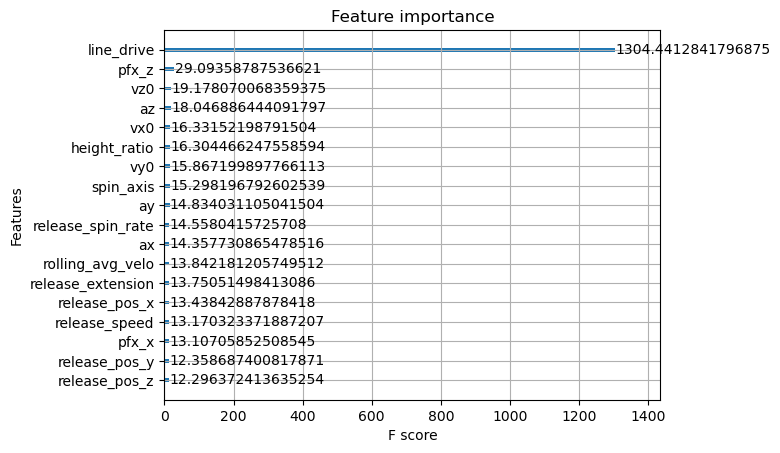

In [21]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

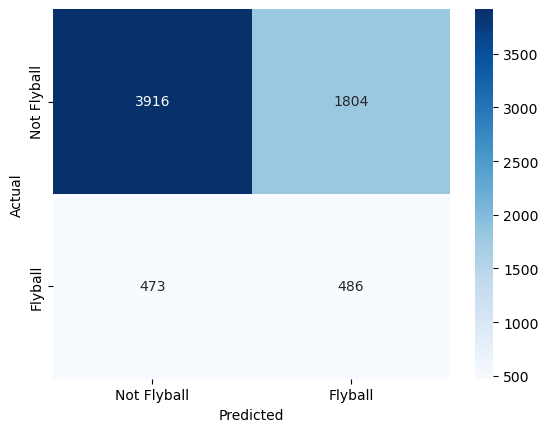

In [22]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [23]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [24]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [25]:
y_pred = final_model.predict(predictions)

In [26]:
testing_identifiers['xfb'] = y_pred

In [27]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/fb_2022&3_xfb.csv")